In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
from scipy.misc import comb
import scipy.stats as ss
from scipy.stats import beta, chisqprob
from scipy.special import gamma as gammaf # This is dumb but better for the moment than fixing code against jon's
from scipy.special import expit as logistic
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from __future__ import division

import json
from sys import maxint
from scipy.special import binom
from IPython.display import display, HTML
from sklearn.cross_validation import KFold
import community as cu

import matplotlib.patches as mpatches
import matplotlib.markers as mk
import matplotlib.colors as mcl


In [2]:
# Inline all plots to cell outputs
%matplotlib inline

Bradscratch stuff below here

In [3]:
# Data reading and distance calculation utilities
def read_metadata(meta_file):
    with open(meta_file, 'r') as f:
        my_json = json.loads(f.read())
    return {json.loads(key): value for (key, value) in my_json.iteritems()}

def read_table(table_file):
    with open(table_file, 'r') as f:
        # This will initially read the keys in the k:v pairs as just strings
        my_json = json.loads(f.read())
    # Convert keys string->list; but cannot hash on a list, so conver to a tuple for use in the map
    return {tuple(json.loads(key)): value for (key, value) in my_json.iteritems()}

def get_groups_and_libraries(meta):
    groups = []
    libraries = []
    for key in meta.keys():
        libraries.append(meta[key]['mAttributes']['LB'])
        groups.append(meta[key]['mReadGroupId'])
    return (groups, libraries)

def package_and_sort(matrix, groups, libraries):
    arrays = [np.array(groups), np.array(libraries)]
#     df = pd.DataFrame(matrix, index=arrays, columns=arrays).sort_index(level=1).sort_index(level=1, axis=1)
    df = pd.DataFrame(matrix, index=arrays, columns=arrays).sortlevel(level=1).sortlevel(level=1, axis=1)
    df.index.names=["group", "library"]
    return df


In [4]:
# Getting the truth matrix after precomputing the distances.
# Because this can be cached too, but is faster to get
# Also more frequesnt to change
# Therefore helps to be lower down in the stack
def make_truth_matrix(groups, libraries):
    n_groups = len(groups)
    truth = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            if i == j:
                truth[i,j] = -1  # sentinal value so the diagonal doesn't bias with evaluation metrics
            elif libraries[i] == libraries[j]:
                truth[i,j] = 1
    return package_and_sort(truth, groups, libraries)

# truth = make_truth_matrix(groups, libraries)

In [5]:
# Distance functions and utility functions by Jon Bloom

def load_table(sample):
    f = open(sample + '.table.txt', 'r')
    read_groups = eval(f.readline())
    libraries = eval(f.readline())
    n_reads = eval(f.readline())
    n_reads_removed = eval(f.readline())
    table = eval(f.readline())
    f.close()
    return read_groups, libraries, n_reads, n_reads_removed, table

def group_sizes(table, n_groups):
    '''Returns vector v where v[i] is count of reads in group i.'''
    rg_sizes = np.zeros(n_groups, dtype=int)
    for item in table.items():
        for i in item[0]:
            rg_sizes[i] += item[1]
    return rg_sizes

def remove_empty_groups(read_groups, libraries, table):
    n_groups = len(read_groups)
    rg_sizes = group_sizes(table, n_groups)
    if np.prod(rg_sizes != 0):
        return read_groups, libraries, table
    else:
        groups = [read_groups[i] for i in range(n_groups) if rg_sizes[i] != 0]
        libs = [libraries[i] for i in range(n_groups) if rg_sizes[i] != 0]
        new_num_of_old_num = {}
        current_num = 0
        for i in range(n_groups):
            new_num_of_old_num[i] = current_num
            if rg_sizes[i] != 0:
                current_num += 1
        new_table = Counter()
        for item in table.items():
            new_key = tuple(map(lambda x : new_num_of_old_num[x], list(item[0])))
            new_table.update({new_key : item[1]})
        return groups, libs, new_table
    
def library_nums(libraries):
    n_groups = len(libraries)
    num_of_library = {}
    current_num = 0
    for i in xrange(n_groups):
        if libraries[i] not in num_of_library.keys(): #change to set_default
            num_of_library[libraries[i]] = current_num
            current_num += 1
    return np.array([num_of_library[libraries[i]] for i in xrange(n_groups)])

def library_colors(lib_nums):
    #lib_color = plt.cm.Set1(lib_nums / (n_libraries + 1))
    color_of_num = {0 : 'r', 1 : 'b', 2 : 'g', 3 : 'k', 4 : 'y', 5 : 'm', 6 : 'c'}
    return [color_of_num[lib_num % 5] for lib_num in lib_nums]

def library_matrix(lib_nums, n_groups):
    lib_matrix = np.zeros((n_groups,n_groups), dtype=bool)
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            lib_matrix[i,j] = (lib_nums[i] == lib_nums[j])
    return lib_matrix

# jaccard similarity. union/intersection. might not be robust to diff conditions. no a priori expectation
def overlaps(table, n_groups):
    '''Returns matrix where M[i][j] is count of read types in both groups i
       and group j (symmetrized)'''
    overlap_matrix = np.zeros((n_groups, n_groups))
    for item in table.items():
        groups = list(set(item[0]))
        l = len(groups)
        for i in xrange(0,l):
            for j in xrange(i,l):
                overlap_matrix[groups[i],groups[j]] += item[1]
    return (overlap_matrix + overlap_matrix.T) / 2

def inner_product(table, n_groups):
    '''Returns matrix X^t * X where X[i,j] is count of reads of type i in group j.
       Agrees with all_pairs off the diagonal.'''
    ip_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        count_vector = np.zeros(n_groups)
        for i in xrange(l):
            count_vector[item[0][i]] += 1
        ip_matrix += np.outer(count_vector, count_vector) * item[1]
    return ip_matrix


# ABB would be 3 pairs- AB, AB, BB
# Retain signal from non-exact pairs. didn't do this as the only metric bc seeing a lot of on-flowcell pad-hopping duplicates, showing up as large duplicate sets, which would dominate here
# We only want biological duplicates, and we have been better at marking these. The work yossi and david benj are doing. What's going on from david roazen.
# That wasn't ready yet, so he did an exact pairs approach as well.
# This one is probably best if you are careful to look at only biological duplicates
def all_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j (symmetrized).'''
    ap_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        for i in xrange(l-1):
            for j in xrange(i+1,l):
                ap_matrix[item[0][i],item[0][j]] += item[1]
    return (ap_matrix + np.tril(ap_matrix.T))/2

def exact_tuples(table, n_groups, k):
    '''Returns array where A[i_1,...i_k] is count of read types that occur
       exactly in the groups i_1,...,i_k ascending with repeats.'''
    et_array = np.zeros(k*(n_groups,))
    for item in table.items():
        if len(item[0])==k:
            et_array[item[0]] = item[1]
    return et_array

def exact_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of read types that occur exactly twice,
       once in group i and once in group j (symmetrized).'''
    ep_matrix = exact_tuples(table, n_groups, 2)
    return (ep_matrix + np.tril(ep_matrix.T))/2

def normalize(array):
    return array/np.sum(array)

# normalize such that diagonals are 1 (so 1 is max self-similarity). off-diag things scaled proportionally
def normalize_by_diagonal(matrix):
    diag = np.diagonal(matrix)
    return matrix / np.sqrt(np.outer(diag, diag))

# take the outer product of [pq] with itself
# ie [[p^2, pq], [pq, q^2]]
# so divide matrix by [[p, rad(pq)], [rad(pq), q]]
# so each cell is divided by the total number of elements in it's thing.
# most similar to the underlying model
def normalize_by_group_size(matrix, group_sizes):
    return matrix / np.sqrt(np.outer(group_sizes, group_sizes))

def normalize_rows_by_vector(matrix, vector):
    return matrix / vector[:, np.newaxis]

def overlap_affinity(table, n_groups):
    ol_matrix = overlaps(table, n_groups)
    ol_affinity = np.zeros((n_groups, n_groups))
    for i in xrange(n_groups):
        ol_affinity[i,i] = .5
        for j in xrange(i+1,n_groups):
            ol_affinity[i,j] = 2 * ol_matrix[i,j] / \
                               (ol_matrix[i,i] + ol_matrix[j,j] - 2 * ol_matrix[i,j])
    return ol_affinity + ol_affinity.T

def exact_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(exact_pairs(table, n_groups))

def all_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(all_pairs(table, n_groups))

# Distance in euclidean space between 2 vectrs. each RG is a vector in a space whose dimension is the number of non-zero entries in the union of observed inserts
# so, what's teh cosine fo the angle between these 2 vectors
# naturally, the diagonal elements will be 1
# cosine of angle = (A dot B) / (length A)(length B)

# BUT our data isn't in the form of these vectors. So we count the AB pairs.
# Recording each time he sees some combination of 2 numbers.

# suffers the same issue as jaccard- what is your expectation. this is why all pairs and exact pairs only viable.
def L2_affinity(table, n_groups):
    return normalize_by_diagonal(inner_product(table, n_groups))

def exact_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(exact_pairs(table, n_groups),rg_sizes))

def exact_pairs_affinity3(table, n_groups, rg_sizes):
    return (normalize_by_group_size(exact_pairs(table, n_groups),rg_sizes))

def all_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(all_pairs(table, n_groups),rg_sizes))

def zero_diag(matrix):
    new_matrix = matrix.copy()
    for i in xrange(matrix.shape[0]):
        new_matrix[i,i] = 0
    return new_matrix

def multiplicity_matrix(table, n_groups):
    '''Returns M with M_ij count of j-tuples in group i'''
    max_mult =  max(map(len,table.keys()))
    mult_matrix = np.zeros((n_groups, max_mult + 1), dtype=int)
    for i in xrange(n_groups):
        mult_vector = multiplicity_vector(subtable(table,i))
        for j in xrange(len(mult_vector)):
            mult_matrix[i,j] = mult_vector[j]
    return mult_matrix

def multiplicity_vector(table):
    '''Returns v with v_j count of j-tuples in table'''
    max_mult =  max(map(len,table.keys()))
    mult_vector = np.zeros(max_mult + 1, dtype=int)
    for item in table.items():
        mult_vector[len(item[0])] += item[1]   
    return mult_vector

def subtable(table, i):
    '''Returns subtable for group i'''
    group_table = Counter()
    for item in table.items():
        mult = item[0].count(i)
        if mult > 0:
            group_table.update({(i,)*mult : item[1]})
    return group_table

def plot_matrix_rows(matrix, title = 'Matrix rows'):
    max_mult = np.sum(np.sum(matrix,axis=0) > 0) - 1
#     size = len(matrix[0])
    for i in xrange(n_groups):
        plt.semilogy(range(1, max_mult + 3), matrix[i,1:max_mult + 3],
                 label=i, color = plt.cm.Set1(i/n_groups))
    #plt.yscale('log')
    plt.ylim(np.min(matrix), 10 * np.max(matrix))
    plt.title(title)
#     plt.legend(title='RG')
    plt.show() #change ticks to integers only

# def plot_matrix(matrix, title='Matrix', vmax=None, ax=None):
#     if ax is None:
#         ax = plt.gca()
#     n, m = matrix.shape
    
#     colors = ax.pcolor(matrix, edgecolor='k', cmap = plt.cm.Blues, vmin=0, vmax=vmax)
#     plt.colorbar(colors, ax=ax)
#     ax.set_xticks(np.arange(n)+0.5)
#     ax.set_yticks(np.arange(m)+0.5)
#     ax.set_xticklabels(np.arange(n))
#     ax.set_yticklabels(np.arange(m))
#     ax.set_title(title)
#     ax.invert_yaxis()

def normalize_to_Markov(matrix):
    row_sums = matrix.sum(axis=1)
    return matrix / row_sums[:, np.newaxis]
    
def eigen(affinity):
    #change to computer for symmetrix matrix and convert?
    #is absolute value necessary? correct? won't fractoinal powers cause trouble?
    evals, evecs = np.linalg.eig(normalize_to_Markov(affinity))
    order = np.argsort(np.abs(evals))[::-1]
    return evals[order], evecs[:,order]

def diffusion_distances(evals, evecs, t = None):
    if not t:
        t = 1 / (1-evals[1])
    n_groups = len(evals)
    scaled_evecs = evecs[:,1:] * evals[1:]**t  #check that this works as expected
    dd_matrix = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        dd_matrix[i,i]=0
        for j in xrange(i+1, n_groups):
            difference = scaled_evecs[i,:] - scaled_evecs[j,:]
            dd_matrix[i,j] = np.sqrt(np.dot(difference,difference))
    return dd_matrix + dd_matrix.T

def plot_diffusion(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lib_nums = library_nums(libraries)
    ax.scatter(x, y, color=color)
    ax.set_title(title)
    if bound:
        ax.set_xlim(-bound,bound)
        ax.set_ylim(-bound,bound)
    plt.show()

def plot_diffusion_3d(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    z = evecs[:,3]*(evals[3]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection="3d")
    ax.scatter3D(x, y, z, color = color)
    ax.set_title(title)
    if bound:
        ax.set_xlim3d(-bound,bound)
        ax.set_ylim3d(-bound,bound)
        ax.set_zlim3d(-bound,bound)
    plt.show()

def scatter_affinities(affinities, lib_matrices, pair_colors, log_scale = False, title='Scatter'):   
    fig = plt.figure(figsize=(10,8))
    xs = np.arange(len(pair_colors))
    plt.scatter(xs, affinities, s=2, color = pair_colors)
    plt.title(title)
    plt.ylim(1e-6,1)
    if log_scale == True:
        plt.yscale('log')
    for i in xs:
        if lib_matrices[i] == 3:
            plt.axvline(x=i,ls='-',alpha = .5,c='g',linewidth=1,)
    plt.show()
    
def plot_graph(matrix, threshold, color=None, complement = False):
    print 'Threshold =', threshold #include this in title
    n_groups = matrix.shape[0]
    labels = dict(zip(range(n_groups),range(n_groups)))
    if complement:
        G = nx.Graph(matrix < threshold)
    else:
        G = nx.Graph(matrix >= threshold)
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color=color)
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos,labels=labels,font_color='w',font_size=16)
    plt.show()
    
def bool_to_color(x):
    if x == True:
        return 'b'
    elif x == False:
        return 'r'
    else:
        return 'w'

# Some snippets from other J Bloom functions, which I found interesting
# pair_colors = np.vectorize(bool_to_color)(lib_matrices)
# np.set_printoptions(precision=1, suppress=True)

In [6]:
def plot_matrix(matrix, title=None, vmax=None, ax=None):
    if ax is None:
        ax = plt.gca()
    n, m = matrix.shape
    
    x = np.arange(0,n,5)
    y = np.arange(0,m,5)
    
    colors = ax.imshow(matrix, cmap=plt.cm.Blues, vmin=0, vmax=vmax,
           extent=[0, n, 0, m],
           interpolation='none', origin='lower')

    cb = plt.colorbar(colors, ax=ax)
    ax.set_xticks(x+0.5)
    ax.set_yticks(y+0.5)
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)
    
    # Format the ticks
    font_size=16
    ax.tick_params(which='major', labelsize=font_size)
    cb.ax.tick_params(labelsize=font_size)
    
    # Minor ticks
    ax.set_xticks(np.arange(n), minor=True)
    ax.set_yticks(np.arange(m), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.2)
    ax.tick_params(which='minor', colors='k', width=0.2)
    
    if title is not None:
        ax.set_title(title, fontsize=font_size)
    
    ax.invert_yaxis()

In [7]:
# threshold getter functions

# TODO - what if min <= max????
def min_max_mean(distances, truth):
    all_positives = distances.values[truth > 0]
    all_negatives = distances.values[truth == 0]
    return np.mean([min(all_positives), max(all_negatives)])

def zero_threshold(distance, truth):
    return np.max([min_max_mean(distance, truth),0])

def exhaustive_search(distances, truth):
    n_groups = len(distances.index.values)
    sorted_dists = np.sort(np.unique(distances.values))
    max_rand_index = 0
    max_rand = 0.0
    for index in xrange(len(sorted_dists)):
        results = apply_threshold(distances, sorted_dists[index])
        rand = summarize_result(results, truth, n_groups).loc["Rand index"].values[0]
        if rand > max_rand: max_rand_index = index
    return sorted_dists[max_rand_index]
    
# Generic outer function - Dont think I need
# def get_threshold(distances, truth, threshold_func):
#     return threshold_func(distances, truth)

In [8]:

def limited_pairs(table, n_groups, k):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j, up to a certain read type size k (symmetrized).'''
    lp_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        if len(item) <= k:
            l = len(item[0])
            for i in xrange(l-1):
                for j in xrange(i+1,l):
                    lp_matrix[item[0][i],item[0][j]] += item[1]
    return (lp_matrix + np.tril(lp_matrix.T))/2


def random_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of each read type assigned to the 
       random group i,j drawn from the larger read type (symmetrized).'''
    rp_matrix = np.zeros((n_groups, n_groups))
    faf = np.zeros((n_groups, n_groups))
    for item in table.items():#[:6]:
        tup = item[0]
        if len(tup) > 1:
            pair = np.random.choice(tup, size=2, replace=False)
            rp_matrix[min(pair), max(pair)] += item[1]
    return (rp_matrix + np.tril(rp_matrix.T))/2

def random_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(random_pairs(table, n_groups))

def unlimited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, maxint))

def ten_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 10))

def five_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 5))

def four_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 4))

def three_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 3))

def two_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 2))

In [9]:
# Funcions supporting a likelihoods ratio test.
def fit_beta_distributions(distance, truth, sig_figs=12):
#     print "trying sig-figs ", sig_figs
    
    # In practice my true-diff-library values are often all 0.0. Faux counts save my true-different beta dist from being entilely 0.
#     faux_counts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
    
#     distance = distance.clip(10**-12, 1.0 - (10**-12)) # was (None, 0.999999999)
    distance = distance.clip(10**-12, 1.0 - (10**-sig_figs)) # -9 is smallest value that prevents MLE in beta fit from failing to converge

    faux_counts = []
    
    true_positives=distance.values[truth.values>0]
    true_negatives=(distance.values[truth.values==0] + 10**-27)

    try:
        # Fit a beta distribution to the true positives
#     true_positives=np.append(distance.values[truth.values>0], faux_counts)
        alphaT, betaT, locT, scaleT = beta.fit(true_positives, floc=0, fscale=1)
        dPos = beta(alphaT, betaT, locT, scaleT) # "freeze" the distribution parameters as an object
        pos_dist = {"alpha": alphaT, "beta": betaT, "dist": dPos}
        
        # Fit a beta distribution to the true negatives
    #     true_negatives=np.append(distance.values[truth.values==0] + 10**-27, faux_counts)
        alphaN, betaN, locN, scaleN = beta.fit(true_negatives, floc=0, fscale=1)
        dNeg = beta(alphaN, betaN, locN, scaleN)
        neg_dist = {"alpha": alphaN, "beta": betaN, "dist": dNeg}
        
#         print 'Ok, I saw something. Returning the following'
#         print {'positive': pos_dist, 'negative': neg_dist}
        return {'positive': pos_dist, 'negative': neg_dist}

    except RuntimeError:
        if sig_figs == 4:
#             print "sig_figs here is ", sig_figs
#             print "returning empty"
            return {} # return empty dict. This MLE did not converge at max distance of 0.9999.
        else:
#             print 'trying again with ', sig_figs-1
            return fit_beta_distributions(distance, truth, (sig_figs-1))
    

# Likelihood ratio test. # TODO- unify the clipping here and in fit_beta_distributions
def calculate_log_likelihoods_ratio(x, distributions):
    if x >= 1.0: x = 1.0 - (10**-12) # smallest value that does not cause infinities in pdf
    if x == 0: x=10**-12
    dPos = distributions['positive']["dist"]
    dNeg = distributions['negative']["dist"]
    LLalt = dPos.logpdf(x) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
    LLnull = dNeg.logpdf(x) # log likelihood that our 'different-library' distribution is the best model
    LLratio = LLalt - LLnull
    return LLratio

get_log_likeihoods = np.vectorize(calculate_log_likelihoods_ratio)
    
def calculate_likelihoods_ratio(x, distributions):
    if x >= 1.0: x = 1.0 - (10**-12) # smallest value that does not cause infinities in pdf
    if x == 0: x=10**-12
    dPos = distributions['positive']["dist"]
    dNeg = distributions['negative']["dist"]
    Lalt = dPos.pdf(x) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
    Lnull = dNeg.pdf(x) # log likelihood that our 'different-library' distribution is the best model
    if Lnull == 0:
        Lnull = 10**-100
    Lratio = Lalt / Lnull
    return Lratio

get_likelihood_ratios = np.vectorize(calculate_likelihoods_ratio)

In [10]:
def make_partition_matrix(partition, groups, libraries):
    size = len(partition)
    matrix = np.zeros((size, size))
    for i in xrange(size):
        for j in xrange(size):
            if (i != j) and (partition[i] == partition[j]):
                matrix[i,j] = 1
    
    return package_and_sort(matrix, groups, libraries)

In [11]:
def guess_LLR_threshold_distance(x, distributions, LLR_threshold):
    guess_LLR = calculate_log_likelihoods_ratio(x, distributions)
    return np.abs(LLR_threshold - guess_LLR)

def find_LLR_threshold_distance(distributions, LLR_threshold):
    calc_x = minimize_scalar(guess_LLR_threshold_distance, method='bounded', args=(distributions, LLR_threshold), bounds=[0,1])
    return calc_x['x']

In [12]:
from scipy.special import beta as Beta

def hellinger(distributions):
    dPos = distributions['positive']
    dNeg = distributions['negative']
    a1 = dPos['alpha']
    b1 = dPos['beta']

    a2 = dNeg['alpha']
    b2 = dNeg['beta']
    h2 = 1 - ((Beta(np.mean([a1, a2]), np.mean([b1, b2]))) / np.sqrt(Beta(a1, b1) * Beta(a2, b2)))
    return np.sqrt(h2)

def expectedFalsePosNeg(distributions, threshold):
    dPos = distributions['positive']['dist']
    dNeg = distributions['negative']['dist']
    
    expectedFalseSames = dNeg.sf(threshold)
    expectedFalseDiffs = dPos.cdf(threshold)
    
    return (expectedFalseSames, expectedFalseDiffs)

In [13]:
# Perform adjustments necessary for graphing LLRs
# First, set all infinite values to the maximum non-infinite value
# Second, shift the matrix such that the minimum value is zero.
#   Likely, min value is negative, so matrix is shifted right and all values are positive.
def adjust_LLRs(LLR_df):
#     print "LLRS"
#     display(LLR_df)
    llr_matrix = LLR_df.values
    
    matrix_min = np.nanmin(llr_matrix)
    if np.isinf(matrix_min): # is the minimum non-nan value an infinity? If so, just set to 0
        matrix_min = 0
#     print 'Matrix min: ' + str(matrix_min)
    
    # Are there any non-infinite values?
    # If so, clip the matrix to the max of these
    # Otherwise, clip it to a large value
    #   NB: We get matrices that are either inf or nan
    if llr_matrix[np.isfinite(llr_matrix)].size != 0:
        matrix_non_inf_max = np.nanmax(llr_matrix[np.isfinite(llr_matrix)])
    else:
        matrix_non_inf_max = 1000
#     print 'Matrix max: ' + str(matrix_non_inf_max)
    clipped_matrix = llr_matrix.clip(None, matrix_non_inf_max)
        
    shifted_matrix = zero_diag(clipped_matrix - matrix_min)
    
    adjusted = pd.DataFrame(shifted_matrix)
#     print "AdjusTED"
#     display(adjusted)
    
    return adjusted

In [14]:
# Evaluation function + utilities
def summarize_result(result, expected, n_groups, result_label):
    all_positives = result[expected > 0]
    true_positives = all_positives.sum() 
    true_positive_rate = true_positives / len(all_positives)

    all_negatives = result[expected == 0]
    true_negatives = len(all_negatives) - all_negatives.sum()
    true_negative_rate = true_negatives / len(all_negatives)

    total_pairs = (n_groups * n_groups) - n_groups # exclude self-self pairs
    rand_index = (true_positives + true_negatives) / total_pairs
    
    return {
        (result_label + " p(same-library | truly same-library)"): true_positive_rate, 
        (result_label + " p(different-library | truly different-library)"): true_negative_rate, 
        (result_label + " rand index"): rand_index}

def plot_distance_histogram(distances, dists, truth, title, ax=None):
    if ax is None:
        ax = plt.gca()
    same_distances = distances.values[truth>0]
    diff_distances = distances.values[truth==0]
    dPos = dists['positive']["dist"]
    dNeg = dists['negative']["dist"]

    # Plot histogram barchars for same-library and different-library distances
    my_bins=np.arange(-0.1, 1, 0.01)
#     my_bins=np.arange(-0.01,1,.002) # was (-0.1, 1, 0.1)
    ax.hist(same_distances, normed=True, bins=my_bins, alpha=0.5, label='Same-library')
    ax.hist(diff_distances, normed=True, bins=my_bins, alpha=0.5, label='Different-library')
    
    # Add beta function pdf for same-library and different-library models
    x = np.linspace(dPos.ppf(0), dPos.ppf(0.99), 100)
    ax.plot(x, dPos.pdf(x), 'r', lw=3, alpha=0.6)
    ax.plot(x, dNeg.pdf(x), 'b', lw=3, alpha=0.8)
    
    font_size=16
    ax.tick_params(which='major', labelsize=font_size)
    
    ax.set_ylim([0, 40])
#     ax.set_xlim([-0.01, 0.6])
#     ax.set_xlim([-0.01, 0.6])
    ax.legend(loc='upper right')
    
    if title is not None:
        ax.set_xlabel(title, fontsize=font_size)
        ax.set_ylabel("Count of Read Group Pairs", fontsize=font_size)
    
#     if title is not None:
#         ax.set_title(title, fontsize=font_size)
    
def plot_basic_histogram(distances, truth, ax=None):
    if ax is None:
        ax = plt.gca()
    same_distances = distances.values[truth>0]
    diff_distances = distances.values[truth==0]
    
    # Plot histogram barchars for same-library and different-library distances
    my_bins=np.arange(-0.01,1,.01)
    ax.hist(same_distances, normed=True, bins=my_bins, alpha=0.5, label='Same-library')
    ax.hist(diff_distances, normed=True, bins=my_bins, alpha=0.5, label='Different-library')
    ax.set_ylim([0, 40])
    ax.legend(loc='upper right')
    ax.set_title('Distribution of Pairwise Distances')

def is_greater_than(x, threshold):
    return 1 if x >= threshold else 0

apply_threshold = np.vectorize(is_greater_than)

def get_false_calls(distances, index_label, truth, results, meta, n_groups, is_LLR):
    labels = ["index1", "index2", "obs", "exp", "rg1", "lib1", "rg2", "lib2", "dist", "is_LRR"]
    false_calls = []
    for i in xrange(n_groups):
        for j in xrange(i, n_groups):
            obs = results[i, j]
            exp = truth.values[i, j]
            dist = distances.values[i,j]
            if i != j and obs != exp:
#                 print
#                 print "i, j", i, j
#                 print "obs exp", obs, exp
#                 print 'd i', distances.index[i]
#                 print 'mi', meta[i]
#                 print 'd j', distances.index[j]
#                 print 'mj', meta[j]
                
                false_calls.append([i, j, obs, exp, meta[i][0], meta[i][1], meta[j][0], meta[j][1], dist, is_LLR])
    if len(false_calls) != 0:
        result = pd.DataFrame(np.matrix(false_calls), columns=labels)
        result["distance"] = pd.Series([index_label for i in xrange(len(result.index))])
    else:
        result = None
    return result

# Primary evaluation function
def evaluate_full_print(distances, LLRs, ratios, label, distributions, truth, threshold, LLR_threshold, ratio_threshold, n_groups, fig=None, plot_rows=1, current_plot_row=1):
    
    # Get the initial info, ie the thresholds used + max distance, and pack into a dict
    labels = ["threshold", "LLR_threshold", "ratio_threshold", "max_distance", "same-lib alpha", "same-lib beta", "diff-lib alpha", "diff-lib beta"]
    if distributions:
        values = [threshold, LLR_threshold, ratio_threshold, np.max(distances.values), distributions["positive"]["alpha"], distributions["positive"]["beta"], distributions["negative"]["alpha"], distributions["negative"]["beta"]]
    else:
        values = [threshold, LLR_threshold, ratio_threshold, np.max(distances.values), -1, -1, -1, -1]
    evaluation = dict(zip(labels, values))
    
    # Get the threshold-based result, and check the overall evaluation metrics
    result = apply_threshold(distances, threshold)
    evaluation.update(summarize_result(result, truth.values, n_groups, ""))
    
    # Find any read group pairs that are false-same-library or false-different library for the distance-threshold test
    false_calls = get_false_calls(distances, label, truth, result, n_groups, False) 
    
    # Do the same procedure for the LLR matrix.
    # NB: if distributions is empty, this will be a 0's matrix with a high threshold
    #     It will call everything different library
    LLR_result = apply_threshold(LLRs, LLR_threshold)
    summary = summarize_result(LLR_result, truth.values, n_groups, "LLR")
    evaluation.update(summary)
    
    ratio_result = apply_threshold(ratios, ratio_threshold)
    summary = summarize_result(ratio_result, truth.values, n_groups, "ratio")
    evaluation.update(summary)
    
    # Find any read group pairs that are false-same-library or false-different library for the LRR-threshold test
#     LRR_calls = get_false_calls(LLRs, label, truth, LLR_result, n_groups, True)
#     if LRR_calls is not None:
#         if false_calls is None:
#             false_calls = LRR_calls
#         else:
#             false_calls = false_calls.append(LRR_calls)
    
    # Group and library labels in correct sort order, for the partition matrices below
    groupz = distances.index.get_level_values(0)
    libz = distances.index.get_level_values(1)
    expected_library_indices = distances.index.labels[1]

    # what is the modularity for the expected partition given library labels
    expected_partition = dict({(i,expected_library_indices[i]) for i in xrange(len(expected_library_indices))})

    # Cluster the original distances and evaluate the result
    D = nx.from_numpy_matrix(distances.values)
    distance_positions = nx.spring_layout(D)
    distance_partition = cu.best_partition(D)
    dist_part_matrix = make_partition_matrix(distance_partition, groupz, libz)
    evaluation.update(summarize_result(dist_part_matrix.values, truth.values, n_groups, "Cluster"))
    evaluation.update({"dist_part_mod": cu.modularity(distance_partition, D),
                       "Dist Clusters discovered": len(set(distance_partition.values())),
                       "expected_part_mod": cu.modularity(expected_partition, D)
                      })
    dist_colors = [distance_partition.get(node) for node in D.nodes()]
    
    # Adjust the LLRs, cluster them, and evaluate the result.
#     print distributions
#     print "LLRs"
#     display(LLRs)
    
    # NB: If beta distributions could not be fit, this will remain a 0's matrix.
    adjusted_LLRs = adjust_LLRs(LLRs)
    L = nx.from_numpy_matrix(adjusted_LLRs.values)
    llr_positions = nx.spring_layout(L)

#     print "adjusted LLRs"
#     print (adjusted_LLRs.values >= 0).all()
#     display(adjusted_LLRs)
    if distributions:
        hellinger_dist = hellinger(distributions)
        
        inferred_LLR_threshold_x = find_LLR_threshold_distance(distributions, LLR_threshold)
        expectedFalseSames, expectedFalseDiffs = expectedFalsePosNeg(distributions, inferred_LLR_threshold_x)
        
        llr_partition = cu.best_partition(L)
#         print "partition"
#         print llr_partition
        llr_part_matrix = make_partition_matrix(llr_partition, groupz, libz)
    else:
        print "NO DISTRIBUTIONS"
        hellinger_dist = 0
        expectedFalseSames = 1
        expectedFalseDiffs = 1
        L = D
        llr_partition = {index: 0 for index in range(len(libz))} # Place all nodes in one group
        llr_part_matrix = LLRs    
    evaluation.update(summarize_result(llr_part_matrix.values, truth.values, n_groups, "LLR Cluster"))
    evaluation.update({"LLR_part_mod": cu.modularity(llr_partition, L),
                       "LLR Clusters discovered": len(set(llr_partition.values())),
                       "Hellinger Distance": hellinger_dist,
                       "Expected False-Sames": expectedFalseSames,
                       "Expected False-Diffs": expectedFalseDiffs
                      })
    llr_colors = [llr_partition.get(node) for node in L.nodes()]
    
    
    
    # The adjustment to the LLRs, scaling them and capping them, is not a good approach
    # Here, cluster the non-log likelihood ratios, which should vary between 0 and 1 (no issue with their being negative or infinite)
    R = nx.from_numpy_matrix(ratios.values.clip(None, 1000))
    ratio_positions = nx.spring_layout(R)
    if distributions:
        ratio_partition = cu.best_partition(R)
        ratio_part_matrix = make_partition_matrix(ratio_partition, groupz, libz)
    else:
        R = D
        ratio_partition = llr_partition
        ratio_part_matrix = ratios
    evaluation.update(summarize_result(llr_part_matrix.values, truth.values, n_groups, "Ratio Cluster"))
    evaluation.update({"ratio_part_mod": cu.modularity(ratio_partition, R),
                       "ratio clusters discovered": len(set(ratio_partition.values())),
                      })
    ratio_colors = [ratio_partition.get(node) for node in R.nodes()]
    
    
    # Set up some cell-indexing adjustments to place each plot within a larger multi-plot figure
    if fig is not None:
        plot_columns = 13
        cell_adjustment = (current_plot_row - 1) * plot_columns
        dist_plot = fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 1)
        res_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 2))
        LLR_plot=fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 3)
        LLR_res_plot=fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 4)
        hist_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 5))
        cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 6))
        network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 7))
        network_plot.set_title(label + ' Similarity Network Graph')
        llr_cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 8))
        llr_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 9))
        llr_network_plot.set_title(label + ' LLR Network Graph')
        
        ratio_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 10))
        ratio_res_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 11))
        ratio_cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 12))
        ratio_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 13))
        ratio_network_plot.set_title(label + ' Likelihood Ratio Network Graph')
        
        plot_matrix(distances, title=(label + ' Pairwise Similarity Values'), ax=dist_plot)
        plot_matrix(result, title=(label + ' test: Similarity Exceeds Threshold'), ax=res_plot)
        
        plot_matrix(adjusted_LLRs, title=(label + ' Log Likelihood Ratios (logalt - lognull)'), ax=LLR_plot)
        plot_matrix(LLR_result, title=(label + ' LLR Exceeds Threshold'), ax=LLR_res_plot)
        
        plot_matrix(ratios.clip(None, 1000), title=(label + ' Likelihood Ratios (alt / null)'), ax=ratio_plot)
        plot_matrix(ratio_result, title=(label + ' Likelihood Ratio Exceeds Threshold'), ax=ratio_res_plot)
        
        nx.draw_networkx_nodes(D, pos=distance_positions, with_labels=False, node_color=dist_colors, node_size=35, ax=network_plot)

        if distributions:
            plot_distance_histogram(distances, distributions, truth.values, (label +' Distribution of Pairwise Similarities'), ax=hist_plot)
            nx.draw_networkx_nodes(L, pos=llr_positions, with_labels=False, node_color=llr_colors, node_size=35, ax=llr_network_plot)
            nx.draw_networkx_nodes(R, pos=ratio_positions, with_labels=False, node_color=ratio_colors, node_size=35, ax=ratio_network_plot)
        else:
            plot_basic_histogram(distances, truth.values, ax=hist_plot)
        
        plot_matrix(dist_part_matrix, title=(label + " Similarity Clustering Results"), ax=cluster_eval_plot)        
        plot_matrix(llr_part_matrix, title=(label + " LLR Clustering Results"), ax=llr_cluster_eval_plot)
        plot_matrix(ratio_part_matrix, title=(label + " ratio clustering Results"), ax=ratio_cluster_eval_plot)
    
    return (pd.DataFrame(evaluation, index=[label]), false_calls)

In [15]:
# Primary evaluation function
def evaluate(distances, LLRs, ratios, label, distributions, truth, threshold, LLR_threshold, ratio_threshold, n_groups, fig=None, plot_rows=1, current_plot_row=1):
    
    # Get the initial info, ie the thresholds used + max distance, and pack into a dict
    labels = ["threshold", "LLR_threshold", "ratio_threshold", "max_distance", "same-lib alpha", "same-lib beta", "diff-lib alpha", "diff-lib beta"]
    if distributions:
        values = [threshold, LLR_threshold, ratio_threshold, np.max(distances.values), distributions["positive"]["alpha"], distributions["positive"]["beta"], distributions["negative"]["alpha"], distributions["negative"]["beta"]]
    else:
        values = [threshold, LLR_threshold, ratio_threshold, np.max(distances.values), -1, -1, -1, -1]
    evaluation = dict(zip(labels, values))
    
    # Get the threshold-based result, and check the overall evaluation metrics
    result = apply_threshold(distances, threshold)
    evaluation.update(summarize_result(result, truth.values, n_groups, ""))
    
    # Find any read group pairs that are false-same-library or false-different library for the distance-threshold test
#     print 'Getting orig calls!'
#     print "LLRs", distances.shape
#     print 'label', label
#     print 'truth', truth.shape
#     print 'LLR_result', result
#     print 'n_groups', n_groups
#     false_calls = get_false_calls(distances, label, truth, result, distances.index, n_groups, False) 
    
    # Do the same procedure for the LLR matrix.
    # NB: if distributions is empty, this will be a 0's matrix with a high threshold
    #     It will call everything different library
    LLR_result = apply_threshold(LLRs, LLR_threshold)
    summary = summarize_result(LLR_result, truth.values, n_groups, "LLR")
    evaluation.update(summary)
    
    ratio_result = apply_threshold(ratios, ratio_threshold)
    summary = summarize_result(ratio_result, truth.values, n_groups, "ratio")
    evaluation.update(summary)
    
    logistics = logistic(ratios.values)
    
    # Find any read group pairs that are false-same-library or false-different library for the LRR-threshold test
#     LRR_calls = get_false_calls(LLRs, label, truth, LLR_result, n_groups, True)
#     print 'Getting false calls!'
#     print "LLRs", LLRs.shape
#     print 'label', label
#     print 'truth', truth.shape
#     print 'LLR_result', LLR_result
#     print 'n_groups', n_groups
    false_calls = get_false_calls(LLRs, label, truth, LLR_result, distances.index, n_groups, True)
    

#     if LRR_calls is not None:
#         if false_calls is None:
#             false_calls = LRR_calls
#         else:
#             false_calls = false_calls.append(LRR_calls)
    
    # Group and library labels in correct sort order, for the partition matrices below
    groupz = distances.index.get_level_values(0)
    libz = distances.index.get_level_values(1)
    expected_library_indices = distances.index.labels[1]

    # what is the modularity for the expected partition given library labels
    expected_partition = dict({(i,expected_library_indices[i]) for i in xrange(len(expected_library_indices))})
    
    
    
    # Cluster the original distances and evaluate the result
    D = nx.from_numpy_matrix(distances.values)
    distance_positions = nx.spring_layout(D)
    distance_partition = cu.best_partition(D)
    dist_part_matrix = make_partition_matrix(distance_partition, groupz, libz)
    evaluation.update(summarize_result(dist_part_matrix.values, truth.values, n_groups, "Cluster"))
    evaluation.update({"dist_part_mod": cu.modularity(distance_partition, D),
                       "Dist Clusters discovered": len(set(distance_partition.values())),
                       "expected_part_mod": cu.modularity(expected_partition, D)
                      })
    dist_colors = [distance_partition.get(node) for node in D.nodes()]
    expected_dist_colors = [expected_partition.get(node) for node in D.nodes()]
    
    cmap = plt.cm.get_cmap()
    norm = mcl.Normalize(vmin=0,vmax=max(dist_colors))
    
    dist_good_nodes=[]
    dist_good_colors = []
    
    dist_bad_nodes=[]
    dist_bad_colors=[]
    for node in D.nodes():
        if expected_partition.get(node) == distance_partition.get(node):
            dist_good_nodes.append(node)
            dist_good_colors.append(cmap(norm(distance_partition.get(node))))
        else:
            dist_bad_nodes.append(node)
            dist_bad_colors.append(cmap(norm(distance_partition.get(node))))
#     dist_bad_colors.extend(dist_colors) 
    
    # Adjust the LLRs, cluster them, and evaluate the result.
#     print 'evaluating the following distribution'
#     print distributions
#     print "LLRs"
#     display(LLRs)
    
    # NB: If beta distributions could not be fit, this will remain a 0's matrix.
    adjusted_LLRs = adjust_LLRs(LLRs)
    L = nx.from_numpy_matrix(adjusted_LLRs.values)
    llr_positions = nx.spring_layout(L)

#     print "adjusted LLRs"
#     print (adjusted_LLRs.values >= 0).all()
#     display(adjusted_LLRs)
    if distributions:
        hellinger_dist = hellinger(distributions)
        
        inferred_LLR_threshold_x = find_LLR_threshold_distance(distributions, LLR_threshold)
        expectedFalseSames, expectedFalseDiffs = expectedFalsePosNeg(distributions, inferred_LLR_threshold_x)
        
        llr_partition = cu.best_partition(L)
#         print "partition"
#         print llr_partition
        llr_part_matrix = make_partition_matrix(llr_partition, groupz, libz)
    else:
        print "NO DISTRIBUTIONS"
        hellinger_dist = 0
        expectedFalseSames = 1
        expectedFalseDiffs = 1
        L = D
        llr_partition = {index: 0 for index in range(len(libz))} # Place all nodes in one group
        llr_part_matrix = LLRs    
    evaluation.update(summarize_result(llr_part_matrix.values, truth.values, n_groups, "LLR Cluster"))
    evaluation.update({"LLR_part_mod": cu.modularity(llr_partition, L),
                       "LLR Clusters discovered": len(set(llr_partition.values())),
                       "Hellinger Distance": hellinger_dist,
                       "Expected False-Sames": expectedFalseSames,
                       "Expected False-Diffs": expectedFalseDiffs
                      })
    llr_colors = [llr_partition.get(node) for node in L.nodes()]
        
    # The adjustment to the LLRs, scaling them and capping them, is not a good approach
    # Here, cluster the non-log likelihood ratios, which should vary between 0 and 1 (no issue with their being negative or infinite)
    R = nx.from_numpy_matrix(ratios.values.clip(None, 1000))
#     print "logistics"
#     display(logistics)
#     R = nx.from_numpy_matrix(logistics)
    ratio_positions = nx.spring_layout(R)
    if distributions:
        ratio_partition = cu.best_partition(R)
        ratio_part_matrix = make_partition_matrix(ratio_partition, groupz, libz)
    else:
        R = D
        ratio_partition = llr_partition
        ratio_part_matrix = ratios
    evaluation.update(summarize_result(ratio_part_matrix.values, truth.values, n_groups, "Ratio Cluster"))
    evaluation.update({"ratio_part_mod": cu.modularity(ratio_partition, R),
                       "ratio clusters discovered": len(set(ratio_partition.values())),
                      })
    ratio_colors = [ratio_partition.get(node) for node in R.nodes()]
    expected_ratio_colors = [expected_partition.get(node) for node in R.nodes()]
    
    r_norm = mcl.Normalize(vmin=0,vmax=max(ratio_colors))
    ratio_good_nodes=[]
    ratio_good_colors = []
    
    ratio_bad_nodes=[]
    ratio_bad_colors=[]
    for node in D.nodes():
        if expected_partition.get(node) == ratio_partition.get(node):
            ratio_good_nodes.append(node)
            ratio_good_colors.append(cmap(r_norm(ratio_partition.get(node))))
        else:
            ratio_bad_nodes.append(node)
            ratio_bad_colors.append(cmap(r_norm(ratio_partition.get(node))))
    
    # Set up some cell-indexing adjustments to place each plot within a larger multi-plot figure
    if fig is not None:
        font_size = 16
        plot_columns = 2
        cell_adjustment = (current_plot_row - 1) * plot_columns
        dist_plot = fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 1)
#         res_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 2))
#         LLR_plot=fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 3)
#         LLR_res_plot=fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 2)
        hist_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 2))
#         cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 2))

#         network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 1))
# #         network_plot.set_title(label + ' Similarity Network Graph')
#         network_plot.set_title('Similarity Network Graph', fontsize=font_size)
#         network_plot.set_xticklabels([])
#         network_plot.set_yticklabels([])


#         network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 7))
#         network_plot.set_title(label + ' Similarity Network Graph')
#         llr_cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 8))
#         llr_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 9))
#         llr_network_plot.set_title(label + ' LLR Network Graph')
        
#         ratio_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 10))
#         ratio_res_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 4))
#         ratio_cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 4))
#         ratio_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 13))
#         ratio_network_plot.set_title(label + ' Likelihood Ratio Network Graph')

#         ratio_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 13))
#         ratio_network_plot.set_title(label + ' Likelihood Ratio Network Graph')

#         ratio_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 2))
# #         ratio_network_plot.set_title(label + ' Likelihood Ratio Network Graph')
#         ratio_network_plot.set_title('Likelihood Ratio Network Graph', fontsize=font_size)
#         ratio_network_plot.set_xticklabels([])
#         ratio_network_plot.set_yticklabels([])


#         plot_matrix(distances, title=(label), ax=dist_plot)
        plot_matrix(distances, title=None, ax=dist_plot)

#         plot_matrix(result, title=(label + ' test: Similarity Exceeds Threshold'), ax=res_plot)
        
#         plot_matrix(adjusted_LLRs, title=(label + ' Log Likelihood Ratios (logalt - lognull)'), ax=LLR_plot)
#         plot_matrix(LLR_result, title=(label + ' LLR Exceeds Threshold'), ax=LLR_res_plot)
        
#         plot_matrix(ratios.clip(None, 1000), title=(label + ' Likelihood Ratios (alt / null)'), ax=ratio_plot)
#         plot_matrix(ratio_result, title=(label + ' Likelihood Ratio Exceeds Threshold'), ax=ratio_res_plot)node_color=expected_dist_color
#         print dist_good_colors
#         print dist_bad_colors
#         al=0.75
#         nx.draw_networkx_nodes(D, pos=distance_positions, with_labels=False, nodelist=dist_good_nodes, node_color=dist_good_colors, node_size=35, alpha=al, ax=network_plot)
#         nx.draw_networkx_nodes(D, pos=distance_positions, with_labels=False, nodelist=dist_bad_nodes, node_color=dist_bad_colors, node_shape='^', alpha=al,  node_size=35, ax=network_plot)

        if distributions:
            plot_distance_histogram(distances, distributions, truth.values, (label), ax=hist_plot)
#             plot_distance_histogram(distances, distributions, truth.values, None, ax=hist_plot)

            
# #             nx.draw_networkx_nodes(L, pos=llr_positions, with_labels=False, node_color=llr_colors, node_size=35, ax=llr_network_plot)
#             nx.draw_networkx_nodes(R, pos=ratio_positions, with_labels=False, nodelist=ratio_good_nodes, node_color=ratio_good_colors, node_size=35, alpha=al,  ax=ratio_network_plot)
#             nx.draw_networkx_nodes(R, pos=ratio_positions, with_labels=False, nodelist=ratio_bad_nodes, node_color=ratio_bad_colors, node_shape='^', alpha=al,  node_size=35, ax=ratio_network_plot)

#         else:
#             plot_basic_histogram(distances, truth.values, ax=hist_plot)
        
#         plot_matrix(dist_part_matrix, title=(label + " Similarity Clustering Results"), ax=cluster_eval_plot)        
#         plot_matrix(llr_part_matrix, title=(label + " LLR Clustering Results"), ax=llr_cluster_eval_plot)
#         plot_matrix(ratio_part_matrix, title=(label + " ratio clustering Results"), ax=ratio_cluster_eval_plot)
#     for key in expected_partition.iterkeys():
#         print key
#         print groupz[key],
#         print libz[key]
#         print expected_partition[key],
#         print distance_partition[key],
#         print ratio_partition[key]
    return (pd.DataFrame(evaluation, index=[label]), false_calls)

In [16]:
def pick_the_first(list):
    return list[0]

# Perform the experiment
def run_experiment(distances, n_groups, distance_label, truth, get_threshold, combine_threshold, evaluate_subsets, fig, plot_rows, current_plot_row):
    fold_count = 5
#     display(HTML("<h3>Evaluating similarity function: {0}</h3>".format(distance_label)))
#     display(HTML("<h3>Threshold function: {0} | Threshold combiner: {1}</h3>".format(get_threshold.__name__, combine_threshold.__name__)))
    subfig_count = 1
    subset_fig = None
    if evaluate_subsets:
        subset_fig = plt.figure(2, figsize=(9*subfig_count, 6*fold_count))
    
    best_thresholds = []
    best_threshold_rand = -1
    best_LLRs = []
    best_LLR_rand = -1
    
    exp_false_sames = None
    exp_false_diffs = None
    
    # perform 5-fold cross-validation to fit models and derive cutoffs
    subset_evaluations = [] 
    kf = KFold(n_groups, n_folds=fold_count, shuffle=True)
    subset_count = 1
    for train, test in kf:
        
        print subset_count
#         print train
#         print test
        
        # object to hold our results
        subset = {}
        
        # Select the training distance + truth values
        train_dists = distances.iloc[train, train]
        train_truth = truth.iloc[train, train]
        
        # Select the test distance/truth values for performance evaluation purposes
        test_dists = distances.iloc[test, test]
        test_truth = truth.iloc[test, test]
        
        # Derive the subset distance-threshold
        threshold = get_threshold(train_dists, train_truth.values)
        
        # Fit a beta distribution to the training distances
        subset_dists = fit_beta_distributions(train_dists, train_truth)
#         print "getting back theses dists"
#         print subset_dists
        
        if not subset_dists:
            LLR_threshold=1000
            test_LLRs = pd.DataFrame(np.zeros((len(test), len(test))))
            ratio_threshold=LLR_threshold
            test_ratios=test_LLRs
        else:
            # Get LogLikelihoodRatios for all the true same-library and different-library pairs in the training data,
            # Determine an LLR thrshold
            # TBD - since we have values > 1, should I remove restrictions on scale parameters? ALSO TAKE OUT THE FAUX COUNTS
            train_LLRs = pd.DataFrame(zero_diag(get_log_likeihoods(train_dists, subset_dists)))
            LLR_threshold = get_threshold(train_LLRs, train_truth.values)

            # Get similar LogLikelihoodRatios for the test data, to evaluate the models
            test_LLRs = pd.DataFrame(zero_diag(get_log_likeihoods(test_dists, subset_dists)))

            train_ratios = pd.DataFrame(zero_diag(get_likelihood_ratios(train_dists, subset_dists)))
            ratio_threshold = get_threshold(train_ratios, train_truth.values)
            test_ratios = pd.DataFrame(zero_diag(get_likelihood_ratios(test_dists, subset_dists)))
            
        
#         print test
#         print subset_dists
#         print test_dists.iloc[3,2]
#         print "subset is nan"
#         print test_ratios.isnull().values.any()

#         display(test_ratios)
        
        # Check the performance of the trained models/thresholds on the test set
        evaluation, false_calls = evaluate(test_dists, test_LLRs, test_ratios, distance_label + " subset " + `subset_count`, subset_dists, test_truth, threshold, LLR_threshold, ratio_threshold, len(test), subset_fig, fold_count, subset_count)
        subset_evaluations.append(evaluation)
        
#         print 'subset ', subset_count
        if subset_count == 1:
#             print 'in one'
            exp_false_sames = pd.DataFrame(evaluation['Expected False-Sames'])
            exp_false_diffs = pd.DataFrame(evaluation['Expected False-Diffs'])
        else:
#             print 'in-another'
            exp_false_sames = exp_false_sames.append(pd.DataFrame(evaluation['Expected False-Sames']))
            exp_false_diffs = exp_false_diffs.append(pd.DataFrame(evaluation['Expected False-Diffs']))
        
#         display(exp_false_sames)
        
        subset["threshold"] = threshold
        subset["LLR_threshold"] = LLR_threshold
        subset["ratio_threshold"] = ratio_threshold
        subset["distributions"] = subset_dists
        subset["evaluation"] = evaluation
        subset["false_calls"] = false_calls
        
        # Display info about subset performance, if desired
        if evaluate_subsets:
            # Provide some context on the subset, threshold, evaluations
#             display(HTML("<h4>Evaluating Subset {}</h4>".format(subset_count)))
            print "Training subset indices"
            print train
            print "Testing subset indices"
            print test
#             display(HTML("<h5>Subset Threshold = {0:.2f}</h5>".format(round(threshold,2))))
#             print "subset evaluation criteria"
            display(evaluation.sort_index())
#             print "subset false calls"
#             display(false_calls)            
        subset_count += 1
        
        ri = evaluation[" rand index"].iloc[0]
        LLRri = evaluation["LLR rand index"].iloc[0]
        
        # Is this (one of) the best performing subset threshold(s)?
        if ri > best_threshold_rand:
            best_thresholds = [threshold]
            best_threshold_rand = ri
        elif ri == best_threshold_rand:
            best_thresholds.append(threshold)
            
        # Is this (one of) the best performing models/LLR-thresholds?
#         if subset_dists:
#             if LLRri > best_LLR_rand:
#                 best_LLRs = [subset]
#                 best_LLR_rand = LLRri
#             elif LLRri == best_LLR_rand:
#                 best_LLRs.append(subset)
    
    # If multiple subset thresholds performed equally well, combine them (as by median, mean, etc.)
    combined = combine_threshold(best_thresholds)
    
    subsets_average = np.mean([subs_eval.values for subs_eval in subset_evaluations], axis=0)
    cross_validation_result = pd.DataFrame(subsets_average, index=subset_evaluations[0].index, columns=subset_evaluations[0].columns)
    
#     print "cross validation result"
#     display(cross_validation_result.sort_index().T)
    
    # If multiple subsets' LLRs/thresholds performed equally well, pick a model at random
#     chosen_subset = np.random.choice(best_LLRs)
#     chosen_distributions = chosen_subset["distributions"]
#     LLR_threshold = chosen_subset["LLR_threshold"]
#     ratio_threshold = chosen_subset["ratio_threshold"]
    
#     print best_LLR_rand
#     print chosen_distributions
#     print LLR_threshold
    
    full_dists = fit_beta_distributions(distances, truth)
#         print "getting back theses dists"
#         print subset_dists
        
    if not full_dists:
        print "COULD NOT GET FULL FINAL DISTRIBUTIONS!!!"
        LLR_threshold=1000
        LLR_matrix = pd.DataFrame(np.zeros((len(distances), len(distances))))
        ratio_threshold=LLR_threshold
        ratio_matrix=test_LLRs
    else:
        # Get LogLikelihoodRatios for all the true same-library and different-library pairs in the full data,
        # Determine an LLR thrshold
        LLR_matrix = pd.DataFrame(zero_diag(get_log_likeihoods(distances, full_dists)))
        LLR_threshold = get_threshold(LLR_matrix, truth.values)
    
        ratio_matrix = pd.DataFrame(zero_diag(get_likelihood_ratios(distances, full_dists)))
        ratio_threshold = get_threshold(train_ratios, train_truth.values)
    
#     # Get an LLR matrix for the entire dataset given the models we selected above
#     LLR_matrix = pd.DataFrame(zero_diag(get_log_likeihoods(distances, chosen_distributions)))
    
#     ratio_matrix = pd.DataFrame(zero_diag(get_likelihood_ratios(distances, chosen_distributions)))
    
#     label_for_exps=distance_label[:-9]
    exp_false_sames.index=[distance_label]*fold_count
    exp_false_diffs.index=[distance_label]*fold_count
#     print "final matrix has nan?"
#     print ratio_matrix.isnull().values.any()
#     print "false-sames"
#     display(exp_false_sames)
    
#     print 'fasl-e-diffs'
#     display(exp_false_diffs)
#     print LLR_threshold
#     print find_LLR_threshold_distance(chosen_distributions, LLR_threshold)
    
    # Evaluate combined threshold over entire dataset
    ev, fc = evaluate(distances, LLR_matrix, ratio_matrix, distance_label, full_dists, truth, combined, LLR_threshold, ratio_threshold, n_groups, fig, plot_rows, current_plot_row)
#     fc.to_csv("strand_agnostic_false_calls_" + distance_label)
    
    return (ev, cross_validation_result,exp_false_sames, exp_false_diffs)
#     return ev
    

In [17]:
def evaluate_all_distances(distance_files, metadata_file):
    meta = read_metadata(metadata_file)
    groups, libraries = get_groups_and_libraries(meta)
    truth = make_truth_matrix(groups, libraries)
    
    subfig_count = 2
    
    tfig = plt.figure(1, figsize=(9, 6))
    plot_matrix(truth, title="Expected Same-Library Pairs", ax=tfig.gca())
    
    fig = plt.figure(2, figsize=(9*subfig_count, 5*len(distance_files))) ## disttance histroghram
#     fig = plt.figure(2, figsize=(5*subfig_count, 5*len(distance_files))) # cluster plots

    
    fig.set_tight_layout(True)
#     fig.set_tight_layout(False)
    
    i = 0
    evaluation_criteria = None
    all_false_sames = None
    all_false_diffs = None
    for test_label, test_file in distance_files.iteritems():
        i += 1
        distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
        evaluation, cv_result, false_sames, false_diffs = run_experiment(distance, len(groups), test_label, truth, min_max_mean, np.mean, False, fig, len(distance_files), i)
#         evaluation, false_calls = run_experiment(distance, len(groups), test_label, truth, min_max_mean, np.mean, False, fig, len(distance_files), i)
        
#         display(false_sames)
#         display(false_diffs)
    
        if i == 1:
#             print 'in 1'
            evaluation_criteria = evaluation
            all_false_sames = false_sames
            all_false_diffs = false_diffs
        else:
            evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
            if false_sames is not None:
                if all_false_sames is None:
                    all_false_sames = false_sames
                    all_false_diffs = false_diffs
                else:
                    all_false_sames = all_false_sames.append(false_sames)
                    all_false_diffs = all_false_diffs.append(false_diffs)
    print "evaluation criteria"
#     print evaluation_criteria
    display(evaluation_criteria.sort_index())
#     display(all_false_calls)
#     return evaluation_criteria
#     display(all_false_sames)
    return (evaluation_criteria, cv_result, all_false_sames, all_false_diffs)
#     print "false calls"
#     display(all_false_calls)

In [ ]:
"RUN FROM HERE"

1
2
3
4
5
cross validation result


Cosine Similarity subset 1
 p(different-library | truly different-library)                   5.356486e-01
 p(same-library | truly same-library)                             8.383333e-01
 rand index                                                       5.988889e-01
Cluster p(different-library | truly different-l...                0.000000e+00
Cluster p(same-library | truly same-library)                      1.000000e+00
Cluster rand index                                                2.611111e-01
Dist Clusters discovered                                          1.000000e+00
Expected False-Diffs                                              1.619000e-01
Expected False-Sames                                              4.818875e-01
Hellinger Distance                                                3.446731e-01
LLR Cluster p(different-library | truly differe...                4.747619e-01
LLR Cluster p(same-library | truly same-library)                  1.000000e+00
LLR Cluster rand index                                            5.988889e-01
LLR Clusters discovered                                           1.800000e+00
LLR p(different-library | truly different-library)                5.299343e-01
LLR p(same-library | truly same-library)                          8.383333e-01
LLR rand index                                                    5.944444e-01
LLR_part_mod                                                      4.488888e-02
LLR_threshold                                                    -3.770766e-01
Ratio Cluster p(different-library | truly diffe...                4.747619e-01
Ratio Cluster p(same-library | truly same-library)                1.000000e+00
Ratio Cluster rand index                                          5.988889e-01
diff-lib alpha                                                    3.700036e+01
diff-lib beta                                                     1.157987e+01
dist_part_mod                                                     2.220446e-17
expected_part_mod                                                -6.957780e-02
max_distance                                                      8.554412e-01
ratio clusters discovered                                         1.800000e+00
ratio p(different-library | truly different-lib...                6.989327e-01
ratio p(same-library | truly same-library)                        8.183333e-01
ratio rand index                                                  7.188889e-01
ratio_part_mod                                                    2.218371e-02
ratio_threshold                                                   1.698377e+00
same-lib alpha                                                    6.163871e+01
same-lib beta                                                     1.405549e+01
threshold                                                         7.811633e-01

Expected False-Sames
Cosine Similarity              0.451602
Cosine Similarity              0.587145
Cosine Similarity              0.501874
Cosine Similarity              0.466315
Cosine Similarity              0.402502

Expected False-Diffs
Cosine Similarity              0.189814
Cosine Similarity              0.057502
Cosine Similarity              0.134974
Cosine Similarity              0.170526
Cosine Similarity              0.256684

evaluation criteria


p(different-library | truly different-library)  \
Cosine Similarity                                         0.490542   

                    p(same-library | truly same-library)   rand index  \
Cosine Similarity                               0.772727     0.556522   

                   Cluster p(different-library | truly different-library)  \
Cosine Similarity                                           0.485498        

                   Cluster p(same-library | truly same-library)  \
Cosine Similarity                                           1.0   

                   Cluster rand index  Dist Clusters discovered  \
Cosine Similarity            0.605797                         2   

                   Expected False-Diffs  Expected False-Sames  \
Cosine Similarity              0.152726              0.493296   

                   Hellinger Distance    ...      max_distance  \
Cosine Similarity            0.337312    ...          0.880418   

                   ratio clusters discovered  \
Cosine Similarity                          4   

                   ratio p(different-library | truly different-library)  \
Cosine Similarity                                           0.702396      

                   ratio p(same-library | truly same-library)  \
Cosine Similarity                                    0.719008   

                   ratio rand index  ratio_part_mod  ratio_threshold  \
Cosine Similarity           0.70628        0.052473         1.759423   

                   same-lib alpha  same-lib beta  threshold  
Cosine Similarity       59.007588       13.55348   0.779966  

[1 rows x 36 columns]

p(different-library | truly different-library)  \
Cosine Similarity                                         0.490542   

                    p(same-library | truly same-library)   rand index  \
Cosine Similarity                               0.772727     0.556522   

                   Cluster p(different-library | truly different-library)  \
Cosine Similarity                                           0.485498        

                   Cluster p(same-library | truly same-library)  \
Cosine Similarity                                           1.0   

                   Cluster rand index  Dist Clusters discovered  \
Cosine Similarity            0.605797                         2   

                   Expected False-Diffs  Expected False-Sames  \
Cosine Similarity              0.152726              0.493296   

                   Hellinger Distance    ...      max_distance  \
Cosine Similarity            0.337312    ...          0.880418   

                   ratio clusters discovered  \
Cosine Similarity                          4   

                   ratio p(different-library | truly different-library)  \
Cosine Similarity                                           0.702396      

                   ratio p(same-library | truly same-library)  \
Cosine Similarity                                    0.719008   

                   ratio rand index  ratio_part_mod  ratio_threshold  \
Cosine Similarity           0.70628        0.052473         1.759423   

                   same-lib alpha  same-lib beta  threshold  
Cosine Similarity       59.007588       13.55348   0.779966  

[1 rows x 36 columns]

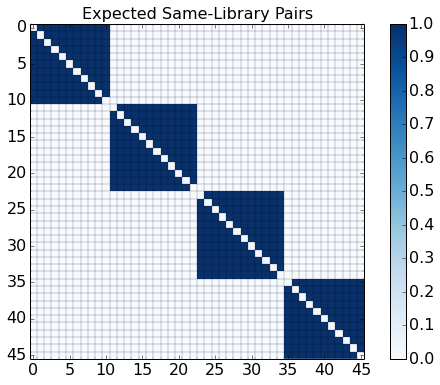

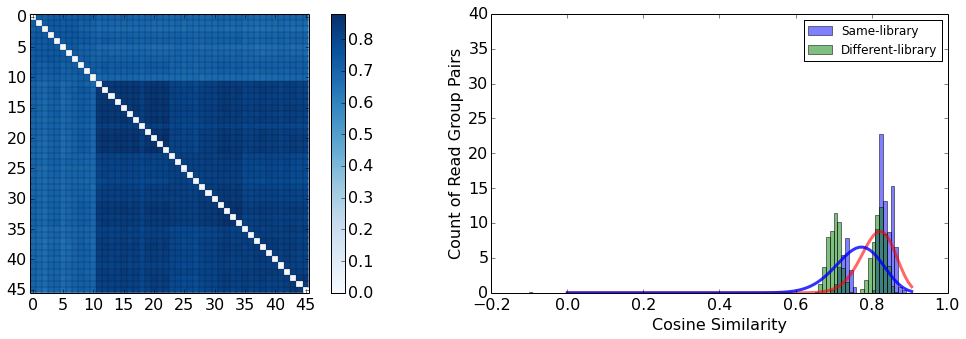

In [68]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes
ten_libraries_distances = { \
#               "All Pairs Affinity" : "feb_test_exomes_op_fix_libraries.ep_affinity.csv", \
#               "Exact Pairs Affinity" : "noF_test_ice_only_libraries.ep_affinity.csv", \
#               "All Pairs Affinity" : "feb_test_two_sense_libraries.cosine.csv", \
#               "Exact Pairs Affinity" : "feb_test_ice_only_libraries.ep_affinity.csv", \
# 

#               "Jaccard Similarity" : "noF_test_ice_only_libraries.jaccard.csv", \
              "Cosine Similarity" : "noF_test_ice_only_libraries.cosine.csv", \
#              "ep Similarity" : "optNo_test_rna_libraries.three.csv", \
#               "Random Pairs Affinity" : "test_10_exome_libraries.random.csv" , \
#               "Unlimited Pairs Affinity" : "znoF_test_two_sense_libraries.unlimited.csv", \
#               "Ten limited Affinity" : "test_10_exome_libraries.ten.csv", \
#               "Five limited Affinity" : "test_10_exome_libraries.five.csv", \
#               "Four limited Affinity" : "test_10_exome_libraries.four.csv", \
#               "Three limited Affinity" : "test_10_exome_libraries.three.csv", \
#               "Two limited Affinity" : "test_10_exome_libraries.two.csv" \
             }

ten_libraries_metadata ="noF_test_ice_only_libraries.read_groups.json"

ec, cv, fs, fd = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

display(ec)
# display(fs)
# display(fd)

In [29]:
# print ec['LLR_threshold']
print ec['LLR p(same-library | truly same-library)']
print ec['LLR p(different-library | truly different-library)']
print
print ec['Dist Clusters discovered']
print ec['Cluster rand index']
print ec['Cluster p(same-library | truly same-library)']
print ec['Cluster p(different-library | truly different-library)']
print
print ec['ratio clusters discovered']
print ec['Ratio Cluster rand index']
print ec['Ratio Cluster p(same-library | truly same-library)']
print ec['Ratio Cluster p(different-library | truly different-library)']

# farp = pd.DataFrame(ec['Expected False-Diffs'])
# farp.columns = ['foof']
# farp

Exact Pairs Affinity    0.994444
Name: LLR p(same-library | truly same-library), dtype: float64
Exact Pairs Affinity    0.958333
Name: LLR p(different-library | truly different-library), dtype: float64

Exact Pairs Affinity    3
Name: Dist Clusters discovered, dtype: int64
Exact Pairs Affinity    1.0
Name: Cluster rand index, dtype: float64
Exact Pairs Affinity    1.0
Name: Cluster p(same-library | truly same-library), dtype: float64
Exact Pairs Affinity    1.0
Name: Cluster p(different-library | truly different-library), dtype: float64

Exact Pairs Affinity    4
Name: ratio clusters discovered, dtype: int64
Exact Pairs Affinity    0.975177
Name: Ratio Cluster rand index, dtype: float64
Exact Pairs Affinity    0.922222
Name: Ratio Cluster p(same-library | truly same-library), dtype: float64
Exact Pairs Affinity    1.0
Name: Ratio Cluster p(different-library | truly different-library), dtype: float64


1
Training subset indices
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 17 18 19 20 22]
Testing subset indices
[ 7 16 21 23 24 25]


p(different-library | truly different-library)  \
All Pairs Affinity subset 1                                              1.0   

                              p(same-library | truly same-library)  \
All Pairs Affinity subset 1                                    1.0   

                              rand index  \
All Pairs Affinity subset 1          1.0   

                             Cluster p(different-library | truly different-library)  \
All Pairs Affinity subset 1                                                0.0        

                             Cluster p(same-library | truly same-library)  \
All Pairs Affinity subset 1                                           1.0   

                             Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity subset 1            0.466667                         1   

                             Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity subset 1          1.916616e-12          9.661161e-12   

                             Hellinger Distance    ...      max_distance  \
All Pairs Affinity subset 1                 1.0    ...          1.000643   

                             ratio clusters discovered  \
All Pairs Affinity subset 1                          2   

                             ratio p(different-library | truly different-library)  \
All Pairs Affinity subset 1                                                1.0      

                             ratio p(same-library | truly same-library)  \
All Pairs Affinity subset 1                                    0.714286   

                             ratio rand index  ratio_part_mod  \
All Pairs Affinity subset 1          0.866667            0.32   

                             ratio_threshold  same-lib alpha  same-lib beta  \
All Pairs Affinity subset 1     5.376807e+09   162650.555091       0.067112   

                             threshold  
All Pairs Affinity subset 1   0.972543  

[1 rows x 36 columns]

2
Training subset indices
[ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 18 20 21 22 23 24 25]
Testing subset indices
[ 1  6 12 13 19]


p(different-library | truly different-library)  \
All Pairs Affinity subset 2                                              1.0   

                              p(same-library | truly same-library)  \
All Pairs Affinity subset 2                                    1.0   

                              rand index  \
All Pairs Affinity subset 2          1.0   

                             Cluster p(different-library | truly different-library)  \
All Pairs Affinity subset 2                                                0.0        

                             Cluster p(same-library | truly same-library)  \
All Pairs Affinity subset 2                                           1.0   

                             Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity subset 2                 0.3                         1   

                             Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity subset 2              0.000297              0.000458   

                             Hellinger Distance    ...      max_distance  \
All Pairs Affinity subset 2            0.998504    ...          1.000547   

                             ratio clusters discovered  \
All Pairs Affinity subset 2                          2   

                             ratio p(different-library | truly different-library)  \
All Pairs Affinity subset 2                                                1.0      

                             ratio p(same-library | truly same-library)  \
All Pairs Affinity subset 2                                         1.0   

                             ratio rand index  ratio_part_mod  \
All Pairs Affinity subset 2               1.0   -1.087445e-36   

                             ratio_threshold  same-lib alpha  same-lib beta  \
All Pairs Affinity subset 2        70.814662      486.463445       0.053044   

                             threshold  
All Pairs Affinity subset 2    0.97326  

[1 rows x 36 columns]

3
Training subset indices
[ 0  1  2  3  5  6  7  8 10 12 13 14 15 16 17 19 20 21 23 24 25]
Testing subset indices
[ 4  9 11 18 22]


p(different-library | truly different-library)  \
All Pairs Affinity subset 3                                              1.0   

                              p(same-library | truly same-library)  \
All Pairs Affinity subset 3                                    1.0   

                              rand index  \
All Pairs Affinity subset 3          1.0   

                             Cluster p(different-library | truly different-library)  \
All Pairs Affinity subset 3                                                0.0        

                             Cluster p(same-library | truly same-library)  \
All Pairs Affinity subset 3                                           1.0   

                             Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity subset 3                 0.2                         1   

                             Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity subset 3              0.000161              0.000264   

                             Hellinger Distance    ...      max_distance  \
All Pairs Affinity subset 3            0.999086    ...          1.000705   

                             ratio clusters discovered  \
All Pairs Affinity subset 3                          2   

                             ratio p(different-library | truly different-library)  \
All Pairs Affinity subset 3                                                1.0      

                             ratio p(same-library | truly same-library)  \
All Pairs Affinity subset 3                                         1.0   

                             ratio rand index  ratio_part_mod  \
All Pairs Affinity subset 3               1.0             0.5   

                             ratio_threshold  same-lib alpha  same-lib beta  \
All Pairs Affinity subset 3        75.918057      590.198484       0.051747   

                             threshold  
All Pairs Affinity subset 3    0.97326  

[1 rows x 36 columns]

4
Training subset indices
[ 1  2  4  5  6  7  9 10 11 12 13 16 17 18 19 20 21 22 23 24 25]
Testing subset indices
[ 0  3  8 14 15]


p(different-library | truly different-library)  \
All Pairs Affinity subset 4                                              1.0   

                              p(same-library | truly same-library)  \
All Pairs Affinity subset 4                                    1.0   

                              rand index  \
All Pairs Affinity subset 4          1.0   

                             Cluster p(different-library | truly different-library)  \
All Pairs Affinity subset 4                                                0.0        

                             Cluster p(same-library | truly same-library)  \
All Pairs Affinity subset 4                                           1.0   

                             Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity subset 4                 0.4                         1   

                             Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity subset 4              0.000369              0.000556   

                             Hellinger Distance    ...      max_distance  \
All Pairs Affinity subset 4            0.998222    ...          1.000483   

                             ratio clusters discovered  \
All Pairs Affinity subset 4                          2   

                             ratio p(different-library | truly different-library)  \
All Pairs Affinity subset 4                                                1.0      

                             ratio p(same-library | truly same-library)  \
All Pairs Affinity subset 4                                         1.0   

                             ratio rand index  ratio_part_mod  \
All Pairs Affinity subset 4               1.0           0.375   

                             ratio_threshold  same-lib alpha  same-lib beta  \
All Pairs Affinity subset 4        44.845996      495.935703       0.052924   

                             threshold  
All Pairs Affinity subset 4    0.97291  

[1 rows x 36 columns]

5
Training subset indices
[ 0  1  3  4  6  7  8  9 11 12 13 14 15 16 18 19 21 22 23 24 25]
Testing subset indices
[ 2  5 10 17 20]


p(different-library | truly different-library)  \
All Pairs Affinity subset 5                                              1.0   

                              p(same-library | truly same-library)  \
All Pairs Affinity subset 5                                    1.0   

                              rand index  \
All Pairs Affinity subset 5          1.0   

                             Cluster p(different-library | truly different-library)  \
All Pairs Affinity subset 5                                                0.0        

                             Cluster p(same-library | truly same-library)  \
All Pairs Affinity subset 5                                           1.0   

                             Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity subset 5                 0.2                         1   

                             Expected False-Diffs  Expected False-Sames  \
All Pairs Affinity subset 5              0.000199               0.00032   

                             Hellinger Distance    ...      max_distance  \
All Pairs Affinity subset 5            0.998911    ...          1.002003   

                             ratio clusters discovered  \
All Pairs Affinity subset 5                          2   

                             ratio p(different-library | truly different-library)  \
All Pairs Affinity subset 5                                                1.0      

                             ratio p(same-library | truly same-library)  \
All Pairs Affinity subset 5                                         1.0   

                             ratio rand index  ratio_part_mod  \
All Pairs Affinity subset 5               1.0             0.5   

                             ratio_threshold  same-lib alpha  same-lib beta  \
All Pairs Affinity subset 5        41.442615      628.364674       0.053277   

                             threshold  
All Pairs Affinity subset 5    0.97326  

[1 rows x 36 columns]

cross validation result


All Pairs Affinity subset 1
 p(different-library | truly different-library)                    1.000000e+00
 p(same-library | truly same-library)                              1.000000e+00
 rand index                                                        1.000000e+00
Cluster p(different-library | truly different-l...                 0.000000e+00
Cluster p(same-library | truly same-library)                       1.000000e+00
Cluster rand index                                                 3.133333e-01
Dist Clusters discovered                                           1.000000e+00
Expected False-Diffs                                               2.050692e-04
Expected False-Sames                                               3.195763e-04
Hellinger Distance                                                 9.989447e-01
LLR Cluster p(different-library | truly differe...                 7.000000e-01
LLR Cluster p(same-library | truly same-library)                   1.000000e+00
LLR Cluster rand index                                             7.800000e-01
LLR Clusters discovered                                            1.800000e+00
LLR p(different-library | truly different-library)                 1.000000e+00
LLR p(same-library | truly same-library)                           9.428571e-01
LLR rand index                                                     9.733333e-01
LLR_part_mod                                                       1.809383e-01
LLR_threshold                                                      0.000000e+00
Ratio Cluster p(different-library | truly diffe...                 8.714286e-01
Ratio Cluster p(same-library | truly same-library)                 1.000000e+00
Ratio Cluster rand index                                           9.000000e-01
diff-lib alpha                                                     2.081129e+01
diff-lib beta                                                      3.265169e+00
dist_part_mod                                                      2.220446e-17
expected_part_mod                                                 -1.095690e-01
max_distance                                                       1.000876e+00
ratio clusters discovered                                          2.000000e+00
ratio p(different-library | truly different-lib...                 1.000000e+00
ratio p(same-library | truly same-library)                         9.428571e-01
ratio rand index                                                   9.733333e-01
ratio_part_mod                                                     3.390000e-01
ratio_threshold                                                    1.075361e+09
same-lib alpha                                                     3.297030e+04
same-lib beta                                                      5.562095e-02
threshold                                                          9.730465e-01

evaluation criteria


All Pairs Affinity
 p(different-library | truly different-library)               1.000000
 p(same-library | truly same-library)                         1.000000
 rand index                                                   1.000000
Cluster p(different-library | truly different-l...            0.555556
Cluster p(same-library | truly same-library)                  1.000000
Cluster rand index                                            0.704615
Dist Clusters discovered                                      2.000000
Expected False-Diffs                                          0.000105
Expected False-Sames                                          0.000186
Hellinger Distance                                            0.999318
LLR Cluster p(different-library | truly differe...            1.000000
LLR Cluster p(same-library | truly same-library)              1.000000
LLR Cluster rand index                                        1.000000
LLR Clusters discovered                                       3.000000
LLR p(different-library | truly different-library)            1.000000
LLR p(same-library | truly same-library)                      1.000000
LLR rand index                                                1.000000
LLR_part_mod                                                  0.190459
LLR_threshold                                                 0.000000
Ratio Cluster p(different-library | truly diffe...            1.000000
Ratio Cluster p(same-library | truly same-library)            1.000000
Ratio Cluster rand index                                      1.000000
diff-lib alpha                                               20.246748
diff-lib beta                                                 3.170754
dist_part_mod                                                 0.009713
expected_part_mod                                             0.001384
max_distance                                                  1.002637
ratio clusters discovered                                     3.000000
ratio p(different-library | truly different-lib...            1.000000
ratio p(same-library | truly same-library)                    1.000000
ratio rand index                                              1.000000
ratio_part_mod                                                0.545039
ratio_threshold                                              41.442615
same-lib alpha                                              763.548426
same-lib beta                                                 0.052537
threshold                                                     0.973046

false calls


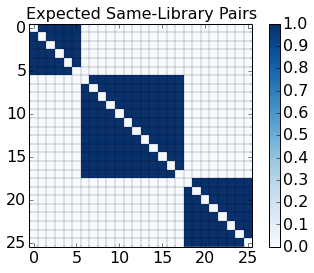

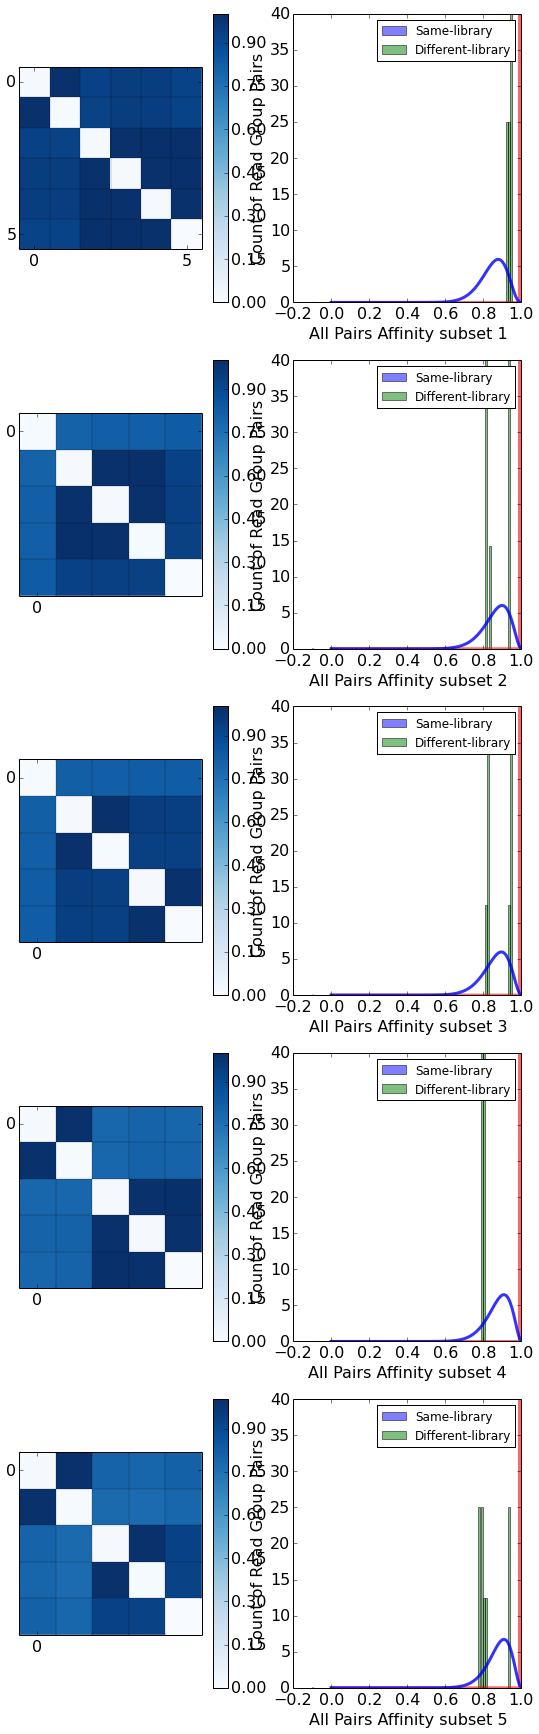

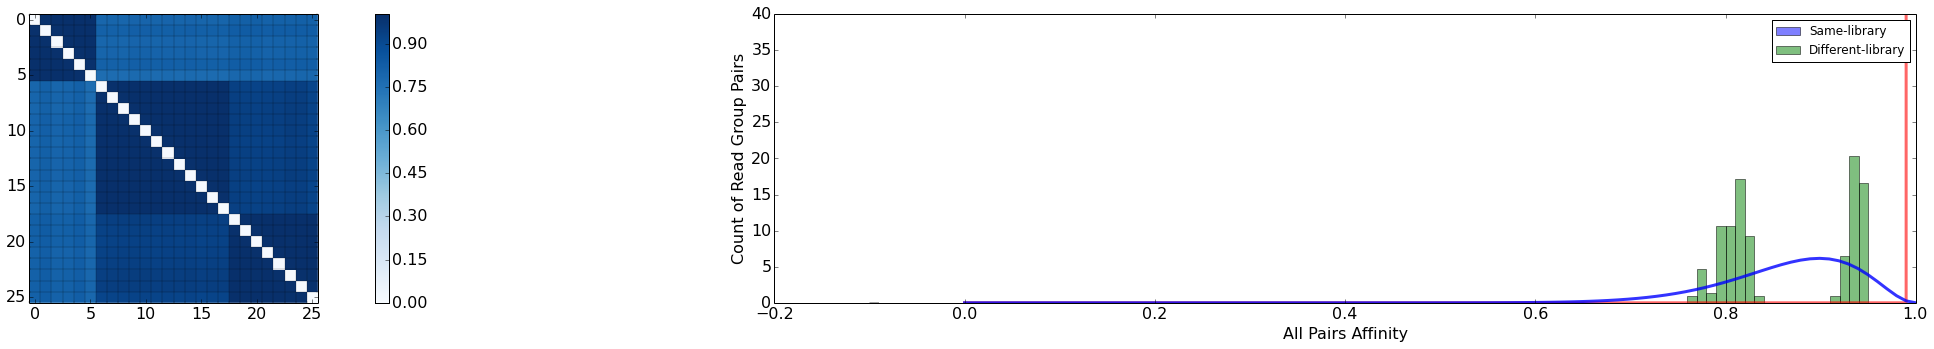

In [79]:
# Run experiment only on all-pairs affinity to test various threshold getters. Evaluate intermediates to see the process of building the threshold
ap_distance = pd.read_csv("optNo_test_two_sense_libraries.ap_affinity.csv", header=[0,1], index_col=[0,1])
metadata_file = "optNo_test_two_sense_libraries.read_groups.json"
meta = read_metadata(metadata_file)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)
plot_matrix(truth, title="Expected Same-Library Pairs")

fig = plt.figure(3, figsize=(45, 6*5))
i = 0

# evaluation, false_calls = run_experiment(ap_distance, len(groups), "All Pairs Affinity", truth, min_max_mean, np.mean, True, fig, 5, 0)    
evaluation, cross_val, false_sames, false_diffs = run_experiment(ap_distance, len(groups), "All Pairs Affinity", truth, zero_threshold, np.mean, True, fig, 5, 0)    

evaluation_criteria = evaluation
# all_false_calls = false_calls
print "cross validation result"
display(cross_val.sort_index().T)
print "evaluation criteria"
display(evaluation_criteria.sort_index().T)
print "false calls"
# display(all_false_calls)


{'__doc__': 'A beta continuous random variable.\n\n    Continuous random variables are defined from a standard form and may\n    require some shape parameters to complete its specification.  Any\n    optional keyword parameters can be passed to the methods of the RV\n    object as given below:\n    \n    Methods\n    -------\n    rvs(a, b, loc=0, scale=1, size=1)\n        Random variates.\n    pdf(x, a, b, loc=0, scale=1)\n        Probability density function.\n    logpdf(x, a, b, loc=0, scale=1)\n        Log of the probability density function.\n    cdf(x, a, b, loc=0, scale=1)\n        Cumulative density function.\n    logcdf(x, a, b, loc=0, scale=1)\n        Log of the cumulative density function.\n    sf(x, a, b, loc=0, scale=1)\n        Survival function (1-cdf --- sometimes more accurate).\n    logsf(x, a, b, loc=0, scale=1)\n        Log of the survival function.\n    ppf(q, a, b, loc=0, scale=1)\n        Percent point function (inverse of cdf --- percentiles).\n    isf(q, a, b, 

In [ ]:
# Run experiment only on all-pairs affinity to test various threshold getters. Evaluate intermediates to see the process of building the threshold
ap_distance = pd.read_csv("noF_test_two_sense_libraries.ap_affinity.csv", header=[0,1], index_col=[0,1])
metadata_file = "noF_test_two_sense_libraries.read_groups.json"
meta = read_metadata(metadata_file)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)
plot_matrix(truth, title="Expected Same-Library Pairs")

fig = plt.figure(3, figsize=(45, 6*5))
i = 0

evaluation, false_calls = run_experiment(ap_distance, len(groups), "Unlimited Affinity", truth, min_max_mean, np.mean, True, fig, 5, 0)    
evaluation_criteria = evaluation
all_false_calls = false_calls
print "evaluation criteria"
display(evaluation_criteria.sort_index())
print "false calls"
display(all_false_calls)


In [66]:
import matplotlib.patches as mpatches
import matplotlib.markers as mk
import matplotlib.colors as mcl

def plot_scatter(x_df, y_df, x_label, y_label, title=None, ax=None, draw_line=False, display_legend=False, draw_nineties=False):
    al = 0.5
    marker_size = 75
    
    if x_df.shape != y_df.shape:
        raise AssertionError("Attempting to create scatterplot from two dataframes with different shape")
    
    if ax is None:
        ax = plt.gca()
    
    rows = range(len(x_df.index))
    for i in xrange(len(x_df.columns)):
        dataset_key = x_df.columns[i]
        ax.scatter(x=x_df[dataset_key], y=y_df[dataset_key], c=rows, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', label=dataset_key, alpha=al)
    
    if draw_line:
        ax.plot([0,1.1], [0,1.1], c='k')
        
    if draw_nineties:
        ax.plot([0.9,0.9], [0, 1.1], c='k', linestyle='--')
        ax.plot([0, 1.1], [0.9,0.9], c='k', linestyle='--')

        
    ax.set_ylim(ymin=0, ymax=1.01)
    ax.set_xlim(xmin=0, xmax=1.01)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if title is not None:
        ax.set_title(title)
    
    if display_legend:
        # Set up an extra set of handles/labels within the legend, for the color key
        cmap = plt.cm.get_cmap()
        norm = mcl.Normalize(vmin=0,vmax=rows[-1])
        patches = []
        for i in rows:
            patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
        handles, labels = ax.get_legend_handles_labels()
        new_handle = [handle for i,handle in enumerate(handles)]+patches
        new_label = [label for i,label in enumerate(labels)]+[dist for dist in x_df.index]

        # display the legend
#         ax.legend(new_handle, new_label, loc=3)
        ax.legend(new_handle, new_label, ncol=2, bbox_to_anchor=(4.3,1.01))


    


In [ ]:
fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["LLR_sensitivity"], "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True)
plot_scatter(metrics["Cluster_specificity"], metrics["Cluster_sensitivity"], "Specificity", "Sensitivity", "Distance Clustering Performance by Dataset", ax=plot2)
plot_scatter(metrics["ratio_cluster_specificity"], metrics["ratio_cluster_sensitivity"], "Specificity", "Sensitivity", "Ratio Clustering Performance by Dataset", ax=plot3)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["Cluster_specificity"], "Pairwise Specificity", "Clustering Specificity", "Pairwise vs Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_specificity"], metrics["ratio_cluster_specificity"], "Pairwise Specificity", "Ratio Clustering Specificity", "Pairwise vs Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_specificity"], metrics["ratio_cluster_specificity"], "Clustering Specificity", "Ratio Clustering Specificity", "Clustering vs Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "LLR Pairwise Sensitivity", "Clustering Sensitivity", "LLR Pairwise vs Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_sensitivity"], metrics["ratio_cluster_sensitivity"], "LLR Pairwise Sensitivity", "Ratio Clustering Sensitivity", "LLR Pairwise vs Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_sensitivity"], metrics["ratio_cluster_sensitivity"], "Cluster Sensitivity", "Ratio Clustering Sensitivity", "Clustering vs Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [ ]:
distance = u'Exact Pairs Affinity'

Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T

Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T

LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T

Rsp = pd.DataFrame(metrics["ratio_specificity"].loc[distance]).T
Rse = pd.DataFrame(metrics["ratio_sensitivity"].loc[distance]).T


fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True, draw_nineties=True)
plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Similarity Clustering Performance by Dataset", ax=plot2, draw_nineties=True)
plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Likelihood Ratio Clustering Performance by Dataset", ax=plot3, draw_nineties=True)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(Lsp, Csp, "LLR Pairwise Specificity", "Similarity Clustering Specificity", "LLR Pairwise vs Similarity Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=False)
plot_scatter(Lsp, LCsp, "LLR Pairwise Specificity", "Likelihood Ratio Clustering Specificity", "LLR Pairwise vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(Csp, LCsp, "Similarity Clustering Specificity", "Likelihood Ratio Clustering Specificity", "Similarity Clustering vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(Lse, Cse, "LLR Pairwise Sensitivity", "Similarity Clustering Sensitivity", "LLR Pairwise vs Similarity Score Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=False)
plot_scatter(Lse, LCse, "LLR Pairwise Sensitivity", "Likelihood Ratio Clustering Sensitivity", "LLR Pairwise vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(Cse, LCse, "Similarity Clustering Sensitivity", "Likelihood Ratio Clustering Sensitivity", "Similarity Clustering vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [ ]:
distances = metrics["LLR_specificity"].index
print len(metrics)
print len(distances)
n_distances = len(distances)
fig = plt.figure(figsize=(24, 6*n_distances))
for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
    distance = distances[i]
    Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
    Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T
    
    Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
    Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T
    
    LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
    LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T
    
    # Get the appropriate axes
    plot_columns = 3
    cell_adjustment = i * plot_columns
    L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
    C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
    LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))
    
    # Only display the legend once
    doLegend = (i==0)
    
    plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
    plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
    plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)




In [ ]:
distances = metrics["LLR_specificity"].index
print len(metrics)
print len(distances)
n_distances = len(distances)
fig = plt.figure(figsize=(24, 6*n_distances))
for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
    distance = distances[i]
    Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
    Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T
    
    Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
    Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T
    
    LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
    LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T
    
    # Get the appropriate axes
    plot_columns = 3
    cell_adjustment = i * plot_columns
    L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
    C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
    LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))
    
    # Only display the legend once
    doLegend = (i==0)
    
    plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
    plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
    plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)




In [ ]:
distances = metrics["LLR_specificity"].index
print distances
# print len(metrics)
# print len(distances)
# n_distances = len(distances)
# fig = plt.figure(figsize=(24, 6*n_distances))
# for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
fig = plt.figure(figsize=(24, 96))
distance = u'Exact Pairs Affinity'
Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T

Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T

LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T

Rsp = pd.DataFrame(metrics["ratio_specificity"].loc[distance]).T
Rse = pd.DataFrame(metrics["ratio_sensitivity"].loc[distance]).T

# Get the appropriate axes
plot_columns = 3
cell_adjustment = i * plot_columns
L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))

# Only display the legend once
doLegend = True

plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)


fig2 = plt.figure(2, figsize=(8, 8))
plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=fig2.gca(), display_legend=True, draw_nineties=True)


fig3 = plt.figure(3, figsize=(8, 8))
plot_scatter(Rsp, Rse, "Specificity", "Sensitivity", "Ratio Pairwise Performance "+distance, ax=fig3.gca(), display_legend=True, draw_nineties=True)


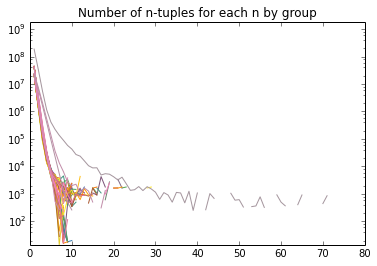

In [342]:
table_file = "feb_test_pcr_plus_libraries.table.json"
meta_file = "feb_test_pcr_plus_libraries.read_groups.json"

meta = read_metadata(meta_file)
table = read_table(table_file)  

groups, libraries = get_groups_and_libraries(meta)
n_groups = len(groups)
plus_matrix = multiplicity_matrix(table, n_groups)
plot_matrix_rows(plus_matrix, title='Number of n-tuples for each n by group')


In [343]:
table_file = "feb_test_pcr_free_libraries.table.json"
meta_file = "feb_test_pcr_free_libraries.read_groups.json"

meta = read_metadata(meta_file)
table = read_table(table_file)  

groups, libraries = get_groups_and_libraries(meta)
n_groups = len(groups)
free_matrix = multiplicity_matrix(table, n_groups)


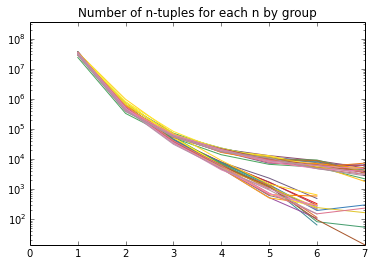

In [348]:
# plt.xlim(xmax=7)
# plot_matrix_rows(plus_matrix, title='Number of n-tuples for each n by group')
plt.xlim(xmax=7)
plot_matrix_rows(free_matrix, title='Number of n-tuples for each n by group')


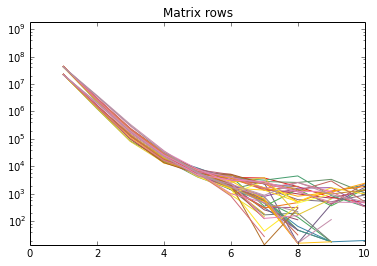

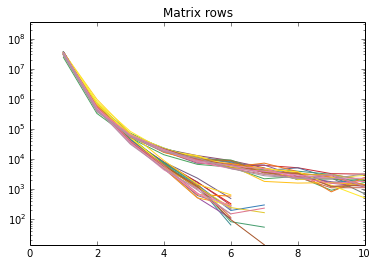

In [346]:
fig = plt.figure()
# ax = fig.add_subplot(211)
# plt.subplot(211)
plt.xlim(xmax=10)
plot_matrix_rows(plus_matrix)
# plot_matrix(free_matrix[:,:5], ax=ax)

# bx = fig.add_subplot(212)
# plt.subplot(212)
plt.xlim(xmax=10)
plot_matrix_rows(free_matrix)
# plot_matrix(plus_matrix[:,:5], ax=bx)

In [30]:
def run_all(category, handle):
    ten_libraries_distances = { \
#                   "All Pairs Affinity" : "{}_test_{}_libraries.ap_affinity.csv".format(category, handle), \
                  "Exact Pairs Affinity" : "{}_test_{}_libraries.ep_affinity.csv".format(category, handle), \
#                   "Jaccard Similarity Index" : "{}_test_{}_libraries.jaccard.csv".format(category, handle), \
#                   "Cosine Similarity" : "{}_test_{}_libraries.cosine.csv".format(category, handle), \
#                   "Random Pairs Affinity" : "{}_test_{}_libraries.random.csv".format(category, handle) , \
# #                   "Unlimited Pairs Affinity" : "{}_test_{}_libraries.unlimited.csv".format(category, handle), \
#                   "Ten limited Affinity" : "{}_test_{}_libraries.ten.csv".format(category, handle), \
#                   "Five limited Affinity" : "{}_test_{}_libraries.five.csv".format(category, handle), \
#                   "Four limited Affinity" : "{}_test_{}_libraries.four.csv".format(category, handle), \
#                   "Three limited Affinity" : "{}_test_{}_libraries.three.csv".format(category, handle), \
#                   "Two limited Affinity" : "{}_test_{}_libraries.two.csv".format(category, handle) \
                 }

    ten_libraries_metadata = "feb_test_{}_libraries.read_groups.json".format(handle)

    return evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

1
0
C9EPM.1 Solexa-375929
0 0 0
1
C9EPM.2 Solexa-375929
0 0 0
2
C9EPM.3 Solexa-375929
0 0 0
3
C9EPM.4 Solexa-375929
0 0 0
4
C9EPM.5 Solexa-375929
0 0 0
5
C9EPM.6 Solexa-375929
0 0 0
6
C9EPM.7 Solexa-375929
0 0 0
7
C9EPM.8 Solexa-375929
0 0 0
8
C9FRM.1 Solexa-375929
0 0 0
9
C9FRM.2 Solexa-375929
0 0 0
2
0
C9FRM.3 Solexa-375929
0 0 0
1
C9FRM.4 Solexa-375929
0 0 0
2
C9FRM.5 Solexa-375929
0 0 0
3
C9FRM.6 Solexa-375929
0 0 0
4
C9FRM.7 Solexa-375929
0 0 0
5
C9FRM.8 Solexa-375929
0 0 0
6
C9F2J.1 Solexa-376142
1 1 1
7
C9F2J.2 Solexa-376142
1 1 1
8
C9F2J.3 Solexa-376142
1 1 1
9
C9F2J.4 Solexa-376142
1 1 1
3
0
C9F2J.5 Solexa-376142
1 0 0
1
C9F2J.6 Solexa-376142
1 0 0
2
C9F2J.7 Solexa-376142
1 0 0
3
C9F2J.8 Solexa-376142
1 0 0
4
C9FC7.1 Solexa-376142
1 0 0
5
C9FC7.2 Solexa-376142
1 0 0
6
C9FC7.3 Solexa-376142
1 0 0
7
C9FC7.4 Solexa-376142
1 0 0
8
C9FC7.5 Solexa-376142
1 0 0
9
C9FC7.6 Solexa-376142
1 0 0
4
0

/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: overflow encountered in double_scalars



C9FC7.7 Solexa-376142
1 0 0
1
C9FC7.8 Solexa-376142
1 0 0
2
C90KF.4 Solexa-377359
2 1 1
3
C90KF.5 Solexa-377359
2 1 1
4
C90KF.6 Solexa-377359
2 1 1
5
C90KF.7 Solexa-377359
2 1 1
6
C90KF.8 Solexa-377359
2 1 1
7
C9JL0.1 Solexa-377359
2 1 1
8
C9JL0.2 Solexa-377359
2 1 1
5
0
C9JL0.3 Solexa-377359
2 0 0
1
C9JL0.4 Solexa-377359
2 0 0
2
C9JL0.5 Solexa-377359
2 0 0
3
C9JL0.6 Solexa-377359
2 0 0
4
C9JL0.7 Solexa-377359
2 0 0
5
C9JL0.8 Solexa-377359
2 0 0
6
H7MC2.1 Solexa-377359
2 1 1
7
H7MC2.2 Solexa-377359
2 1 1
8
H7N7G.2 Solexa-377359
2 0 0
0
C9EPM.1 Solexa-375929
0 0 0
1
C9EPM.2 Solexa-375929
0 0 0
2
C9EPM.3 Solexa-375929
0 0 0
3
C9EPM.4 Solexa-375929
0 0 0
4
C9EPM.5 Solexa-375929
0 0 0
5
C9EPM.6 Solexa-375929
0 0 0
6
C9EPM.7 Solexa-375929
0 0 0
7
C9EPM.8 Solexa-375929
0 0 0
8
C9FRM.1 Solexa-375929
0 0 0
9
C9FRM.2 Solexa-375929
0 0 0
10
C9FRM.3 Solexa-375929
0 0 0
11
C9FRM.4 Solexa-375929
0 0 0
12
C9FRM.5 Solexa-375929
0 0 0
13
C9FRM.6 Solexa-375929
0 0 0
14
C9FRM.7 Solexa-375929
0 0 0
15
C

Expected False-Sames
Exact Pairs Affinity          2.300240e-02
Exact Pairs Affinity          3.688981e-02
Exact Pairs Affinity          4.432654e-02
Exact Pairs Affinity          4.575608e-02
Exact Pairs Affinity          1.110223e-16

Expected False-Diffs
Exact Pairs Affinity              0.041020
Exact Pairs Affinity              0.042451
Exact Pairs Affinity              0.034378
Exact Pairs Affinity              0.014471
Exact Pairs Affinity              0.000868

evaluation criteria


p(different-library | truly different-library)  \
Exact Pairs Affinity                                         0.998698   

                       p(same-library | truly same-library)   rand index  \
Exact Pairs Affinity                               0.997222     0.998227   

                      Cluster p(different-library | truly different-library)  \
Exact Pairs Affinity                                                1.0        

                      Cluster p(same-library | truly same-library)  \
Exact Pairs Affinity                                           1.0   

                      Cluster rand index  Dist Clusters discovered  \
Exact Pairs Affinity                 1.0                         3   

                      Expected False-Diffs  Expected False-Sames  \
Exact Pairs Affinity              0.034378              0.044327   

                      Hellinger Distance    ...      max_distance  \
Exact Pairs Affinity            0.910645    ...          1.028803   

                      ratio clusters discovered  \
Exact Pairs Affinity                          4   

                      ratio p(different-library | truly different-library)  \
Exact Pairs Affinity                                           0.992188      

                      ratio p(same-library | truly same-library)  \
Exact Pairs Affinity                                    0.997222   

                      ratio rand index  ratio_part_mod  ratio_threshold  \
Exact Pairs Affinity          0.993794        0.658946         0.081043   

                      same-lib alpha  same-lib beta  threshold  
Exact Pairs Affinity        0.982265       0.076948   0.355353  

[1 rows x 36 columns]

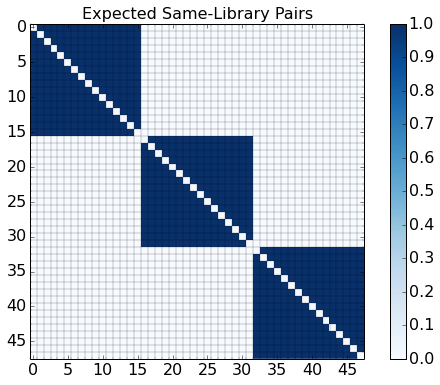

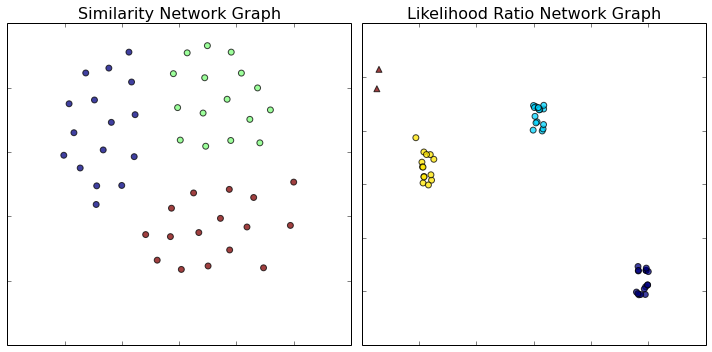

In [35]:
ohNo = run_all("feb", "strand_agnostic")

In [39]:
ohNo[0].T

Exact Pairs Affinity
 p(different-library | truly different-library)                 0.998698
 p(same-library | truly same-library)                           0.997222
 rand index                                                     0.998227
Cluster p(different-library | truly different-l...              1.000000
Cluster p(same-library | truly same-library)                    1.000000
Cluster rand index                                              1.000000
Dist Clusters discovered                                        3.000000
Expected False-Diffs                                            0.034378
Expected False-Sames                                            0.044327
Hellinger Distance                                              0.910645
LLR Cluster p(different-library | truly differe...              1.000000
LLR Cluster p(same-library | truly same-library)                1.000000
LLR Cluster rand index                                          1.000000
LLR Clusters discovered                                         3.000000
LLR p(different-library | truly different-library)              0.992188
LLR p(same-library | truly same-library)                        0.997222
LLR rand index                                                  0.993794
LLR_part_mod                                                    0.641885
LLR_threshold                                                  -2.516889
Ratio Cluster p(different-library | truly diffe...              1.000000
Ratio Cluster p(same-library | truly same-library)              0.922222
Ratio Cluster rand index                                        0.975177
diff-lib alpha                                                 15.002948
diff-lib beta                                                  43.853526
dist_part_mod                                                   0.277596
expected_part_mod                                               0.277596
max_distance                                                    1.028803
ratio clusters discovered                                       4.000000
ratio p(different-library | truly different-lib...              0.992188
ratio p(same-library | truly same-library)                      0.997222
ratio rand index                                                0.993794
ratio_part_mod                                                  0.658946
ratio_threshold                                                 0.081043
same-lib alpha                                                  0.982265
same-lib beta                                                   0.076948
threshold                                                       0.355353

In [45]:
data_types = ["pcr_free", "pcr_plus",  "genomes", "combined", "ice_only", "agilent_only", "exomes", "two_sense","strand_agnostic", "rna"] # "genomes", "combined"] # Omit genomes_new, combined due to inclusion of PCR-free


def all_sets(data_types, flavor):
    labels = []
    metrics = {}
    for j in xrange(len(data_types)):
        data = data_types[j]
        print "evaluating {}".format(data)
        distance_files = { \
                  "All Pairs Affinity" : "{}_test_{}_libraries.ap_affinity.csv".format(flavor, data), \
                  "Exact Pairs Affinity" : "{}_test_{}_libraries.ep_affinity.csv".format(flavor, data), \
                  "Jaccard Similarity Index" : "{}_test_{}_libraries.jaccard.csv".format(flavor, data), \
                  "Cosine Similarity" : "{}_test_{}_libraries.cosine.csv".format(flavor, data), \
                  "Random Pairs Affinity" : "{}_test_{}_libraries.random.csv".format(flavor, data), \
#                   "Unlimited Pairs Affinity" : "{}_test_{}_libraries.unlimited.csv".format(flavor, data), \
                  "Ten limited Affinity" : "{}_test_{}_libraries.ten.csv".format(flavor, data), \
                  "Five limited Affinity" : "{}_test_{}_libraries.five.csv".format(flavor, data), \
                  "Four limited Affinity" : "{}_test_{}_libraries.four.csv".format(flavor, data), \
                  "Three limited Affinity" : "{}_test_{}_libraries.three.csv".format(flavor, data), \
#                   "Two limited Affinity" : "{}_test_{}_libraries.two.csv".format(flavor, data) \
                 }
        metadata_file = "{}_test_{}_libraries.read_groups.json".format(flavor, data)

        meta = read_metadata(metadata_file)
        groups, libraries = get_groups_and_libraries(meta)
        truth = make_truth_matrix(groups, libraries)
        
        i = 0
        evaluation_criteria = None
        for test_label, test_file in distance_files.iteritems():
            i += 1
            print "evaluating {}".format(test_label)
            distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
            evaluation, false_calls = run_experiment(distance, len(groups), test_label, truth, min_max_mean, np.mean, False, None, len(distance_files), i)
            if i == 1:
                evaluation_criteria = evaluation
                all_false_calls = false_calls
            else:
                evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
                if false_calls is not None:
                    if all_false_calls is None:
                        all_false_calls = false_calls
                    else:
                        all_false_calls = all_false_calls.append(false_calls)

        # Gather up some of the metrics sliced from our broader evaluation criteria
        per_type_metrics = {}
#         per_type_metrics = { \
#             "LLR_rand_index" : evaluation_criteria["LLR rand index"], \
#             "LLR_sensitivity" : evaluation_criteria["LLR p(same-library | truly same-library)"], \
#             "LLR_specificity" : evaluation_criteria["LLR p(different-library | truly different-library)"], \
#             "Cluster_rand_index" : evaluation_criteria["Cluster rand index"], \
#             "Cluster_sensitivity" : evaluation_criteria["Cluster p(same-library | truly same-library)"], \
#             "Cluster_specificity" : evaluation_criteria["Cluster p(different-library | truly different-library)"], \
#             "LLR_cluster_rand_index" : evaluation_criteria["LLR Cluster rand index"], \
#             "LLR_cluster_sensitivity" : evaluation_criteria["LLR Cluster p(same-library | truly same-library)"], \
#             "LLR_cluster_specificity" : evaluation_criteria["LLR Cluster p(different-library | truly different-library)"], \
#             "ratio_rand_index" : evaluation_criteria["ratio rand index"], \
#             "ratio_sensitivity" : evaluation_criteria["ratio p(same-library | truly same-library)"], \
#             "ratio_specificity" : evaluation_criteria["ratio p(different-library | truly different-library)"], \
#             "ratio_cluster_rand_index" : evaluation_criteria["Ratio Cluster rand index"], \
#             "ratio_cluster_sensitivity" : evaluation_criteria["Ratio Cluster p(same-library | truly same-library)"], \
#             "ratio_cluster_specificity" : evaluation_criteria["Ratio Cluster p(different-library | truly different-library)"] \
#         }
        
        
        for col in evaluation_criteria.columns:
            updated = col.replace(" ", "_")
            per_type_metrics[updated] = evaluation_criteria[col]
        
#         per_type_metrics = evaluation_criteria


        if j == 0:
            labels = [data]

            # wrap each metric in a dataframe and keep hold of it as the nucleus for our growing list
            for key, value in per_type_metrics.iteritems():
                metrics[key] = pd.DataFrame(value)

        else:
            labels.append(data)

            # concatenate the new data-types metrics to our existing ones.
            for key, value in metrics.iteritems():
                metrics[key] = pd.concat([metrics[key], per_type_metrics[key]], axis=1)

        # update the labels and do a diagnostic print
        for key, value in metrics.iteritems():
            metrics[key].columns=labels    
            print key
            display(metrics[key])

    # Get a consistent sort on the indices for all final metrics
    # Also cache a copy of each frame
    for key, value in metrics.iteritems():
            metrics[key] = metrics[key].sort_index()
            metrics_file = "{}_{}_evaluation.csv".format(flavor, key)
            metrics[key].to_csv(metrics_file)
    
    return metrics

In [18]:
data_types = ["pcr_free", "pcr_plus",  "genomes", "combined", "ice_only", "agilent_only", "exomes", "two_sense","strand_agnostic", "rna"] # "genomes", "combined"] # Omit genomes_new, combined due to inclusion of PCR-free


def all_sets_new_thresh(data_types, flavor):
    labels = []
    metrics = {}
    cross_val = {}
    all_false_sames = None
    all_false_diffs = None
    for j in xrange(len(data_types)):
        data = data_types[j]
        print "evaluating {}".format(data)
        distance_files = { \
                  "All Pairs Affinity" : "{}_test_{}_libraries.ap_affinity.csv".format(flavor, data), \
                  "Exact Pairs Affinity" : "{}_test_{}_libraries.ep_affinity.csv".format(flavor, data), \
                  "Jaccard Similarity Index" : "{}_test_{}_libraries.jaccard.csv".format(flavor, data), \
                  "Cosine Similarity" : "{}_test_{}_libraries.cosine.csv".format(flavor, data), \
                  "Random Pairs Affinity" : "{}_test_{}_libraries.random.csv".format(flavor, data), \
#                   "Unlimited Pairs Affinity" : "{}_test_{}_libraries.unlimited.csv".format(flavor, data), \
                  "Ten limited Affinity" : "{}_test_{}_libraries.ten.csv".format(flavor, data), \
                  "Five limited Affinity" : "{}_test_{}_libraries.five.csv".format(flavor, data), \
                  "Four limited Affinity" : "{}_test_{}_libraries.four.csv".format(flavor, data), \
                  "Three limited Affinity" : "{}_test_{}_libraries.three.csv".format(flavor, data), \
#                   "Two limited Affinity" : "{}_test_{}_libraries.two.csv".format(flavor, data) \
                 }
        metadata_file = "{}_test_{}_libraries.read_groups.json".format(flavor, data)

        meta = read_metadata(metadata_file)
        groups, libraries = get_groups_and_libraries(meta)
        truth = make_truth_matrix(groups, libraries)
        
        i = 0
        evaluation_criteria = None
        cv_full = None
        type_false_sames = None
        type_false_diffs = None
        for test_label, test_file in distance_files.iteritems():
            i += 1
            print "evaluating {}".format(test_label)
            distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
            evaluation, cv_result, false_sames, false_diffs = run_experiment(distance, len(groups), test_label, truth, zero_threshold, np.mean, False, None, len(distance_files), i)
            if i == 1:
                evaluation_criteria = evaluation
                cv_full = cv_result
                type_false_sames = false_sames
                type_false_diffs = false_diffs
            else:
                evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
                cv_full = cv_full.append(cv_result)#, ignore_index=True)
                if false_sames is not None:
                    if type_false_sames is None:
                        type_false_sames = false_sames
                        type_false_diffs = false_diffs
                    else:
                        type_false_sames = type_false_sames.append(false_sames)
                        type_false_diffs = type_false_diffs.append(false_diffs)

        # Gather up some of the metrics sliced from our broader evaluation criteria
        per_type_metrics = {}
        per_type_cv = {}
#         per_type_metrics = { \
#             "LLR_rand_index" : evaluation_criteria["LLR rand index"], \
#             "LLR_sensitivity" : evaluation_criteria["LLR p(same-library | truly same-library)"], \
#             "LLR_specificity" : evaluation_criteria["LLR p(different-library | truly different-library)"], \
#             "Cluster_rand_index" : evaluation_criteria["Cluster rand index"], \
#             "Cluster_sensitivity" : evaluation_criteria["Cluster p(same-library | truly same-library)"], \
#             "Cluster_specificity" : evaluation_criteria["Cluster p(different-library | truly different-library)"], \
#             "LLR_cluster_rand_index" : evaluation_criteria["LLR Cluster rand index"], \
#             "LLR_cluster_sensitivity" : evaluation_criteria["LLR Cluster p(same-library | truly same-library)"], \
#             "LLR_cluster_specificity" : evaluation_criteria["LLR Cluster p(different-library | truly different-library)"], \
#             "ratio_rand_index" : evaluation_criteria["ratio rand index"], \
#             "ratio_sensitivity" : evaluation_criteria["ratio p(same-library | truly same-library)"], \
#             "ratio_specificity" : evaluation_criteria["ratio p(different-library | truly different-library)"], \
#             "ratio_cluster_rand_index" : evaluation_criteria["Ratio Cluster rand index"], \
#             "ratio_cluster_sensitivity" : evaluation_criteria["Ratio Cluster p(same-library | truly same-library)"], \
#             "ratio_cluster_specificity" : evaluation_criteria["Ratio Cluster p(different-library | truly different-library)"] \
#         }
        
        
        for col in evaluation_criteria.columns:
            updated = col.replace(" ", "_")
            per_type_metrics[updated] = evaluation_criteria[col]
            per_type_cv[updated] = cv_full[col]
        
#         per_type_metrics = evaluation_criteria

        type_false_sames.columns = [data]
        type_false_diffs.columns = [data]
        
    
        if j == 0:
            labels = [data]

            # wrap each metric in a dataframe and keep hold of it as the nucleus for our growing list
            for key, value in per_type_metrics.iteritems():
                metrics[key] = pd.DataFrame(value)
            
            for key, value in per_type_cv.iteritems():
                cross_val[key] = pd.DataFrame(value)
            
            all_false_sames = type_false_sames
            all_false_diffs = type_false_diffs

        else:
            labels.append(data)

            # concatenate the new data-types metrics to our existing ones.
            for key, value in metrics.iteritems():
                metrics[key] = pd.concat([metrics[key], per_type_metrics[key]], axis=1)
                
            for key, value in cross_val.iteritems():
                cross_val[key] = pd.concat([cross_val[key], per_type_cv[key]], axis=1)
                
            all_false_sames = pd.concat([all_false_sames, type_false_sames], axis=1)
            all_false_diffs = pd.concat([all_false_diffs, type_false_diffs], axis=1)

        # update the labels and do a diagnostic print
        for key, value in metrics.iteritems():
            metrics[key].columns=labels    
            print key
            display(metrics[key])
            
        for key, value in cross_val.iteritems():
            cross_val[key].columns=labels
    
#         display(all_false_sames)
#         display(all_false_diffs)
    
    # Get a consistent sort on the indices for all final metrics
    # Also cache a copy of each frame
    for key, value in metrics.iteritems():
            metrics[key] = metrics[key].sort_index()
            metrics_file = "{}_{}_evaluation_NEW_THRESHOLD_updated_fitting.csv".format(flavor, key)
            metrics[key].to_csv(metrics_file)
            
    for key, value in cross_val.iteritems():
            cross_val[key] = cross_val[key].sort_index()
            cv_file = "cross_val_{}_{}_evaluation_NEW_THRESHOLD_updated_fitting.csv".format(flavor, key)
            cross_val[key].to_csv(cv_file)
    
    false_sames_file= "{}_{}_evaluation_NEW_THRESHOLD_updated_fitting.csv".format(flavor, 'full_ex_false_sames')
    all_false_sames.to_csv(false_sames_file)
    
    false_diffs_file= "{}_{}_evaluation_NEW_THRESHOLD_updated_fitting.csv".format(flavor, 'full_ex_false_diffs')
    all_false_diffs.to_csv(false_diffs_file)
    
    return metrics

In [72]:
boof = all_sets_new_thresh(['ice_only', 'agilent_only'], 'feb')

evaluating ice_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: overflow encountered in double_scalars


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

Expected_False-Sames


ice_only
All Pairs Affinity        6.772360e-15
Jaccard Similarity Index  1.110223e-16
Random Pairs Affinity     1.110223e-16
Five limited Affinity     1.110223e-16
Ten limited Affinity      1.110223e-16
Cosine Similarity         7.610441e-10
Four limited Affinity     1.110223e-16
Exact Pairs Affinity      1.110223e-16
Three limited Affinity    1.110223e-16

ratio_p(same-library_|_truly_same-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

LLR_p(same-library_|_truly_same-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

_p(same-library_|_truly_same-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

threshold


ice_only
All Pairs Affinity        0.575143
Jaccard Similarity Index  0.029806
Random Pairs Affinity     0.395016
Five limited Affinity     0.469061
Ten limited Affinity      0.506826
Cosine Similarity         0.063150
Four limited Affinity     0.455327
Exact Pairs Affinity      0.413319
Three limited Affinity    0.438485

dist_part_mod


ice_only
All Pairs Affinity        0.330491
Jaccard Similarity Index  0.388359
Random Pairs Affinity     0.580759
Five limited Affinity     0.544554
Ten limited Affinity      0.460469
Cosine Similarity         0.334984
Four limited Affinity     0.572499
Exact Pairs Affinity      0.639795
Three limited Affinity    0.604562

ratio_clusters_discovered


ice_only
All Pairs Affinity               4
Jaccard Similarity Index         4
Random Pairs Affinity            4
Five limited Affinity            4
Ten limited Affinity             4
Cosine Similarity                4
Four limited Affinity            4
Exact Pairs Affinity             4
Three limited Affinity           4

_p(different-library_|_truly_different-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

Ratio_Cluster_p(same-library_|_truly_same-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

LLR_Clusters_discovered


ice_only
All Pairs Affinity               4
Jaccard Similarity Index         4
Random Pairs Affinity            4
Five limited Affinity            4
Ten limited Affinity             4
Cosine Similarity                4
Four limited Affinity            4
Exact Pairs Affinity             4
Three limited Affinity           4

ratio_part_mod


ice_only
All Pairs Affinity        0.747934
Jaccard Similarity Index  0.747934
Random Pairs Affinity     0.747932
Five limited Affinity     0.747934
Ten limited Affinity      0.747934
Cosine Similarity         0.747934
Four limited Affinity     0.747934
Exact Pairs Affinity      0.747934
Three limited Affinity    0.747934

LLR_part_mod


ice_only
All Pairs Affinity        0.535119
Jaccard Similarity Index  0.596551
Random Pairs Affinity     0.729521
Five limited Affinity     0.672324
Ten limited Affinity      0.634986
Cosine Similarity         0.471409
Four limited Affinity     0.685448
Exact Pairs Affinity      0.716178
Three limited Affinity    0.701273

Hellinger_Distance


ice_only
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.986251
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

Cluster_rand_index


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

Ratio_Cluster_p(different-library_|_truly_different-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

Cluster_p(different-library_|_truly_different-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

_rand_index


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

expected_part_mod


ice_only
All Pairs Affinity        0.330491
Jaccard Similarity Index  0.388359
Random Pairs Affinity     0.580759
Five limited Affinity     0.544554
Ten limited Affinity      0.460469
Cosine Similarity         0.334984
Four limited Affinity     0.572499
Exact Pairs Affinity      0.639795
Three limited Affinity    0.604562

LLR_Cluster_p(different-library_|_truly_different-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

ratio_p(different-library_|_truly_different-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

Dist_Clusters_discovered


ice_only
All Pairs Affinity               4
Jaccard Similarity Index         4
Random Pairs Affinity            4
Five limited Affinity            4
Ten limited Affinity             4
Cosine Similarity                4
Four limited Affinity            4
Exact Pairs Affinity             4
Three limited Affinity           4

diff-lib_beta


ice_only
All Pairs Affinity          61.404212
Jaccard Similarity Index  4349.701553
Random Pairs Affinity      290.632451
Five limited Affinity      217.796908
Ten limited Affinity       134.159901
Cosine Similarity         1326.677255
Four limited Affinity      268.605455
Exact Pairs Affinity       530.850051
Three limited Affinity     355.247914

Cluster_p(same-library_|_truly_same-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

max_distance


ice_only
All Pairs Affinity        0.996410
Jaccard Similarity Index  0.071542
Random Pairs Affinity     1.227376
Five limited Affinity     0.991262
Ten limited Affinity      0.996006
Cosine Similarity         0.135697
Four limited Affinity     0.986510
Exact Pairs Affinity      0.984202
Three limited Affinity    0.988020

same-lib_alpha


ice_only
All Pairs Affinity        63.082702
Jaccard Similarity Index  62.790131
Random Pairs Affinity      2.003865
Five limited Affinity     51.128911
Ten limited Affinity      58.146246
Cosine Similarity         89.768368
Four limited Affinity     46.950276
Exact Pairs Affinity      33.012296
Three limited Affinity    40.901896

LLR_Cluster_rand_index


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

ratio_rand_index


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

ratio_threshold


ice_only
All Pairs Affinity         8.044877e+38
Jaccard Similarity Index   1.558773e+43
Random Pairs Affinity     1.088154e+100
Five limited Affinity      3.426338e+99
Ten limited Affinity       1.824918e+89
Cosine Similarity          2.222008e+23
Four limited Affinity      8.774081e+99
Exact Pairs Affinity       6.310801e+99
Three limited Affinity     4.135382e+99

LLR_rand_index


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

LLR_threshold


ice_only
All Pairs Affinity         10.030876
Jaccard Similarity Index   26.769697
Random Pairs Affinity     135.313396
Five limited Affinity     115.054132
Ten limited Affinity       54.684690
Cosine Similarity           1.332313
Four limited Affinity     150.454388
Exact Pairs Affinity      313.192927
Three limited Affinity    209.430555

LLR_Cluster_p(same-library_|_truly_same-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

diff-lib_alpha


ice_only
All Pairs Affinity        15.996836
Jaccard Similarity Index  42.440191
Random Pairs Affinity     17.283914
Five limited Affinity     16.941476
Ten limited Affinity      17.479879
Cosine Similarity         32.552276
Four limited Affinity     17.063011
Exact Pairs Affinity      18.063115
Three limited Affinity    17.306249

same-lib_beta


ice_only
All Pairs Affinity           3.445726
Jaccard Similarity Index  1053.898758
Random Pairs Affinity        0.164815
Five limited Affinity        3.922653
Ten limited Affinity         3.802538
Cosine Similarity          717.234343
Four limited Affinity        3.937387
Exact Pairs Affinity         3.886980
Three limited Affinity       3.907094

Expected_False-Diffs


ice_only
All Pairs Affinity        2.390480e-10
Jaccard Similarity Index  6.936281e-07
Random Pairs Affinity     3.187542e-02
Five limited Affinity     7.304448e-10
Ten limited Affinity      9.776647e-11
Cosine Similarity         3.076787e-09
Four limited Affinity     3.061108e-09
Exact Pairs Affinity      3.735747e-07
Three limited Affinity    2.782769e-08

LLR_p(different-library_|_truly_different-library)


ice_only
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

ice_only
All Pairs Affinity        8.881784e-16
All Pairs Affinity        9.992007e-16
All Pairs Affinity        3.108624e-15
All Pairs Affinity        3.352874e-14
All Pairs Affinity        8.104628e-15
Jaccard Similarity Index  1.110223e-16
Jaccard Similarity Index  1.110223e-16
Jaccard Similarity Index  1.110223e-16
Jaccard Similarity Index  1.110223e-16
Jaccard Similarity Index  1.110223e-16
Random Pairs Affinity     1.110223e-16
Random Pairs Affinity     1.110223e-16
Random Pairs Affinity     1.110223e-16
Random Pairs Affinity     1.110223e-16
Random Pairs Affinity     1.110223e-16
Five limited Affinity     1.110223e-16
Five limited Affinity     1.110223e-16
Five limited Affinity     1.110223e-16
Five limited Affinity     1.110223e-16
Five limited Affinity     1.110223e-16
Ten limited Affinity      1.110223e-16
Ten limited Affinity      1.110223e-16
Ten limited Affinity      1.110223e-16
Ten limited Affinity      1.110223e-16
Ten limited Affinity      1.110223e-16
Cosine Similarity         1.443915e-10
Cosine Similarity         8.159168e-10
Cosine Similarity         8.891385e-10
Cosine Similarity         3.173751e-10
Cosine Similarity         1.066067e-09
Four limited Affinity     1.110223e-16
Four limited Affinity     1.110223e-16
Four limited Affinity     1.110223e-16
Four limited Affinity     1.110223e-16
Four limited Affinity     1.110223e-16
Exact Pairs Affinity      1.110223e-16
Exact Pairs Affinity      1.110223e-16
Exact Pairs Affinity      1.110223e-16
Exact Pairs Affinity      1.110223e-16
Exact Pairs Affinity      1.110223e-16
Three limited Affinity    1.110223e-16
Three limited Affinity    1.110223e-16
Three limited Affinity    1.110223e-16
Three limited Affinity    1.110223e-16
Three limited Affinity    1.110223e-16

ice_only
All Pairs Affinity        1.353143e-09
All Pairs Affinity        4.378804e-10
All Pairs Affinity        9.251462e-10
All Pairs Affinity        3.249025e-12
All Pairs Affinity        3.728075e-10
Jaccard Similarity Index  1.317220e-07
Jaccard Similarity Index  1.888334e-05
Jaccard Similarity Index  3.201813e-08
Jaccard Similarity Index  1.288474e-06
Jaccard Similarity Index  2.842378e-08
Random Pairs Affinity     3.346468e-02
Random Pairs Affinity     3.787491e-02
Random Pairs Affinity     2.870652e-02
Random Pairs Affinity     3.610867e-02
Random Pairs Affinity     3.299929e-02
Five limited Affinity     2.561973e-09
Five limited Affinity     1.268271e-09
Five limited Affinity     3.102988e-09
Five limited Affinity     9.888168e-09
Five limited Affinity     5.016292e-12
Ten limited Affinity      9.762920e-11
Ten limited Affinity      1.653025e-10
Ten limited Affinity      5.807164e-10
Ten limited Affinity      7.446145e-12
Ten limited Affinity      5.353293e-10
Cosine Similarity         7.932717e-09
Cosine Similarity         1.200618e-09
Cosine Similarity         8.596016e-10
Cosine Similarity         1.485288e-08
Cosine Similarity         1.041833e-09
Four limited Affinity     2.981647e-09
Four limited Affinity     1.289016e-08
Four limited Affinity     1.513148e-09
Four limited Affinity     9.423632e-10
Four limited Affinity     8.083409e-09
Exact Pairs Affinity      4.999953e-07
Exact Pairs Affinity      2.088666e-07
Exact Pairs Affinity      1.191517e-06
Exact Pairs Affinity      2.046549e-07
Exact Pairs Affinity      9.153668e-07
Three limited Affinity    3.100241e-08
Three limited Affinity    2.070861e-08
Three limited Affinity    2.643127e-08
Three limited Affinity    7.569217e-08
Three limited Affinity    1.474353e-07

evaluating agilent_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      0.995102
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.995102
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

Expected_False-Sames


ice_only  agilent_only
All Pairs Affinity        6.772360e-15  1.110223e-16
Jaccard Similarity Index  1.110223e-16  5.058524e-09
Random Pairs Affinity     1.110223e-16  1.110223e-16
Five limited Affinity     1.110223e-16  1.110223e-16
Ten limited Affinity      1.110223e-16  1.110223e-16
Cosine Similarity         7.610441e-10  3.381518e-05
Four limited Affinity     1.110223e-16  1.110223e-16
Exact Pairs Affinity      1.110223e-16  1.110223e-16
Three limited Affinity    1.110223e-16  1.110223e-16

ratio_p(same-library_|_truly_same-library)


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      1.000000
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.997041
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

LLR_p(same-library_|_truly_same-library)


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      0.991124
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.991124
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

_p(same-library_|_truly_same-library)


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      0.991124
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.991124
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

threshold


ice_only  agilent_only
All Pairs Affinity        0.575143      0.399672
Jaccard Similarity Index  0.029806      0.004301
Random Pairs Affinity     0.395016      0.344739
Five limited Affinity     0.469061      0.396771
Ten limited Affinity      0.506826      0.399168
Cosine Similarity         0.063150      0.008744
Four limited Affinity     0.455327      0.394609
Exact Pairs Affinity      0.413319      0.386630
Three limited Affinity    0.438485      0.391840

dist_part_mod


ice_only  agilent_only
All Pairs Affinity        0.330491      0.556111
Jaccard Similarity Index  0.388359      0.640572
Random Pairs Affinity     0.580759      0.570328
Five limited Affinity     0.544554      0.561040
Ten limited Affinity      0.460469      0.557274
Cosine Similarity         0.334984      0.607267
Four limited Affinity     0.572499      0.564500
Exact Pairs Affinity      0.639795      0.581719
Three limited Affinity    0.604562      0.571114

ratio_clusters_discovered


ice_only  agilent_only
All Pairs Affinity               4             5
Jaccard Similarity Index         4             4
Random Pairs Affinity            4             5
Five limited Affinity            4             5
Ten limited Affinity             4             5
Cosine Similarity                4             4
Four limited Affinity            4             5
Exact Pairs Affinity             4             5
Three limited Affinity           4             5

_p(different-library_|_truly_different-library)


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      0.995490
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.993236
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


ice_only  agilent_only
All Pairs Affinity             1.0           1.0
Jaccard Similarity Index       1.0           1.0
Random Pairs Affinity          1.0           1.0
Five limited Affinity          1.0           1.0
Ten limited Affinity           1.0           1.0
Cosine Similarity              1.0           1.0
Four limited Affinity          1.0           1.0
Exact Pairs Affinity           1.0           1.0
Three limited Affinity         1.0           1.0

LLR_Clusters_discovered


ice_only  agilent_only
All Pairs Affinity               4             6
Jaccard Similarity Index         4             5
Random Pairs Affinity            4             5
Five limited Affinity            4             6
Ten limited Affinity             4             6
Cosine Similarity                4             5
Four limited Affinity            4             6
Exact Pairs Affinity             4             5
Three limited Affinity           4             6

ratio_part_mod


ice_only  agilent_only
All Pairs Affinity        0.747934      0.615385
Jaccard Similarity Index  0.747934      0.627596
Random Pairs Affinity     0.747932      0.615384
Five limited Affinity     0.747934      0.615385
Ten limited Affinity      0.747934      0.615385
Cosine Similarity         0.747934      0.626316
Four limited Affinity     0.747934      0.615385
Exact Pairs Affinity      0.747934      0.615385
Three limited Affinity    0.747934      0.615385

LLR_part_mod


ice_only  agilent_only
All Pairs Affinity        0.535119      0.585512
Jaccard Similarity Index  0.596551      0.693817
Random Pairs Affinity     0.729521      0.591061
Five limited Affinity     0.672324      0.617357
Ten limited Affinity      0.634986      0.588027
Cosine Similarity         0.471409      0.666320
Four limited Affinity     0.685448      0.593361
Exact Pairs Affinity      0.716178      0.584470
Three limited Affinity    0.701273      0.605243

Hellinger_Distance


ice_only  agilent_only
All Pairs Affinity        1.000000      0.999682
Jaccard Similarity Index  1.000000      0.920076
Random Pairs Affinity     0.986251      0.996580
Five limited Affinity     1.000000      0.999709
Ten limited Affinity      1.000000      0.999705
Cosine Similarity         1.000000      0.905054
Four limited Affinity     1.000000      0.999717
Exact Pairs Affinity      1.000000      0.999897
Three limited Affinity    1.000000      0.999886

Cluster_rand_index


ice_only  agilent_only
All Pairs Affinity             1.0      0.995102
Jaccard Similarity Index       1.0      1.000000
Random Pairs Affinity          1.0      0.995102
Five limited Affinity          1.0      0.995102
Ten limited Affinity           1.0      0.995102
Cosine Similarity              1.0      1.000000
Four limited Affinity          1.0      0.995102
Exact Pairs Affinity           1.0      0.995102
Three limited Affinity         1.0      0.995102

Ratio_Cluster_p(different-library_|_truly_different-library)


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      0.993236
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.993236
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

Cluster_p(different-library_|_truly_different-library)


ice_only  agilent_only
All Pairs Affinity             1.0      0.993236
Jaccard Similarity Index       1.0      1.000000
Random Pairs Affinity          1.0      0.993236
Five limited Affinity          1.0      0.993236
Ten limited Affinity           1.0      0.993236
Cosine Similarity              1.0      1.000000
Four limited Affinity          1.0      0.993236
Exact Pairs Affinity           1.0      0.993236
Three limited Affinity         1.0      0.993236

_rand_index


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      0.994286
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.992653
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

expected_part_mod


ice_only  agilent_only
All Pairs Affinity        0.330491      0.555814
Jaccard Similarity Index  0.388359      0.640572
Random Pairs Affinity     0.580759      0.570150
Five limited Affinity     0.544554      0.560800
Ten limited Affinity      0.460469      0.556983
Cosine Similarity         0.334984      0.607267
Four limited Affinity     0.572499      0.564296
Exact Pairs Affinity      0.639795      0.581614
Three limited Affinity    0.604562      0.570958

LLR_Cluster_p(different-library_|_truly_different-library)


ice_only  agilent_only
All Pairs Affinity             1.0           1.0
Jaccard Similarity Index       1.0           1.0
Random Pairs Affinity          1.0           1.0
Five limited Affinity          1.0           1.0
Ten limited Affinity           1.0           1.0
Cosine Similarity              1.0           1.0
Four limited Affinity          1.0           1.0
Exact Pairs Affinity           1.0           1.0
Three limited Affinity         1.0           1.0

ratio_p(different-library_|_truly_different-library)


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      0.993236
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.993236
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

Dist_Clusters_discovered


ice_only  agilent_only
All Pairs Affinity               4             4
Jaccard Similarity Index         4             5
Random Pairs Affinity            4             4
Five limited Affinity            4             4
Ten limited Affinity             4             4
Cosine Similarity                4             5
Four limited Affinity            4             4
Exact Pairs Affinity             4             4
Three limited Affinity           4             4

diff-lib_beta


ice_only  agilent_only
All Pairs Affinity          61.404212    858.242989
Jaccard Similarity Index  4349.701553   6164.043873
Random Pairs Affinity      290.632451    859.365137
Five limited Affinity      217.796908    827.098255
Ten limited Affinity       134.159901    888.052737
Cosine Similarity         1326.677255   1647.254922
Four limited Affinity      268.605455    775.790797
Exact Pairs Affinity       530.850051    880.259524
Three limited Affinity     355.247914    758.176898

Cluster_p(same-library_|_truly_same-library)


ice_only  agilent_only
All Pairs Affinity             1.0           1.0
Jaccard Similarity Index       1.0           1.0
Random Pairs Affinity          1.0           1.0
Five limited Affinity          1.0           1.0
Ten limited Affinity           1.0           1.0
Cosine Similarity              1.0           1.0
Four limited Affinity          1.0           1.0
Exact Pairs Affinity           1.0           1.0
Three limited Affinity         1.0           1.0

max_distance


ice_only  agilent_only
All Pairs Affinity        0.996410      1.017326
Jaccard Similarity Index  0.071542      0.308926
Random Pairs Affinity     1.227376      1.220219
Five limited Affinity     0.991262      1.016597
Ten limited Affinity      0.996006      1.016440
Cosine Similarity         0.135697      0.389962
Four limited Affinity     0.986510      1.017014
Exact Pairs Affinity      0.984202      1.021603
Three limited Affinity    0.988020      1.017369

same-lib_alpha


ice_only  agilent_only
All Pairs Affinity        63.082702      3.726186
Jaccard Similarity Index  62.790131      1.484898
Random Pairs Affinity      2.003865      2.099258
Five limited Affinity     51.128911      3.695142
Ten limited Affinity      58.146246      3.746272
Cosine Similarity         89.768368      1.679091
Four limited Affinity     46.950276      3.657814
Exact Pairs Affinity      33.012296      3.877081
Three limited Affinity    40.901896      4.083788

LLR_Cluster_rand_index


ice_only  agilent_only
All Pairs Affinity             1.0      0.934694
Jaccard Similarity Index       1.0      1.000000
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      0.934694
Ten limited Affinity           1.0      0.934694
Cosine Similarity              1.0      1.000000
Four limited Affinity          1.0      0.934694
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      0.934694

ratio_rand_index


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      0.995102
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.994286
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

ratio_threshold


ice_only  agilent_only
All Pairs Affinity         8.044877e+38  1.286892e+99
Jaccard Similarity Index   1.558773e+43  4.582564e+04
Random Pairs Affinity     1.088154e+100  1.611872e+99
Five limited Affinity      3.426338e+99  1.241768e+99
Ten limited Affinity       1.824918e+89  1.580287e+99
Cosine Similarity          2.222008e+23  1.116455e+02
Four limited Affinity      8.774081e+99  2.274628e+99
Exact Pairs Affinity       6.310801e+99  1.736317e+99
Three limited Affinity     4.135382e+99  1.269774e+99

LLR_rand_index


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      0.994286
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.992653
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

LLR_threshold


ice_only  agilent_only
All Pairs Affinity         10.030876    496.053119
Jaccard Similarity Index   26.769697     13.940898
Random Pairs Affinity     135.313396    342.276684
Five limited Affinity     115.054132    478.608393
Ten limited Affinity       54.684690    513.436568
Cosine Similarity           1.332313      5.776632
Four limited Affinity     150.454388    448.225654
Exact Pairs Affinity      313.192927    525.090301
Three limited Affinity    209.430555    443.049141

LLR_Cluster_p(same-library_|_truly_same-library)


ice_only  agilent_only
All Pairs Affinity             1.0      0.763314
Jaccard Similarity Index       1.0      1.000000
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      0.763314
Ten limited Affinity           1.0      0.763314
Cosine Similarity              1.0      1.000000
Four limited Affinity          1.0      0.763314
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      0.763314

diff-lib_alpha


ice_only  agilent_only
All Pairs Affinity        15.996836     25.187762
Jaccard Similarity Index  42.440191      3.685588
Random Pairs Affinity     17.283914     16.622138
Five limited Affinity     16.941476     21.971190
Ten limited Affinity      17.479879     25.525935
Cosine Similarity         32.552276      2.663026
Four limited Affinity     17.063011     19.112208
Exact Pairs Affinity      18.063115     14.027229
Three limited Affinity    17.306249     16.039696

same-lib_beta


ice_only  agilent_only
All Pairs Affinity           3.445726      0.155295
Jaccard Similarity Index  1053.898758     68.438283
Random Pairs Affinity        0.164815      0.132930
Five limited Affinity        3.922653      0.154217
Ten limited Affinity         3.802538      0.156267
Cosine Similarity          717.234343     41.242929
Four limited Affinity        3.937387      0.153485
Exact Pairs Affinity         3.886980      0.179468
Three limited Affinity       3.907094      0.176747

Expected_False-Diffs


ice_only  agilent_only
All Pairs Affinity        2.390480e-10      0.006410
Jaccard Similarity Index  6.936281e-07      0.104974
Random Pairs Affinity     3.187542e-02      0.012541
Five limited Affinity     7.304448e-10      0.006329
Ten limited Affinity      9.776647e-11      0.006295
Cosine Similarity         3.076787e-09      0.096575
Four limited Affinity     3.061108e-09      0.006328
Exact Pairs Affinity      3.735747e-07      0.005961
Three limited Affinity    2.782769e-08      0.005017

LLR_p(different-library_|_truly_different-library)


ice_only  agilent_only
All Pairs Affinity             1.0      1.000000
Jaccard Similarity Index       1.0      0.995490
Random Pairs Affinity          1.0      1.000000
Five limited Affinity          1.0      1.000000
Ten limited Affinity           1.0      1.000000
Cosine Similarity              1.0      0.993236
Four limited Affinity          1.0      1.000000
Exact Pairs Affinity           1.0      1.000000
Three limited Affinity         1.0      1.000000

ice_only  agilent_only
All Pairs Affinity        8.881784e-16  1.110223e-16
All Pairs Affinity        9.992007e-16  1.110223e-16
All Pairs Affinity        3.108624e-15  1.110223e-16
All Pairs Affinity        3.352874e-14  1.110223e-16
All Pairs Affinity        8.104628e-15  1.110223e-16
Jaccard Similarity Index  1.110223e-16  3.359091e-12
Jaccard Similarity Index  1.110223e-16  1.373491e-07
Jaccard Similarity Index  1.110223e-16  2.775558e-15
Jaccard Similarity Index  1.110223e-16  3.460077e-09
Jaccard Similarity Index  1.110223e-16  3.926091e-07
Random Pairs Affinity     1.110223e-16  1.110223e-16
Random Pairs Affinity     1.110223e-16  1.110223e-16
Random Pairs Affinity     1.110223e-16  1.110223e-16
Random Pairs Affinity     1.110223e-16  1.110223e-16
Random Pairs Affinity     1.110223e-16  1.110223e-16
Five limited Affinity     1.110223e-16  1.110223e-16
Five limited Affinity     1.110223e-16  1.110223e-16
Five limited Affinity     1.110223e-16  1.110223e-16
Five limited Affinity     1.110223e-16  1.110223e-16
Five limited Affinity     1.110223e-16  1.110223e-16
Ten limited Affinity      1.110223e-16  1.110223e-16
Ten limited Affinity      1.110223e-16  1.110223e-16
Ten limited Affinity      1.110223e-16  1.110223e-16
Ten limited Affinity      1.110223e-16  1.110223e-16
Ten limited Affinity      1.110223e-16  1.110223e-16
Cosine Similarity         1.443915e-10  1.224314e-06
Cosine Similarity         8.159168e-10  2.770098e-06
Cosine Similarity         8.891385e-10  3.480081e-06
Cosine Similarity         3.173751e-10  1.450600e-04
Cosine Similarity         1.066067e-09  1.675715e-04
Four limited Affinity     1.110223e-16  1.110223e-16
Four limited Affinity     1.110223e-16  1.110223e-16
Four limited Affinity     1.110223e-16  1.110223e-16
Four limited Affinity     1.110223e-16  1.110223e-16
Four limited Affinity     1.110223e-16  1.110223e-16
Exact Pairs Affinity      1.110223e-16  1.110223e-16
Exact Pairs Affinity      1.110223e-16  1.110223e-16
Exact Pairs Affinity      1.110223e-16  1.110223e-16
Exact Pairs Affinity      1.110223e-16  1.110223e-16
Exact Pairs Affinity      1.110223e-16  1.110223e-16
Three limited Affinity    1.110223e-16  1.110223e-16
Three limited Affinity    1.110223e-16  1.110223e-16
Three limited Affinity    1.110223e-16  1.110223e-16
Three limited Affinity    1.110223e-16  1.110223e-16
Three limited Affinity    1.110223e-16  1.110223e-16

ice_only  agilent_only
All Pairs Affinity        1.353143e-09      0.006895
All Pairs Affinity        4.378804e-10      0.007490
All Pairs Affinity        9.251462e-10      0.006475
All Pairs Affinity        3.249025e-12      0.010634
All Pairs Affinity        3.728075e-10      0.008080
Jaccard Similarity Index  1.317220e-07      0.068080
Jaccard Similarity Index  1.888334e-05      0.133460
Jaccard Similarity Index  3.201813e-08      0.087000
Jaccard Similarity Index  1.288474e-06      0.127166
Jaccard Similarity Index  2.842378e-08      0.123441
Random Pairs Affinity     3.346468e-02      0.017621
Random Pairs Affinity     3.787491e-02      0.020342
Random Pairs Affinity     2.870652e-02      0.015544
Random Pairs Affinity     3.610867e-02      0.024972
Random Pairs Affinity     3.299929e-02      0.013664
Five limited Affinity     2.561973e-09      0.005894
Five limited Affinity     1.268271e-09      0.007871
Five limited Affinity     3.102988e-09      0.009788
Five limited Affinity     9.888168e-09      0.009846
Five limited Affinity     5.016292e-12      0.005279
Ten limited Affinity      9.762920e-11      0.004980
Ten limited Affinity      1.653025e-10      0.007305
Ten limited Affinity      5.807164e-10      0.009948
Ten limited Affinity      7.446145e-12      0.006461
Ten limited Affinity      5.353293e-10      0.009839
Cosine Similarity         7.932717e-09      0.097872
Cosine Similarity         1.200618e-09      0.089796
Cosine Similarity         8.596016e-10      0.115276
Cosine Similarity         1.485288e-08      0.109585
Cosine Similarity         1.041833e-09      0.090383
Four limited Affinity     2.981647e-09      0.010986
Four limited Affinity     1.289016e-08      0.006184
Four limited Affinity     1.513148e-09      0.005605
Four limited Affinity     9.423632e-10      0.007324
Four limited Affinity     8.083409e-09      0.009560
Exact Pairs Affinity      4.999953e-07      0.009028
Exact Pairs Affinity      2.088666e-07      0.004912
Exact Pairs Affinity      1.191517e-06      0.003954
Exact Pairs Affinity      2.046549e-07      0.010080
Exact Pairs Affinity      9.153668e-07      0.007951
Three limited Affinity    3.100241e-08      0.008165
Three limited Affinity    2.070861e-08      0.006299
Three limited Affinity    2.643127e-08      0.006054
Three limited Affinity    7.569217e-08      0.005008
Three limited Affinity    1.474353e-07      0.005721

In [75]:
# reduced_types=["rna", "genomes", "pcr_free", "pcr_plus", "ice_only", "agilent_only", "exomes", "strand_agnostic"] # "two_sense",
# unfiltered = all_sets(data_types, "noF")

unfiltered_nt = all_sets_new_thresh(data_types, 'noF')




evaluating pcr_free
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


pcr_free
All Pairs Affinity        0.750887
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.904255
Five limited Affinity     0.843085
Ten limited Affinity      0.688830
Cosine Similarity         0.904255
Four limited Affinity     0.872340
Exact Pairs Affinity      0.958333
Three limited Affinity    0.904255

Expected_False-Sames


pcr_free
All Pairs Affinity        9.994258e-01
Jaccard Similarity Index  3.429016e-07
Random Pairs Affinity     9.077425e-02
Five limited Affinity     1.308889e-01
Ten limited Affinity      8.751391e-02
Cosine Similarity         3.675449e-01
Four limited Affinity     1.118366e-01
Exact Pairs Affinity      2.645275e-02
Three limited Affinity    7.937539e-02

ratio_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.693841
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.668478
Five limited Affinity     0.528986
Ten limited Affinity      0.356884
Cosine Similarity         0.786232
Four limited Affinity     0.659420
Exact Pairs Affinity      0.925725
Three limited Affinity    0.777174

LLR_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.681159
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.775362
Five limited Affinity     0.690217
Ten limited Affinity      0.440217
Cosine Similarity         0.826087
Four limited Affinity     0.748188
Exact Pairs Affinity      0.927536
Three limited Affinity    0.802536

_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.865942
Jaccard Similarity Index  0.500000
Random Pairs Affinity     0.864130
Five limited Affinity     0.836957
Ten limited Affinity      0.797101
Cosine Similarity         0.855072
Four limited Affinity     0.884058
Exact Pairs Affinity      0.961957
Three limited Affinity    0.949275

threshold


pcr_free
All Pairs Affinity        0.942784
Jaccard Similarity Index  0.049066
Random Pairs Affinity     0.040497
Five limited Affinity     0.055885
Ten limited Affinity      0.122684
Cosine Similarity         0.928588
Four limited Affinity     0.043470
Exact Pairs Affinity      0.018286
Three limited Affinity    0.031212

dist_part_mod


pcr_free
All Pairs Affinity        4.440892e-16
Jaccard Similarity Index -1.998401e-15
Random Pairs Affinity     7.820593e-02
Five limited Affinity     5.163400e-02
Ten limited Affinity      2.886661e-02
Cosine Similarity         8.881784e-16
Four limited Affinity     6.402317e-02
Exact Pairs Affinity      1.465206e-01
Three limited Affinity    8.473983e-02

ratio_clusters_discovered


pcr_free
All Pairs Affinity               4
Jaccard Similarity Index         2
Random Pairs Affinity            3
Five limited Affinity            3
Ten limited Affinity             2
Cosine Similarity                3
Four limited Affinity            3
Exact Pairs Affinity             2
Three limited Affinity           3

_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        0.269097
Jaccard Similarity Index  0.000000
Random Pairs Affinity     0.762153
Five limited Affinity     0.513889
Ten limited Affinity      0.409722
Cosine Similarity         0.314236
Four limited Affinity     0.545139
Exact Pairs Affinity      0.817708
Three limited Affinity    0.597222

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.523551
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.804348
Five limited Affinity     0.722826
Ten limited Affinity      0.755435
Cosine Similarity         0.804348
Four limited Affinity     0.739130
Exact Pairs Affinity      0.958333
Three limited Affinity    0.804348

LLR_Clusters_discovered


pcr_free
All Pairs Affinity               4
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             3
Cosine Similarity                2
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

ratio_part_mod


pcr_free
All Pairs Affinity        0.487691
Jaccard Similarity Index  0.499466
Random Pairs Affinity     0.042785
Five limited Affinity     0.010480
Ten limited Affinity      0.013183
Cosine Similarity         0.179218
Four limited Affinity     0.028092
Exact Pairs Affinity      0.482449
Three limited Affinity    0.088521

LLR_part_mod


pcr_free
All Pairs Affinity        0.351004
Jaccard Similarity Index  0.234725
Random Pairs Affinity     0.266456
Five limited Affinity     0.198966
Ten limited Affinity      0.115413
Cosine Similarity         0.052738
Four limited Affinity     0.239603
Exact Pairs Affinity      0.378944
Three limited Affinity    0.289413

Hellinger_Distance


pcr_free
All Pairs Affinity        0.536268
Jaccard Similarity Index       NaN
Random Pairs Affinity     0.656610
Five limited Affinity     0.532626
Ten limited Affinity      0.416983
Cosine Similarity         0.414626
Four limited Affinity     0.601668
Exact Pairs Affinity      0.859894
Three limited Affinity    0.704616

Cluster_rand_index


pcr_free
All Pairs Affinity        0.489362
Jaccard Similarity Index  0.489362
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      1.000000
Cosine Similarity         0.489362
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        0.968750
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     0.958333
Ten limited Affinity      0.625000
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity             0.0
Jaccard Similarity Index       0.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              0.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

_rand_index


pcr_free
All Pairs Affinity        0.561170
Jaccard Similarity Index  0.244681
Random Pairs Affinity     0.812057
Five limited Affinity     0.671986
Ten limited Affinity      0.599291
Cosine Similarity         0.578901
Four limited Affinity     0.710993
Exact Pairs Affinity      0.888298
Three limited Affinity    0.769504

expected_part_mod


pcr_free
All Pairs Affinity       -0.001203
Jaccard Similarity Index -0.002034
Random Pairs Affinity     0.078206
Five limited Affinity     0.051634
Ten limited Affinity      0.028867
Cosine Similarity        -0.001191
Four limited Affinity     0.064023
Exact Pairs Affinity      0.146521
Three limited Affinity    0.084740

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.979167
Cosine Similarity         0.958333
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        0.913194
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.993056
Five limited Affinity     0.980903
Ten limited Affinity      0.996528
Cosine Similarity         0.730903
Four limited Affinity     0.986111
Exact Pairs Affinity      0.993056
Three limited Affinity    0.980903

Dist_Clusters_discovered


pcr_free
All Pairs Affinity               1
Jaccard Similarity Index         1
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                1
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

diff-lib_beta


pcr_free
All Pairs Affinity             1.506575
Jaccard Similarity Index  488915.236314
Random Pairs Affinity       1289.551336
Five limited Affinity        901.794822
Ten limited Affinity         402.681829
Cosine Similarity              3.261841
Four limited Affinity       1190.189351
Exact Pairs Affinity        2864.895393
Three limited Affinity      1700.314564

Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

max_distance


pcr_free
All Pairs Affinity        1.001859
Jaccard Similarity Index  0.057536
Random Pairs Affinity     0.077574
Five limited Affinity     0.099952
Ten limited Affinity      0.201389
Cosine Similarity         0.985728
Four limited Affinity     0.080192
Exact Pairs Affinity      0.045637
Three limited Affinity    0.061439

same-lib_alpha


pcr_free
All Pairs Affinity         13.647551
Jaccard Similarity Index  138.295550
Random Pairs Affinity      21.759899
Five limited Affinity      23.999239
Ten limited Affinity       22.529805
Cosine Similarity          97.169971
Four limited Affinity      24.625500
Exact Pairs Affinity       17.410619
Three limited Affinity     24.845599

LLR_Cluster_rand_index


pcr_free
All Pairs Affinity        0.777482
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.854610
Cosine Similarity         0.958333
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

ratio_rand_index


pcr_free
All Pairs Affinity        0.805851
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.834220
Five limited Affinity     0.759752
Ten limited Affinity      0.683511
Cosine Similarity         0.757979
Four limited Affinity     0.826241
Exact Pairs Affinity      0.960106
Three limited Affinity    0.881206

ratio_threshold


pcr_free
All Pairs Affinity             0.824905
Jaccard Similarity Index  605478.260738
Random Pairs Affinity          4.023914
Five limited Affinity          2.634239
Ten limited Affinity           4.699054
Cosine Similarity              1.669185
Four limited Affinity          2.532032
Exact Pairs Affinity           1.555449
Three limited Affinity         1.587281

LLR_rand_index


pcr_free
All Pairs Affinity        0.822695
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.857270
Five limited Affinity     0.812943
Ten limited Affinity      0.705674
Cosine Similarity         0.637411
Four limited Affinity     0.850177
Exact Pairs Affinity      0.959220
Three limited Affinity    0.884752

LLR_threshold


pcr_free
All Pairs Affinity        0.000000
Jaccard Similarity Index  9.701086
Random Pairs Affinity     0.000000
Five limited Affinity     0.000000
Ten limited Affinity      0.388586
Cosine Similarity         0.000000
Four limited Affinity     0.000000
Exact Pairs Affinity      0.000000
Three limited Affinity    0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.545290
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.724638
Cosine Similarity         0.958333
Four limited Affinity     1.000000
Exact Pairs Affinity      1.000000
Three limited Affinity    1.000000

diff-lib_alpha


pcr_free
All Pairs Affinity           25.985520
Jaccard Similarity Index  25700.234970
Random Pairs Affinity        48.856036
Five limited Affinity        52.263476
Ten limited Affinity         57.299926
Cosine Similarity            38.962114
Four limited Affinity        51.704234
Exact Pairs Affinity         47.235376
Three limited Affinity       51.390837

same-lib_beta


pcr_free
All Pairs Affinity           0.248299
Jaccard Similarity Index  2528.155949
Random Pairs Affinity      388.461210
Five limited Affinity      312.559638
Ten limited Affinity       129.764825
Cosine Similarity            4.208063
Four limited Affinity      407.683360
Exact Pairs Affinity       535.137197
Three limited Affinity     544.241678

Expected_False-Diffs


pcr_free
All Pairs Affinity        0.000938
Jaccard Similarity Index  0.472923
Random Pairs Affinity     0.198033
Five limited Affinity     0.292777
Ten limited Affinity      0.492673
Cosine Similarity         0.184852
Four limited Affinity     0.234985
Exact Pairs Affinity      0.064460
Three limited Affinity    0.159866

LLR_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        0.958333
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.935764
Five limited Affinity     0.930556
Ten limited Affinity      0.960069
Cosine Similarity         0.456597
Four limited Affinity     0.947917
Exact Pairs Affinity      0.989583
Three limited Affinity    0.963542

evaluating pcr_plus
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.750887  0.550798
Jaccard Similarity Index  1.000000  0.490566
Random Pairs Affinity     0.904255  0.962264
Five limited Affinity     0.843085  0.962264
Ten limited Affinity      0.688830  0.891147
Cosine Similarity         0.904255  0.622642
Four limited Affinity     0.872340  0.962264
Exact Pairs Affinity      0.958333  0.962264
Three limited Affinity    0.904255  0.962264

Expected_False-Sames


pcr_free  pcr_plus
All Pairs Affinity        9.994258e-01  0.992121
Jaccard Similarity Index  3.429016e-07  0.000045
Random Pairs Affinity     9.077425e-02  0.018967
Five limited Affinity     1.308889e-01  0.044658
Ten limited Affinity      8.751391e-02  0.039941
Cosine Similarity         3.675449e-01  0.999795
Four limited Affinity     1.118366e-01  0.040723
Exact Pairs Affinity      2.645275e-02  0.005513
Three limited Affinity    7.937539e-02  0.020787

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.693841  0.136095
Jaccard Similarity Index  1.000000  0.036982
Random Pairs Affinity     0.668478  0.911243
Five limited Affinity     0.528986  0.800296
Ten limited Affinity      0.356884  0.835799
Cosine Similarity         0.786232  0.007396
Four limited Affinity     0.659420  0.857988
Exact Pairs Affinity      0.925725  0.924556
Three limited Affinity    0.777174  0.923077

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.681159  0.275148
Jaccard Similarity Index  1.000000  0.038462
Random Pairs Affinity     0.775362  0.924556
Five limited Affinity     0.690217  0.920118
Ten limited Affinity      0.440217  0.480769
Cosine Similarity         0.826087  0.017751
Four limited Affinity     0.748188  0.924556
Exact Pairs Affinity      0.927536  0.924556
Three limited Affinity    0.802536  0.924556

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.865942  0.911243
Jaccard Similarity Index  0.500000  0.961538
Random Pairs Affinity     0.864130  0.924556
Five limited Affinity     0.836957  0.924556
Ten limited Affinity      0.797101  0.832840
Cosine Similarity         0.855072  0.582840
Four limited Affinity     0.884058  0.924556
Exact Pairs Affinity      0.961957  0.958580
Three limited Affinity    0.949275  0.924556

threshold


pcr_free  pcr_plus
All Pairs Affinity        0.942784  0.987161
Jaccard Similarity Index  0.049066  0.041118
Random Pairs Affinity     0.040497  0.009676
Five limited Affinity     0.055885  0.013077
Ten limited Affinity      0.122684  0.032975
Cosine Similarity         0.928588  0.953062
Four limited Affinity     0.043470  0.009819
Exact Pairs Affinity      0.018286  0.003882
Three limited Affinity    0.031212  0.006745

dist_part_mod


pcr_free      pcr_plus
All Pairs Affinity        4.440892e-16  1.110223e-15
Jaccard Similarity Index -1.998401e-15  1.291795e-02
Random Pairs Affinity     7.820593e-02  2.375785e-01
Five limited Affinity     5.163400e-02  1.891105e-01
Ten limited Affinity      2.886661e-02  9.911049e-02
Cosine Similarity         8.881784e-16 -2.109424e-15
Four limited Affinity     6.402317e-02  2.248622e-01
Exact Pairs Affinity      1.465206e-01  3.393762e-01
Three limited Affinity    8.473983e-02  2.706408e-01

ratio_clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               4         6
Jaccard Similarity Index         2         1
Random Pairs Affinity            3         3
Five limited Affinity            3         2
Ten limited Affinity             2         2
Cosine Similarity                3         2
Four limited Affinity            3         3
Exact Pairs Affinity             2         3
Three limited Affinity           3         3

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        0.269097  0.152422
Jaccard Similarity Index  0.000000  0.037037
Random Pairs Affinity     0.762153  0.964387
Five limited Affinity     0.513889  0.943020
Ten limited Affinity      0.409722  0.943020
Cosine Similarity         0.314236  0.511396
Four limited Affinity     0.545139  0.952991
Exact Pairs Affinity      0.817708  0.964387
Three limited Affinity    0.597222  0.958689

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.523551  0.332840
Jaccard Similarity Index  1.000000  1.000000
Random Pairs Affinity     0.804348  0.924556
Five limited Affinity     0.722826  0.963018
Ten limited Affinity      0.755435  0.897929
Cosine Similarity         0.804348  0.713018
Four limited Affinity     0.739130  0.924556
Exact Pairs Affinity      0.958333  0.924556
Three limited Affinity    0.804348  0.924556

LLR_Clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               4         5
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             3         2
Cosine Similarity                2         2
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

ratio_part_mod


pcr_free      pcr_plus
All Pairs Affinity        0.487691  6.163516e-01
Jaccard Similarity Index  0.499466 -2.997602e-15
Random Pairs Affinity     0.042785  4.942254e-01
Five limited Affinity     0.010480  7.436214e-02
Ten limited Affinity      0.013183  4.558134e-02
Cosine Similarity         0.179218  1.312334e-01
Four limited Affinity     0.028092  4.438012e-01
Exact Pairs Affinity      0.482449  4.991618e-01
Three limited Affinity    0.088521  4.998377e-01

LLR_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.351004  0.436343
Jaccard Similarity Index  0.234725  0.135300
Random Pairs Affinity     0.266456  0.381951
Five limited Affinity     0.198966  0.343783
Ten limited Affinity      0.115413  0.250217
Cosine Similarity         0.052738  0.120222
Four limited Affinity     0.239603  0.370127
Exact Pairs Affinity      0.378944  0.428973
Three limited Affinity    0.289413  0.397169

Hellinger_Distance


pcr_free  pcr_plus
All Pairs Affinity        0.536268  0.384518
Jaccard Similarity Index       NaN  0.314611
Random Pairs Affinity     0.656610  0.824499
Five limited Affinity     0.532626  0.718401
Ten limited Affinity      0.416983  0.479687
Cosine Similarity         0.414626  0.137831
Four limited Affinity     0.601668  0.787118
Exact Pairs Affinity      0.859894  0.932303
Three limited Affinity    0.704616  0.857863

Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.489362  0.490566
Jaccard Similarity Index  0.489362  0.925980
Random Pairs Affinity     1.000000  1.000000
Five limited Affinity     1.000000  1.000000
Ten limited Affinity      1.000000  1.000000
Cosine Similarity         0.489362  0.490566
Four limited Affinity     1.000000  1.000000
Exact Pairs Affinity      1.000000  1.000000
Three limited Affinity    1.000000  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        0.968750  0.760684
Jaccard Similarity Index  1.000000  0.000000
Random Pairs Affinity     1.000000  0.998575
Five limited Affinity     0.958333  0.961538
Ten limited Affinity      0.625000  0.884615
Cosine Similarity         1.000000  0.535613
Four limited Affinity     1.000000  0.998575
Exact Pairs Affinity      0.958333  0.998575
Three limited Affinity    1.000000  0.998575

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity             0.0   0.00000
Jaccard Similarity Index       0.0   0.92735
Random Pairs Affinity          1.0   1.00000
Five limited Affinity          1.0   1.00000
Ten limited Affinity           1.0   1.00000
Cosine Similarity              0.0   0.00000
Four limited Affinity          1.0   1.00000
Exact Pairs Affinity           1.0   1.00000
Three limited Affinity         1.0   1.00000

_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.561170  0.524673
Jaccard Similarity Index  0.244681  0.490566
Random Pairs Affinity     0.812057  0.944848
Five limited Affinity     0.671986  0.933962
Ten limited Affinity      0.599291  0.888970
Cosine Similarity         0.578901  0.546444
Four limited Affinity     0.710993  0.939042
Exact Pairs Affinity      0.888298  0.961538
Three limited Affinity    0.769504  0.941945

expected_part_mod


pcr_free  pcr_plus
All Pairs Affinity       -0.001203 -0.008944
Jaccard Similarity Index -0.002034  0.010487
Random Pairs Affinity     0.078206  0.237579
Five limited Affinity     0.051634  0.189110
Ten limited Affinity      0.028867  0.099110
Cosine Similarity        -0.001191 -0.008948
Four limited Affinity     0.064023  0.224862
Exact Pairs Affinity      0.146521  0.339376
Three limited Affinity    0.084740  0.270641

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.890313
Jaccard Similarity Index  1.000000  0.925926
Random Pairs Affinity     1.000000  0.961538
Five limited Affinity     1.000000  0.961538
Ten limited Affinity      0.979167  0.961538
Cosine Similarity         0.958333  0.571225
Four limited Affinity     1.000000  0.961538
Exact Pairs Affinity      1.000000  0.961538
Three limited Affinity    1.000000  0.961538

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        0.913194  0.988604
Jaccard Similarity Index  1.000000  0.998575
Random Pairs Affinity     0.993056  0.990028
Five limited Affinity     0.980903  0.987179
Ten limited Affinity      0.996528  0.917379
Cosine Similarity         0.730903  0.980057
Four limited Affinity     0.986111  1.000000
Exact Pairs Affinity      0.993056  1.000000
Three limited Affinity    0.980903  0.990028

Dist_Clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               1         1
Jaccard Similarity Index         1         2
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             2         2
Cosine Similarity                1         1
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

diff-lib_beta


pcr_free     pcr_plus
All Pairs Affinity             1.506575     3.675172
Jaccard Similarity Index  488915.236314  1336.199590
Random Pairs Affinity       1289.551336  1925.819783
Five limited Affinity        901.794822  1117.335262
Ten limited Affinity         402.681829   435.640849
Cosine Similarity              3.261841    17.599955
Four limited Affinity       1190.189351  1554.688658
Exact Pairs Affinity        2864.895393  5232.054534
Three limited Affinity      1700.314564  2443.453361

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.924556
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

max_distance


pcr_free  pcr_plus
All Pairs Affinity        1.001859  1.001442
Jaccard Similarity Index  0.057536  0.069296
Random Pairs Affinity     0.077574  0.038823
Five limited Affinity     0.099952  0.042854
Ten limited Affinity      0.201389  0.068169
Cosine Similarity         0.985728  0.984604
Four limited Affinity     0.080192  0.038621
Exact Pairs Affinity      0.045637  0.031239
Three limited Affinity    0.061439  0.034747

same-lib_alpha


pcr_free    pcr_plus
All Pairs Affinity         13.647551  143.598997
Jaccard Similarity Index  138.295550   27.720739
Random Pairs Affinity      21.759899    5.485395
Five limited Affinity      23.999239    5.711245
Ten limited Affinity       22.529805    7.266212
Cosine Similarity          97.169971  229.477786
Four limited Affinity      24.625500    5.247543
Exact Pairs Affinity       17.410619    4.107892
Three limited Affinity     24.845599    4.725734

LLR_Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.777482  0.662554
Jaccard Similarity Index  1.000000  0.925980
Random Pairs Affinity     1.000000  0.962264
Five limited Affinity     1.000000  0.962264
Ten limited Affinity      0.854610  0.962264
Cosine Similarity         0.958333  0.603774
Four limited Affinity     1.000000  0.962264
Exact Pairs Affinity      1.000000  0.962264
Three limited Affinity    1.000000  0.962264

ratio_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.805851  0.570392
Jaccard Similarity Index  1.000000  0.526851
Random Pairs Affinity     0.834220  0.951379
Five limited Affinity     0.759752  0.895501
Ten limited Affinity      0.683511  0.877358
Cosine Similarity         0.757979  0.502903
Four limited Affinity     0.826241  0.930334
Exact Pairs Affinity      0.960106  0.962990
Three limited Affinity    0.881206  0.957184

ratio_threshold


pcr_free     pcr_plus
All Pairs Affinity             0.824905     4.081724
Jaccard Similarity Index  605478.260738  1334.201167
Random Pairs Affinity          4.023914    25.142563
Five limited Affinity          2.634239    10.047463
Ten limited Affinity           4.699054     0.688358
Cosine Similarity              1.669185     5.094558
Four limited Affinity          2.532032    30.121012
Exact Pairs Affinity           1.555449    43.108046
Three limited Affinity         1.587281     4.437939

LLR_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.822695  0.610305
Jaccard Similarity Index  1.000000  0.509434
Random Pairs Affinity     0.857270  0.944122
Five limited Affinity     0.812943  0.942671
Ten limited Affinity      0.705674  0.727141
Cosine Similarity         0.637411  0.507983
Four limited Affinity     0.850177  0.944848
Exact Pairs Affinity      0.959220  0.947750
Three limited Affinity    0.884752  0.946299

LLR_threshold


pcr_free  pcr_plus
All Pairs Affinity        0.000000  0.446170
Jaccard Similarity Index  9.701086  5.411983
Random Pairs Affinity     0.000000  0.497788
Five limited Affinity     0.000000  0.351344
Ten limited Affinity      0.388586  1.103354
Cosine Similarity         0.000000  1.471255
Four limited Affinity     0.000000  0.000000
Exact Pairs Affinity      0.000000  0.000000
Three limited Affinity    0.000000  0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.545290  0.426036
Jaccard Similarity Index  1.000000  0.926036
Random Pairs Affinity     1.000000  0.963018
Five limited Affinity     1.000000  0.963018
Ten limited Affinity      0.724638  0.963018
Cosine Similarity         0.958333  0.637574
Four limited Affinity     1.000000  0.963018
Exact Pairs Affinity      1.000000  0.963018
Three limited Affinity    1.000000  0.963018

diff-lib_alpha


pcr_free    pcr_plus
All Pairs Affinity           25.985520  411.647796
Jaccard Similarity Index  25700.234970   76.938275
Random Pairs Affinity        48.856036   14.313999
Five limited Affinity        52.263476   12.380491
Ten limited Affinity         57.299926   12.361916
Cosine Similarity            38.962114  355.339968
Four limited Affinity        51.704234   12.639982
Exact Pairs Affinity         47.235376   15.193528
Three limited Affinity       51.390837   13.430399

same-lib_beta


pcr_free    pcr_plus
All Pairs Affinity           0.248299    0.895142
Jaccard Similarity Index  2528.155949  438.846371
Random Pairs Affinity      388.461210  231.549043
Five limited Affinity      312.559638  209.123435
Ten limited Affinity       129.764825  158.581031
Cosine Similarity            4.208063   10.799543
Four limited Affinity      407.683360  216.446227
Exact Pairs Affinity       535.137197  216.202785
Three limited Affinity     544.241678  219.095629

Expected_False-Diffs


pcr_free  pcr_plus
All Pairs Affinity        0.000938  0.026160
Jaccard Similarity Index  0.472923  0.967692
Random Pairs Affinity     0.198033  0.103730
Five limited Affinity     0.292777  0.184142
Ten limited Affinity      0.492673  0.512332
Cosine Similarity         0.184852  0.001287
Four limited Affinity     0.234985  0.114931
Exact Pairs Affinity      0.064460  0.023159
Three limited Affinity    0.159866  0.067667

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        0.958333  0.933048
Jaccard Similarity Index  1.000000  0.962963
Random Pairs Affinity     0.935764  0.962963
Five limited Affinity     0.930556  0.964387
Ten limited Affinity      0.960069  0.964387
Cosine Similarity         0.456597  0.980057
Four limited Affinity     0.947917  0.964387
Exact Pairs Affinity      0.989583  0.970085
Three limited Affinity    0.963542  0.967236

evaluating genomes
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.750887  0.550798  0.887327
Jaccard Similarity Index  1.000000  0.490566  0.243168
Random Pairs Affinity     0.904255  0.962264  0.857030
Five limited Affinity     0.843085  0.962264  0.846733
Ten limited Affinity      0.688830  0.891147  0.589307
Cosine Similarity         0.904255  0.622642  0.720792
Four limited Affinity     0.872340  0.962264  0.857030
Exact Pairs Affinity      0.958333  0.962264  0.980594
Three limited Affinity    0.904255  0.962264  0.980594

Expected_False-Sames


pcr_free  pcr_plus   genomes
All Pairs Affinity        9.994258e-01  0.992121  1.000000
Jaccard Similarity Index  3.429016e-07  0.000045  0.000011
Random Pairs Affinity     9.077425e-02  0.018967  0.139055
Five limited Affinity     1.308889e-01  0.044658  0.149117
Ten limited Affinity      8.751391e-02  0.039941  0.057841
Cosine Similarity         3.675449e-01  0.999795  0.399415
Four limited Affinity     1.118366e-01  0.040723  0.152532
Exact Pairs Affinity      2.645275e-02  0.005513  0.055046
Three limited Affinity    7.937539e-02  0.020787  0.113664

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.693841  0.136095  0.107492
Jaccard Similarity Index  1.000000  0.036982  0.020358
Random Pairs Affinity     0.668478  0.911243  0.553746
Five limited Affinity     0.528986  0.800296  0.403094
Ten limited Affinity      0.356884  0.835799  0.302932
Cosine Similarity         0.786232  0.007396  0.684039
Four limited Affinity     0.659420  0.857988  0.561075
Exact Pairs Affinity      0.925725  0.924556  0.786645
Three limited Affinity    0.777174  0.923077  0.678339

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.681159  0.275148  0.107492
Jaccard Similarity Index  1.000000  0.038462  0.021173
Random Pairs Affinity     0.775362  0.924556  0.745114
Five limited Affinity     0.690217  0.920118  0.692182
Ten limited Affinity      0.440217  0.480769  0.405537
Cosine Similarity         0.826087  0.017751  0.797231
Four limited Affinity     0.748188  0.924556  0.726384
Exact Pairs Affinity      0.927536  0.924556  0.934853
Three limited Affinity    0.802536  0.924556  0.891694

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.865942  0.911243  0.925081
Jaccard Similarity Index  0.500000  0.961538  0.489414
Random Pairs Affinity     0.864130  0.924556  0.762215
Five limited Affinity     0.836957  0.924556  0.693811
Ten limited Affinity      0.797101  0.832840  0.453583
Cosine Similarity         0.855072  0.582840  0.831433
Four limited Affinity     0.884058  0.924556  0.785016
Exact Pairs Affinity      0.961957  0.958580  0.938111
Three limited Affinity    0.949275  0.924556  0.933225

threshold


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.942784  0.987161  0.970078
Jaccard Similarity Index  0.049066  0.041118  0.091129
Random Pairs Affinity     0.040497  0.009676  0.017807
Five limited Affinity     0.055885  0.013077  0.022951
Ten limited Affinity      0.122684  0.032975  0.055323
Cosine Similarity         0.928588  0.953062  0.954972
Four limited Affinity     0.043470  0.009819  0.017385
Exact Pairs Affinity      0.018286  0.003882  0.008609
Three limited Affinity    0.031212  0.006745  0.012499

dist_part_mod


pcr_free      pcr_plus   genomes
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321

ratio_clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               4         6        8
Jaccard Similarity Index         2         1        1
Random Pairs Affinity            3         3        3
Five limited Affinity            3         2        3
Ten limited Affinity             2         2        2
Cosine Similarity                3         2        3
Four limited Affinity            3         3        3
Exact Pairs Affinity             2         3        4
Three limited Affinity           3         3        4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.269097  0.152422  0.286761
Jaccard Similarity Index  0.000000  0.037037  0.666143
Random Pairs Affinity     0.762153  0.964387  0.849032
Five limited Affinity     0.513889  0.943020  0.844061
Ten limited Affinity      0.409722  0.943020  0.840136
Cosine Similarity         0.314236  0.511396  0.445840
Four limited Affinity     0.545139  0.952991  0.845892
Exact Pairs Affinity      0.817708  0.964387  0.862899
Three limited Affinity    0.597222  0.958689  0.846415

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.523551  0.332840  0.571661
Jaccard Similarity Index  1.000000  1.000000  1.000000
Random Pairs Affinity     0.804348  0.924556  0.981270
Five limited Affinity     0.722826  0.963018  0.960098
Ten limited Affinity      0.755435  0.897929  0.981270
Cosine Similarity         0.804348  0.713018  0.860749
Four limited Affinity     0.739130  0.924556  0.981270
Exact Pairs Affinity      0.958333  0.924556  0.960098
Three limited Affinity    0.804348  0.924556  0.960098

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               4         5        4
Jaccard Similarity Index         2         2        2
Random Pairs Affinity            2         2        4
Five limited Affinity            2         2        4
Ten limited Affinity             3         2        3
Cosine Similarity                2         2        2
Four limited Affinity            2         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

ratio_part_mod


pcr_free      pcr_plus       genomes
All Pairs Affinity        0.487691  6.163516e-01  6.724828e-01
Jaccard Similarity Index  0.499466 -2.997602e-15  1.554312e-15
Random Pairs Affinity     0.042785  4.942254e-01  1.909120e-01
Five limited Affinity     0.010480  7.436214e-02  2.126432e-01
Ten limited Affinity      0.013183  4.558134e-02  2.230318e-01
Cosine Similarity         0.179218  1.312334e-01  1.542808e-01
Four limited Affinity     0.028092  4.438012e-01  2.122971e-01
Exact Pairs Affinity      0.482449  4.991618e-01  6.653588e-01
Three limited Affinity    0.088521  4.998377e-01  3.752373e-01

LLR_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.351004  0.436343  0.334257
Jaccard Similarity Index  0.234725  0.135300  0.138587
Random Pairs Affinity     0.266456  0.381951  0.180252
Five limited Affinity     0.198966  0.343783  0.168212
Ten limited Affinity      0.115413  0.250217  0.143396
Cosine Similarity         0.052738  0.120222  0.023373
Four limited Affinity     0.239603  0.370127  0.144970
Exact Pairs Affinity      0.378944  0.428973  0.243305
Three limited Affinity    0.289413  0.397169  0.150436

Hellinger_Distance


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.536268  0.384518  0.521982
Jaccard Similarity Index       NaN  0.314611  0.191692
Random Pairs Affinity     0.656610  0.824499  0.590128
Five limited Affinity     0.532626  0.718401  0.486701
Ten limited Affinity      0.416983  0.479687  0.311269
Cosine Similarity         0.414626  0.137831  0.399025
Four limited Affinity     0.601668  0.787118  0.569614
Exact Pairs Affinity      0.859894  0.932303  0.810691
Three limited Affinity    0.704616  0.857863  0.673282

Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.489362  0.490566  0.609109
Jaccard Similarity Index  0.489362  0.925980  0.737822
Random Pairs Affinity     1.000000  1.000000  1.000000
Five limited Affinity     1.000000  1.000000  1.000000
Ten limited Affinity      1.000000  1.000000  1.000000
Cosine Similarity         0.489362  0.490566  0.609109
Four limited Affinity     1.000000  1.000000  1.000000
Exact Pairs Affinity      1.000000  1.000000  1.000000
Three limited Affinity    1.000000  1.000000  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.968750  0.760684  0.988749
Jaccard Similarity Index  1.000000  0.000000  0.000000
Random Pairs Affinity     1.000000  0.998575  0.817111
Five limited Affinity     0.958333  0.961538  0.810309
Ten limited Affinity      0.625000  0.884615  0.463370
Cosine Similarity         1.000000  0.535613  0.675824
Four limited Affinity     1.000000  0.998575  0.817111
Exact Pairs Affinity      0.958333  0.998575  0.987179
Three limited Affinity    1.000000  0.998575  0.987179

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity             0.0   0.00000  0.483516
Jaccard Similarity Index       0.0   0.92735  0.660387
Random Pairs Affinity          1.0   1.00000  1.000000
Five limited Affinity          1.0   1.00000  1.000000
Ten limited Affinity           1.0   1.00000  1.000000
Cosine Similarity              0.0   0.00000  0.483516
Four limited Affinity          1.0   1.00000  1.000000
Exact Pairs Affinity           1.0   1.00000  1.000000
Three limited Affinity         1.0   1.00000  1.000000

_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.561170  0.524673  0.441980
Jaccard Similarity Index  0.244681  0.490566  0.623168
Random Pairs Affinity     0.812057  0.944848  0.827921
Five limited Affinity     0.671986  0.933962  0.807525
Ten limited Affinity      0.599291  0.888970  0.746139
Cosine Similarity         0.578901  0.546444  0.539604
Four limited Affinity     0.710993  0.939042  0.831089
Exact Pairs Affinity      0.888298  0.961538  0.881188
Three limited Affinity    0.769504  0.941945  0.867525

expected_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity       -0.001203 -0.008944 -0.003837
Jaccard Similarity Index -0.002034  0.010487  0.000240
Random Pairs Affinity     0.078206  0.237579  0.179409
Five limited Affinity     0.051634  0.189110  0.132872
Ten limited Affinity      0.028867  0.099110  0.063761
Cosine Similarity        -0.001191 -0.008948 -0.003828
Four limited Affinity     0.064023  0.224862  0.166097
Exact Pairs Affinity      0.146521  0.339376  0.326352
Three limited Affinity    0.084740  0.270641  0.215321

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.890313  0.960492
Jaccard Similarity Index  1.000000  0.925926  0.660387
Random Pairs Affinity     1.000000  0.961538  1.000000
Five limited Affinity     1.000000  0.961538  0.993721
Ten limited Affinity      0.979167  0.961538  0.816850
Cosine Similarity         0.958333  0.571225  0.597331
Four limited Affinity     1.000000  0.961538  1.000000
Exact Pairs Affinity      1.000000  0.961538  1.000000
Three limited Affinity    1.000000  0.961538  1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.913194  0.988604  0.999477
Jaccard Similarity Index  1.000000  0.998575  0.990058
Random Pairs Affinity     0.993056  0.990028  0.986918
Five limited Affinity     0.980903  0.987179  0.970958
Ten limited Affinity      0.996528  0.917379  0.984301
Cosine Similarity         0.730903  0.980057  0.690738
Four limited Affinity     0.986111  1.000000  0.987441
Exact Pairs Affinity      0.993056  1.000000  0.997645
Three limited Affinity    0.980903  0.990028  0.976190

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               1         1        2
Jaccard Similarity Index         1         2        2
Random Pairs Affinity            2         2        4
Five limited Affinity            2         2        4
Ten limited Affinity             2         2        4
Cosine Similarity                1         1        2
Four limited Affinity            2         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

diff-lib_beta


pcr_free     pcr_plus     genomes
All Pairs Affinity             1.506575     3.675172    1.181074
Jaccard Similarity Index  488915.236314  1336.199590  887.368915
Random Pairs Affinity       1289.551336  1925.819783  340.541659
Five limited Affinity        901.794822  1117.335262  256.181125
Ten limited Affinity         402.681829   435.640849  104.554229
Cosine Similarity              3.261841    17.599955    4.639990
Four limited Affinity       1190.189351  1554.688658  333.467803
Exact Pairs Affinity        2864.895393  5232.054534  695.212656
Three limited Affinity      1700.314564  2443.453361  453.657532

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  1.000000
Jaccard Similarity Index       1.0  0.924556  0.978827
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  1.000000
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

max_distance


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.001859  1.001442  1.003642
Jaccard Similarity Index  0.057536  0.069296  0.104672
Random Pairs Affinity     0.077574  0.038823  0.061749
Five limited Affinity     0.099952  0.042854  0.066040
Ten limited Affinity      0.201389  0.068169  0.137019
Cosine Similarity         0.985728  0.984604  0.988229
Four limited Affinity     0.080192  0.038621  0.053603
Exact Pairs Affinity      0.045637  0.031239  0.039855
Three limited Affinity    0.061439  0.034747  0.043171

same-lib_alpha


pcr_free    pcr_plus     genomes
All Pairs Affinity         13.647551  143.598997   31.297852
Jaccard Similarity Index  138.295550   27.720739   47.911350
Random Pairs Affinity      21.759899    5.485395    4.216742
Five limited Affinity      23.999239    5.711245    4.022609
Ten limited Affinity       22.529805    7.266212    2.818765
Cosine Similarity          97.169971  229.477786  223.629464
Four limited Affinity      24.625500    5.247543    4.477503
Exact Pairs Affinity       17.410619    4.107892    4.480271
Three limited Affinity     24.845599    4.725734    4.917844

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.777482  0.662554  0.942970
Jaccard Similarity Index  1.000000  0.925980  0.737822
Random Pairs Affinity     1.000000  0.962264  1.000000
Five limited Affinity     1.000000  0.962264  0.990099
Ten limited Affinity      0.854610  0.962264  0.856238
Cosine Similarity         0.958333  0.603774  0.668515
Four limited Affinity     1.000000  0.962264  1.000000
Exact Pairs Affinity      1.000000  0.962264  1.000000
Three limited Affinity    1.000000  0.962264  1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.805851  0.570392  0.782574
Jaccard Similarity Index  1.000000  0.526851  0.754257
Random Pairs Affinity     0.834220  0.951379  0.881584
Five limited Affinity     0.759752  0.895501  0.832871
Ten limited Affinity      0.683511  0.877358  0.818614
Cosine Similarity         0.757979  0.502903  0.689109
Four limited Affinity     0.826241  0.930334  0.883762
Exact Pairs Affinity      0.960106  0.962990  0.946337
Three limited Affinity    0.881206  0.957184  0.903762

ratio_threshold


pcr_free     pcr_plus       genomes
All Pairs Affinity             0.824905     4.081724  3.137829e+08
Jaccard Similarity Index  605478.260738  1334.201167  7.184760e+02
Random Pairs Affinity          4.023914    25.142563  9.415073e+00
Five limited Affinity          2.634239    10.047463  5.918213e+00
Ten limited Affinity           4.699054     0.688358  4.334483e+00
Cosine Similarity              1.669185     5.094558  1.613253e+00
Four limited Affinity          2.532032    30.121012  7.691570e+00
Exact Pairs Affinity           1.555449    43.108046  1.731145e+01
Three limited Affinity         1.587281     4.437939  6.702112e+00

LLR_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.822695  0.610305  0.782574
Jaccard Similarity Index  1.000000  0.509434  0.747327
Random Pairs Affinity     0.857270  0.944122  0.824950
Five limited Affinity     0.812943  0.942671  0.811287
Ten limited Affinity      0.705674  0.727141  0.776238
Cosine Similarity         0.637411  0.507983  0.566535
Four limited Affinity     0.850177  0.944848  0.819208
Exact Pairs Affinity      0.959220  0.947750  0.904950
Three limited Affinity    0.884752  0.946299  0.864554

LLR_threshold


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.000000  0.446170  9.650052
Jaccard Similarity Index  9.701086  5.411983  4.721473
Random Pairs Affinity     0.000000  0.497788  0.000000
Five limited Affinity     0.000000  0.351344  0.158026
Ten limited Affinity      0.388586  1.103354  0.737346
Cosine Similarity         0.000000  1.471255  0.000000
Four limited Affinity     0.000000  0.000000  0.000000
Exact Pairs Affinity      0.000000  0.000000  0.000000
Three limited Affinity    0.000000  0.000000  0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.545290  0.426036  0.888436
Jaccard Similarity Index  1.000000  0.926036  0.978827
Random Pairs Affinity     1.000000  0.963018  1.000000
Five limited Affinity     1.000000  0.963018  0.978827
Ten limited Affinity      0.724638  0.963018  0.978827
Cosine Similarity         0.958333  0.637574  0.890065
Four limited Affinity     1.000000  0.963018  1.000000
Exact Pairs Affinity      1.000000  0.963018  1.000000
Three limited Affinity    1.000000  0.963018  1.000000

diff-lib_alpha


pcr_free    pcr_plus    genomes
All Pairs Affinity           25.985520  411.647796  41.342583
Jaccard Similarity Index  25700.234970   76.938275  86.621129
Random Pairs Affinity        48.856036   14.313999   4.095571
Five limited Affinity        52.263476   12.380491   4.272898
Ten limited Affinity         57.299926   12.361916   4.500629
Cosine Similarity            38.962114  355.339968  85.100628
Four limited Affinity        51.704234   12.639982   4.148761
Exact Pairs Affinity         47.235376   15.193528   3.448394
Three limited Affinity       51.390837   13.430399   3.953959

same-lib_beta


pcr_free    pcr_plus     genomes
All Pairs Affinity           0.248299    0.895142    0.238834
Jaccard Similarity Index  2528.155949  438.846371  468.302752
Random Pairs Affinity      388.461210  231.549043  138.561839
Five limited Affinity      312.559638  209.123435  115.155669
Ten limited Affinity       129.764825  158.581031   41.210811
Cosine Similarity            4.208063   10.799543    7.484601
Four limited Affinity      407.683360  216.446227  151.058037
Exact Pairs Affinity       535.137197  216.202785  200.570219
Three limited Affinity     544.241678  219.095629  195.984699

Expected_False-Diffs


pcr_free  pcr_plus       genomes
All Pairs Affinity        0.000938  0.026160  7.895416e-22
Jaccard Similarity Index  0.472923  0.967692  9.975808e-01
Random Pairs Affinity     0.198033  0.103730  2.197959e-01
Five limited Affinity     0.292777  0.184142  3.218984e-01
Ten limited Affinity      0.492673  0.512332  6.730851e-01
Cosine Similarity         0.184852  0.001287  1.753957e-01
Four limited Affinity     0.234985  0.114931  2.272819e-01
Exact Pairs Affinity      0.064460  0.023159  8.786027e-02
Three limited Affinity    0.159866  0.067667  1.605660e-01

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.958333  0.933048  0.999477
Jaccard Similarity Index  1.000000  0.962963  0.980638
Random Pairs Affinity     0.935764  0.962963  0.850602
Five limited Affinity     0.930556  0.964387  0.849555
Ten limited Affinity      0.960069  0.964387  0.895343
Cosine Similarity         0.456597  0.980057  0.492412
Four limited Affinity     0.947917  0.964387  0.849032
Exact Pairs Affinity      0.989583  0.970085  0.895343
Three limited Affinity    0.963542  0.967236  0.855835

evaluating combined
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.750887  0.550798  0.887327  0.870804
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680
Random Pairs Affinity     0.904255  0.962264  0.857030  0.937745
Five limited Affinity     0.843085  0.962264  0.846733  0.948451
Ten limited Affinity      0.688830  0.891147  0.589307  0.917020
Cosine Similarity         0.904255  0.622642  0.720792  0.864016
Four limited Affinity     0.872340  0.962264  0.857030  0.948451
Exact Pairs Affinity      0.958333  0.962264  0.980594  0.948451
Three limited Affinity    0.904255  0.962264  0.980594  0.948451

Expected_False-Sames


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        9.994258e-01  0.992121  1.000000  0.078189
Jaccard Similarity Index  3.429016e-07  0.000045  0.000011  0.142673
Random Pairs Affinity     9.077425e-02  0.018967  0.139055  0.006192
Five limited Affinity     1.308889e-01  0.044658  0.149117  0.009307
Ten limited Affinity      8.751391e-02  0.039941  0.057841  0.015439
Cosine Similarity         3.675449e-01  0.999795  0.399415  0.133663
Four limited Affinity     1.118366e-01  0.040723  0.152532  0.007963
Exact Pairs Affinity      2.645275e-02  0.005513  0.055046  0.004238
Three limited Affinity    7.937539e-02  0.020787  0.113664  0.006766

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.693841  0.136095  0.107492  0.580870
Jaccard Similarity Index  1.000000  0.036982  0.020358  0.272464
Random Pairs Affinity     0.668478  0.911243  0.553746  0.544348
Five limited Affinity     0.528986  0.800296  0.403094  0.549565
Ten limited Affinity      0.356884  0.835799  0.302932  0.481159
Cosine Similarity         0.786232  0.007396  0.684039  0.547246
Four limited Affinity     0.659420  0.857988  0.561075  0.592464
Exact Pairs Affinity      0.925725  0.924556  0.786645  0.608116
Three limited Affinity    0.777174  0.923077  0.678339  0.599420

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.681159  0.275148  0.107492  0.831884
Jaccard Similarity Index  1.000000  0.038462  0.021173  0.414493
Random Pairs Affinity     0.775362  0.924556  0.745114  0.608116
Five limited Affinity     0.690217  0.920118  0.692182  0.608116
Ten limited Affinity      0.440217  0.480769  0.405537  0.608116
Cosine Similarity         0.826087  0.017751  0.797231  0.806377
Four limited Affinity     0.748188  0.924556  0.726384  0.608116
Exact Pairs Affinity      0.927536  0.924556  0.934853  0.608116
Three limited Affinity    0.802536  0.924556  0.891694  0.608116

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.865942  0.911243  0.925081  0.884638
Jaccard Similarity Index  0.500000  0.961538  0.489414  0.272464
Random Pairs Affinity     0.864130  0.924556  0.762215  0.608116
Five limited Affinity     0.836957  0.924556  0.693811  0.608116
Ten limited Affinity      0.797101  0.832840  0.453583  0.606957
Cosine Similarity         0.855072  0.582840  0.831433  0.806377
Four limited Affinity     0.884058  0.924556  0.785016  0.608116
Exact Pairs Affinity      0.961957  0.958580  0.938111  0.608116
Three limited Affinity    0.949275  0.924556  0.933225  0.608116

threshold


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.942784  0.987161  0.970078  0.763398
Jaccard Similarity Index  0.049066  0.041118  0.091129  0.191498
Random Pairs Affinity     0.040497  0.009676  0.017807  0.221698
Five limited Affinity     0.055885  0.013077  0.022951  0.146382
Ten limited Affinity      0.122684  0.032975  0.055323  0.228146
Cosine Similarity         0.928588  0.953062  0.954972  0.537777
Four limited Affinity     0.043470  0.009819  0.017385  0.134924
Exact Pairs Affinity      0.018286  0.003882  0.008609  0.123862
Three limited Affinity    0.031212  0.006745  0.012499  0.107323

dist_part_mod


pcr_free      pcr_plus   genomes  combined
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               4         6        8         6
Jaccard Similarity Index         2         1        1         3
Random Pairs Affinity            3         3        3        14
Five limited Affinity            3         2        3        14
Ten limited Affinity             2         2        2        13
Cosine Similarity                3         2        3         5
Four limited Affinity            3         3        3        14
Exact Pairs Affinity             2         3        4        14
Three limited Affinity           3         3        4        14

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.269097  0.152422  0.286761  0.892479
Jaccard Similarity Index  0.000000  0.037037  0.666143  0.905333
Random Pairs Affinity     0.762153  0.964387  0.849032  0.967735
Five limited Affinity     0.513889  0.943020  0.844061  0.966649
Ten limited Affinity      0.409722  0.943020  0.840136  0.966606
Cosine Similarity         0.314236  0.511396  0.445840  0.890829
Four limited Affinity     0.545139  0.952991  0.845892  0.966649
Exact Pairs Affinity      0.817708  0.964387  0.862899  0.968386
Three limited Affinity    0.597222  0.958689  0.846415  0.966649

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.523551  0.332840  0.571661       1.0
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0
Random Pairs Affinity     0.804348  0.924556  0.981270       1.0
Five limited Affinity     0.722826  0.963018  0.960098       1.0
Ten limited Affinity      0.755435  0.897929  0.981270       1.0
Cosine Similarity         0.804348  0.713018  0.860749       1.0
Four limited Affinity     0.739130  0.924556  0.981270       1.0
Exact Pairs Affinity      0.958333  0.924556  0.960098       1.0
Three limited Affinity    0.804348  0.924556  0.960098       1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               4         5        4         3
Jaccard Similarity Index         2         2        2         3
Random Pairs Affinity            2         2        4         7
Five limited Affinity            2         2        4         6
Ten limited Affinity             3         2        3         4
Cosine Similarity                2         2        2         3
Four limited Affinity            2         2        4         7
Exact Pairs Affinity             2         2        4         9
Three limited Affinity           2         2        4         8

ratio_part_mod


pcr_free      pcr_plus       genomes  combined
All Pairs Affinity        0.487691  6.163516e-01  6.724828e-01  0.723237
Jaccard Similarity Index  0.499466 -2.997602e-15  1.554312e-15  0.353540
Random Pairs Affinity     0.042785  4.942254e-01  1.909120e-01  0.830786
Five limited Affinity     0.010480  7.436214e-02  2.126432e-01  0.830375
Ten limited Affinity      0.013183  4.558134e-02  2.230318e-01  0.814917
Cosine Similarity         0.179218  1.312334e-01  1.542808e-01  0.670740
Four limited Affinity     0.028092  4.438012e-01  2.122971e-01  0.827658
Exact Pairs Affinity      0.482449  4.991618e-01  6.653588e-01  0.827885
Three limited Affinity    0.088521  4.998377e-01  3.752373e-01  0.826562

LLR_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.351004  0.436343  0.334257  0.274696
Jaccard Similarity Index  0.234725  0.135300  0.138587  0.234553
Random Pairs Affinity     0.266456  0.381951  0.180252  0.447676
Five limited Affinity     0.198966  0.343783  0.168212  0.432346
Ten limited Affinity      0.115413  0.250217  0.143396  0.303000
Cosine Similarity         0.052738  0.120222  0.023373  0.294526
Four limited Affinity     0.239603  0.370127  0.144970  0.490143
Exact Pairs Affinity      0.378944  0.428973  0.243305  0.692273
Three limited Affinity    0.289413  0.397169  0.150436  0.558086

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.536268  0.384518  0.521982  0.799506
Jaccard Similarity Index       NaN  0.314611  0.191692  0.533048
Random Pairs Affinity     0.656610  0.824499  0.590128  0.639008
Five limited Affinity     0.532626  0.718401  0.486701  0.671774
Ten limited Affinity      0.416983  0.479687  0.311269  0.650999
Cosine Similarity         0.414626  0.137831  0.399025  0.685328
Four limited Affinity     0.601668  0.787118  0.569614  0.678828
Exact Pairs Affinity      0.859894  0.932303  0.810691  0.693518
Three limited Affinity    0.704616  0.857863  0.673282  0.695083

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185
Five limited Affinity     1.000000  1.000000  1.000000  0.866319
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229
Cosine Similarity         0.489362  0.490566  0.609109  0.813598
Four limited Affinity     1.000000  1.000000  1.000000  0.893063
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759
Three limited Affinity    1.000000  1.000000  1.000000  0.893063

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.968750  0.760684  0.988749  0.861126
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757
Random Pairs Affinity     1.000000  0.998575  0.817111  0.933081
Five limited Affinity     0.958333  0.961538  0.810309  0.944589
Ten limited Affinity      0.625000  0.884615  0.463370  0.910804
Cosine Similarity         1.000000  0.535613  0.675824  0.853830
Four limited Affinity     1.000000  0.998575  0.817111  0.944589
Exact Pairs Affinity      0.958333  0.998575  0.987179  0.944589
Three limited Affinity    1.000000  0.998575  0.987179  0.944589

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             0.0   0.00000  0.483516  0.799635
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884
Five limited Affinity          1.0   1.00000  1.000000  0.856305
Ten limited Affinity           1.0   1.00000  1.000000  0.846535
Cosine Similarity              0.0   0.00000  0.483516  0.799635
Four limited Affinity          1.0   1.00000  1.000000  0.885053
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475
Three limited Affinity         1.0   1.00000  1.000000  0.885053

_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.561170  0.524673  0.441980  0.891932
Jaccard Similarity Index  0.244681  0.490566  0.623168  0.861229
Random Pairs Affinity     0.812057  0.944848  0.827921  0.942674
Five limited Affinity     0.671986  0.933962  0.807525  0.941664
Ten limited Affinity      0.599291  0.888970  0.746139  0.941542
Cosine Similarity         0.578901  0.546444  0.539604  0.884943
Four limited Affinity     0.710993  0.939042  0.831089  0.941664
Exact Pairs Affinity      0.888298  0.961538  0.881188  0.943280
Three limited Affinity    0.769504  0.941945  0.867525  0.941664

expected_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879
Five limited Affinity     0.051634  0.189110  0.132872  0.502284
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446
Four limited Affinity     0.064023  0.224862  0.166097  0.538999
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645
Three limited Affinity    0.084740  0.270641  0.215321  0.588607

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.890313  0.960492  0.699757
Jaccard Similarity Index  1.000000  0.925926  0.660387  0.699757
Random Pairs Affinity     1.000000  0.961538  1.000000  0.858998
Five limited Affinity     1.000000  0.961538  0.993721  0.856305
Ten limited Affinity      0.979167  0.961538  0.816850  0.799635
Cosine Similarity         0.958333  0.571225  0.597331  0.699757
Four limited Affinity     1.000000  0.961538  1.000000  0.866293
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.887659
Three limited Affinity    1.000000  0.961538  1.000000  0.885053

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.913194  0.988604  0.999477  0.968560
Jaccard Similarity Index  1.000000  0.998575  0.990058  0.905854
Random Pairs Affinity     0.993056  0.990028  0.986918  0.999870
Five limited Affinity     0.980903  0.987179  0.970958  1.000000
Ten limited Affinity      0.996528  0.917379  0.984301  0.983325
Cosine Similarity         0.730903  0.980057  0.690738  0.960396
Four limited Affinity     0.986111  1.000000  0.987441  0.983585
Exact Pairs Affinity      0.993056  1.000000  0.997645  1.000000
Three limited Affinity    0.980903  0.990028  0.976190  0.984237

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               1         1        2         4
Jaccard Similarity Index         1         2        2         3
Random Pairs Affinity            2         2        4         7
Five limited Affinity            2         2        4         6
Ten limited Affinity             2         2        4         5
Cosine Similarity                1         1        2         4
Four limited Affinity            2         2        4         8
Exact Pairs Affinity             2         2        4         8
Three limited Affinity           2         2        4         8

diff-lib_beta


pcr_free     pcr_plus     genomes   combined
All Pairs Affinity             1.506575     3.675172    1.181074   0.603789
Jaccard Similarity Index  488915.236314  1336.199590  887.368915   6.454343
Random Pairs Affinity       1289.551336  1925.819783  340.541659  12.018495
Five limited Affinity        901.794822  1117.335262  256.181125  19.321634
Ten limited Affinity         402.681829   435.640849  104.554229  10.088376
Cosine Similarity              3.261841    17.599955    4.639990   0.883373
Four limited Affinity       1190.189351  1554.688658  333.467803  22.159387
Exact Pairs Affinity        2864.895393  5232.054534  695.212656  25.989094
Three limited Affinity      1700.314564  2443.453361  453.657532  29.525533

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  1.000000       1.0
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0
Random Pairs Affinity          1.0  1.000000  1.000000       1.0
Five limited Affinity          1.0  1.000000  1.000000       1.0
Ten limited Affinity           1.0  1.000000  1.000000       1.0
Cosine Similarity              1.0  1.000000  1.000000       1.0
Four limited Affinity          1.0  1.000000  1.000000       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0
Three limited Affinity         1.0  1.000000  1.000000       1.0

max_distance


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680
Five limited Affinity     0.099952  0.042854  0.066040  0.982905
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240
Cosine Similarity         0.985728  0.984604  0.988229  0.997495
Four limited Affinity     0.080192  0.038621  0.053603  0.987888
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724
Three limited Affinity    0.061439  0.034747  0.043171  0.988307

same-lib_alpha


pcr_free    pcr_plus     genomes  combined
All Pairs Affinity         13.647551  143.598997   31.297852  4.302694
Jaccard Similarity Index  138.295550   27.720739   47.911350  1.025561
Random Pairs Affinity      21.759899    5.485395    4.216742  0.502253
Five limited Affinity      23.999239    5.711245    4.022609  0.619380
Ten limited Affinity       22.529805    7.266212    2.818765  0.753518
Cosine Similarity          97.169971  229.477786  223.629464  1.395402
Four limited Affinity      24.625500    5.247543    4.477503  0.578162
Exact Pairs Affinity       17.410619    4.107892    4.480271  0.417308
Three limited Affinity     24.845599    4.725734    4.917844  0.557834

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.777482  0.662554  0.942970  0.720680
Jaccard Similarity Index  1.000000  0.925980  0.737822  0.720680
Random Pairs Affinity     1.000000  0.962264  1.000000  0.868824
Five limited Affinity     1.000000  0.962264  0.990099  0.866319
Ten limited Affinity      0.854610  0.962264  0.856238  0.813598
Cosine Similarity         0.958333  0.603774  0.668515  0.720680
Four limited Affinity     1.000000  0.962264  1.000000  0.875611
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.895487
Three limited Affinity    1.000000  0.962264  1.000000  0.893063

ratio_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.805851  0.570392  0.782574  0.941542
Jaccard Similarity Index  1.000000  0.526851  0.754257  0.861714
Random Pairs Affinity     0.834220  0.951379  0.881584  0.968125
Five limited Affinity     0.759752  0.895501  0.832871  0.968610
Ten limited Affinity      0.683511  0.877358  0.818614  0.948329
Cosine Similarity         0.757979  0.502903  0.689109  0.931604
Four limited Affinity     0.826241  0.930334  0.883762  0.956329
Exact Pairs Affinity      0.960106  0.962990  0.946337  0.972690
Three limited Affinity    0.881206  0.957184  0.903762  0.957419

ratio_threshold


pcr_free     pcr_plus       genomes    combined
All Pairs Affinity             0.824905     4.081724  3.137829e+08   13.570300
Jaccard Similarity Index  605478.260738  1334.201167  7.184760e+02    5.228263
Random Pairs Affinity          4.023914    25.142563  9.415073e+00  299.483472
Five limited Affinity          2.634239    10.047463  5.918213e+00  251.057835
Ten limited Affinity           4.699054     0.688358  4.334483e+00   63.719678
Cosine Similarity              1.669185     5.094558  1.613253e+00   10.357685
Four limited Affinity          2.532032    30.121012  7.691570e+00  104.953228
Exact Pairs Affinity           1.555449    43.108046  1.731145e+01  388.271835
Three limited Affinity         1.587281     4.437939  6.702112e+00  143.828861

LLR_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.822695  0.610305  0.782574  0.894073
Jaccard Similarity Index  1.000000  0.509434  0.747327  0.868986
Random Pairs Affinity     0.857270  0.944122  0.824950  0.943482
Five limited Affinity     0.812943  0.942671  0.811287  0.941664
Ten limited Affinity      0.705674  0.727141  0.776238  0.936169
Cosine Similarity         0.637411  0.507983  0.566535  0.874157
Four limited Affinity     0.850177  0.944848  0.819208  0.941664
Exact Pairs Affinity      0.959220  0.947750  0.904950  0.943441
Three limited Affinity    0.884752  0.946299  0.864554  0.941664

LLR_threshold


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.000000  0.446170  9.650052  1.026763
Jaccard Similarity Index  9.701086  5.411983  4.721473  0.813448
Random Pairs Affinity     0.000000  0.497788  0.000000  2.162672
Five limited Affinity     0.000000  0.351344  0.158026  1.833437
Ten limited Affinity      0.388586  1.103354  0.737346  1.747522
Cosine Similarity         0.000000  1.471255  0.000000  0.617009
Four limited Affinity     0.000000  0.000000  0.000000  1.857407
Exact Pairs Affinity      0.000000  0.000000  0.000000  1.992269
Three limited Affinity    0.000000  0.000000  0.000000  1.864595

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.545290  0.426036  0.888436       1.0
Jaccard Similarity Index  1.000000  0.926036  0.978827       1.0
Random Pairs Affinity     1.000000  0.963018  1.000000       1.0
Five limited Affinity     1.000000  0.963018  0.978827       1.0
Ten limited Affinity      0.724638  0.963018  0.978827       1.0
Cosine Similarity         0.958333  0.637574  0.890065       1.0
Four limited Affinity     1.000000  0.963018  1.000000       1.0
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0
Three limited Affinity    1.000000  0.963018  1.000000       1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined
All Pairs Affinity           25.985520  411.647796  41.342583  0.150363
Jaccard Similarity Index  25700.234970   76.938275  86.621129  0.226396
Random Pairs Affinity        48.856036   14.313999   4.095571  0.294636
Five limited Affinity        52.263476   12.380491   4.272898  0.356825
Ten limited Affinity         57.299926   12.361916   4.500629  0.318507
Cosine Similarity            38.962114  355.339968  85.100628  0.155057
Four limited Affinity        51.704234   12.639982   4.148761  0.359818
Exact Pairs Affinity         47.235376   15.193528   3.448394  0.330522
Three limited Affinity       51.390837   13.430399   3.953959  0.376064

same-lib_beta


pcr_free    pcr_plus     genomes  combined
All Pairs Affinity           0.248299    0.895142    0.238834  0.266005
Jaccard Similarity Index  2528.155949  438.846371  468.302752  5.935598
Random Pairs Affinity      388.461210  231.549043  138.561839  0.815640
Five limited Affinity      312.559638  209.123435  115.155669  1.336526
Ten limited Affinity       129.764825  158.581031   41.210811  1.473102
Cosine Similarity            4.208063   10.799543    7.484601  0.481504
Four limited Affinity      407.683360  216.446227  151.058037  1.196243
Exact Pairs Affinity       535.137197  216.202785  200.570219  0.557096
Three limited Affinity     544.241678  219.095629  195.984699  1.180134

Expected_False-Diffs


pcr_free  pcr_plus       genomes  combined
All Pairs Affinity        0.000938  0.026160  7.895416e-22  0.114694
Jaccard Similarity Index  0.472923  0.967692  9.975808e-01  0.364449
Random Pairs Affinity     0.198033  0.103730  2.197959e-01  0.425088
Five limited Affinity     0.292777  0.184142  3.218984e-01  0.359797
Ten limited Affinity      0.492673  0.512332  6.730851e-01  0.410320
Cosine Similarity         0.184852  0.001287  1.753957e-01  0.164477
Four limited Affinity     0.234985  0.114931  2.272819e-01  0.344499
Exact Pairs Affinity      0.064460  0.023159  8.786027e-02  0.308634
Three limited Affinity    0.159866  0.067667  1.605660e-01  0.315707

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.958333  0.933048  0.999477  0.898732
Jaccard Similarity Index  1.000000  0.962963  0.980638  0.903031
Random Pairs Affinity     0.935764  0.962963  0.850602  0.968603
Five limited Affinity     0.930556  0.964387  0.849555  0.966649
Ten limited Affinity      0.960069  0.964387  0.895343  0.960743
Cosine Similarity         0.456597  0.980057  0.492412  0.879234
Four limited Affinity     0.947917  0.964387  0.849032  0.966649
Exact Pairs Affinity      0.989583  0.970085  0.895343  0.968560
Three limited Affinity    0.963542  0.967236  0.855835  0.966649

evaluating ice_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: overflow encountered in double_scalars


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.750887  0.550798  0.887327  0.870804       1.0
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680       1.0
Random Pairs Affinity     0.904255  0.962264  0.857030  0.937745       1.0
Five limited Affinity     0.843085  0.962264  0.846733  0.948451       1.0
Ten limited Affinity      0.688830  0.891147  0.589307  0.917020       1.0
Cosine Similarity         0.904255  0.622642  0.720792  0.864016       1.0
Four limited Affinity     0.872340  0.962264  0.857030  0.948451       1.0
Exact Pairs Affinity      0.958333  0.962264  0.980594  0.948451       1.0
Three limited Affinity    0.904255  0.962264  0.980594  0.948451       1.0

Expected_False-Sames


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        9.994258e-01  0.992121  1.000000  0.078189   
Jaccard Similarity Index  3.429016e-07  0.000045  0.000011  0.142673   
Random Pairs Affinity     9.077425e-02  0.018967  0.139055  0.006192   
Five limited Affinity     1.308889e-01  0.044658  0.149117  0.009307   
Ten limited Affinity      8.751391e-02  0.039941  0.057841  0.015439   
Cosine Similarity         3.675449e-01  0.999795  0.399415  0.133663   
Four limited Affinity     1.118366e-01  0.040723  0.152532  0.007963   
Exact Pairs Affinity      2.645275e-02  0.005513  0.055046  0.004238   
Three limited Affinity    7.937539e-02  0.020787  0.113664  0.006766   

                              ice_only  
All Pairs Affinity        1.880958e-01  
Jaccard Similarity Index  1.110223e-16  
Random Pairs Affinity     1.110223e-16  
Five limited Affinity     1.110223e-16  
Ten limited Affinity      1.110223e-16  
Cosine Similarity         3.772132e-01  
Four limited Affinity     1.110223e-16  
Exact Pairs Affinity      1.110223e-16  
Three limited Affinity    1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.693841  0.136095  0.107492  0.580870  0.756198
Jaccard Similarity Index  1.000000  0.036982  0.020358  0.272464  0.979339
Random Pairs Affinity     0.668478  0.911243  0.553746  0.544348  0.971074
Five limited Affinity     0.528986  0.800296  0.403094  0.549565  0.991736
Ten limited Affinity      0.356884  0.835799  0.302932  0.481159  1.000000
Cosine Similarity         0.786232  0.007396  0.684039  0.547246  0.714876
Four limited Affinity     0.659420  0.857988  0.561075  0.592464  1.000000
Exact Pairs Affinity      0.925725  0.924556  0.786645  0.608116  1.000000
Three limited Affinity    0.777174  0.923077  0.678339  0.599420  1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.681159  0.275148  0.107492  0.831884  0.913223
Jaccard Similarity Index  1.000000  0.038462  0.021173  0.414493  1.000000
Random Pairs Affinity     0.775362  0.924556  0.745114  0.608116  1.000000
Five limited Affinity     0.690217  0.920118  0.692182  0.608116  1.000000
Ten limited Affinity      0.440217  0.480769  0.405537  0.608116  1.000000
Cosine Similarity         0.826087  0.017751  0.797231  0.806377  0.772727
Four limited Affinity     0.748188  0.924556  0.726384  0.608116  1.000000
Exact Pairs Affinity      0.927536  0.924556  0.934853  0.608116  1.000000
Three limited Affinity    0.802536  0.924556  0.891694  0.608116  1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.865942  0.911243  0.925081  0.884638  0.909091
Jaccard Similarity Index  0.500000  0.961538  0.489414  0.272464  1.000000
Random Pairs Affinity     0.864130  0.924556  0.762215  0.608116  1.000000
Five limited Affinity     0.836957  0.924556  0.693811  0.608116  1.000000
Ten limited Affinity      0.797101  0.832840  0.453583  0.606957  1.000000
Cosine Similarity         0.855072  0.582840  0.831433  0.806377  0.772727
Four limited Affinity     0.884058  0.924556  0.785016  0.608116  1.000000
Exact Pairs Affinity      0.961957  0.958580  0.938111  0.608116  1.000000
Three limited Affinity    0.949275  0.924556  0.933225  0.608116  1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.942784  0.987161  0.970078  0.763398  0.953767
Jaccard Similarity Index  0.049066  0.041118  0.091129  0.191498  0.094816
Random Pairs Affinity     0.040497  0.009676  0.017807  0.221698  0.180008
Five limited Affinity     0.055885  0.013077  0.022951  0.146382  0.232420
Ten limited Affinity      0.122684  0.032975  0.055323  0.228146  0.286419
Cosine Similarity         0.928588  0.953062  0.954972  0.537777  0.778085
Four limited Affinity     0.043470  0.009819  0.017385  0.134924  0.215320
Exact Pairs Affinity      0.018286  0.003882  0.008609  0.123862  0.165774
Three limited Affinity    0.031212  0.006745  0.012499  0.107323  0.192996

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  
All Pairs Affinity        0.004904  
Jaccard Similarity Index  0.097316  
Random Pairs Affinity     0.520738  
Five limited Affinity     0.516969  
Ten limited Affinity      0.406218  
Cosine Similarity         0.004592  
Four limited Affinity     0.548644  
Exact Pairs Affinity      0.619690  
Three limited Affinity    0.579047

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               4         6        8         6         4
Jaccard Similarity Index         2         1        1         3         4
Random Pairs Affinity            3         3        3        14         4
Five limited Affinity            3         2        3        14         4
Ten limited Affinity             2         2        2        13         4
Cosine Similarity                3         2        3         5         4
Four limited Affinity            3         3        3        14         4
Exact Pairs Affinity             2         3        4        14         4
Three limited Affinity           3         3        4        14         4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.269097  0.152422  0.286761  0.892479  0.701135
Jaccard Similarity Index  0.000000  0.037037  0.666143  0.905333  1.000000
Random Pairs Affinity     0.762153  0.964387  0.849032  0.967735  1.000000
Five limited Affinity     0.513889  0.943020  0.844061  0.966649  1.000000
Ten limited Affinity      0.409722  0.943020  0.840136  0.966606  1.000000
Cosine Similarity         0.314236  0.511396  0.445840  0.890829  0.488020
Four limited Affinity     0.545139  0.952991  0.845892  0.966649  1.000000
Exact Pairs Affinity      0.817708  0.964387  0.862899  0.968386  1.000000
Three limited Affinity    0.597222  0.958689  0.846415  0.966649  1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.523551  0.332840  0.571661       1.0       1.0
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0
Random Pairs Affinity     0.804348  0.924556  0.981270       1.0       1.0
Five limited Affinity     0.722826  0.963018  0.960098       1.0       1.0
Ten limited Affinity      0.755435  0.897929  0.981270       1.0       1.0
Cosine Similarity         0.804348  0.713018  0.860749       1.0       1.0
Four limited Affinity     0.739130  0.924556  0.981270       1.0       1.0
Exact Pairs Affinity      0.958333  0.924556  0.960098       1.0       1.0
Three limited Affinity    0.804348  0.924556  0.960098       1.0       1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               4         5        4         3         2
Jaccard Similarity Index         2         2        2         3         4
Random Pairs Affinity            2         2        4         7         4
Five limited Affinity            2         2        4         6         4
Ten limited Affinity             3         2        3         4         4
Cosine Similarity                2         2        2         3         2
Four limited Affinity            2         2        4         7         4
Exact Pairs Affinity             2         2        4         9         4
Three limited Affinity           2         2        4         8         4

ratio_part_mod


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.487691  6.163516e-01  6.724828e-01  0.723237   
Jaccard Similarity Index  0.499466 -2.997602e-15  1.554312e-15  0.353540   
Random Pairs Affinity     0.042785  4.942254e-01  1.909120e-01  0.830786   
Five limited Affinity     0.010480  7.436214e-02  2.126432e-01  0.830375   
Ten limited Affinity      0.013183  4.558134e-02  2.230318e-01  0.814917   
Cosine Similarity         0.179218  1.312334e-01  1.542808e-01  0.670740   
Four limited Affinity     0.028092  4.438012e-01  2.122971e-01  0.827658   
Exact Pairs Affinity      0.482449  4.991618e-01  6.653588e-01  0.827885   
Three limited Affinity    0.088521  4.998377e-01  3.752373e-01  0.826562   

                          ice_only  
All Pairs Affinity        0.416028  
Jaccard Similarity Index  0.747934  
Random Pairs Affinity     0.747934  
Five limited Affinity     0.747934  
Ten limited Affinity      0.747934  
Cosine Similarity         0.052473  
Four limited Affinity     0.747934  
Exact Pairs Affinity      0.747934  
Three limited Affinity    0.747934

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.351004  0.436343  0.334257  0.274696  0.084795
Jaccard Similarity Index  0.234725  0.135300  0.138587  0.234553  0.331695
Random Pairs Affinity     0.266456  0.381951  0.180252  0.447676  0.703617
Five limited Affinity     0.198966  0.343783  0.168212  0.432346  0.694775
Ten limited Affinity      0.115413  0.250217  0.143396  0.303000  0.672447
Cosine Similarity         0.052738  0.120222  0.023373  0.294526  0.046470
Four limited Affinity     0.239603  0.370127  0.144970  0.490143  0.701611
Exact Pairs Affinity      0.378944  0.428973  0.243305  0.692273  0.716370
Three limited Affinity    0.289413  0.397169  0.150436  0.558086  0.707829

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.536268  0.384518  0.521982  0.799506  0.680593
Jaccard Similarity Index       NaN  0.314611  0.191692  0.533048       NaN
Random Pairs Affinity     0.656610  0.824499  0.590128  0.639008  0.999996
Five limited Affinity     0.532626  0.718401  0.486701  0.671774  1.000000
Ten limited Affinity      0.416983  0.479687  0.311269  0.650999  0.999996
Cosine Similarity         0.414626  0.137831  0.399025  0.685328  0.337312
Four limited Affinity     0.601668  0.787118  0.569614  0.678828  1.000000
Exact Pairs Affinity      0.859894  0.932303  0.810691  0.693518  1.000000
Three limited Affinity    0.704616  0.857863  0.673282  0.695083  1.000000

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.968750  0.760684  0.988749  0.861126       1.0
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757       1.0
Random Pairs Affinity     1.000000  0.998575  0.817111  0.933081       1.0
Five limited Affinity     0.958333  0.961538  0.810309  0.944589       1.0
Ten limited Affinity      0.625000  0.884615  0.463370  0.910804       1.0
Cosine Similarity         1.000000  0.535613  0.675824  0.853830       1.0
Four limited Affinity     1.000000  0.998575  0.817111  0.944589       1.0
Exact Pairs Affinity      0.958333  0.998575  0.987179  0.944589       1.0
Three limited Affinity    1.000000  0.998575  0.987179  0.944589       1.0

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.561170  0.524673  0.441980  0.891932  0.749758
Jaccard Similarity Index  0.244681  0.490566  0.623168  0.861229  1.000000
Random Pairs Affinity     0.812057  0.944848  0.827921  0.942674  1.000000
Five limited Affinity     0.671986  0.933962  0.807525  0.941664  1.000000
Ten limited Affinity      0.599291  0.888970  0.746139  0.941542  1.000000
Cosine Similarity         0.578901  0.546444  0.539604  0.884943  0.554589
Four limited Affinity     0.710993  0.939042  0.831089  0.941664  1.000000
Exact Pairs Affinity      0.888298  0.961538  0.881188  0.943280  1.000000
Three limited Affinity    0.769504  0.941945  0.867525  0.941664  1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.890313  0.960492  0.699757  0.485498
Jaccard Similarity Index  1.000000  0.925926  0.660387  0.699757  1.000000
Random Pairs Affinity     1.000000  0.961538  1.000000  0.858998  1.000000
Five limited Affinity     1.000000  0.961538  0.993721  0.856305  1.000000
Ten limited Affinity      0.979167  0.961538  0.816850  0.799635  1.000000
Cosine Similarity         0.958333  0.571225  0.597331  0.699757  0.485498
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.887659  1.000000
Three limited Affinity    1.000000  0.961538  1.000000  0.885053  1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.913194  0.988604  0.999477  0.968560  0.925599
Jaccard Similarity Index  1.000000  0.998575  0.990058  0.905854  1.000000
Random Pairs Affinity     0.993056  0.990028  0.986918  0.999870  1.000000
Five limited Affinity     0.980903  0.987179  0.970958  1.000000  1.000000
Ten limited Affinity      0.996528  0.917379  0.984301  0.983325  1.000000
Cosine Similarity         0.730903  0.980057  0.690738  0.960396  0.706179
Four limited Affinity     0.986111  1.000000  0.987441  0.983585  1.000000
Exact Pairs Affinity      0.993056  1.000000  0.997645  1.000000  1.000000
Three limited Affinity    0.980903  0.990028  0.976190  0.984237  1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               1         1        2         4         2
Jaccard Similarity Index         1         2        2         3         4
Random Pairs Affinity            2         2        4         7         4
Five limited Affinity            2         2        4         6         4
Ten limited Affinity             2         2        4         5         4
Cosine Similarity                1         1        2         4         2
Four limited Affinity            2         2        4         8         4
Exact Pairs Affinity             2         2        4         8         4
Three limited Affinity           2         2        4         8         4

diff-lib_beta


pcr_free     pcr_plus     genomes   combined  \
All Pairs Affinity             1.506575     3.675172    1.181074   0.603789   
Jaccard Similarity Index  488915.236314  1336.199590  887.368915   6.454343   
Random Pairs Affinity       1289.551336  1925.819783  340.541659  12.018495   
Five limited Affinity        901.794822  1117.335262  256.181125  19.321634   
Ten limited Affinity         402.681829   435.640849  104.554229  10.088376   
Cosine Similarity              3.261841    17.599955    4.639990   0.883373   
Four limited Affinity       1190.189351  1554.688658  333.467803  22.159387   
Exact Pairs Affinity        2864.895393  5232.054534  695.212656  25.989094   
Three limited Affinity      1700.314564  2443.453361  453.657532  29.525533   

                             ice_only  
All Pairs Affinity           3.185064  
Jaccard Similarity Index  1954.735355  
Random Pairs Affinity      633.308007  
Five limited Affinity      537.195666  
Ten limited Affinity       298.641761  
Cosine Similarity           11.489249  
Four limited Affinity      686.901340  
Exact Pairs Affinity      1489.342575  
Three limited Affinity     943.807436

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259

same-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity         13.647551  143.598997   31.297852  4.302694   
Jaccard Similarity Index  138.295550   27.720739   47.911350  1.025561   
Random Pairs Affinity      21.759899    5.485395    4.216742  0.502253   
Five limited Affinity      23.999239    5.711245    4.022609  0.619380   
Ten limited Affinity       22.529805    7.266212    2.818765  0.753518   
Cosine Similarity          97.169971  229.477786  223.629464  1.395402   
Four limited Affinity      24.625500    5.247543    4.477503  0.578162   
Exact Pairs Affinity       17.410619    4.107892    4.480271  0.417308   
Three limited Affinity     24.845599    4.725734    4.917844  0.557834   

                            ice_only  
All Pairs Affinity        174.486534  
Jaccard Similarity Index  550.133554  
Random Pairs Affinity      14.170484  
Five limited Affinity      19.656945  
Ten limited Affinity       20.671313  
Cosine Similarity          59.007588  
Four limited Affinity      19.365423  
Exact Pairs Affinity       17.900231  
Three limited Affinity     19.094311

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.777482  0.662554  0.942970  0.720680  0.605797
Jaccard Similarity Index  1.000000  0.925980  0.737822  0.720680  1.000000
Random Pairs Affinity     1.000000  0.962264  1.000000  0.868824  1.000000
Five limited Affinity     1.000000  0.962264  0.990099  0.866319  1.000000
Ten limited Affinity      0.854610  0.962264  0.856238  0.813598  1.000000
Cosine Similarity         0.958333  0.603774  0.668515  0.720680  0.605797
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.895487  1.000000
Three limited Affinity    1.000000  0.962264  1.000000  0.893063  1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.805851  0.570392  0.782574  0.941542  0.885990
Jaccard Similarity Index  1.000000  0.526851  0.754257  0.861714  0.995169
Random Pairs Affinity     0.834220  0.951379  0.881584  0.968125  0.993237
Five limited Affinity     0.759752  0.895501  0.832871  0.968610  0.998068
Ten limited Affinity      0.683511  0.877358  0.818614  0.948329  1.000000
Cosine Similarity         0.757979  0.502903  0.689109  0.931604  0.708213
Four limited Affinity     0.826241  0.930334  0.883762  0.956329  1.000000
Exact Pairs Affinity      0.960106  0.962990  0.946337  0.972690  1.000000
Three limited Affinity    0.881206  0.957184  0.903762  0.957419  1.000000

ratio_threshold


pcr_free     pcr_plus       genomes  \
All Pairs Affinity             0.824905     4.081724  3.137829e+08   
Jaccard Similarity Index  605478.260738  1334.201167  7.184760e+02   
Random Pairs Affinity          4.023914    25.142563  9.415073e+00   
Five limited Affinity          2.634239    10.047463  5.918213e+00   
Ten limited Affinity           4.699054     0.688358  4.334483e+00   
Cosine Similarity              1.669185     5.094558  1.613253e+00   
Four limited Affinity          2.532032    30.121012  7.691570e+00   
Exact Pairs Affinity           1.555449    43.108046  1.731145e+01   
Three limited Affinity         1.587281     4.437939  6.702112e+00   

                            combined      ice_only  
All Pairs Affinity         13.570300  3.025625e+00  
Jaccard Similarity Index    5.228263  1.597344e+10  
Random Pairs Affinity     299.483472  6.974598e+73  
Five limited Affinity     251.057835  2.880270e+80  
Ten limited Affinity       63.719678  1.764937e+41  
Cosine Similarity          10.357685  1.768597e+00  
Four limited Affinity     104.953228  4.305325e+94  
Exact Pairs Affinity      388.271835  6.500551e+99  
Three limited Affinity    143.828861  5.202688e+99

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.822695  0.610305  0.782574  0.894073  0.749758
Jaccard Similarity Index  1.000000  0.509434  0.747327  0.868986  1.000000
Random Pairs Affinity     0.857270  0.944122  0.824950  0.943482  1.000000
Five limited Affinity     0.812943  0.942671  0.811287  0.941664  1.000000
Ten limited Affinity      0.705674  0.727141  0.776238  0.936169  1.000000
Cosine Similarity         0.637411  0.507983  0.566535  0.874157  0.562319
Four limited Affinity     0.850177  0.944848  0.819208  0.941664  1.000000
Exact Pairs Affinity      0.959220  0.947750  0.904950  0.943441  1.000000
Three limited Affinity    0.884752  0.946299  0.864554  0.941664  1.000000

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only
All Pairs Affinity        0.000000  0.446170  9.650052  1.026763    0.000000
Jaccard Similarity Index  9.701086  5.411983  4.721473  0.813448    0.000000
Random Pairs Affinity     0.000000  0.497788  0.000000  2.162672   47.964447
Five limited Affinity     0.000000  0.351344  0.158026  1.833437   76.073745
Ten limited Affinity      0.388586  1.103354  0.737346  1.747522   37.161695
Cosine Similarity         0.000000  1.471255  0.000000  0.617009    0.000000
Four limited Affinity     0.000000  0.000000  0.000000  1.857407   97.538313
Exact Pairs Affinity      0.000000  0.000000  0.000000  1.992269  189.062049
Three limited Affinity    0.000000  0.000000  0.000000  1.864595  126.099894

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.545290  0.426036  0.888436       1.0       1.0
Jaccard Similarity Index  1.000000  0.926036  0.978827       1.0       1.0
Random Pairs Affinity     1.000000  0.963018  1.000000       1.0       1.0
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0
Ten limited Affinity      0.724638  0.963018  0.978827       1.0       1.0
Cosine Similarity         0.958333  0.637574  0.890065       1.0       1.0
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity           25.985520  411.647796  41.342583  0.150363   
Jaccard Similarity Index  25700.234970   76.938275  86.621129  0.226396   
Random Pairs Affinity        48.856036   14.313999   4.095571  0.294636   
Five limited Affinity        52.263476   12.380491   4.272898  0.356825   
Ten limited Affinity         57.299926   12.361916   4.500629  0.318507   
Cosine Similarity            38.962114  355.339968  85.100628  0.155057   
Four limited Affinity        51.704234   12.639982   4.148761  0.359818   
Exact Pairs Affinity         47.235376   15.193528   3.448394  0.330522   
Three limited Affinity       51.390837   13.430399   3.953959  0.376064   

                            ice_only  
All Pairs Affinity         33.101243  
Jaccard Similarity Index  144.576413  
Random Pairs Affinity      29.896663  
Five limited Affinity      28.462604  
Ten limited Affinity       31.481944  
Cosine Similarity          36.738361  
Four limited Affinity      28.622618  
Exact Pairs Affinity       30.128196  
Three limited Affinity     29.157175

same-lib_beta


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity           0.248299    0.895142    0.238834  0.266005   
Jaccard Similarity Index  2528.155949  438.846371  468.302752  5.935598   
Random Pairs Affinity      388.461210  231.549043  138.561839  0.815640   
Five limited Affinity      312.559638  209.123435  115.155669  1.336526   
Ten limited Affinity       129.764825  158.581031   41.210811  1.473102   
Cosine Similarity            4.208063   10.799543    7.484601  0.481504   
Four limited Affinity      407.683360  216.446227  151.058037  1.196243   
Exact Pairs Affinity       535.137197  216.202785  200.570219  0.557096   
Three limited Affinity     544.241678  219.095629  195.984699  1.180134   

                             ice_only  
All Pairs Affinity           4.965468  
Jaccard Similarity Index  4008.344455  
Random Pairs Affinity       13.324004  
Five limited Affinity       15.509462  
Ten limited Affinity        13.384766  
Cosine Similarity           13.553480  
Four limited Affinity       16.536476  
Exact Pairs Affinity        20.391009  
Three limited Affinity      19.151840

Expected_False-Diffs


pcr_free  pcr_plus       genomes  combined  ice_only
All Pairs Affinity        0.000938  0.026160  7.895416e-22  0.114694  0.077651
Jaccard Similarity Index  0.472923  0.967692  9.975808e-01  0.364449  1.000000
Random Pairs Affinity     0.198033  0.103730  2.197959e-01  0.425088  0.000046
Five limited Affinity     0.292777  0.184142  3.218984e-01  0.359797  0.000069
Ten limited Affinity      0.492673  0.512332  6.730851e-01  0.410320  0.000192
Cosine Similarity         0.184852  0.001287  1.753957e-01  0.164477  0.250979
Four limited Affinity     0.234985  0.114931  2.272819e-01  0.344499  0.000049
Exact Pairs Affinity      0.064460  0.023159  8.786027e-02  0.308634  0.000025
Three limited Affinity    0.159866  0.067667  1.605660e-01  0.315707  0.000037

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.958333  0.933048  0.999477  0.898732  0.699874
Jaccard Similarity Index  1.000000  0.962963  0.980638  0.903031  1.000000
Random Pairs Affinity     0.935764  0.962963  0.850602  0.968603  1.000000
Five limited Affinity     0.930556  0.964387  0.849555  0.966649  1.000000
Ten limited Affinity      0.960069  0.964387  0.895343  0.960743  1.000000
Cosine Similarity         0.456597  0.980057  0.492412  0.879234  0.498108
Four limited Affinity     0.947917  0.964387  0.849032  0.966649  1.000000
Exact Pairs Affinity      0.989583  0.970085  0.895343  0.968560  1.000000
Three limited Affinity    0.963542  0.967236  0.855835  0.966649  1.000000

evaluating agilent_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.750887  0.550798  0.887327  0.870804       1.0   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680       1.0   
Random Pairs Affinity     0.904255  0.962264  0.857030  0.937745       1.0   
Five limited Affinity     0.843085  0.962264  0.846733  0.948451       1.0   
Ten limited Affinity      0.688830  0.891147  0.589307  0.917020       1.0   
Cosine Similarity         0.904255  0.622642  0.720792  0.864016       1.0   
Four limited Affinity     0.872340  0.962264  0.857030  0.948451       1.0   
Exact Pairs Affinity      0.958333  0.962264  0.980594  0.948451       1.0   
Three limited Affinity    0.904255  0.962264  0.980594  0.948451       1.0   

                          agilent_only  
All Pairs Affinity            0.750204  
Jaccard Similarity Index      0.995102  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.275918  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Expected_False-Sames


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        9.994258e-01  0.992121  1.000000  0.078189   
Jaccard Similarity Index  3.429016e-07  0.000045  0.000011  0.142673   
Random Pairs Affinity     9.077425e-02  0.018967  0.139055  0.006192   
Five limited Affinity     1.308889e-01  0.044658  0.149117  0.009307   
Ten limited Affinity      8.751391e-02  0.039941  0.057841  0.015439   
Cosine Similarity         3.675449e-01  0.999795  0.399415  0.133663   
Four limited Affinity     1.118366e-01  0.040723  0.152532  0.007963   
Exact Pairs Affinity      2.645275e-02  0.005513  0.055046  0.004238   
Three limited Affinity    7.937539e-02  0.020787  0.113664  0.006766   

                              ice_only  agilent_only  
All Pairs Affinity        1.880958e-01  1.000000e+00  
Jaccard Similarity Index  1.110223e-16  8.208420e-03  
Random Pairs Affinity     1.110223e-16  1.110223e-16  
Five limited Affinity     1.110223e-16  1.110223e-16  
Ten limited Affinity      1.110223e-16  4.440892e-16  
Cosine Similarity         3.772132e-01  4.946699e-01  
Four limited Affinity     1.110223e-16  1.110223e-16  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  
Three limited Affinity    1.110223e-16  1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.693841  0.136095  0.107492  0.580870  0.756198   
Jaccard Similarity Index  1.000000  0.036982  0.020358  0.272464  0.979339   
Random Pairs Affinity     0.668478  0.911243  0.553746  0.544348  0.971074   
Five limited Affinity     0.528986  0.800296  0.403094  0.549565  0.991736   
Ten limited Affinity      0.356884  0.835799  0.302932  0.481159  1.000000   
Cosine Similarity         0.786232  0.007396  0.684039  0.547246  0.714876   
Four limited Affinity     0.659420  0.857988  0.561075  0.592464  1.000000   
Exact Pairs Affinity      0.925725  0.924556  0.786645  0.608116  1.000000   
Three limited Affinity    0.777174  0.923077  0.678339  0.599420  1.000000   

                          agilent_only  
All Pairs Affinity            0.073964  
Jaccard Similarity Index      0.902367  
Random Pairs Affinity         0.988166  
Five limited Affinity         1.000000  
Ten limited Affinity          0.967456  
Cosine Similarity             0.869822  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.681159  0.275148  0.107492  0.831884  0.913223   
Jaccard Similarity Index  1.000000  0.038462  0.021173  0.414493  1.000000   
Random Pairs Affinity     0.775362  0.924556  0.745114  0.608116  1.000000   
Five limited Affinity     0.690217  0.920118  0.692182  0.608116  1.000000   
Ten limited Affinity      0.440217  0.480769  0.405537  0.608116  1.000000   
Cosine Similarity         0.826087  0.017751  0.797231  0.806377  0.772727   
Four limited Affinity     0.748188  0.924556  0.726384  0.608116  1.000000   
Exact Pairs Affinity      0.927536  0.924556  0.934853  0.608116  1.000000   
Three limited Affinity    0.802536  0.924556  0.891694  0.608116  1.000000   

                          agilent_only  
All Pairs Affinity            0.230769  
Jaccard Similarity Index      0.911243  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.855030  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.865942  0.911243  0.925081  0.884638  0.909091   
Jaccard Similarity Index  0.500000  0.961538  0.489414  0.272464  1.000000   
Random Pairs Affinity     0.864130  0.924556  0.762215  0.608116  1.000000   
Five limited Affinity     0.836957  0.924556  0.693811  0.608116  1.000000   
Ten limited Affinity      0.797101  0.832840  0.453583  0.606957  1.000000   
Cosine Similarity         0.855072  0.582840  0.831433  0.806377  0.772727   
Four limited Affinity     0.884058  0.924556  0.785016  0.608116  1.000000   
Exact Pairs Affinity      0.961957  0.958580  0.938111  0.608116  1.000000   
Three limited Affinity    0.949275  0.924556  0.933225  0.608116  1.000000   

                          agilent_only  
All Pairs Affinity            0.786982  
Jaccard Similarity Index      0.914201  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.011834  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.942784  0.987161  0.970078  0.763398  0.953767   
Jaccard Similarity Index  0.049066  0.041118  0.091129  0.191498  0.094816   
Random Pairs Affinity     0.040497  0.009676  0.017807  0.221698  0.180008   
Five limited Affinity     0.055885  0.013077  0.022951  0.146382  0.232420   
Ten limited Affinity      0.122684  0.032975  0.055323  0.228146  0.286419   
Cosine Similarity         0.928588  0.953062  0.954972  0.537777  0.778085   
Four limited Affinity     0.043470  0.009819  0.017385  0.134924  0.215320   
Exact Pairs Affinity      0.018286  0.003882  0.008609  0.123862  0.165774   
Three limited Affinity    0.031212  0.006745  0.012499  0.107323  0.192996   

                          agilent_only  
All Pairs Affinity            0.717175  
Jaccard Similarity Index      0.013591  
Random Pairs Affinity         0.246741  
Five limited Affinity         0.154171  
Ten limited Affinity          0.157894  
Cosine Similarity             0.396380  
Four limited Affinity         0.169259  
Exact Pairs Affinity          0.335222  
Three limited Affinity        0.190960

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  agilent_only  
All Pairs Affinity        0.004904      0.018832  
Jaccard Similarity Index  0.097316      0.338040  
Random Pairs Affinity     0.520738      0.528787  
Five limited Affinity     0.516969      0.499638  
Ten limited Affinity      0.406218      0.447996  
Cosine Similarity         0.004592      0.016179  
Four limited Affinity     0.548644      0.516470  
Exact Pairs Affinity      0.619690      0.559466  
Three limited Affinity    0.579047      0.533852

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         6        8         6         4   
Jaccard Similarity Index         2         1        1         3         4   
Random Pairs Affinity            3         3        3        14         4   
Five limited Affinity            3         2        3        14         4   
Ten limited Affinity             2         2        2        13         4   
Cosine Similarity                3         2        3         5         4   
Four limited Affinity            3         3        3        14         4   
Exact Pairs Affinity             2         3        4        14         4   
Three limited Affinity           3         3        4        14         4   

                          agilent_only  
All Pairs Affinity                   4  
Jaccard Similarity Index             4  
Random Pairs Affinity                5  
Five limited Affinity                5  
Ten limited Affinity                 5  
Cosine Similarity                    1  
Four limited Affinity                5  
Exact Pairs Affinity                 5  
Three limited Affinity               5

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.269097  0.152422  0.286761  0.892479  0.701135   
Jaccard Similarity Index  0.000000  0.037037  0.666143  0.905333  1.000000   
Random Pairs Affinity     0.762153  0.964387  0.849032  0.967735  1.000000   
Five limited Affinity     0.513889  0.943020  0.844061  0.966649  1.000000   
Ten limited Affinity      0.409722  0.943020  0.840136  0.966606  1.000000   
Cosine Similarity         0.314236  0.511396  0.445840  0.890829  0.488020   
Four limited Affinity     0.545139  0.952991  0.845892  0.966649  1.000000   
Exact Pairs Affinity      0.817708  0.964387  0.862899  0.968386  1.000000   
Three limited Affinity    0.597222  0.958689  0.846415  0.966649  1.000000   

                          agilent_only  
All Pairs Affinity            0.740699  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.953777  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.523551  0.332840  0.571661       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     0.804348  0.924556  0.981270       1.0       1.0   
Five limited Affinity     0.722826  0.963018  0.960098       1.0       1.0   
Ten limited Affinity      0.755435  0.897929  0.981270       1.0       1.0   
Cosine Similarity         0.804348  0.713018  0.860749       1.0       1.0   
Four limited Affinity     0.739130  0.924556  0.981270       1.0       1.0   
Exact Pairs Affinity      0.958333  0.924556  0.960098       1.0       1.0   
Three limited Affinity    0.804348  0.924556  0.960098       1.0       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         5        4         3         2   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             3         2        3         4         4   
Cosine Similarity                2         2        2         3         2   
Four limited Affinity            2         2        4         7         4   
Exact Pairs Affinity             2         2        4         9         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  
All Pairs Affinity                   3  
Jaccard Similarity Index             5  
Random Pairs Affinity                5  
Five limited Affinity                5  
Ten limited Affinity                 5  
Cosine Similarity                    1  
Four limited Affinity                5  
Exact Pairs Affinity                 5  
Three limited Affinity               5

ratio_part_mod


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.487691  6.163516e-01  6.724828e-01  0.723237   
Jaccard Similarity Index  0.499466 -2.997602e-15  1.554312e-15  0.353540   
Random Pairs Affinity     0.042785  4.942254e-01  1.909120e-01  0.830786   
Five limited Affinity     0.010480  7.436214e-02  2.126432e-01  0.830375   
Ten limited Affinity      0.013183  4.558134e-02  2.230318e-01  0.814917   
Cosine Similarity         0.179218  1.312334e-01  1.542808e-01  0.670740   
Four limited Affinity     0.028092  4.438012e-01  2.122971e-01  0.827658   
Exact Pairs Affinity      0.482449  4.991618e-01  6.653588e-01  0.827885   
Three limited Affinity    0.088521  4.998377e-01  3.752373e-01  0.826562   

                          ice_only  agilent_only  
All Pairs Affinity        0.416028  5.347104e-01  
Jaccard Similarity Index  0.747934  4.826164e-01  
Random Pairs Affinity     0.747934  6.153793e-01  
Five limited Affinity     0.747934  6.153845e-01  
Ten limited Affinity      0.747934  6.153827e-01  
Cosine Similarity         0.052473  2.664535e-15  
Four limited Affinity     0.747934  6.153846e-01  
Exact Pairs Affinity      0.747934  6.153846e-01  
Three limited Affinity    0.747934  6.153846e-01

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.351004  0.436343  0.334257  0.274696  0.084795   
Jaccard Similarity Index  0.234725  0.135300  0.138587  0.234553  0.331695   
Random Pairs Affinity     0.266456  0.381951  0.180252  0.447676  0.703617   
Five limited Affinity     0.198966  0.343783  0.168212  0.432346  0.694775   
Ten limited Affinity      0.115413  0.250217  0.143396  0.303000  0.672447   
Cosine Similarity         0.052738  0.120222  0.023373  0.294526  0.046470   
Four limited Affinity     0.239603  0.370127  0.144970  0.490143  0.701611   
Exact Pairs Affinity      0.378944  0.428973  0.243305  0.692273  0.716370   
Three limited Affinity    0.289413  0.397169  0.150436  0.558086  0.707829   

                          agilent_only  
All Pairs Affinity        2.994179e-01  
Jaccard Similarity Index  6.475918e-01  
Random Pairs Affinity     7.048717e-01  
Five limited Affinity     6.401780e-01  
Ten limited Affinity      6.425599e-01  
Cosine Similarity         6.661338e-16  
Four limited Affinity     6.351005e-01  
Exact Pairs Affinity      6.197160e-01  
Three limited Affinity    6.328094e-01

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.536268  0.384518  0.521982  0.799506  0.680593   
Jaccard Similarity Index       NaN  0.314611  0.191692  0.533048       NaN   
Random Pairs Affinity     0.656610  0.824499  0.590128  0.639008  0.999996   
Five limited Affinity     0.532626  0.718401  0.486701  0.671774  1.000000   
Ten limited Affinity      0.416983  0.479687  0.311269  0.650999  0.999996   
Cosine Similarity         0.414626  0.137831  0.399025  0.685328  0.337312   
Four limited Affinity     0.601668  0.787118  0.569614  0.678828  1.000000   
Exact Pairs Affinity      0.859894  0.932303  0.810691  0.693518  1.000000   
Three limited Affinity    0.704616  0.857863  0.673282  0.695083  1.000000   

                          agilent_only  
All Pairs Affinity            0.431681  
Jaccard Similarity Index      0.785661  
Random Pairs Affinity         0.996769  
Five limited Affinity         0.998217  
Ten limited Affinity          0.992981  
Cosine Similarity             0.090302  
Four limited Affinity         0.999411  
Exact Pairs Affinity          1.000000  
Three limited Affinity        0.999958

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797   
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000   
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000   
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000   
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797   
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000   
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000   
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000   

                          agilent_only  
All Pairs Affinity            0.921633  
Jaccard Similarity Index      0.995102  
Random Pairs Affinity         0.995102  
Five limited Affinity         0.995102  
Ten limited Affinity          0.995102  
Cosine Similarity             0.921633  
Four limited Affinity         0.995102  
Exact Pairs Affinity          0.995102  
Three limited Affinity        0.995102

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.968750  0.760684  0.988749  0.861126       1.0   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757       1.0   
Random Pairs Affinity     1.000000  0.998575  0.817111  0.933081       1.0   
Five limited Affinity     0.958333  0.961538  0.810309  0.944589       1.0   
Ten limited Affinity      0.625000  0.884615  0.463370  0.910804       1.0   
Cosine Similarity         1.000000  0.535613  0.675824  0.853830       1.0   
Four limited Affinity     1.000000  0.998575  0.817111  0.944589       1.0   
Exact Pairs Affinity      0.958333  0.998575  0.987179  0.944589       1.0   
Three limited Affinity    1.000000  0.998575  0.987179  0.944589       1.0   

                          agilent_only  
All Pairs Affinity            0.655017  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.000000  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498   
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000   
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000   
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000   
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000   
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498   
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000   
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000   
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000   

                          agilent_only  
All Pairs Affinity            0.891770  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         0.993236  
Five limited Affinity         0.993236  
Ten limited Affinity          0.993236  
Cosine Similarity             0.891770  
Four limited Affinity         0.993236  
Exact Pairs Affinity          0.993236  
Three limited Affinity        0.993236

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.561170  0.524673  0.441980  0.891932  0.749758   
Jaccard Similarity Index  0.244681  0.490566  0.623168  0.861229  1.000000   
Random Pairs Affinity     0.812057  0.944848  0.827921  0.942674  1.000000   
Five limited Affinity     0.671986  0.933962  0.807525  0.941664  1.000000   
Ten limited Affinity      0.599291  0.888970  0.746139  0.941542  1.000000   
Cosine Similarity         0.578901  0.546444  0.539604  0.884943  0.554589   
Four limited Affinity     0.710993  0.939042  0.831089  0.941664  1.000000   
Exact Pairs Affinity      0.888298  0.961538  0.881188  0.943280  1.000000   
Three limited Affinity    0.769504  0.941945  0.867525  0.941664  1.000000   

                          agilent_only  
All Pairs Affinity            0.753469  
Jaccard Similarity Index      0.971429  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.693878  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487   
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316   
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738   
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969   
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218   
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941   
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644   
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690   
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047   

                          agilent_only  
All Pairs Affinity            0.015930  
Jaccard Similarity Index      0.336753  
Random Pairs Affinity         0.528405  
Five limited Affinity         0.499107  
Ten limited Affinity          0.447233  
Cosine Similarity             0.010390  
Four limited Affinity         0.516043  
Exact Pairs Affinity          0.559278  
Three limited Affinity        0.533531

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.890313  0.960492  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.925926  0.660387  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  1.000000  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.993721  0.856305  1.000000   
Ten limited Affinity      0.979167  0.961538  0.816850  0.799635  1.000000   
Cosine Similarity         0.958333  0.571225  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.887659  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.885053  1.000000   

                          agilent_only  
All Pairs Affinity             0.89177  
Jaccard Similarity Index       1.00000  
Random Pairs Affinity          1.00000  
Five limited Affinity          1.00000  
Ten limited Affinity           1.00000  
Cosine Similarity              0.00000  
Four limited Affinity          1.00000  
Exact Pairs Affinity           1.00000  
Three limited Affinity         1.00000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.913194  0.988604  0.999477  0.968560  0.925599   
Jaccard Similarity Index  1.000000  0.998575  0.990058  0.905854  1.000000   
Random Pairs Affinity     0.993056  0.990028  0.986918  0.999870  1.000000   
Five limited Affinity     0.980903  0.987179  0.970958  1.000000  1.000000   
Ten limited Affinity      0.996528  0.917379  0.984301  0.983325  1.000000   
Cosine Similarity         0.730903  0.980057  0.690738  0.960396  0.706179   
Four limited Affinity     0.986111  1.000000  0.987441  0.983585  1.000000   
Exact Pairs Affinity      0.993056  1.000000  0.997645  1.000000  1.000000   
Three limited Affinity    0.980903  0.990028  0.976190  0.984237  1.000000   

                          agilent_only  
All Pairs Affinity            0.995490  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.154453  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               1         1        2         4         2   
Jaccard Similarity Index         1         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             2         2        4         5         4   
Cosine Similarity                1         1        2         4         2   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4         8         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  
All Pairs Affinity                   3  
Jaccard Similarity Index             4  
Random Pairs Affinity                4  
Five limited Affinity                4  
Ten limited Affinity                 4  
Cosine Similarity                    3  
Four limited Affinity                4  
Exact Pairs Affinity                 4  
Three limited Affinity               4

diff-lib_beta


pcr_free     pcr_plus     genomes   combined  \
All Pairs Affinity             1.506575     3.675172    1.181074   0.603789   
Jaccard Similarity Index  488915.236314  1336.199590  887.368915   6.454343   
Random Pairs Affinity       1289.551336  1925.819783  340.541659  12.018495   
Five limited Affinity        901.794822  1117.335262  256.181125  19.321634   
Ten limited Affinity         402.681829   435.640849  104.554229  10.088376   
Cosine Similarity              3.261841    17.599955    4.639990   0.883373   
Four limited Affinity       1190.189351  1554.688658  333.467803  22.159387   
Exact Pairs Affinity        2864.895393  5232.054534  695.212656  25.989094   
Three limited Affinity      1700.314564  2443.453361  453.657532  29.525533   

                             ice_only  agilent_only  
All Pairs Affinity           3.185064     16.036421  
Jaccard Similarity Index  1954.735355   1267.396891  
Random Pairs Affinity      633.308007    822.740349  
Five limited Affinity      537.195666   1068.469823  
Ten limited Affinity       298.641761    547.093818  
Cosine Similarity           11.489249     16.713026  
Four limited Affinity      686.901340   1424.931945  
Exact Pairs Affinity      1489.342575   1145.137320  
Three limited Affinity     943.807436   1701.959404

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656   
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361   
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454   
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991   
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422   
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418   
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909   
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608   
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259   

                          agilent_only  
All Pairs Affinity            0.993392  
Jaccard Similarity Index      0.327707  
Random Pairs Affinity         1.132901  
Five limited Affinity         0.982434  
Ten limited Affinity          0.975696  
Cosine Similarity             0.845200  
Four limited Affinity         0.987005  
Exact Pairs Affinity          0.997584  
Three limited Affinity        0.987993

same-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity         13.647551  143.598997   31.297852  4.302694   
Jaccard Similarity Index  138.295550   27.720739   47.911350  1.025561   
Random Pairs Affinity      21.759899    5.485395    4.216742  0.502253   
Five limited Affinity      23.999239    5.711245    4.022609  0.619380   
Ten limited Affinity       22.529805    7.266212    2.818765  0.753518   
Cosine Similarity          97.169971  229.477786  223.629464  1.395402   
Four limited Affinity      24.625500    5.247543    4.477503  0.578162   
Exact Pairs Affinity       17.410619    4.107892    4.480271  0.417308   
Three limited Affinity     24.845599    4.725734    4.917844  0.557834   

                            ice_only  agilent_only  
All Pairs Affinity        174.486534     22.278446  
Jaccard Similarity Index  550.133554      2.798766  
Random Pairs Affinity      14.170484      3.488488  
Five limited Affinity      19.656945      5.265597  
Ten limited Affinity       20.671313      5.107762  
Cosine Similarity          59.007588      4.170816  
Four limited Affinity      19.365423      5.694444  
Exact Pairs Affinity       17.900231     14.876362  
Three limited Affinity     19.094311      7.322730

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.777482  0.662554  0.942970  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  1.000000  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.990099  0.866319  1.000000   
Ten limited Affinity      0.854610  0.962264  0.856238  0.813598  1.000000   
Cosine Similarity         0.958333  0.603774  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.895487  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.893063  1.000000   

                          agilent_only  
All Pairs Affinity            0.921633  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.275918  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.805851  0.570392  0.782574  0.941542  0.885990   
Jaccard Similarity Index  1.000000  0.526851  0.754257  0.861714  0.995169   
Random Pairs Affinity     0.834220  0.951379  0.881584  0.968125  0.993237   
Five limited Affinity     0.759752  0.895501  0.832871  0.968610  0.998068   
Ten limited Affinity      0.683511  0.877358  0.818614  0.948329  1.000000   
Cosine Similarity         0.757979  0.502903  0.689109  0.931604  0.708213   
Four limited Affinity     0.826241  0.930334  0.883762  0.956329  1.000000   
Exact Pairs Affinity      0.960106  0.962990  0.946337  0.972690  1.000000   
Three limited Affinity    0.881206  0.957184  0.903762  0.957419  1.000000   

                          agilent_only  
All Pairs Affinity            0.741224  
Jaccard Similarity Index      0.968163  
Random Pairs Affinity         0.996735  
Five limited Affinity         1.000000  
Ten limited Affinity          0.991020  
Cosine Similarity             0.351837  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

ratio_threshold


pcr_free     pcr_plus       genomes  \
All Pairs Affinity             0.824905     4.081724  3.137829e+08   
Jaccard Similarity Index  605478.260738  1334.201167  7.184760e+02   
Random Pairs Affinity          4.023914    25.142563  9.415073e+00   
Five limited Affinity          2.634239    10.047463  5.918213e+00   
Ten limited Affinity           4.699054     0.688358  4.334483e+00   
Cosine Similarity              1.669185     5.094558  1.613253e+00   
Four limited Affinity          2.532032    30.121012  7.691570e+00   
Exact Pairs Affinity           1.555449    43.108046  1.731145e+01   
Three limited Affinity         1.587281     4.437939  6.702112e+00   

                            combined      ice_only  agilent_only  
All Pairs Affinity         13.570300  3.025625e+00  6.209692e+01  
Jaccard Similarity Index    5.228263  1.597344e+10  4.884197e+00  
Random Pairs Affinity     299.483472  6.974598e+73  6.274094e+98  
Five limited Affinity     251.057835  2.880270e+80  1.029704e+64  
Ten limited Affinity       63.719678  1.764937e+41  3.188451e+33  
Cosine Similarity          10.357685  1.768597e+00  7.096682e-01  
Four limited Affinity     104.953228  4.305325e+94  9.379331e+96  
Exact Pairs Affinity      388.271835  6.500551e+99  4.665291e+98  
Three limited Affinity    143.828861  5.202688e+99  1.092702e+97

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.822695  0.610305  0.782574  0.894073  0.749758   
Jaccard Similarity Index  1.000000  0.509434  0.747327  0.868986  1.000000   
Random Pairs Affinity     0.857270  0.944122  0.824950  0.943482  1.000000   
Five limited Affinity     0.812943  0.942671  0.811287  0.941664  1.000000   
Ten limited Affinity      0.705674  0.727141  0.776238  0.936169  1.000000   
Cosine Similarity         0.637411  0.507983  0.566535  0.874157  0.562319   
Four limited Affinity     0.850177  0.944848  0.819208  0.941664  1.000000   
Exact Pairs Affinity      0.959220  0.947750  0.904950  0.943441  1.000000   
Three limited Affinity    0.884752  0.946299  0.864554  0.941664  1.000000   

                          agilent_only  
All Pairs Affinity            0.777143  
Jaccard Similarity Index      0.970612  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.480000  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only  \
All Pairs Affinity        0.000000  0.446170  9.650052  1.026763    0.000000   
Jaccard Similarity Index  9.701086  5.411983  4.721473  0.813448    0.000000   
Random Pairs Affinity     0.000000  0.497788  0.000000  2.162672   47.964447   
Five limited Affinity     0.000000  0.351344  0.158026  1.833437   76.073745   
Ten limited Affinity      0.388586  1.103354  0.737346  1.747522   37.161695   
Cosine Similarity         0.000000  1.471255  0.000000  0.617009    0.000000   
Four limited Affinity     0.000000  0.000000  0.000000  1.857407   97.538313   
Exact Pairs Affinity      0.000000  0.000000  0.000000  1.992269  189.062049   
Three limited Affinity    0.000000  0.000000  0.000000  1.864595  126.099894   

                          agilent_only  
All Pairs Affinity            1.770273  
Jaccard Similarity Index      1.339449  
Random Pairs Affinity       168.757283  
Five limited Affinity        82.995328  
Ten limited Affinity         27.511022  
Cosine Similarity             0.000000  
Four limited Affinity       150.749495  
Exact Pairs Affinity        455.714969  
Three limited Affinity      241.541041

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545290  0.426036  0.888436       1.0       1.0   
Jaccard Similarity Index  1.000000  0.926036  0.978827       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.724638  0.963018  0.978827       1.0       1.0   
Cosine Similarity         0.958333  0.637574  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity           25.985520  411.647796  41.342583  0.150363   
Jaccard Similarity Index  25700.234970   76.938275  86.621129  0.226396   
Random Pairs Affinity        48.856036   14.313999   4.095571  0.294636   
Five limited Affinity        52.263476   12.380491   4.272898  0.356825   
Ten limited Affinity         57.299926   12.361916   4.500629  0.318507   
Cosine Similarity            38.962114  355.339968  85.100628  0.155057   
Four limited Affinity        51.704234   12.639982   4.148761  0.359818   
Exact Pairs Affinity         47.235376   15.193528   3.448394  0.330522   
Three limited Affinity       51.390837   13.430399   3.953959  0.376064   

                            ice_only  agilent_only  
All Pairs Affinity         33.101243     33.330618  
Jaccard Similarity Index  144.576413      8.915527  
Random Pairs Affinity      29.896663     29.455868  
Five limited Affinity      28.462604     43.689553  
Ten limited Affinity       31.481944     31.714167  
Cosine Similarity          36.738361      4.220097  
Four limited Affinity      28.622618     52.632361  
Exact Pairs Affinity       30.128196     30.872846  
Three limited Affinity     29.157175     54.069505

same-lib_beta


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity           0.248299    0.895142    0.238834  0.266005   
Jaccard Similarity Index  2528.155949  438.846371  468.302752  5.935598   
Random Pairs Affinity      388.461210  231.549043  138.561839  0.815640   
Five limited Affinity      312.559638  209.123435  115.155669  1.336526   
Ten limited Affinity       129.764825  158.581031   41.210811  1.473102   
Cosine Similarity            4.208063   10.799543    7.484601  0.481504   
Four limited Affinity      407.683360  216.446227  151.058037  1.196243   
Exact Pairs Affinity       535.137197  216.202785  200.570219  0.557096   
Three limited Affinity     544.241678  219.095629  195.984699  1.180134   

                             ice_only  agilent_only  
All Pairs Affinity           4.965468      6.966367  
Jaccard Similarity Index  4008.344455     90.021609  
Random Pairs Affinity       13.324004      1.231266  
Five limited Affinity       15.509462      4.256174  
Ten limited Affinity        13.384766      4.925793  
Cosine Similarity           13.553480     18.918711  
Four limited Affinity       16.536476      3.756756  
Exact Pairs Affinity        20.391009      1.810624  
Three limited Affinity      19.151840      4.019073

Expected_False-Diffs


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        0.000938  0.026160  7.895416e-22  0.114694   
Jaccard Similarity Index  0.472923  0.967692  9.975808e-01  0.364449   
Random Pairs Affinity     0.198033  0.103730  2.197959e-01  0.425088   
Five limited Affinity     0.292777  0.184142  3.218984e-01  0.359797   
Ten limited Affinity      0.492673  0.512332  6.730851e-01  0.410320   
Cosine Similarity         0.184852  0.001287  1.753957e-01  0.164477   
Four limited Affinity     0.234985  0.114931  2.272819e-01  0.344499   
Exact Pairs Affinity      0.064460  0.023159  8.786027e-02  0.308634   
Three limited Affinity    0.159866  0.067667  1.605660e-01  0.315707   

                          ice_only  agilent_only  
All Pairs Affinity        0.077651  1.915453e-08  
Jaccard Similarity Index  1.000000  1.666951e-01  
Random Pairs Affinity     0.000046  1.560066e-02  
Five limited Affinity     0.000069  3.789452e-03  
Ten limited Affinity      0.000192  6.755105e-03  
Cosine Similarity         0.250979  6.054997e-01  
Four limited Affinity     0.000049  2.618567e-03  
Exact Pairs Affinity      0.000025  7.564353e-06  
Three limited Affinity    0.000037  8.558916e-04

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.933048  0.999477  0.898732  0.699874   
Jaccard Similarity Index  1.000000  0.962963  0.980638  0.903031  1.000000   
Random Pairs Affinity     0.935764  0.962963  0.850602  0.968603  1.000000   
Five limited Affinity     0.930556  0.964387  0.849555  0.966649  1.000000   
Ten limited Affinity      0.960069  0.964387  0.895343  0.960743  1.000000   
Cosine Similarity         0.456597  0.980057  0.492412  0.879234  0.498108   
Four limited Affinity     0.947917  0.964387  0.849032  0.966649  1.000000   
Exact Pairs Affinity      0.989583  0.970085  0.895343  0.968560  1.000000   
Three limited Affinity    0.963542  0.967236  0.855835  0.966649  1.000000   

                          agilent_only  
All Pairs Affinity            0.985344  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.337091  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

evaluating exomes
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.750887  0.550798  0.887327  0.870804       1.0   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680       1.0   
Random Pairs Affinity     0.904255  0.962264  0.857030  0.937745       1.0   
Five limited Affinity     0.843085  0.962264  0.846733  0.948451       1.0   
Ten limited Affinity      0.688830  0.891147  0.589307  0.917020       1.0   
Cosine Similarity         0.904255  0.622642  0.720792  0.864016       1.0   
Four limited Affinity     0.872340  0.962264  0.857030  0.948451       1.0   
Exact Pairs Affinity      0.958333  0.962264  0.980594  0.948451       1.0   
Three limited Affinity    0.904255  0.962264  0.980594  0.948451       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.750204  0.631579  
Jaccard Similarity Index      0.995102  0.856140  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.275918  0.631579  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Expected_False-Sames


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        9.994258e-01  0.992121  1.000000  0.078189   
Jaccard Similarity Index  3.429016e-07  0.000045  0.000011  0.142673   
Random Pairs Affinity     9.077425e-02  0.018967  0.139055  0.006192   
Five limited Affinity     1.308889e-01  0.044658  0.149117  0.009307   
Ten limited Affinity      8.751391e-02  0.039941  0.057841  0.015439   
Cosine Similarity         3.675449e-01  0.999795  0.399415  0.133663   
Four limited Affinity     1.118366e-01  0.040723  0.152532  0.007963   
Exact Pairs Affinity      2.645275e-02  0.005513  0.055046  0.004238   
Three limited Affinity    7.937539e-02  0.020787  0.113664  0.006766   

                              ice_only  agilent_only        exomes  
All Pairs Affinity        1.880958e-01  1.000000e+00  2.347577e-01  
Jaccard Similarity Index  1.110223e-16  8.208420e-03  1.468193e-01  
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.233771e-04  
Five limited Affinity     1.110223e-16  1.110223e-16  5.165172e-04  
Ten limited Affinity      1.110223e-16  4.440892e-16  4.642724e-03  
Cosine Similarity         3.772132e-01  4.946699e-01  2.472603e-01  
Four limited Affinity     1.110223e-16  1.110223e-16  2.391243e-04  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  9.800971e-07  
Three limited Affinity    1.110223e-16  1.110223e-16  1.122145e-05

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.693841  0.136095  0.107492  0.580870  0.756198   
Jaccard Similarity Index  1.000000  0.036982  0.020358  0.272464  0.979339   
Random Pairs Affinity     0.668478  0.911243  0.553746  0.544348  0.971074   
Five limited Affinity     0.528986  0.800296  0.403094  0.549565  0.991736   
Ten limited Affinity      0.356884  0.835799  0.302932  0.481159  1.000000   
Cosine Similarity         0.786232  0.007396  0.684039  0.547246  0.714876   
Four limited Affinity     0.659420  0.857988  0.561075  0.592464  1.000000   
Exact Pairs Affinity      0.925725  0.924556  0.786645  0.608116  1.000000   
Three limited Affinity    0.777174  0.923077  0.678339  0.599420  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.073964  0.536207  
Jaccard Similarity Index      0.902367  0.501724  
Random Pairs Affinity         0.988166  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          0.967456  1.000000  
Cosine Similarity             0.869822  0.424138  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.681159  0.275148  0.107492  0.831884  0.913223   
Jaccard Similarity Index  1.000000  0.038462  0.021173  0.414493  1.000000   
Random Pairs Affinity     0.775362  0.924556  0.745114  0.608116  1.000000   
Five limited Affinity     0.690217  0.920118  0.692182  0.608116  1.000000   
Ten limited Affinity      0.440217  0.480769  0.405537  0.608116  1.000000   
Cosine Similarity         0.826087  0.017751  0.797231  0.806377  0.772727   
Four limited Affinity     0.748188  0.924556  0.726384  0.608116  1.000000   
Exact Pairs Affinity      0.927536  0.924556  0.934853  0.608116  1.000000   
Three limited Affinity    0.802536  0.924556  0.891694  0.608116  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.230769  0.900000  
Jaccard Similarity Index      0.911243  0.501724  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.855030  0.424138  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.865942  0.911243  0.925081  0.884638  0.909091   
Jaccard Similarity Index  0.500000  0.961538  0.489414  0.272464  1.000000   
Random Pairs Affinity     0.864130  0.924556  0.762215  0.608116  1.000000   
Five limited Affinity     0.836957  0.924556  0.693811  0.608116  1.000000   
Ten limited Affinity      0.797101  0.832840  0.453583  0.606957  1.000000   
Cosine Similarity         0.855072  0.582840  0.831433  0.806377  0.772727   
Four limited Affinity     0.884058  0.924556  0.785016  0.608116  1.000000   
Exact Pairs Affinity      0.961957  0.958580  0.938111  0.608116  1.000000   
Three limited Affinity    0.949275  0.924556  0.933225  0.608116  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.786982  0.724138  
Jaccard Similarity Index      0.914201  0.501724  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.011834  0.424138  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.942784  0.987161  0.970078  0.763398  0.953767   
Jaccard Similarity Index  0.049066  0.041118  0.091129  0.191498  0.094816   
Random Pairs Affinity     0.040497  0.009676  0.017807  0.221698  0.180008   
Five limited Affinity     0.055885  0.013077  0.022951  0.146382  0.232420   
Ten limited Affinity      0.122684  0.032975  0.055323  0.228146  0.286419   
Cosine Similarity         0.928588  0.953062  0.954972  0.537777  0.778085   
Four limited Affinity     0.043470  0.009819  0.017385  0.134924  0.215320   
Exact Pairs Affinity      0.018286  0.003882  0.008609  0.123862  0.165774   
Three limited Affinity    0.031212  0.006745  0.012499  0.107323  0.192996   

                          agilent_only    exomes  
All Pairs Affinity            0.717175  0.754271  
Jaccard Similarity Index      0.013591  0.044934  
Random Pairs Affinity         0.246741  0.189936  
Five limited Affinity         0.154171  0.159707  
Ten limited Affinity          0.157894  0.173868  
Cosine Similarity             0.396380  0.468980  
Four limited Affinity         0.169259  0.174604  
Exact Pairs Affinity          0.335222  0.168529  
Three limited Affinity        0.190960  0.187594

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  agilent_only    exomes  
All Pairs Affinity        0.004904      0.018832  0.406196  
Jaccard Similarity Index  0.097316      0.338040  0.255293  
Random Pairs Affinity     0.520738      0.528787  0.665407  
Five limited Affinity     0.516969      0.499638  0.648876  
Ten limited Affinity      0.406218      0.447996  0.569671  
Cosine Similarity         0.004592      0.016179  0.308025  
Four limited Affinity     0.548644      0.516470  0.670347  
Exact Pairs Affinity      0.619690      0.559466  0.700297  
Three limited Affinity    0.579047      0.533852  0.688622

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         6        8         6         4   
Jaccard Similarity Index         2         1        1         3         4   
Random Pairs Affinity            3         3        3        14         4   
Five limited Affinity            3         2        3        14         4   
Ten limited Affinity             2         2        2        13         4   
Cosine Similarity                3         2        3         5         4   
Four limited Affinity            3         3        3        14         4   
Exact Pairs Affinity             2         3        4        14         4   
Three limited Affinity           3         3        4        14         4   

                          agilent_only  exomes  
All Pairs Affinity                   4       2  
Jaccard Similarity Index             4       7  
Random Pairs Affinity                5       9  
Five limited Affinity                5       9  
Ten limited Affinity                 5       9  
Cosine Similarity                    1       2  
Four limited Affinity                5       9  
Exact Pairs Affinity                 5       9  
Three limited Affinity               5       9

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.269097  0.152422  0.286761  0.892479  0.701135   
Jaccard Similarity Index  0.000000  0.037037  0.666143  0.905333  1.000000   
Random Pairs Affinity     0.762153  0.964387  0.849032  0.967735  1.000000   
Five limited Affinity     0.513889  0.943020  0.844061  0.966649  1.000000   
Ten limited Affinity      0.409722  0.943020  0.840136  0.966606  1.000000   
Cosine Similarity         0.314236  0.511396  0.445840  0.890829  0.488020   
Four limited Affinity     0.545139  0.952991  0.845892  0.966649  1.000000   
Exact Pairs Affinity      0.817708  0.964387  0.862899  0.968386  1.000000   
Three limited Affinity    0.597222  0.958689  0.846415  0.966649  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.740699  0.761055  
Jaccard Similarity Index      0.993236  0.800754  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.953777  0.796734  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.523551  0.332840  0.571661       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     0.804348  0.924556  0.981270       1.0       1.0   
Five limited Affinity     0.722826  0.963018  0.960098       1.0       1.0   
Ten limited Affinity      0.755435  0.897929  0.981270       1.0       1.0   
Cosine Similarity         0.804348  0.713018  0.860749       1.0       1.0   
Four limited Affinity     0.739130  0.924556  0.981270       1.0       1.0   
Exact Pairs Affinity      0.958333  0.924556  0.960098       1.0       1.0   
Three limited Affinity    0.804348  0.924556  0.960098       1.0       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         5        4         3         2   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             3         2        3         4         4   
Cosine Similarity                2         2        2         3         2   
Four limited Affinity            2         2        4         7         4   
Exact Pairs Affinity             2         2        4         9         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  
All Pairs Affinity                   3       2  
Jaccard Similarity Index             5       2  
Random Pairs Affinity                5       5  
Five limited Affinity                5       2  
Ten limited Affinity                 5       2  
Cosine Similarity                    1       2  
Four limited Affinity                5       3  
Exact Pairs Affinity                 5       5  
Three limited Affinity               5       4

ratio_part_mod


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.487691  6.163516e-01  6.724828e-01  0.723237   
Jaccard Similarity Index  0.499466 -2.997602e-15  1.554312e-15  0.353540   
Random Pairs Affinity     0.042785  4.942254e-01  1.909120e-01  0.830786   
Five limited Affinity     0.010480  7.436214e-02  2.126432e-01  0.830375   
Ten limited Affinity      0.013183  4.558134e-02  2.230318e-01  0.814917   
Cosine Similarity         0.179218  1.312334e-01  1.542808e-01  0.670740   
Four limited Affinity     0.028092  4.438012e-01  2.122971e-01  0.827658   
Exact Pairs Affinity      0.482449  4.991618e-01  6.653588e-01  0.827885   
Three limited Affinity    0.088521  4.998377e-01  3.752373e-01  0.826562   

                          ice_only  agilent_only    exomes  
All Pairs Affinity        0.416028  5.347104e-01  0.415912  
Jaccard Similarity Index  0.747934  4.826164e-01  0.408793  
Random Pairs Affinity     0.747934  6.153793e-01  0.825485  
Five limited Affinity     0.747934  6.153845e-01  0.825831  
Ten limited Affinity      0.747934  6.153827e-01  0.836134  
Cosine Similarity         0.052473  2.664535e-15  0.258129  
Four limited Affinity     0.747934  6.153846e-01  0.825499  
Exact Pairs Affinity      0.747934  6.153846e-01  0.825495  
Three limited Affinity    0.747934  6.153846e-01  0.825499

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.351004  0.436343  0.334257  0.274696  0.084795   
Jaccard Similarity Index  0.234725  0.135300  0.138587  0.234553  0.331695   
Random Pairs Affinity     0.266456  0.381951  0.180252  0.447676  0.703617   
Five limited Affinity     0.198966  0.343783  0.168212  0.432346  0.694775   
Ten limited Affinity      0.115413  0.250217  0.143396  0.303000  0.672447   
Cosine Similarity         0.052738  0.120222  0.023373  0.294526  0.046470   
Four limited Affinity     0.239603  0.370127  0.144970  0.490143  0.701611   
Exact Pairs Affinity      0.378944  0.428973  0.243305  0.692273  0.716370   
Three limited Affinity    0.289413  0.397169  0.150436  0.558086  0.707829   

                          agilent_only    exomes  
All Pairs Affinity        2.994179e-01  0.276770  
Jaccard Similarity Index  6.475918e-01  0.304978  
Random Pairs Affinity     7.048717e-01  0.587766  
Five limited Affinity     6.401780e-01  0.377230  
Ten limited Affinity      6.425599e-01  0.363211  
Cosine Similarity         6.661338e-16  0.245940  
Four limited Affinity     6.351005e-01  0.405136  
Exact Pairs Affinity      6.197160e-01  0.636313  
Three limited Affinity    6.328094e-01  0.457110

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.536268  0.384518  0.521982  0.799506  0.680593   
Jaccard Similarity Index       NaN  0.314611  0.191692  0.533048       NaN   
Random Pairs Affinity     0.656610  0.824499  0.590128  0.639008  0.999996   
Five limited Affinity     0.532626  0.718401  0.486701  0.671774  1.000000   
Ten limited Affinity      0.416983  0.479687  0.311269  0.650999  0.999996   
Cosine Similarity         0.414626  0.137831  0.399025  0.685328  0.337312   
Four limited Affinity     0.601668  0.787118  0.569614  0.678828  1.000000   
Exact Pairs Affinity      0.859894  0.932303  0.810691  0.693518  1.000000   
Three limited Affinity    0.704616  0.857863  0.673282  0.695083  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.431681  0.606705  
Jaccard Similarity Index      0.785661  0.531531  
Random Pairs Affinity         0.996769  0.979330  
Five limited Affinity         0.998217  0.997688  
Ten limited Affinity          0.992981  0.984430  
Cosine Similarity             0.090302  0.305033  
Four limited Affinity         0.999411  0.998760  
Exact Pairs Affinity          1.000000  0.989520  
Three limited Affinity        0.999958  0.999252

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797   
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000   
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000   
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000   
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797   
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000   
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000   
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.921633  0.631579  
Jaccard Similarity Index      0.995102  0.716009  
Random Pairs Affinity         0.995102  0.963158  
Five limited Affinity         0.995102  0.992105  
Ten limited Affinity          0.995102  0.889474  
Cosine Similarity             0.921633  0.631579  
Four limited Affinity         0.995102  0.992105  
Exact Pairs Affinity          0.995102  0.998684  
Three limited Affinity        0.995102  0.992105

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.968750  0.760684  0.988749  0.861126       1.0   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757       1.0   
Random Pairs Affinity     1.000000  0.998575  0.817111  0.933081       1.0   
Five limited Affinity     0.958333  0.961538  0.810309  0.944589       1.0   
Ten limited Affinity      0.625000  0.884615  0.463370  0.910804       1.0   
Cosine Similarity         1.000000  0.535613  0.675824  0.853830       1.0   
Four limited Affinity     1.000000  0.998575  0.817111  0.944589       1.0   
Exact Pairs Affinity      0.958333  0.998575  0.987179  0.944589       1.0   
Three limited Affinity    1.000000  0.998575  0.987179  0.944589       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.655017  0.577889  
Jaccard Similarity Index      0.993236  0.835176  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.000000  0.577889  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498   
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000   
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000   
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000   
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000   
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498   
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000   
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000   
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.891770  0.577889  
Jaccard Similarity Index      0.993236  0.674623  
Random Pairs Affinity         0.993236  0.957789  
Five limited Affinity         0.993236  0.990955  
Ten limited Affinity          0.993236  0.873367  
Cosine Similarity             0.891770  0.577889  
Four limited Affinity         0.993236  0.990955  
Exact Pairs Affinity          0.993236  0.998492  
Three limited Affinity        0.993236  0.990955

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.561170  0.524673  0.441980  0.891932  0.749758   
Jaccard Similarity Index  0.244681  0.490566  0.623168  0.861229  1.000000   
Random Pairs Affinity     0.812057  0.944848  0.827921  0.942674  1.000000   
Five limited Affinity     0.671986  0.933962  0.807525  0.941664  1.000000   
Ten limited Affinity      0.599291  0.888970  0.746139  0.941542  1.000000   
Cosine Similarity         0.578901  0.546444  0.539604  0.884943  0.554589   
Four limited Affinity     0.710993  0.939042  0.831089  0.941664  1.000000   
Exact Pairs Affinity      0.888298  0.961538  0.881188  0.943280  1.000000   
Three limited Affinity    0.769504  0.941945  0.867525  0.941664  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.753469  0.756360  
Jaccard Similarity Index      0.971429  0.762719  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.693878  0.749342  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487   
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316   
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738   
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969   
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218   
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941   
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644   
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690   
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047   

                          agilent_only    exomes  
All Pairs Affinity            0.015930  0.111524  
Jaccard Similarity Index      0.336753  0.193952  
Random Pairs Affinity         0.528405  0.664595  
Five limited Affinity         0.499107  0.647434  
Ten limited Affinity          0.447233  0.563068  
Cosine Similarity             0.010390  0.074138  
Four limited Affinity         0.516043  0.669336  
Exact Pairs Affinity          0.559278  0.700137  
Three limited Affinity        0.533531  0.688180

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.890313  0.960492  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.925926  0.660387  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  1.000000  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.993721  0.856305  1.000000   
Ten limited Affinity      0.979167  0.961538  0.816850  0.799635  1.000000   
Cosine Similarity         0.958333  0.571225  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.887659  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.885053  1.000000   

                          agilent_only    exomes  
All Pairs Affinity             0.89177  0.577889  
Jaccard Similarity Index       1.00000  0.577889  
Random Pairs Affinity          1.00000  0.791709  
Five limited Affinity          1.00000  0.577889  
Ten limited Affinity           1.00000  0.577889  
Cosine Similarity              0.00000  0.577889  
Four limited Affinity          1.00000  0.718844  
Exact Pairs Affinity           1.00000  0.799246  
Three limited Affinity         1.00000  0.776633

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.913194  0.988604  0.999477  0.968560  0.925599   
Jaccard Similarity Index  1.000000  0.998575  0.990058  0.905854  1.000000   
Random Pairs Affinity     0.993056  0.990028  0.986918  0.999870  1.000000   
Five limited Affinity     0.980903  0.987179  0.970958  1.000000  1.000000   
Ten limited Affinity      0.996528  0.917379  0.984301  0.983325  1.000000   
Cosine Similarity         0.730903  0.980057  0.690738  0.960396  0.706179   
Four limited Affinity     0.986111  1.000000  0.987441  0.983585  1.000000   
Exact Pairs Affinity      0.993056  1.000000  0.997645  1.000000  1.000000   
Three limited Affinity    0.980903  0.990028  0.976190  0.984237  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.995490  0.795226  
Jaccard Similarity Index      0.993236  0.800754  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.154453  0.799246  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               1         1        2         4         2   
Jaccard Similarity Index         1         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             2         2        4         5         4   
Cosine Similarity                1         1        2         4         2   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4         8         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  
All Pairs Affinity                   3       2  
Jaccard Similarity Index             4       3  
Random Pairs Affinity                4       7  
Five limited Affinity                4       8  
Ten limited Affinity                 4       5  
Cosine Similarity                    3       2  
Four limited Affinity                4       8  
Exact Pairs Affinity                 4       8  
Three limited Affinity               4       8

diff-lib_beta


pcr_free     pcr_plus     genomes   combined  \
All Pairs Affinity             1.506575     3.675172    1.181074   0.603789   
Jaccard Similarity Index  488915.236314  1336.199590  887.368915   6.454343   
Random Pairs Affinity       1289.551336  1925.819783  340.541659  12.018495   
Five limited Affinity        901.794822  1117.335262  256.181125  19.321634   
Ten limited Affinity         402.681829   435.640849  104.554229  10.088376   
Cosine Similarity              3.261841    17.599955    4.639990   0.883373   
Four limited Affinity       1190.189351  1554.688658  333.467803  22.159387   
Exact Pairs Affinity        2864.895393  5232.054534  695.212656  25.989094   
Three limited Affinity      1700.314564  2443.453361  453.657532  29.525533   

                             ice_only  agilent_only     exomes  
All Pairs Affinity           3.185064     16.036421   0.846278  
Jaccard Similarity Index  1954.735355   1267.396891  33.945552  
Random Pairs Affinity      633.308007    822.740349  39.756344  
Five limited Affinity      537.195666   1068.469823  38.313040  
Ten limited Affinity       298.641761    547.093818  20.235078  
Cosine Similarity           11.489249     16.713026   1.625859  
Four limited Affinity      686.901340   1424.931945  46.124599  
Exact Pairs Affinity      1489.342575   1145.137320  70.643366  
Three limited Affinity     943.807436   1701.959404  59.287002

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656   
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361   
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454   
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991   
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422   
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418   
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909   
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608   
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259   

                          agilent_only    exomes  
All Pairs Affinity            0.993392  0.993477  
Jaccard Similarity Index      0.327707  0.326322  
Random Pairs Affinity         1.132901  1.142042  
Five limited Affinity         0.982434  0.982768  
Ten limited Affinity          0.975696  0.975495  
Cosine Similarity             0.845200  0.879237  
Four limited Affinity         0.987005  0.987484  
Exact Pairs Affinity          0.997584  0.998012  
Three limited Affinity        0.987993  0.988321

same-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity         13.647551  143.598997   31.297852  4.302694   
Jaccard Similarity Index  138.295550   27.720739   47.911350  1.025561   
Random Pairs Affinity      21.759899    5.485395    4.216742  0.502253   
Five limited Affinity      23.999239    5.711245    4.022609  0.619380   
Ten limited Affinity       22.529805    7.266212    2.818765  0.753518   
Cosine Similarity          97.169971  229.477786  223.629464  1.395402   
Four limited Affinity      24.625500    5.247543    4.477503  0.578162   
Exact Pairs Affinity       17.410619    4.107892    4.480271  0.417308   
Three limited Affinity     24.845599    4.725734    4.917844  0.557834   

                            ice_only  agilent_only    exomes  
All Pairs Affinity        174.486534     22.278446  5.777196  
Jaccard Similarity Index  550.133554      2.798766  1.621323  
Random Pairs Affinity      14.170484      3.488488  2.523593  
Five limited Affinity      19.656945      5.265597  7.564099  
Ten limited Affinity       20.671313      5.107762  6.765913  
Cosine Similarity          59.007588      4.170816  1.032209  
Four limited Affinity      19.365423      5.694444  7.307494  
Exact Pairs Affinity       17.900231     14.876362  2.358731  
Three limited Affinity     19.094311      7.322730  6.777104

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.777482  0.662554  0.942970  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  1.000000  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.990099  0.866319  1.000000   
Ten limited Affinity      0.854610  0.962264  0.856238  0.813598  1.000000   
Cosine Similarity         0.958333  0.603774  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.895487  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.893063  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.921633  0.631579  
Jaccard Similarity Index      1.000000  0.631579  
Random Pairs Affinity         1.000000  0.818202  
Five limited Affinity         1.000000  0.631579  
Ten limited Affinity          1.000000  0.631579  
Cosine Similarity             0.275918  0.631579  
Four limited Affinity         1.000000  0.754605  
Exact Pairs Affinity          1.000000  0.824781  
Three limited Affinity        1.000000  0.805044

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.805851  0.570392  0.782574  0.941542  0.885990   
Jaccard Similarity Index  1.000000  0.526851  0.754257  0.861714  0.995169   
Random Pairs Affinity     0.834220  0.951379  0.881584  0.968125  0.993237   
Five limited Affinity     0.759752  0.895501  0.832871  0.968610  0.998068   
Ten limited Affinity      0.683511  0.877358  0.818614  0.948329  1.000000   
Cosine Similarity         0.757979  0.502903  0.689109  0.931604  0.708213   
Four limited Affinity     0.826241  0.930334  0.883762  0.956329  1.000000   
Exact Pairs Affinity      0.960106  0.962990  0.946337  0.972690  1.000000   
Three limited Affinity    0.881206  0.957184  0.903762  0.957419  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.741224  0.762281  
Jaccard Similarity Index      0.968163  0.762719  
Random Pairs Affinity         0.996735  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          0.991020  1.000000  
Cosine Similarity             0.351837  0.751535  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

ratio_threshold


pcr_free     pcr_plus       genomes  \
All Pairs Affinity             0.824905     4.081724  3.137829e+08   
Jaccard Similarity Index  605478.260738  1334.201167  7.184760e+02   
Random Pairs Affinity          4.023914    25.142563  9.415073e+00   
Five limited Affinity          2.634239    10.047463  5.918213e+00   
Ten limited Affinity           4.699054     0.688358  4.334483e+00   
Cosine Similarity              1.669185     5.094558  1.613253e+00   
Four limited Affinity          2.532032    30.121012  7.691570e+00   
Exact Pairs Affinity           1.555449    43.108046  1.731145e+01   
Three limited Affinity         1.587281     4.437939  6.702112e+00   

                            combined      ice_only  agilent_only        exomes  
All Pairs Affinity         13.570300  3.025625e+00  6.209692e+01  2.943556e+00  
Jaccard Similarity Index    5.228263  1.597344e+10  4.884197e+00  2.718546e+00  
Random Pairs Affinity     299.483472  6.974598e+73  6.274094e+98  2.887583e+04  
Five limited Affinity     251.057835  2.880270e+80  1.029704e+64  1.636015e+02  
Ten limited Affinity       63.719678  1.764937e+41  3.188451e+33  1.307314e+00  
Cosine Similarity          10.357685  1.768597e+00  7.096682e-01  1.802655e+00  
Four limited Affinity     104.953228  4.305325e+94  9.379331e+96  4.295552e+04  
Exact Pairs Affinity      388.271835  6.500551e+99  4.665291e+98  5.440235e+08  
Three limited Affinity    143.828861  5.202688e+99  1.092702e+97  1.743832e+08

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.822695  0.610305  0.782574  0.894073  0.749758   
Jaccard Similarity Index  1.000000  0.509434  0.747327  0.868986  1.000000   
Random Pairs Affinity     0.857270  0.944122  0.824950  0.943482  1.000000   
Five limited Affinity     0.812943  0.942671  0.811287  0.941664  1.000000   
Ten limited Affinity      0.705674  0.727141  0.776238  0.936169  1.000000   
Cosine Similarity         0.637411  0.507983  0.566535  0.874157  0.562319   
Four limited Affinity     0.850177  0.944848  0.819208  0.941664  1.000000   
Exact Pairs Affinity      0.959220  0.947750  0.904950  0.943441  1.000000   
Three limited Affinity    0.884752  0.946299  0.864554  0.941664  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.777143  0.737281  
Jaccard Similarity Index      0.970612  0.762719  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.480000  0.740789  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only  \
All Pairs Affinity        0.000000  0.446170  9.650052  1.026763    0.000000   
Jaccard Similarity Index  9.701086  5.411983  4.721473  0.813448    0.000000   
Random Pairs Affinity     0.000000  0.497788  0.000000  2.162672   47.964447   
Five limited Affinity     0.000000  0.351344  0.158026  1.833437   76.073745   
Ten limited Affinity      0.388586  1.103354  0.737346  1.747522   37.161695   
Cosine Similarity         0.000000  1.471255  0.000000  0.617009    0.000000   
Four limited Affinity     0.000000  0.000000  0.000000  1.857407   97.538313   
Exact Pairs Affinity      0.000000  0.000000  0.000000  1.992269  189.062049   
Three limited Affinity    0.000000  0.000000  0.000000  1.864595  126.099894   

                          agilent_only    exomes  
All Pairs Affinity            1.770273  0.398216  
Jaccard Similarity Index      1.339449  0.477625  
Random Pairs Affinity       168.757283  3.730607  
Five limited Affinity        82.995328  0.000000  
Ten limited Affinity         27.511022  0.000000  
Cosine Similarity             0.000000  0.303587  
Four limited Affinity       150.749495  0.000000  
Exact Pairs Affinity        455.714969  7.640875  
Three limited Affinity      241.541041  3.450068

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545290  0.426036  0.888436       1.0       1.0   
Jaccard Similarity Index  1.000000  0.926036  0.978827       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.724638  0.963018  0.978827       1.0       1.0   
Cosine Similarity         0.958333  0.637574  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity           25.985520  411.647796  41.342583  0.150363   
Jaccard Similarity Index  25700.234970   76.938275  86.621129  0.226396   
Random Pairs Affinity        48.856036   14.313999   4.095571  0.294636   
Five limited Affinity        52.263476   12.380491   4.272898  0.356825   
Ten limited Affinity         57.299926   12.361916   4.500629  0.318507   
Cosine Similarity            38.962114  355.339968  85.100628  0.155057   
Four limited Affinity        51.704234   12.639982   4.148761  0.359818   
Exact Pairs Affinity         47.235376   15.193528   3.448394  0.330522   
Three limited Affinity       51.390837   13.430399   3.953959  0.376064   

                            ice_only  agilent_only    exomes  
All Pairs Affinity         33.101243     33.330618  0.575614  
Jaccard Similarity Index  144.576413      8.915527  0.590371  
Random Pairs Affinity      29.896663     29.455868  0.723266  
Five limited Affinity      28.462604     43.689553  0.771387  
Ten limited Affinity       31.481944     31.714167  0.682807  
Cosine Similarity          36.738361      4.220097  0.533709  
Four limited Affinity      28.622618     52.632361  0.785814  
Exact Pairs Affinity       30.128196     30.872846  0.738647  
Three limited Affinity     29.157175     54.069505  0.811483

same-lib_beta


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity           0.248299    0.895142    0.238834  0.266005   
Jaccard Similarity Index  2528.155949  438.846371  468.302752  5.935598   
Random Pairs Affinity      388.461210  231.549043  138.561839  0.815640   
Five limited Affinity      312.559638  209.123435  115.155669  1.336526   
Ten limited Affinity       129.764825  158.581031   41.210811  1.473102   
Cosine Similarity            4.208063   10.799543    7.484601  0.481504   
Four limited Affinity      407.683360  216.446227  151.058037  1.196243   
Exact Pairs Affinity       535.137197  216.202785  200.570219  0.557096   
Three limited Affinity     544.241678  219.095629  195.984699  1.180134   

                             ice_only  agilent_only     exomes  
All Pairs Affinity           4.965468      6.966367   1.022190  
Jaccard Similarity Index  4008.344455     90.021609  22.136640  
Random Pairs Affinity       13.324004      1.231266   1.207714  
Five limited Affinity       15.509462      4.256174   6.021631  
Ten limited Affinity        13.384766      4.925793   5.626342  
Cosine Similarity           13.553480     18.918711   1.213872  
Four limited Affinity       16.536476      3.756756   5.290134  
Exact Pairs Affinity        20.391009      1.810624   0.890071  
Three limited Affinity      19.151840      4.019073   4.728987

Expected_False-Diffs


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        0.000938  0.026160  7.895416e-22  0.114694   
Jaccard Similarity Index  0.472923  0.967692  9.975808e-01  0.364449   
Random Pairs Affinity     0.198033  0.103730  2.197959e-01  0.425088   
Five limited Affinity     0.292777  0.184142  3.218984e-01  0.359797   
Ten limited Affinity      0.492673  0.512332  6.730851e-01  0.410320   
Cosine Similarity         0.184852  0.001287  1.753957e-01  0.164477   
Four limited Affinity     0.234985  0.114931  2.272819e-01  0.344499   
Exact Pairs Affinity      0.064460  0.023159  8.786027e-02  0.308634   
Three limited Affinity    0.159866  0.067667  1.605660e-01  0.315707   

                          ice_only  agilent_only    exomes  
All Pairs Affinity        0.077651  1.915453e-08  0.130146  
Jaccard Similarity Index  1.000000  1.666951e-01  0.304136  
Random Pairs Affinity     0.000046  1.560066e-02  0.019280  
Five limited Affinity     0.000069  3.789452e-03  0.000600  
Ten limited Affinity      0.000192  6.755105e-03  0.004340  
Cosine Similarity         0.250979  6.054997e-01  0.447780  
Four limited Affinity     0.000049  2.618567e-03  0.000310  
Exact Pairs Affinity      0.000025  7.564353e-06  0.012430  
Three limited Affinity    0.000037  8.558916e-04  0.000692

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.933048  0.999477  0.898732  0.699874   
Jaccard Similarity Index  1.000000  0.962963  0.980638  0.903031  1.000000   
Random Pairs Affinity     0.935764  0.962963  0.850602  0.968603  1.000000   
Five limited Affinity     0.930556  0.964387  0.849555  0.966649  1.000000   
Ten limited Affinity      0.960069  0.964387  0.895343  0.960743  1.000000   
Cosine Similarity         0.456597  0.980057  0.492412  0.879234  0.498108   
Four limited Affinity     0.947917  0.964387  0.849032  0.966649  1.000000   
Exact Pairs Affinity      0.989583  0.970085  0.895343  0.968560  1.000000   
Three limited Affinity    0.963542  0.967236  0.855835  0.966649  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.985344  0.713568  
Jaccard Similarity Index      0.993236  0.800754  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.337091  0.786935  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

evaluating two_sense
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.750887  0.550798  0.887327  0.870804       1.0   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680       1.0   
Random Pairs Affinity     0.904255  0.962264  0.857030  0.937745       1.0   
Five limited Affinity     0.843085  0.962264  0.846733  0.948451       1.0   
Ten limited Affinity      0.688830  0.891147  0.589307  0.917020       1.0   
Cosine Similarity         0.904255  0.622642  0.720792  0.864016       1.0   
Four limited Affinity     0.872340  0.962264  0.857030  0.948451       1.0   
Exact Pairs Affinity      0.958333  0.962264  0.980594  0.948451       1.0   
Three limited Affinity    0.904255  0.962264  0.980594  0.948451       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.750204  0.631579        1.0  
Jaccard Similarity Index      0.995102  0.856140        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.275918  0.631579        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Expected_False-Sames


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        9.994258e-01  0.992121  1.000000  0.078189   
Jaccard Similarity Index  3.429016e-07  0.000045  0.000011  0.142673   
Random Pairs Affinity     9.077425e-02  0.018967  0.139055  0.006192   
Five limited Affinity     1.308889e-01  0.044658  0.149117  0.009307   
Ten limited Affinity      8.751391e-02  0.039941  0.057841  0.015439   
Cosine Similarity         3.675449e-01  0.999795  0.399415  0.133663   
Four limited Affinity     1.118366e-01  0.040723  0.152532  0.007963   
Exact Pairs Affinity      2.645275e-02  0.005513  0.055046  0.004238   
Three limited Affinity    7.937539e-02  0.020787  0.113664  0.006766   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.880958e-01  1.000000e+00  2.347577e-01   
Jaccard Similarity Index  1.110223e-16  8.208420e-03  1.468193e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.233771e-04   
Five limited Affinity     1.110223e-16  1.110223e-16  5.165172e-04   
Ten limited Affinity      1.110223e-16  4.440892e-16  4.642724e-03   
Cosine Similarity         3.772132e-01  4.946699e-01  2.472603e-01   
Four limited Affinity     1.110223e-16  1.110223e-16  2.391243e-04   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  9.800971e-07   
Three limited Affinity    1.110223e-16  1.110223e-16  1.122145e-05   

                             two_sense  
All Pairs Affinity        1.935844e-03  
Jaccard Similarity Index  6.953918e-03  
Random Pairs Affinity     1.110223e-16  
Five limited Affinity     3.885781e-15  
Ten limited Affinity      1.479149e-10  
Cosine Similarity         1.383463e-02  
Four limited Affinity     1.110223e-16  
Exact Pairs Affinity      1.110223e-16  
Three limited Affinity    1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.693841  0.136095  0.107492  0.580870  0.756198   
Jaccard Similarity Index  1.000000  0.036982  0.020358  0.272464  0.979339   
Random Pairs Affinity     0.668478  0.911243  0.553746  0.544348  0.971074   
Five limited Affinity     0.528986  0.800296  0.403094  0.549565  0.991736   
Ten limited Affinity      0.356884  0.835799  0.302932  0.481159  1.000000   
Cosine Similarity         0.786232  0.007396  0.684039  0.547246  0.714876   
Four limited Affinity     0.659420  0.857988  0.561075  0.592464  1.000000   
Exact Pairs Affinity      0.925725  0.924556  0.786645  0.608116  1.000000   
Three limited Affinity    0.777174  0.923077  0.678339  0.599420  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.073964  0.536207   1.000000  
Jaccard Similarity Index      0.902367  0.501724   1.000000  
Random Pairs Affinity         0.988166  1.000000   0.990826  
Five limited Affinity         1.000000  1.000000   0.605505  
Ten limited Affinity          0.967456  1.000000   0.761468  
Cosine Similarity             0.869822  0.424138   0.871560  
Four limited Affinity         1.000000  1.000000   1.000000  
Exact Pairs Affinity          1.000000  1.000000   0.660550  
Three limited Affinity        1.000000  1.000000   1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.681159  0.275148  0.107492  0.831884  0.913223   
Jaccard Similarity Index  1.000000  0.038462  0.021173  0.414493  1.000000   
Random Pairs Affinity     0.775362  0.924556  0.745114  0.608116  1.000000   
Five limited Affinity     0.690217  0.920118  0.692182  0.608116  1.000000   
Ten limited Affinity      0.440217  0.480769  0.405537  0.608116  1.000000   
Cosine Similarity         0.826087  0.017751  0.797231  0.806377  0.772727   
Four limited Affinity     0.748188  0.924556  0.726384  0.608116  1.000000   
Exact Pairs Affinity      0.927536  0.924556  0.934853  0.608116  1.000000   
Three limited Affinity    0.802536  0.924556  0.891694  0.608116  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.230769  0.900000        1.0  
Jaccard Similarity Index      0.911243  0.501724        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.855030  0.424138        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.865942  0.911243  0.925081  0.884638  0.909091   
Jaccard Similarity Index  0.500000  0.961538  0.489414  0.272464  1.000000   
Random Pairs Affinity     0.864130  0.924556  0.762215  0.608116  1.000000   
Five limited Affinity     0.836957  0.924556  0.693811  0.608116  1.000000   
Ten limited Affinity      0.797101  0.832840  0.453583  0.606957  1.000000   
Cosine Similarity         0.855072  0.582840  0.831433  0.806377  0.772727   
Four limited Affinity     0.884058  0.924556  0.785016  0.608116  1.000000   
Exact Pairs Affinity      0.961957  0.958580  0.938111  0.608116  1.000000   
Three limited Affinity    0.949275  0.924556  0.933225  0.608116  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.786982  0.724138        1.0  
Jaccard Similarity Index      0.914201  0.501724        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.011834  0.424138        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.942784  0.987161  0.970078  0.763398  0.953767   
Jaccard Similarity Index  0.049066  0.041118  0.091129  0.191498  0.094816   
Random Pairs Affinity     0.040497  0.009676  0.017807  0.221698  0.180008   
Five limited Affinity     0.055885  0.013077  0.022951  0.146382  0.232420   
Ten limited Affinity      0.122684  0.032975  0.055323  0.228146  0.286419   
Cosine Similarity         0.928588  0.953062  0.954972  0.537777  0.778085   
Four limited Affinity     0.043470  0.009819  0.017385  0.134924  0.215320   
Exact Pairs Affinity      0.018286  0.003882  0.008609  0.123862  0.165774   
Three limited Affinity    0.031212  0.006745  0.012499  0.107323  0.192996   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.717175  0.754271   0.963145  
Jaccard Similarity Index      0.013591  0.044934   0.338637  
Random Pairs Affinity         0.246741  0.189936   0.443721  
Five limited Affinity         0.154171  0.159707   0.428643  
Ten limited Affinity          0.157894  0.173868   0.505532  
Cosine Similarity             0.396380  0.468980   0.948276  
Four limited Affinity         0.169259  0.174604   0.426482  
Exact Pairs Affinity          0.335222  0.168529   0.452033  
Three limited Affinity        0.190960  0.187594   0.418244

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  agilent_only    exomes  two_sense  
All Pairs Affinity        0.004904      0.018832  0.406196   0.019896  
Jaccard Similarity Index  0.097316      0.338040  0.255293   0.029441  
Random Pairs Affinity     0.520738      0.528787  0.665407   0.298798  
Five limited Affinity     0.516969      0.499638  0.648876   0.346305  
Ten limited Affinity      0.406218      0.447996  0.569671   0.251174  
Cosine Similarity         0.004592      0.016179  0.308025   0.019637  
Four limited Affinity     0.548644      0.516470  0.670347   0.379170  
Exact Pairs Affinity      0.619690      0.559466  0.700297   0.460764  
Three limited Affinity    0.579047      0.533852  0.688622   0.412424

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         6        8         6         4   
Jaccard Similarity Index         2         1        1         3         4   
Random Pairs Affinity            3         3        3        14         4   
Five limited Affinity            3         2        3        14         4   
Ten limited Affinity             2         2        2        13         4   
Cosine Similarity                3         2        3         5         4   
Four limited Affinity            3         3        3        14         4   
Exact Pairs Affinity             2         3        4        14         4   
Three limited Affinity           3         3        4        14         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   4       2          3  
Jaccard Similarity Index             4       7          3  
Random Pairs Affinity                5       9          3  
Five limited Affinity                5       9          3  
Ten limited Affinity                 5       9          3  
Cosine Similarity                    1       2          3  
Four limited Affinity                5       9          3  
Exact Pairs Affinity                 5       9          3  
Three limited Affinity               5       9          3

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.269097  0.152422  0.286761  0.892479  0.701135   
Jaccard Similarity Index  0.000000  0.037037  0.666143  0.905333  1.000000   
Random Pairs Affinity     0.762153  0.964387  0.849032  0.967735  1.000000   
Five limited Affinity     0.513889  0.943020  0.844061  0.966649  1.000000   
Ten limited Affinity      0.409722  0.943020  0.840136  0.966606  1.000000   
Cosine Similarity         0.314236  0.511396  0.445840  0.890829  0.488020   
Four limited Affinity     0.545139  0.952991  0.845892  0.966649  1.000000   
Exact Pairs Affinity      0.817708  0.964387  0.862899  0.968386  1.000000   
Three limited Affinity    0.597222  0.958689  0.846415  0.966649  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.740699  0.761055        1.0  
Jaccard Similarity Index      0.993236  0.800754        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.953777  0.796734        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.523551  0.332840  0.571661       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     0.804348  0.924556  0.981270       1.0       1.0   
Five limited Affinity     0.722826  0.963018  0.960098       1.0       1.0   
Ten limited Affinity      0.755435  0.897929  0.981270       1.0       1.0   
Cosine Similarity         0.804348  0.713018  0.860749       1.0       1.0   
Four limited Affinity     0.739130  0.924556  0.981270       1.0       1.0   
Exact Pairs Affinity      0.958333  0.924556  0.960098       1.0       1.0   
Three limited Affinity    0.804348  0.924556  0.960098       1.0       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0        1.0  
Jaccard Similarity Index           1.0     1.0        1.0  
Random Pairs Affinity              1.0     1.0        1.0  
Five limited Affinity              1.0     1.0        1.0  
Ten limited Affinity               1.0     1.0        1.0  
Cosine Similarity                  1.0     1.0        1.0  
Four limited Affinity              1.0     1.0        1.0  
Exact Pairs Affinity               1.0     1.0        1.0  
Three limited Affinity             1.0     1.0        1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         5        4         3         2   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             3         2        3         4         4   
Cosine Similarity                2         2        2         3         2   
Four limited Affinity            2         2        4         7         4   
Exact Pairs Affinity             2         2        4         9         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   3       2          3  
Jaccard Similarity Index             5       2          2  
Random Pairs Affinity                5       5          4  
Five limited Affinity                5       2          3  
Ten limited Affinity                 5       2          2  
Cosine Similarity                    1       2          3  
Four limited Affinity                5       3          3  
Exact Pairs Affinity                 5       5          3  
Three limited Affinity               5       4          3

ratio_part_mod


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.487691  6.163516e-01  6.724828e-01  0.723237   
Jaccard Similarity Index  0.499466 -2.997602e-15  1.554312e-15  0.353540   
Random Pairs Affinity     0.042785  4.942254e-01  1.909120e-01  0.830786   
Five limited Affinity     0.010480  7.436214e-02  2.126432e-01  0.830375   
Ten limited Affinity      0.013183  4.558134e-02  2.230318e-01  0.814917   
Cosine Similarity         0.179218  1.312334e-01  1.542808e-01  0.670740   
Four limited Affinity     0.028092  4.438012e-01  2.122971e-01  0.827658   
Exact Pairs Affinity      0.482449  4.991618e-01  6.653588e-01  0.827885   
Three limited Affinity    0.088521  4.998377e-01  3.752373e-01  0.826562   

                          ice_only  agilent_only    exomes  two_sense  
All Pairs Affinity        0.416028  5.347104e-01  0.415912   0.526779  
Jaccard Similarity Index  0.747934  4.826164e-01  0.408793   0.456374  
Random Pairs Affinity     0.747934  6.153793e-01  0.825485   0.548437  
Five limited Affinity     0.747934  6.153845e-01  0.825831   0.548439  
Ten limited Affinity      0.747934  6.153827e-01  0.836134   0.548439  
Cosine Similarity         0.052473  2.664535e-15  0.258129   0.386584  
Four limited Affinity     0.747934  6.153846e-01  0.825499   0.548439  
Exact Pairs Affinity      0.747934  6.153846e-01  0.825495   0.548439  
Three limited Affinity    0.747934  6.153846e-01  0.825499   0.548439

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.351004  0.436343  0.334257  0.274696  0.084795   
Jaccard Similarity Index  0.234725  0.135300  0.138587  0.234553  0.331695   
Random Pairs Affinity     0.266456  0.381951  0.180252  0.447676  0.703617   
Five limited Affinity     0.198966  0.343783  0.168212  0.432346  0.694775   
Ten limited Affinity      0.115413  0.250217  0.143396  0.303000  0.672447   
Cosine Similarity         0.052738  0.120222  0.023373  0.294526  0.046470   
Four limited Affinity     0.239603  0.370127  0.144970  0.490143  0.701611   
Exact Pairs Affinity      0.378944  0.428973  0.243305  0.692273  0.716370   
Three limited Affinity    0.289413  0.397169  0.150436  0.558086  0.707829   

                          agilent_only    exomes  two_sense  
All Pairs Affinity        2.994179e-01  0.276770   0.165790  
Jaccard Similarity Index  6.475918e-01  0.304978   0.150878  
Random Pairs Affinity     7.048717e-01  0.587766   0.515737  
Five limited Affinity     6.401780e-01  0.377230   0.426603  
Ten limited Affinity      6.425599e-01  0.363211   0.413687  
Cosine Similarity         6.661338e-16  0.245940   0.123713  
Four limited Affinity     6.351005e-01  0.405136   0.440444  
Exact Pairs Affinity      6.197160e-01  0.636313   0.474153  
Three limited Affinity    6.328094e-01  0.457110   0.456143

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.536268  0.384518  0.521982  0.799506  0.680593   
Jaccard Similarity Index       NaN  0.314611  0.191692  0.533048       NaN   
Random Pairs Affinity     0.656610  0.824499  0.590128  0.639008  0.999996   
Five limited Affinity     0.532626  0.718401  0.486701  0.671774  1.000000   
Ten limited Affinity      0.416983  0.479687  0.311269  0.650999  0.999996   
Cosine Similarity         0.414626  0.137831  0.399025  0.685328  0.337312   
Four limited Affinity     0.601668  0.787118  0.569614  0.678828  1.000000   
Exact Pairs Affinity      0.859894  0.932303  0.810691  0.693518  1.000000   
Three limited Affinity    0.704616  0.857863  0.673282  0.695083  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.431681  0.606705   0.993959  
Jaccard Similarity Index      0.785661  0.531531        NaN  
Random Pairs Affinity         0.996769  0.979330   0.982867  
Five limited Affinity         0.998217  0.997688   0.999998  
Ten limited Affinity          0.992981  0.984430   0.999999  
Cosine Similarity             0.090302  0.305033   0.961230  
Four limited Affinity         0.999411  0.998760   1.000000  
Exact Pairs Affinity          1.000000  0.989520   1.000000  
Three limited Affinity        0.999958  0.999252   1.000000

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797   
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000   
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000   
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000   
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797   
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000   
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000   
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.921633  0.631579   0.704615  
Jaccard Similarity Index      0.995102  0.716009   0.852308  
Random Pairs Affinity         0.995102  0.963158   1.000000  
Five limited Affinity         0.995102  0.992105   1.000000  
Ten limited Affinity          0.995102  0.889474   0.852308  
Cosine Similarity             0.921633  0.631579   0.704615  
Four limited Affinity         0.995102  0.992105   1.000000  
Exact Pairs Affinity          0.995102  0.998684   1.000000  
Three limited Affinity        0.995102  0.992105   1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.968750  0.760684  0.988749  0.861126       1.0   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757       1.0   
Random Pairs Affinity     1.000000  0.998575  0.817111  0.933081       1.0   
Five limited Affinity     0.958333  0.961538  0.810309  0.944589       1.0   
Ten limited Affinity      0.625000  0.884615  0.463370  0.910804       1.0   
Cosine Similarity         1.000000  0.535613  0.675824  0.853830       1.0   
Four limited Affinity     1.000000  0.998575  0.817111  0.944589       1.0   
Exact Pairs Affinity      0.958333  0.998575  0.987179  0.944589       1.0   
Three limited Affinity    1.000000  0.998575  0.987179  0.944589       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.655017  0.577889        1.0  
Jaccard Similarity Index      0.993236  0.835176        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.000000  0.577889        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498   
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000   
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000   
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000   
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000   
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498   
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000   
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000   
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.891770  0.577889   0.555556  
Jaccard Similarity Index      0.993236  0.674623   0.777778  
Random Pairs Affinity         0.993236  0.957789   1.000000  
Five limited Affinity         0.993236  0.990955   1.000000  
Ten limited Affinity          0.993236  0.873367   0.777778  
Cosine Similarity             0.891770  0.577889   0.555556  
Four limited Affinity         0.993236  0.990955   1.000000  
Exact Pairs Affinity          0.993236  0.998492   1.000000  
Three limited Affinity        0.993236  0.990955   1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.561170  0.524673  0.441980  0.891932  0.749758   
Jaccard Similarity Index  0.244681  0.490566  0.623168  0.861229  1.000000   
Random Pairs Affinity     0.812057  0.944848  0.827921  0.942674  1.000000   
Five limited Affinity     0.671986  0.933962  0.807525  0.941664  1.000000   
Ten limited Affinity      0.599291  0.888970  0.746139  0.941542  1.000000   
Cosine Similarity         0.578901  0.546444  0.539604  0.884943  0.554589   
Four limited Affinity     0.710993  0.939042  0.831089  0.941664  1.000000   
Exact Pairs Affinity      0.888298  0.961538  0.881188  0.943280  1.000000   
Three limited Affinity    0.769504  0.941945  0.867525  0.941664  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.753469  0.756360        1.0  
Jaccard Similarity Index      0.971429  0.762719        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.693878  0.749342        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487   
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316   
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738   
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969   
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218   
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941   
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644   
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690   
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.015930  0.111524   0.012279  
Jaccard Similarity Index      0.336753  0.193952   0.026428  
Random Pairs Affinity         0.528405  0.664595   0.298798  
Five limited Affinity         0.499107  0.647434   0.346305  
Ten limited Affinity          0.447233  0.563068   0.249020  
Cosine Similarity             0.010390  0.074138   0.012067  
Four limited Affinity         0.516043  0.669336   0.379170  
Exact Pairs Affinity          0.559278  0.700137   0.460764  
Three limited Affinity        0.533531  0.688180   0.412424

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.890313  0.960492  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.925926  0.660387  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  1.000000  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.993721  0.856305  1.000000   
Ten limited Affinity      0.979167  0.961538  0.816850  0.799635  1.000000   
Cosine Similarity         0.958333  0.571225  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.887659  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.885053  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity             0.89177  0.577889   1.000000  
Jaccard Similarity Index       1.00000  0.577889   0.777778  
Random Pairs Affinity          1.00000  0.791709   1.000000  
Five limited Affinity          1.00000  0.577889   1.000000  
Ten limited Affinity           1.00000  0.577889   0.777778  
Cosine Similarity              0.00000  0.577889   1.000000  
Four limited Affinity          1.00000  0.718844   1.000000  
Exact Pairs Affinity           1.00000  0.799246   1.000000  
Three limited Affinity         1.00000  0.776633   1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.913194  0.988604  0.999477  0.968560  0.925599   
Jaccard Similarity Index  1.000000  0.998575  0.990058  0.905854  1.000000   
Random Pairs Affinity     0.993056  0.990028  0.986918  0.999870  1.000000   
Five limited Affinity     0.980903  0.987179  0.970958  1.000000  1.000000   
Ten limited Affinity      0.996528  0.917379  0.984301  0.983325  1.000000   
Cosine Similarity         0.730903  0.980057  0.690738  0.960396  0.706179   
Four limited Affinity     0.986111  1.000000  0.987441  0.983585  1.000000   
Exact Pairs Affinity      0.993056  1.000000  0.997645  1.000000  1.000000   
Three limited Affinity    0.980903  0.990028  0.976190  0.984237  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.995490  0.795226        1.0  
Jaccard Similarity Index      0.993236  0.800754        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.154453  0.799246        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               1         1        2         4         2   
Jaccard Similarity Index         1         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             2         2        4         5         4   
Cosine Similarity                1         1        2         4         2   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4         8         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   3       2          2  
Jaccard Similarity Index             4       3          2  
Random Pairs Affinity                4       7          3  
Five limited Affinity                4       8          3  
Ten limited Affinity                 4       5          2  
Cosine Similarity                    3       2          2  
Four limited Affinity                4       8          3  
Exact Pairs Affinity                 4       8          3  
Three limited Affinity               4       8          3

diff-lib_beta


pcr_free     pcr_plus     genomes   combined  \
All Pairs Affinity             1.506575     3.675172    1.181074   0.603789   
Jaccard Similarity Index  488915.236314  1336.199590  887.368915   6.454343   
Random Pairs Affinity       1289.551336  1925.819783  340.541659  12.018495   
Five limited Affinity        901.794822  1117.335262  256.181125  19.321634   
Ten limited Affinity         402.681829   435.640849  104.554229  10.088376   
Cosine Similarity              3.261841    17.599955    4.639990   0.883373   
Four limited Affinity       1190.189351  1554.688658  333.467803  22.159387   
Exact Pairs Affinity        2864.895393  5232.054534  695.212656  25.989094   
Three limited Affinity      1700.314564  2443.453361  453.657532  29.525533   

                             ice_only  agilent_only     exomes   two_sense  
All Pairs Affinity           3.185064     16.036421   0.846278    2.750366  
Jaccard Similarity Index  1954.735355   1267.396891  33.945552  326.693124  
Random Pairs Affinity      633.308007    822.740349  39.756344  147.900792  
Five limited Affinity      537.195666   1068.469823  38.313040   92.708371  
Ten limited Affinity       298.641761    547.093818  20.235078   76.238605  
Cosine Similarity           11.489249     16.713026   1.625859    2.754315  
Four limited Affinity      686.901340   1424.931945  46.124599   98.529251  
Exact Pairs Affinity      1489.342575   1145.137320  70.643366  139.713732  
Three limited Affinity     943.807436   1701.959404  59.287002  112.374072

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0        1.0  
Jaccard Similarity Index           1.0     1.0        1.0  
Random Pairs Affinity              1.0     1.0        1.0  
Five limited Affinity              1.0     1.0        1.0  
Ten limited Affinity               1.0     1.0        1.0  
Cosine Similarity                  1.0     1.0        1.0  
Four limited Affinity              1.0     1.0        1.0  
Exact Pairs Affinity               1.0     1.0        1.0  
Three limited Affinity             1.0     1.0        1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656   
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361   
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454   
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991   
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422   
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418   
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909   
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608   
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.993392  0.993477   1.000715  
Jaccard Similarity Index      0.327707  0.326322   0.395074  
Random Pairs Affinity         1.132901  1.142042   1.035393  
Five limited Affinity         0.982434  0.982768   0.872044  
Ten limited Affinity          0.975696  0.975495   0.851224  
Cosine Similarity             0.845200  0.879237   0.997961  
Four limited Affinity         0.987005  0.987484   0.878803  
Exact Pairs Affinity          0.997584  0.998012   0.901539  
Three limited Affinity        0.987993  0.988321   0.865195

same-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity         13.647551  143.598997   31.297852  4.302694   
Jaccard Similarity Index  138.295550   27.720739   47.911350  1.025561   
Random Pairs Affinity      21.759899    5.485395    4.216742  0.502253   
Five limited Affinity      23.999239    5.711245    4.022609  0.619380   
Ten limited Affinity       22.529805    7.266212    2.818765  0.753518   
Cosine Similarity          97.169971  229.477786  223.629464  1.395402   
Four limited Affinity      24.625500    5.247543    4.477503  0.578162   
Exact Pairs Affinity       17.410619    4.107892    4.480271  0.417308   
Three limited Affinity     24.845599    4.725734    4.917844  0.557834   

                            ice_only  agilent_only    exomes   two_sense  
All Pairs Affinity        174.486534     22.278446  5.777196  265.354961  
Jaccard Similarity Index  550.133554      2.798766  1.621323  674.611373  
Random Pairs Affinity      14.170484      3.488488  2.523593    4.444458  
Five limited Affinity      19.656945      5.265597  7.564099   21.935173  
Ten limited Affinity       20.671313      5.107762  6.765913   45.222199  
Cosine Similarity          59.007588      4.170816  1.032209  166.287840  
Four limited Affinity      19.365423      5.694444  7.307494   26.650975  
Exact Pairs Affinity       17.900231     14.876362  2.358731  144.506662  
Three limited Affinity     19.094311      7.322730  6.777104   40.882256

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.777482  0.662554  0.942970  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  1.000000  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.990099  0.866319  1.000000   
Ten limited Affinity      0.854610  0.962264  0.856238  0.813598  1.000000   
Cosine Similarity         0.958333  0.603774  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.895487  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.893063  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.921633  0.631579   1.000000  
Jaccard Similarity Index      1.000000  0.631579   0.852308  
Random Pairs Affinity         1.000000  0.818202   0.916923  
Five limited Affinity         1.000000  0.631579   1.000000  
Ten limited Affinity          1.000000  0.631579   0.852308  
Cosine Similarity             0.275918  0.631579   1.000000  
Four limited Affinity         1.000000  0.754605   1.000000  
Exact Pairs Affinity          1.000000  0.824781   1.000000  
Three limited Affinity        1.000000  0.805044   1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.805851  0.570392  0.782574  0.941542  0.885990   
Jaccard Similarity Index  1.000000  0.526851  0.754257  0.861714  0.995169   
Random Pairs Affinity     0.834220  0.951379  0.881584  0.968125  0.993237   
Five limited Affinity     0.759752  0.895501  0.832871  0.968610  0.998068   
Ten limited Affinity      0.683511  0.877358  0.818614  0.948329  1.000000   
Cosine Similarity         0.757979  0.502903  0.689109  0.931604  0.708213   
Four limited Affinity     0.826241  0.930334  0.883762  0.956329  1.000000   
Exact Pairs Affinity      0.960106  0.962990  0.946337  0.972690  1.000000   
Three limited Affinity    0.881206  0.957184  0.903762  0.957419  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.741224  0.762281   1.000000  
Jaccard Similarity Index      0.968163  0.762719   1.000000  
Random Pairs Affinity         0.996735  1.000000   0.996923  
Five limited Affinity         1.000000  1.000000   0.867692  
Ten limited Affinity          0.991020  1.000000   0.920000  
Cosine Similarity             0.351837  0.751535   0.956923  
Four limited Affinity         1.000000  1.000000   1.000000  
Exact Pairs Affinity          1.000000  1.000000   0.886154  
Three limited Affinity        1.000000  1.000000   1.000000

ratio_threshold


pcr_free     pcr_plus       genomes  \
All Pairs Affinity             0.824905     4.081724  3.137829e+08   
Jaccard Similarity Index  605478.260738  1334.201167  7.184760e+02   
Random Pairs Affinity          4.023914    25.142563  9.415073e+00   
Five limited Affinity          2.634239    10.047463  5.918213e+00   
Ten limited Affinity           4.699054     0.688358  4.334483e+00   
Cosine Similarity              1.669185     5.094558  1.613253e+00   
Four limited Affinity          2.532032    30.121012  7.691570e+00   
Exact Pairs Affinity           1.555449    43.108046  1.731145e+01   
Three limited Affinity         1.587281     4.437939  6.702112e+00   

                            combined      ice_only  agilent_only  \
All Pairs Affinity         13.570300  3.025625e+00  6.209692e+01   
Jaccard Similarity Index    5.228263  1.597344e+10  4.884197e+00   
Random Pairs Affinity     299.483472  6.974598e+73  6.274094e+98   
Five limited Affinity     251.057835  2.880270e+80  1.029704e+64   
Ten limited Affinity       63.719678  1.764937e+41  3.188451e+33   
Cosine Similarity          10.357685  1.768597e+00  7.096682e-01   
Four limited Affinity     104.953228  4.305325e+94  9.379331e+96   
Exact Pairs Affinity      388.271835  6.500551e+99  4.665291e+98   
Three limited Affinity    143.828861  5.202688e+99  1.092702e+97   

                                exomes      two_sense  
All Pairs Affinity        2.943556e+00   4.914274e+01  
Jaccard Similarity Index  2.718546e+00   5.538387e+00  
Random Pairs Affinity     2.887583e+04   2.300161e+36  
Five limited Affinity     1.636015e+02   3.070541e+44  
Ten limited Affinity      1.307314e+00   6.290209e+23  
Cosine Similarity         1.802655e+00   3.219184e+00  
Four limited Affinity     4.295552e+04   1.811165e+33  
Exact Pairs Affinity      5.440235e+08  4.641407e+104  
Three limited Affinity    1.743832e+08   1.539482e+39

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.822695  0.610305  0.782574  0.894073  0.749758   
Jaccard Similarity Index  1.000000  0.509434  0.747327  0.868986  1.000000   
Random Pairs Affinity     0.857270  0.944122  0.824950  0.943482  1.000000   
Five limited Affinity     0.812943  0.942671  0.811287  0.941664  1.000000   
Ten limited Affinity      0.705674  0.727141  0.776238  0.936169  1.000000   
Cosine Similarity         0.637411  0.507983  0.566535  0.874157  0.562319   
Four limited Affinity     0.850177  0.944848  0.819208  0.941664  1.000000   
Exact Pairs Affinity      0.959220  0.947750  0.904950  0.943441  1.000000   
Three limited Affinity    0.884752  0.946299  0.864554  0.941664  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.777143  0.737281        1.0  
Jaccard Similarity Index      0.970612  0.762719        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.480000  0.740789        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only  \
All Pairs Affinity        0.000000  0.446170  9.650052  1.026763    0.000000   
Jaccard Similarity Index  9.701086  5.411983  4.721473  0.813448    0.000000   
Random Pairs Affinity     0.000000  0.497788  0.000000  2.162672   47.964447   
Five limited Affinity     0.000000  0.351344  0.158026  1.833437   76.073745   
Ten limited Affinity      0.388586  1.103354  0.737346  1.747522   37.161695   
Cosine Similarity         0.000000  1.471255  0.000000  0.617009    0.000000   
Four limited Affinity     0.000000  0.000000  0.000000  1.857407   97.538313   
Exact Pairs Affinity      0.000000  0.000000  0.000000  1.992269  189.062049   
Three limited Affinity    0.000000  0.000000  0.000000  1.864595  126.099894   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.770273  0.398216   0.000000  
Jaccard Similarity Index      1.339449  0.477625   0.000000  
Random Pairs Affinity       168.757283  3.730607  37.802978  
Five limited Affinity        82.995328  0.000000  23.063184  
Ten limited Affinity         27.511022  0.000000  10.391029  
Cosine Similarity             0.000000  0.303587   0.000000  
Four limited Affinity       150.749495  0.000000  26.406325  
Exact Pairs Affinity        455.714969  7.640875   0.000000  
Three limited Affinity      241.541041  3.450068  25.499870

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545290  0.426036  0.888436       1.0       1.0   
Jaccard Similarity Index  1.000000  0.926036  0.978827       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.724638  0.963018  0.978827       1.0       1.0   
Cosine Similarity         0.958333  0.637574  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0   1.000000  
Jaccard Similarity Index           1.0     1.0   1.000000  
Random Pairs Affinity              1.0     1.0   0.752294  
Five limited Affinity              1.0     1.0   1.000000  
Ten limited Affinity               1.0     1.0   1.000000  
Cosine Similarity                  1.0     1.0   1.000000  
Four limited Affinity              1.0     1.0   1.000000  
Exact Pairs Affinity               1.0     1.0   1.000000  
Three limited Affinity             1.0     1.0   1.000000

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity           25.985520  411.647796  41.342583  0.150363   
Jaccard Similarity Index  25700.234970   76.938275  86.621129  0.226396   
Random Pairs Affinity        48.856036   14.313999   4.095571  0.294636   
Five limited Affinity        52.263476   12.380491   4.272898  0.356825   
Ten limited Affinity         57.299926   12.361916   4.500629  0.318507   
Cosine Similarity            38.962114  355.339968  85.100628  0.155057   
Four limited Affinity        51.704234   12.639982   4.148761  0.359818   
Exact Pairs Affinity         47.235376   15.193528   3.448394  0.330522   
Three limited Affinity       51.390837   13.430399   3.953959  0.376064   

                            ice_only  agilent_only    exomes   two_sense  
All Pairs Affinity         33.101243     33.330618  0.575614   12.068884  
Jaccard Similarity Index  144.576413      8.915527  0.590371  135.881592  
Random Pairs Affinity      29.896663     29.455868  0.723266   30.937224  
Five limited Affinity      28.462604     43.689553  0.771387   12.223417  
Ten limited Affinity       31.481944     31.714167  0.682807   21.183005  
Cosine Similarity          36.738361      4.220097  0.533709   11.505698  
Four limited Affinity      28.622618     52.632361  0.785814   10.219704  
Exact Pairs Affinity       30.128196     30.872846  0.738647    7.503886  
Three limited Affinity     29.157175     54.069505  0.811483    8.669456

same-lib_beta


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity           0.248299    0.895142    0.238834  0.266005   
Jaccard Similarity Index  2528.155949  438.846371  468.302752  5.935598   
Random Pairs Affinity      388.461210  231.549043  138.561839  0.815640   
Five limited Affinity      312.559638  209.123435  115.155669  1.336526   
Ten limited Affinity       129.764825  158.581031   41.210811  1.473102   
Cosine Similarity            4.208063   10.799543    7.484601  0.481504   
Four limited Affinity      407.683360  216.446227  151.058037  1.196243   
Exact Pairs Affinity       535.137197  216.202785  200.570219  0.557096   
Three limited Affinity     544.241678  219.095629  195.984699  1.180134   

                             ice_only  agilent_only     exomes    two_sense  
All Pairs Affinity           4.965468      6.966367   1.022190     0.169829  
Jaccard Similarity Index  4008.344455     90.021609  22.136640  1109.170218  
Random Pairs Affinity       13.324004      1.231266   1.207714     0.818923  
Five limited Affinity       15.509462      4.256174   6.021631     5.613683  
Ten limited Affinity        13.384766      4.925793   5.626342    11.455524  
Cosine Similarity           13.553480     18.918711   1.213872     1.171924  
Four limited Affinity       16.536476      3.756756   5.290134     6.303079  
Exact Pairs Affinity        20.391009      1.810624   0.890071    23.256621  
Three limited Affinity      19.151840      4.019073   4.728987    10.051418

Expected_False-Diffs


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        0.000938  0.026160  7.895416e-22  0.114694   
Jaccard Similarity Index  0.472923  0.967692  9.975808e-01  0.364449   
Random Pairs Affinity     0.198033  0.103730  2.197959e-01  0.425088   
Five limited Affinity     0.292777  0.184142  3.218984e-01  0.359797   
Ten limited Affinity      0.492673  0.512332  6.730851e-01  0.410320   
Cosine Similarity         0.184852  0.001287  1.753957e-01  0.164477   
Four limited Affinity     0.234985  0.114931  2.272819e-01  0.344499   
Exact Pairs Affinity      0.064460  0.023159  8.786027e-02  0.308634   
Three limited Affinity    0.159866  0.067667  1.605660e-01  0.315707   

                          ice_only  agilent_only    exomes     two_sense  
All Pairs Affinity        0.077651  1.915453e-08  0.130146  1.122144e-03  
Jaccard Similarity Index  1.000000  1.666951e-01  0.304136  3.189113e-03  
Random Pairs Affinity     0.000046  1.560066e-02  0.019280  3.258033e-02  
Five limited Affinity     0.000069  3.789452e-03  0.000600  1.537900e-04  
Ten limited Affinity      0.000192  6.755105e-03  0.004340  9.225854e-06  
Cosine Similarity         0.250979  6.054997e-01  0.447780  6.442623e-03  
Four limited Affinity     0.000049  2.618567e-03  0.000310  1.663094e-05  
Exact Pairs Affinity      0.000025  7.564353e-06  0.012430  8.016457e-29  
Three limited Affinity    0.000037  8.558916e-04  0.000692  2.835319e-08

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.933048  0.999477  0.898732  0.699874   
Jaccard Similarity Index  1.000000  0.962963  0.980638  0.903031  1.000000   
Random Pairs Affinity     0.935764  0.962963  0.850602  0.968603  1.000000   
Five limited Affinity     0.930556  0.964387  0.849555  0.966649  1.000000   
Ten limited Affinity      0.960069  0.964387  0.895343  0.960743  1.000000   
Cosine Similarity         0.456597  0.980057  0.492412  0.879234  0.498108   
Four limited Affinity     0.947917  0.964387  0.849032  0.966649  1.000000   
Exact Pairs Affinity      0.989583  0.970085  0.895343  0.968560  1.000000   
Three limited Affinity    0.963542  0.967236  0.855835  0.966649  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.985344  0.713568        1.0  
Jaccard Similarity Index      0.993236  0.800754        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.337091  0.786935        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

evaluating strand_agnostic
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.750887  0.550798  0.887327  0.870804       1.0   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680       1.0   
Random Pairs Affinity     0.904255  0.962264  0.857030  0.937745       1.0   
Five limited Affinity     0.843085  0.962264  0.846733  0.948451       1.0   
Ten limited Affinity      0.688830  0.891147  0.589307  0.917020       1.0   
Cosine Similarity         0.904255  0.622642  0.720792  0.864016       1.0   
Four limited Affinity     0.872340  0.962264  0.857030  0.948451       1.0   
Exact Pairs Affinity      0.958333  0.962264  0.980594  0.948451       1.0   
Three limited Affinity    0.904255  0.962264  0.980594  0.948451       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.750204  0.631579        1.0         0.840426  
Jaccard Similarity Index      0.995102  0.856140        1.0         0.731383  
Random Pairs Affinity         1.000000  1.000000        1.0         0.975177  
Five limited Affinity         1.000000  1.000000        1.0         0.975177  
Ten limited Affinity          1.000000  1.000000        1.0         0.776596  
Cosine Similarity             0.275918  0.631579        1.0         0.773050  
Four limited Affinity         1.000000  1.000000        1.0         0.975177  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.975177  
Three limited Affinity        1.000000  1.000000        1.0         0.975177

Expected_False-Sames


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        9.994258e-01  0.992121  1.000000  0.078189   
Jaccard Similarity Index  3.429016e-07  0.000045  0.000011  0.142673   
Random Pairs Affinity     9.077425e-02  0.018967  0.139055  0.006192   
Five limited Affinity     1.308889e-01  0.044658  0.149117  0.009307   
Ten limited Affinity      8.751391e-02  0.039941  0.057841  0.015439   
Cosine Similarity         3.675449e-01  0.999795  0.399415  0.133663   
Four limited Affinity     1.118366e-01  0.040723  0.152532  0.007963   
Exact Pairs Affinity      2.645275e-02  0.005513  0.055046  0.004238   
Three limited Affinity    7.937539e-02  0.020787  0.113664  0.006766   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.880958e-01  1.000000e+00  2.347577e-01   
Jaccard Similarity Index  1.110223e-16  8.208420e-03  1.468193e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.233771e-04   
Five limited Affinity     1.110223e-16  1.110223e-16  5.165172e-04   
Ten limited Affinity      1.110223e-16  4.440892e-16  4.642724e-03   
Cosine Similarity         3.772132e-01  4.946699e-01  2.472603e-01   
Four limited Affinity     1.110223e-16  1.110223e-16  2.391243e-04   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  9.800971e-07   
Three limited Affinity    1.110223e-16  1.110223e-16  1.122145e-05   

                             two_sense  strand_agnostic  
All Pairs Affinity        1.935844e-03         0.987320  
Jaccard Similarity Index  6.953918e-03         0.999465  
Random Pairs Affinity     1.110223e-16         0.060632  
Five limited Affinity     3.885781e-15         0.064672  
Ten limited Affinity      1.479149e-10         0.998534  
Cosine Similarity         1.383463e-02         0.971568  
Four limited Affinity     1.110223e-16         0.042760  
Exact Pairs Affinity      1.110223e-16         0.002563  
Three limited Affinity    1.110223e-16         0.024122

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.693841  0.136095  0.107492  0.580870  0.756198   
Jaccard Similarity Index  1.000000  0.036982  0.020358  0.272464  0.979339   
Random Pairs Affinity     0.668478  0.911243  0.553746  0.544348  0.971074   
Five limited Affinity     0.528986  0.800296  0.403094  0.549565  0.991736   
Ten limited Affinity      0.356884  0.835799  0.302932  0.481159  1.000000   
Cosine Similarity         0.786232  0.007396  0.684039  0.547246  0.714876   
Four limited Affinity     0.659420  0.857988  0.561075  0.592464  1.000000   
Exact Pairs Affinity      0.925725  0.924556  0.786645  0.608116  1.000000   
Three limited Affinity    0.777174  0.923077  0.678339  0.599420  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.073964  0.536207   1.000000         0.761111  
Jaccard Similarity Index      0.902367  0.501724   1.000000         0.666667  
Random Pairs Affinity         0.988166  1.000000   0.990826         0.758333  
Five limited Affinity         1.000000  1.000000   0.605505         0.786111  
Ten limited Affinity          0.967456  1.000000   0.761468         0.747222  
Cosine Similarity             0.869822  0.424138   0.871560         0.361111  
Four limited Affinity         1.000000  1.000000   1.000000         0.925000  
Exact Pairs Affinity          1.000000  1.000000   0.660550         0.994444  
Three limited Affinity        1.000000  1.000000   1.000000         0.925000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.681159  0.275148  0.107492  0.831884  0.913223   
Jaccard Similarity Index  1.000000  0.038462  0.021173  0.414493  1.000000   
Random Pairs Affinity     0.775362  0.924556  0.745114  0.608116  1.000000   
Five limited Affinity     0.690217  0.920118  0.692182  0.608116  1.000000   
Ten limited Affinity      0.440217  0.480769  0.405537  0.608116  1.000000   
Cosine Similarity         0.826087  0.017751  0.797231  0.806377  0.772727   
Four limited Affinity     0.748188  0.924556  0.726384  0.608116  1.000000   
Exact Pairs Affinity      0.927536  0.924556  0.934853  0.608116  1.000000   
Three limited Affinity    0.802536  0.924556  0.891694  0.608116  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.230769  0.900000        1.0         0.691667  
Jaccard Similarity Index      0.911243  0.501724        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.763889  
Five limited Affinity         1.000000  1.000000        1.0         0.747222  
Ten limited Affinity          1.000000  1.000000        1.0         0.747222  
Cosine Similarity             0.855030  0.424138        1.0         0.416667  
Four limited Affinity         1.000000  1.000000        1.0         0.747222  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.952778  
Three limited Affinity        1.000000  1.000000        1.0         0.872222

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.865942  0.911243  0.925081  0.884638  0.909091   
Jaccard Similarity Index  0.500000  0.961538  0.489414  0.272464  1.000000   
Random Pairs Affinity     0.864130  0.924556  0.762215  0.608116  1.000000   
Five limited Affinity     0.836957  0.924556  0.693811  0.608116  1.000000   
Ten limited Affinity      0.797101  0.832840  0.453583  0.606957  1.000000   
Cosine Similarity         0.855072  0.582840  0.831433  0.806377  0.772727   
Four limited Affinity     0.884058  0.924556  0.785016  0.608116  1.000000   
Exact Pairs Affinity      0.961957  0.958580  0.938111  0.608116  1.000000   
Three limited Affinity    0.949275  0.924556  0.933225  0.608116  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.786982  0.724138        1.0         0.963889  
Jaccard Similarity Index      0.914201  0.501724        1.0         0.872222  
Random Pairs Affinity         1.000000  1.000000        1.0         0.905556  
Five limited Affinity         1.000000  1.000000        1.0         0.925000  
Ten limited Affinity          1.000000  1.000000        1.0         0.866667  
Cosine Similarity             0.011834  0.424138        1.0         0.872222  
Four limited Affinity         1.000000  1.000000        1.0         0.925000  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.997222  
Three limited Affinity        1.000000  1.000000        1.0         0.958333

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.942784  0.987161  0.970078  0.763398  0.953767   
Jaccard Similarity Index  0.049066  0.041118  0.091129  0.191498  0.094816   
Random Pairs Affinity     0.040497  0.009676  0.017807  0.221698  0.180008   
Five limited Affinity     0.055885  0.013077  0.022951  0.146382  0.232420   
Ten limited Affinity      0.122684  0.032975  0.055323  0.228146  0.286419   
Cosine Similarity         0.928588  0.953062  0.954972  0.537777  0.778085   
Four limited Affinity     0.043470  0.009819  0.017385  0.134924  0.215320   
Exact Pairs Affinity      0.018286  0.003882  0.008609  0.123862  0.165774   
Three limited Affinity    0.031212  0.006745  0.012499  0.107323  0.192996   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.717175  0.754271   0.963145         0.946606  
Jaccard Similarity Index      0.013591  0.044934   0.338637         0.315362  
Random Pairs Affinity         0.246741  0.189936   0.443721         0.374198  
Five limited Affinity         0.154171  0.159707   0.428643         0.279328  
Ten limited Affinity          0.157894  0.173868   0.505532         0.409435  
Cosine Similarity             0.396380  0.468980   0.948276         0.888430  
Four limited Affinity         0.169259  0.174604   0.426482         0.275901  
Exact Pairs Affinity          0.335222  0.168529   0.452033         0.261679  
Three limited Affinity        0.190960  0.187594   0.418244         0.214339

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  agilent_only    exomes  two_sense  \
All Pairs Affinity        0.004904      0.018832  0.406196   0.019896   
Jaccard Similarity Index  0.097316      0.338040  0.255293   0.029441   
Random Pairs Affinity     0.520738      0.528787  0.665407   0.298798   
Five limited Affinity     0.516969      0.499638  0.648876   0.346305   
Ten limited Affinity      0.406218      0.447996  0.569671   0.251174   
Cosine Similarity         0.004592      0.016179  0.308025   0.019637   
Four limited Affinity     0.548644      0.516470  0.670347   0.379170   
Exact Pairs Affinity      0.619690      0.559466  0.700297   0.460764   
Three limited Affinity    0.579047      0.533852  0.688622   0.412424   

                          strand_agnostic  
All Pairs Affinity          -2.886580e-15  
Jaccard Similarity Index     1.110223e-15  
Random Pairs Affinity        9.673709e-02  
Five limited Affinity        9.437089e-02  
Ten limited Affinity         3.903526e-02  
Cosine Similarity           -1.776357e-15  
Four limited Affinity        1.226797e-01  
Exact Pairs Affinity         2.503753e-01  
Three limited Affinity       1.638793e-01

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         6        8         6         4   
Jaccard Similarity Index         2         1        1         3         4   
Random Pairs Affinity            3         3        3        14         4   
Five limited Affinity            3         2        3        14         4   
Ten limited Affinity             2         2        2        13         4   
Cosine Similarity                3         2        3         5         4   
Four limited Affinity            3         3        3        14         4   
Exact Pairs Affinity             2         3        4        14         4   
Three limited Affinity           3         3        4        14         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   4       2          3                6  
Jaccard Similarity Index             4       7          3                2  
Random Pairs Affinity                5       9          3                4  
Five limited Affinity                5       9          3                4  
Ten limited Affinity                 5       9          3                3  
Cosine Similarity                    1       2          3                2  
Four limited Affinity                5       9          3                4  
Exact Pairs Affinity                 5       9          3                4  
Three limited Affinity               5       9          3                4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.269097  0.152422  0.286761  0.892479  0.701135   
Jaccard Similarity Index  0.000000  0.037037  0.666143  0.905333  1.000000   
Random Pairs Affinity     0.762153  0.964387  0.849032  0.967735  1.000000   
Five limited Affinity     0.513889  0.943020  0.844061  0.966649  1.000000   
Ten limited Affinity      0.409722  0.943020  0.840136  0.966606  1.000000   
Cosine Similarity         0.314236  0.511396  0.445840  0.890829  0.488020   
Four limited Affinity     0.545139  0.952991  0.845892  0.966649  1.000000   
Exact Pairs Affinity      0.817708  0.964387  0.862899  0.968386  1.000000   
Three limited Affinity    0.597222  0.958689  0.846415  0.966649  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.740699  0.761055        1.0         0.059896  
Jaccard Similarity Index      0.993236  0.800754        1.0         0.217448  
Random Pairs Affinity         1.000000  1.000000        1.0         0.527344  
Five limited Affinity         1.000000  1.000000        1.0         0.500000  
Ten limited Affinity          1.000000  1.000000        1.0         0.312500  
Cosine Similarity             0.953777  0.796734        1.0         0.106771  
Four limited Affinity         1.000000  1.000000        1.0         0.518229  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         0.510417

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.523551  0.332840  0.571661       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     0.804348  0.924556  0.981270       1.0       1.0   
Five limited Affinity     0.722826  0.963018  0.960098       1.0       1.0   
Ten limited Affinity      0.755435  0.897929  0.981270       1.0       1.0   
Cosine Similarity         0.804348  0.713018  0.860749       1.0       1.0   
Four limited Affinity     0.739130  0.924556  0.981270       1.0       1.0   
Exact Pairs Affinity      0.958333  0.924556  0.960098       1.0       1.0   
Three limited Affinity    0.804348  0.924556  0.960098       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0        1.0         0.544444  
Jaccard Similarity Index           1.0     1.0        1.0         0.958333  
Random Pairs Affinity              1.0     1.0        1.0         0.922222  
Five limited Affinity              1.0     1.0        1.0         0.922222  
Ten limited Affinity               1.0     1.0        1.0         0.922222  
Cosine Similarity                  1.0     1.0        1.0         1.000000  
Four limited Affinity              1.0     1.0        1.0         0.922222  
Exact Pairs Affinity               1.0     1.0        1.0         0.922222  
Three limited Affinity             1.0     1.0        1.0         0.922222

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         5        4         3         2   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             3         2        3         4         4   
Cosine Similarity                2         2        2         3         2   
Four limited Affinity            2         2        4         7         4   
Exact Pairs Affinity             2         2        4         9         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   3       2          3                6  
Jaccard Similarity Index             5       2          2                3  
Random Pairs Affinity                5       5          4                3  
Five limited Affinity                5       2          3                3  
Ten limited Affinity                 5       2          2                4  
Cosine Similarity                    1       2          3                3  
Four limited Affinity                5       3          3                3  
Exact Pairs Affinity                 5       5          3                3  
Three limited Affinity               5       4          3                3

ratio_part_mod


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.487691  6.163516e-01  6.724828e-01  0.723237   
Jaccard Similarity Index  0.499466 -2.997602e-15  1.554312e-15  0.353540   
Random Pairs Affinity     0.042785  4.942254e-01  1.909120e-01  0.830786   
Five limited Affinity     0.010480  7.436214e-02  2.126432e-01  0.830375   
Ten limited Affinity      0.013183  4.558134e-02  2.230318e-01  0.814917   
Cosine Similarity         0.179218  1.312334e-01  1.542808e-01  0.670740   
Four limited Affinity     0.028092  4.438012e-01  2.122971e-01  0.827658   
Exact Pairs Affinity      0.482449  4.991618e-01  6.653588e-01  0.827885   
Three limited Affinity    0.088521  4.998377e-01  3.752373e-01  0.826562   

                          ice_only  agilent_only    exomes  two_sense  \
All Pairs Affinity        0.416028  5.347104e-01  0.415912   0.526779   
Jaccard Similarity Index  0.747934  4.826164e-01  0.408793   0.456374   
Random Pairs Affinity     0.747934  6.153793e-01  0.825485   0.548437   
Five limited Affinity     0.747934  6.153845e-01  0.825831   0.548439   
Ten limited Affinity      0.747934  6.153827e-01  0.836134   0.548439   
Cosine Similarity         0.052473  2.664535e-15  0.258129   0.386584   
Four limited Affinity     0.747934  6.153846e-01  0.825499   0.548439   
Exact Pairs Affinity      0.747934  6.153846e-01  0.825495   0.548439   
Three limited Affinity    0.747934  6.153846e-01  0.825499   0.548439   

                          strand_agnostic  
All Pairs Affinity               0.655476  
Jaccard Similarity Index         0.135129  
Random Pairs Affinity            0.521674  
Five limited Affinity            0.509418  
Ten limited Affinity             0.204970  
Cosine Similarity                0.223265  
Four limited Affinity            0.589059  
Exact Pairs Affinity             0.657140  
Three limited Affinity           0.591586

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.351004  0.436343  0.334257  0.274696  0.084795   
Jaccard Similarity Index  0.234725  0.135300  0.138587  0.234553  0.331695   
Random Pairs Affinity     0.266456  0.381951  0.180252  0.447676  0.703617   
Five limited Affinity     0.198966  0.343783  0.168212  0.432346  0.694775   
Ten limited Affinity      0.115413  0.250217  0.143396  0.303000  0.672447   
Cosine Similarity         0.052738  0.120222  0.023373  0.294526  0.046470   
Four limited Affinity     0.239603  0.370127  0.144970  0.490143  0.701611   
Exact Pairs Affinity      0.378944  0.428973  0.243305  0.692273  0.716370   
Three limited Affinity    0.289413  0.397169  0.150436  0.558086  0.707829   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity        2.994179e-01  0.276770   0.165790         0.489741  
Jaccard Similarity Index  6.475918e-01  0.304978   0.150878         0.090991  
Random Pairs Affinity     7.048717e-01  0.587766   0.515737         0.429994  
Five limited Affinity     6.401780e-01  0.377230   0.426603         0.422164  
Ten limited Affinity      6.425599e-01  0.363211   0.413687         0.309180  
Cosine Similarity         6.661338e-16  0.245940   0.123713         0.173469  
Four limited Affinity     6.351005e-01  0.405136   0.440444         0.464295  
Exact Pairs Affinity      6.197160e-01  0.636313   0.474153         0.572798  
Three limited Affinity    6.328094e-01  0.457110   0.456143         0.501073

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.536268  0.384518  0.521982  0.799506  0.680593   
Jaccard Similarity Index       NaN  0.314611  0.191692  0.533048       NaN   
Random Pairs Affinity     0.656610  0.824499  0.590128  0.639008  0.999996   
Five limited Affinity     0.532626  0.718401  0.486701  0.671774  1.000000   
Ten limited Affinity      0.416983  0.479687  0.311269  0.650999  0.999996   
Cosine Similarity         0.414626  0.137831  0.399025  0.685328  0.337312   
Four limited Affinity     0.601668  0.787118  0.569614  0.678828  1.000000   
Exact Pairs Affinity      0.859894  0.932303  0.810691  0.693518  1.000000   
Three limited Affinity    0.704616  0.857863  0.673282  0.695083  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.431681  0.606705   0.993959         0.564976  
Jaccard Similarity Index      0.785661  0.531531        NaN         0.256585  
Random Pairs Affinity         0.996769  0.979330   0.982867         0.726009  
Five limited Affinity         0.998217  0.997688   0.999998         0.710334  
Ten limited Affinity          0.992981  0.984430   0.999999         0.509558  
Cosine Similarity             0.090302  0.305033   0.961230         0.278543  
Four limited Affinity         0.999411  0.998760   1.000000         0.785287  
Exact Pairs Affinity          1.000000  0.989520   1.000000         0.972154  
Three limited Affinity        0.999958  0.999252   1.000000         0.857239

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797   
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000   
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000   
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000   
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797   
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000   
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000   
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.921633  0.631579   0.704615         0.319149  
Jaccard Similarity Index      0.995102  0.716009   0.852308         0.319149  
Random Pairs Affinity         0.995102  0.963158   1.000000         1.000000  
Five limited Affinity         0.995102  0.992105   1.000000         1.000000  
Ten limited Affinity          0.995102  0.889474   0.852308         1.000000  
Cosine Similarity             0.921633  0.631579   0.704615         0.319149  
Four limited Affinity         0.995102  0.992105   1.000000         1.000000  
Exact Pairs Affinity          0.995102  0.998684   1.000000         1.000000  
Three limited Affinity        0.995102  0.992105   1.000000         1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.968750  0.760684  0.988749  0.861126       1.0   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757       1.0   
Random Pairs Affinity     1.000000  0.998575  0.817111  0.933081       1.0   
Five limited Affinity     0.958333  0.961538  0.810309  0.944589       1.0   
Ten limited Affinity      0.625000  0.884615  0.463370  0.910804       1.0   
Cosine Similarity         1.000000  0.535613  0.675824  0.853830       1.0   
Four limited Affinity     1.000000  0.998575  0.817111  0.944589       1.0   
Exact Pairs Affinity      0.958333  0.998575  0.987179  0.944589       1.0   
Three limited Affinity    1.000000  0.998575  0.987179  0.944589       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.655017  0.577889        1.0         0.979167  
Jaccard Similarity Index      0.993236  0.835176        1.0         0.625000  
Random Pairs Affinity         1.000000  1.000000        1.0         1.000000  
Five limited Affinity         1.000000  1.000000        1.0         1.000000  
Ten limited Affinity          1.000000  1.000000        1.0         0.708333  
Cosine Similarity             0.000000  0.577889        1.0         0.666667  
Four limited Affinity         1.000000  1.000000        1.0         1.000000  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498   
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000   
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000   
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000   
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000   
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498   
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000   
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000   
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.891770  0.577889   0.555556              0.0  
Jaccard Similarity Index      0.993236  0.674623   0.777778              0.0  
Random Pairs Affinity         0.993236  0.957789   1.000000              1.0  
Five limited Affinity         0.993236  0.990955   1.000000              1.0  
Ten limited Affinity          0.993236  0.873367   0.777778              1.0  
Cosine Similarity             0.891770  0.577889   0.555556              0.0  
Four limited Affinity         0.993236  0.990955   1.000000              1.0  
Exact Pairs Affinity          0.993236  0.998492   1.000000              1.0  
Three limited Affinity        0.993236  0.990955   1.000000              1.0

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.561170  0.524673  0.441980  0.891932  0.749758   
Jaccard Similarity Index  0.244681  0.490566  0.623168  0.861229  1.000000   
Random Pairs Affinity     0.812057  0.944848  0.827921  0.942674  1.000000   
Five limited Affinity     0.671986  0.933962  0.807525  0.941664  1.000000   
Ten limited Affinity      0.599291  0.888970  0.746139  0.941542  1.000000   
Cosine Similarity         0.578901  0.546444  0.539604  0.884943  0.554589   
Four limited Affinity     0.710993  0.939042  0.831089  0.941664  1.000000   
Exact Pairs Affinity      0.888298  0.961538  0.881188  0.943280  1.000000   
Three limited Affinity    0.769504  0.941945  0.867525  0.941664  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.753469  0.756360        1.0         0.348404  
Jaccard Similarity Index      0.971429  0.762719        1.0         0.426418  
Random Pairs Affinity         1.000000  1.000000        1.0         0.648050  
Five limited Affinity         1.000000  1.000000        1.0         0.635638  
Ten limited Affinity          1.000000  1.000000        1.0         0.489362  
Cosine Similarity             0.693878  0.749342        1.0         0.351064  
Four limited Affinity         1.000000  1.000000        1.0         0.648050  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.999113  
Three limited Affinity        1.000000  1.000000        1.0         0.653369

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487   
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316   
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738   
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969   
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218   
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941   
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644   
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690   
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.015930  0.111524   0.012279        -0.011849  
Jaccard Similarity Index      0.336753  0.193952   0.026428        -0.003754  
Random Pairs Affinity         0.528405  0.664595   0.298798         0.096737  
Five limited Affinity         0.499107  0.647434   0.346305         0.094371  
Ten limited Affinity          0.447233  0.563068   0.249020         0.039035  
Cosine Similarity             0.010390  0.074138   0.012067        -0.011849  
Four limited Affinity         0.516043  0.669336   0.379170         0.122680  
Exact Pairs Affinity          0.559278  0.700137   0.460764         0.250375  
Three limited Affinity        0.533531  0.688180   0.412424         0.163879

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.890313  0.960492  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.925926  0.660387  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  1.000000  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.993721  0.856305  1.000000   
Ten limited Affinity      0.979167  0.961538  0.816850  0.799635  1.000000   
Cosine Similarity         0.958333  0.571225  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.887659  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.885053  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity             0.89177  0.577889   1.000000         1.000000  
Jaccard Similarity Index       1.00000  0.577889   0.777778         0.691406  
Random Pairs Affinity          1.00000  0.791709   1.000000         1.000000  
Five limited Affinity          1.00000  0.577889   1.000000         1.000000  
Ten limited Affinity           1.00000  0.577889   0.777778         0.916667  
Cosine Similarity              0.00000  0.577889   1.000000         0.729167  
Four limited Affinity          1.00000  0.718844   1.000000         1.000000  
Exact Pairs Affinity           1.00000  0.799246   1.000000         1.000000  
Three limited Affinity         1.00000  0.776633   1.000000         1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.913194  0.988604  0.999477  0.968560  0.925599   
Jaccard Similarity Index  1.000000  0.998575  0.990058  0.905854  1.000000   
Random Pairs Affinity     0.993056  0.990028  0.986918  0.999870  1.000000   
Five limited Affinity     0.980903  0.987179  0.970958  1.000000  1.000000   
Ten limited Affinity      0.996528  0.917379  0.984301  0.983325  1.000000   
Cosine Similarity         0.730903  0.980057  0.690738  0.960396  0.706179   
Four limited Affinity     0.986111  1.000000  0.987441  0.983585  1.000000   
Exact Pairs Affinity      0.993056  1.000000  0.997645  1.000000  1.000000   
Three limited Affinity    0.980903  0.990028  0.976190  0.984237  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.995490  0.795226        1.0         0.963542  
Jaccard Similarity Index      0.993236  0.800754        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.993490  
Five limited Affinity         1.000000  1.000000        1.0         0.608073  
Ten limited Affinity          1.000000  1.000000        1.0         0.623698  
Cosine Similarity             0.154453  0.799246        1.0         0.985677  
Four limited Affinity         1.000000  1.000000        1.0         0.540365  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         0.826823

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               1         1        2         4         2   
Jaccard Similarity Index         1         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             2         2        4         5         4   
Cosine Similarity                1         1        2         4         2   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4         8         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   3       2          2                1  
Jaccard Similarity Index             4       3          2                1  
Random Pairs Affinity                4       7          3                3  
Five limited Affinity                4       8          3                3  
Ten limited Affinity                 4       5          2                3  
Cosine Similarity                    3       2          2                1  
Four limited Affinity                4       8          3                3  
Exact Pairs Affinity                 4       8          3                3  
Three limited Affinity               4       8          3                3

diff-lib_beta


pcr_free     pcr_plus     genomes   combined  \
All Pairs Affinity             1.506575     3.675172    1.181074   0.603789   
Jaccard Similarity Index  488915.236314  1336.199590  887.368915   6.454343   
Random Pairs Affinity       1289.551336  1925.819783  340.541659  12.018495   
Five limited Affinity        901.794822  1117.335262  256.181125  19.321634   
Ten limited Affinity         402.681829   435.640849  104.554229  10.088376   
Cosine Similarity              3.261841    17.599955    4.639990   0.883373   
Four limited Affinity       1190.189351  1554.688658  333.467803  22.159387   
Exact Pairs Affinity        2864.895393  5232.054534  695.212656  25.989094   
Three limited Affinity      1700.314564  2443.453361  453.657532  29.525533   

                             ice_only  agilent_only     exomes   two_sense  \
All Pairs Affinity           3.185064     16.036421   0.846278    2.750366   
Jaccard Similarity Index  1954.735355   1267.396891  33.945552  326.693124   
Random Pairs Affinity      633.308007    822.740349  39.756344  147.900792   
Five limited Affinity      537.195666   1068.469823  38.313040   92.708371   
Ten limited Affinity       298.641761    547.093818  20.235078   76.238605   
Cosine Similarity           11.489249     16.713026   1.625859    2.754315   
Four limited Affinity      686.901340   1424.931945  46.124599   98.529251   
Exact Pairs Affinity      1489.342575   1145.137320  70.643366  139.713732   
Three limited Affinity     943.807436   1701.959404  59.287002  112.374072   

                          strand_agnostic  
All Pairs Affinity               2.011260  
Jaccard Similarity Index       306.138837  
Random Pairs Affinity           39.754798  
Five limited Affinity           66.718411  
Ten limited Affinity            30.971866  
Cosine Similarity               14.009324  
Four limited Affinity           75.784006  
Exact Pairs Affinity            96.382112  
Three limited Affinity         103.787036

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0        1.0              1.0  
Jaccard Similarity Index           1.0     1.0        1.0              1.0  
Random Pairs Affinity              1.0     1.0        1.0              1.0  
Five limited Affinity              1.0     1.0        1.0              1.0  
Ten limited Affinity               1.0     1.0        1.0              1.0  
Cosine Similarity                  1.0     1.0        1.0              1.0  
Four limited Affinity              1.0     1.0        1.0              1.0  
Exact Pairs Affinity               1.0     1.0        1.0              1.0  
Three limited Affinity             1.0     1.0        1.0              1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656   
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361   
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454   
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991   
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422   
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418   
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909   
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608   
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.993392  0.993477   1.000715         1.002007  
Jaccard Similarity Index      0.327707  0.326322   0.395074         0.377445  
Random Pairs Affinity         1.132901  1.142042   1.035393         0.802783  
Five limited Affinity         0.982434  0.982768   0.872044         0.703260  
Ten limited Affinity          0.975696  0.975495   0.851224         0.796875  
Cosine Similarity             0.845200  0.879237   0.997961         0.966269  
Four limited Affinity         0.987005  0.987484   0.878803         0.705010  
Exact Pairs Affinity          0.997584  0.998012   0.901539         0.768659  
Three limited Affinity        0.987993  0.988321   0.865195         0.663992

same-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity         13.647551  143.598997   31.297852  4.302694   
Jaccard Similarity Index  138.295550   27.720739   47.911350  1.025561   
Random Pairs Affinity      21.759899    5.485395    4.216742  0.502253   
Five limited Affinity      23.999239    5.711245    4.022609  0.619380   
Ten limited Affinity       22.529805    7.266212    2.818765  0.753518   
Cosine Similarity          97.169971  229.477786  223.629464  1.395402   
Four limited Affinity      24.625500    5.247543    4.477503  0.578162   
Exact Pairs Affinity       17.410619    4.107892    4.480271  0.417308   
Three limited Affinity     24.845599    4.725734    4.917844  0.557834   

                            ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity        174.486534     22.278446  5.777196  265.354961   
Jaccard Similarity Index  550.133554      2.798766  1.621323  674.611373   
Random Pairs Affinity      14.170484      3.488488  2.523593    4.444458   
Five limited Affinity      19.656945      5.265597  7.564099   21.935173   
Ten limited Affinity       20.671313      5.107762  6.765913   45.222199   
Cosine Similarity          59.007588      4.170816  1.032209  166.287840   
Four limited Affinity      19.365423      5.694444  7.307494   26.650975   
Exact Pairs Affinity       17.900231     14.876362  2.358731  144.506662   
Three limited Affinity     19.094311      7.322730  6.777104   40.882256   

                          strand_agnostic  
All Pairs Affinity              17.614957  
Jaccard Similarity Index        99.099139  
Random Pairs Affinity            8.834749  
Five limited Affinity           10.035665  
Ten limited Affinity            10.357135  
Cosine Similarity               69.166470  
Four limited Affinity            9.491108  
Exact Pairs Affinity             9.621469  
Three limited Affinity           9.119243

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.777482  0.662554  0.942970  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  1.000000  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.990099  0.866319  1.000000   
Ten limited Affinity      0.854610  0.962264  0.856238  0.813598  1.000000   
Cosine Similarity         0.958333  0.603774  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.895487  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.893063  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.921633  0.631579   1.000000         0.866135  
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.742021  
Random Pairs Affinity         1.000000  0.818202   0.916923         1.000000  
Five limited Affinity         1.000000  0.631579   1.000000         1.000000  
Ten limited Affinity          1.000000  0.631579   0.852308         0.876773  
Cosine Similarity             0.275918  0.631579   1.000000         0.761525  
Four limited Affinity         1.000000  0.754605   1.000000         1.000000  
Exact Pairs Affinity          1.000000  0.824781   1.000000         1.000000  
Three limited Affinity        1.000000  0.805044   1.000000         1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.805851  0.570392  0.782574  0.941542  0.885990   
Jaccard Similarity Index  1.000000  0.526851  0.754257  0.861714  0.995169   
Random Pairs Affinity     0.834220  0.951379  0.881584  0.968125  0.993237   
Five limited Affinity     0.759752  0.895501  0.832871  0.968610  0.998068   
Ten limited Affinity      0.683511  0.877358  0.818614  0.948329  1.000000   
Cosine Similarity         0.757979  0.502903  0.689109  0.931604  0.708213   
Four limited Affinity     0.826241  0.930334  0.883762  0.956329  1.000000   
Exact Pairs Affinity      0.960106  0.962990  0.946337  0.972690  1.000000   
Three limited Affinity    0.881206  0.957184  0.903762  0.957419  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.741224  0.762281   1.000000         0.898936  
Jaccard Similarity Index      0.968163  0.762719   1.000000         0.666667  
Random Pairs Affinity         0.996735  1.000000   0.996923         0.918440  
Five limited Affinity         1.000000  1.000000   0.867692         0.664894  
Ten limited Affinity          0.991020  1.000000   0.920000         0.663121  
Cosine Similarity             0.351837  0.751535   0.956923         0.786348  
Four limited Affinity         1.000000  1.000000   1.000000         0.663121  
Exact Pairs Affinity          1.000000  1.000000   0.886154         0.998227  
Three limited Affinity        1.000000  1.000000   1.000000         0.858156

ratio_threshold


pcr_free     pcr_plus       genomes  \
All Pairs Affinity             0.824905     4.081724  3.137829e+08   
Jaccard Similarity Index  605478.260738  1334.201167  7.184760e+02   
Random Pairs Affinity          4.023914    25.142563  9.415073e+00   
Five limited Affinity          2.634239    10.047463  5.918213e+00   
Ten limited Affinity           4.699054     0.688358  4.334483e+00   
Cosine Similarity              1.669185     5.094558  1.613253e+00   
Four limited Affinity          2.532032    30.121012  7.691570e+00   
Exact Pairs Affinity           1.555449    43.108046  1.731145e+01   
Three limited Affinity         1.587281     4.437939  6.702112e+00   

                            combined      ice_only  agilent_only  \
All Pairs Affinity         13.570300  3.025625e+00  6.209692e+01   
Jaccard Similarity Index    5.228263  1.597344e+10  4.884197e+00   
Random Pairs Affinity     299.483472  6.974598e+73  6.274094e+98   
Five limited Affinity     251.057835  2.880270e+80  1.029704e+64   
Ten limited Affinity       63.719678  1.764937e+41  3.188451e+33   
Cosine Similarity          10.357685  1.768597e+00  7.096682e-01   
Four limited Affinity     104.953228  4.305325e+94  9.379331e+96   
Exact Pairs Affinity      388.271835  6.500551e+99  4.665291e+98   
Three limited Affinity    143.828861  5.202688e+99  1.092702e+97   

                                exomes      two_sense  strand_agnostic  
All Pairs Affinity        2.943556e+00   4.914274e+01         0.730494  
Jaccard Similarity Index  2.718546e+00   5.538387e+00         0.913647  
Random Pairs Affinity     2.887583e+04   2.300161e+36         1.421108  
Five limited Affinity     1.636015e+02   3.070541e+44         0.296567  
Ten limited Affinity      1.307314e+00   6.290209e+23         0.640130  
Cosine Similarity         1.802655e+00   3.219184e+00         1.512045  
Four limited Affinity     4.295552e+04   1.811165e+33         0.159650  
Exact Pairs Affinity      5.440235e+08  4.641407e+104         0.030693  
Three limited Affinity    1.743832e+08   1.539482e+39         0.102819

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.822695  0.610305  0.782574  0.894073  0.749758   
Jaccard Similarity Index  1.000000  0.509434  0.747327  0.868986  1.000000   
Random Pairs Affinity     0.857270  0.944122  0.824950  0.943482  1.000000   
Five limited Affinity     0.812943  0.942671  0.811287  0.941664  1.000000   
Ten limited Affinity      0.705674  0.727141  0.776238  0.936169  1.000000   
Cosine Similarity         0.637411  0.507983  0.566535  0.874157  0.562319   
Four limited Affinity     0.850177  0.944848  0.819208  0.941664  1.000000   
Exact Pairs Affinity      0.959220  0.947750  0.904950  0.943441  1.000000   
Three limited Affinity    0.884752  0.946299  0.864554  0.941664  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.777143  0.737281        1.0         0.895390  
Jaccard Similarity Index      0.970612  0.762719        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.915780  
Five limited Affinity         1.000000  1.000000        1.0         0.919326  
Ten limited Affinity          1.000000  1.000000        1.0         0.916667  
Cosine Similarity             0.480000  0.740789        1.0         0.710106  
Four limited Affinity         1.000000  1.000000        1.0         0.919326  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.984929  
Three limited Affinity        1.000000  1.000000        1.0         0.959220

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only  \
All Pairs Affinity        0.000000  0.446170  9.650052  1.026763    0.000000   
Jaccard Similarity Index  9.701086  5.411983  4.721473  0.813448    0.000000   
Random Pairs Affinity     0.000000  0.497788  0.000000  2.162672   47.964447   
Five limited Affinity     0.000000  0.351344  0.158026  1.833437   76.073745   
Ten limited Affinity      0.388586  1.103354  0.737346  1.747522   37.161695   
Cosine Similarity         0.000000  1.471255  0.000000  0.617009    0.000000   
Four limited Affinity     0.000000  0.000000  0.000000  1.857407   97.538313   
Exact Pairs Affinity      0.000000  0.000000  0.000000  1.992269  189.062049   
Three limited Affinity    0.000000  0.000000  0.000000  1.864595  126.099894   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.770273  0.398216   0.000000         0.000000  
Jaccard Similarity Index      1.339449  0.477625   0.000000         0.000000  
Random Pairs Affinity       168.757283  3.730607  37.802978         0.000000  
Five limited Affinity        82.995328  0.000000  23.063184         0.000000  
Ten limited Affinity         27.511022  0.000000  10.391029         0.000000  
Cosine Similarity             0.000000  0.303587   0.000000         0.049765  
Four limited Affinity       150.749495  0.000000  26.406325         0.000000  
Exact Pairs Affinity        455.714969  7.640875   0.000000         0.000000  
Three limited Affinity      241.541041  3.450068  25.499870         0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545290  0.426036  0.888436       1.0       1.0   
Jaccard Similarity Index  1.000000  0.926036  0.978827       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.724638  0.963018  0.978827       1.0       1.0   
Cosine Similarity         0.958333  0.637574  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0   1.000000         0.580556  
Jaccard Similarity Index           1.0     1.0   1.000000         0.850000  
Random Pairs Affinity              1.0     1.0   0.752294         1.000000  
Five limited Affinity              1.0     1.0   1.000000         1.000000  
Ten limited Affinity               1.0     1.0   1.000000         0.791667  
Cosine Similarity                  1.0     1.0   1.000000         0.830556  
Four limited Affinity              1.0     1.0   1.000000         1.000000  
Exact Pairs Affinity               1.0     1.0   1.000000         1.000000  
Three limited Affinity             1.0     1.0   1.000000         1.000000

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity           25.985520  411.647796  41.342583  0.150363   
Jaccard Similarity Index  25700.234970   76.938275  86.621129  0.226396   
Random Pairs Affinity        48.856036   14.313999   4.095571  0.294636   
Five limited Affinity        52.263476   12.380491   4.272898  0.356825   
Ten limited Affinity         57.299926   12.361916   4.500629  0.318507   
Cosine Similarity            38.962114  355.339968  85.100628  0.155057   
Four limited Affinity        51.704234   12.639982   4.148761  0.359818   
Exact Pairs Affinity         47.235376   15.193528   3.448394  0.330522   
Three limited Affinity       51.390837   13.430399   3.953959  0.376064   

                            ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity         33.101243     33.330618  0.575614   12.068884   
Jaccard Similarity Index  144.576413      8.915527  0.590371  135.881592   
Random Pairs Affinity      29.896663     29.455868  0.723266   30.937224   
Five limited Affinity      28.462604     43.689553  0.771387   12.223417   
Ten limited Affinity       31.481944     31.714167  0.682807   21.183005   
Cosine Similarity          36.738361      4.220097  0.533709   11.505698   
Four limited Affinity      28.622618     52.632361  0.785814   10.219704   
Exact Pairs Affinity       30.128196     30.872846  0.738647    7.503886   
Three limited Affinity     29.157175     54.069505  0.811483    8.669456   

                          strand_agnostic  
All Pairs Affinity              86.335163  
Jaccard Similarity Index       150.392875  
Random Pairs Affinity           21.658003  
Five limited Affinity           26.026270  
Ten limited Affinity            24.911176  
Cosine Similarity              162.138645  
Four limited Affinity           25.688719  
Exact Pairs Affinity            24.698994  
Three limited Affinity          25.565593

same-lib_beta


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity           0.248299    0.895142    0.238834  0.266005   
Jaccard Similarity Index  2528.155949  438.846371  468.302752  5.935598   
Random Pairs Affinity      388.461210  231.549043  138.561839  0.815640   
Five limited Affinity      312.559638  209.123435  115.155669  1.336526   
Ten limited Affinity       129.764825  158.581031   41.210811  1.473102   
Cosine Similarity            4.208063   10.799543    7.484601  0.481504   
Four limited Affinity      407.683360  216.446227  151.058037  1.196243   
Exact Pairs Affinity       535.137197  216.202785  200.570219  0.557096   
Three limited Affinity     544.241678  219.095629  195.984699  1.180134   

                             ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity           4.965468      6.966367   1.022190     0.169829   
Jaccard Similarity Index  4008.344455     90.021609  22.136640  1109.170218   
Random Pairs Affinity       13.324004      1.231266   1.207714     0.818923   
Five limited Affinity       15.509462      4.256174   6.021631     5.613683   
Ten limited Affinity        13.384766      4.925793   5.626342    11.455524   
Cosine Similarity           13.553480     18.918711   1.213872     1.171924   
Four limited Affinity       16.536476      3.756756   5.290134     6.303079   
Exact Pairs Affinity        20.391009      1.810624   0.890071    23.256621   
Three limited Affinity      19.151840      4.019073   4.728987    10.051418   

                          strand_agnostic  
All Pairs Affinity               0.215441  
Jaccard Similarity Index       187.099993  
Random Pairs Affinity            6.505327  
Five limited Affinity           12.026952  
Ten limited Affinity             7.777227  
Cosine Similarity                5.154768  
Four limited Affinity           11.116202  
Exact Pairs Affinity             5.988106  
Three limited Affinity          12.322825

Expected_False-Diffs


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        0.000938  0.026160  7.895416e-22  0.114694   
Jaccard Similarity Index  0.472923  0.967692  9.975808e-01  0.364449   
Random Pairs Affinity     0.198033  0.103730  2.197959e-01  0.425088   
Five limited Affinity     0.292777  0.184142  3.218984e-01  0.359797   
Ten limited Affinity      0.492673  0.512332  6.730851e-01  0.410320   
Cosine Similarity         0.184852  0.001287  1.753957e-01  0.164477   
Four limited Affinity     0.234985  0.114931  2.272819e-01  0.344499   
Exact Pairs Affinity      0.064460  0.023159  8.786027e-02  0.308634   
Three limited Affinity    0.159866  0.067667  1.605660e-01  0.315707   

                          ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        0.077651  1.915453e-08  0.130146  1.122144e-03   
Jaccard Similarity Index  1.000000  1.666951e-01  0.304136  3.189113e-03   
Random Pairs Affinity     0.000046  1.560066e-02  0.019280  3.258033e-02   
Five limited Affinity     0.000069  3.789452e-03  0.000600  1.537900e-04   
Ten limited Affinity      0.000192  6.755105e-03  0.004340  9.225854e-06   
Cosine Similarity         0.250979  6.054997e-01  0.447780  6.442623e-03   
Four limited Affinity     0.000049  2.618567e-03  0.000310  1.663094e-05   
Exact Pairs Affinity      0.000025  7.564353e-06  0.012430  8.016457e-29   
Three limited Affinity    0.000037  8.558916e-04  0.000692  2.835319e-08   

                          strand_agnostic  
All Pairs Affinity               0.038551  
Jaccard Similarity Index         0.000685  
Random Pairs Affinity            0.156726  
Five limited Affinity            0.168824  
Ten limited Affinity             0.002687  
Cosine Similarity                0.052733  
Four limited Affinity            0.114880  
Exact Pairs Affinity             0.007425  
Three limited Affinity           0.067070

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.933048  0.999477  0.898732  0.699874   
Jaccard Similarity Index  1.000000  0.962963  0.980638  0.903031  1.000000   
Random Pairs Affinity     0.935764  0.962963  0.850602  0.968603  1.000000   
Five limited Affinity     0.930556  0.964387  0.849555  0.966649  1.000000   
Ten limited Affinity      0.960069  0.964387  0.895343  0.960743  1.000000   
Cosine Similarity         0.456597  0.980057  0.492412  0.879234  0.498108   
Four limited Affinity     0.947917  0.964387  0.849032  0.966649  1.000000   
Exact Pairs Affinity      0.989583  0.970085  0.895343  0.968560  1.000000   
Three limited Affinity    0.963542  0.967236  0.855835  0.966649  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.985344  0.713568        1.0         0.990885  
Jaccard Similarity Index      0.993236  0.800754        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.986979  
Five limited Affinity         1.000000  1.000000        1.0         1.000000  
Ten limited Affinity          1.000000  1.000000        1.0         0.996094  
Cosine Similarity             0.337091  0.786935        1.0         0.847656  
Four limited Affinity         1.000000  1.000000        1.0         1.000000  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         1.000000

evaluating rna
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.750887  0.550798  0.887327  0.870804       1.0   
Jaccard Similarity Index  1.000000  0.490566  0.243168  0.720680       1.0   
Random Pairs Affinity     0.904255  0.962264  0.857030  0.937745       1.0   
Five limited Affinity     0.843085  0.962264  0.846733  0.948451       1.0   
Ten limited Affinity      0.688830  0.891147  0.589307  0.917020       1.0   
Cosine Similarity         0.904255  0.622642  0.720792  0.864016       1.0   
Four limited Affinity     0.872340  0.962264  0.857030  0.948451       1.0   
Exact Pairs Affinity      0.958333  0.962264  0.980594  0.948451       1.0   
Three limited Affinity    0.904255  0.962264  0.980594  0.948451       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.750204  0.631579        1.0         0.840426   
Jaccard Similarity Index      0.995102  0.856140        1.0         0.731383   
Random Pairs Affinity         1.000000  1.000000        1.0         0.975177   
Five limited Affinity         1.000000  1.000000        1.0         0.975177   
Ten limited Affinity          1.000000  1.000000        1.0         0.776596   
Cosine Similarity             0.275918  0.631579        1.0         0.773050   
Four limited Affinity         1.000000  1.000000        1.0         0.975177   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.975177   
Three limited Affinity        1.000000  1.000000        1.0         0.975177   

                               rna  
All Pairs Affinity        0.809330  
Jaccard Similarity Index  0.680118  
Random Pairs Affinity     0.989633  
Five limited Affinity     1.000000  
Ten limited Affinity      0.728989  
Cosine Similarity         0.680118  
Four limited Affinity     1.000000  
Exact Pairs Affinity      0.989633  
Three limited Affinity    0.989633

Expected_False-Sames


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        9.994258e-01  0.992121  1.000000  0.078189   
Jaccard Similarity Index  3.429016e-07  0.000045  0.000011  0.142673   
Random Pairs Affinity     9.077425e-02  0.018967  0.139055  0.006192   
Five limited Affinity     1.308889e-01  0.044658  0.149117  0.009307   
Ten limited Affinity      8.751391e-02  0.039941  0.057841  0.015439   
Cosine Similarity         3.675449e-01  0.999795  0.399415  0.133663   
Four limited Affinity     1.118366e-01  0.040723  0.152532  0.007963   
Exact Pairs Affinity      2.645275e-02  0.005513  0.055046  0.004238   
Three limited Affinity    7.937539e-02  0.020787  0.113664  0.006766   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.880958e-01  1.000000e+00  2.347577e-01   
Jaccard Similarity Index  1.110223e-16  8.208420e-03  1.468193e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.233771e-04   
Five limited Affinity     1.110223e-16  1.110223e-16  5.165172e-04   
Ten limited Affinity      1.110223e-16  4.440892e-16  4.642724e-03   
Cosine Similarity         3.772132e-01  4.946699e-01  2.472603e-01   
Four limited Affinity     1.110223e-16  1.110223e-16  2.391243e-04   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  9.800971e-07   
Three limited Affinity    1.110223e-16  1.110223e-16  1.122145e-05   

                             two_sense  strand_agnostic       rna  
All Pairs Affinity        1.935844e-03         0.987320  0.177411  
Jaccard Similarity Index  6.953918e-03         0.999465  0.222769  
Random Pairs Affinity     1.110223e-16         0.060632  0.055144  
Five limited Affinity     3.885781e-15         0.064672  0.061631  
Ten limited Affinity      1.479149e-10         0.998534  0.106120  
Cosine Similarity         1.383463e-02         0.971568  0.191050  
Four limited Affinity     1.110223e-16         0.042760  0.048405  
Exact Pairs Affinity      1.110223e-16         0.002563  0.009006  
Three limited Affinity    1.110223e-16         0.024122  0.033750

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.693841  0.136095  0.107492  0.580870  0.756198   
Jaccard Similarity Index  1.000000  0.036982  0.020358  0.272464  0.979339   
Random Pairs Affinity     0.668478  0.911243  0.553746  0.544348  0.971074   
Five limited Affinity     0.528986  0.800296  0.403094  0.549565  0.991736   
Ten limited Affinity      0.356884  0.835799  0.302932  0.481159  1.000000   
Cosine Similarity         0.786232  0.007396  0.684039  0.547246  0.714876   
Four limited Affinity     0.659420  0.857988  0.561075  0.592464  1.000000   
Exact Pairs Affinity      0.925725  0.924556  0.786645  0.608116  1.000000   
Three limited Affinity    0.777174  0.923077  0.678339  0.599420  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.073964  0.536207   1.000000         0.761111   
Jaccard Similarity Index      0.902367  0.501724   1.000000         0.666667   
Random Pairs Affinity         0.988166  1.000000   0.990826         0.758333   
Five limited Affinity         1.000000  1.000000   0.605505         0.786111   
Ten limited Affinity          0.967456  1.000000   0.761468         0.747222   
Cosine Similarity             0.869822  0.424138   0.871560         0.361111   
Four limited Affinity         1.000000  1.000000   1.000000         0.925000   
Exact Pairs Affinity          1.000000  1.000000   0.660550         0.994444   
Three limited Affinity        1.000000  1.000000   1.000000         0.925000   

                               rna  
All Pairs Affinity        0.844350  
Jaccard Similarity Index  0.744136  
Random Pairs Affinity     0.886994  
Five limited Affinity     0.942431  
Ten limited Affinity      0.805970  
Cosine Similarity         0.827292  
Four limited Affinity     0.955224  
Exact Pairs Affinity      0.997868  
Three limited Affinity    0.968017

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.681159  0.275148  0.107492  0.831884  0.913223   
Jaccard Similarity Index  1.000000  0.038462  0.021173  0.414493  1.000000   
Random Pairs Affinity     0.775362  0.924556  0.745114  0.608116  1.000000   
Five limited Affinity     0.690217  0.920118  0.692182  0.608116  1.000000   
Ten limited Affinity      0.440217  0.480769  0.405537  0.608116  1.000000   
Cosine Similarity         0.826087  0.017751  0.797231  0.806377  0.772727   
Four limited Affinity     0.748188  0.924556  0.726384  0.608116  1.000000   
Exact Pairs Affinity      0.927536  0.924556  0.934853  0.608116  1.000000   
Three limited Affinity    0.802536  0.924556  0.891694  0.608116  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.230769  0.900000        1.0         0.691667   
Jaccard Similarity Index      0.911243  0.501724        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.763889   
Five limited Affinity         1.000000  1.000000        1.0         0.747222   
Ten limited Affinity          1.000000  1.000000        1.0         0.747222   
Cosine Similarity             0.855030  0.424138        1.0         0.416667   
Four limited Affinity         1.000000  1.000000        1.0         0.747222   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.952778   
Three limited Affinity        1.000000  1.000000        1.0         0.872222   

                               rna  
All Pairs Affinity        0.880597  
Jaccard Similarity Index  0.927505  
Random Pairs Affinity     0.923241  
Five limited Affinity     0.916844  
Ten limited Affinity      0.805970  
Cosine Similarity         0.965885  
Four limited Affinity     0.942431  
Exact Pairs Affinity      0.968017  
Three limited Affinity    0.946695

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.865942  0.911243  0.925081  0.884638  0.909091   
Jaccard Similarity Index  0.500000  0.961538  0.489414  0.272464  1.000000   
Random Pairs Affinity     0.864130  0.924556  0.762215  0.608116  1.000000   
Five limited Affinity     0.836957  0.924556  0.693811  0.608116  1.000000   
Ten limited Affinity      0.797101  0.832840  0.453583  0.606957  1.000000   
Cosine Similarity         0.855072  0.582840  0.831433  0.806377  0.772727   
Four limited Affinity     0.884058  0.924556  0.785016  0.608116  1.000000   
Exact Pairs Affinity      0.961957  0.958580  0.938111  0.608116  1.000000   
Three limited Affinity    0.949275  0.924556  0.933225  0.608116  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.786982  0.724138        1.0         0.963889   
Jaccard Similarity Index      0.914201  0.501724        1.0         0.872222   
Random Pairs Affinity         1.000000  1.000000        1.0         0.905556   
Five limited Affinity         1.000000  1.000000        1.0         0.925000   
Ten limited Affinity          1.000000  1.000000        1.0         0.866667   
Cosine Similarity             0.011834  0.424138        1.0         0.872222   
Four limited Affinity         1.000000  1.000000        1.0         0.925000   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.997222   
Three limited Affinity        1.000000  1.000000        1.0         0.958333   

                               rna  
All Pairs Affinity        0.978678  
Jaccard Similarity Index  0.921109  
Random Pairs Affinity     0.931770  
Five limited Affinity     0.942431  
Ten limited Affinity      0.906183  
Cosine Similarity         0.923241  
Four limited Affinity     0.963753  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.968017

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.942784  0.987161  0.970078  0.763398  0.953767   
Jaccard Similarity Index  0.049066  0.041118  0.091129  0.191498  0.094816   
Random Pairs Affinity     0.040497  0.009676  0.017807  0.221698  0.180008   
Five limited Affinity     0.055885  0.013077  0.022951  0.146382  0.232420   
Ten limited Affinity      0.122684  0.032975  0.055323  0.228146  0.286419   
Cosine Similarity         0.928588  0.953062  0.954972  0.537777  0.778085   
Four limited Affinity     0.043470  0.009819  0.017385  0.134924  0.215320   
Exact Pairs Affinity      0.018286  0.003882  0.008609  0.123862  0.165774   
Three limited Affinity    0.031212  0.006745  0.012499  0.107323  0.192996   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.717175  0.754271   0.963145         0.946606   
Jaccard Similarity Index      0.013591  0.044934   0.338637         0.315362   
Random Pairs Affinity         0.246741  0.189936   0.443721         0.374198   
Five limited Affinity         0.154171  0.159707   0.428643         0.279328   
Ten limited Affinity          0.157894  0.173868   0.505532         0.409435   
Cosine Similarity             0.396380  0.468980   0.948276         0.888430   
Four limited Affinity         0.169259  0.174604   0.426482         0.275901   
Exact Pairs Affinity          0.335222  0.168529   0.452033         0.261679   
Three limited Affinity        0.190960  0.187594   0.418244         0.214339   

                               rna  
All Pairs Affinity        0.926234  
Jaccard Similarity Index  0.324469  
Random Pairs Affinity     0.365434  
Five limited Affinity     0.254092  
Ten limited Affinity      0.354351  
Cosine Similarity         0.866727  
Four limited Affinity     0.241417  
Exact Pairs Affinity      0.236499  
Three limited Affinity    0.212775

dist_part_mod


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        4.440892e-16  1.110223e-15  0.000434  0.698078   
Jaccard Similarity Index -1.998401e-15  1.291795e-02  0.004832  0.318502   
Random Pairs Affinity     7.820593e-02  2.375785e-01  0.179409  0.579649   
Five limited Affinity     5.163400e-02  1.891105e-01  0.132872  0.615355   
Ten limited Affinity      2.886661e-02  9.911049e-02  0.063761  0.562183   
Cosine Similarity         8.881784e-16 -2.109424e-15  0.000435  0.666643   
Four limited Affinity     6.402317e-02  2.248622e-01  0.166097  0.632015   
Exact Pairs Affinity      1.465206e-01  3.393762e-01  0.326352  0.668998   
Three limited Affinity    8.473983e-02  2.706408e-01  0.215321  0.660415   

                          ice_only  agilent_only    exomes  two_sense  \
All Pairs Affinity        0.004904      0.018832  0.406196   0.019896   
Jaccard Similarity Index  0.097316      0.338040  0.255293   0.029441   
Random Pairs Affinity     0.520738      0.528787  0.665407   0.298798   
Five limited Affinity     0.516969      0.499638  0.648876   0.346305   
Ten limited Affinity      0.406218      0.447996  0.569671   0.251174   
Cosine Similarity         0.004592      0.016179  0.308025   0.019637   
Four limited Affinity     0.548644      0.516470  0.670347   0.379170   
Exact Pairs Affinity      0.619690      0.559466  0.700297   0.460764   
Three limited Affinity    0.579047      0.533852  0.688622   0.412424   

                          strand_agnostic       rna  
All Pairs Affinity          -2.886580e-15  0.200102  
Jaccard Similarity Index     1.110223e-15  0.069223  
Random Pairs Affinity        9.673709e-02  0.215311  
Five limited Affinity        9.437089e-02  0.250347  
Ten limited Affinity         3.903526e-02  0.176720  
Cosine Similarity           -1.776357e-15  0.205958  
Four limited Affinity        1.226797e-01  0.282106  
Exact Pairs Affinity         2.503753e-01  0.400419  
Three limited Affinity       1.638793e-01  0.328473

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         6        8         6         4   
Jaccard Similarity Index         2         1        1         3         4   
Random Pairs Affinity            3         3        3        14         4   
Five limited Affinity            3         2        3        14         4   
Ten limited Affinity             2         2        2        13         4   
Cosine Similarity                3         2        3         5         4   
Four limited Affinity            3         3        3        14         4   
Exact Pairs Affinity             2         3        4        14         4   
Three limited Affinity           3         3        4        14         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   4       2          3                6   
Jaccard Similarity Index             4       7          3                2   
Random Pairs Affinity                5       9          3                4   
Five limited Affinity                5       9          3                4   
Ten limited Affinity                 5       9          3                3   
Cosine Similarity                    1       2          3                2   
Four limited Affinity                5       9          3                4   
Exact Pairs Affinity                 5       9          3                4   
Three limited Affinity               5       9          3                4   

                          rna  
All Pairs Affinity          8  
Jaccard Similarity Index    3  
Random Pairs Affinity       7  
Five limited Affinity       6  
Ten limited Affinity        5  
Cosine Similarity           3  
Four limited Affinity       6  
Exact Pairs Affinity        7  
Three limited Affinity      7

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.269097  0.152422  0.286761  0.892479  0.701135   
Jaccard Similarity Index  0.000000  0.037037  0.666143  0.905333  1.000000   
Random Pairs Affinity     0.762153  0.964387  0.849032  0.967735  1.000000   
Five limited Affinity     0.513889  0.943020  0.844061  0.966649  1.000000   
Ten limited Affinity      0.409722  0.943020  0.840136  0.966606  1.000000   
Cosine Similarity         0.314236  0.511396  0.445840  0.890829  0.488020   
Four limited Affinity     0.545139  0.952991  0.845892  0.966649  1.000000   
Exact Pairs Affinity      0.817708  0.964387  0.862899  0.968386  1.000000   
Three limited Affinity    0.597222  0.958689  0.846415  0.966649  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.740699  0.761055        1.0         0.059896   
Jaccard Similarity Index      0.993236  0.800754        1.0         0.217448   
Random Pairs Affinity         1.000000  1.000000        1.0         0.527344   
Five limited Affinity         1.000000  1.000000        1.0         0.500000   
Ten limited Affinity          1.000000  1.000000        1.0         0.312500   
Cosine Similarity             0.953777  0.796734        1.0         0.106771   
Four limited Affinity         1.000000  1.000000        1.0         0.518229   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         0.510417   

                               rna  
All Pairs Affinity        0.666219  
Jaccard Similarity Index  0.658602  
Random Pairs Affinity     0.871416  
Five limited Affinity     0.827957  
Ten limited Affinity      0.766577  
Cosine Similarity         0.642473  
Four limited Affinity     0.827957  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.895609

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.523551  0.332840  0.571661       1.0       1.0   
Jaccard Similarity Index  1.000000  1.000000  1.000000       1.0       1.0   
Random Pairs Affinity     0.804348  0.924556  0.981270       1.0       1.0   
Five limited Affinity     0.722826  0.963018  0.960098       1.0       1.0   
Ten limited Affinity      0.755435  0.897929  0.981270       1.0       1.0   
Cosine Similarity         0.804348  0.713018  0.860749       1.0       1.0   
Four limited Affinity     0.739130  0.924556  0.981270       1.0       1.0   
Exact Pairs Affinity      0.958333  0.924556  0.960098       1.0       1.0   
Three limited Affinity    0.804348  0.924556  0.960098       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0        1.0         0.544444   
Jaccard Similarity Index           1.0     1.0        1.0         0.958333   
Random Pairs Affinity              1.0     1.0        1.0         0.922222   
Five limited Affinity              1.0     1.0        1.0         0.922222   
Ten limited Affinity               1.0     1.0        1.0         0.922222   
Cosine Similarity                  1.0     1.0        1.0         1.000000   
Four limited Affinity              1.0     1.0        1.0         0.922222   
Exact Pairs Affinity               1.0     1.0        1.0         0.922222   
Three limited Affinity             1.0     1.0        1.0         0.922222   

                               rna  
All Pairs Affinity        0.729211  
Jaccard Similarity Index  1.000000  
Random Pairs Affinity     0.940299  
Five limited Affinity     1.000000  
Ten limited Affinity      0.940299  
Cosine Similarity         1.000000  
Four limited Affinity     1.000000  
Exact Pairs Affinity      0.940299  
Three limited Affinity    0.940299

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         5        4         3         2   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             3         2        3         4         4   
Cosine Similarity                2         2        2         3         2   
Four limited Affinity            2         2        4         7         4   
Exact Pairs Affinity             2         2        4         9         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   3       2          3                6   
Jaccard Similarity Index             5       2          2                3   
Random Pairs Affinity                5       5          4                3   
Five limited Affinity                5       2          3                3   
Ten limited Affinity                 5       2          2                4   
Cosine Similarity                    1       2          3                3   
Four limited Affinity                5       3          3                3   
Exact Pairs Affinity                 5       5          3                3   
Three limited Affinity               5       4          3                3   

                          rna  
All Pairs Affinity          2  
Jaccard Similarity Index    2  
Random Pairs Affinity       4  
Five limited Affinity       4  
Ten limited Affinity        2  
Cosine Similarity           2  
Four limited Affinity       4  
Exact Pairs Affinity        6  
Three limited Affinity      5

ratio_part_mod


pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.487691  6.163516e-01  6.724828e-01  0.723237   
Jaccard Similarity Index  0.499466 -2.997602e-15  1.554312e-15  0.353540   
Random Pairs Affinity     0.042785  4.942254e-01  1.909120e-01  0.830786   
Five limited Affinity     0.010480  7.436214e-02  2.126432e-01  0.830375   
Ten limited Affinity      0.013183  4.558134e-02  2.230318e-01  0.814917   
Cosine Similarity         0.179218  1.312334e-01  1.542808e-01  0.670740   
Four limited Affinity     0.028092  4.438012e-01  2.122971e-01  0.827658   
Exact Pairs Affinity      0.482449  4.991618e-01  6.653588e-01  0.827885   
Three limited Affinity    0.088521  4.998377e-01  3.752373e-01  0.826562   

                          ice_only  agilent_only    exomes  two_sense  \
All Pairs Affinity        0.416028  5.347104e-01  0.415912   0.526779   
Jaccard Similarity Index  0.747934  4.826164e-01  0.408793   0.456374   
Random Pairs Affinity     0.747934  6.153793e-01  0.825485   0.548437   
Five limited Affinity     0.747934  6.153845e-01  0.825831   0.548439   
Ten limited Affinity      0.747934  6.153827e-01  0.836134   0.548439   
Cosine Similarity         0.052473  2.664535e-15  0.258129   0.386584   
Four limited Affinity     0.747934  6.153846e-01  0.825499   0.548439   
Exact Pairs Affinity      0.747934  6.153846e-01  0.825495   0.548439   
Three limited Affinity    0.747934  6.153846e-01  0.825499   0.548439   

                          strand_agnostic       rna  
All Pairs Affinity               0.655476  0.550049  
Jaccard Similarity Index         0.135129  0.327761  
Random Pairs Affinity            0.521674  0.756183  
Five limited Affinity            0.509418  0.724439  
Ten limited Affinity             0.204970  0.335519  
Cosine Similarity                0.223265  0.296907  
Four limited Affinity            0.589059  0.739173  
Exact Pairs Affinity             0.657140  0.779443  
Three limited Affinity           0.591586  0.733313

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.351004  0.436343  0.334257  0.274696  0.084795   
Jaccard Similarity Index  0.234725  0.135300  0.138587  0.234553  0.331695   
Random Pairs Affinity     0.266456  0.381951  0.180252  0.447676  0.703617   
Five limited Affinity     0.198966  0.343783  0.168212  0.432346  0.694775   
Ten limited Affinity      0.115413  0.250217  0.143396  0.303000  0.672447   
Cosine Similarity         0.052738  0.120222  0.023373  0.294526  0.046470   
Four limited Affinity     0.239603  0.370127  0.144970  0.490143  0.701611   
Exact Pairs Affinity      0.378944  0.428973  0.243305  0.692273  0.716370   
Three limited Affinity    0.289413  0.397169  0.150436  0.558086  0.707829   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity        2.994179e-01  0.276770   0.165790         0.489741   
Jaccard Similarity Index  6.475918e-01  0.304978   0.150878         0.090991   
Random Pairs Affinity     7.048717e-01  0.587766   0.515737         0.429994   
Five limited Affinity     6.401780e-01  0.377230   0.426603         0.422164   
Ten limited Affinity      6.425599e-01  0.363211   0.413687         0.309180   
Cosine Similarity         6.661338e-16  0.245940   0.123713         0.173469   
Four limited Affinity     6.351005e-01  0.405136   0.440444         0.464295   
Exact Pairs Affinity      6.197160e-01  0.636313   0.474153         0.572798   
Three limited Affinity    6.328094e-01  0.457110   0.456143         0.501073   

                               rna  
All Pairs Affinity        0.209263  
Jaccard Similarity Index  0.093458  
Random Pairs Affinity     0.361731  
Five limited Affinity     0.303631  
Ten limited Affinity      0.191632  
Cosine Similarity         0.198966  
Four limited Affinity     0.314723  
Exact Pairs Affinity      0.299430  
Three limited Affinity    0.342327

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.536268  0.384518  0.521982  0.799506  0.680593   
Jaccard Similarity Index       NaN  0.314611  0.191692  0.533048       NaN   
Random Pairs Affinity     0.656610  0.824499  0.590128  0.639008  0.999996   
Five limited Affinity     0.532626  0.718401  0.486701  0.671774  1.000000   
Ten limited Affinity      0.416983  0.479687  0.311269  0.650999  0.999996   
Cosine Similarity         0.414626  0.137831  0.399025  0.685328  0.337312   
Four limited Affinity     0.601668  0.787118  0.569614  0.678828  1.000000   
Exact Pairs Affinity      0.859894  0.932303  0.810691  0.693518  1.000000   
Three limited Affinity    0.704616  0.857863  0.673282  0.695083  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.431681  0.606705   0.993959         0.564976   
Jaccard Similarity Index      0.785661  0.531531        NaN         0.256585   
Random Pairs Affinity         0.996769  0.979330   0.982867         0.726009   
Five limited Affinity         0.998217  0.997688   0.999998         0.710334   
Ten limited Affinity          0.992981  0.984430   0.999999         0.509558   
Cosine Similarity             0.090302  0.305033   0.961230         0.278543   
Four limited Affinity         0.999411  0.998760   1.000000         0.785287   
Exact Pairs Affinity          1.000000  0.989520   1.000000         0.972154   
Three limited Affinity        0.999958  0.999252   1.000000         0.857239   

                               rna  
All Pairs Affinity        0.727197  
Jaccard Similarity Index  0.643736  
Random Pairs Affinity     0.792783  
Five limited Affinity     0.798601  
Ten limited Affinity      0.735056  
Cosine Similarity         0.682798  
Four limited Affinity     0.836448  
Exact Pairs Affinity      0.966251  
Three limited Affinity    0.877609

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.489362  0.490566  0.609109  0.813598  0.605797   
Jaccard Similarity Index  0.489362  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  1.000000  1.000000  0.889185  1.000000   
Five limited Affinity     1.000000  1.000000  1.000000  0.866319  1.000000   
Ten limited Affinity      1.000000  1.000000  1.000000  0.857229  1.000000   
Cosine Similarity         0.489362  0.490566  0.609109  0.813598  0.605797   
Four limited Affinity     1.000000  1.000000  1.000000  0.893063  1.000000   
Exact Pairs Affinity      1.000000  1.000000  1.000000  0.902759  1.000000   
Three limited Affinity    1.000000  1.000000  1.000000  0.893063  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.921633  0.631579   0.704615         0.319149   
Jaccard Similarity Index      0.995102  0.716009   0.852308         0.319149   
Random Pairs Affinity         0.995102  0.963158   1.000000         1.000000   
Five limited Affinity         0.995102  0.992105   1.000000         1.000000   
Ten limited Affinity          0.995102  0.889474   0.852308         1.000000   
Cosine Similarity             0.921633  0.631579   0.704615         0.319149   
Four limited Affinity         0.995102  0.992105   1.000000         1.000000   
Exact Pairs Affinity          0.995102  0.998684   1.000000         1.000000   
Three limited Affinity        0.995102  0.992105   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     0.887449  
Five limited Affinity     0.887449  
Ten limited Affinity      0.697890  
Cosine Similarity         0.635690  
Four limited Affinity     0.887449  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.905220

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.968750  0.760684  0.988749  0.861126       1.0   
Jaccard Similarity Index  1.000000  0.000000  0.000000  0.699757       1.0   
Random Pairs Affinity     1.000000  0.998575  0.817111  0.933081       1.0   
Five limited Affinity     0.958333  0.961538  0.810309  0.944589       1.0   
Ten limited Affinity      0.625000  0.884615  0.463370  0.910804       1.0   
Cosine Similarity         1.000000  0.535613  0.675824  0.853830       1.0   
Four limited Affinity     1.000000  0.998575  0.817111  0.944589       1.0   
Exact Pairs Affinity      0.958333  0.998575  0.987179  0.944589       1.0   
Three limited Affinity    1.000000  0.998575  0.987179  0.944589       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.655017  0.577889        1.0         0.979167   
Jaccard Similarity Index      0.993236  0.835176        1.0         0.625000   
Random Pairs Affinity         1.000000  1.000000        1.0         1.000000   
Five limited Affinity         1.000000  1.000000        1.0         1.000000   
Ten limited Affinity          1.000000  1.000000        1.0         0.708333   
Cosine Similarity             0.000000  0.577889        1.0         0.666667   
Four limited Affinity         1.000000  1.000000        1.0         1.000000   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         1.000000   

                               rna  
All Pairs Affinity        0.826165  
Jaccard Similarity Index  0.612903  
Random Pairs Affinity     1.000000  
Five limited Affinity     1.000000  
Ten limited Affinity      0.684588  
Cosine Similarity         0.612903  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             0.0   0.00000  0.483516  0.799635  0.485498   
Jaccard Similarity Index       0.0   0.92735  0.660387  0.699757  1.000000   
Random Pairs Affinity          1.0   1.00000  1.000000  0.880884  1.000000   
Five limited Affinity          1.0   1.00000  1.000000  0.856305  1.000000   
Ten limited Affinity           1.0   1.00000  1.000000  0.846535  1.000000   
Cosine Similarity              0.0   0.00000  0.483516  0.799635  0.485498   
Four limited Affinity          1.0   1.00000  1.000000  0.885053  1.000000   
Exact Pairs Affinity           1.0   1.00000  1.000000  0.895475  1.000000   
Three limited Affinity         1.0   1.00000  1.000000  0.885053  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.891770  0.577889   0.555556              0.0   
Jaccard Similarity Index      0.993236  0.674623   0.777778              0.0   
Random Pairs Affinity         0.993236  0.957789   1.000000              1.0   
Five limited Affinity         0.993236  0.990955   1.000000              1.0   
Ten limited Affinity          0.993236  0.873367   0.777778              1.0   
Cosine Similarity             0.891770  0.577889   0.555556              0.0   
Four limited Affinity         0.993236  0.990955   1.000000              1.0   
Exact Pairs Affinity          0.993236  0.998492   1.000000              1.0   
Three limited Affinity        0.993236  0.990955   1.000000              1.0   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     0.863799  
Five limited Affinity     0.863799  
Ten limited Affinity      0.634409  
Cosine Similarity         0.559140  
Four limited Affinity     0.863799  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.885305

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.561170  0.524673  0.441980  0.891932  0.749758   
Jaccard Similarity Index  0.244681  0.490566  0.623168  0.861229  1.000000   
Random Pairs Affinity     0.812057  0.944848  0.827921  0.942674  1.000000   
Five limited Affinity     0.671986  0.933962  0.807525  0.941664  1.000000   
Ten limited Affinity      0.599291  0.888970  0.746139  0.941542  1.000000   
Cosine Similarity         0.578901  0.546444  0.539604  0.884943  0.554589   
Four limited Affinity     0.710993  0.939042  0.831089  0.941664  1.000000   
Exact Pairs Affinity      0.888298  0.961538  0.881188  0.943280  1.000000   
Three limited Affinity    0.769504  0.941945  0.867525  0.941664  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.753469  0.756360        1.0         0.348404   
Jaccard Similarity Index      0.971429  0.762719        1.0         0.426418   
Random Pairs Affinity         1.000000  1.000000        1.0         0.648050   
Five limited Affinity         1.000000  1.000000        1.0         0.635638   
Ten limited Affinity          1.000000  1.000000        1.0         0.489362   
Cosine Similarity             0.693878  0.749342        1.0         0.351064   
Four limited Affinity         1.000000  1.000000        1.0         0.648050   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.999113   
Three limited Affinity        1.000000  1.000000        1.0         0.653369   

                               rna  
All Pairs Affinity        0.720474  
Jaccard Similarity Index  0.704184  
Random Pairs Affinity     0.881896  
Five limited Affinity     0.847834  
Ten limited Affinity      0.790818  
Cosine Similarity         0.691225  
Four limited Affinity     0.851536  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.908182

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity       -0.001203 -0.008944 -0.003837  0.240152 -0.005487   
Jaccard Similarity Index -0.002034  0.010487  0.000240  0.124320  0.097316   
Random Pairs Affinity     0.078206  0.237579  0.179409  0.471879  0.520738   
Five limited Affinity     0.051634  0.189110  0.132872  0.502284  0.516969   
Ten limited Affinity      0.028867  0.099110  0.063761  0.389043  0.406218   
Cosine Similarity        -0.001191 -0.008948 -0.003828  0.234446 -0.005941   
Four limited Affinity     0.064023  0.224862  0.166097  0.538999  0.548644   
Exact Pairs Affinity      0.146521  0.339376  0.326352  0.635645  0.619690   
Three limited Affinity    0.084740  0.270641  0.215321  0.588607  0.579047   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.015930  0.111524   0.012279        -0.011849   
Jaccard Similarity Index      0.336753  0.193952   0.026428        -0.003754   
Random Pairs Affinity         0.528405  0.664595   0.298798         0.096737   
Five limited Affinity         0.499107  0.647434   0.346305         0.094371   
Ten limited Affinity          0.447233  0.563068   0.249020         0.039035   
Cosine Similarity             0.010390  0.074138   0.012067        -0.011849   
Four limited Affinity         0.516043  0.669336   0.379170         0.122680   
Exact Pairs Affinity          0.559278  0.700137   0.460764         0.250375   
Three limited Affinity        0.533531  0.688180   0.412424         0.163879   

                               rna  
All Pairs Affinity        0.068157  
Jaccard Similarity Index  0.026119  
Random Pairs Affinity     0.207714  
Five limited Affinity     0.239264  
Ten limited Affinity      0.147725  
Cosine Similarity         0.070690  
Four limited Affinity     0.275126  
Exact Pairs Affinity      0.400419  
Three limited Affinity    0.327010

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.890313  0.960492  0.699757  0.485498   
Jaccard Similarity Index  1.000000  0.925926  0.660387  0.699757  1.000000   
Random Pairs Affinity     1.000000  0.961538  1.000000  0.858998  1.000000   
Five limited Affinity     1.000000  0.961538  0.993721  0.856305  1.000000   
Ten limited Affinity      0.979167  0.961538  0.816850  0.799635  1.000000   
Cosine Similarity         0.958333  0.571225  0.597331  0.699757  0.485498   
Four limited Affinity     1.000000  0.961538  1.000000  0.866293  1.000000   
Exact Pairs Affinity      1.000000  0.961538  1.000000  0.887659  1.000000   
Three limited Affinity    1.000000  0.961538  1.000000  0.885053  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity             0.89177  0.577889   1.000000         1.000000   
Jaccard Similarity Index       1.00000  0.577889   0.777778         0.691406   
Random Pairs Affinity          1.00000  0.791709   1.000000         1.000000   
Five limited Affinity          1.00000  0.577889   1.000000         1.000000   
Ten limited Affinity           1.00000  0.577889   0.777778         0.916667   
Cosine Similarity              0.00000  0.577889   1.000000         0.729167   
Four limited Affinity          1.00000  0.718844   1.000000         1.000000   
Exact Pairs Affinity           1.00000  0.799246   1.000000         1.000000   
Three limited Affinity         1.00000  0.776633   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     0.863799  
Five limited Affinity     0.863799  
Ten limited Affinity      0.559140  
Cosine Similarity         0.559140  
Four limited Affinity     0.863799  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.885305

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.913194  0.988604  0.999477  0.968560  0.925599   
Jaccard Similarity Index  1.000000  0.998575  0.990058  0.905854  1.000000   
Random Pairs Affinity     0.993056  0.990028  0.986918  0.999870  1.000000   
Five limited Affinity     0.980903  0.987179  0.970958  1.000000  1.000000   
Ten limited Affinity      0.996528  0.917379  0.984301  0.983325  1.000000   
Cosine Similarity         0.730903  0.980057  0.690738  0.960396  0.706179   
Four limited Affinity     0.986111  1.000000  0.987441  0.983585  1.000000   
Exact Pairs Affinity      0.993056  1.000000  0.997645  1.000000  1.000000   
Three limited Affinity    0.980903  0.990028  0.976190  0.984237  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.995490  0.795226        1.0         0.963542   
Jaccard Similarity Index      0.993236  0.800754        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.993490   
Five limited Affinity         1.000000  1.000000        1.0         0.608073   
Ten limited Affinity          1.000000  1.000000        1.0         0.623698   
Cosine Similarity             0.154453  0.799246        1.0         0.985677   
Four limited Affinity         1.000000  1.000000        1.0         0.540365   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         0.826823   

                               rna  
All Pairs Affinity        0.757168  
Jaccard Similarity Index  0.885305  
Random Pairs Affinity     0.997312  
Five limited Affinity     0.834677  
Ten limited Affinity      0.827957  
Cosine Similarity         0.722670  
Four limited Affinity     0.828405  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.836918

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               1         1        2         4         2   
Jaccard Similarity Index         1         2        2         3         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         6         4   
Ten limited Affinity             2         2        4         5         4   
Cosine Similarity                1         1        2         4         2   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4         8         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   3       2          2                1   
Jaccard Similarity Index             4       3          2                1   
Random Pairs Affinity                4       7          3                3   
Five limited Affinity                4       8          3                3   
Ten limited Affinity                 4       5          2                3   
Cosine Similarity                    3       2          2                1   
Four limited Affinity                4       8          3                3   
Exact Pairs Affinity                 4       8          3                3   
Three limited Affinity               4       8          3                3   

                          rna  
All Pairs Affinity          2  
Jaccard Similarity Index    2  
Random Pairs Affinity       4  
Five limited Affinity       4  
Ten limited Affinity        3  
Cosine Similarity           2  
Four limited Affinity       4  
Exact Pairs Affinity        6  
Three limited Affinity      5

diff-lib_beta


pcr_free     pcr_plus     genomes   combined  \
All Pairs Affinity             1.506575     3.675172    1.181074   0.603789   
Jaccard Similarity Index  488915.236314  1336.199590  887.368915   6.454343   
Random Pairs Affinity       1289.551336  1925.819783  340.541659  12.018495   
Five limited Affinity        901.794822  1117.335262  256.181125  19.321634   
Ten limited Affinity         402.681829   435.640849  104.554229  10.088376   
Cosine Similarity              3.261841    17.599955    4.639990   0.883373   
Four limited Affinity       1190.189351  1554.688658  333.467803  22.159387   
Exact Pairs Affinity        2864.895393  5232.054534  695.212656  25.989094   
Three limited Affinity      1700.314564  2443.453361  453.657532  29.525533   

                             ice_only  agilent_only     exomes   two_sense  \
All Pairs Affinity           3.185064     16.036421   0.846278    2.750366   
Jaccard Similarity Index  1954.735355   1267.396891  33.945552  326.693124   
Random Pairs Affinity      633.308007    822.740349  39.756344  147.900792   
Five limited Affinity      537.195666   1068.469823  38.313040   92.708371   
Ten limited Affinity       298.641761    547.093818  20.235078   76.238605   
Cosine Similarity           11.489249     16.713026   1.625859    2.754315   
Four limited Affinity      686.901340   1424.931945  46.124599   98.529251   
Exact Pairs Affinity      1489.342575   1145.137320  70.643366  139.713732   
Three limited Affinity     943.807436   1701.959404  59.287002  112.374072   

                          strand_agnostic        rna  
All Pairs Affinity               2.011260   0.508645  
Jaccard Similarity Index       306.138837  44.269001  
Random Pairs Affinity           39.754798  10.972718  
Five limited Affinity           66.718411  13.990349  
Ten limited Affinity            30.971866   8.601358  
Cosine Similarity               14.009324   0.807748  
Four limited Affinity           75.784006  14.595814  
Exact Pairs Affinity            96.382112  16.026564  
Three limited Affinity         103.787036  18.110906

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.924556  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0        1.0              1.0   
Jaccard Similarity Index           1.0     1.0        1.0              1.0   
Random Pairs Affinity              1.0     1.0        1.0              1.0   
Five limited Affinity              1.0     1.0        1.0              1.0   
Ten limited Affinity               1.0     1.0        1.0              1.0   
Cosine Similarity                  1.0     1.0        1.0              1.0   
Four limited Affinity              1.0     1.0        1.0              1.0   
Exact Pairs Affinity               1.0     1.0        1.0              1.0   
Three limited Affinity             1.0     1.0        1.0              1.0   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.001859  1.001442  1.003642  1.001315  0.991656   
Jaccard Similarity Index  0.057536  0.069296  0.104672  0.405259  0.131361   
Random Pairs Affinity     0.077574  0.038823  0.061749  1.110680  0.764454   
Five limited Affinity     0.099952  0.042854  0.066040  0.982905  0.706991   
Ten limited Affinity      0.201389  0.068169  0.137019  0.975240  0.753422   
Cosine Similarity         0.985728  0.984604  0.988229  0.997495  0.880418   
Four limited Affinity     0.080192  0.038621  0.053603  0.987888  0.686909   
Exact Pairs Affinity      0.045637  0.031239  0.039855  0.998724  0.603608   
Three limited Affinity    0.061439  0.034747  0.043171  0.988307  0.645259   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.993392  0.993477   1.000715         1.002007   
Jaccard Similarity Index      0.327707  0.326322   0.395074         0.377445   
Random Pairs Affinity         1.132901  1.142042   1.035393         0.802783   
Five limited Affinity         0.982434  0.982768   0.872044         0.703260   
Ten limited Affinity          0.975696  0.975495   0.851224         0.796875   
Cosine Similarity             0.845200  0.879237   0.997961         0.966269   
Four limited Affinity         0.987005  0.987484   0.878803         0.705010   
Exact Pairs Affinity          0.997584  0.998012   0.901539         0.768659   
Three limited Affinity        0.987993  0.988321   0.865195         0.663992   

                               rna  
All Pairs Affinity        1.001115  
Jaccard Similarity Index  0.407081  
Random Pairs Affinity     1.069146  
Five limited Affinity     0.871352  
Ten limited Affinity      0.848413  
Cosine Similarity         0.997500  
Four limited Affinity     0.882721  
Exact Pairs Affinity      0.914879  
Three limited Affinity    0.862673

same-lib_alpha


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity         13.647551  143.598997   31.297852  4.302694   
Jaccard Similarity Index  138.295550   27.720739   47.911350  1.025561   
Random Pairs Affinity      21.759899    5.485395    4.216742  0.502253   
Five limited Affinity      23.999239    5.711245    4.022609  0.619380   
Ten limited Affinity       22.529805    7.266212    2.818765  0.753518   
Cosine Similarity          97.169971  229.477786  223.629464  1.395402   
Four limited Affinity      24.625500    5.247543    4.477503  0.578162   
Exact Pairs Affinity       17.410619    4.107892    4.480271  0.417308   
Three limited Affinity     24.845599    4.725734    4.917844  0.557834   

                            ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity        174.486534     22.278446  5.777196  265.354961   
Jaccard Similarity Index  550.133554      2.798766  1.621323  674.611373   
Random Pairs Affinity      14.170484      3.488488  2.523593    4.444458   
Five limited Affinity      19.656945      5.265597  7.564099   21.935173   
Ten limited Affinity       20.671313      5.107762  6.765913   45.222199   
Cosine Similarity          59.007588      4.170816  1.032209  166.287840   
Four limited Affinity      19.365423      5.694444  7.307494   26.650975   
Exact Pairs Affinity       17.900231     14.876362  2.358731  144.506662   
Three limited Affinity     19.094311      7.322730  6.777104   40.882256   

                          strand_agnostic        rna  
All Pairs Affinity              17.614957  13.745652  
Jaccard Similarity Index        99.099139  82.388169  
Random Pairs Affinity            8.834749   3.097452  
Five limited Affinity           10.035665   3.584036  
Ten limited Affinity            10.357135   5.414659  
Cosine Similarity               69.166470  17.739077  
Four limited Affinity            9.491108   3.623732  
Exact Pairs Affinity             9.621469   5.771496  
Three limited Affinity           9.119243   3.719825

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.777482  0.662554  0.942970  0.720680  0.605797   
Jaccard Similarity Index  1.000000  0.925980  0.737822  0.720680  1.000000   
Random Pairs Affinity     1.000000  0.962264  1.000000  0.868824  1.000000   
Five limited Affinity     1.000000  0.962264  0.990099  0.866319  1.000000   
Ten limited Affinity      0.854610  0.962264  0.856238  0.813598  1.000000   
Cosine Similarity         0.958333  0.603774  0.668515  0.720680  0.605797   
Four limited Affinity     1.000000  0.962264  1.000000  0.875611  1.000000   
Exact Pairs Affinity      1.000000  0.962264  1.000000  0.895487  1.000000   
Three limited Affinity    1.000000  0.962264  1.000000  0.893063  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.921633  0.631579   1.000000         0.866135   
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.742021   
Random Pairs Affinity         1.000000  0.818202   0.916923         1.000000   
Five limited Affinity         1.000000  0.631579   1.000000         1.000000   
Ten limited Affinity          1.000000  0.631579   0.852308         0.876773   
Cosine Similarity             0.275918  0.631579   1.000000         0.761525   
Four limited Affinity         1.000000  0.754605   1.000000         1.000000   
Exact Pairs Affinity          1.000000  0.824781   1.000000         1.000000   
Three limited Affinity        1.000000  0.805044   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     0.887449  
Five limited Affinity     0.887449  
Ten limited Affinity      0.635690  
Cosine Similarity         0.635690  
Four limited Affinity     0.887449  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.905220

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.805851  0.570392  0.782574  0.941542  0.885990   
Jaccard Similarity Index  1.000000  0.526851  0.754257  0.861714  0.995169   
Random Pairs Affinity     0.834220  0.951379  0.881584  0.968125  0.993237   
Five limited Affinity     0.759752  0.895501  0.832871  0.968610  0.998068   
Ten limited Affinity      0.683511  0.877358  0.818614  0.948329  1.000000   
Cosine Similarity         0.757979  0.502903  0.689109  0.931604  0.708213   
Four limited Affinity     0.826241  0.930334  0.883762  0.956329  1.000000   
Exact Pairs Affinity      0.960106  0.962990  0.946337  0.972690  1.000000   
Three limited Affinity    0.881206  0.957184  0.903762  0.957419  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.741224  0.762281   1.000000         0.898936   
Jaccard Similarity Index      0.968163  0.762719   1.000000         0.666667   
Random Pairs Affinity         0.996735  1.000000   0.996923         0.918440   
Five limited Affinity         1.000000  1.000000   0.867692         0.664894   
Ten limited Affinity          0.991020  1.000000   0.920000         0.663121   
Cosine Similarity             0.351837  0.751535   0.956923         0.786348   
Four limited Affinity         1.000000  1.000000   1.000000         0.663121   
Exact Pairs Affinity          1.000000  1.000000   0.886154         0.998227   
Three limited Affinity        1.000000  1.000000   1.000000         0.858156   

                               rna  
All Pairs Affinity        0.772307  
Jaccard Similarity Index  0.860792  
Random Pairs Affinity     0.978156  
Five limited Affinity     0.853388  
Ten limited Affinity      0.824139  
Cosine Similarity         0.740837  
Four limited Affinity     0.850426  
Exact Pairs Affinity      0.999630  
Three limited Affinity    0.859682

ratio_threshold


pcr_free     pcr_plus       genomes  \
All Pairs Affinity             0.824905     4.081724  3.137829e+08   
Jaccard Similarity Index  605478.260738  1334.201167  7.184760e+02   
Random Pairs Affinity          4.023914    25.142563  9.415073e+00   
Five limited Affinity          2.634239    10.047463  5.918213e+00   
Ten limited Affinity           4.699054     0.688358  4.334483e+00   
Cosine Similarity              1.669185     5.094558  1.613253e+00   
Four limited Affinity          2.532032    30.121012  7.691570e+00   
Exact Pairs Affinity           1.555449    43.108046  1.731145e+01   
Three limited Affinity         1.587281     4.437939  6.702112e+00   

                            combined      ice_only  agilent_only  \
All Pairs Affinity         13.570300  3.025625e+00  6.209692e+01   
Jaccard Similarity Index    5.228263  1.597344e+10  4.884197e+00   
Random Pairs Affinity     299.483472  6.974598e+73  6.274094e+98   
Five limited Affinity     251.057835  2.880270e+80  1.029704e+64   
Ten limited Affinity       63.719678  1.764937e+41  3.188451e+33   
Cosine Similarity          10.357685  1.768597e+00  7.096682e-01   
Four limited Affinity     104.953228  4.305325e+94  9.379331e+96   
Exact Pairs Affinity      388.271835  6.500551e+99  4.665291e+98   
Three limited Affinity    143.828861  5.202688e+99  1.092702e+97   

                                exomes      two_sense  strand_agnostic  \
All Pairs Affinity        2.943556e+00   4.914274e+01         0.730494   
Jaccard Similarity Index  2.718546e+00   5.538387e+00         0.913647   
Random Pairs Affinity     2.887583e+04   2.300161e+36         1.421108   
Five limited Affinity     1.636015e+02   3.070541e+44         0.296567   
Ten limited Affinity      1.307314e+00   6.290209e+23         0.640130   
Cosine Similarity         1.802655e+00   3.219184e+00         1.512045   
Four limited Affinity     4.295552e+04   1.811165e+33         0.159650   
Exact Pairs Affinity      5.440235e+08  4.641407e+104         0.030693   
Three limited Affinity    1.743832e+08   1.539482e+39         0.102819   

                               rna  
All Pairs Affinity        1.703727  
Jaccard Similarity Index  3.941428  
Random Pairs Affinity     1.818146  
Five limited Affinity     0.835792  
Ten limited Affinity      1.402668  
Cosine Similarity         3.127148  
Four limited Affinity     0.513886  
Exact Pairs Affinity      0.163639  
Three limited Affinity    0.358483

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.822695  0.610305  0.782574  0.894073  0.749758   
Jaccard Similarity Index  1.000000  0.509434  0.747327  0.868986  1.000000   
Random Pairs Affinity     0.857270  0.944122  0.824950  0.943482  1.000000   
Five limited Affinity     0.812943  0.942671  0.811287  0.941664  1.000000   
Ten limited Affinity      0.705674  0.727141  0.776238  0.936169  1.000000   
Cosine Similarity         0.637411  0.507983  0.566535  0.874157  0.562319   
Four limited Affinity     0.850177  0.944848  0.819208  0.941664  1.000000   
Exact Pairs Affinity      0.959220  0.947750  0.904950  0.943441  1.000000   
Three limited Affinity    0.884752  0.946299  0.864554  0.941664  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.777143  0.737281        1.0         0.895390   
Jaccard Similarity Index      0.970612  0.762719        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.915780   
Five limited Affinity         1.000000  1.000000        1.0         0.919326   
Ten limited Affinity          1.000000  1.000000        1.0         0.916667   
Cosine Similarity             0.480000  0.740789        1.0         0.710106   
Four limited Affinity         1.000000  1.000000        1.0         0.919326   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.984929   
Three limited Affinity        1.000000  1.000000        1.0         0.959220   

                               rna  
All Pairs Affinity        0.766753  
Jaccard Similarity Index  0.704924  
Random Pairs Affinity     0.907071  
Five limited Affinity     0.877083  
Ten limited Affinity      0.824139  
Cosine Similarity         0.682710  
Four limited Affinity     0.989633  
Exact Pairs Affinity      0.994447  
Three limited Affinity    0.990744

LLR_threshold


pcr_free  pcr_plus   genomes  combined    ice_only  \
All Pairs Affinity        0.000000  0.446170  9.650052  1.026763    0.000000   
Jaccard Similarity Index  9.701086  5.411983  4.721473  0.813448    0.000000   
Random Pairs Affinity     0.000000  0.497788  0.000000  2.162672   47.964447   
Five limited Affinity     0.000000  0.351344  0.158026  1.833437   76.073745   
Ten limited Affinity      0.388586  1.103354  0.737346  1.747522   37.161695   
Cosine Similarity         0.000000  1.471255  0.000000  0.617009    0.000000   
Four limited Affinity     0.000000  0.000000  0.000000  1.857407   97.538313   
Exact Pairs Affinity      0.000000  0.000000  0.000000  1.992269  189.062049   
Three limited Affinity    0.000000  0.000000  0.000000  1.864595  126.099894   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.770273  0.398216   0.000000         0.000000   
Jaccard Similarity Index      1.339449  0.477625   0.000000         0.000000   
Random Pairs Affinity       168.757283  3.730607  37.802978         0.000000   
Five limited Affinity        82.995328  0.000000  23.063184         0.000000   
Ten limited Affinity         27.511022  0.000000  10.391029         0.000000   
Cosine Similarity             0.000000  0.303587   0.000000         0.049765   
Four limited Affinity       150.749495  0.000000  26.406325         0.000000   
Exact Pairs Affinity        455.714969  7.640875   0.000000         0.000000   
Three limited Affinity      241.541041  3.450068  25.499870         0.000000   

                               rna  
All Pairs Affinity        0.000000  
Jaccard Similarity Index  0.000000  
Random Pairs Affinity     0.000000  
Five limited Affinity     0.000000  
Ten limited Affinity      0.000000  
Cosine Similarity         0.446492  
Four limited Affinity     0.000000  
Exact Pairs Affinity      0.000000  
Three limited Affinity    0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545290  0.426036  0.888436       1.0       1.0   
Jaccard Similarity Index  1.000000  0.926036  0.978827       1.0       1.0   
Random Pairs Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Five limited Affinity     1.000000  0.963018  0.978827       1.0       1.0   
Ten limited Affinity      0.724638  0.963018  0.978827       1.0       1.0   
Cosine Similarity         0.958333  0.637574  0.890065       1.0       1.0   
Four limited Affinity     1.000000  0.963018  1.000000       1.0       1.0   
Exact Pairs Affinity      1.000000  0.963018  1.000000       1.0       1.0   
Three limited Affinity    1.000000  0.963018  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0   1.000000         0.580556   
Jaccard Similarity Index           1.0     1.0   1.000000         0.850000   
Random Pairs Affinity              1.0     1.0   0.752294         1.000000   
Five limited Affinity              1.0     1.0   1.000000         1.000000   
Ten limited Affinity               1.0     1.0   1.000000         0.791667   
Cosine Similarity                  1.0     1.0   1.000000         0.830556   
Four limited Affinity              1.0     1.0   1.000000         1.000000   
Exact Pairs Affinity               1.0     1.0   1.000000         1.000000   
Three limited Affinity             1.0     1.0   1.000000         1.000000   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity           25.985520  411.647796  41.342583  0.150363   
Jaccard Similarity Index  25700.234970   76.938275  86.621129  0.226396   
Random Pairs Affinity        48.856036   14.313999   4.095571  0.294636   
Five limited Affinity        52.263476   12.380491   4.272898  0.356825   
Ten limited Affinity         57.299926   12.361916   4.500629  0.318507   
Cosine Similarity            38.962114  355.339968  85.100628  0.155057   
Four limited Affinity        51.704234   12.639982   4.148761  0.359818   
Exact Pairs Affinity         47.235376   15.193528   3.448394  0.330522   
Three limited Affinity       51.390837   13.430399   3.953959  0.376064   

                            ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity         33.101243     33.330618  0.575614   12.068884   
Jaccard Similarity Index  144.576413      8.915527  0.590371  135.881592   
Random Pairs Affinity      29.896663     29.455868  0.723266   30.937224   
Five limited Affinity      28.462604     43.689553  0.771387   12.223417   
Ten limited Affinity       31.481944     31.714167  0.682807   21.183005   
Cosine Similarity          36.738361      4.220097  0.533709   11.505698   
Four limited Affinity      28.622618     52.632361  0.785814   10.219704   
Exact Pairs Affinity       30.128196     30.872846  0.738647    7.503886   
Three limited Affinity     29.157175     54.069505  0.811483    8.669456   

                          strand_agnostic        rna  
All Pairs Affinity              86.335163   0.718994  
Jaccard Similarity Index       150.392875  17.286940  
Random Pairs Affinity           21.658003   2.544783  
Five limited Affinity           26.026270   2.241747  
Ten limited Affinity            24.911176   2.476544  
Cosine Similarity              162.138645   0.910878  
Four limited Affinity           25.688719   2.048014  
Exact Pairs Affinity            24.698994   1.601156  
Three limited Affinity          25.565593   1.967538

same-lib_beta


pcr_free    pcr_plus     genomes  combined  \
All Pairs Affinity           0.248299    0.895142    0.238834  0.266005   
Jaccard Similarity Index  2528.155949  438.846371  468.302752  5.935598   
Random Pairs Affinity      388.461210  231.549043  138.561839  0.815640   
Five limited Affinity      312.559638  209.123435  115.155669  1.336526   
Ten limited Affinity       129.764825  158.581031   41.210811  1.473102   
Cosine Similarity            4.208063   10.799543    7.484601  0.481504   
Four limited Affinity      407.683360  216.446227  151.058037  1.196243   
Exact Pairs Affinity       535.137197  216.202785  200.570219  0.557096   
Three limited Affinity     544.241678  219.095629  195.984699  1.180134   

                             ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity           4.965468      6.966367   1.022190     0.169829   
Jaccard Similarity Index  4008.344455     90.021609  22.136640  1109.170218   
Random Pairs Affinity       13.324004      1.231266   1.207714     0.818923   
Five limited Affinity       15.509462      4.256174   6.021631     5.613683   
Ten limited Affinity        13.384766      4.925793   5.626342    11.455524   
Cosine Similarity           13.553480     18.918711   1.213872     1.171924   
Four limited Affinity       16.536476      3.756756   5.290134     6.303079   
Exact Pairs Affinity        20.391009      1.810624   0.890071    23.256621   
Three limited Affinity      19.151840      4.019073   4.728987    10.051418   

                          strand_agnostic         rna  
All Pairs Affinity               0.215441    0.174030  
Jaccard Similarity Index       187.099993  141.611104  
Random Pairs Affinity            6.505327    1.651137  
Five limited Affinity           12.026952    3.161760  
Ten limited Affinity             7.777227    3.885594  
Cosine Similarity                5.154768    1.154608  
Four limited Affinity           11.116202    2.976443  
Exact Pairs Affinity             5.988106    2.656587  
Three limited Affinity          12.322825    3.217673

Expected_False-Diffs


pcr_free  pcr_plus       genomes  combined  \
All Pairs Affinity        0.000938  0.026160  7.895416e-22  0.114694   
Jaccard Similarity Index  0.472923  0.967692  9.975808e-01  0.364449   
Random Pairs Affinity     0.198033  0.103730  2.197959e-01  0.425088   
Five limited Affinity     0.292777  0.184142  3.218984e-01  0.359797   
Ten limited Affinity      0.492673  0.512332  6.730851e-01  0.410320   
Cosine Similarity         0.184852  0.001287  1.753957e-01  0.164477   
Four limited Affinity     0.234985  0.114931  2.272819e-01  0.344499   
Exact Pairs Affinity      0.064460  0.023159  8.786027e-02  0.308634   
Three limited Affinity    0.159866  0.067667  1.605660e-01  0.315707   

                          ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        0.077651  1.915453e-08  0.130146  1.122144e-03   
Jaccard Similarity Index  1.000000  1.666951e-01  0.304136  3.189113e-03   
Random Pairs Affinity     0.000046  1.560066e-02  0.019280  3.258033e-02   
Five limited Affinity     0.000069  3.789452e-03  0.000600  1.537900e-04   
Ten limited Affinity      0.000192  6.755105e-03  0.004340  9.225854e-06   
Cosine Similarity         0.250979  6.054997e-01  0.447780  6.442623e-03   
Four limited Affinity     0.000049  2.618567e-03  0.000310  1.663094e-05   
Exact Pairs Affinity      0.000025  7.564353e-06  0.012430  8.016457e-29   
Three limited Affinity    0.000037  8.558916e-04  0.000692  2.835319e-08   

                          strand_agnostic       rna  
All Pairs Affinity               0.038551  0.074745  
Jaccard Similarity Index         0.000685  0.082540  
Random Pairs Affinity            0.156726  0.103482  
Five limited Affinity            0.168824  0.094250  
Ten limited Affinity             0.002687  0.110646  
Cosine Similarity                0.052733  0.086599  
Four limited Affinity            0.114880  0.073749  
Exact Pairs Affinity             0.007425  0.011468  
Three limited Affinity           0.067070  0.052780

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.958333  0.933048  0.999477  0.898732  0.699874   
Jaccard Similarity Index  1.000000  0.962963  0.980638  0.903031  1.000000   
Random Pairs Affinity     0.935764  0.962963  0.850602  0.968603  1.000000   
Five limited Affinity     0.930556  0.964387  0.849555  0.966649  1.000000   
Ten limited Affinity      0.960069  0.964387  0.895343  0.960743  1.000000   
Cosine Similarity         0.456597  0.980057  0.492412  0.879234  0.498108   
Four limited Affinity     0.947917  0.964387  0.849032  0.966649  1.000000   
Exact Pairs Affinity      0.989583  0.970085  0.895343  0.968560  1.000000   
Three limited Affinity    0.963542  0.967236  0.855835  0.966649  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.985344  0.713568        1.0         0.990885   
Jaccard Similarity Index      0.993236  0.800754        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.986979   
Five limited Affinity         1.000000  1.000000        1.0         1.000000   
Ten limited Affinity          1.000000  1.000000        1.0         0.996094   
Cosine Similarity             0.337091  0.786935        1.0         0.847656   
Four limited Affinity         1.000000  1.000000        1.0         1.000000   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         1.000000   

                               rna  
All Pairs Affinity        0.742832  
Jaccard Similarity Index  0.658154  
Random Pairs Affinity     0.903674  
Five limited Affinity     0.868728  
Ten limited Affinity      0.827957  
Cosine Similarity         0.623208  
Four limited Affinity     0.999552  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

In [47]:
pd.DataFrame(unfiltered['LLR_p(different-library_|_truly_different-library)'])

pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.545139  0.941595  0.776818  0.891393  0.680958   
Cosine Similarity         0.289931  0.923077  0.251701  0.870462  0.495586   
Exact Pairs Affinity      0.855903  0.962963  0.827839  0.968690  1.000000   
Five limited Affinity     0.743056  0.962963  0.453951  0.966649  1.000000   
Four limited Affinity     0.671875  0.962963  0.843799  0.966649  1.000000   
Jaccard Similarity Index  1.000000  0.930199  0.019362  0.857044  1.000000   
Random Pairs Affinity     0.800347  0.964387  0.617478  0.968082  1.000000   
Ten limited Affinity      0.961806  0.964387  0.872841  0.960439  1.000000   
Three limited Affinity    0.694444  0.962963  0.846154  0.966649  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.922210  0.720352        1.0         0.881510   
Cosine Similarity             0.089064  0.786683        1.0         0.841146   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Five limited Affinity         1.000000  1.000000        1.0         0.509115   
Four limited Affinity         1.000000  1.000000        1.0         0.484375   
Jaccard Similarity Index      0.993236  0.800754        1.0         0.626302   
Random Pairs Affinity         1.000000  1.000000        1.0         0.868490   
Ten limited Affinity          1.000000  1.000000        1.0         0.391927   
Three limited Affinity        1.000000  1.000000        1.0         0.522135   

                               rna  
All Pairs Affinity        0.693100  
Cosine Similarity         0.633961  
Exact Pairs Affinity      1.000000  
Five limited Affinity     0.827957  
Four limited Affinity     0.827957  
Jaccard Similarity Index  0.620072  
Random Pairs Affinity     0.873208  
Ten limited Affinity      0.751792  
Three limited Affinity    0.840054

In [80]:
no_opticals_nt = all_sets_new_thresh(data_types, "optNo")

evaluating pcr_free
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4

/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: overflow encountered in double_scalars



5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     0.859043
Ten limited Affinity      0.756206
Cosine Similarity         1.000000
Four limited Affinity     0.958333
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

Expected_False-Sames


pcr_free
All Pairs Affinity        0.007242
Jaccard Similarity Index  0.017449
Random Pairs Affinity     0.030388
Five limited Affinity     0.075903
Ten limited Affinity      0.080346
Cosine Similarity         0.004671
Four limited Affinity     0.049857
Exact Pairs Affinity      0.006663
Three limited Affinity    0.024672

ratio_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.500000
Random Pairs Affinity     0.916667
Five limited Affinity     0.684783
Ten limited Affinity      0.380435
Cosine Similarity         0.500000
Four limited Affinity     0.788043
Exact Pairs Affinity      0.938406
Three limited Affinity    0.914855

LLR_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.534420
Random Pairs Affinity     0.927536
Five limited Affinity     0.789855
Ten limited Affinity      0.496377
Cosine Similarity         0.500000
Four limited Affinity     0.876812
Exact Pairs Affinity      0.945652
Three limited Affinity    0.934783

_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.563406
Random Pairs Affinity     0.965580
Five limited Affinity     0.851449
Ten limited Affinity      0.782609
Cosine Similarity         0.500000
Four limited Affinity     0.949275
Exact Pairs Affinity      0.951087
Three limited Affinity    0.961957

threshold


pcr_free
All Pairs Affinity        0.262046
Jaccard Similarity Index  0.006253
Random Pairs Affinity     0.018894
Five limited Affinity     0.034492
Ten limited Affinity      0.078537
Cosine Similarity         0.021837
Four limited Affinity     0.023804
Exact Pairs Affinity      0.009020
Three limited Affinity    0.015350

dist_part_mod


pcr_free
All Pairs Affinity        0.220380
Jaccard Similarity Index  0.030925
Random Pairs Affinity     0.182594
Five limited Affinity     0.121522
Ten limited Affinity      0.061304
Cosine Similarity         0.088623
Four limited Affinity     0.152445
Exact Pairs Affinity      0.284375
Three limited Affinity    0.201358

ratio_clusters_discovered


pcr_free
All Pairs Affinity               2
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            3
Ten limited Affinity             3
Cosine Similarity                2
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.458333
Random Pairs Affinity     0.833333
Five limited Affinity     0.911458
Ten limited Affinity      0.552083
Cosine Similarity         0.690972
Four limited Affinity     0.807292
Exact Pairs Affinity      0.960069
Three limited Affinity    0.828125

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     0.726449
Ten limited Affinity      0.675725
Cosine Similarity         1.000000
Four limited Affinity     0.958333
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

LLR_Clusters_discovered


pcr_free
All Pairs Affinity               3
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             3
Cosine Similarity                3
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

ratio_part_mod


pcr_free
All Pairs Affinity        0.498596
Jaccard Similarity Index  0.000654
Random Pairs Affinity     0.463647
Five limited Affinity     0.067461
Ten limited Affinity      0.016716
Cosine Similarity         0.000156
Four limited Affinity     0.351506
Exact Pairs Affinity      0.499809
Three limited Affinity    0.482492

LLR_part_mod


pcr_free
All Pairs Affinity        0.149677
Jaccard Similarity Index  0.016337
Random Pairs Affinity     0.356626
Five limited Affinity     0.277892
Ten limited Affinity      0.148196
Cosine Similarity         0.004883
Four limited Affinity     0.321319
Exact Pairs Affinity      0.434029
Three limited Affinity    0.373894

Hellinger_Distance


pcr_free
All Pairs Affinity        0.867499
Jaccard Similarity Index       NaN
Random Pairs Affinity     0.838058
Five limited Affinity     0.693837
Ten limited Affinity      0.480255
Cosine Similarity         0.865686
Four limited Affinity     0.774549
Exact Pairs Affinity      0.935173
Three limited Affinity    0.860633

Cluster_rand_index


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     0.986111
Ten limited Affinity      0.833333
Cosine Similarity         1.000000
Four limited Affinity     0.958333
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.509752
Random Pairs Affinity     0.898050
Five limited Affinity     0.882092
Ten limited Affinity      0.664894
Cosine Similarity         0.597518
Four limited Affinity     0.876773
Exact Pairs Affinity      0.955674
Three limited Affinity    0.893617

expected_part_mod


pcr_free
All Pairs Affinity        0.220380
Jaccard Similarity Index  0.030925
Random Pairs Affinity     0.182594
Five limited Affinity     0.121522
Ten limited Affinity      0.061304
Cosine Similarity         0.088623
Four limited Affinity     0.152445
Exact Pairs Affinity      0.284375
Three limited Affinity    0.201358

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.993056
Cosine Similarity         1.000000
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

ratio_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.993056
Random Pairs Affinity     0.994792
Five limited Affinity     0.996528
Ten limited Affinity      0.996528
Cosine Similarity         0.993056
Four limited Affinity     0.998264
Exact Pairs Affinity      0.991319
Three limited Affinity    0.996528

Dist_Clusters_discovered


pcr_free
All Pairs Affinity               2
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                2
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

diff-lib_beta


pcr_free
All Pairs Affinity           145.684973
Jaccard Similarity Index  212690.750713
Random Pairs Affinity       1547.853832
Five limited Affinity        846.661652
Ten limited Affinity         331.742027
Cosine Similarity           5578.231142
Four limited Affinity       1176.798044
Exact Pairs Affinity        3335.397317
Three limited Affinity      1781.398159

Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

max_distance


pcr_free
All Pairs Affinity        0.974719
Jaccard Similarity Index  0.009480
Random Pairs Affinity     0.064479
Five limited Affinity     0.082911
Ten limited Affinity      0.159480
Cosine Similarity         0.350437
Four limited Affinity     0.069377
Exact Pairs Affinity      0.046345
Three limited Affinity    0.056153

same-lib_alpha


pcr_free
All Pairs Affinity         2.002444
Jaccard Similarity Index  24.680200
Random Pairs Affinity      9.818546
Five limited Affinity     11.248071
Ten limited Affinity      11.601060
Cosine Similarity          0.837072
Four limited Affinity     10.529742
Exact Pairs Affinity       6.841452
Three limited Affinity     9.204045

LLR_Cluster_rand_index


pcr_free
All Pairs Affinity        0.880319
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.905142
Cosine Similarity         0.875887
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

ratio_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.751773
Random Pairs Affinity     0.956560
Five limited Affinity     0.843972
Ten limited Affinity      0.695035
Cosine Similarity         0.751773
Four limited Affinity     0.895390
Exact Pairs Affinity      0.965426
Three limited Affinity    0.956560

ratio_threshold


pcr_free
All Pairs Affinity        0.866127
Jaccard Similarity Index  3.562155
Random Pairs Affinity     2.026335
Five limited Affinity     5.412464
Ten limited Affinity      5.279374
Cosine Similarity         0.812205
Four limited Affinity     4.617678
Exact Pairs Affinity      5.535718
Three limited Affinity    4.863613

LLR_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.755319
Random Pairs Affinity     0.955674
Five limited Affinity     0.878546
Ten limited Affinity      0.736702
Cosine Similarity         0.753546
Four limited Affinity     0.924645
Exact Pairs Affinity      0.963652
Three limited Affinity    0.959220

LLR_threshold


pcr_free
All Pairs Affinity        0.000000
Jaccard Similarity Index  0.000000
Random Pairs Affinity     0.000000
Five limited Affinity     0.000000
Ten limited Affinity      0.435989
Cosine Similarity         0.000000
Four limited Affinity     0.000000
Exact Pairs Affinity      0.000000
Three limited Affinity    0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.755435
Jaccard Similarity Index  1.000000
Random Pairs Affinity     1.000000
Five limited Affinity     1.000000
Ten limited Affinity      0.813406
Cosine Similarity         0.746377
Four limited Affinity     1.000000
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

diff-lib_alpha


pcr_free
All Pairs Affinity          33.718641
Jaccard Similarity Index  1344.988127
Random Pairs Affinity       25.206814
Five limited Affinity       24.610520
Ten limited Affinity        26.473680
Cosine Similarity          118.996064
Four limited Affinity       24.326724
Exact Pairs Affinity        22.684729
Three limited Affinity      23.391140

same-lib_beta


pcr_free
All Pairs Affinity           1.093598
Jaccard Similarity Index  3226.048520
Random Pairs Affinity      250.218883
Five limited Affinity      212.363690
Ten limited Affinity       102.371489
Cosine Similarity            5.965768
Four limited Affinity      243.636722
Exact Pairs Affinity       242.667095
Three limited Affinity     266.144868

Expected_False-Diffs


pcr_free
All Pairs Affinity        0.078372
Jaccard Similarity Index  0.281134
Random Pairs Affinity     0.078629
Five limited Affinity     0.174455
Ten limited Affinity      0.421095
Cosine Similarity         0.208918
Four limited Affinity     0.119284
Exact Pairs Affinity      0.022496
Three limited Affinity    0.064587

LLR_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.967014
Random Pairs Affinity     0.982639
Five limited Affinity     0.963542
Ten limited Affinity      0.967014
Cosine Similarity         0.996528
Four limited Affinity     0.970486
Exact Pairs Affinity      0.980903
Three limited Affinity    0.982639

evaluating pcr_plus
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.962264
Jaccard Similarity Index  1.000000  0.962264
Random Pairs Affinity     0.958333  0.962264
Five limited Affinity     0.859043  0.962264
Ten limited Affinity      0.756206  0.962264
Cosine Similarity         1.000000  0.962264
Four limited Affinity     0.958333  0.962264
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  0.962264

Expected_False-Sames


pcr_free      pcr_plus
All Pairs Affinity        0.007242  5.633107e-04
Jaccard Similarity Index  0.017449  4.401723e-08
Random Pairs Affinity     0.030388  3.966588e-03
Five limited Affinity     0.075903  1.223220e-02
Ten limited Affinity      0.080346  4.119159e-02
Cosine Similarity         0.004671  5.811791e-05
Four limited Affinity     0.049857  6.314184e-03
Exact Pairs Affinity      0.006663  6.086920e-04
Three limited Affinity    0.024672  2.411861e-03

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.519231
Jaccard Similarity Index  0.500000  0.000000
Random Pairs Affinity     0.916667  0.928994
Five limited Affinity     0.684783  0.924556
Ten limited Affinity      0.380435  0.835799
Cosine Similarity         0.500000  0.519231
Four limited Affinity     0.788043  0.924556
Exact Pairs Affinity      0.938406  0.963018
Three limited Affinity    0.914855  0.955621

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.526627
Jaccard Similarity Index  0.534420  0.892012
Random Pairs Affinity     0.927536  0.928994
Five limited Affinity     0.789855  0.924556
Ten limited Affinity      0.496377  0.920118
Cosine Similarity         0.500000  0.519231
Four limited Affinity     0.876812  0.924556
Exact Pairs Affinity      0.945652  0.963018
Three limited Affinity    0.934783  0.955621

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.924556
Jaccard Similarity Index  0.563406  0.924556
Random Pairs Affinity     0.965580  0.954142
Five limited Affinity     0.851449  0.926036
Ten limited Affinity      0.782609  0.924556
Cosine Similarity         0.500000  0.519231
Four limited Affinity     0.949275  0.960059
Exact Pairs Affinity      0.951087  0.963018
Three limited Affinity    0.961957  0.963018

threshold


pcr_free  pcr_plus
All Pairs Affinity        0.262046  0.160033
Jaccard Similarity Index  0.006253  0.006995
Random Pairs Affinity     0.018894  0.003602
Five limited Affinity     0.034492  0.005212
Ten limited Affinity      0.078537  0.013790
Cosine Similarity         0.021837  0.034970
Four limited Affinity     0.023804  0.003803
Exact Pairs Affinity      0.009020  0.001566
Three limited Affinity    0.015350  0.002566

dist_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.220380  0.170421
Jaccard Similarity Index  0.030925  0.060679
Random Pairs Affinity     0.182594  0.358553
Five limited Affinity     0.121522  0.313084
Ten limited Affinity      0.061304  0.196489
Cosine Similarity         0.088623  0.133145
Four limited Affinity     0.152445  0.345937
Exact Pairs Affinity      0.284375  0.418086
Three limited Affinity    0.201358  0.382184

ratio_clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               2         3
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         2
Five limited Affinity            3         3
Ten limited Affinity             3         2
Cosine Similarity                2         2
Four limited Affinity            2         3
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.998575
Jaccard Similarity Index  0.458333  0.888889
Random Pairs Affinity     0.833333  0.964387
Five limited Affinity     0.911458  0.964387
Ten limited Affinity      0.552083  0.957265
Cosine Similarity         0.690972  0.964387
Four limited Affinity     0.807292  0.964387
Exact Pairs Affinity      0.960069  0.967236
Three limited Affinity    0.828125  0.964387

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.924556
Jaccard Similarity Index  1.000000  0.963018
Random Pairs Affinity     0.958333  0.961538
Five limited Affinity     0.726449  0.924556
Ten limited Affinity      0.675725  0.963018
Cosine Similarity         1.000000  0.961538
Four limited Affinity     0.958333  0.924556
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  0.961538

LLR_Clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               3         2
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         3
Five limited Affinity            2         2
Ten limited Affinity             3         2
Cosine Similarity                3         2
Four limited Affinity            2         3
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

ratio_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.498596  0.011086
Jaccard Similarity Index  0.000654  0.497473
Random Pairs Affinity     0.463647  0.499027
Five limited Affinity     0.067461  0.499548
Ten limited Affinity      0.016716  0.107172
Cosine Similarity         0.000156  0.081584
Four limited Affinity     0.351506  0.499265
Exact Pairs Affinity      0.499809  0.499991
Three limited Affinity    0.482492  0.499190

LLR_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.149677  0.107091
Jaccard Similarity Index  0.016337  0.480722
Random Pairs Affinity     0.356626  0.434971
Five limited Affinity     0.277892  0.416811
Ten limited Affinity      0.148196  0.348695
Cosine Similarity         0.004883  0.015965
Four limited Affinity     0.321319  0.428669
Exact Pairs Affinity      0.434029  0.452426
Three limited Affinity    0.373894  0.440356

Hellinger_Distance


pcr_free  pcr_plus
All Pairs Affinity        0.867499  0.760762
Jaccard Similarity Index       NaN       NaN
Random Pairs Affinity     0.838058  0.946284
Five limited Affinity     0.693837  0.902323
Ten limited Affinity      0.480255  0.728252
Cosine Similarity         0.865686  0.762189
Four limited Affinity     0.774549  0.933242
Exact Pairs Affinity      0.935173  0.980481
Three limited Affinity    0.860633  0.960548

Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.962264
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.998575
Jaccard Similarity Index  1.000000  0.961538
Random Pairs Affinity     0.958333  0.962963
Five limited Affinity     0.986111  0.998575
Ten limited Affinity      0.833333  0.961538
Cosine Similarity         1.000000  0.962963
Four limited Affinity     0.958333  0.998575
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  0.962963

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.962963
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.962264
Jaccard Similarity Index  0.509752  0.906386
Random Pairs Affinity     0.898050  0.959361
Five limited Affinity     0.882092  0.945573
Ten limited Affinity      0.664894  0.941219
Cosine Similarity         0.597518  0.746009
Four limited Affinity     0.876773  0.962264
Exact Pairs Affinity      0.955674  0.965167
Three limited Affinity    0.893617  0.963716

expected_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.220380  0.170421
Jaccard Similarity Index  0.030925  0.058108
Random Pairs Affinity     0.182594  0.358553
Five limited Affinity     0.121522  0.313084
Ten limited Affinity      0.061304  0.196489
Cosine Similarity         0.088623  0.133145
Four limited Affinity     0.152445  0.345937
Exact Pairs Affinity      0.284375  0.418086
Three limited Affinity    0.201358  0.382184

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.962963
Jaccard Similarity Index  1.000000  0.961538
Random Pairs Affinity     1.000000  0.998575
Five limited Affinity     1.000000  0.961538
Ten limited Affinity      0.993056  0.961538
Cosine Similarity         1.000000  1.000000
Four limited Affinity     1.000000  0.998575
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.998575
Jaccard Similarity Index  0.993056  1.000000
Random Pairs Affinity     0.994792  0.975783
Five limited Affinity     0.996528  0.974359
Ten limited Affinity      0.996528  0.980057
Cosine Similarity         0.993056  0.998575
Four limited Affinity     0.998264  0.995726
Exact Pairs Affinity      0.991319  0.984330
Three limited Affinity    0.996528  0.997151

Dist_Clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               2         2
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             2         2
Cosine Similarity                2         2
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

diff-lib_beta


pcr_free      pcr_plus
All Pairs Affinity           145.684973    129.511948
Jaccard Similarity Index  212690.750713  90893.349621
Random Pairs Affinity       1547.853832   5507.432616
Five limited Affinity        846.661652   2893.418714
Ten limited Affinity         331.742027   1043.657848
Cosine Similarity           5578.231142   1128.344675
Four limited Affinity       1176.798044   4086.222422
Exact Pairs Affinity        3335.397317  13606.233840
Three limited Affinity      1781.398159   6707.761641

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.961538
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

max_distance


pcr_free  pcr_plus
All Pairs Affinity        0.974719  0.702231
Jaccard Similarity Index  0.009480  0.009663
Random Pairs Affinity     0.064479  0.032549
Five limited Affinity     0.082911  0.034072
Ten limited Affinity      0.159480  0.044847
Cosine Similarity         0.350437  0.296715
Four limited Affinity     0.069377  0.032376
Exact Pairs Affinity      0.046345  0.029839
Three limited Affinity    0.056153  0.030995

same-lib_alpha


pcr_free   pcr_plus
All Pairs Affinity         2.002444   2.328336
Jaccard Similarity Index  24.680200  72.369044
Random Pairs Affinity      9.818546   4.012865
Five limited Affinity     11.248071   4.436697
Ten limited Affinity      11.601060   5.656175
Cosine Similarity          0.837072   1.655154
Four limited Affinity     10.529742   4.117231
Exact Pairs Affinity       6.841452   3.370575
Three limited Affinity     9.204045   3.754913

LLR_Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.880319  0.962264
Jaccard Similarity Index  1.000000  0.962264
Random Pairs Affinity     1.000000  0.962264
Five limited Affinity     1.000000  0.962264
Ten limited Affinity      0.905142  0.962264
Cosine Similarity         0.875887  1.000000
Four limited Affinity     1.000000  0.962264
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

ratio_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.763425
Jaccard Similarity Index  0.751773  0.509434
Random Pairs Affinity     0.956560  0.952830
Five limited Affinity     0.843972  0.949927
Ten limited Affinity      0.695035  0.909289
Cosine Similarity         0.751773  0.763425
Four limited Affinity     0.895390  0.960813
Exact Pairs Affinity      0.965426  0.973875
Three limited Affinity    0.956560  0.976778

ratio_threshold


pcr_free      pcr_plus
All Pairs Affinity        0.866127  6.849063e+02
Jaccard Similarity Index  3.562155  2.708265e+31
Random Pairs Affinity     2.026335  1.507488e+00
Five limited Affinity     5.412464  9.296448e-01
Ten limited Affinity      5.279374  8.506813e+00
Cosine Similarity         0.812205  1.610077e+04
Four limited Affinity     4.617678  1.649243e+00
Exact Pairs Affinity      5.535718  1.689912e-01
Three limited Affinity    4.863613  1.097842e+00

LLR_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.763425
Jaccard Similarity Index  0.755319  0.946299
Random Pairs Affinity     0.955674  0.952104
Five limited Affinity     0.878546  0.949927
Ten limited Affinity      0.736702  0.943396
Cosine Similarity         0.753546  0.750363
Four limited Affinity     0.924645  0.956459
Exact Pairs Affinity      0.963652  0.981132
Three limited Affinity    0.959220  0.976778

LLR_threshold


pcr_free   pcr_plus
All Pairs Affinity        0.000000   3.664042
Jaccard Similarity Index  0.000000  13.031181
Random Pairs Affinity     0.000000   0.000000
Five limited Affinity     0.000000   0.000000
Ten limited Affinity      0.435989   0.412113
Cosine Similarity         0.000000   5.466202
Four limited Affinity     0.000000   0.000000
Exact Pairs Affinity      0.000000   0.000000
Three limited Affinity    0.000000   0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.755435  0.961538
Jaccard Similarity Index  1.000000  0.963018
Random Pairs Affinity     1.000000  0.924556
Five limited Affinity     1.000000  0.963018
Ten limited Affinity      0.813406  0.963018
Cosine Similarity         0.746377  1.000000
Four limited Affinity     1.000000  0.924556
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

diff-lib_alpha


pcr_free    pcr_plus
All Pairs Affinity          33.718641   16.611701
Jaccard Similarity Index  1344.988127  624.698856
Random Pairs Affinity       25.206814   13.559493
Five limited Affinity       24.610520   11.499221
Ten limited Affinity        26.473680   11.657869
Cosine Similarity          118.996064   26.372104
Four limited Affinity       24.326724   11.549812
Exact Pairs Affinity        22.684729   12.932161
Three limited Affinity      23.391140   11.982741

same-lib_beta


pcr_free     pcr_plus
All Pairs Affinity           1.093598     4.515226
Jaccard Similarity Index  3226.048520  8010.712964
Random Pairs Affinity      250.218883   208.218528
Five limited Affinity      212.363690   213.601339
Ten limited Affinity       102.371489   198.459928
Cosine Similarity            5.965768    18.779412
Four limited Affinity      243.636722   210.056344
Exact Pairs Affinity       242.667095   190.716850
Three limited Affinity     266.144868   202.086184

Expected_False-Diffs


pcr_free  pcr_plus
All Pairs Affinity        0.078372  0.261028
Jaccard Similarity Index  0.281134  0.302327
Random Pairs Affinity     0.078629  0.016507
Five limited Affinity     0.174455  0.040209
Ten limited Affinity      0.421095  0.178587
Cosine Similarity         0.208918  0.309968
Four limited Affinity     0.119284  0.023255
Exact Pairs Affinity      0.022496  0.003228
Three limited Affinity    0.064587  0.010358

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.991453
Jaccard Similarity Index  0.967014  0.998575
Random Pairs Affinity     0.982639  0.974359
Five limited Affinity     0.963542  0.974359
Ten limited Affinity      0.967014  0.965812
Cosine Similarity         0.996528  0.972934
Four limited Affinity     0.970486  0.987179
Exact Pairs Affinity      0.980903  0.998575
Three limited Affinity    0.982639  0.997151

evaluating genomes
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.962264  0.582376
Jaccard Similarity Index  1.000000  0.962264  0.609109
Random Pairs Affinity     0.958333  0.962264  0.980594
Five limited Affinity     0.859043  0.962264  0.990693
Ten limited Affinity      0.756206  0.962264  0.514059
Cosine Similarity         1.000000  0.962264  0.609109
Four limited Affinity     0.958333  0.962264  0.980594
Exact Pairs Affinity      0.958333  1.000000  0.990693
Three limited Affinity    0.958333  0.962264  0.990693

Expected_False-Sames


pcr_free      pcr_plus   genomes
All Pairs Affinity        0.007242  5.633107e-04  0.036908
Jaccard Similarity Index  0.017449  4.401723e-08  0.131645
Random Pairs Affinity     0.030388  3.966588e-03  0.047534
Five limited Affinity     0.075903  1.223220e-02  0.092253
Ten limited Affinity      0.080346  4.119159e-02  0.044062
Cosine Similarity         0.004671  5.811791e-05  0.004638
Four limited Affinity     0.049857  6.314184e-03  0.062447
Exact Pairs Affinity      0.006663  6.086920e-04  0.010316
Three limited Affinity    0.024672  2.411861e-03  0.031176

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.519231  0.237785
Jaccard Similarity Index  0.500000  0.000000  0.317590
Random Pairs Affinity     0.916667  0.928994  0.680782
Five limited Affinity     0.684783  0.924556  0.622964
Ten limited Affinity      0.380435  0.835799  0.270358
Cosine Similarity         0.500000  0.519231  0.007329
Four limited Affinity     0.788043  0.924556  0.659609
Exact Pairs Affinity      0.938406  0.963018  0.900651
Three limited Affinity    0.914855  0.955621  0.844463

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.526627  0.297231
Jaccard Similarity Index  0.534420  0.892012  0.714984
Random Pairs Affinity     0.927536  0.928994  0.934853
Five limited Affinity     0.789855  0.924556  0.907980
Ten limited Affinity      0.496377  0.920118  0.420195
Cosine Similarity         0.500000  0.519231  0.237785
Four limited Affinity     0.876812  0.924556  0.934039
Exact Pairs Affinity      0.945652  0.963018  0.924267
Three limited Affinity    0.934783  0.955621  0.931596

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.924556  0.712541
Jaccard Similarity Index  0.563406  0.924556  0.733713
Random Pairs Affinity     0.965580  0.954142  0.935668
Five limited Affinity     0.851449  0.926036  0.866450
Ten limited Affinity      0.782609  0.924556  0.451140
Cosine Similarity         0.500000  0.519231  0.245928
Four limited Affinity     0.949275  0.960059  0.934039
Exact Pairs Affinity      0.951087  0.963018  0.923453
Three limited Affinity    0.961957  0.963018  0.927524

threshold


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.262046  0.160033  0.435316
Jaccard Similarity Index  0.006253  0.006995  0.012511
Random Pairs Affinity     0.018894  0.003602  0.009433
Five limited Affinity     0.034492  0.005212  0.014727
Ten limited Affinity      0.078537  0.013790  0.037880
Cosine Similarity         0.021837  0.034970  0.255762
Four limited Affinity     0.023804  0.003803  0.010820
Exact Pairs Affinity      0.009020  0.001566  0.004893
Three limited Affinity    0.015350  0.002566  0.008400

dist_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.220380  0.170421  0.204008
Jaccard Similarity Index  0.030925  0.060679  0.032293
Random Pairs Affinity     0.182594  0.358553  0.361434
Five limited Affinity     0.121522  0.313084  0.272502
Ten limited Affinity      0.061304  0.196489  0.133239
Cosine Similarity         0.088623  0.133145  0.117253
Four limited Affinity     0.152445  0.345937  0.333988
Exact Pairs Affinity      0.284375  0.418086  0.531764
Three limited Affinity    0.201358  0.382184  0.420678

ratio_clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               2         3        3
Jaccard Similarity Index         2         2        2
Random Pairs Affinity            2         2        4
Five limited Affinity            3         3        4
Ten limited Affinity             3         2        2
Cosine Similarity                2         2        2
Four limited Affinity            2         3        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.998575  0.834380
Jaccard Similarity Index  0.458333  0.888889  0.764783
Random Pairs Affinity     0.833333  0.964387  0.900837
Five limited Affinity     0.911458  0.964387  0.889325
Ten limited Affinity      0.552083  0.957265  0.872841
Cosine Similarity         0.690972  0.964387  0.972789
Four limited Affinity     0.807292  0.964387  0.897698
Exact Pairs Affinity      0.960069  0.967236  0.987441
Three limited Affinity    0.828125  0.964387  0.954997

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.924556  0.890065
Jaccard Similarity Index  1.000000  0.963018  1.000000
Random Pairs Affinity     0.958333  0.961538  0.960098
Five limited Affinity     0.726449  0.924556  0.981270
Ten limited Affinity      0.675725  0.963018  0.922638
Cosine Similarity         1.000000  0.961538  0.978827
Four limited Affinity     0.958333  0.924556  0.960098
Exact Pairs Affinity      0.958333  1.000000  0.981270
Three limited Affinity    0.958333  0.961538  0.981270

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               3         2        2
Jaccard Similarity Index         2         2        3
Random Pairs Affinity            2         3        4
Five limited Affinity            2         2        4
Ten limited Affinity             3         2        4
Cosine Similarity                3         2        2
Four limited Affinity            2         3        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

ratio_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.498596  0.011086  0.203140
Jaccard Similarity Index  0.000654  0.497473  0.108354
Random Pairs Affinity     0.463647  0.499027  0.668409
Five limited Affinity     0.067461  0.499548  0.456350
Ten limited Affinity      0.016716  0.107172  0.083758
Cosine Similarity         0.000156  0.081584  0.124350
Four limited Affinity     0.351506  0.499265  0.660384
Exact Pairs Affinity      0.499809  0.499991  0.744689
Three limited Affinity    0.482492  0.499190  0.712969

LLR_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.149677  0.107091  0.235831
Jaccard Similarity Index  0.016337  0.480722  0.197168
Random Pairs Affinity     0.356626  0.434971  0.303391
Five limited Affinity     0.277892  0.416811  0.211696
Ten limited Affinity      0.148196  0.348695  0.193643
Cosine Similarity         0.004883  0.015965  0.051537
Four limited Affinity     0.321319  0.428669  0.240782
Exact Pairs Affinity      0.434029  0.452426  0.468490
Three limited Affinity    0.373894  0.440356  0.312630

Hellinger_Distance


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.867499  0.760762  0.443098
Jaccard Similarity Index       NaN       NaN  0.440859
Random Pairs Affinity     0.838058  0.946284  0.820232
Five limited Affinity     0.693837  0.902323  0.698258
Ten limited Affinity      0.480255  0.728252  0.432875
Cosine Similarity         0.865686  0.762189  0.316470
Four limited Affinity     0.774549  0.933242  0.784675
Exact Pairs Affinity      0.935173  0.980481  0.938639
Three limited Affinity    0.860633  0.960548  0.872714

Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  0.748119
Jaccard Similarity Index       1.0  0.962264  0.737822
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  0.748119
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.998575  0.483516
Jaccard Similarity Index  1.000000  0.961538  0.483516
Random Pairs Affinity     0.958333  0.962963  0.987179
Five limited Affinity     0.986111  0.998575  0.993721
Ten limited Affinity      0.833333  0.961538  0.382784
Cosine Similarity         1.000000  0.962963  0.490319
Four limited Affinity     0.958333  0.998575  0.987179
Exact Pairs Affinity      0.958333  1.000000  0.993721
Three limited Affinity    0.958333  0.962963  0.993721

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  0.667190
Jaccard Similarity Index       1.0  0.962963  0.660387
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  0.667190
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.962264  0.804752
Jaccard Similarity Index  0.509752  0.906386  0.757228
Random Pairs Affinity     0.898050  0.959361  0.909307
Five limited Affinity     0.882092  0.945573  0.883762
Ten limited Affinity      0.664894  0.941219  0.770297
Cosine Similarity         0.597518  0.746009  0.796040
Four limited Affinity     0.876773  0.962264  0.906535
Exact Pairs Affinity      0.955674  0.965167  0.971881
Three limited Affinity    0.893617  0.963716  0.948317

expected_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.220380  0.170421  0.113331
Jaccard Similarity Index  0.030925  0.058108  0.023075
Random Pairs Affinity     0.182594  0.358553  0.361434
Five limited Affinity     0.121522  0.313084  0.272502
Ten limited Affinity      0.061304  0.196489  0.133239
Cosine Similarity         0.088623  0.133145  0.069913
Four limited Affinity     0.152445  0.345937  0.333988
Exact Pairs Affinity      0.284375  0.418086  0.531764
Three limited Affinity    0.201358  0.382184  0.420678

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.962963  0.667190
Jaccard Similarity Index  1.000000  0.961538  0.830455
Random Pairs Affinity     1.000000  0.998575  1.000000
Five limited Affinity     1.000000  0.961538  1.000000
Ten limited Affinity      0.993056  0.961538  0.980638
Cosine Similarity         1.000000  1.000000  0.667190
Four limited Affinity     1.000000  0.998575  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.998575  0.953166
Jaccard Similarity Index  0.993056  1.000000  0.934328
Random Pairs Affinity     0.994792  0.975783  0.999477
Five limited Affinity     0.996528  0.974359  0.995290
Ten limited Affinity      0.996528  0.980057  0.997122
Cosine Similarity         0.993056  0.998575  0.993721
Four limited Affinity     0.998264  0.995726  0.999215
Exact Pairs Affinity      0.991319  0.984330  0.997645
Three limited Affinity    0.996528  0.997151  0.999215

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               2         2        2
Jaccard Similarity Index         2         2        2
Random Pairs Affinity            2         2        4
Five limited Affinity            2         2        4
Ten limited Affinity             2         2        4
Cosine Similarity                2         2        2
Four limited Affinity            2         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

diff-lib_beta


pcr_free      pcr_plus      genomes
All Pairs Affinity           145.684973    129.511948     3.949961
Jaccard Similarity Index  212690.750713  90893.349621  6847.461059
Random Pairs Affinity       1547.853832   5507.432616   678.744901
Five limited Affinity        846.661652   2893.418714   387.350947
Ten limited Affinity         331.742027   1043.657848   139.577259
Cosine Similarity           5578.231142   1128.344675    17.037298
Four limited Affinity       1176.798044   4086.222422   546.576858
Exact Pairs Affinity        3335.397317  13606.233840  1678.985916
Three limited Affinity      1781.398159   6707.761641   870.759920

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  1.000000
Jaccard Similarity Index       1.0  0.961538  0.978827
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  1.000000
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

max_distance


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.974719  0.702231  0.984353
Jaccard Similarity Index  0.009480  0.009663  0.017634
Random Pairs Affinity     0.064479  0.032549  0.051511
Five limited Affinity     0.082911  0.034072  0.064121
Ten limited Affinity      0.159480  0.044847  0.117251
Cosine Similarity         0.350437  0.296715  0.479173
Four limited Affinity     0.069377  0.032376  0.054396
Exact Pairs Affinity      0.046345  0.029839  0.040806
Three limited Affinity    0.056153  0.030995  0.046098

same-lib_alpha


pcr_free   pcr_plus    genomes
All Pairs Affinity         2.002444   2.328336   1.708935
Jaccard Similarity Index  24.680200  72.369044  43.883876
Random Pairs Affinity      9.818546   4.012865   3.723142
Five limited Affinity     11.248071   4.436697   3.420280
Ten limited Affinity      11.601060   5.656175   2.367574
Cosine Similarity          0.837072   1.655154   1.140236
Four limited Affinity     10.529742   4.117231   3.681986
Exact Pairs Affinity       6.841452   3.370575   3.505173
Three limited Affinity     9.204045   3.754913   3.805277

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.880319  0.962264  0.748119
Jaccard Similarity Index  1.000000  0.962264  0.866535
Random Pairs Affinity     1.000000  0.962264  1.000000
Five limited Affinity     1.000000  0.962264  1.000000
Ten limited Affinity      0.905142  0.962264  0.970297
Cosine Similarity         0.875887  1.000000  0.748119
Four limited Affinity     1.000000  0.962264  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.763425  0.779208
Jaccard Similarity Index  0.751773  0.509434  0.784356
Random Pairs Affinity     0.956560  0.952830  0.921980
Five limited Affinity     0.843972  0.949927  0.904752
Ten limited Affinity      0.695035  0.909289  0.820396
Cosine Similarity         0.751773  0.763425  0.753861
Four limited Affinity     0.895390  0.960813  0.916634
Exact Pairs Affinity      0.965426  0.973875  0.974059
Three limited Affinity    0.956560  0.976778  0.961584

ratio_threshold


pcr_free      pcr_plus     genomes
All Pairs Affinity        0.866127  6.849063e+02    6.200680
Jaccard Similarity Index  3.562155  2.708265e+31    3.504608
Random Pairs Affinity     2.026335  1.507488e+00   60.129244
Five limited Affinity     5.412464  9.296448e-01   19.150624
Ten limited Affinity      5.279374  8.506813e+00   13.934588
Cosine Similarity         0.812205  1.610077e+04   44.843932
Four limited Affinity     4.617678  1.649243e+00   51.902351
Exact Pairs Affinity      5.535718  1.689912e-01  160.332547
Three limited Affinity    4.863613  1.097842e+00  103.158148

LLR_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.763425  0.734455
Jaccard Similarity Index  0.755319  0.946299  0.806931
Random Pairs Affinity     0.955674  0.952104  0.911089
Five limited Affinity     0.878546  0.949927  0.882574
Ten limited Affinity      0.736702  0.943396  0.789109
Cosine Similarity         0.753546  0.750363  0.809901
Four limited Affinity     0.924645  0.956459  0.903168
Exact Pairs Affinity      0.963652  0.981132  0.970693
Three limited Affinity    0.959220  0.976778  0.927723

LLR_threshold


pcr_free   pcr_plus   genomes
All Pairs Affinity        0.000000   3.664042  1.174518
Jaccard Similarity Index  0.000000  13.031181  0.221690
Random Pairs Affinity     0.000000   0.000000  0.000000
Five limited Affinity     0.000000   0.000000  0.024691
Ten limited Affinity      0.435989   0.412113  1.040990
Cosine Similarity         0.000000   5.466202  2.340631
Four limited Affinity     0.000000   0.000000  0.000000
Exact Pairs Affinity      0.000000   0.000000  0.000000
Three limited Affinity    0.000000   0.000000  0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.755435  0.961538  1.000000
Jaccard Similarity Index  1.000000  0.963018  0.978827
Random Pairs Affinity     1.000000  0.924556  1.000000
Five limited Affinity     1.000000  0.963018  1.000000
Ten limited Affinity      0.813406  0.963018  0.938111
Cosine Similarity         0.746377  1.000000  1.000000
Four limited Affinity     1.000000  0.924556  1.000000
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

diff-lib_alpha


pcr_free    pcr_plus    genomes
All Pairs Affinity          33.718641   16.611701   1.795669
Jaccard Similarity Index  1344.988127  624.698856  82.164047
Random Pairs Affinity       25.206814   13.559493   3.124611
Five limited Affinity       24.610520   11.499221   2.898284
Ten limited Affinity        26.473680   11.657869   2.961462
Cosine Similarity          118.996064   26.372104   1.305789
Four limited Affinity       24.326724   11.549812   2.874061
Exact Pairs Affinity        22.684729   12.932161   2.861032
Three limited Affinity      23.391140   11.982741   2.847397

same-lib_beta


pcr_free     pcr_plus      genomes
All Pairs Affinity           1.093598     4.515226     1.192381
Jaccard Similarity Index  3226.048520  8010.712964  3097.219420
Random Pairs Affinity      250.218883   208.218528   151.164731
Five limited Affinity      212.363690   213.601339   120.458473
Ten limited Affinity       102.371489   198.459928    49.337061
Cosine Similarity            5.965768    18.779412     6.367843
Four limited Affinity      243.636722   210.056344   145.799053
Exact Pairs Affinity       242.667095   190.716850   169.368752
Three limited Affinity     266.144868   202.086184   169.044782

Expected_False-Diffs


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.078372  0.261028  0.576783
Jaccard Similarity Index  0.281134  0.302327  0.395159
Random Pairs Affinity     0.078629  0.016507  0.085430
Five limited Affinity     0.174455  0.040209  0.157691
Ten limited Affinity      0.421095  0.178587  0.564315
Cosine Similarity         0.208918  0.309968  0.871069
Four limited Affinity     0.119284  0.023255  0.104238
Exact Pairs Affinity      0.022496  0.003228  0.023210
Three limited Affinity    0.064587  0.010358  0.056402

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.991453  0.874935
Jaccard Similarity Index  0.967014  0.998575  0.836473
Random Pairs Affinity     0.982639  0.974359  0.903454
Five limited Affinity     0.963542  0.974359  0.874411
Ten limited Affinity      0.967014  0.965812  0.907640
Cosine Similarity         0.996528  0.972934  0.993721
Four limited Affinity     0.970486  0.987179  0.893250
Exact Pairs Affinity      0.980903  0.998575  0.985610
Three limited Affinity    0.982639  0.997151  0.926478

evaluating combined
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.962264  0.582376  0.784673
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680
Random Pairs Affinity     0.958333  0.962264  0.980594  0.841110
Five limited Affinity     0.859043  0.962264  0.990693  0.873106
Ten limited Affinity      0.756206  0.962264  0.514059  0.811336
Cosine Similarity         1.000000  0.962264  0.609109  0.572335
Four limited Affinity     0.958333  0.962264  0.980594  0.917061
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.942916
Three limited Affinity    0.958333  0.962264  0.990693  0.934917

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined
All Pairs Affinity        0.007242  5.633107e-04  0.036908  0.000001
Jaccard Similarity Index  0.017449  4.401723e-08  0.131645  0.132333
Random Pairs Affinity     0.030388  3.966588e-03  0.047534  0.000825
Five limited Affinity     0.075903  1.223220e-02  0.092253  0.006494
Ten limited Affinity      0.080346  4.119159e-02  0.044062  0.008258
Cosine Similarity         0.004671  5.811791e-05  0.004638  0.035377
Four limited Affinity     0.049857  6.314184e-03  0.062447  0.005876
Exact Pairs Affinity      0.006663  6.086920e-04  0.010316  0.004468
Three limited Affinity    0.024672  2.411861e-03  0.031176  0.005253

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.519231  0.237785  0.000000
Jaccard Similarity Index  0.500000  0.000000  0.317590  0.272464
Random Pairs Affinity     0.916667  0.928994  0.680782  0.429565
Five limited Affinity     0.684783  0.924556  0.622964  0.575072
Ten limited Affinity      0.380435  0.835799  0.270358  0.463768
Cosine Similarity         0.500000  0.519231  0.007329  0.255072
Four limited Affinity     0.788043  0.924556  0.659609  0.575072
Exact Pairs Affinity      0.938406  0.963018  0.900651  0.607536
Three limited Affinity    0.914855  0.955621  0.844463  0.593043

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.526627  0.297231  0.211594
Jaccard Similarity Index  0.534420  0.892012  0.714984  0.308406
Random Pairs Affinity     0.927536  0.928994  0.934853  0.530435
Five limited Affinity     0.789855  0.924556  0.907980  0.608116
Ten limited Affinity      0.496377  0.920118  0.420195  0.575652
Cosine Similarity         0.500000  0.519231  0.237785  0.271884
Four limited Affinity     0.876812  0.924556  0.934039  0.608116
Exact Pairs Affinity      0.945652  0.963018  0.924267  0.608116
Three limited Affinity    0.934783  0.955621  0.931596  0.608116

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.924556  0.712541  0.658551
Jaccard Similarity Index  0.563406  0.924556  0.733713  0.273043
Random Pairs Affinity     0.965580  0.954142  0.935668  0.587826
Five limited Affinity     0.851449  0.926036  0.866450  0.608116
Ten limited Affinity      0.782609  0.924556  0.451140  0.608116
Cosine Similarity         0.500000  0.519231  0.245928  0.271884
Four limited Affinity     0.949275  0.960059  0.934039  0.608116
Exact Pairs Affinity      0.951087  0.963018  0.923453  0.608116
Three limited Affinity    0.961957  0.963018  0.927524  0.608116

threshold


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.262046  0.160033  0.435316  0.523586
Jaccard Similarity Index  0.006253  0.006995  0.012511  0.169754
Random Pairs Affinity     0.018894  0.003602  0.009433  0.390850
Five limited Affinity     0.034492  0.005212  0.014727  0.300602
Ten limited Affinity      0.078537  0.013790  0.037880  0.392458
Cosine Similarity         0.021837  0.034970  0.255762  0.482583
Four limited Affinity     0.023804  0.003803  0.010820  0.265621
Exact Pairs Affinity      0.009020  0.001566  0.004893  0.162221
Three limited Affinity    0.015350  0.002566  0.008400  0.219682

dist_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.220380  0.170421  0.204008  0.594992
Jaccard Similarity Index  0.030925  0.060679  0.032293  0.145767
Random Pairs Affinity     0.182594  0.358553  0.361434  0.559911
Five limited Affinity     0.121522  0.313084  0.272502  0.569970
Ten limited Affinity      0.061304  0.196489  0.133239  0.518126
Cosine Similarity         0.088623  0.133145  0.117253  0.318434
Four limited Affinity     0.152445  0.345937  0.333988  0.591419
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.660107
Three limited Affinity    0.201358  0.382184  0.420678  0.619860

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               2         3        3        11
Jaccard Similarity Index         2         2        2         3
Random Pairs Affinity            2         2        4        12
Five limited Affinity            3         3        4        12
Ten limited Affinity             3         2        2        10
Cosine Similarity                2         2        2         4
Four limited Affinity            2         3        4        14
Exact Pairs Affinity             2         2        4        14
Three limited Affinity           2         2        4        13

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.998575  0.834380  0.954534
Jaccard Similarity Index  0.458333  0.888889  0.764783  0.905333
Random Pairs Affinity     0.833333  0.964387  0.900837  0.970340
Five limited Affinity     0.911458  0.964387  0.889325  0.968039
Ten limited Affinity      0.552083  0.957265  0.872841  0.966649
Cosine Similarity         0.690972  0.964387  0.972789  0.950278
Four limited Affinity     0.807292  0.964387  0.897698  0.968039
Exact Pairs Affinity      0.960069  0.967236  0.987441  0.968734
Three limited Affinity    0.828125  0.964387  0.954997  0.968039

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.924556  0.890065  0.953623
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000
Random Pairs Affinity     0.958333  0.961538  0.960098  1.000000
Five limited Affinity     0.726449  0.924556  0.981270  1.000000
Ten limited Affinity      0.675725  0.963018  0.922638  0.983768
Cosine Similarity         1.000000  0.961538  0.978827  1.000000
Four limited Affinity     0.958333  0.924556  0.960098  1.000000
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000
Three limited Affinity    0.958333  0.961538  0.981270  1.000000

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               3         2        2         4
Jaccard Similarity Index         2         2        3         3
Random Pairs Affinity            2         3        4        10
Five limited Affinity            2         2        4         8
Ten limited Affinity             3         2        4         8
Cosine Similarity                3         2        2         3
Four limited Affinity            2         3        4         8
Exact Pairs Affinity             2         2        4         9
Three limited Affinity           2         2        4         8

ratio_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.498596  0.011086  0.203140  0.719774
Jaccard Similarity Index  0.000654  0.497473  0.108354  0.281331
Random Pairs Affinity     0.463647  0.499027  0.668409  0.837392
Five limited Affinity     0.067461  0.499548  0.456350  0.831522
Ten limited Affinity      0.016716  0.107172  0.083758  0.824165
Cosine Similarity         0.000156  0.081584  0.124350  0.545641
Four limited Affinity     0.351506  0.499265  0.660384  0.840965
Exact Pairs Affinity      0.499809  0.499991  0.744689  0.869421
Three limited Affinity    0.482492  0.499190  0.712969  0.859519

LLR_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.149677  0.107091  0.235831  0.114237
Jaccard Similarity Index  0.016337  0.480722  0.197168  0.057281
Random Pairs Affinity     0.356626  0.434971  0.303391  0.651662
Five limited Affinity     0.277892  0.416811  0.211696  0.561569
Ten limited Affinity      0.148196  0.348695  0.193643  0.406143
Cosine Similarity         0.004883  0.015965  0.051537  0.085437
Four limited Affinity     0.321319  0.428669  0.240782  0.595948
Exact Pairs Affinity      0.434029  0.452426  0.468490  0.707816
Three limited Affinity    0.373894  0.440356  0.312630  0.640043

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.867499  0.760762  0.443098  0.700657
Jaccard Similarity Index       NaN       NaN  0.440859  0.448444
Random Pairs Affinity     0.838058  0.946284  0.820232  0.666779
Five limited Affinity     0.693837  0.902323  0.698258  0.661421
Ten limited Affinity      0.480255  0.728252  0.432875  0.644718
Cosine Similarity         0.865686  0.762189  0.316470  0.476192
Four limited Affinity     0.774549  0.933242  0.784675  0.668166
Exact Pairs Affinity      0.935173  0.980481  0.938639  0.696143
Three limited Affinity    0.860633  0.960548  0.872714  0.678636

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  0.748119  0.886680
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972
Five limited Affinity          1.0  1.000000  1.000000  0.902759
Ten limited Affinity           1.0  1.000000  1.000000  0.889185
Cosine Similarity              1.0  1.000000  0.748119  0.864016
Four limited Affinity          1.0  1.000000  1.000000  0.902759
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868
Three limited Affinity         1.0  1.000000  1.000000  0.902759

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.998575  0.483516  0.772017
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757
Random Pairs Affinity     0.958333  0.962963  0.987179  0.829208
Five limited Affinity     0.986111  0.998575  0.993721  0.863601
Ten limited Affinity      0.833333  0.961538  0.382784  0.798419
Cosine Similarity         1.000000  0.962963  0.490319  0.540299
Four limited Affinity     0.958333  0.998575  0.987179  0.910848
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.938640
Three limited Affinity    0.958333  0.962963  0.993721  0.930042

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  0.667190  0.878192
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180
Five limited Affinity          1.0  1.000000  1.000000  0.895475
Ten limited Affinity           1.0  1.000000  1.000000  0.880884
Cosine Similarity              1.0  1.000000  0.667190  0.853830
Four limited Affinity          1.0  1.000000  1.000000  0.895475
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314
Three limited Affinity         1.0  1.000000  1.000000  0.895475

_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.962264  0.804752  0.933907
Jaccard Similarity Index  0.509752  0.906386  0.757228  0.861269
Random Pairs Affinity     0.898050  0.959361  0.909307  0.943684
Five limited Affinity     0.882092  0.945573  0.883762  0.942956
Ten limited Affinity      0.664894  0.941219  0.770297  0.941664
Cosine Similarity         0.597518  0.746009  0.796040  0.903002
Four limited Affinity     0.876773  0.962264  0.906535  0.942956
Exact Pairs Affinity      0.955674  0.965167  0.971881  0.943603
Three limited Affinity    0.893617  0.963716  0.948317  0.942956

expected_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.220380  0.170421  0.113331  0.347039
Jaccard Similarity Index  0.030925  0.058108  0.023075  0.071069
Random Pairs Affinity     0.182594  0.358553  0.361434  0.478537
Five limited Affinity     0.121522  0.313084  0.272502  0.480390
Ten limited Affinity      0.061304  0.196489  0.133239  0.386392
Cosine Similarity         0.088623  0.133145  0.069913  0.133775
Four limited Affinity     0.152445  0.345937  0.333988  0.517956
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.643029
Three limited Affinity    0.201358  0.382184  0.420678  0.569744

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.962963  0.667190  0.753952
Jaccard Similarity Index  1.000000  0.961538  0.830455  0.699757
Random Pairs Affinity     1.000000  0.998575  1.000000  0.807452
Five limited Affinity     1.000000  0.961538  1.000000  0.722164
Ten limited Affinity      0.993056  0.961538  0.980638  0.722164
Cosine Similarity         1.000000  1.000000  0.667190  0.699757
Four limited Affinity     1.000000  0.998575  1.000000  0.722164
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.780354
Three limited Affinity    0.958333  1.000000  1.000000  0.732586

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.998575  0.953166  1.000000
Jaccard Similarity Index  0.993056  1.000000  0.934328  0.905333
Random Pairs Affinity     0.994792  0.975783  0.999477  1.000000
Five limited Affinity     0.996528  0.974359  0.995290  0.979677
Ten limited Affinity      0.996528  0.980057  0.997122  0.979851
Cosine Similarity         0.993056  0.998575  0.993721  0.965216
Four limited Affinity     0.998264  0.995726  0.999215  0.984671
Exact Pairs Affinity      0.991319  0.984330  0.997645  0.992010
Three limited Affinity    0.996528  0.997151  0.999215  0.980980

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               2         2        2         6
Jaccard Similarity Index         2         2        2         5
Random Pairs Affinity            2         2        4         7
Five limited Affinity            2         2        4         8
Ten limited Affinity             2         2        4         7
Cosine Similarity                2         2        2         5
Four limited Affinity            2         2        4         8
Exact Pairs Affinity             2         2        4        10
Three limited Affinity           2         2        4         8

diff-lib_beta


pcr_free      pcr_plus      genomes   combined
All Pairs Affinity           145.684973    129.511948     3.949961   0.953130
Jaccard Similarity Index  212690.750713  90893.349621  6847.461059   5.404271
Random Pairs Affinity       1547.853832   5507.432616   678.744901   6.035167
Five limited Affinity        846.661652   2893.418714   387.350947   6.200088
Ten limited Affinity         331.742027   1043.657848   139.577259   3.575493
Cosine Similarity           5578.231142   1128.344675    17.037298   1.283487
Four limited Affinity       1176.798044   4086.222422   546.576858   7.638206
Exact Pairs Affinity        3335.397317  13606.233840  1678.985916  15.689464
Three limited Affinity      1781.398159   6707.761641   870.759920  10.189428

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  1.000000       1.0
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0
Random Pairs Affinity          1.0  1.000000  1.000000       1.0
Five limited Affinity          1.0  1.000000  1.000000       1.0
Ten limited Affinity           1.0  1.000000  1.000000       1.0
Cosine Similarity              1.0  1.000000  1.000000       1.0
Four limited Affinity          1.0  1.000000  1.000000       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0
Three limited Affinity         1.0  1.000000  1.000000       1.0

max_distance


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.974719  0.702231  0.984353  1.015457
Jaccard Similarity Index  0.009480  0.009663  0.017634  0.375532
Random Pairs Affinity     0.064479  0.032549  0.051511  1.616988
Five limited Affinity     0.082911  0.034072  0.064121  1.021153
Ten limited Affinity      0.159480  0.044847  0.117251  1.019101
Cosine Similarity         0.350437  0.296715  0.479173  0.998387
Four limited Affinity     0.069377  0.032376  0.054396  1.015676
Exact Pairs Affinity      0.046345  0.029839  0.040806  1.020660
Three limited Affinity    0.056153  0.030995  0.046098  1.019840

same-lib_alpha


pcr_free   pcr_plus    genomes  combined
All Pairs Affinity         2.002444   2.328336   1.708935  0.454952
Jaccard Similarity Index  24.680200  72.369044  43.883876  0.505176
Random Pairs Affinity      9.818546   4.012865   3.723142  0.224245
Five limited Affinity     11.248071   4.436697   3.420280  0.249046
Ten limited Affinity      11.601060   5.656175   2.367574  0.259275
Cosine Similarity          0.837072   1.655154   1.140236  0.358642
Four limited Affinity     10.529742   4.117231   3.681986  0.250202
Exact Pairs Affinity       6.841452   3.370575   3.505173  0.247146
Three limited Affinity     9.204045   3.754913   3.805277  0.251336

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.880319  0.962264  0.748119  0.771098
Jaccard Similarity Index  1.000000  0.962264  0.866535  0.720680
Random Pairs Affinity     1.000000  0.962264  1.000000  0.820870
Five limited Affinity     1.000000  0.962264  1.000000  0.740395
Ten limited Affinity      0.905142  0.962264  0.970297  0.740395
Cosine Similarity         0.875887  1.000000  0.748119  0.720680
Four limited Affinity     1.000000  0.962264  1.000000  0.740395
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.795661
Three limited Affinity    0.958333  1.000000  1.000000  0.751222

ratio_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.763425  0.779208  0.930311
Jaccard Similarity Index  0.751773  0.509434  0.784356  0.861229
Random Pairs Affinity     0.956560  0.952830  0.921980  0.960247
Five limited Affinity     0.843972  0.949927  0.904752  0.951481
Ten limited Affinity      0.695035  0.909289  0.820396  0.943886
Cosine Similarity         0.751773  0.763425  0.753861  0.915727
Four limited Affinity     0.895390  0.960813  0.916634  0.956127
Exact Pairs Affinity      0.965426  0.973875  0.974059  0.965216
Three limited Affinity    0.956560  0.976778  0.961584  0.953945

ratio_threshold


pcr_free      pcr_plus     genomes      combined
All Pairs Affinity        0.866127  6.849063e+02    6.200680  3.493987e+10
Jaccard Similarity Index  3.562155  2.708265e+31    3.504608  3.916500e+00
Random Pairs Affinity     2.026335  1.507488e+00   60.129244  3.625937e+03
Five limited Affinity     5.412464  9.296448e-01   19.150624  1.877204e+01
Ten limited Affinity      5.279374  8.506813e+00   13.934588  2.385970e+01
Cosine Similarity         0.812205  1.610077e+04   44.843932  1.240502e+01
Four limited Affinity     4.617678  1.649243e+00   51.902351  3.407149e+01
Exact Pairs Affinity      5.535718  1.689912e-01  160.332547  5.482631e+01
Three limited Affinity    4.863613  1.097842e+00  103.158148  3.015533e+01

LLR_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.763425  0.734455  0.944896
Jaccard Similarity Index  0.755319  0.946299  0.806931  0.861633
Random Pairs Affinity     0.955674  0.952104  0.911089  0.955117
Five limited Affinity     0.878546  0.949927  0.882574  0.942956
Ten limited Affinity      0.736702  0.943396  0.789109  0.941987
Cosine Similarity         0.753546  0.750363  0.809901  0.909506
Four limited Affinity     0.924645  0.956459  0.903168  0.942997
Exact Pairs Affinity      0.963652  0.981132  0.970693  0.943603
Three limited Affinity    0.959220  0.976778  0.927723  0.943603

LLR_threshold


pcr_free   pcr_plus   genomes   combined
All Pairs Affinity        0.000000   3.664042  1.174518  10.799930
Jaccard Similarity Index  0.000000  13.031181  0.221690   0.818604
Random Pairs Affinity     0.000000   0.000000  0.000000   3.131083
Five limited Affinity     0.000000   0.000000  0.024691   1.445273
Ten limited Affinity      0.435989   0.412113  1.040990   1.439991
Cosine Similarity         0.000000   5.466202  2.340631   1.356118
Four limited Affinity     0.000000   0.000000  0.000000   1.481111
Exact Pairs Affinity      0.000000   0.000000  0.000000   1.509290
Three limited Affinity    0.000000   0.000000  0.000000   1.506451

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.755435  0.961538  1.000000  1.000000
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000
Random Pairs Affinity     1.000000  0.924556  1.000000  1.000000
Five limited Affinity     1.000000  0.963018  1.000000  0.983768
Ten limited Affinity      0.813406  0.963018  0.938111  0.983768
Cosine Similarity         0.746377  1.000000  1.000000  1.000000
Four limited Affinity     1.000000  0.924556  1.000000  0.983768
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000  1.000000

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined
All Pairs Affinity          33.718641   16.611701   1.795669  0.132192
Jaccard Similarity Index  1344.988127  624.698856  82.164047  0.144553
Random Pairs Affinity       25.206814   13.559493   3.124611  0.189152
Five limited Affinity       24.610520   11.499221   2.898284  0.200241
Ten limited Affinity        26.473680   11.657869   2.961462  0.189036
Cosine Similarity          118.996064   26.372104   1.305789  0.115918
Four limited Affinity       24.326724   11.549812   2.874061  0.203355
Exact Pairs Affinity        22.684729   12.932161   2.861032  0.209222
Three limited Affinity      23.391140   11.982741   2.847397  0.206481

same-lib_beta


pcr_free     pcr_plus      genomes  combined
All Pairs Affinity           1.093598     4.515226     1.192381  0.116286
Jaccard Similarity Index  3226.048520  8010.712964  3097.219420  4.221300
Random Pairs Affinity      250.218883   208.218528   151.164731  0.124494
Five limited Affinity      212.363690   213.601339   120.458473  0.150277
Ten limited Affinity       102.371489   198.459928    49.337061  0.143218
Cosine Similarity            5.965768    18.779412     6.367843  0.537263
Four limited Affinity      243.636722   210.056344   145.799053  0.156586
Exact Pairs Affinity       242.667095   190.716850   169.368752  0.163622
Three limited Affinity     266.144868   202.086184   169.044782  0.163558

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.078372  0.261028  0.576783  0.790782
Jaccard Similarity Index  0.281134  0.302327  0.395159  0.507887
Random Pairs Affinity     0.078629  0.016507  0.085430  0.358773
Five limited Affinity     0.174455  0.040209  0.157691  0.327529
Ten limited Affinity      0.421095  0.178587  0.564315  0.353481
Cosine Similarity         0.208918  0.309968  0.871069  0.675176
Four limited Affinity     0.119284  0.023255  0.104238  0.319189
Exact Pairs Affinity      0.022496  0.003228  0.023210  0.280083
Three limited Affinity    0.064587  0.010358  0.056402  0.305235

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.991453  0.874935  0.999826
Jaccard Similarity Index  0.967014  0.998575  0.836473  0.903075
Random Pairs Affinity     0.982639  0.974359  0.903454  0.986929
Five limited Affinity     0.963542  0.974359  0.874411  0.968039
Ten limited Affinity      0.967014  0.965812  0.907640  0.969429
Cosine Similarity         0.996528  0.972934  0.993721  0.957269
Four limited Affinity     0.970486  0.987179  0.893250  0.968082
Exact Pairs Affinity      0.980903  0.998575  0.985610  0.968734
Three limited Affinity    0.982639  0.997151  0.926478  0.968734

evaluating ice_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.962264  0.582376  0.784673       1.0
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0
Random Pairs Affinity     0.958333  0.962264  0.980594  0.841110       1.0
Five limited Affinity     0.859043  0.962264  0.990693  0.873106       1.0
Ten limited Affinity      0.756206  0.962264  0.514059  0.811336       1.0
Cosine Similarity         1.000000  0.962264  0.609109  0.572335       1.0
Four limited Affinity     0.958333  0.962264  0.980594  0.917061       1.0
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.942916       1.0
Three limited Affinity    0.958333  0.962264  0.990693  0.934917       1.0

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        0.007242  5.633107e-04  0.036908  0.000001   
Jaccard Similarity Index  0.017449  4.401723e-08  0.131645  0.132333   
Random Pairs Affinity     0.030388  3.966588e-03  0.047534  0.000825   
Five limited Affinity     0.075903  1.223220e-02  0.092253  0.006494   
Ten limited Affinity      0.080346  4.119159e-02  0.044062  0.008258   
Cosine Similarity         0.004671  5.811791e-05  0.004638  0.035377   
Four limited Affinity     0.049857  6.314184e-03  0.062447  0.005876   
Exact Pairs Affinity      0.006663  6.086920e-04  0.010316  0.004468   
Three limited Affinity    0.024672  2.411861e-03  0.031176  0.005253   

                              ice_only  
All Pairs Affinity        5.500199e-10  
Jaccard Similarity Index  1.110223e-16  
Random Pairs Affinity     1.110223e-16  
Five limited Affinity     1.110223e-16  
Ten limited Affinity      1.110223e-16  
Cosine Similarity         2.720738e-10  
Four limited Affinity     1.110223e-16  
Exact Pairs Affinity      1.110223e-16  
Three limited Affinity    1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.519231  0.237785  0.000000  0.995868
Jaccard Similarity Index  0.500000  0.000000  0.317590  0.272464  1.000000
Random Pairs Affinity     0.916667  0.928994  0.680782  0.429565  1.000000
Five limited Affinity     0.684783  0.924556  0.622964  0.575072  0.995868
Ten limited Affinity      0.380435  0.835799  0.270358  0.463768  1.000000
Cosine Similarity         0.500000  0.519231  0.007329  0.255072  1.000000
Four limited Affinity     0.788043  0.924556  0.659609  0.575072  0.991736
Exact Pairs Affinity      0.938406  0.963018  0.900651  0.607536  1.000000
Three limited Affinity    0.914855  0.955621  0.844463  0.593043  1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.526627  0.297231  0.211594       1.0
Jaccard Similarity Index  0.534420  0.892012  0.714984  0.308406       1.0
Random Pairs Affinity     0.927536  0.928994  0.934853  0.530435       1.0
Five limited Affinity     0.789855  0.924556  0.907980  0.608116       1.0
Ten limited Affinity      0.496377  0.920118  0.420195  0.575652       1.0
Cosine Similarity         0.500000  0.519231  0.237785  0.271884       1.0
Four limited Affinity     0.876812  0.924556  0.934039  0.608116       1.0
Exact Pairs Affinity      0.945652  0.963018  0.924267  0.608116       1.0
Three limited Affinity    0.934783  0.955621  0.931596  0.608116       1.0

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.924556  0.712541  0.658551       1.0
Jaccard Similarity Index  0.563406  0.924556  0.733713  0.273043       1.0
Random Pairs Affinity     0.965580  0.954142  0.935668  0.587826       1.0
Five limited Affinity     0.851449  0.926036  0.866450  0.608116       1.0
Ten limited Affinity      0.782609  0.924556  0.451140  0.608116       1.0
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0
Four limited Affinity     0.949275  0.960059  0.934039  0.608116       1.0
Exact Pairs Affinity      0.951087  0.963018  0.923453  0.608116       1.0
Three limited Affinity    0.961957  0.963018  0.927524  0.608116       1.0

threshold


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.262046  0.160033  0.435316  0.523586  0.339851
Jaccard Similarity Index  0.006253  0.006995  0.012511  0.169754  0.029811
Random Pairs Affinity     0.018894  0.003602  0.009433  0.390850  0.181330
Five limited Affinity     0.034492  0.005212  0.014727  0.300602  0.229303
Ten limited Affinity      0.078537  0.013790  0.037880  0.392458  0.269123
Cosine Similarity         0.021837  0.034970  0.255762  0.482583  0.060101
Four limited Affinity     0.023804  0.003803  0.010820  0.265621  0.212823
Exact Pairs Affinity      0.009020  0.001566  0.004893  0.162221  0.160140
Three limited Affinity    0.015350  0.002566  0.008400  0.219682  0.190623

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.220380  0.170421  0.204008  0.594992  0.333859
Jaccard Similarity Index  0.030925  0.060679  0.032293  0.145767  0.388262
Random Pairs Affinity     0.182594  0.358553  0.361434  0.559911  0.578210
Five limited Affinity     0.121522  0.313084  0.272502  0.569970  0.548201
Ten limited Affinity      0.061304  0.196489  0.133239  0.518126  0.465249
Cosine Similarity         0.088623  0.133145  0.117253  0.318434  0.336111
Four limited Affinity     0.152445  0.345937  0.333988  0.591419  0.574727
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.660107  0.635702
Three limited Affinity    0.201358  0.382184  0.420678  0.619860  0.604354

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               2         3        3        11         4
Jaccard Similarity Index         2         2        2         3         4
Random Pairs Affinity            2         2        4        12         4
Five limited Affinity            3         3        4        12         4
Ten limited Affinity             3         2        2        10         4
Cosine Similarity                2         2        2         4         4
Four limited Affinity            2         3        4        14         4
Exact Pairs Affinity             2         2        4        14         4
Three limited Affinity           2         2        4        13         4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.998575  0.834380  0.954534       1.0
Jaccard Similarity Index  0.458333  0.888889  0.764783  0.905333       1.0
Random Pairs Affinity     0.833333  0.964387  0.900837  0.970340       1.0
Five limited Affinity     0.911458  0.964387  0.889325  0.968039       1.0
Ten limited Affinity      0.552083  0.957265  0.872841  0.966649       1.0
Cosine Similarity         0.690972  0.964387  0.972789  0.950278       1.0
Four limited Affinity     0.807292  0.964387  0.897698  0.968039       1.0
Exact Pairs Affinity      0.960069  0.967236  0.987441  0.968734       1.0
Three limited Affinity    0.828125  0.964387  0.954997  0.968039       1.0

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.924556  0.890065  0.953623       1.0
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0
Random Pairs Affinity     0.958333  0.961538  0.960098  1.000000       1.0
Five limited Affinity     0.726449  0.924556  0.981270  1.000000       1.0
Ten limited Affinity      0.675725  0.963018  0.922638  0.983768       1.0
Cosine Similarity         1.000000  0.961538  0.978827  1.000000       1.0
Four limited Affinity     0.958333  0.924556  0.960098  1.000000       1.0
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0
Three limited Affinity    0.958333  0.961538  0.981270  1.000000       1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               3         2        2         4         4
Jaccard Similarity Index         2         2        3         3         4
Random Pairs Affinity            2         3        4        10         4
Five limited Affinity            2         2        4         8         4
Ten limited Affinity             3         2        4         8         4
Cosine Similarity                3         2        2         3         4
Four limited Affinity            2         3        4         8         4
Exact Pairs Affinity             2         2        4         9         4
Three limited Affinity           2         2        4         8         4

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.498596  0.011086  0.203140  0.719774  0.747934
Jaccard Similarity Index  0.000654  0.497473  0.108354  0.281331  0.747934
Random Pairs Affinity     0.463647  0.499027  0.668409  0.837392  0.747934
Five limited Affinity     0.067461  0.499548  0.456350  0.831522  0.747934
Ten limited Affinity      0.016716  0.107172  0.083758  0.824165  0.747934
Cosine Similarity         0.000156  0.081584  0.124350  0.545641  0.747934
Four limited Affinity     0.351506  0.499265  0.660384  0.840965  0.747934
Exact Pairs Affinity      0.499809  0.499991  0.744689  0.869421  0.747934
Three limited Affinity    0.482492  0.499190  0.712969  0.859519  0.747934

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.149677  0.107091  0.235831  0.114237  0.588368
Jaccard Similarity Index  0.016337  0.480722  0.197168  0.057281  0.596106
Random Pairs Affinity     0.356626  0.434971  0.303391  0.651662  0.708437
Five limited Affinity     0.277892  0.416811  0.211696  0.561569  0.695928
Ten limited Affinity      0.148196  0.348695  0.193643  0.406143  0.674842
Cosine Similarity         0.004883  0.015965  0.051537  0.085437  0.490531
Four limited Affinity     0.321319  0.428669  0.240782  0.595948  0.702605
Exact Pairs Affinity      0.434029  0.452426  0.468490  0.707816  0.715161
Three limited Affinity    0.373894  0.440356  0.312630  0.640043  0.708138

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.867499  0.760762  0.443098  0.700657  0.999949
Jaccard Similarity Index       NaN       NaN  0.440859  0.448444  1.000000
Random Pairs Affinity     0.838058  0.946284  0.820232  0.666779  0.999995
Five limited Affinity     0.693837  0.902323  0.698258  0.661421  1.000000
Ten limited Affinity      0.480255  0.728252  0.432875  0.644718  0.999998
Cosine Similarity         0.865686  0.762189  0.316470  0.476192  1.000000
Four limited Affinity     0.774549  0.933242  0.784675  0.668166  1.000000
Exact Pairs Affinity      0.935173  0.980481  0.938639  0.696143  1.000000
Three limited Affinity    0.860633  0.960548  0.872714  0.678636  1.000000

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.998575  0.483516  0.772017       1.0
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0
Random Pairs Affinity     0.958333  0.962963  0.987179  0.829208       1.0
Five limited Affinity     0.986111  0.998575  0.993721  0.863601       1.0
Ten limited Affinity      0.833333  0.961538  0.382784  0.798419       1.0
Cosine Similarity         1.000000  0.962963  0.490319  0.540299       1.0
Four limited Affinity     0.958333  0.998575  0.987179  0.910848       1.0
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.938640       1.0
Three limited Affinity    0.958333  0.962963  0.993721  0.930042       1.0

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.962264  0.804752  0.933907       1.0
Jaccard Similarity Index  0.509752  0.906386  0.757228  0.861269       1.0
Random Pairs Affinity     0.898050  0.959361  0.909307  0.943684       1.0
Five limited Affinity     0.882092  0.945573  0.883762  0.942956       1.0
Ten limited Affinity      0.664894  0.941219  0.770297  0.941664       1.0
Cosine Similarity         0.597518  0.746009  0.796040  0.903002       1.0
Four limited Affinity     0.876773  0.962264  0.906535  0.942956       1.0
Exact Pairs Affinity      0.955674  0.965167  0.971881  0.943603       1.0
Three limited Affinity    0.893617  0.963716  0.948317  0.942956       1.0

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.220380  0.170421  0.113331  0.347039  0.333859
Jaccard Similarity Index  0.030925  0.058108  0.023075  0.071069  0.388262
Random Pairs Affinity     0.182594  0.358553  0.361434  0.478537  0.578210
Five limited Affinity     0.121522  0.313084  0.272502  0.480390  0.548201
Ten limited Affinity      0.061304  0.196489  0.133239  0.386392  0.465249
Cosine Similarity         0.088623  0.133145  0.069913  0.133775  0.336111
Four limited Affinity     0.152445  0.345937  0.333988  0.517956  0.574727
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.643029  0.635702
Three limited Affinity    0.201358  0.382184  0.420678  0.569744  0.604354

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.962963  0.667190  0.753952       1.0
Jaccard Similarity Index  1.000000  0.961538  0.830455  0.699757       1.0
Random Pairs Affinity     1.000000  0.998575  1.000000  0.807452       1.0
Five limited Affinity     1.000000  0.961538  1.000000  0.722164       1.0
Ten limited Affinity      0.993056  0.961538  0.980638  0.722164       1.0
Cosine Similarity         1.000000  1.000000  0.667190  0.699757       1.0
Four limited Affinity     1.000000  0.998575  1.000000  0.722164       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.780354       1.0
Three limited Affinity    0.958333  1.000000  1.000000  0.732586       1.0

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.998575  0.953166  1.000000       1.0
Jaccard Similarity Index  0.993056  1.000000  0.934328  0.905333       1.0
Random Pairs Affinity     0.994792  0.975783  0.999477  1.000000       1.0
Five limited Affinity     0.996528  0.974359  0.995290  0.979677       1.0
Ten limited Affinity      0.996528  0.980057  0.997122  0.979851       1.0
Cosine Similarity         0.993056  0.998575  0.993721  0.965216       1.0
Four limited Affinity     0.998264  0.995726  0.999215  0.984671       1.0
Exact Pairs Affinity      0.991319  0.984330  0.997645  0.992010       1.0
Three limited Affinity    0.996528  0.997151  0.999215  0.980980       1.0

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               2         2        2         6         4
Jaccard Similarity Index         2         2        2         5         4
Random Pairs Affinity            2         2        4         7         4
Five limited Affinity            2         2        4         8         4
Ten limited Affinity             2         2        4         7         4
Cosine Similarity                2         2        2         5         4
Four limited Affinity            2         2        4         8         4
Exact Pairs Affinity             2         2        4        10         4
Three limited Affinity           2         2        4         8         4

diff-lib_beta


pcr_free      pcr_plus      genomes   combined  \
All Pairs Affinity           145.684973    129.511948     3.949961   0.953130   
Jaccard Similarity Index  212690.750713  90893.349621  6847.461059   5.404271   
Random Pairs Affinity       1547.853832   5507.432616   678.744901   6.035167   
Five limited Affinity        846.661652   2893.418714   387.350947   6.200088   
Ten limited Affinity         331.742027   1043.657848   139.577259   3.575493   
Cosine Similarity           5578.231142   1128.344675    17.037298   1.283487   
Four limited Affinity       1176.798044   4086.222422   546.576858   7.638206   
Exact Pairs Affinity        3335.397317  13606.233840  1678.985916  15.689464   
Three limited Affinity      1781.398159   6707.761641   870.759920  10.189428   

                             ice_only  
All Pairs Affinity         135.248948  
Jaccard Similarity Index  4364.658042  
Random Pairs Affinity      677.260675  
Five limited Affinity      541.868881  
Ten limited Affinity       315.212731  
Cosine Similarity         1423.750087  
Four limited Affinity      682.072349  
Exact Pairs Affinity      1458.635587  
Three limited Affinity     935.883690

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.974719  0.702231  0.984353  1.015457  0.776832
Jaccard Similarity Index  0.009480  0.009663  0.017634  0.375532  0.071539
Random Pairs Affinity     0.064479  0.032549  0.051511  1.616988  0.862626
Five limited Affinity     0.082911  0.034072  0.064121  1.021153  0.722034
Ten limited Affinity      0.159480  0.044847  0.117251  1.019101  0.757977
Cosine Similarity         0.350437  0.296715  0.479173  0.998387  0.132457
Four limited Affinity     0.069377  0.032376  0.054396  1.015676  0.701345
Exact Pairs Affinity      0.046345  0.029839  0.040806  1.020660  0.607088
Three limited Affinity    0.056153  0.030995  0.046098  1.019840  0.667387

same-lib_alpha


pcr_free   pcr_plus    genomes  combined   ice_only
All Pairs Affinity         2.002444   2.328336   1.708935  0.454952  22.398039
Jaccard Similarity Index  24.680200  72.369044  43.883876  0.505176  63.006459
Random Pairs Affinity      9.818546   4.012865   3.723142  0.224245  11.625024
Five limited Affinity     11.248071   4.436697   3.420280  0.249046  17.758637
Ten limited Affinity      11.601060   5.656175   2.367574  0.259275  18.431889
Cosine Similarity          0.837072   1.655154   1.140236  0.358642  78.625343
Four limited Affinity     10.529742   4.117231   3.681986  0.250202  17.504494
Exact Pairs Affinity       6.841452   3.370575   3.505173  0.247146  16.436259
Three limited Affinity     9.204045   3.754913   3.805277  0.251336  17.132411

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.880319  0.962264  0.748119  0.771098       1.0
Jaccard Similarity Index  1.000000  0.962264  0.866535  0.720680       1.0
Random Pairs Affinity     1.000000  0.962264  1.000000  0.820870       1.0
Five limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0
Ten limited Affinity      0.905142  0.962264  0.970297  0.740395       1.0
Cosine Similarity         0.875887  1.000000  0.748119  0.720680       1.0
Four limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.795661       1.0
Three limited Affinity    0.958333  1.000000  1.000000  0.751222       1.0

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.763425  0.779208  0.930311  0.999034
Jaccard Similarity Index  0.751773  0.509434  0.784356  0.861229  1.000000
Random Pairs Affinity     0.956560  0.952830  0.921980  0.960247  1.000000
Five limited Affinity     0.843972  0.949927  0.904752  0.951481  0.999034
Ten limited Affinity      0.695035  0.909289  0.820396  0.943886  1.000000
Cosine Similarity         0.751773  0.763425  0.753861  0.915727  1.000000
Four limited Affinity     0.895390  0.960813  0.916634  0.956127  0.998068
Exact Pairs Affinity      0.965426  0.973875  0.974059  0.965216  1.000000
Three limited Affinity    0.956560  0.976778  0.961584  0.953945  1.000000

ratio_threshold


pcr_free      pcr_plus     genomes      combined  \
All Pairs Affinity        0.866127  6.849063e+02    6.200680  3.493987e+10   
Jaccard Similarity Index  3.562155  2.708265e+31    3.504608  3.916500e+00   
Random Pairs Affinity     2.026335  1.507488e+00   60.129244  3.625937e+03   
Five limited Affinity     5.412464  9.296448e-01   19.150624  1.877204e+01   
Ten limited Affinity      5.279374  8.506813e+00   13.934588  2.385970e+01   
Cosine Similarity         0.812205  1.610077e+04   44.843932  1.240502e+01   
Four limited Affinity     4.617678  1.649243e+00   51.902351  3.407149e+01   
Exact Pairs Affinity      5.535718  1.689912e-01  160.332547  5.482631e+01   
Three limited Affinity    4.863613  1.097842e+00  103.158148  3.015533e+01   

                               ice_only  
All Pairs Affinity         1.039015e+17  
Jaccard Similarity Index   2.001207e+44  
Random Pairs Affinity      3.712847e+73  
Five limited Affinity      2.895449e+85  
Ten limited Affinity       4.293747e+46  
Cosine Similarity          2.619048e+23  
Four limited Affinity     2.702422e+105  
Exact Pairs Affinity       5.030256e+99  
Three limited Affinity     5.591544e+99

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.763425  0.734455  0.944896       1.0
Jaccard Similarity Index  0.755319  0.946299  0.806931  0.861633       1.0
Random Pairs Affinity     0.955674  0.952104  0.911089  0.955117       1.0
Five limited Affinity     0.878546  0.949927  0.882574  0.942956       1.0
Ten limited Affinity      0.736702  0.943396  0.789109  0.941987       1.0
Cosine Similarity         0.753546  0.750363  0.809901  0.909506       1.0
Four limited Affinity     0.924645  0.956459  0.903168  0.942997       1.0
Exact Pairs Affinity      0.963652  0.981132  0.970693  0.943603       1.0
Three limited Affinity    0.959220  0.976778  0.927723  0.943603       1.0

LLR_threshold


pcr_free   pcr_plus   genomes   combined    ice_only
All Pairs Affinity        0.000000   3.664042  1.174518  10.799930   11.464517
Jaccard Similarity Index  0.000000  13.031181  0.221690   0.818604   26.871014
Random Pairs Affinity     0.000000   0.000000  0.000000   3.131083   78.673408
Five limited Affinity     0.000000   0.000000  0.024691   1.445273   81.780516
Ten limited Affinity      0.435989   0.412113  1.040990   1.439991   42.975919
Cosine Similarity         0.000000   5.466202  2.340631   1.356118    4.560694
Four limited Affinity     0.000000   0.000000  0.000000   1.481111  101.587265
Exact Pairs Affinity      0.000000   0.000000  0.000000   1.509290  185.092541
Three limited Affinity    0.000000   0.000000  0.000000   1.506451  133.021482

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.755435  0.961538  1.000000  1.000000       1.0
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0
Random Pairs Affinity     1.000000  0.924556  1.000000  1.000000       1.0
Five limited Affinity     1.000000  0.963018  1.000000  0.983768       1.0
Ten limited Affinity      0.813406  0.963018  0.938111  0.983768       1.0
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0
Four limited Affinity     1.000000  0.924556  1.000000  0.983768       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          33.718641   16.611701   1.795669  0.132192   
Jaccard Similarity Index  1344.988127  624.698856  82.164047  0.144553   
Random Pairs Affinity       25.206814   13.559493   3.124611  0.189152   
Five limited Affinity       24.610520   11.499221   2.898284  0.200241   
Ten limited Affinity        26.473680   11.657869   2.961462  0.189036   
Cosine Similarity          118.996064   26.372104   1.305789  0.115918   
Four limited Affinity       24.326724   11.549812   2.874061  0.203355   
Exact Pairs Affinity        22.684729   12.932161   2.861032  0.209222   
Three limited Affinity      23.391140   11.982741   2.847397  0.206481   

                           ice_only  
All Pairs Affinity        22.070801  
Jaccard Similarity Index  42.625605  
Random Pairs Affinity     21.925258  
Five limited Affinity     24.294725  
Ten limited Affinity      24.935873  
Cosine Similarity         33.570824  
Four limited Affinity     24.280148  
Exact Pairs Affinity      24.870970  
Three limited Affinity    24.451030

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           1.093598     4.515226     1.192381  0.116286   
Jaccard Similarity Index  3226.048520  8010.712964  3097.219420  4.221300   
Random Pairs Affinity      250.218883   208.218528   151.164731  0.124494   
Five limited Affinity      212.363690   213.601339   120.458473  0.150277   
Ten limited Affinity       102.371489   198.459928    49.337061  0.143218   
Cosine Similarity            5.965768    18.779412     6.367843  0.537263   
Four limited Affinity      243.636722   210.056344   145.799053  0.156586   
Exact Pairs Affinity       242.667095   190.716850   169.368752  0.163622   
Three limited Affinity     266.144868   202.086184   169.044782  0.163558   

                             ice_only  
All Pairs Affinity          11.719424  
Jaccard Similarity Index  1056.954045  
Random Pairs Affinity       10.613082  
Five limited Affinity       12.901316  
Ten limited Affinity        11.319487  
Cosine Similarity          652.090023  
Four limited Affinity       13.933583  
Exact Pairs Affinity        18.698592  
Three limited Affinity      15.686804

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined      ice_only
All Pairs Affinity        0.078372  0.261028  0.576783  0.790782  1.660997e-04
Jaccard Similarity Index  0.281134  0.302327  0.395159  0.507887  6.662616e-07
Random Pairs Affinity     0.078629  0.016507  0.085430  0.358773  3.261336e-04
Five limited Affinity     0.174455  0.040209  0.157691  0.327529  6.104702e-05
Ten limited Affinity      0.421095  0.178587  0.564315  0.353481  1.097892e-04
Cosine Similarity         0.208918  0.309968  0.871069  0.675176  3.315474e-08
Four limited Affinity     0.119284  0.023255  0.104238  0.319189  4.832194e-05
Exact Pairs Affinity      0.022496  0.003228  0.023210  0.280083  3.179783e-05
Three limited Affinity    0.064587  0.010358  0.056402  0.305235  3.818603e-05

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.991453  0.874935  0.999826       1.0
Jaccard Similarity Index  0.967014  0.998575  0.836473  0.903075       1.0
Random Pairs Affinity     0.982639  0.974359  0.903454  0.986929       1.0
Five limited Affinity     0.963542  0.974359  0.874411  0.968039       1.0
Ten limited Affinity      0.967014  0.965812  0.907640  0.969429       1.0
Cosine Similarity         0.996528  0.972934  0.993721  0.957269       1.0
Four limited Affinity     0.970486  0.987179  0.893250  0.968082       1.0
Exact Pairs Affinity      0.980903  0.998575  0.985610  0.968734       1.0
Three limited Affinity    0.982639  0.997151  0.926478  0.968734       1.0

evaluating agilent_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962264  0.582376  0.784673       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0   
Random Pairs Affinity     0.958333  0.962264  0.980594  0.841110       1.0   
Five limited Affinity     0.859043  0.962264  0.990693  0.873106       1.0   
Ten limited Affinity      0.756206  0.962264  0.514059  0.811336       1.0   
Cosine Similarity         1.000000  0.962264  0.609109  0.572335       1.0   
Four limited Affinity     0.958333  0.962264  0.980594  0.917061       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.942916       1.0   
Three limited Affinity    0.958333  0.962264  0.990693  0.934917       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.995102  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.995102  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        0.007242  5.633107e-04  0.036908  0.000001   
Jaccard Similarity Index  0.017449  4.401723e-08  0.131645  0.132333   
Random Pairs Affinity     0.030388  3.966588e-03  0.047534  0.000825   
Five limited Affinity     0.075903  1.223220e-02  0.092253  0.006494   
Ten limited Affinity      0.080346  4.119159e-02  0.044062  0.008258   
Cosine Similarity         0.004671  5.811791e-05  0.004638  0.035377   
Four limited Affinity     0.049857  6.314184e-03  0.062447  0.005876   
Exact Pairs Affinity      0.006663  6.086920e-04  0.010316  0.004468   
Three limited Affinity    0.024672  2.411861e-03  0.031176  0.005253   

                              ice_only  agilent_only  
All Pairs Affinity        5.500199e-10  1.110223e-16  
Jaccard Similarity Index  1.110223e-16  5.053068e-09  
Random Pairs Affinity     1.110223e-16  1.110223e-16  
Five limited Affinity     1.110223e-16  1.110223e-16  
Ten limited Affinity      1.110223e-16  1.110223e-16  
Cosine Similarity         2.720738e-10  3.381652e-05  
Four limited Affinity     1.110223e-16  1.110223e-16  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  
Three limited Affinity    1.110223e-16  1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.519231  0.237785  0.000000  0.995868   
Jaccard Similarity Index  0.500000  0.000000  0.317590  0.272464  1.000000   
Random Pairs Affinity     0.916667  0.928994  0.680782  0.429565  1.000000   
Five limited Affinity     0.684783  0.924556  0.622964  0.575072  0.995868   
Ten limited Affinity      0.380435  0.835799  0.270358  0.463768  1.000000   
Cosine Similarity         0.500000  0.519231  0.007329  0.255072  1.000000   
Four limited Affinity     0.788043  0.924556  0.659609  0.575072  0.991736   
Exact Pairs Affinity      0.938406  0.963018  0.900651  0.607536  1.000000   
Three limited Affinity    0.914855  0.955621  0.844463  0.593043  1.000000   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.911243  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.526627  0.297231  0.211594       1.0   
Jaccard Similarity Index  0.534420  0.892012  0.714984  0.308406       1.0   
Random Pairs Affinity     0.927536  0.928994  0.934853  0.530435       1.0   
Five limited Affinity     0.789855  0.924556  0.907980  0.608116       1.0   
Ten limited Affinity      0.496377  0.920118  0.420195  0.575652       1.0   
Cosine Similarity         0.500000  0.519231  0.237785  0.271884       1.0   
Four limited Affinity     0.876812  0.924556  0.934039  0.608116       1.0   
Exact Pairs Affinity      0.945652  0.963018  0.924267  0.608116       1.0   
Three limited Affinity    0.934783  0.955621  0.931596  0.608116       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.991124  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.991124  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.924556  0.712541  0.658551       1.0   
Jaccard Similarity Index  0.563406  0.924556  0.733713  0.273043       1.0   
Random Pairs Affinity     0.965580  0.954142  0.935668  0.587826       1.0   
Five limited Affinity     0.851449  0.926036  0.866450  0.608116       1.0   
Ten limited Affinity      0.782609  0.924556  0.451140  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0   
Four limited Affinity     0.949275  0.960059  0.934039  0.608116       1.0   
Exact Pairs Affinity      0.951087  0.963018  0.923453  0.608116       1.0   
Three limited Affinity    0.961957  0.963018  0.927524  0.608116       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.991124  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.991124  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.262046  0.160033  0.435316  0.523586  0.339851   
Jaccard Similarity Index  0.006253  0.006995  0.012511  0.169754  0.029811   
Random Pairs Affinity     0.018894  0.003602  0.009433  0.390850  0.181330   
Five limited Affinity     0.034492  0.005212  0.014727  0.300602  0.229303   
Ten limited Affinity      0.078537  0.013790  0.037880  0.392458  0.269123   
Cosine Similarity         0.021837  0.034970  0.255762  0.482583  0.060101   
Four limited Affinity     0.023804  0.003803  0.010820  0.265621  0.212823   
Exact Pairs Affinity      0.009020  0.001566  0.004893  0.162221  0.160140   
Three limited Affinity    0.015350  0.002566  0.008400  0.219682  0.190623   

                          agilent_only  
All Pairs Affinity            0.379697  
Jaccard Similarity Index      0.004301  
Random Pairs Affinity         0.364477  
Five limited Affinity         0.376412  
Ten limited Affinity          0.379437  
Cosine Similarity             0.008809  
Four limited Affinity         0.379793  
Exact Pairs Affinity          0.363849  
Three limited Affinity        0.376934

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.220380  0.170421  0.204008  0.594992  0.333859   
Jaccard Similarity Index  0.030925  0.060679  0.032293  0.145767  0.388262   
Random Pairs Affinity     0.182594  0.358553  0.361434  0.559911  0.578210   
Five limited Affinity     0.121522  0.313084  0.272502  0.569970  0.548201   
Ten limited Affinity      0.061304  0.196489  0.133239  0.518126  0.465249   
Cosine Similarity         0.088623  0.133145  0.117253  0.318434  0.336111   
Four limited Affinity     0.152445  0.345937  0.333988  0.591419  0.574727   
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.660107  0.635702   
Three limited Affinity    0.201358  0.382184  0.420678  0.619860  0.604354   

                          agilent_only  
All Pairs Affinity            0.556537  
Jaccard Similarity Index      0.640572  
Random Pairs Affinity         0.578967  
Five limited Affinity         0.561476  
Ten limited Affinity          0.557699  
Cosine Similarity             0.607269  
Four limited Affinity         0.564943  
Exact Pairs Affinity          0.582219  
Three limited Affinity        0.571579

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         3        3        11         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        12         4   
Five limited Affinity            3         3        4        12         4   
Ten limited Affinity             3         2        2        10         4   
Cosine Similarity                2         2        2         4         4   
Four limited Affinity            2         3        4        14         4   
Exact Pairs Affinity             2         2        4        14         4   
Three limited Affinity           2         2        4        13         4   

                          agilent_only  
All Pairs Affinity                   5  
Jaccard Similarity Index             4  
Random Pairs Affinity                5  
Five limited Affinity                5  
Ten limited Affinity                 5  
Cosine Similarity                    4  
Four limited Affinity                5  
Exact Pairs Affinity                 5  
Three limited Affinity               5

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.834380  0.954534       1.0   
Jaccard Similarity Index  0.458333  0.888889  0.764783  0.905333       1.0   
Random Pairs Affinity     0.833333  0.964387  0.900837  0.970340       1.0   
Five limited Affinity     0.911458  0.964387  0.889325  0.968039       1.0   
Ten limited Affinity      0.552083  0.957265  0.872841  0.966649       1.0   
Cosine Similarity         0.690972  0.964387  0.972789  0.950278       1.0   
Four limited Affinity     0.807292  0.964387  0.897698  0.968039       1.0   
Exact Pairs Affinity      0.960069  0.967236  0.987441  0.968734       1.0   
Three limited Affinity    0.828125  0.964387  0.954997  0.968039       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.995490  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993236  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.924556  0.890065  0.953623       1.0   
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0   
Random Pairs Affinity     0.958333  0.961538  0.960098  1.000000       1.0   
Five limited Affinity     0.726449  0.924556  0.981270  1.000000       1.0   
Ten limited Affinity      0.675725  0.963018  0.922638  0.983768       1.0   
Cosine Similarity         1.000000  0.961538  0.978827  1.000000       1.0   
Four limited Affinity     0.958333  0.924556  0.960098  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0   
Three limited Affinity    0.958333  0.961538  0.981270  1.000000       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         2        2         4         4   
Jaccard Similarity Index         2         2        3         3         4   
Random Pairs Affinity            2         3        4        10         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             3         2        4         8         4   
Cosine Similarity                3         2        2         3         4   
Four limited Affinity            2         3        4         8         4   
Exact Pairs Affinity             2         2        4         9         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  
All Pairs Affinity                   5  
Jaccard Similarity Index             5  
Random Pairs Affinity                5  
Five limited Affinity                6  
Ten limited Affinity                 6  
Cosine Similarity                    5  
Four limited Affinity                5  
Exact Pairs Affinity                 5  
Three limited Affinity               5

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.498596  0.011086  0.203140  0.719774  0.747934   
Jaccard Similarity Index  0.000654  0.497473  0.108354  0.281331  0.747934   
Random Pairs Affinity     0.463647  0.499027  0.668409  0.837392  0.747934   
Five limited Affinity     0.067461  0.499548  0.456350  0.831522  0.747934   
Ten limited Affinity      0.016716  0.107172  0.083758  0.824165  0.747934   
Cosine Similarity         0.000156  0.081584  0.124350  0.545641  0.747934   
Four limited Affinity     0.351506  0.499265  0.660384  0.840965  0.747934   
Exact Pairs Affinity      0.499809  0.499991  0.744689  0.869421  0.747934   
Three limited Affinity    0.482492  0.499190  0.712969  0.859519  0.747934   

                          agilent_only  
All Pairs Affinity            0.615385  
Jaccard Similarity Index      0.627596  
Random Pairs Affinity         0.615384  
Five limited Affinity         0.615385  
Ten limited Affinity          0.615385  
Cosine Similarity             0.626317  
Four limited Affinity         0.615385  
Exact Pairs Affinity          0.615385  
Three limited Affinity        0.615385

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.149677  0.107091  0.235831  0.114237  0.588368   
Jaccard Similarity Index  0.016337  0.480722  0.197168  0.057281  0.596106   
Random Pairs Affinity     0.356626  0.434971  0.303391  0.651662  0.708437   
Five limited Affinity     0.277892  0.416811  0.211696  0.561569  0.695928   
Ten limited Affinity      0.148196  0.348695  0.193643  0.406143  0.674842   
Cosine Similarity         0.004883  0.015965  0.051537  0.085437  0.490531   
Four limited Affinity     0.321319  0.428669  0.240782  0.595948  0.702605   
Exact Pairs Affinity      0.434029  0.452426  0.468490  0.707816  0.715161   
Three limited Affinity    0.373894  0.440356  0.312630  0.640043  0.708138   

                          agilent_only  
All Pairs Affinity            0.573890  
Jaccard Similarity Index      0.693817  
Random Pairs Affinity         0.640945  
Five limited Affinity         0.581779  
Ten limited Affinity          0.574918  
Cosine Similarity             0.666319  
Four limited Affinity         0.582160  
Exact Pairs Affinity          0.570906  
Three limited Affinity        0.595229

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.867499  0.760762  0.443098  0.700657  0.999949   
Jaccard Similarity Index       NaN       NaN  0.440859  0.448444  1.000000   
Random Pairs Affinity     0.838058  0.946284  0.820232  0.666779  0.999995   
Five limited Affinity     0.693837  0.902323  0.698258  0.661421  1.000000   
Ten limited Affinity      0.480255  0.728252  0.432875  0.644718  0.999998   
Cosine Similarity         0.865686  0.762189  0.316470  0.476192  1.000000   
Four limited Affinity     0.774549  0.933242  0.784675  0.668166  1.000000   
Exact Pairs Affinity      0.935173  0.980481  0.938639  0.696143  1.000000   
Three limited Affinity    0.860633  0.960548  0.872714  0.678636  1.000000   

                          agilent_only  
All Pairs Affinity            0.999828  
Jaccard Similarity Index      0.920076  
Random Pairs Affinity         0.995273  
Five limited Affinity         0.999817  
Ten limited Affinity          0.999782  
Cosine Similarity             0.905049  
Four limited Affinity         0.999863  
Exact Pairs Affinity          0.999906  
Three limited Affinity        0.999910

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0   

                          agilent_only  
All Pairs Affinity            0.995102  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         0.995102  
Five limited Affinity         0.995102  
Ten limited Affinity          0.995102  
Cosine Similarity             1.000000  
Four limited Affinity         0.995102  
Exact Pairs Affinity          0.995102  
Three limited Affinity        0.995102

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.483516  0.772017       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0   
Random Pairs Affinity     0.958333  0.962963  0.987179  0.829208       1.0   
Five limited Affinity     0.986111  0.998575  0.993721  0.863601       1.0   
Ten limited Affinity      0.833333  0.961538  0.382784  0.798419       1.0   
Cosine Similarity         1.000000  0.962963  0.490319  0.540299       1.0   
Four limited Affinity     0.958333  0.998575  0.987179  0.910848       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.938640       1.0   
Three limited Affinity    0.958333  0.962963  0.993721  0.930042       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993236  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0   

                          agilent_only  
All Pairs Affinity            0.993236  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         0.993236  
Five limited Affinity         0.993236  
Ten limited Affinity          0.993236  
Cosine Similarity             1.000000  
Four limited Affinity         0.993236  
Exact Pairs Affinity          0.993236  
Three limited Affinity        0.993236

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962264  0.804752  0.933907       1.0   
Jaccard Similarity Index  0.509752  0.906386  0.757228  0.861269       1.0   
Random Pairs Affinity     0.898050  0.959361  0.909307  0.943684       1.0   
Five limited Affinity     0.882092  0.945573  0.883762  0.942956       1.0   
Ten limited Affinity      0.664894  0.941219  0.770297  0.941664       1.0   
Cosine Similarity         0.597518  0.746009  0.796040  0.903002       1.0   
Four limited Affinity     0.876773  0.962264  0.906535  0.942956       1.0   
Exact Pairs Affinity      0.955674  0.965167  0.971881  0.943603       1.0   
Three limited Affinity    0.893617  0.963716  0.948317  0.942956       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.994286  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.992653  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.220380  0.170421  0.113331  0.347039  0.333859   
Jaccard Similarity Index  0.030925  0.058108  0.023075  0.071069  0.388262   
Random Pairs Affinity     0.182594  0.358553  0.361434  0.478537  0.578210   
Five limited Affinity     0.121522  0.313084  0.272502  0.480390  0.548201   
Ten limited Affinity      0.061304  0.196489  0.133239  0.386392  0.465249   
Cosine Similarity         0.088623  0.133145  0.069913  0.133775  0.336111   
Four limited Affinity     0.152445  0.345937  0.333988  0.517956  0.574727   
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.643029  0.635702   
Three limited Affinity    0.201358  0.382184  0.420678  0.569744  0.604354   

                          agilent_only  
All Pairs Affinity            0.556238  
Jaccard Similarity Index      0.640572  
Random Pairs Affinity         0.578801  
Five limited Affinity         0.561235  
Ten limited Affinity          0.557407  
Cosine Similarity             0.607269  
Four limited Affinity         0.564738  
Exact Pairs Affinity          0.582115  
Three limited Affinity        0.571422

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962963  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.830455  0.699757       1.0   
Random Pairs Affinity     1.000000  0.998575  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  0.961538  1.000000  0.722164       1.0   
Ten limited Affinity      0.993056  0.961538  0.980638  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.667190  0.699757       1.0   
Four limited Affinity     1.000000  0.998575  1.000000  0.722164       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.780354       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.732586       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.953166  1.000000       1.0   
Jaccard Similarity Index  0.993056  1.000000  0.934328  0.905333       1.0   
Random Pairs Affinity     0.994792  0.975783  0.999477  1.000000       1.0   
Five limited Affinity     0.996528  0.974359  0.995290  0.979677       1.0   
Ten limited Affinity      0.996528  0.980057  0.997122  0.979851       1.0   
Cosine Similarity         0.993056  0.998575  0.993721  0.965216       1.0   
Four limited Affinity     0.998264  0.995726  0.999215  0.984671       1.0   
Exact Pairs Affinity      0.991319  0.984330  0.997645  0.992010       1.0   
Three limited Affinity    0.996528  0.997151  0.999215  0.980980       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             1.000000  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  
All Pairs Affinity                   4  
Jaccard Similarity Index             5  
Random Pairs Affinity                4  
Five limited Affinity                4  
Ten limited Affinity                 4  
Cosine Similarity                    5  
Four limited Affinity                4  
Exact Pairs Affinity                 4  
Three limited Affinity               4

diff-lib_beta


pcr_free      pcr_plus      genomes   combined  \
All Pairs Affinity           145.684973    129.511948     3.949961   0.953130   
Jaccard Similarity Index  212690.750713  90893.349621  6847.461059   5.404271   
Random Pairs Affinity       1547.853832   5507.432616   678.744901   6.035167   
Five limited Affinity        846.661652   2893.418714   387.350947   6.200088   
Ten limited Affinity         331.742027   1043.657848   139.577259   3.575493   
Cosine Similarity           5578.231142   1128.344675    17.037298   1.283487   
Four limited Affinity       1176.798044   4086.222422   546.576858   7.638206   
Exact Pairs Affinity        3335.397317  13606.233840  1678.985916  15.689464   
Three limited Affinity      1781.398159   6707.761641   870.759920  10.189428   

                             ice_only  agilent_only  
All Pairs Affinity         135.248948    877.382779  
Jaccard Similarity Index  4364.658042   6164.017468  
Random Pairs Affinity      677.260675    906.430984  
Five limited Affinity      541.868881    846.137964  
Ten limited Affinity       315.212731    907.323033  
Cosine Similarity         1423.750087   1647.258042  
Four limited Affinity      682.072349    793.520917  
Exact Pairs Affinity      1458.635587    901.505709  
Three limited Affinity     935.883690    775.749699

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.974719  0.702231  0.984353  1.015457  0.776832   
Jaccard Similarity Index  0.009480  0.009663  0.017634  0.375532  0.071539   
Random Pairs Affinity     0.064479  0.032549  0.051511  1.616988  0.862626   
Five limited Affinity     0.082911  0.034072  0.064121  1.021153  0.722034   
Ten limited Affinity      0.159480  0.044847  0.117251  1.019101  0.757977   
Cosine Similarity         0.350437  0.296715  0.479173  0.998387  0.132457   
Four limited Affinity     0.069377  0.032376  0.054396  1.015676  0.701345   
Exact Pairs Affinity      0.046345  0.029839  0.040806  1.020660  0.607088   
Three limited Affinity    0.056153  0.030995  0.046098  1.019840  0.667387   

                          agilent_only  
All Pairs Affinity            1.014059  
Jaccard Similarity Index      0.308925  
Random Pairs Affinity         1.356949  
Five limited Affinity         1.012752  
Ten limited Affinity          1.012648  
Cosine Similarity             0.389957  
Four limited Affinity         1.013506  
Exact Pairs Affinity          1.017560  
Three limited Affinity        1.013447

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         2.002444   2.328336   1.708935  0.454952   
Jaccard Similarity Index  24.680200  72.369044  43.883876  0.505176   
Random Pairs Affinity      9.818546   4.012865   3.723142  0.224245   
Five limited Affinity     11.248071   4.436697   3.420280  0.249046   
Ten limited Affinity      11.601060   5.656175   2.367574  0.259275   
Cosine Similarity          0.837072   1.655154   1.140236  0.358642   
Four limited Affinity     10.529742   4.117231   3.681986  0.250202   
Exact Pairs Affinity       6.841452   3.370575   3.505173  0.247146   
Three limited Affinity     9.204045   3.754913   3.805277  0.251336   

                           ice_only  agilent_only  
All Pairs Affinity        22.398039      4.174774  
Jaccard Similarity Index  63.006459      1.484897  
Random Pairs Affinity     11.625024      1.888103  
Five limited Affinity     17.758637      4.036332  
Ten limited Affinity      18.431889      3.990045  
Cosine Similarity         78.625343      1.679040  
Four limited Affinity     17.504494      4.161416  
Exact Pairs Affinity      16.436259      3.968232  
Three limited Affinity    17.132411      4.273218

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.880319  0.962264  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.866535  0.720680       1.0   
Random Pairs Affinity     1.000000  0.962264  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0   
Ten limited Affinity      0.905142  0.962264  0.970297  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.748119  0.720680       1.0   
Four limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.795661       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.751222       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         0.934694  
Ten limited Affinity          0.934694  
Cosine Similarity             1.000000  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.763425  0.779208  0.930311  0.999034   
Jaccard Similarity Index  0.751773  0.509434  0.784356  0.861229  1.000000   
Random Pairs Affinity     0.956560  0.952830  0.921980  0.960247  1.000000   
Five limited Affinity     0.843972  0.949927  0.904752  0.951481  0.999034   
Ten limited Affinity      0.695035  0.909289  0.820396  0.943886  1.000000   
Cosine Similarity         0.751773  0.763425  0.753861  0.915727  1.000000   
Four limited Affinity     0.895390  0.960813  0.916634  0.956127  0.998068   
Exact Pairs Affinity      0.965426  0.973875  0.974059  0.965216  1.000000   
Three limited Affinity    0.956560  0.976778  0.961584  0.953945  1.000000   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.995102  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.975510  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

ratio_threshold


pcr_free      pcr_plus     genomes      combined  \
All Pairs Affinity        0.866127  6.849063e+02    6.200680  3.493987e+10   
Jaccard Similarity Index  3.562155  2.708265e+31    3.504608  3.916500e+00   
Random Pairs Affinity     2.026335  1.507488e+00   60.129244  3.625937e+03   
Five limited Affinity     5.412464  9.296448e-01   19.150624  1.877204e+01   
Ten limited Affinity      5.279374  8.506813e+00   13.934588  2.385970e+01   
Cosine Similarity         0.812205  1.610077e+04   44.843932  1.240502e+01   
Four limited Affinity     4.617678  1.649243e+00   51.902351  3.407149e+01   
Exact Pairs Affinity      5.535718  1.689912e-01  160.332547  5.482631e+01   
Three limited Affinity    4.863613  1.097842e+00  103.158148  3.015533e+01   

                               ice_only  agilent_only  
All Pairs Affinity         1.039015e+17  9.135870e+98  
Jaccard Similarity Index   2.001207e+44  4.784723e+04  
Random Pairs Affinity      3.712847e+73  1.156990e+99  
Five limited Affinity      2.895449e+85  1.158837e+99  
Ten limited Affinity       4.293747e+46  1.333710e+99  
Cosine Similarity          2.619048e+23  2.463739e+04  
Four limited Affinity     2.702422e+105  1.386826e+99  
Exact Pairs Affinity       5.030256e+99  1.373187e+99  
Three limited Affinity     5.591544e+99  1.352571e+99

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.763425  0.734455  0.944896       1.0   
Jaccard Similarity Index  0.755319  0.946299  0.806931  0.861633       1.0   
Random Pairs Affinity     0.955674  0.952104  0.911089  0.955117       1.0   
Five limited Affinity     0.878546  0.949927  0.882574  0.942956       1.0   
Ten limited Affinity      0.736702  0.943396  0.789109  0.941987       1.0   
Cosine Similarity         0.753546  0.750363  0.809901  0.909506       1.0   
Four limited Affinity     0.924645  0.956459  0.903168  0.942997       1.0   
Exact Pairs Affinity      0.963652  0.981132  0.970693  0.943603       1.0   
Three limited Affinity    0.959220  0.976778  0.927723  0.943603       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.994286  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.992653  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        0.000000   3.664042  1.174518  10.799930   
Jaccard Similarity Index  0.000000  13.031181  0.221690   0.818604   
Random Pairs Affinity     0.000000   0.000000  0.000000   3.131083   
Five limited Affinity     0.000000   0.000000  0.024691   1.445273   
Ten limited Affinity      0.435989   0.412113  1.040990   1.439991   
Cosine Similarity         0.000000   5.466202  2.340631   1.356118   
Four limited Affinity     0.000000   0.000000  0.000000   1.481111   
Exact Pairs Affinity      0.000000   0.000000  0.000000   1.509290   
Three limited Affinity    0.000000   0.000000  0.000000   1.506451   

                            ice_only  agilent_only  
All Pairs Affinity         11.464517    446.623004  
Jaccard Similarity Index   26.871014     13.941978  
Random Pairs Affinity      78.673408    458.570176  
Five limited Affinity      81.780516    431.574638  
Ten limited Affinity       42.975919    462.427830  
Cosine Similarity           4.560694      5.776712  
Four limited Affinity     101.587265    403.595725  
Exact Pairs Affinity      185.092541    467.729681  
Three limited Affinity    133.021482    397.992110

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.755435  0.961538  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     1.000000  0.924556  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  0.963018  1.000000  0.983768       1.0   
Ten limited Affinity      0.813406  0.963018  0.938111  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  0.924556  1.000000  0.983768       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         0.763314  
Ten limited Affinity          0.763314  
Cosine Similarity             1.000000  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          33.718641   16.611701   1.795669  0.132192   
Jaccard Similarity Index  1344.988127  624.698856  82.164047  0.144553   
Random Pairs Affinity       25.206814   13.559493   3.124611  0.189152   
Five limited Affinity       24.610520   11.499221   2.898284  0.200241   
Ten limited Affinity        26.473680   11.657869   2.961462  0.189036   
Cosine Similarity          118.996064   26.372104   1.305789  0.115918   
Four limited Affinity       24.326724   11.549812   2.874061  0.203355   
Exact Pairs Affinity        22.684729   12.932161   2.861032  0.209222   
Three limited Affinity      23.391140   11.982741   2.847397  0.206481   

                           ice_only  agilent_only  
All Pairs Affinity        22.070801     25.601374  
Jaccard Similarity Index  42.625605      3.685556  
Random Pairs Affinity     21.925258     17.659918  
Five limited Affinity     24.294725     22.345177  
Ten limited Affinity      24.935873     25.930165  
Cosine Similarity         33.570824      2.662767  
Four limited Affinity     24.280148     19.431875  
Exact Pairs Affinity      24.870970     14.270120  
Three limited Affinity    24.451030     16.309433

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           1.093598     4.515226     1.192381  0.116286   
Jaccard Similarity Index  3226.048520  8010.712964  3097.219420  4.221300   
Random Pairs Affinity      250.218883   208.218528   151.164731  0.124494   
Five limited Affinity      212.363690   213.601339   120.458473  0.150277   
Ten limited Affinity       102.371489   198.459928    49.337061  0.143218   
Cosine Similarity            5.965768    18.779412     6.367843  0.537263   
Four limited Affinity      243.636722   210.056344   145.799053  0.156586   
Exact Pairs Affinity       242.667095   190.716850   169.368752  0.163622   
Three limited Affinity     266.144868   202.086184   169.044782  0.163558   

                             ice_only  agilent_only  
All Pairs Affinity          11.719424      0.202019  
Jaccard Similarity Index  1056.954045     68.438142  
Random Pairs Affinity       10.613082      0.116609  
Five limited Affinity       12.901316      0.195164  
Ten limited Affinity        11.319487      0.192014  
Cosine Similarity          652.090023     41.245187  
Four limited Affinity       13.933583      0.203631  
Exact Pairs Affinity        18.698592      0.211822  
Three limited Affinity      15.686804      0.213797

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.078372  0.261028  0.576783  0.790782   
Jaccard Similarity Index  0.281134  0.302327  0.395159  0.507887   
Random Pairs Affinity     0.078629  0.016507  0.085430  0.358773   
Five limited Affinity     0.174455  0.040209  0.157691  0.327529   
Ten limited Affinity      0.421095  0.178587  0.564315  0.353481   
Cosine Similarity         0.208918  0.309968  0.871069  0.675176   
Four limited Affinity     0.119284  0.023255  0.104238  0.319189   
Exact Pairs Affinity      0.022496  0.003228  0.023210  0.280083   
Three limited Affinity    0.064587  0.010358  0.056402  0.305235   

                              ice_only  agilent_only  
All Pairs Affinity        1.660997e-04      0.004143  
Jaccard Similarity Index  6.662616e-07      0.104980  
Random Pairs Affinity     3.261336e-04      0.020597  
Five limited Affinity     6.104702e-05      0.004358  
Ten limited Affinity      1.097892e-04      0.004596  
Cosine Similarity         3.315474e-08      0.096585  
Four limited Affinity     4.832194e-05      0.003930  
Exact Pairs Affinity      3.179783e-05      0.004490  
Three limited Affinity    3.818603e-05      0.003628

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.991453  0.874935  0.999826       1.0   
Jaccard Similarity Index  0.967014  0.998575  0.836473  0.903075       1.0   
Random Pairs Affinity     0.982639  0.974359  0.903454  0.986929       1.0   
Five limited Affinity     0.963542  0.974359  0.874411  0.968039       1.0   
Ten limited Affinity      0.967014  0.965812  0.907640  0.969429       1.0   
Cosine Similarity         0.996528  0.972934  0.993721  0.957269       1.0   
Four limited Affinity     0.970486  0.987179  0.893250  0.968082       1.0   
Exact Pairs Affinity      0.980903  0.998575  0.985610  0.968734       1.0   
Three limited Affinity    0.982639  0.997151  0.926478  0.968734       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.995490  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993236  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

evaluating exomes
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962264  0.582376  0.784673       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0   
Random Pairs Affinity     0.958333  0.962264  0.980594  0.841110       1.0   
Five limited Affinity     0.859043  0.962264  0.990693  0.873106       1.0   
Ten limited Affinity      0.756206  0.962264  0.514059  0.811336       1.0   
Cosine Similarity         1.000000  0.962264  0.609109  0.572335       1.0   
Four limited Affinity     0.958333  0.962264  0.980594  0.917061       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.942916       1.0   
Three limited Affinity    0.958333  0.962264  0.990693  0.934917       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.995102  0.932895  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.995102  1.000000  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        0.007242  5.633107e-04  0.036908  0.000001   
Jaccard Similarity Index  0.017449  4.401723e-08  0.131645  0.132333   
Random Pairs Affinity     0.030388  3.966588e-03  0.047534  0.000825   
Five limited Affinity     0.075903  1.223220e-02  0.092253  0.006494   
Ten limited Affinity      0.080346  4.119159e-02  0.044062  0.008258   
Cosine Similarity         0.004671  5.811791e-05  0.004638  0.035377   
Four limited Affinity     0.049857  6.314184e-03  0.062447  0.005876   
Exact Pairs Affinity      0.006663  6.086920e-04  0.010316  0.004468   
Three limited Affinity    0.024672  2.411861e-03  0.031176  0.005253   

                              ice_only  agilent_only    exomes  
All Pairs Affinity        5.500199e-10  1.110223e-16  0.004047  
Jaccard Similarity Index  1.110223e-16  5.053068e-09  0.084576  
Random Pairs Affinity     1.110223e-16  1.110223e-16  0.000110  
Five limited Affinity     1.110223e-16  1.110223e-16  0.000105  
Ten limited Affinity      1.110223e-16  1.110223e-16  0.000695  
Cosine Similarity         2.720738e-10  3.381652e-05  0.091423  
Four limited Affinity     1.110223e-16  1.110223e-16  0.000048  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  0.000002  
Three limited Affinity    1.110223e-16  1.110223e-16  0.000015

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.519231  0.237785  0.000000  0.995868   
Jaccard Similarity Index  0.500000  0.000000  0.317590  0.272464  1.000000   
Random Pairs Affinity     0.916667  0.928994  0.680782  0.429565  1.000000   
Five limited Affinity     0.684783  0.924556  0.622964  0.575072  0.995868   
Ten limited Affinity      0.380435  0.835799  0.270358  0.463768  1.000000   
Cosine Similarity         0.500000  0.519231  0.007329  0.255072  1.000000   
Four limited Affinity     0.788043  0.924556  0.659609  0.575072  0.991736   
Exact Pairs Affinity      0.938406  0.963018  0.900651  0.607536  1.000000   
Three limited Affinity    0.914855  0.955621  0.844463  0.593043  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  0.998276  
Jaccard Similarity Index      1.000000  0.796552  
Random Pairs Affinity         1.000000  0.996552  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  0.986207  
Cosine Similarity             0.911243  0.736207  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.526627  0.297231  0.211594       1.0   
Jaccard Similarity Index  0.534420  0.892012  0.714984  0.308406       1.0   
Random Pairs Affinity     0.927536  0.928994  0.934853  0.530435       1.0   
Five limited Affinity     0.789855  0.924556  0.907980  0.608116       1.0   
Ten limited Affinity      0.496377  0.920118  0.420195  0.575652       1.0   
Cosine Similarity         0.500000  0.519231  0.237785  0.271884       1.0   
Four limited Affinity     0.876812  0.924556  0.934039  0.608116       1.0   
Exact Pairs Affinity      0.945652  0.963018  0.924267  0.608116       1.0   
Three limited Affinity    0.934783  0.955621  0.931596  0.608116       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.991124  0.917241  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.991124  0.834483  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.924556  0.712541  0.658551       1.0   
Jaccard Similarity Index  0.563406  0.924556  0.733713  0.273043       1.0   
Random Pairs Affinity     0.965580  0.954142  0.935668  0.587826       1.0   
Five limited Affinity     0.851449  0.926036  0.866450  0.608116       1.0   
Ten limited Affinity      0.782609  0.924556  0.451140  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0   
Four limited Affinity     0.949275  0.960059  0.934039  0.608116       1.0   
Exact Pairs Affinity      0.951087  0.963018  0.923453  0.608116       1.0   
Three limited Affinity    0.961957  0.963018  0.927524  0.608116       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.991124  0.875862  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.991124  0.736207  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.262046  0.160033  0.435316  0.523586  0.339851   
Jaccard Similarity Index  0.006253  0.006995  0.012511  0.169754  0.029811   
Random Pairs Affinity     0.018894  0.003602  0.009433  0.390850  0.181330   
Five limited Affinity     0.034492  0.005212  0.014727  0.300602  0.229303   
Ten limited Affinity      0.078537  0.013790  0.037880  0.392458  0.269123   
Cosine Similarity         0.021837  0.034970  0.255762  0.482583  0.060101   
Four limited Affinity     0.023804  0.003803  0.010820  0.265621  0.212823   
Exact Pairs Affinity      0.009020  0.001566  0.004893  0.162221  0.160140   
Three limited Affinity    0.015350  0.002566  0.008400  0.219682  0.190623   

                          agilent_only    exomes  
All Pairs Affinity            0.379697  0.339649  
Jaccard Similarity Index      0.004301  0.007967  
Random Pairs Affinity         0.364477  0.175539  
Five limited Affinity         0.376412  0.229196  
Ten limited Affinity          0.379437  0.269194  
Cosine Similarity             0.008809  0.018676  
Four limited Affinity         0.379793  0.212459  
Exact Pairs Affinity          0.363849  0.160522  
Three limited Affinity        0.376934  0.190465

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.220380  0.170421  0.204008  0.594992  0.333859   
Jaccard Similarity Index  0.030925  0.060679  0.032293  0.145767  0.388262   
Random Pairs Affinity     0.182594  0.358553  0.361434  0.559911  0.578210   
Five limited Affinity     0.121522  0.313084  0.272502  0.569970  0.548201   
Ten limited Affinity      0.061304  0.196489  0.133239  0.518126  0.465249   
Cosine Similarity         0.088623  0.133145  0.117253  0.318434  0.336111   
Four limited Affinity     0.152445  0.345937  0.333988  0.591419  0.574727   
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.660107  0.635702   
Three limited Affinity    0.201358  0.382184  0.420678  0.619860  0.604354   

                          agilent_only    exomes  
All Pairs Affinity            0.556537  0.648860  
Jaccard Similarity Index      0.640572  0.559439  
Random Pairs Affinity         0.578967  0.709899  
Five limited Affinity         0.561476  0.696431  
Ten limited Affinity          0.557699  0.678391  
Cosine Similarity             0.607269  0.505392  
Four limited Affinity         0.564943  0.704023  
Exact Pairs Affinity          0.582219  0.722547  
Three limited Affinity        0.571579  0.713370

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         3        3        11         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        12         4   
Five limited Affinity            3         3        4        12         4   
Ten limited Affinity             3         2        2        10         4   
Cosine Similarity                2         2        2         4         4   
Four limited Affinity            2         3        4        14         4   
Exact Pairs Affinity             2         2        4        14         4   
Three limited Affinity           2         2        4        13         4   

                          agilent_only  exomes  
All Pairs Affinity                   5       9  
Jaccard Similarity Index             4       8  
Random Pairs Affinity                5       9  
Five limited Affinity                5       9  
Ten limited Affinity                 5       9  
Cosine Similarity                    4       9  
Four limited Affinity                5       9  
Exact Pairs Affinity                 5       9  
Three limited Affinity               5       9

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.834380  0.954534       1.0   
Jaccard Similarity Index  0.458333  0.888889  0.764783  0.905333       1.0   
Random Pairs Affinity     0.833333  0.964387  0.900837  0.970340       1.0   
Five limited Affinity     0.911458  0.964387  0.889325  0.968039       1.0   
Ten limited Affinity      0.552083  0.957265  0.872841  0.966649       1.0   
Cosine Similarity         0.690972  0.964387  0.972789  0.950278       1.0   
Four limited Affinity     0.807292  0.964387  0.897698  0.968039       1.0   
Exact Pairs Affinity      0.960069  0.967236  0.987441  0.968734       1.0   
Three limited Affinity    0.828125  0.964387  0.954997  0.968039       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.995490  0.818342  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.993236  0.823618  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.924556  0.890065  0.953623       1.0   
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0   
Random Pairs Affinity     0.958333  0.961538  0.960098  1.000000       1.0   
Five limited Affinity     0.726449  0.924556  0.981270  1.000000       1.0   
Ten limited Affinity      0.675725  0.963018  0.922638  0.983768       1.0   
Cosine Similarity         1.000000  0.961538  0.978827  1.000000       1.0   
Four limited Affinity     0.958333  0.924556  0.960098  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0   
Three limited Affinity    0.958333  0.961538  0.981270  1.000000       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         2        2         4         4   
Jaccard Similarity Index         2         2        3         3         4   
Random Pairs Affinity            2         3        4        10         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             3         2        4         8         4   
Cosine Similarity                3         2        2         3         4   
Four limited Affinity            2         3        4         8         4   
Exact Pairs Affinity             2         2        4         9         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  
All Pairs Affinity                   5       4  
Jaccard Similarity Index             5       2  
Random Pairs Affinity                5       5  
Five limited Affinity                6       5  
Ten limited Affinity                 6       4  
Cosine Similarity                    5       2  
Four limited Affinity                5       5  
Exact Pairs Affinity                 5       6  
Three limited Affinity               5       6

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.498596  0.011086  0.203140  0.719774  0.747934   
Jaccard Similarity Index  0.000654  0.497473  0.108354  0.281331  0.747934   
Random Pairs Affinity     0.463647  0.499027  0.668409  0.837392  0.747934   
Five limited Affinity     0.067461  0.499548  0.456350  0.831522  0.747934   
Ten limited Affinity      0.016716  0.107172  0.083758  0.824165  0.747934   
Cosine Similarity         0.000156  0.081584  0.124350  0.545641  0.747934   
Four limited Affinity     0.351506  0.499265  0.660384  0.840965  0.747934   
Exact Pairs Affinity      0.499809  0.499991  0.744689  0.869421  0.747934   
Three limited Affinity    0.482492  0.499190  0.712969  0.859519  0.747934   

                          agilent_only    exomes  
All Pairs Affinity            0.615385  0.801061  
Jaccard Similarity Index      0.627596  0.793109  
Random Pairs Affinity         0.615384  0.825350  
Five limited Affinity         0.615385  0.825428  
Ten limited Affinity          0.615385  0.825400  
Cosine Similarity             0.626317  0.743345  
Four limited Affinity         0.615385  0.825433  
Exact Pairs Affinity          0.615385  0.825427  
Three limited Affinity        0.615385  0.825435

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.149677  0.107091  0.235831  0.114237  0.588368   
Jaccard Similarity Index  0.016337  0.480722  0.197168  0.057281  0.596106   
Random Pairs Affinity     0.356626  0.434971  0.303391  0.651662  0.708437   
Five limited Affinity     0.277892  0.416811  0.211696  0.561569  0.695928   
Ten limited Affinity      0.148196  0.348695  0.193643  0.406143  0.674842   
Cosine Similarity         0.004883  0.015965  0.051537  0.085437  0.490531   
Four limited Affinity     0.321319  0.428669  0.240782  0.595948  0.702605   
Exact Pairs Affinity      0.434029  0.452426  0.468490  0.707816  0.715161   
Three limited Affinity    0.373894  0.440356  0.312630  0.640043  0.708138   

                          agilent_only    exomes  
All Pairs Affinity            0.573890  0.501627  
Jaccard Similarity Index      0.693817  0.273365  
Random Pairs Affinity         0.640945  0.633792  
Five limited Affinity         0.581779  0.607879  
Ten limited Affinity          0.574918  0.574115  
Cosine Similarity             0.666319  0.281816  
Four limited Affinity         0.582160  0.616648  
Exact Pairs Affinity          0.570906  0.612372  
Three limited Affinity        0.595229  0.631177

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.867499  0.760762  0.443098  0.700657  0.999949   
Jaccard Similarity Index       NaN       NaN  0.440859  0.448444  1.000000   
Random Pairs Affinity     0.838058  0.946284  0.820232  0.666779  0.999995   
Five limited Affinity     0.693837  0.902323  0.698258  0.661421  1.000000   
Ten limited Affinity      0.480255  0.728252  0.432875  0.644718  0.999998   
Cosine Similarity         0.865686  0.762189  0.316470  0.476192  1.000000   
Four limited Affinity     0.774549  0.933242  0.784675  0.668166  1.000000   
Exact Pairs Affinity      0.935173  0.980481  0.938639  0.696143  1.000000   
Three limited Affinity    0.860633  0.960548  0.872714  0.678636  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.999828  0.938709  
Jaccard Similarity Index      0.920076  0.796000  
Random Pairs Affinity         0.995273  0.926772  
Five limited Affinity         0.999817  0.954066  
Ten limited Affinity          0.999782  0.950488  
Cosine Similarity             0.905049  0.771691  
Four limited Affinity         0.999863  0.954979  
Exact Pairs Affinity          0.999906  0.950943  
Three limited Affinity        0.999910  0.954873

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.995102  0.818202  
Jaccard Similarity Index      1.000000  0.998684  
Random Pairs Affinity         0.995102  0.998684  
Five limited Affinity         0.995102  0.969737  
Ten limited Affinity          0.995102  0.909211  
Cosine Similarity             1.000000  0.978947  
Four limited Affinity         0.995102  0.998684  
Exact Pairs Affinity          0.995102  0.998684  
Three limited Affinity        0.995102  0.998684

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.483516  0.772017       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0   
Random Pairs Affinity     0.958333  0.962963  0.987179  0.829208       1.0   
Five limited Affinity     0.986111  0.998575  0.993721  0.863601       1.0   
Ten limited Affinity      0.833333  0.961538  0.382784  0.798419       1.0   
Cosine Similarity         1.000000  0.962963  0.490319  0.540299       1.0   
Four limited Affinity     0.958333  0.998575  0.987179  0.910848       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.938640       1.0   
Three limited Affinity    0.958333  0.962963  0.993721  0.930042       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.993236  0.923116  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.993236  1.000000  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.993236  0.791709  
Jaccard Similarity Index      1.000000  0.998492  
Random Pairs Affinity         0.993236  0.998492  
Five limited Affinity         0.993236  0.965327  
Ten limited Affinity          0.993236  0.895980  
Cosine Similarity             1.000000  0.975879  
Four limited Affinity         0.993236  0.998492  
Exact Pairs Affinity          0.993236  0.998492  
Three limited Affinity        0.993236  0.998492

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962264  0.804752  0.933907       1.0   
Jaccard Similarity Index  0.509752  0.906386  0.757228  0.861269       1.0   
Random Pairs Affinity     0.898050  0.959361  0.909307  0.943684       1.0   
Five limited Affinity     0.882092  0.945573  0.883762  0.942956       1.0   
Ten limited Affinity      0.664894  0.941219  0.770297  0.941664       1.0   
Cosine Similarity         0.597518  0.746009  0.796040  0.903002       1.0   
Four limited Affinity     0.876773  0.962264  0.906535  0.942956       1.0   
Exact Pairs Affinity      0.955674  0.965167  0.971881  0.943603       1.0   
Three limited Affinity    0.893617  0.963716  0.948317  0.942956       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.994286  0.825658  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.992653  0.812500  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.220380  0.170421  0.113331  0.347039  0.333859   
Jaccard Similarity Index  0.030925  0.058108  0.023075  0.071069  0.388262   
Random Pairs Affinity     0.182594  0.358553  0.361434  0.478537  0.578210   
Five limited Affinity     0.121522  0.313084  0.272502  0.480390  0.548201   
Ten limited Affinity      0.061304  0.196489  0.133239  0.386392  0.465249   
Cosine Similarity         0.088623  0.133145  0.069913  0.133775  0.336111   
Four limited Affinity     0.152445  0.345937  0.333988  0.517956  0.574727   
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.643029  0.635702   
Three limited Affinity    0.201358  0.382184  0.420678  0.569744  0.604354   

                          agilent_only    exomes  
All Pairs Affinity            0.556238  0.611603  
Jaccard Similarity Index      0.640572  0.559000  
Random Pairs Affinity         0.578801  0.709776  
Five limited Affinity         0.561235  0.695617  
Ten limited Affinity          0.557407  0.668276  
Cosine Similarity             0.607269  0.503390  
Four limited Affinity         0.564738  0.703848  
Exact Pairs Affinity          0.582115  0.722447  
Three limited Affinity        0.571422  0.713230

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962963  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.830455  0.699757       1.0   
Random Pairs Affinity     1.000000  0.998575  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  0.961538  1.000000  0.722164       1.0   
Ten limited Affinity      0.993056  0.961538  0.980638  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.667190  0.699757       1.0   
Four limited Affinity     1.000000  0.998575  1.000000  0.722164       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.780354       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.732586       1.0   

                          agilent_only    exomes  
All Pairs Affinity                 1.0  0.786683  
Jaccard Similarity Index           1.0  0.577889  
Random Pairs Affinity              1.0  0.777638  
Five limited Affinity              1.0  0.799246  
Ten limited Affinity               1.0  0.786683  
Cosine Similarity                  1.0  0.577889  
Four limited Affinity              1.0  0.799246  
Exact Pairs Affinity               1.0  0.800754  
Three limited Affinity             1.0  0.800754

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.953166  1.000000       1.0   
Jaccard Similarity Index  0.993056  1.000000  0.934328  0.905333       1.0   
Random Pairs Affinity     0.994792  0.975783  0.999477  1.000000       1.0   
Five limited Affinity     0.996528  0.974359  0.995290  0.979677       1.0   
Ten limited Affinity      0.996528  0.980057  0.997122  0.979851       1.0   
Cosine Similarity         0.993056  0.998575  0.993721  0.965216       1.0   
Four limited Affinity     0.998264  0.995726  0.999215  0.984671       1.0   
Exact Pairs Affinity      0.991319  0.984330  0.997645  0.992010       1.0   
Three limited Affinity    0.996528  0.997151  0.999215  0.980980       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.993236  0.895980  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             1.000000  0.892714  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  
All Pairs Affinity                   4       5  
Jaccard Similarity Index             5       8  
Random Pairs Affinity                4       8  
Five limited Affinity                4       7  
Ten limited Affinity                 4       6  
Cosine Similarity                    5       7  
Four limited Affinity                4       8  
Exact Pairs Affinity                 4       8  
Three limited Affinity               4       8

diff-lib_beta


pcr_free      pcr_plus      genomes   combined  \
All Pairs Affinity           145.684973    129.511948     3.949961   0.953130   
Jaccard Similarity Index  212690.750713  90893.349621  6847.461059   5.404271   
Random Pairs Affinity       1547.853832   5507.432616   678.744901   6.035167   
Five limited Affinity        846.661652   2893.418714   387.350947   6.200088   
Ten limited Affinity         331.742027   1043.657848   139.577259   3.575493   
Cosine Similarity           5578.231142   1128.344675    17.037298   1.283487   
Four limited Affinity       1176.798044   4086.222422   546.576858   7.638206   
Exact Pairs Affinity        3335.397317  13606.233840  1678.985916  15.689464   
Three limited Affinity      1781.398159   6707.761641   870.759920  10.189428   

                             ice_only  agilent_only      exomes  
All Pairs Affinity         135.248948    877.382779    8.365798  
Jaccard Similarity Index  4364.658042   6164.017468  123.216026  
Random Pairs Affinity      677.260675    906.430984   36.909115  
Five limited Affinity      541.868881    846.137964   26.604205  
Ten limited Affinity       315.212731    907.323033   16.404277  
Cosine Similarity         1423.750087   1647.258042   50.233359  
Four limited Affinity      682.072349    793.520917   32.214726  
Exact Pairs Affinity      1458.635587    901.505709   60.928518  
Three limited Affinity     935.883690    775.749699   41.852991

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.974719  0.702231  0.984353  1.015457  0.776832   
Jaccard Similarity Index  0.009480  0.009663  0.017634  0.375532  0.071539   
Random Pairs Affinity     0.064479  0.032549  0.051511  1.616988  0.862626   
Five limited Affinity     0.082911  0.034072  0.064121  1.021153  0.722034   
Ten limited Affinity      0.159480  0.044847  0.117251  1.019101  0.757977   
Cosine Similarity         0.350437  0.296715  0.479173  0.998387  0.132457   
Four limited Affinity     0.069377  0.032376  0.054396  1.015676  0.701345   
Exact Pairs Affinity      0.046345  0.029839  0.040806  1.020660  0.607088   
Three limited Affinity    0.056153  0.030995  0.046098  1.019840  0.667387   

                          agilent_only    exomes  
All Pairs Affinity            1.014059  1.014022  
Jaccard Similarity Index      0.308925  0.308838  
Random Pairs Affinity         1.356949  1.265245  
Five limited Affinity         1.012752  1.012696  
Ten limited Affinity          1.012648  1.012580  
Cosine Similarity             0.389957  0.389907  
Four limited Affinity         1.013506  1.013473  
Exact Pairs Affinity          1.017560  1.017748  
Three limited Affinity        1.013447  1.013235

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         2.002444   2.328336   1.708935  0.454952   
Jaccard Similarity Index  24.680200  72.369044  43.883876  0.505176   
Random Pairs Affinity      9.818546   4.012865   3.723142  0.224245   
Five limited Affinity     11.248071   4.436697   3.420280  0.249046   
Ten limited Affinity      11.601060   5.656175   2.367574  0.259275   
Cosine Similarity          0.837072   1.655154   1.140236  0.358642   
Four limited Affinity     10.529742   4.117231   3.681986  0.250202   
Exact Pairs Affinity       6.841452   3.370575   3.505173  0.247146   
Three limited Affinity     9.204045   3.754913   3.805277  0.251336   

                           ice_only  agilent_only    exomes  
All Pairs Affinity        22.398039      4.174774  1.536749  
Jaccard Similarity Index  63.006459      1.484897  1.615014  
Random Pairs Affinity     11.625024      1.888103  0.788617  
Five limited Affinity     17.758637      4.036332  1.240856  
Ten limited Affinity      18.431889      3.990045  1.366371  
Cosine Similarity         78.625343      1.679040  1.684136  
Four limited Affinity     17.504494      4.161416  1.200021  
Exact Pairs Affinity      16.436259      3.968232  0.989810  
Three limited Affinity    17.132411      4.273218  1.129046

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.880319  0.962264  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.866535  0.720680       1.0   
Random Pairs Affinity     1.000000  0.962264  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0   
Ten limited Affinity      0.905142  0.962264  0.970297  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.748119  0.720680       1.0   
Four limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.795661       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.751222       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  0.813816  
Jaccard Similarity Index      1.000000  0.631579  
Random Pairs Affinity         1.000000  0.805921  
Five limited Affinity         0.934694  0.824781  
Ten limited Affinity          0.934694  0.813816  
Cosine Similarity             1.000000  0.631579  
Four limited Affinity         1.000000  0.824781  
Exact Pairs Affinity          1.000000  0.826096  
Three limited Affinity        1.000000  0.826096

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.763425  0.779208  0.930311  0.999034   
Jaccard Similarity Index  0.751773  0.509434  0.784356  0.861229  1.000000   
Random Pairs Affinity     0.956560  0.952830  0.921980  0.960247  1.000000   
Five limited Affinity     0.843972  0.949927  0.904752  0.951481  0.999034   
Ten limited Affinity      0.695035  0.909289  0.820396  0.943886  1.000000   
Cosine Similarity         0.751773  0.763425  0.753861  0.915727  1.000000   
Four limited Affinity     0.895390  0.960813  0.916634  0.956127  0.998068   
Exact Pairs Affinity      0.965426  0.973875  0.974059  0.965216  1.000000   
Three limited Affinity    0.956560  0.976778  0.961584  0.953945  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  0.999781  
Jaccard Similarity Index      0.995102  0.883333  
Random Pairs Affinity         1.000000  0.999561  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  0.998246  
Cosine Similarity             0.975510  0.872807  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

ratio_threshold


pcr_free      pcr_plus     genomes      combined  \
All Pairs Affinity        0.866127  6.849063e+02    6.200680  3.493987e+10   
Jaccard Similarity Index  3.562155  2.708265e+31    3.504608  3.916500e+00   
Random Pairs Affinity     2.026335  1.507488e+00   60.129244  3.625937e+03   
Five limited Affinity     5.412464  9.296448e-01   19.150624  1.877204e+01   
Ten limited Affinity      5.279374  8.506813e+00   13.934588  2.385970e+01   
Cosine Similarity         0.812205  1.610077e+04   44.843932  1.240502e+01   
Four limited Affinity     4.617678  1.649243e+00   51.902351  3.407149e+01   
Exact Pairs Affinity      5.535718  1.689912e-01  160.332547  5.482631e+01   
Three limited Affinity    4.863613  1.097842e+00  103.158148  3.015533e+01   

                               ice_only  agilent_only        exomes  
All Pairs Affinity         1.039015e+17  9.135870e+98  4.322898e+01  
Jaccard Similarity Index   2.001207e+44  4.784723e+04  1.638536e+00  
Random Pairs Affinity      3.712847e+73  1.156990e+99  4.973010e+04  
Five limited Affinity      2.895449e+85  1.158837e+99  2.947958e+04  
Ten limited Affinity       4.293747e+46  1.333710e+99  1.752339e+03  
Cosine Similarity          2.619048e+23  2.463739e+04  1.976730e+00  
Four limited Affinity     2.702422e+105  1.386826e+99  1.131647e+05  
Exact Pairs Affinity       5.030256e+99  1.373187e+99  2.402579e+07  
Three limited Affinity     5.591544e+99  1.352571e+99  9.366940e+05

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.763425  0.734455  0.944896       1.0   
Jaccard Similarity Index  0.755319  0.946299  0.806931  0.861633       1.0   
Random Pairs Affinity     0.955674  0.952104  0.911089  0.955117       1.0   
Five limited Affinity     0.878546  0.949927  0.882574  0.942956       1.0   
Ten limited Affinity      0.736702  0.943396  0.789109  0.941987       1.0   
Cosine Similarity         0.753546  0.750363  0.809901  0.909506       1.0   
Four limited Affinity     0.924645  0.956459  0.903168  0.942997       1.0   
Exact Pairs Affinity      0.963652  0.981132  0.970693  0.943603       1.0   
Three limited Affinity    0.959220  0.976778  0.927723  0.943603       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.994286  0.815570  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.992653  0.805044  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        0.000000   3.664042  1.174518  10.799930   
Jaccard Similarity Index  0.000000  13.031181  0.221690   0.818604   
Random Pairs Affinity     0.000000   0.000000  0.000000   3.131083   
Five limited Affinity     0.000000   0.000000  0.024691   1.445273   
Ten limited Affinity      0.435989   0.412113  1.040990   1.439991   
Cosine Similarity         0.000000   5.466202  2.340631   1.356118   
Four limited Affinity     0.000000   0.000000  0.000000   1.481111   
Exact Pairs Affinity      0.000000   0.000000  0.000000   1.509290   
Three limited Affinity    0.000000   0.000000  0.000000   1.506451   

                            ice_only  agilent_only    exomes  
All Pairs Affinity         11.464517    446.623004  1.371806  
Jaccard Similarity Index   26.871014     13.941978  0.090055  
Random Pairs Affinity      78.673408    458.570176  3.866473  
Five limited Affinity      81.780516    431.574638  4.082533  
Ten limited Affinity       42.975919    462.427830  2.547877  
Cosine Similarity           4.560694      5.776712  0.251480  
Four limited Affinity     101.587265    403.595725  4.742026  
Exact Pairs Affinity      185.092541    467.729681  7.449453  
Three limited Affinity    133.021482    397.992110  5.759505

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.755435  0.961538  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     1.000000  0.924556  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  0.963018  1.000000  0.983768       1.0   
Ten limited Affinity      0.813406  0.963018  0.938111  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  0.924556  1.000000  0.983768       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  
All Pairs Affinity            1.000000     1.0  
Jaccard Similarity Index      1.000000     1.0  
Random Pairs Affinity         1.000000     1.0  
Five limited Affinity         0.763314     1.0  
Ten limited Affinity          0.763314     1.0  
Cosine Similarity             1.000000     1.0  
Four limited Affinity         1.000000     1.0  
Exact Pairs Affinity          1.000000     1.0  
Three limited Affinity        1.000000     1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          33.718641   16.611701   1.795669  0.132192   
Jaccard Similarity Index  1344.988127  624.698856  82.164047  0.144553   
Random Pairs Affinity       25.206814   13.559493   3.124611  0.189152   
Five limited Affinity       24.610520   11.499221   2.898284  0.200241   
Ten limited Affinity        26.473680   11.657869   2.961462  0.189036   
Cosine Similarity          118.996064   26.372104   1.305789  0.115918   
Four limited Affinity       24.326724   11.549812   2.874061  0.203355   
Exact Pairs Affinity        22.684729   12.932161   2.861032  0.209222   
Three limited Affinity      23.391140   11.982741   2.847397  0.206481   

                           ice_only  agilent_only    exomes  
All Pairs Affinity        22.070801     25.601374  0.295980  
Jaccard Similarity Index  42.625605      3.685556  0.255521  
Random Pairs Affinity     21.925258     17.659918  0.396569  
Five limited Affinity     24.294725     22.345177  0.389763  
Ten limited Affinity      24.935873     25.930165  0.349769  
Cosine Similarity         33.570824      2.662767  0.250645  
Four limited Affinity     24.280148     19.431875  0.402688  
Exact Pairs Affinity      24.870970     14.270120  0.427195  
Three limited Affinity    24.451030     16.309433  0.415627

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           1.093598     4.515226     1.192381  0.116286   
Jaccard Similarity Index  3226.048520  8010.712964  3097.219420  4.221300   
Random Pairs Affinity      250.218883   208.218528   151.164731  0.124494   
Five limited Affinity      212.363690   213.601339   120.458473  0.150277   
Ten limited Affinity       102.371489   198.459928    49.337061  0.143218   
Cosine Similarity            5.965768    18.779412     6.367843  0.537263   
Four limited Affinity      243.636722   210.056344   145.799053  0.156586   
Exact Pairs Affinity       242.667095   190.716850   169.368752  0.163622   
Three limited Affinity     266.144868   202.086184   169.044782  0.163558   

                             ice_only  agilent_only     exomes  
All Pairs Affinity          11.719424      0.202019   0.256723  
Jaccard Similarity Index  1056.954045     68.438142  43.640384  
Random Pairs Affinity       10.613082      0.116609   0.156645  
Five limited Affinity       12.901316      0.195164   0.247514  
Ten limited Affinity        11.319487      0.192014   0.248531  
Cosine Similarity          652.090023     41.245187  23.373626  
Four limited Affinity       13.933583      0.203631   0.253463  
Exact Pairs Affinity        18.698592      0.211822   0.253064  
Three limited Affinity      15.686804      0.213797   0.258922

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.078372  0.261028  0.576783  0.790782   
Jaccard Similarity Index  0.281134  0.302327  0.395159  0.507887   
Random Pairs Affinity     0.078629  0.016507  0.085430  0.358773   
Five limited Affinity     0.174455  0.040209  0.157691  0.327529   
Ten limited Affinity      0.421095  0.178587  0.564315  0.353481   
Cosine Similarity         0.208918  0.309968  0.871069  0.675176   
Four limited Affinity     0.119284  0.023255  0.104238  0.319189   
Exact Pairs Affinity      0.022496  0.003228  0.023210  0.280083   
Three limited Affinity    0.064587  0.010358  0.056402  0.305235   

                              ice_only  agilent_only    exomes  
All Pairs Affinity        1.660997e-04      0.004143  0.044928  
Jaccard Similarity Index  6.662616e-07      0.104980  0.087245  
Random Pairs Affinity     3.261336e-04      0.020597  0.050963  
Five limited Affinity     6.104702e-05      0.004358  0.039821  
Ten limited Affinity      1.097892e-04      0.004596  0.039503  
Cosine Similarity         3.315474e-08      0.096585  0.103443  
Four limited Affinity     4.832194e-05      0.003930  0.039927  
Exact Pairs Affinity      3.179783e-05      0.004490  0.045426  
Three limited Affinity    3.818603e-05      0.003628  0.041106

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.991453  0.874935  0.999826       1.0   
Jaccard Similarity Index  0.967014  0.998575  0.836473  0.903075       1.0   
Random Pairs Affinity     0.982639  0.974359  0.903454  0.986929       1.0   
Five limited Affinity     0.963542  0.974359  0.874411  0.968039       1.0   
Ten limited Affinity      0.967014  0.965812  0.907640  0.969429       1.0   
Cosine Similarity         0.996528  0.972934  0.993721  0.957269       1.0   
Four limited Affinity     0.970486  0.987179  0.893250  0.968082       1.0   
Exact Pairs Affinity      0.980903  0.998575  0.985610  0.968734       1.0   
Three limited Affinity    0.982639  0.997151  0.926478  0.968734       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.995490  0.800754  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.993236  0.800754  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

evaluating two_sense
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962264  0.582376  0.784673       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0   
Random Pairs Affinity     0.958333  0.962264  0.980594  0.841110       1.0   
Five limited Affinity     0.859043  0.962264  0.990693  0.873106       1.0   
Ten limited Affinity      0.756206  0.962264  0.514059  0.811336       1.0   
Cosine Similarity         1.000000  0.962264  0.609109  0.572335       1.0   
Four limited Affinity     0.958333  0.962264  0.980594  0.917061       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.942916       1.0   
Three limited Affinity    0.958333  0.962264  0.990693  0.934917       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.995102  0.932895        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.995102  1.000000        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        0.007242  5.633107e-04  0.036908  0.000001   
Jaccard Similarity Index  0.017449  4.401723e-08  0.131645  0.132333   
Random Pairs Affinity     0.030388  3.966588e-03  0.047534  0.000825   
Five limited Affinity     0.075903  1.223220e-02  0.092253  0.006494   
Ten limited Affinity      0.080346  4.119159e-02  0.044062  0.008258   
Cosine Similarity         0.004671  5.811791e-05  0.004638  0.035377   
Four limited Affinity     0.049857  6.314184e-03  0.062447  0.005876   
Exact Pairs Affinity      0.006663  6.086920e-04  0.010316  0.004468   
Three limited Affinity    0.024672  2.411861e-03  0.031176  0.005253   

                              ice_only  agilent_only    exomes     two_sense  
All Pairs Affinity        5.500199e-10  1.110223e-16  0.004047  1.856538e-04  
Jaccard Similarity Index  1.110223e-16  5.053068e-09  0.084576  8.533174e-13  
Random Pairs Affinity     1.110223e-16  1.110223e-16  0.000110  1.110223e-16  
Five limited Affinity     1.110223e-16  1.110223e-16  0.000105  1.110223e-16  
Ten limited Affinity      1.110223e-16  1.110223e-16  0.000695  1.110223e-16  
Cosine Similarity         2.720738e-10  3.381652e-05  0.091423  1.145489e-02  
Four limited Affinity     1.110223e-16  1.110223e-16  0.000048  1.110223e-16  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  0.000002  1.110223e-16  
Three limited Affinity    1.110223e-16  1.110223e-16  0.000015  1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.519231  0.237785  0.000000  0.995868   
Jaccard Similarity Index  0.500000  0.000000  0.317590  0.272464  1.000000   
Random Pairs Affinity     0.916667  0.928994  0.680782  0.429565  1.000000   
Five limited Affinity     0.684783  0.924556  0.622964  0.575072  0.995868   
Ten limited Affinity      0.380435  0.835799  0.270358  0.463768  1.000000   
Cosine Similarity         0.500000  0.519231  0.007329  0.255072  1.000000   
Four limited Affinity     0.788043  0.924556  0.659609  0.575072  0.991736   
Exact Pairs Affinity      0.938406  0.963018  0.900651  0.607536  1.000000   
Three limited Affinity    0.914855  0.955621  0.844463  0.593043  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  0.998276   0.990826  
Jaccard Similarity Index      1.000000  0.796552   1.000000  
Random Pairs Affinity         1.000000  0.996552   0.990826  
Five limited Affinity         1.000000  1.000000   1.000000  
Ten limited Affinity          1.000000  0.986207   1.000000  
Cosine Similarity             0.911243  0.736207   1.000000  
Four limited Affinity         1.000000  1.000000   0.770642  
Exact Pairs Affinity          1.000000  1.000000   1.000000  
Three limited Affinity        1.000000  1.000000   0.954128

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.526627  0.297231  0.211594       1.0   
Jaccard Similarity Index  0.534420  0.892012  0.714984  0.308406       1.0   
Random Pairs Affinity     0.927536  0.928994  0.934853  0.530435       1.0   
Five limited Affinity     0.789855  0.924556  0.907980  0.608116       1.0   
Ten limited Affinity      0.496377  0.920118  0.420195  0.575652       1.0   
Cosine Similarity         0.500000  0.519231  0.237785  0.271884       1.0   
Four limited Affinity     0.876812  0.924556  0.934039  0.608116       1.0   
Exact Pairs Affinity      0.945652  0.963018  0.924267  0.608116       1.0   
Three limited Affinity    0.934783  0.955621  0.931596  0.608116       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.991124  0.917241        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.991124  0.834483        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.924556  0.712541  0.658551       1.0   
Jaccard Similarity Index  0.563406  0.924556  0.733713  0.273043       1.0   
Random Pairs Affinity     0.965580  0.954142  0.935668  0.587826       1.0   
Five limited Affinity     0.851449  0.926036  0.866450  0.608116       1.0   
Ten limited Affinity      0.782609  0.924556  0.451140  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0   
Four limited Affinity     0.949275  0.960059  0.934039  0.608116       1.0   
Exact Pairs Affinity      0.951087  0.963018  0.923453  0.608116       1.0   
Three limited Affinity    0.961957  0.963018  0.927524  0.608116       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.991124  0.875862        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.991124  0.736207        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.262046  0.160033  0.435316  0.523586  0.339851   
Jaccard Similarity Index  0.006253  0.006995  0.012511  0.169754  0.029811   
Random Pairs Affinity     0.018894  0.003602  0.009433  0.390850  0.181330   
Five limited Affinity     0.034492  0.005212  0.014727  0.300602  0.229303   
Ten limited Affinity      0.078537  0.013790  0.037880  0.392458  0.269123   
Cosine Similarity         0.021837  0.034970  0.255762  0.482583  0.060101   
Four limited Affinity     0.023804  0.003803  0.010820  0.265621  0.212823   
Exact Pairs Affinity      0.009020  0.001566  0.004893  0.162221  0.160140   
Three limited Affinity    0.015350  0.002566  0.008400  0.219682  0.190623   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.379697  0.339649   0.973245  
Jaccard Similarity Index      0.004301  0.007967   0.300232  
Random Pairs Affinity         0.364477  0.175539   0.524037  
Five limited Affinity         0.376412  0.229196   0.591214  
Ten limited Affinity          0.379437  0.269194   0.671546  
Cosine Similarity             0.008809  0.018676   0.960985  
Four limited Affinity         0.379793  0.212459   0.569108  
Exact Pairs Affinity          0.363849  0.160522   0.515256  
Three limited Affinity        0.376934  0.190465   0.543256

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.220380  0.170421  0.204008  0.594992  0.333859   
Jaccard Similarity Index  0.030925  0.060679  0.032293  0.145767  0.388262   
Random Pairs Affinity     0.182594  0.358553  0.361434  0.559911  0.578210   
Five limited Affinity     0.121522  0.313084  0.272502  0.569970  0.548201   
Ten limited Affinity      0.061304  0.196489  0.133239  0.518126  0.465249   
Cosine Similarity         0.088623  0.133145  0.117253  0.318434  0.336111   
Four limited Affinity     0.152445  0.345937  0.333988  0.591419  0.574727   
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.660107  0.635702   
Three limited Affinity    0.201358  0.382184  0.420678  0.619860  0.604354   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.556537  0.648860   0.009713  
Jaccard Similarity Index      0.640572  0.559439   0.042281  
Random Pairs Affinity         0.578967  0.709899   0.355164  
Five limited Affinity         0.561476  0.696431   0.403046  
Ten limited Affinity          0.557699  0.678391   0.284994  
Cosine Similarity             0.607269  0.505392   0.009598  
Four limited Affinity         0.564943  0.704023   0.433977  
Exact Pairs Affinity          0.582219  0.722547   0.495395  
Three limited Affinity        0.571579  0.713370   0.465933

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         3        3        11         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        12         4   
Five limited Affinity            3         3        4        12         4   
Ten limited Affinity             3         2        2        10         4   
Cosine Similarity                2         2        2         4         4   
Four limited Affinity            2         3        4        14         4   
Exact Pairs Affinity             2         2        4        14         4   
Three limited Affinity           2         2        4        13         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   5       9          3  
Jaccard Similarity Index             4       8          3  
Random Pairs Affinity                5       9          3  
Five limited Affinity                5       9          3  
Ten limited Affinity                 5       9          3  
Cosine Similarity                    4       9          3  
Four limited Affinity                5       9          3  
Exact Pairs Affinity                 5       9          3  
Three limited Affinity               5       9          3

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.834380  0.954534       1.0   
Jaccard Similarity Index  0.458333  0.888889  0.764783  0.905333       1.0   
Random Pairs Affinity     0.833333  0.964387  0.900837  0.970340       1.0   
Five limited Affinity     0.911458  0.964387  0.889325  0.968039       1.0   
Ten limited Affinity      0.552083  0.957265  0.872841  0.966649       1.0   
Cosine Similarity         0.690972  0.964387  0.972789  0.950278       1.0   
Four limited Affinity     0.807292  0.964387  0.897698  0.968039       1.0   
Exact Pairs Affinity      0.960069  0.967236  0.987441  0.968734       1.0   
Three limited Affinity    0.828125  0.964387  0.954997  0.968039       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.995490  0.818342        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.993236  0.823618        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.924556  0.890065  0.953623       1.0   
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0   
Random Pairs Affinity     0.958333  0.961538  0.960098  1.000000       1.0   
Five limited Affinity     0.726449  0.924556  0.981270  1.000000       1.0   
Ten limited Affinity      0.675725  0.963018  0.922638  0.983768       1.0   
Cosine Similarity         1.000000  0.961538  0.978827  1.000000       1.0   
Four limited Affinity     0.958333  0.924556  0.960098  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0   
Three limited Affinity    0.958333  0.961538  0.981270  1.000000       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0        1.0  
Jaccard Similarity Index           1.0     1.0        1.0  
Random Pairs Affinity              1.0     1.0        1.0  
Five limited Affinity              1.0     1.0        1.0  
Ten limited Affinity               1.0     1.0        1.0  
Cosine Similarity                  1.0     1.0        1.0  
Four limited Affinity              1.0     1.0        1.0  
Exact Pairs Affinity               1.0     1.0        1.0  
Three limited Affinity             1.0     1.0        1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         2        2         4         4   
Jaccard Similarity Index         2         2        3         3         4   
Random Pairs Affinity            2         3        4        10         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             3         2        4         8         4   
Cosine Similarity                3         2        2         3         4   
Four limited Affinity            2         3        4         8         4   
Exact Pairs Affinity             2         2        4         9         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   5       4          3  
Jaccard Similarity Index             5       2          2  
Random Pairs Affinity                5       5          3  
Five limited Affinity                6       5          3  
Ten limited Affinity                 6       4          3  
Cosine Similarity                    5       2          3  
Four limited Affinity                5       5          3  
Exact Pairs Affinity                 5       6          3  
Three limited Affinity               5       6          3

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.498596  0.011086  0.203140  0.719774  0.747934   
Jaccard Similarity Index  0.000654  0.497473  0.108354  0.281331  0.747934   
Random Pairs Affinity     0.463647  0.499027  0.668409  0.837392  0.747934   
Five limited Affinity     0.067461  0.499548  0.456350  0.831522  0.747934   
Ten limited Affinity      0.016716  0.107172  0.083758  0.824165  0.747934   
Cosine Similarity         0.000156  0.081584  0.124350  0.545641  0.747934   
Four limited Affinity     0.351506  0.499265  0.660384  0.840965  0.747934   
Exact Pairs Affinity      0.499809  0.499991  0.744689  0.869421  0.747934   
Three limited Affinity    0.482492  0.499190  0.712969  0.859519  0.747934   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.615385  0.801061   0.545039  
Jaccard Similarity Index      0.627596  0.793109   0.548439  
Random Pairs Affinity         0.615384  0.825350   0.548437  
Five limited Affinity         0.615385  0.825428   0.548439  
Ten limited Affinity          0.615385  0.825400   0.548439  
Cosine Similarity             0.626317  0.743345   0.414843  
Four limited Affinity         0.615385  0.825433   0.548439  
Exact Pairs Affinity          0.615385  0.825427   0.548439  
Three limited Affinity        0.615385  0.825435   0.548439

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.149677  0.107091  0.235831  0.114237  0.588368   
Jaccard Similarity Index  0.016337  0.480722  0.197168  0.057281  0.596106   
Random Pairs Affinity     0.356626  0.434971  0.303391  0.651662  0.708437   
Five limited Affinity     0.277892  0.416811  0.211696  0.561569  0.695928   
Ten limited Affinity      0.148196  0.348695  0.193643  0.406143  0.674842   
Cosine Similarity         0.004883  0.015965  0.051537  0.085437  0.490531   
Four limited Affinity     0.321319  0.428669  0.240782  0.595948  0.702605   
Exact Pairs Affinity      0.434029  0.452426  0.468490  0.707816  0.715161   
Three limited Affinity    0.373894  0.440356  0.312630  0.640043  0.708138   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.573890  0.501627   0.190459  
Jaccard Similarity Index      0.693817  0.273365   0.189878  
Random Pairs Affinity         0.640945  0.633792   0.572569  
Five limited Affinity         0.581779  0.607879   0.462198  
Ten limited Affinity          0.574918  0.574115   0.473243  
Cosine Similarity             0.666319  0.281816   0.134760  
Four limited Affinity         0.582160  0.616648   0.442322  
Exact Pairs Affinity          0.570906  0.612372   0.546806  
Three limited Affinity        0.595229  0.631177   0.504856

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.867499  0.760762  0.443098  0.700657  0.999949   
Jaccard Similarity Index       NaN       NaN  0.440859  0.448444  1.000000   
Random Pairs Affinity     0.838058  0.946284  0.820232  0.666779  0.999995   
Five limited Affinity     0.693837  0.902323  0.698258  0.661421  1.000000   
Ten limited Affinity      0.480255  0.728252  0.432875  0.644718  0.999998   
Cosine Similarity         0.865686  0.762189  0.316470  0.476192  1.000000   
Four limited Affinity     0.774549  0.933242  0.784675  0.668166  1.000000   
Exact Pairs Affinity      0.935173  0.980481  0.938639  0.696143  1.000000   
Three limited Affinity    0.860633  0.960548  0.872714  0.678636  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.999828  0.938709   0.999318  
Jaccard Similarity Index      0.920076  0.796000        NaN  
Random Pairs Affinity         0.995273  0.926772   0.983796  
Five limited Affinity         0.999817  0.954066   1.000000  
Ten limited Affinity          0.999782  0.950488   1.000000  
Cosine Similarity             0.905049  0.771691   0.967628  
Four limited Affinity         0.999863  0.954979   1.000000  
Exact Pairs Affinity          0.999906  0.950943   1.000000  
Three limited Affinity        0.999910  0.954873   1.000000

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.995102  0.818202   0.704615  
Jaccard Similarity Index      1.000000  0.998684   0.852308  
Random Pairs Affinity         0.995102  0.998684   1.000000  
Five limited Affinity         0.995102  0.969737   1.000000  
Ten limited Affinity          0.995102  0.909211   1.000000  
Cosine Similarity             1.000000  0.978947   0.704615  
Four limited Affinity         0.995102  0.998684   1.000000  
Exact Pairs Affinity          0.995102  0.998684   1.000000  
Three limited Affinity        0.995102  0.998684   1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.483516  0.772017       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0   
Random Pairs Affinity     0.958333  0.962963  0.987179  0.829208       1.0   
Five limited Affinity     0.986111  0.998575  0.993721  0.863601       1.0   
Ten limited Affinity      0.833333  0.961538  0.382784  0.798419       1.0   
Cosine Similarity         1.000000  0.962963  0.490319  0.540299       1.0   
Four limited Affinity     0.958333  0.998575  0.987179  0.910848       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.938640       1.0   
Three limited Affinity    0.958333  0.962963  0.993721  0.930042       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.993236  0.923116        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.993236  1.000000        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.993236  0.791709   0.555556  
Jaccard Similarity Index      1.000000  0.998492   0.777778  
Random Pairs Affinity         0.993236  0.998492   1.000000  
Five limited Affinity         0.993236  0.965327   1.000000  
Ten limited Affinity          0.993236  0.895980   1.000000  
Cosine Similarity             1.000000  0.975879   0.555556  
Four limited Affinity         0.993236  0.998492   1.000000  
Exact Pairs Affinity          0.993236  0.998492   1.000000  
Three limited Affinity        0.993236  0.998492   1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962264  0.804752  0.933907       1.0   
Jaccard Similarity Index  0.509752  0.906386  0.757228  0.861269       1.0   
Random Pairs Affinity     0.898050  0.959361  0.909307  0.943684       1.0   
Five limited Affinity     0.882092  0.945573  0.883762  0.942956       1.0   
Ten limited Affinity      0.664894  0.941219  0.770297  0.941664       1.0   
Cosine Similarity         0.597518  0.746009  0.796040  0.903002       1.0   
Four limited Affinity     0.876773  0.962264  0.906535  0.942956       1.0   
Exact Pairs Affinity      0.955674  0.965167  0.971881  0.943603       1.0   
Three limited Affinity    0.893617  0.963716  0.948317  0.942956       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.994286  0.825658        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.992653  0.812500        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.220380  0.170421  0.113331  0.347039  0.333859   
Jaccard Similarity Index  0.030925  0.058108  0.023075  0.071069  0.388262   
Random Pairs Affinity     0.182594  0.358553  0.361434  0.478537  0.578210   
Five limited Affinity     0.121522  0.313084  0.272502  0.480390  0.548201   
Ten limited Affinity      0.061304  0.196489  0.133239  0.386392  0.465249   
Cosine Similarity         0.088623  0.133145  0.069913  0.133775  0.336111   
Four limited Affinity     0.152445  0.345937  0.333988  0.517956  0.574727   
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.643029  0.635702   
Three limited Affinity    0.201358  0.382184  0.420678  0.569744  0.604354   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.556238  0.611603   0.001384  
Jaccard Similarity Index      0.640572  0.559000   0.039586  
Random Pairs Affinity         0.578801  0.709776   0.355164  
Five limited Affinity         0.561235  0.695617   0.403046  
Ten limited Affinity          0.557407  0.668276   0.284994  
Cosine Similarity             0.607269  0.503390   0.001271  
Four limited Affinity         0.564738  0.703848   0.433977  
Exact Pairs Affinity          0.582115  0.722447   0.495395  
Three limited Affinity        0.571422  0.713230   0.465933

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962963  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.830455  0.699757       1.0   
Random Pairs Affinity     1.000000  0.998575  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  0.961538  1.000000  0.722164       1.0   
Ten limited Affinity      0.993056  0.961538  0.980638  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.667190  0.699757       1.0   
Four limited Affinity     1.000000  0.998575  1.000000  0.722164       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.780354       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.732586       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity                 1.0  0.786683   1.000000  
Jaccard Similarity Index           1.0  0.577889   0.777778  
Random Pairs Affinity              1.0  0.777638   1.000000  
Five limited Affinity              1.0  0.799246   1.000000  
Ten limited Affinity               1.0  0.786683   1.000000  
Cosine Similarity                  1.0  0.577889   1.000000  
Four limited Affinity              1.0  0.799246   1.000000  
Exact Pairs Affinity               1.0  0.800754   1.000000  
Three limited Affinity             1.0  0.800754   1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.953166  1.000000       1.0   
Jaccard Similarity Index  0.993056  1.000000  0.934328  0.905333       1.0   
Random Pairs Affinity     0.994792  0.975783  0.999477  1.000000       1.0   
Five limited Affinity     0.996528  0.974359  0.995290  0.979677       1.0   
Ten limited Affinity      0.996528  0.980057  0.997122  0.979851       1.0   
Cosine Similarity         0.993056  0.998575  0.993721  0.965216       1.0   
Four limited Affinity     0.998264  0.995726  0.999215  0.984671       1.0   
Exact Pairs Affinity      0.991319  0.984330  0.997645  0.992010       1.0   
Three limited Affinity    0.996528  0.997151  0.999215  0.980980       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.993236  0.895980        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             1.000000  0.892714        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   4       5          2  
Jaccard Similarity Index             5       8          2  
Random Pairs Affinity                4       8          3  
Five limited Affinity                4       7          3  
Ten limited Affinity                 4       6          3  
Cosine Similarity                    5       7          2  
Four limited Affinity                4       8          3  
Exact Pairs Affinity                 4       8          3  
Three limited Affinity               4       8          3

diff-lib_beta


pcr_free      pcr_plus      genomes   combined  \
All Pairs Affinity           145.684973    129.511948     3.949961   0.953130   
Jaccard Similarity Index  212690.750713  90893.349621  6847.461059   5.404271   
Random Pairs Affinity       1547.853832   5507.432616   678.744901   6.035167   
Five limited Affinity        846.661652   2893.418714   387.350947   6.200088   
Ten limited Affinity         331.742027   1043.657848   139.577259   3.575493   
Cosine Similarity           5578.231142   1128.344675    17.037298   1.283487   
Four limited Affinity       1176.798044   4086.222422   546.576858   7.638206   
Exact Pairs Affinity        3335.397317  13606.233840  1678.985916  15.689464   
Three limited Affinity      1781.398159   6707.761641   870.759920  10.189428   

                             ice_only  agilent_only      exomes   two_sense  
All Pairs Affinity         135.248948    877.382779    8.365798    3.170754  
Jaccard Similarity Index  4364.658042   6164.017468  123.216026  328.940880  
Random Pairs Affinity      677.260675    906.430984   36.909115   96.799317  
Five limited Affinity      541.868881    846.137964   26.604205   51.503456  
Ten limited Affinity       315.212731    907.323033   16.404277   35.839628  
Cosine Similarity         1423.750087   1647.258042   50.233359    3.114007  
Four limited Affinity      682.072349    793.520917   32.214726   63.405843  
Exact Pairs Affinity      1458.635587    901.505709   60.928518  127.847014  
Three limited Affinity     935.883690    775.749699   41.852991   85.072515

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0        1.0  
Jaccard Similarity Index           1.0     1.0        1.0  
Random Pairs Affinity              1.0     1.0        1.0  
Five limited Affinity              1.0     1.0        1.0  
Ten limited Affinity               1.0     1.0        1.0  
Cosine Similarity                  1.0     1.0        1.0  
Four limited Affinity              1.0     1.0        1.0  
Exact Pairs Affinity               1.0     1.0        1.0  
Three limited Affinity             1.0     1.0        1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.974719  0.702231  0.984353  1.015457  0.776832   
Jaccard Similarity Index  0.009480  0.009663  0.017634  0.375532  0.071539   
Random Pairs Affinity     0.064479  0.032549  0.051511  1.616988  0.862626   
Five limited Affinity     0.082911  0.034072  0.064121  1.021153  0.722034   
Ten limited Affinity      0.159480  0.044847  0.117251  1.019101  0.757977   
Cosine Similarity         0.350437  0.296715  0.479173  0.998387  0.132457   
Four limited Affinity     0.069377  0.032376  0.054396  1.015676  0.701345   
Exact Pairs Affinity      0.046345  0.029839  0.040806  1.020660  0.607088   
Three limited Affinity    0.056153  0.030995  0.046098  1.019840  0.667387   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.014059  1.014022   1.002637  
Jaccard Similarity Index      0.308925  0.308838   0.356925  
Random Pairs Affinity         1.356949  1.265245   1.297573  
Five limited Affinity         1.012752  1.012696   1.002675  
Ten limited Affinity          1.012648  1.012580   1.003847  
Cosine Similarity             0.389957  0.389907   0.998692  
Four limited Affinity         1.013506  1.013473   1.003277  
Exact Pairs Affinity          1.017560  1.017748   1.004959  
Three limited Affinity        1.013447  1.013235   1.004888

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         2.002444   2.328336   1.708935  0.454952   
Jaccard Similarity Index  24.680200  72.369044  43.883876  0.505176   
Random Pairs Affinity      9.818546   4.012865   3.723142  0.224245   
Five limited Affinity     11.248071   4.436697   3.420280  0.249046   
Ten limited Affinity      11.601060   5.656175   2.367574  0.259275   
Cosine Similarity          0.837072   1.655154   1.140236  0.358642   
Four limited Affinity     10.529742   4.117231   3.681986  0.250202   
Exact Pairs Affinity       6.841452   3.370575   3.505173  0.247146   
Three limited Affinity     9.204045   3.754913   3.805277  0.251336   

                           ice_only  agilent_only    exomes   two_sense  
All Pairs Affinity        22.398039      4.174774  1.536749  763.548426  
Jaccard Similarity Index  63.006459      1.484897  1.615014  836.078232  
Random Pairs Affinity     11.625024      1.888103  0.788617    2.453306  
Five limited Affinity     17.758637      4.036332  1.240856   55.563079  
Ten limited Affinity      18.431889      3.990045  1.366371   49.287822  
Cosine Similarity         78.625343      1.679040  1.684136  202.040157  
Four limited Affinity     17.504494      4.161416  1.200021   38.981291  
Exact Pairs Affinity      16.436259      3.968232  0.989810   33.004743  
Three limited Affinity    17.132411      4.273218  1.129046   54.421193

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.880319  0.962264  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.866535  0.720680       1.0   
Random Pairs Affinity     1.000000  0.962264  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0   
Ten limited Affinity      0.905142  0.962264  0.970297  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.748119  0.720680       1.0   
Four limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.795661       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.751222       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  0.813816   1.000000  
Jaccard Similarity Index      1.000000  0.631579   0.852308  
Random Pairs Affinity         1.000000  0.805921   1.000000  
Five limited Affinity         0.934694  0.824781   1.000000  
Ten limited Affinity          0.934694  0.813816   1.000000  
Cosine Similarity             1.000000  0.631579   1.000000  
Four limited Affinity         1.000000  0.824781   1.000000  
Exact Pairs Affinity          1.000000  0.826096   1.000000  
Three limited Affinity        1.000000  0.826096   1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.763425  0.779208  0.930311  0.999034   
Jaccard Similarity Index  0.751773  0.509434  0.784356  0.861229  1.000000   
Random Pairs Affinity     0.956560  0.952830  0.921980  0.960247  1.000000   
Five limited Affinity     0.843972  0.949927  0.904752  0.951481  0.999034   
Ten limited Affinity      0.695035  0.909289  0.820396  0.943886  1.000000   
Cosine Similarity         0.751773  0.763425  0.753861  0.915727  1.000000   
Four limited Affinity     0.895390  0.960813  0.916634  0.956127  0.998068   
Exact Pairs Affinity      0.965426  0.973875  0.974059  0.965216  1.000000   
Three limited Affinity    0.956560  0.976778  0.961584  0.953945  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  0.999781   0.996923  
Jaccard Similarity Index      0.995102  0.883333   1.000000  
Random Pairs Affinity         1.000000  0.999561   0.996923  
Five limited Affinity         1.000000  1.000000   1.000000  
Ten limited Affinity          1.000000  0.998246   1.000000  
Cosine Similarity             0.975510  0.872807   1.000000  
Four limited Affinity         1.000000  1.000000   0.923077  
Exact Pairs Affinity          1.000000  1.000000   1.000000  
Three limited Affinity        1.000000  1.000000   0.984615

ratio_threshold


pcr_free      pcr_plus     genomes      combined  \
All Pairs Affinity        0.866127  6.849063e+02    6.200680  3.493987e+10   
Jaccard Similarity Index  3.562155  2.708265e+31    3.504608  3.916500e+00   
Random Pairs Affinity     2.026335  1.507488e+00   60.129244  3.625937e+03   
Five limited Affinity     5.412464  9.296448e-01   19.150624  1.877204e+01   
Ten limited Affinity      5.279374  8.506813e+00   13.934588  2.385970e+01   
Cosine Similarity         0.812205  1.610077e+04   44.843932  1.240502e+01   
Four limited Affinity     4.617678  1.649243e+00   51.902351  3.407149e+01   
Exact Pairs Affinity      5.535718  1.689912e-01  160.332547  5.482631e+01   
Three limited Affinity    4.863613  1.097842e+00  103.158148  3.015533e+01   

                               ice_only  agilent_only        exomes  \
All Pairs Affinity         1.039015e+17  9.135870e+98  4.322898e+01   
Jaccard Similarity Index   2.001207e+44  4.784723e+04  1.638536e+00   
Random Pairs Affinity      3.712847e+73  1.156990e+99  4.973010e+04   
Five limited Affinity      2.895449e+85  1.158837e+99  2.947958e+04   
Ten limited Affinity       4.293747e+46  1.333710e+99  1.752339e+03   
Cosine Similarity          2.619048e+23  2.463739e+04  1.976730e+00   
Four limited Affinity     2.702422e+105  1.386826e+99  1.131647e+05   
Exact Pairs Affinity       5.030256e+99  1.373187e+99  2.402579e+07   
Three limited Affinity     5.591544e+99  1.352571e+99  9.366940e+05   

                              two_sense  
All Pairs Affinity         1.219429e+03  
Jaccard Similarity Index   5.020966e+02  
Random Pairs Affinity      4.664703e+47  
Five limited Affinity      1.860491e+78  
Ten limited Affinity       3.069804e+51  
Cosine Similarity          7.122607e-01  
Four limited Affinity     2.847459e+108  
Exact Pairs Affinity      2.214959e+101  
Three limited Affinity    4.673865e+106

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.763425  0.734455  0.944896       1.0   
Jaccard Similarity Index  0.755319  0.946299  0.806931  0.861633       1.0   
Random Pairs Affinity     0.955674  0.952104  0.911089  0.955117       1.0   
Five limited Affinity     0.878546  0.949927  0.882574  0.942956       1.0   
Ten limited Affinity      0.736702  0.943396  0.789109  0.941987       1.0   
Cosine Similarity         0.753546  0.750363  0.809901  0.909506       1.0   
Four limited Affinity     0.924645  0.956459  0.903168  0.942997       1.0   
Exact Pairs Affinity      0.963652  0.981132  0.970693  0.943603       1.0   
Three limited Affinity    0.959220  0.976778  0.927723  0.943603       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.994286  0.815570        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.992653  0.805044        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        0.000000   3.664042  1.174518  10.799930   
Jaccard Similarity Index  0.000000  13.031181  0.221690   0.818604   
Random Pairs Affinity     0.000000   0.000000  0.000000   3.131083   
Five limited Affinity     0.000000   0.000000  0.024691   1.445273   
Ten limited Affinity      0.435989   0.412113  1.040990   1.439991   
Cosine Similarity         0.000000   5.466202  2.340631   1.356118   
Four limited Affinity     0.000000   0.000000  0.000000   1.481111   
Exact Pairs Affinity      0.000000   0.000000  0.000000   1.509290   
Three limited Affinity    0.000000   0.000000  0.000000   1.506451   

                            ice_only  agilent_only    exomes   two_sense  
All Pairs Affinity         11.464517    446.623004  1.371806    0.000000  
Jaccard Similarity Index   26.871014     13.941978  0.090055    0.000000  
Random Pairs Affinity      78.673408    458.570176  3.866473   51.982694  
Five limited Affinity      81.780516    431.574638  4.082533   49.157264  
Ten limited Affinity       42.975919    462.427830  2.547877   37.644925  
Cosine Similarity           4.560694      5.776712  0.251480    0.000000  
Four limited Affinity     101.587265    403.595725  4.742026   78.484259  
Exact Pairs Affinity      185.092541    467.729681  7.449453  139.368490  
Three limited Affinity    133.021482    397.992110  5.759505   80.445639

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.755435  0.961538  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     1.000000  0.924556  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  0.963018  1.000000  0.983768       1.0   
Ten limited Affinity      0.813406  0.963018  0.938111  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  0.924556  1.000000  0.983768       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity            1.000000     1.0        1.0  
Jaccard Similarity Index      1.000000     1.0        1.0  
Random Pairs Affinity         1.000000     1.0        1.0  
Five limited Affinity         0.763314     1.0        1.0  
Ten limited Affinity          0.763314     1.0        1.0  
Cosine Similarity             1.000000     1.0        1.0  
Four limited Affinity         1.000000     1.0        1.0  
Exact Pairs Affinity          1.000000     1.0        1.0  
Three limited Affinity        1.000000     1.0        1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          33.718641   16.611701   1.795669  0.132192   
Jaccard Similarity Index  1344.988127  624.698856  82.164047  0.144553   
Random Pairs Affinity       25.206814   13.559493   3.124611  0.189152   
Five limited Affinity       24.610520   11.499221   2.898284  0.200241   
Ten limited Affinity        26.473680   11.657869   2.961462  0.189036   
Cosine Similarity          118.996064   26.372104   1.305789  0.115918   
Four limited Affinity       24.326724   11.549812   2.874061  0.203355   
Exact Pairs Affinity        22.684729   12.932161   2.861032  0.209222   
Three limited Affinity      23.391140   11.982741   2.847397  0.206481   

                           ice_only  agilent_only    exomes   two_sense  
All Pairs Affinity        22.070801     25.601374  0.295980   20.246748  
Jaccard Similarity Index  42.625605      3.685556  0.255521  109.761892  
Random Pairs Affinity     21.925258     17.659918  0.396569   18.371912  
Five limited Affinity     24.294725     22.345177  0.389763    6.693852  
Ten limited Affinity      24.935873     25.930165  0.349769   11.392153  
Cosine Similarity         33.570824      2.662767  0.250645   18.746697  
Four limited Affinity     24.280148     19.431875  0.402688    6.075876  
Exact Pairs Affinity      24.870970     14.270120  0.427195    5.194189  
Three limited Affinity    24.451030     16.309433  0.415627    5.555386

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           1.093598     4.515226     1.192381  0.116286   
Jaccard Similarity Index  3226.048520  8010.712964  3097.219420  4.221300   
Random Pairs Affinity      250.218883   208.218528   151.164731  0.124494   
Five limited Affinity      212.363690   213.601339   120.458473  0.150277   
Ten limited Affinity       102.371489   198.459928    49.337061  0.143218   
Cosine Similarity            5.965768    18.779412     6.367843  0.537263   
Four limited Affinity      243.636722   210.056344   145.799053  0.156586   
Exact Pairs Affinity       242.667095   190.716850   169.368752  0.163622   
Three limited Affinity     266.144868   202.086184   169.044782  0.163558   

                             ice_only  agilent_only     exomes    two_sense  
All Pairs Affinity          11.719424      0.202019   0.256723     0.052537  
Jaccard Similarity Index  1056.954045     68.438142  43.640384  1622.041405  
Random Pairs Affinity       10.613082      0.116609   0.156645     0.065785  
Five limited Affinity       12.901316      0.195164   0.247514     0.344370  
Ten limited Affinity        11.319487      0.192014   0.248531     0.186192  
Cosine Similarity          652.090023     41.245187  23.373626     1.007278  
Four limited Affinity       13.933583      0.203631   0.253463     0.275252  
Exact Pairs Affinity        18.698592      0.211822   0.253064     0.458388  
Three limited Affinity      15.686804      0.213797   0.258922     0.528459

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.078372  0.261028  0.576783  0.790782   
Jaccard Similarity Index  0.281134  0.302327  0.395159  0.507887   
Random Pairs Affinity     0.078629  0.016507  0.085430  0.358773   
Five limited Affinity     0.174455  0.040209  0.157691  0.327529   
Ten limited Affinity      0.421095  0.178587  0.564315  0.353481   
Cosine Similarity         0.208918  0.309968  0.871069  0.675176   
Four limited Affinity     0.119284  0.023255  0.104238  0.319189   
Exact Pairs Affinity      0.022496  0.003228  0.023210  0.280083   
Three limited Affinity    0.064587  0.010358  0.056402  0.305235   

                              ice_only  agilent_only    exomes     two_sense  
All Pairs Affinity        1.660997e-04      0.004143  0.044928  1.045008e-04  
Jaccard Similarity Index  6.662616e-07      0.104980  0.087245  1.000000e+00  
Random Pairs Affinity     3.261336e-04      0.020597  0.050963  1.794122e-02  
Five limited Affinity     6.104702e-05      0.004358  0.039821  1.984640e-07  
Ten limited Affinity      1.097892e-04      0.004596  0.039503  2.457559e-05  
Cosine Similarity         3.315474e-08      0.096585  0.103443  6.165623e-03  
Four limited Affinity     4.832194e-05      0.003930  0.039927  2.151685e-05  
Exact Pairs Affinity      3.179783e-05      0.004490  0.045426  5.710814e-06  
Three limited Affinity    3.818603e-05      0.003628  0.041106  1.391421e-08

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.991453  0.874935  0.999826       1.0   
Jaccard Similarity Index  0.967014  0.998575  0.836473  0.903075       1.0   
Random Pairs Affinity     0.982639  0.974359  0.903454  0.986929       1.0   
Five limited Affinity     0.963542  0.974359  0.874411  0.968039       1.0   
Ten limited Affinity      0.967014  0.965812  0.907640  0.969429       1.0   
Cosine Similarity         0.996528  0.972934  0.993721  0.957269       1.0   
Four limited Affinity     0.970486  0.987179  0.893250  0.968082       1.0   
Exact Pairs Affinity      0.980903  0.998575  0.985610  0.968734       1.0   
Three limited Affinity    0.982639  0.997151  0.926478  0.968734       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.995490  0.800754        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.993236  0.800754        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

evaluating strand_agnostic
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962264  0.582376  0.784673       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0   
Random Pairs Affinity     0.958333  0.962264  0.980594  0.841110       1.0   
Five limited Affinity     0.859043  0.962264  0.990693  0.873106       1.0   
Ten limited Affinity      0.756206  0.962264  0.514059  0.811336       1.0   
Cosine Similarity         1.000000  0.962264  0.609109  0.572335       1.0   
Four limited Affinity     0.958333  0.962264  0.980594  0.917061       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.942916       1.0   
Three limited Affinity    0.958333  0.962264  0.990693  0.934917       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.946809  
Jaccard Similarity Index      0.995102  0.932895        1.0         0.731383  
Random Pairs Affinity         1.000000  1.000000        1.0         0.975177  
Five limited Affinity         1.000000  1.000000        1.0         0.975177  
Ten limited Affinity          1.000000  1.000000        1.0         0.965426  
Cosine Similarity             0.995102  1.000000        1.0         0.773050  
Four limited Affinity         1.000000  1.000000        1.0         0.975177  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.975177  
Three limited Affinity        1.000000  1.000000        1.0         0.975177

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        0.007242  5.633107e-04  0.036908  0.000001   
Jaccard Similarity Index  0.017449  4.401723e-08  0.131645  0.132333   
Random Pairs Affinity     0.030388  3.966588e-03  0.047534  0.000825   
Five limited Affinity     0.075903  1.223220e-02  0.092253  0.006494   
Ten limited Affinity      0.080346  4.119159e-02  0.044062  0.008258   
Cosine Similarity         0.004671  5.811791e-05  0.004638  0.035377   
Four limited Affinity     0.049857  6.314184e-03  0.062447  0.005876   
Exact Pairs Affinity      0.006663  6.086920e-04  0.010316  0.004468   
Three limited Affinity    0.024672  2.411861e-03  0.031176  0.005253   

                              ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        5.500199e-10  1.110223e-16  0.004047  1.856538e-04   
Jaccard Similarity Index  1.110223e-16  5.053068e-09  0.084576  8.533174e-13   
Random Pairs Affinity     1.110223e-16  1.110223e-16  0.000110  1.110223e-16   
Five limited Affinity     1.110223e-16  1.110223e-16  0.000105  1.110223e-16   
Ten limited Affinity      1.110223e-16  1.110223e-16  0.000695  1.110223e-16   
Cosine Similarity         2.720738e-10  3.381652e-05  0.091423  1.145489e-02   
Four limited Affinity     1.110223e-16  1.110223e-16  0.000048  1.110223e-16   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  0.000002  1.110223e-16   
Three limited Affinity    1.110223e-16  1.110223e-16  0.000015  1.110223e-16   

                          strand_agnostic  
All Pairs Affinity               1.000000  
Jaccard Similarity Index         1.000000  
Random Pairs Affinity            0.998318  
Five limited Affinity            0.998651  
Ten limited Affinity             0.997686  
Cosine Similarity                0.998296  
Four limited Affinity            0.005152  
Exact Pairs Affinity             0.002680  
Three limited Affinity           0.004134

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.519231  0.237785  0.000000  0.995868   
Jaccard Similarity Index  0.500000  0.000000  0.317590  0.272464  1.000000   
Random Pairs Affinity     0.916667  0.928994  0.680782  0.429565  1.000000   
Five limited Affinity     0.684783  0.924556  0.622964  0.575072  0.995868   
Ten limited Affinity      0.380435  0.835799  0.270358  0.463768  1.000000   
Cosine Similarity         0.500000  0.519231  0.007329  0.255072  1.000000   
Four limited Affinity     0.788043  0.924556  0.659609  0.575072  0.991736   
Exact Pairs Affinity      0.938406  0.963018  0.900651  0.607536  1.000000   
Three limited Affinity    0.914855  0.955621  0.844463  0.593043  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  0.998276   0.990826         0.644444  
Jaccard Similarity Index      1.000000  0.796552   1.000000         0.666667  
Random Pairs Affinity         1.000000  0.996552   0.990826         0.891667  
Five limited Affinity         1.000000  1.000000   1.000000         0.886111  
Ten limited Affinity          1.000000  0.986207   1.000000         0.886111  
Cosine Similarity             0.911243  0.736207   1.000000         0.108333  
Four limited Affinity         1.000000  1.000000   0.770642         0.913889  
Exact Pairs Affinity          1.000000  1.000000   1.000000         0.994444  
Three limited Affinity        1.000000  1.000000   0.954128         0.922222

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.526627  0.297231  0.211594       1.0   
Jaccard Similarity Index  0.534420  0.892012  0.714984  0.308406       1.0   
Random Pairs Affinity     0.927536  0.928994  0.934853  0.530435       1.0   
Five limited Affinity     0.789855  0.924556  0.907980  0.608116       1.0   
Ten limited Affinity      0.496377  0.920118  0.420195  0.575652       1.0   
Cosine Similarity         0.500000  0.519231  0.237785  0.271884       1.0   
Four limited Affinity     0.876812  0.924556  0.934039  0.608116       1.0   
Exact Pairs Affinity      0.945652  0.963018  0.924267  0.608116       1.0   
Three limited Affinity    0.934783  0.955621  0.931596  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.644444  
Jaccard Similarity Index      0.991124  0.917241        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.886111  
Five limited Affinity         1.000000  1.000000        1.0         0.886111  
Ten limited Affinity          1.000000  1.000000        1.0         0.886111  
Cosine Similarity             0.991124  0.834483        1.0         0.336111  
Four limited Affinity         1.000000  1.000000        1.0         0.886111  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.958333  
Three limited Affinity        1.000000  1.000000        1.0         0.916667

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.924556  0.712541  0.658551       1.0   
Jaccard Similarity Index  0.563406  0.924556  0.733713  0.273043       1.0   
Random Pairs Affinity     0.965580  0.954142  0.935668  0.587826       1.0   
Five limited Affinity     0.851449  0.926036  0.866450  0.608116       1.0   
Ten limited Affinity      0.782609  0.924556  0.451140  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0   
Four limited Affinity     0.949275  0.960059  0.934039  0.608116       1.0   
Exact Pairs Affinity      0.951087  0.963018  0.923453  0.608116       1.0   
Three limited Affinity    0.961957  0.963018  0.927524  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.922222  
Jaccard Similarity Index      0.991124  0.875862        1.0         0.919444  
Random Pairs Affinity         1.000000  1.000000        1.0         0.922222  
Five limited Affinity         1.000000  1.000000        1.0         0.922222  
Ten limited Affinity          1.000000  1.000000        1.0         0.922222  
Cosine Similarity             0.991124  0.736207        1.0         0.919444  
Four limited Affinity         1.000000  1.000000        1.0         0.922222  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.994444  
Three limited Affinity        1.000000  1.000000        1.0         0.980556

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.262046  0.160033  0.435316  0.523586  0.339851   
Jaccard Similarity Index  0.006253  0.006995  0.012511  0.169754  0.029811   
Random Pairs Affinity     0.018894  0.003602  0.009433  0.390850  0.181330   
Five limited Affinity     0.034492  0.005212  0.014727  0.300602  0.229303   
Ten limited Affinity      0.078537  0.013790  0.037880  0.392458  0.269123   
Cosine Similarity         0.021837  0.034970  0.255762  0.482583  0.060101   
Four limited Affinity     0.023804  0.003803  0.010820  0.265621  0.212823   
Exact Pairs Affinity      0.009020  0.001566  0.004893  0.162221  0.160140   
Three limited Affinity    0.015350  0.002566  0.008400  0.219682  0.190623   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.379697  0.339649   0.973245         0.980638  
Jaccard Similarity Index      0.004301  0.007967   0.300232         0.287044  
Random Pairs Affinity         0.364477  0.175539   0.524037         0.609719  
Five limited Affinity         0.376412  0.229196   0.591214         0.588537  
Ten limited Affinity          0.379437  0.269194   0.671546         0.705167  
Cosine Similarity             0.008809  0.018676   0.960985         0.922628  
Four limited Affinity         0.379793  0.212459   0.569108         0.544696  
Exact Pairs Affinity          0.363849  0.160522   0.515256         0.348006  
Three limited Affinity        0.376934  0.190465   0.543256         0.481131

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.220380  0.170421  0.204008  0.594992  0.333859   
Jaccard Similarity Index  0.030925  0.060679  0.032293  0.145767  0.388262   
Random Pairs Affinity     0.182594  0.358553  0.361434  0.559911  0.578210   
Five limited Affinity     0.121522  0.313084  0.272502  0.569970  0.548201   
Ten limited Affinity      0.061304  0.196489  0.133239  0.518126  0.465249   
Cosine Similarity         0.088623  0.133145  0.117253  0.318434  0.336111   
Four limited Affinity     0.152445  0.345937  0.333988  0.591419  0.574727   
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.660107  0.635702   
Three limited Affinity    0.201358  0.382184  0.420678  0.619860  0.604354   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.556537  0.648860   0.009713     6.661338e-16  
Jaccard Similarity Index      0.640572  0.559439   0.042281     6.016923e-04  
Random Pairs Affinity         0.578967  0.709899   0.355164     1.209700e-01  
Five limited Affinity         0.561476  0.696431   0.403046     1.085289e-01  
Ten limited Affinity          0.557699  0.678391   0.284994     4.368393e-02  
Cosine Similarity             0.607269  0.505392   0.009598    -2.220446e-16  
Four limited Affinity         0.564943  0.704023   0.433977     1.407661e-01  
Exact Pairs Affinity          0.582219  0.722547   0.495395     2.776224e-01  
Three limited Affinity        0.571579  0.713370   0.465933     1.915005e-01

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         3        3        11         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        12         4   
Five limited Affinity            3         3        4        12         4   
Ten limited Affinity             3         2        2        10         4   
Cosine Similarity                2         2        2         4         4   
Four limited Affinity            2         3        4        14         4   
Exact Pairs Affinity             2         2        4        14         4   
Three limited Affinity           2         2        4        13         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   5       9          3                3  
Jaccard Similarity Index             4       8          3                2  
Random Pairs Affinity                5       9          3                4  
Five limited Affinity                5       9          3                4  
Ten limited Affinity                 5       9          3                4  
Cosine Similarity                    4       9          3                2  
Four limited Affinity                5       9          3                4  
Exact Pairs Affinity                 5       9          3                4  
Three limited Affinity               5       9          3                4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.834380  0.954534       1.0   
Jaccard Similarity Index  0.458333  0.888889  0.764783  0.905333       1.0   
Random Pairs Affinity     0.833333  0.964387  0.900837  0.970340       1.0   
Five limited Affinity     0.911458  0.964387  0.889325  0.968039       1.0   
Ten limited Affinity      0.552083  0.957265  0.872841  0.966649       1.0   
Cosine Similarity         0.690972  0.964387  0.972789  0.950278       1.0   
Four limited Affinity     0.807292  0.964387  0.897698  0.968039       1.0   
Exact Pairs Affinity      0.960069  0.967236  0.987441  0.968734       1.0   
Three limited Affinity    0.828125  0.964387  0.954997  0.968039       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.085938  
Jaccard Similarity Index      0.995490  0.818342        1.0         0.221354  
Random Pairs Affinity         1.000000  1.000000        1.0         0.856771  
Five limited Affinity         1.000000  1.000000        1.0         0.430990  
Ten limited Affinity          1.000000  1.000000        1.0         0.104167  
Cosine Similarity             0.993236  0.823618        1.0         0.088542  
Four limited Affinity         1.000000  1.000000        1.0         0.729167  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.981771  
Three limited Affinity        1.000000  1.000000        1.0         0.984375

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.924556  0.890065  0.953623       1.0   
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0   
Random Pairs Affinity     0.958333  0.961538  0.960098  1.000000       1.0   
Five limited Affinity     0.726449  0.924556  0.981270  1.000000       1.0   
Ten limited Affinity      0.675725  0.963018  0.922638  0.983768       1.0   
Cosine Similarity         1.000000  0.961538  0.978827  1.000000       1.0   
Four limited Affinity     0.958333  0.924556  0.960098  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0   
Three limited Affinity    0.958333  0.961538  0.981270  1.000000       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0        1.0         0.922222  
Jaccard Similarity Index           1.0     1.0        1.0         0.958333  
Random Pairs Affinity              1.0     1.0        1.0         0.922222  
Five limited Affinity              1.0     1.0        1.0         0.922222  
Ten limited Affinity               1.0     1.0        1.0         0.891667  
Cosine Similarity                  1.0     1.0        1.0         1.000000  
Four limited Affinity              1.0     1.0        1.0         0.922222  
Exact Pairs Affinity               1.0     1.0        1.0         0.922222  
Three limited Affinity             1.0     1.0        1.0         0.922222

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         2        2         4         4   
Jaccard Similarity Index         2         2        3         3         4   
Random Pairs Affinity            2         3        4        10         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             3         2        4         8         4   
Cosine Similarity                3         2        2         3         4   
Four limited Affinity            2         3        4         8         4   
Exact Pairs Affinity             2         2        4         9         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   5       4          3                3  
Jaccard Similarity Index             5       2          2                2  
Random Pairs Affinity                5       5          3                3  
Five limited Affinity                6       5          3                3  
Ten limited Affinity                 6       4          3                3  
Cosine Similarity                    5       2          3                2  
Four limited Affinity                5       5          3                3  
Exact Pairs Affinity                 5       6          3                3  
Three limited Affinity               5       6          3                3

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.498596  0.011086  0.203140  0.719774  0.747934   
Jaccard Similarity Index  0.000654  0.497473  0.108354  0.281331  0.747934   
Random Pairs Affinity     0.463647  0.499027  0.668409  0.837392  0.747934   
Five limited Affinity     0.067461  0.499548  0.456350  0.831522  0.747934   
Ten limited Affinity      0.016716  0.107172  0.083758  0.824165  0.747934   
Cosine Similarity         0.000156  0.081584  0.124350  0.545641  0.747934   
Four limited Affinity     0.351506  0.499265  0.660384  0.840965  0.747934   
Exact Pairs Affinity      0.499809  0.499991  0.744689  0.869421  0.747934   
Three limited Affinity    0.482492  0.499190  0.712969  0.859519  0.747934   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.615385  0.801061   0.545039         0.626467  
Jaccard Similarity Index      0.627596  0.793109   0.548439         0.154198  
Random Pairs Affinity         0.615384  0.825350   0.548437         0.655866  
Five limited Affinity         0.615385  0.825428   0.548439         0.657033  
Ten limited Affinity          0.615385  0.825400   0.548439         0.656838  
Cosine Similarity             0.626317  0.743345   0.414843         0.279372  
Four limited Affinity         0.615385  0.825433   0.548439         0.657075  
Exact Pairs Affinity          0.615385  0.825427   0.548439         0.657488  
Three limited Affinity        0.615385  0.825435   0.548439         0.657116

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.149677  0.107091  0.235831  0.114237  0.588368   
Jaccard Similarity Index  0.016337  0.480722  0.197168  0.057281  0.596106   
Random Pairs Affinity     0.356626  0.434971  0.303391  0.651662  0.708437   
Five limited Affinity     0.277892  0.416811  0.211696  0.561569  0.695928   
Ten limited Affinity      0.148196  0.348695  0.193643  0.406143  0.674842   
Cosine Similarity         0.004883  0.015965  0.051537  0.085437  0.490531   
Four limited Affinity     0.321319  0.428669  0.240782  0.595948  0.702605   
Exact Pairs Affinity      0.434029  0.452426  0.468490  0.707816  0.715161   
Three limited Affinity    0.373894  0.440356  0.312630  0.640043  0.708138   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.573890  0.501627   0.190459         0.582562  
Jaccard Similarity Index      0.693817  0.273365   0.189878         0.083064  
Random Pairs Affinity         0.640945  0.633792   0.572569         0.653013  
Five limited Affinity         0.581779  0.607879   0.462198         0.610930  
Ten limited Affinity          0.574918  0.574115   0.473243         0.639553  
Cosine Similarity             0.666319  0.281816   0.134760         0.201712  
Four limited Affinity         0.582160  0.616648   0.442322         0.627708  
Exact Pairs Affinity          0.570906  0.612372   0.546806         0.627823  
Three limited Affinity        0.595229  0.631177   0.504856         0.642768

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.867499  0.760762  0.443098  0.700657  0.999949   
Jaccard Similarity Index       NaN       NaN  0.440859  0.448444  1.000000   
Random Pairs Affinity     0.838058  0.946284  0.820232  0.666779  0.999995   
Five limited Affinity     0.693837  0.902323  0.698258  0.661421  1.000000   
Ten limited Affinity      0.480255  0.728252  0.432875  0.644718  0.999998   
Cosine Similarity         0.865686  0.762189  0.316470  0.476192  1.000000   
Four limited Affinity     0.774549  0.933242  0.784675  0.668166  1.000000   
Exact Pairs Affinity      0.935173  0.980481  0.938639  0.696143  1.000000   
Three limited Affinity    0.860633  0.960548  0.872714  0.678636  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.999828  0.938709   0.999318         0.680459  
Jaccard Similarity Index      0.920076  0.796000        NaN         0.287405  
Random Pairs Affinity         0.995273  0.926772   0.983796         0.876432  
Five limited Affinity         0.999817  0.954066   1.000000         0.878918  
Ten limited Affinity          0.999782  0.950488   1.000000         0.848960  
Cosine Similarity             0.905049  0.771691   0.967628         0.296444  
Four limited Affinity         0.999863  0.954979   1.000000         0.889874  
Exact Pairs Affinity          0.999906  0.950943   1.000000         0.920813  
Three limited Affinity        0.999910  0.954873   1.000000         0.903364

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.995102  0.818202   0.704615         0.319149  
Jaccard Similarity Index      1.000000  0.998684   0.852308         0.773050  
Random Pairs Affinity         0.995102  0.998684   1.000000         1.000000  
Five limited Affinity         0.995102  0.969737   1.000000         1.000000  
Ten limited Affinity          0.995102  0.909211   1.000000         1.000000  
Cosine Similarity             1.000000  0.978947   0.704615         0.319149  
Four limited Affinity         0.995102  0.998684   1.000000         1.000000  
Exact Pairs Affinity          0.995102  0.998684   1.000000         1.000000  
Three limited Affinity        0.995102  0.998684   1.000000         1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.483516  0.772017       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0   
Random Pairs Affinity     0.958333  0.962963  0.987179  0.829208       1.0   
Five limited Affinity     0.986111  0.998575  0.993721  0.863601       1.0   
Ten limited Affinity      0.833333  0.961538  0.382784  0.798419       1.0   
Cosine Similarity         1.000000  0.962963  0.490319  0.540299       1.0   
Four limited Affinity     0.958333  0.998575  0.987179  0.910848       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.938640       1.0   
Three limited Affinity    0.958333  0.962963  0.993721  0.930042       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.958333  
Jaccard Similarity Index      0.993236  0.923116        1.0         0.625000  
Random Pairs Affinity         1.000000  1.000000        1.0         1.000000  
Five limited Affinity         1.000000  1.000000        1.0         1.000000  
Ten limited Affinity          1.000000  1.000000        1.0         1.000000  
Cosine Similarity             0.993236  1.000000        1.0         0.666667  
Four limited Affinity         1.000000  1.000000        1.0         1.000000  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.993236  0.791709   0.555556         0.000000  
Jaccard Similarity Index      1.000000  0.998492   0.777778         0.666667  
Random Pairs Affinity         0.993236  0.998492   1.000000         1.000000  
Five limited Affinity         0.993236  0.965327   1.000000         1.000000  
Ten limited Affinity          0.993236  0.895980   1.000000         1.000000  
Cosine Similarity             1.000000  0.975879   0.555556         0.000000  
Four limited Affinity         0.993236  0.998492   1.000000         1.000000  
Exact Pairs Affinity          0.993236  0.998492   1.000000         1.000000  
Three limited Affinity        0.993236  0.998492   1.000000         1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962264  0.804752  0.933907       1.0   
Jaccard Similarity Index  0.509752  0.906386  0.757228  0.861269       1.0   
Random Pairs Affinity     0.898050  0.959361  0.909307  0.943684       1.0   
Five limited Affinity     0.882092  0.945573  0.883762  0.942956       1.0   
Ten limited Affinity      0.664894  0.941219  0.770297  0.941664       1.0   
Cosine Similarity         0.597518  0.746009  0.796040  0.903002       1.0   
Four limited Affinity     0.876773  0.962264  0.906535  0.942956       1.0   
Exact Pairs Affinity      0.955674  0.965167  0.971881  0.943603       1.0   
Three limited Affinity    0.893617  0.963716  0.948317  0.942956       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.352837  
Jaccard Similarity Index      0.994286  0.825658        1.0         0.444149  
Random Pairs Affinity         1.000000  1.000000        1.0         0.877660  
Five limited Affinity         1.000000  1.000000        1.0         0.587766  
Ten limited Affinity          1.000000  1.000000        1.0         0.365248  
Cosine Similarity             0.992653  0.812500        1.0         0.353723  
Four limited Affinity         1.000000  1.000000        1.0         0.790780  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.985816  
Three limited Affinity        1.000000  1.000000        1.0         0.983156

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.220380  0.170421  0.113331  0.347039  0.333859   
Jaccard Similarity Index  0.030925  0.058108  0.023075  0.071069  0.388262   
Random Pairs Affinity     0.182594  0.358553  0.361434  0.478537  0.578210   
Five limited Affinity     0.121522  0.313084  0.272502  0.480390  0.548201   
Ten limited Affinity      0.061304  0.196489  0.133239  0.386392  0.465249   
Cosine Similarity         0.088623  0.133145  0.069913  0.133775  0.336111   
Four limited Affinity     0.152445  0.345937  0.333988  0.517956  0.574727   
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.643029  0.635702   
Three limited Affinity    0.201358  0.382184  0.420678  0.569744  0.604354   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.556238  0.611603   0.001384        -0.012585  
Jaccard Similarity Index      0.640572  0.559000   0.039586        -0.002977  
Random Pairs Affinity         0.578801  0.709776   0.355164         0.120970  
Five limited Affinity         0.561235  0.695617   0.403046         0.108529  
Ten limited Affinity          0.557407  0.668276   0.284994         0.043684  
Cosine Similarity             0.607269  0.503390   0.001271        -0.012583  
Four limited Affinity         0.564738  0.703848   0.433977         0.140766  
Exact Pairs Affinity          0.582115  0.722447   0.495395         0.277622  
Three limited Affinity        0.571422  0.713230   0.465933         0.191501

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962963  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.830455  0.699757       1.0   
Random Pairs Affinity     1.000000  0.998575  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  0.961538  1.000000  0.722164       1.0   
Ten limited Affinity      0.993056  0.961538  0.980638  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.667190  0.699757       1.0   
Four limited Affinity     1.000000  0.998575  1.000000  0.722164       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.780354       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.732586       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0  0.786683   1.000000         0.958333  
Jaccard Similarity Index           1.0  0.577889   0.777778         0.666667  
Random Pairs Affinity              1.0  0.777638   1.000000         0.958333  
Five limited Affinity              1.0  0.799246   1.000000         0.958333  
Ten limited Affinity               1.0  0.786683   1.000000         0.958333  
Cosine Similarity                  1.0  0.577889   1.000000         0.666667  
Four limited Affinity              1.0  0.799246   1.000000         0.958333  
Exact Pairs Affinity               1.0  0.800754   1.000000         1.000000  
Three limited Affinity             1.0  0.800754   1.000000         0.958333

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.953166  1.000000       1.0   
Jaccard Similarity Index  0.993056  1.000000  0.934328  0.905333       1.0   
Random Pairs Affinity     0.994792  0.975783  0.999477  1.000000       1.0   
Five limited Affinity     0.996528  0.974359  0.995290  0.979677       1.0   
Ten limited Affinity      0.996528  0.980057  0.997122  0.979851       1.0   
Cosine Similarity         0.993056  0.998575  0.993721  0.965216       1.0   
Four limited Affinity     0.998264  0.995726  0.999215  0.984671       1.0   
Exact Pairs Affinity      0.991319  0.984330  0.997645  0.992010       1.0   
Three limited Affinity    0.996528  0.997151  0.999215  0.980980       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.989583  
Jaccard Similarity Index      0.993236  0.895980        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.970052  
Five limited Affinity         1.000000  1.000000        1.0         0.997396  
Ten limited Affinity          1.000000  1.000000        1.0         0.958333  
Cosine Similarity             1.000000  0.892714        1.0         0.997396  
Four limited Affinity         1.000000  1.000000        1.0         0.958333  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.971354  
Three limited Affinity        1.000000  1.000000        1.0         0.958333

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   4       5          2                1  
Jaccard Similarity Index             5       8          2                2  
Random Pairs Affinity                4       8          3                3  
Five limited Affinity                4       7          3                3  
Ten limited Affinity                 4       6          3                3  
Cosine Similarity                    5       7          2                1  
Four limited Affinity                4       8          3                3  
Exact Pairs Affinity                 4       8          3                3  
Three limited Affinity               4       8          3                3

diff-lib_beta


pcr_free      pcr_plus      genomes   combined  \
All Pairs Affinity           145.684973    129.511948     3.949961   0.953130   
Jaccard Similarity Index  212690.750713  90893.349621  6847.461059   5.404271   
Random Pairs Affinity       1547.853832   5507.432616   678.744901   6.035167   
Five limited Affinity        846.661652   2893.418714   387.350947   6.200088   
Ten limited Affinity         331.742027   1043.657848   139.577259   3.575493   
Cosine Similarity           5578.231142   1128.344675    17.037298   1.283487   
Four limited Affinity       1176.798044   4086.222422   546.576858   7.638206   
Exact Pairs Affinity        3335.397317  13606.233840  1678.985916  15.689464   
Three limited Affinity      1781.398159   6707.761641   870.759920  10.189428   

                             ice_only  agilent_only      exomes   two_sense  \
All Pairs Affinity         135.248948    877.382779    8.365798    3.170754   
Jaccard Similarity Index  4364.658042   6164.017468  123.216026  328.940880   
Random Pairs Affinity      677.260675    906.430984   36.909115   96.799317   
Five limited Affinity      541.868881    846.137964   26.604205   51.503456   
Ten limited Affinity       315.212731    907.323033   16.404277   35.839628   
Cosine Similarity         1423.750087   1647.258042   50.233359    3.114007   
Four limited Affinity      682.072349    793.520917   32.214726   63.405843   
Exact Pairs Affinity      1458.635587    901.505709   60.928518  127.847014   
Three limited Affinity     935.883690    775.749699   41.852991   85.072515   

                          strand_agnostic  
All Pairs Affinity               0.940600  
Jaccard Similarity Index       446.968918  
Random Pairs Affinity           16.941845  
Five limited Affinity           18.255143  
Ten limited Affinity             9.278961  
Cosine Similarity               19.041649  
Four limited Affinity           22.649127  
Exact Pairs Affinity            43.813916  
Three limited Affinity          29.554036

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0        1.0              1.0  
Jaccard Similarity Index           1.0     1.0        1.0              1.0  
Random Pairs Affinity              1.0     1.0        1.0              1.0  
Five limited Affinity              1.0     1.0        1.0              1.0  
Ten limited Affinity               1.0     1.0        1.0              1.0  
Cosine Similarity                  1.0     1.0        1.0              1.0  
Four limited Affinity              1.0     1.0        1.0              1.0  
Exact Pairs Affinity               1.0     1.0        1.0              1.0  
Three limited Affinity             1.0     1.0        1.0              1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.974719  0.702231  0.984353  1.015457  0.776832   
Jaccard Similarity Index  0.009480  0.009663  0.017634  0.375532  0.071539   
Random Pairs Affinity     0.064479  0.032549  0.051511  1.616988  0.862626   
Five limited Affinity     0.082911  0.034072  0.064121  1.021153  0.722034   
Ten limited Affinity      0.159480  0.044847  0.117251  1.019101  0.757977   
Cosine Similarity         0.350437  0.296715  0.479173  0.998387  0.132457   
Four limited Affinity     0.069377  0.032376  0.054396  1.015676  0.701345   
Exact Pairs Affinity      0.046345  0.029839  0.040806  1.020660  0.607088   
Three limited Affinity    0.056153  0.030995  0.046098  1.019840  0.667387   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.014059  1.014022   1.002637         1.007257  
Jaccard Similarity Index      0.308925  0.308838   0.356925         0.336489  
Random Pairs Affinity         1.356949  1.265245   1.297573         1.149878  
Five limited Affinity         1.012752  1.012696   1.002675         1.020481  
Ten limited Affinity          1.012648  1.012580   1.003847         1.016291  
Cosine Similarity             0.389957  0.389907   0.998692         0.972305  
Four limited Affinity         1.013506  1.013473   1.003277         1.013496  
Exact Pairs Affinity          1.017560  1.017748   1.004959         1.019793  
Three limited Affinity        1.013447  1.013235   1.004888         1.021378

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         2.002444   2.328336   1.708935  0.454952   
Jaccard Similarity Index  24.680200  72.369044  43.883876  0.505176   
Random Pairs Affinity      9.818546   4.012865   3.723142  0.224245   
Five limited Affinity     11.248071   4.436697   3.420280  0.249046   
Ten limited Affinity      11.601060   5.656175   2.367574  0.259275   
Cosine Similarity          0.837072   1.655154   1.140236  0.358642   
Four limited Affinity     10.529742   4.117231   3.681986  0.250202   
Exact Pairs Affinity       6.841452   3.370575   3.505173  0.247146   
Three limited Affinity     9.204045   3.754913   3.805277  0.251336   

                           ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity        22.398039      4.174774  1.536749  763.548426   
Jaccard Similarity Index  63.006459      1.484897  1.615014  836.078232   
Random Pairs Affinity     11.625024      1.888103  0.788617    2.453306   
Five limited Affinity     17.758637      4.036332  1.240856   55.563079   
Ten limited Affinity      18.431889      3.990045  1.366371   49.287822   
Cosine Similarity         78.625343      1.679040  1.684136  202.040157   
Four limited Affinity     17.504494      4.161416  1.200021   38.981291   
Exact Pairs Affinity      16.436259      3.968232  0.989810   33.004743   
Three limited Affinity    17.132411      4.273218  1.129046   54.421193   

                          strand_agnostic  
All Pairs Affinity              16.977003  
Jaccard Similarity Index       141.014440  
Random Pairs Affinity            1.291151  
Five limited Affinity            1.717429  
Ten limited Affinity             1.893677  
Cosine Similarity              113.339807  
Four limited Affinity            1.706814  
Exact Pairs Affinity             1.412209  
Three limited Affinity           1.670073

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.880319  0.962264  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.866535  0.720680       1.0   
Random Pairs Affinity     1.000000  0.962264  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0   
Ten limited Affinity      0.905142  0.962264  0.970297  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.748119  0.720680       1.0   
Four limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.795661       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.751222       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  0.813816   1.000000         0.946809  
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.748227  
Random Pairs Affinity         1.000000  0.805921   1.000000         0.946809  
Five limited Affinity         0.934694  0.824781   1.000000         0.946809  
Ten limited Affinity          0.934694  0.813816   1.000000         0.946809  
Cosine Similarity             1.000000  0.631579   1.000000         0.773050  
Four limited Affinity         1.000000  0.824781   1.000000         0.946809  
Exact Pairs Affinity          1.000000  0.826096   1.000000         1.000000  
Three limited Affinity        1.000000  0.826096   1.000000         0.946809

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.763425  0.779208  0.930311  0.999034   
Jaccard Similarity Index  0.751773  0.509434  0.784356  0.861229  1.000000   
Random Pairs Affinity     0.956560  0.952830  0.921980  0.960247  1.000000   
Five limited Affinity     0.843972  0.949927  0.904752  0.951481  0.999034   
Ten limited Affinity      0.695035  0.909289  0.820396  0.943886  1.000000   
Cosine Similarity         0.751773  0.763425  0.753861  0.915727  1.000000   
Four limited Affinity     0.895390  0.960813  0.916634  0.956127  0.998068   
Exact Pairs Affinity      0.965426  0.973875  0.974059  0.965216  1.000000   
Three limited Affinity    0.956560  0.976778  0.961584  0.953945  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  0.999781   0.996923         0.879433  
Jaccard Similarity Index      0.995102  0.883333   1.000000         0.666667  
Random Pairs Affinity         1.000000  0.999561   0.996923         0.945035  
Five limited Affinity         1.000000  1.000000   1.000000         0.961879  
Ten limited Affinity          1.000000  0.998246   1.000000         0.935284  
Cosine Similarity             0.975510  0.872807   1.000000         0.713652  
Four limited Affinity         1.000000  1.000000   0.923077         0.944149  
Exact Pairs Affinity          1.000000  1.000000   1.000000         0.978723  
Three limited Affinity        1.000000  1.000000   0.984615         0.946809

ratio_threshold


pcr_free      pcr_plus     genomes      combined  \
All Pairs Affinity        0.866127  6.849063e+02    6.200680  3.493987e+10   
Jaccard Similarity Index  3.562155  2.708265e+31    3.504608  3.916500e+00   
Random Pairs Affinity     2.026335  1.507488e+00   60.129244  3.625937e+03   
Five limited Affinity     5.412464  9.296448e-01   19.150624  1.877204e+01   
Ten limited Affinity      5.279374  8.506813e+00   13.934588  2.385970e+01   
Cosine Similarity         0.812205  1.610077e+04   44.843932  1.240502e+01   
Four limited Affinity     4.617678  1.649243e+00   51.902351  3.407149e+01   
Exact Pairs Affinity      5.535718  1.689912e-01  160.332547  5.482631e+01   
Three limited Affinity    4.863613  1.097842e+00  103.158148  3.015533e+01   

                               ice_only  agilent_only        exomes  \
All Pairs Affinity         1.039015e+17  9.135870e+98  4.322898e+01   
Jaccard Similarity Index   2.001207e+44  4.784723e+04  1.638536e+00   
Random Pairs Affinity      3.712847e+73  1.156990e+99  4.973010e+04   
Five limited Affinity      2.895449e+85  1.158837e+99  2.947958e+04   
Ten limited Affinity       4.293747e+46  1.333710e+99  1.752339e+03   
Cosine Similarity          2.619048e+23  2.463739e+04  1.976730e+00   
Four limited Affinity     2.702422e+105  1.386826e+99  1.131647e+05   
Exact Pairs Affinity       5.030256e+99  1.373187e+99  2.402579e+07   
Three limited Affinity     5.591544e+99  1.352571e+99  9.366940e+05   

                              two_sense  strand_agnostic  
All Pairs Affinity         1.219429e+03     1.199521e+07  
Jaccard Similarity Index   5.020966e+02     9.498716e-01  
Random Pairs Affinity      4.664703e+47     5.931705e-01  
Five limited Affinity      1.860491e+78     1.248768e+00  
Ten limited Affinity       3.069804e+51     8.396246e-01  
Cosine Similarity          7.122607e-01     1.335541e+01  
Four limited Affinity     2.847459e+108     2.649968e-01  
Exact Pairs Affinity      2.214959e+101     1.226072e-01  
Three limited Affinity    4.673865e+106     1.905558e-01

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.763425  0.734455  0.944896       1.0   
Jaccard Similarity Index  0.755319  0.946299  0.806931  0.861633       1.0   
Random Pairs Affinity     0.955674  0.952104  0.911089  0.955117       1.0   
Five limited Affinity     0.878546  0.949927  0.882574  0.942956       1.0   
Ten limited Affinity      0.736702  0.943396  0.789109  0.941987       1.0   
Cosine Similarity         0.753546  0.750363  0.809901  0.909506       1.0   
Four limited Affinity     0.924645  0.956459  0.903168  0.942997       1.0   
Exact Pairs Affinity      0.963652  0.981132  0.970693  0.943603       1.0   
Three limited Affinity    0.959220  0.976778  0.927723  0.943603       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.879433  
Jaccard Similarity Index      0.994286  0.815570        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.957447  
Five limited Affinity         1.000000  1.000000        1.0         0.952128  
Ten limited Affinity          1.000000  1.000000        1.0         0.935284  
Cosine Similarity             0.992653  0.805044        1.0         0.768617  
Four limited Affinity         1.000000  1.000000        1.0         0.963652  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.986702  
Three limited Affinity        1.000000  1.000000        1.0         0.973404

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        0.000000   3.664042  1.174518  10.799930   
Jaccard Similarity Index  0.000000  13.031181  0.221690   0.818604   
Random Pairs Affinity     0.000000   0.000000  0.000000   3.131083   
Five limited Affinity     0.000000   0.000000  0.024691   1.445273   
Ten limited Affinity      0.435989   0.412113  1.040990   1.439991   
Cosine Similarity         0.000000   5.466202  2.340631   1.356118   
Four limited Affinity     0.000000   0.000000  0.000000   1.481111   
Exact Pairs Affinity      0.000000   0.000000  0.000000   1.509290   
Three limited Affinity    0.000000   0.000000  0.000000   1.506451   

                            ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity         11.464517    446.623004  1.371806    0.000000   
Jaccard Similarity Index   26.871014     13.941978  0.090055    0.000000   
Random Pairs Affinity      78.673408    458.570176  3.866473   51.982694   
Five limited Affinity      81.780516    431.574638  4.082533   49.157264   
Ten limited Affinity       42.975919    462.427830  2.547877   37.644925   
Cosine Similarity           4.560694      5.776712  0.251480    0.000000   
Four limited Affinity     101.587265    403.595725  4.742026   78.484259   
Exact Pairs Affinity      185.092541    467.729681  7.449453  139.368490   
Three limited Affinity    133.021482    397.992110  5.759505   80.445639   

                          strand_agnostic  
All Pairs Affinity               7.714620  
Jaccard Similarity Index         0.000000  
Random Pairs Affinity            0.000000  
Five limited Affinity            0.000000  
Ten limited Affinity             0.000000  
Cosine Similarity                1.414063  
Four limited Affinity            0.000000  
Exact Pairs Affinity             0.000000  
Three limited Affinity           0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.755435  0.961538  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     1.000000  0.924556  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  0.963018  1.000000  0.983768       1.0   
Ten limited Affinity      0.813406  0.963018  0.938111  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  0.924556  1.000000  0.983768       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000     1.0        1.0         0.922222  
Jaccard Similarity Index      1.000000     1.0        1.0         0.922222  
Random Pairs Affinity         1.000000     1.0        1.0         0.922222  
Five limited Affinity         0.763314     1.0        1.0         0.922222  
Ten limited Affinity          0.763314     1.0        1.0         0.922222  
Cosine Similarity             1.000000     1.0        1.0         1.000000  
Four limited Affinity         1.000000     1.0        1.0         0.922222  
Exact Pairs Affinity          1.000000     1.0        1.0         1.000000  
Three limited Affinity        1.000000     1.0        1.0         0.922222

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          33.718641   16.611701   1.795669  0.132192   
Jaccard Similarity Index  1344.988127  624.698856  82.164047  0.144553   
Random Pairs Affinity       25.206814   13.559493   3.124611  0.189152   
Five limited Affinity       24.610520   11.499221   2.898284  0.200241   
Ten limited Affinity        26.473680   11.657869   2.961462  0.189036   
Cosine Similarity          118.996064   26.372104   1.305789  0.115918   
Four limited Affinity       24.326724   11.549812   2.874061  0.203355   
Exact Pairs Affinity        22.684729   12.932161   2.861032  0.209222   
Three limited Affinity      23.391140   11.982741   2.847397  0.206481   

                           ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity        22.070801     25.601374  0.295980   20.246748   
Jaccard Similarity Index  42.625605      3.685556  0.255521  109.761892   
Random Pairs Affinity     21.925258     17.659918  0.396569   18.371912   
Five limited Affinity     24.294725     22.345177  0.389763    6.693852   
Ten limited Affinity      24.935873     25.930165  0.349769   11.392153   
Cosine Similarity         33.570824      2.662767  0.250645   18.746697   
Four limited Affinity     24.280148     19.431875  0.402688    6.075876   
Exact Pairs Affinity      24.870970     14.270120  0.427195    5.194189   
Three limited Affinity    24.451030     16.309433  0.415627    5.555386   

                          strand_agnostic  
All Pairs Affinity              97.808922  
Jaccard Similarity Index       187.270549  
Random Pairs Affinity           19.251610  
Five limited Affinity           23.163700  
Ten limited Affinity            26.764098  
Cosine Similarity              295.309695  
Four limited Affinity           21.669804  
Exact Pairs Affinity            16.731580  
Three limited Affinity          19.410008

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           1.093598     4.515226     1.192381  0.116286   
Jaccard Similarity Index  3226.048520  8010.712964  3097.219420  4.221300   
Random Pairs Affinity      250.218883   208.218528   151.164731  0.124494   
Five limited Affinity      212.363690   213.601339   120.458473  0.150277   
Ten limited Affinity       102.371489   198.459928    49.337061  0.143218   
Cosine Similarity            5.965768    18.779412     6.367843  0.537263   
Four limited Affinity      243.636722   210.056344   145.799053  0.156586   
Exact Pairs Affinity       242.667095   190.716850   169.368752  0.163622   
Three limited Affinity     266.144868   202.086184   169.044782  0.163558   

                             ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity          11.719424      0.202019   0.256723     0.052537   
Jaccard Similarity Index  1056.954045     68.438142  43.640384  1622.041405   
Random Pairs Affinity       10.613082      0.116609   0.156645     0.065785   
Five limited Affinity       12.901316      0.195164   0.247514     0.344370   
Ten limited Affinity        11.319487      0.192014   0.248531     0.186192   
Cosine Similarity          652.090023     41.245187  23.373626     1.007278   
Four limited Affinity       13.933583      0.203631   0.253463     0.275252   
Exact Pairs Affinity        18.698592      0.211822   0.253064     0.458388   
Three limited Affinity      15.686804      0.213797   0.258922     0.528459   

                          strand_agnostic  
All Pairs Affinity               0.060074  
Jaccard Similarity Index       312.006171  
Random Pairs Affinity            0.074457  
Five limited Affinity            0.089273  
Ten limited Affinity             0.072829  
Cosine Similarity                6.407923  
Four limited Affinity            0.096229  
Exact Pairs Affinity             0.097456  
Three limited Affinity           0.105580

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.078372  0.261028  0.576783  0.790782   
Jaccard Similarity Index  0.281134  0.302327  0.395159  0.507887   
Random Pairs Affinity     0.078629  0.016507  0.085430  0.358773   
Five limited Affinity     0.174455  0.040209  0.157691  0.327529   
Ten limited Affinity      0.421095  0.178587  0.564315  0.353481   
Cosine Similarity         0.208918  0.309968  0.871069  0.675176   
Four limited Affinity     0.119284  0.023255  0.104238  0.319189   
Exact Pairs Affinity      0.022496  0.003228  0.023210  0.280083   
Three limited Affinity    0.064587  0.010358  0.056402  0.305235   

                              ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        1.660997e-04      0.004143  0.044928  1.045008e-04   
Jaccard Similarity Index  6.662616e-07      0.104980  0.087245  1.000000e+00   
Random Pairs Affinity     3.261336e-04      0.020597  0.050963  1.794122e-02   
Five limited Affinity     6.104702e-05      0.004358  0.039821  1.984640e-07   
Ten limited Affinity      1.097892e-04      0.004596  0.039503  2.457559e-05   
Cosine Similarity         3.315474e-08      0.096585  0.103443  6.165623e-03   
Four limited Affinity     4.832194e-05      0.003930  0.039927  2.151685e-05   
Exact Pairs Affinity      3.179783e-05      0.004490  0.045426  5.710814e-06   
Three limited Affinity    3.818603e-05      0.003628  0.041106  1.391421e-08   

                          strand_agnostic  
All Pairs Affinity           1.385262e-03  
Jaccard Similarity Index     1.594800e-07  
Random Pairs Affinity        1.476683e-02  
Five limited Affinity        1.043351e-02  
Ten limited Affinity         1.767314e-02  
Cosine Similarity            1.469330e-02  
Four limited Affinity        5.542988e-02  
Exact Pairs Affinity         3.140944e-02  
Three limited Affinity       4.359053e-02

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.991453  0.874935  0.999826       1.0   
Jaccard Similarity Index  0.967014  0.998575  0.836473  0.903075       1.0   
Random Pairs Affinity     0.982639  0.974359  0.903454  0.986929       1.0   
Five limited Affinity     0.963542  0.974359  0.874411  0.968039       1.0   
Ten limited Affinity      0.967014  0.965812  0.907640  0.969429       1.0   
Cosine Similarity         0.996528  0.972934  0.993721  0.957269       1.0   
Four limited Affinity     0.970486  0.987179  0.893250  0.968082       1.0   
Exact Pairs Affinity      0.980903  0.998575  0.985610  0.968734       1.0   
Three limited Affinity    0.982639  0.997151  0.926478  0.968734       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.989583  
Jaccard Similarity Index      0.995490  0.800754        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.990885  
Five limited Affinity         1.000000  1.000000        1.0         0.983073  
Ten limited Affinity          1.000000  1.000000        1.0         0.958333  
Cosine Similarity             0.993236  0.800754        1.0         0.971354  
Four limited Affinity         1.000000  1.000000        1.0         1.000000  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         1.000000

evaluating rna
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962264  0.582376  0.784673       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0   
Random Pairs Affinity     0.958333  0.962264  0.980594  0.841110       1.0   
Five limited Affinity     0.859043  0.962264  0.990693  0.873106       1.0   
Ten limited Affinity      0.756206  0.962264  0.514059  0.811336       1.0   
Cosine Similarity         1.000000  0.962264  0.609109  0.572335       1.0   
Four limited Affinity     0.958333  0.962264  0.980594  0.917061       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.942916       1.0   
Three limited Affinity    0.958333  0.962264  0.990693  0.934917       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.946809   
Jaccard Similarity Index      0.995102  0.932895        1.0         0.731383   
Random Pairs Affinity         1.000000  1.000000        1.0         0.975177   
Five limited Affinity         1.000000  1.000000        1.0         0.975177   
Ten limited Affinity          1.000000  1.000000        1.0         0.965426   
Cosine Similarity             0.995102  1.000000        1.0         0.773050   
Four limited Affinity         1.000000  1.000000        1.0         0.975177   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.975177   
Three limited Affinity        1.000000  1.000000        1.0         0.975177   

                               rna  
All Pairs Affinity        1.000000  
Jaccard Similarity Index  0.697890  
Random Pairs Affinity     0.989633  
Five limited Affinity     0.989633  
Ten limited Affinity      0.989633  
Cosine Similarity         0.680118  
Four limited Affinity     0.989633  
Exact Pairs Affinity      0.989633  
Three limited Affinity    0.989633

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        0.007242  5.633107e-04  0.036908  0.000001   
Jaccard Similarity Index  0.017449  4.401723e-08  0.131645  0.132333   
Random Pairs Affinity     0.030388  3.966588e-03  0.047534  0.000825   
Five limited Affinity     0.075903  1.223220e-02  0.092253  0.006494   
Ten limited Affinity      0.080346  4.119159e-02  0.044062  0.008258   
Cosine Similarity         0.004671  5.811791e-05  0.004638  0.035377   
Four limited Affinity     0.049857  6.314184e-03  0.062447  0.005876   
Exact Pairs Affinity      0.006663  6.086920e-04  0.010316  0.004468   
Three limited Affinity    0.024672  2.411861e-03  0.031176  0.005253   

                              ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        5.500199e-10  1.110223e-16  0.004047  1.856538e-04   
Jaccard Similarity Index  1.110223e-16  5.053068e-09  0.084576  8.533174e-13   
Random Pairs Affinity     1.110223e-16  1.110223e-16  0.000110  1.110223e-16   
Five limited Affinity     1.110223e-16  1.110223e-16  0.000105  1.110223e-16   
Ten limited Affinity      1.110223e-16  1.110223e-16  0.000695  1.110223e-16   
Cosine Similarity         2.720738e-10  3.381652e-05  0.091423  1.145489e-02   
Four limited Affinity     1.110223e-16  1.110223e-16  0.000048  1.110223e-16   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  0.000002  1.110223e-16   
Three limited Affinity    1.110223e-16  1.110223e-16  0.000015  1.110223e-16   

                          strand_agnostic       rna  
All Pairs Affinity               1.000000  0.008050  
Jaccard Similarity Index         1.000000  0.001583  
Random Pairs Affinity            0.998318  0.014818  
Five limited Affinity            0.998651  0.019270  
Ten limited Affinity             0.997686  0.029978  
Cosine Similarity                0.998296  0.167493  
Four limited Affinity            0.005152  0.015863  
Exact Pairs Affinity             0.002680  0.007127  
Three limited Affinity           0.004134  0.011773

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.519231  0.237785  0.000000  0.995868   
Jaccard Similarity Index  0.500000  0.000000  0.317590  0.272464  1.000000   
Random Pairs Affinity     0.916667  0.928994  0.680782  0.429565  1.000000   
Five limited Affinity     0.684783  0.924556  0.622964  0.575072  0.995868   
Ten limited Affinity      0.380435  0.835799  0.270358  0.463768  1.000000   
Cosine Similarity         0.500000  0.519231  0.007329  0.255072  1.000000   
Four limited Affinity     0.788043  0.924556  0.659609  0.575072  0.991736   
Exact Pairs Affinity      0.938406  0.963018  0.900651  0.607536  1.000000   
Three limited Affinity    0.914855  0.955621  0.844463  0.593043  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  0.998276   0.990826         0.644444   
Jaccard Similarity Index      1.000000  0.796552   1.000000         0.666667   
Random Pairs Affinity         1.000000  0.996552   0.990826         0.891667   
Five limited Affinity         1.000000  1.000000   1.000000         0.886111   
Ten limited Affinity          1.000000  0.986207   1.000000         0.886111   
Cosine Similarity             0.911243  0.736207   1.000000         0.108333   
Four limited Affinity         1.000000  1.000000   0.770642         0.913889   
Exact Pairs Affinity          1.000000  1.000000   1.000000         0.994444   
Three limited Affinity        1.000000  1.000000   0.954128         0.922222   

                               rna  
All Pairs Affinity        0.688699  
Jaccard Similarity Index  0.744136  
Random Pairs Affinity     0.938166  
Five limited Affinity     0.940299  
Ten limited Affinity      0.940299  
Cosine Similarity         0.927505  
Four limited Affinity     0.942431  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.995736

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.526627  0.297231  0.211594       1.0   
Jaccard Similarity Index  0.534420  0.892012  0.714984  0.308406       1.0   
Random Pairs Affinity     0.927536  0.928994  0.934853  0.530435       1.0   
Five limited Affinity     0.789855  0.924556  0.907980  0.608116       1.0   
Ten limited Affinity      0.496377  0.920118  0.420195  0.575652       1.0   
Cosine Similarity         0.500000  0.519231  0.237785  0.271884       1.0   
Four limited Affinity     0.876812  0.924556  0.934039  0.608116       1.0   
Exact Pairs Affinity      0.945652  0.963018  0.924267  0.608116       1.0   
Three limited Affinity    0.934783  0.955621  0.931596  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.644444   
Jaccard Similarity Index      0.991124  0.917241        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.886111   
Five limited Affinity         1.000000  1.000000        1.0         0.886111   
Ten limited Affinity          1.000000  1.000000        1.0         0.886111   
Cosine Similarity             0.991124  0.834483        1.0         0.336111   
Four limited Affinity         1.000000  1.000000        1.0         0.886111   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.958333   
Three limited Affinity        1.000000  1.000000        1.0         0.916667   

                               rna  
All Pairs Affinity        0.690832  
Jaccard Similarity Index  0.938166  
Random Pairs Affinity     0.914712  
Five limited Affinity     0.912580  
Ten limited Affinity      0.912580  
Cosine Similarity         0.938166  
Four limited Affinity     0.912580  
Exact Pairs Affinity      0.940299  
Three limited Affinity    0.927505

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.924556  0.712541  0.658551       1.0   
Jaccard Similarity Index  0.563406  0.924556  0.733713  0.273043       1.0   
Random Pairs Affinity     0.965580  0.954142  0.935668  0.587826       1.0   
Five limited Affinity     0.851449  0.926036  0.866450  0.608116       1.0   
Ten limited Affinity      0.782609  0.924556  0.451140  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.245928  0.271884       1.0   
Four limited Affinity     0.949275  0.960059  0.934039  0.608116       1.0   
Exact Pairs Affinity      0.951087  0.963018  0.923453  0.608116       1.0   
Three limited Affinity    0.961957  0.963018  0.927524  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.922222   
Jaccard Similarity Index      0.991124  0.875862        1.0         0.919444   
Random Pairs Affinity         1.000000  1.000000        1.0         0.922222   
Five limited Affinity         1.000000  1.000000        1.0         0.922222   
Ten limited Affinity          1.000000  1.000000        1.0         0.922222   
Cosine Similarity             0.991124  0.736207        1.0         0.919444   
Four limited Affinity         1.000000  1.000000        1.0         0.922222   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.994444   
Three limited Affinity        1.000000  1.000000        1.0         0.980556   

                               rna  
All Pairs Affinity        0.897655  
Jaccard Similarity Index  0.910448  
Random Pairs Affinity     0.948827  
Five limited Affinity     0.940299  
Ten limited Affinity      0.940299  
Cosine Similarity         0.938166  
Four limited Affinity     0.995736  
Exact Pairs Affinity      0.995736  
Three limited Affinity    0.995736

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.262046  0.160033  0.435316  0.523586  0.339851   
Jaccard Similarity Index  0.006253  0.006995  0.012511  0.169754  0.029811   
Random Pairs Affinity     0.018894  0.003602  0.009433  0.390850  0.181330   
Five limited Affinity     0.034492  0.005212  0.014727  0.300602  0.229303   
Ten limited Affinity      0.078537  0.013790  0.037880  0.392458  0.269123   
Cosine Similarity         0.021837  0.034970  0.255762  0.482583  0.060101   
Four limited Affinity     0.023804  0.003803  0.010820  0.265621  0.212823   
Exact Pairs Affinity      0.009020  0.001566  0.004893  0.162221  0.160140   
Three limited Affinity    0.015350  0.002566  0.008400  0.219682  0.190623   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.379697  0.339649   0.973245         0.980638   
Jaccard Similarity Index      0.004301  0.007967   0.300232         0.287044   
Random Pairs Affinity         0.364477  0.175539   0.524037         0.609719   
Five limited Affinity         0.376412  0.229196   0.591214         0.588537   
Ten limited Affinity          0.379437  0.269194   0.671546         0.705167   
Cosine Similarity             0.008809  0.018676   0.960985         0.922628   
Four limited Affinity         0.379793  0.212459   0.569108         0.544696   
Exact Pairs Affinity          0.363849  0.160522   0.515256         0.348006   
Three limited Affinity        0.376934  0.190465   0.543256         0.481131   

                               rna  
All Pairs Affinity        0.996132  
Jaccard Similarity Index  0.299771  
Random Pairs Affinity     0.529250  
Five limited Affinity     0.618706  
Ten limited Affinity      0.642759  
Cosine Similarity         0.913917  
Four limited Affinity     0.482918  
Exact Pairs Affinity      0.332538  
Three limited Affinity    0.399394

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.220380  0.170421  0.204008  0.594992  0.333859   
Jaccard Similarity Index  0.030925  0.060679  0.032293  0.145767  0.388262   
Random Pairs Affinity     0.182594  0.358553  0.361434  0.559911  0.578210   
Five limited Affinity     0.121522  0.313084  0.272502  0.569970  0.548201   
Ten limited Affinity      0.061304  0.196489  0.133239  0.518126  0.465249   
Cosine Similarity         0.088623  0.133145  0.117253  0.318434  0.336111   
Four limited Affinity     0.152445  0.345937  0.333988  0.591419  0.574727   
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.660107  0.635702   
Three limited Affinity    0.201358  0.382184  0.420678  0.619860  0.604354   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.556537  0.648860   0.009713     6.661338e-16   
Jaccard Similarity Index      0.640572  0.559439   0.042281     6.016923e-04   
Random Pairs Affinity         0.578967  0.709899   0.355164     1.209700e-01   
Five limited Affinity         0.561476  0.696431   0.403046     1.085289e-01   
Ten limited Affinity          0.557699  0.678391   0.284994     4.368393e-02   
Cosine Similarity             0.607269  0.505392   0.009598    -2.220446e-16   
Four limited Affinity         0.564943  0.704023   0.433977     1.407661e-01   
Exact Pairs Affinity          0.582219  0.722547   0.495395     2.776224e-01   
Three limited Affinity        0.571579  0.713370   0.465933     1.915005e-01   

                               rna  
All Pairs Affinity        0.215317  
Jaccard Similarity Index  0.070304  
Random Pairs Affinity     0.220258  
Five limited Affinity     0.222275  
Ten limited Affinity      0.148733  
Cosine Similarity         0.220835  
Four limited Affinity     0.260796  
Exact Pairs Affinity      0.411101  
Three limited Affinity    0.318587

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         3        3        11         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        4        12         4   
Five limited Affinity            3         3        4        12         4   
Ten limited Affinity             3         2        2        10         4   
Cosine Similarity                2         2        2         4         4   
Four limited Affinity            2         3        4        14         4   
Exact Pairs Affinity             2         2        4        14         4   
Three limited Affinity           2         2        4        13         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   5       9          3                3   
Jaccard Similarity Index             4       8          3                2   
Random Pairs Affinity                5       9          3                4   
Five limited Affinity                5       9          3                4   
Ten limited Affinity                 5       9          3                4   
Cosine Similarity                    4       9          3                2   
Four limited Affinity                5       9          3                4   
Exact Pairs Affinity                 5       9          3                4   
Three limited Affinity               5       9          3                4   

                          rna  
All Pairs Affinity          6  
Jaccard Similarity Index    3  
Random Pairs Affinity       7  
Five limited Affinity       7  
Ten limited Affinity        7  
Cosine Similarity           3  
Four limited Affinity       7  
Exact Pairs Affinity        7  
Three limited Affinity      7

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.834380  0.954534       1.0   
Jaccard Similarity Index  0.458333  0.888889  0.764783  0.905333       1.0   
Random Pairs Affinity     0.833333  0.964387  0.900837  0.970340       1.0   
Five limited Affinity     0.911458  0.964387  0.889325  0.968039       1.0   
Ten limited Affinity      0.552083  0.957265  0.872841  0.966649       1.0   
Cosine Similarity         0.690972  0.964387  0.972789  0.950278       1.0   
Four limited Affinity     0.807292  0.964387  0.897698  0.968039       1.0   
Exact Pairs Affinity      0.960069  0.967236  0.987441  0.968734       1.0   
Three limited Affinity    0.828125  0.964387  0.954997  0.968039       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.085938   
Jaccard Similarity Index      0.995490  0.818342        1.0         0.221354   
Random Pairs Affinity         1.000000  1.000000        1.0         0.856771   
Five limited Affinity         1.000000  1.000000        1.0         0.430990   
Ten limited Affinity          1.000000  1.000000        1.0         0.104167   
Cosine Similarity             0.993236  0.823618        1.0         0.088542   
Four limited Affinity         1.000000  1.000000        1.0         0.729167   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.981771   
Three limited Affinity        1.000000  1.000000        1.0         0.984375   

                               rna  
All Pairs Affinity        0.941756  
Jaccard Similarity Index  0.712366  
Random Pairs Affinity     0.854839  
Five limited Affinity     1.000000  
Ten limited Affinity      0.691756  
Cosine Similarity         0.641577  
Four limited Affinity     0.905914  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.906810

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.924556  0.890065  0.953623       1.0   
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0   
Random Pairs Affinity     0.958333  0.961538  0.960098  1.000000       1.0   
Five limited Affinity     0.726449  0.924556  0.981270  1.000000       1.0   
Ten limited Affinity      0.675725  0.963018  0.922638  0.983768       1.0   
Cosine Similarity         1.000000  0.961538  0.978827  1.000000       1.0   
Four limited Affinity     0.958333  0.924556  0.960098  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0   
Three limited Affinity    0.958333  0.961538  0.981270  1.000000       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0        1.0         0.922222   
Jaccard Similarity Index           1.0     1.0        1.0         0.958333   
Random Pairs Affinity              1.0     1.0        1.0         0.922222   
Five limited Affinity              1.0     1.0        1.0         0.922222   
Ten limited Affinity               1.0     1.0        1.0         0.891667   
Cosine Similarity                  1.0     1.0        1.0         1.000000   
Four limited Affinity              1.0     1.0        1.0         0.922222   
Exact Pairs Affinity               1.0     1.0        1.0         0.922222   
Three limited Affinity             1.0     1.0        1.0         0.922222   

                               rna  
All Pairs Affinity        1.000000  
Jaccard Similarity Index  1.000000  
Random Pairs Affinity     0.940299  
Five limited Affinity     0.940299  
Ten limited Affinity      0.940299  
Cosine Similarity         1.000000  
Four limited Affinity     0.940299  
Exact Pairs Affinity      0.940299  
Three limited Affinity    0.940299

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               3         2        2         4         4   
Jaccard Similarity Index         2         2        3         3         4   
Random Pairs Affinity            2         3        4        10         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             3         2        4         8         4   
Cosine Similarity                3         2        2         3         4   
Four limited Affinity            2         3        4         8         4   
Exact Pairs Affinity             2         2        4         9         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   5       4          3                3   
Jaccard Similarity Index             5       2          2                2   
Random Pairs Affinity                5       5          3                3   
Five limited Affinity                6       5          3                3   
Ten limited Affinity                 6       4          3                3   
Cosine Similarity                    5       2          3                2   
Four limited Affinity                5       5          3                3   
Exact Pairs Affinity                 5       6          3                3   
Three limited Affinity               5       6          3                3   

                          rna  
All Pairs Affinity          2  
Jaccard Similarity Index    2  
Random Pairs Affinity       6  
Five limited Affinity       5  
Ten limited Affinity        5  
Cosine Similarity           2  
Four limited Affinity       5  
Exact Pairs Affinity        6  
Three limited Affinity      5

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.498596  0.011086  0.203140  0.719774  0.747934   
Jaccard Similarity Index  0.000654  0.497473  0.108354  0.281331  0.747934   
Random Pairs Affinity     0.463647  0.499027  0.668409  0.837392  0.747934   
Five limited Affinity     0.067461  0.499548  0.456350  0.831522  0.747934   
Ten limited Affinity      0.016716  0.107172  0.083758  0.824165  0.747934   
Cosine Similarity         0.000156  0.081584  0.124350  0.545641  0.747934   
Four limited Affinity     0.351506  0.499265  0.660384  0.840965  0.747934   
Exact Pairs Affinity      0.499809  0.499991  0.744689  0.869421  0.747934   
Three limited Affinity    0.482492  0.499190  0.712969  0.859519  0.747934   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.615385  0.801061   0.545039         0.626467   
Jaccard Similarity Index      0.627596  0.793109   0.548439         0.154198   
Random Pairs Affinity         0.615384  0.825350   0.548437         0.655866   
Five limited Affinity         0.615385  0.825428   0.548439         0.657033   
Ten limited Affinity          0.615385  0.825400   0.548439         0.656838   
Cosine Similarity             0.626317  0.743345   0.414843         0.279372   
Four limited Affinity         0.615385  0.825433   0.548439         0.657075   
Exact Pairs Affinity          0.615385  0.825427   0.548439         0.657488   
Three limited Affinity        0.615385  0.825435   0.548439         0.657116   

                               rna  
All Pairs Affinity        0.773401  
Jaccard Similarity Index  0.302573  
Random Pairs Affinity     0.763317  
Five limited Affinity     0.779400  
Ten limited Affinity      0.770622  
Cosine Similarity         0.256661  
Four limited Affinity     0.780013  
Exact Pairs Affinity      0.780138  
Three limited Affinity    0.780086

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.149677  0.107091  0.235831  0.114237  0.588368   
Jaccard Similarity Index  0.016337  0.480722  0.197168  0.057281  0.596106   
Random Pairs Affinity     0.356626  0.434971  0.303391  0.651662  0.708437   
Five limited Affinity     0.277892  0.416811  0.211696  0.561569  0.695928   
Ten limited Affinity      0.148196  0.348695  0.193643  0.406143  0.674842   
Cosine Similarity         0.004883  0.015965  0.051537  0.085437  0.490531   
Four limited Affinity     0.321319  0.428669  0.240782  0.595948  0.702605   
Exact Pairs Affinity      0.434029  0.452426  0.468490  0.707816  0.715161   
Three limited Affinity    0.373894  0.440356  0.312630  0.640043  0.708138   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.573890  0.501627   0.190459         0.582562   
Jaccard Similarity Index      0.693817  0.273365   0.189878         0.083064   
Random Pairs Affinity         0.640945  0.633792   0.572569         0.653013   
Five limited Affinity         0.581779  0.607879   0.462198         0.610930   
Ten limited Affinity          0.574918  0.574115   0.473243         0.639553   
Cosine Similarity             0.666319  0.281816   0.134760         0.201712   
Four limited Affinity         0.582160  0.616648   0.442322         0.627708   
Exact Pairs Affinity          0.570906  0.612372   0.546806         0.627823   
Three limited Affinity        0.595229  0.631177   0.504856         0.642768   

                               rna  
All Pairs Affinity        0.213184  
Jaccard Similarity Index  0.091219  
Random Pairs Affinity     0.685622  
Five limited Affinity     0.516707  
Ten limited Affinity      0.472913  
Cosine Similarity         0.203171  
Four limited Affinity     0.531658  
Exact Pairs Affinity      0.614196  
Three limited Affinity    0.562116

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.867499  0.760762  0.443098  0.700657  0.999949   
Jaccard Similarity Index       NaN       NaN  0.440859  0.448444  1.000000   
Random Pairs Affinity     0.838058  0.946284  0.820232  0.666779  0.999995   
Five limited Affinity     0.693837  0.902323  0.698258  0.661421  1.000000   
Ten limited Affinity      0.480255  0.728252  0.432875  0.644718  0.999998   
Cosine Similarity         0.865686  0.762189  0.316470  0.476192  1.000000   
Four limited Affinity     0.774549  0.933242  0.784675  0.668166  1.000000   
Exact Pairs Affinity      0.935173  0.980481  0.938639  0.696143  1.000000   
Three limited Affinity    0.860633  0.960548  0.872714  0.678636  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.999828  0.938709   0.999318         0.680459   
Jaccard Similarity Index      0.920076  0.796000        NaN         0.287405   
Random Pairs Affinity         0.995273  0.926772   0.983796         0.876432   
Five limited Affinity         0.999817  0.954066   1.000000         0.878918   
Ten limited Affinity          0.999782  0.950488   1.000000         0.848960   
Cosine Similarity             0.905049  0.771691   0.967628         0.296444   
Four limited Affinity         0.999863  0.954979   1.000000         0.889874   
Exact Pairs Affinity          0.999906  0.950943   1.000000         0.920813   
Three limited Affinity        0.999910  0.954873   1.000000         0.903364   

                               rna  
All Pairs Affinity        0.795098  
Jaccard Similarity Index  0.673013  
Random Pairs Affinity     0.872962  
Five limited Affinity     0.898817  
Ten limited Affinity      0.863763  
Cosine Similarity         0.698159  
Four limited Affinity     0.912009  
Exact Pairs Affinity      0.942074  
Three limited Affinity    0.926580

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.895972       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.902759       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.925868       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.902759       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.995102  0.818202   0.704615         0.319149   
Jaccard Similarity Index      1.000000  0.998684   0.852308         0.773050   
Random Pairs Affinity         0.995102  0.998684   1.000000         1.000000   
Five limited Affinity         0.995102  0.969737   1.000000         1.000000   
Ten limited Affinity          0.995102  0.909211   1.000000         1.000000   
Cosine Similarity             1.000000  0.978947   0.704615         0.319149   
Four limited Affinity         0.995102  0.998684   1.000000         1.000000   
Exact Pairs Affinity          0.995102  0.998684   1.000000         1.000000   
Three limited Affinity        0.995102  0.998684   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     0.982229  
Five limited Affinity     0.982229  
Ten limited Affinity      0.635690  
Cosine Similarity         0.635690  
Four limited Affinity     0.982229  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.483516  0.772017       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0   
Random Pairs Affinity     0.958333  0.962963  0.987179  0.829208       1.0   
Five limited Affinity     0.986111  0.998575  0.993721  0.863601       1.0   
Ten limited Affinity      0.833333  0.961538  0.382784  0.798419       1.0   
Cosine Similarity         1.000000  0.962963  0.490319  0.540299       1.0   
Four limited Affinity     0.958333  0.998575  0.987179  0.910848       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.938640       1.0   
Three limited Affinity    0.958333  0.962963  0.993721  0.930042       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.958333   
Jaccard Similarity Index      0.993236  0.923116        1.0         0.625000   
Random Pairs Affinity         1.000000  1.000000        1.0         1.000000   
Five limited Affinity         1.000000  1.000000        1.0         1.000000   
Ten limited Affinity          1.000000  1.000000        1.0         1.000000   
Cosine Similarity             0.993236  1.000000        1.0         0.666667   
Four limited Affinity         1.000000  1.000000        1.0         1.000000   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         1.000000   

                               rna  
All Pairs Affinity        1.000000  
Jaccard Similarity Index  0.634409  
Random Pairs Affinity     1.000000  
Five limited Affinity     1.000000  
Ten limited Affinity      1.000000  
Cosine Similarity         0.612903  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.888180       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.895475       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.920314       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.895475       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.993236  0.791709   0.555556         0.000000   
Jaccard Similarity Index      1.000000  0.998492   0.777778         0.666667   
Random Pairs Affinity         0.993236  0.998492   1.000000         1.000000   
Five limited Affinity         0.993236  0.965327   1.000000         1.000000   
Ten limited Affinity          0.993236  0.895980   1.000000         1.000000   
Cosine Similarity             1.000000  0.975879   0.555556         0.000000   
Four limited Affinity         0.993236  0.998492   1.000000         1.000000   
Exact Pairs Affinity          0.993236  0.998492   1.000000         1.000000   
Three limited Affinity        0.993236  0.998492   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     0.978495  
Five limited Affinity     0.978495  
Ten limited Affinity      0.559140  
Cosine Similarity         0.559140  
Four limited Affinity     0.978495  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962264  0.804752  0.933907       1.0   
Jaccard Similarity Index  0.509752  0.906386  0.757228  0.861269       1.0   
Random Pairs Affinity     0.898050  0.959361  0.909307  0.943684       1.0   
Five limited Affinity     0.882092  0.945573  0.883762  0.942956       1.0   
Ten limited Affinity      0.664894  0.941219  0.770297  0.941664       1.0   
Cosine Similarity         0.597518  0.746009  0.796040  0.903002       1.0   
Four limited Affinity     0.876773  0.962264  0.906535  0.942956       1.0   
Exact Pairs Affinity      0.955674  0.965167  0.971881  0.943603       1.0   
Three limited Affinity    0.893617  0.963716  0.948317  0.942956       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.352837   
Jaccard Similarity Index      0.994286  0.825658        1.0         0.444149   
Random Pairs Affinity         1.000000  1.000000        1.0         0.877660   
Five limited Affinity         1.000000  1.000000        1.0         0.587766   
Ten limited Affinity          1.000000  1.000000        1.0         0.365248   
Cosine Similarity             0.992653  0.812500        1.0         0.353723   
Four limited Affinity         1.000000  1.000000        1.0         0.790780   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.985816   
Three limited Affinity        1.000000  1.000000        1.0         0.983156   

                               rna  
All Pairs Affinity        0.934098  
Jaccard Similarity Index  0.746760  
Random Pairs Affinity     0.871159  
Five limited Affinity     0.989633  
Ten limited Affinity      0.734913  
Cosine Similarity         0.693077  
Four limited Affinity     0.921511  
Exact Pairs Affinity      0.999260  
Three limited Affinity    0.922251

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.220380  0.170421  0.113331  0.347039  0.333859   
Jaccard Similarity Index  0.030925  0.058108  0.023075  0.071069  0.388262   
Random Pairs Affinity     0.182594  0.358553  0.361434  0.478537  0.578210   
Five limited Affinity     0.121522  0.313084  0.272502  0.480390  0.548201   
Ten limited Affinity      0.061304  0.196489  0.133239  0.386392  0.465249   
Cosine Similarity         0.088623  0.133145  0.069913  0.133775  0.336111   
Four limited Affinity     0.152445  0.345937  0.333988  0.517956  0.574727   
Exact Pairs Affinity      0.284375  0.418086  0.531764  0.643029  0.635702   
Three limited Affinity    0.201358  0.382184  0.420678  0.569744  0.604354   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.556238  0.611603   0.001384        -0.012585   
Jaccard Similarity Index      0.640572  0.559000   0.039586        -0.002977   
Random Pairs Affinity         0.578801  0.709776   0.355164         0.120970   
Five limited Affinity         0.561235  0.695617   0.403046         0.108529   
Ten limited Affinity          0.557407  0.668276   0.284994         0.043684   
Cosine Similarity             0.607269  0.503390   0.001271        -0.012583   
Four limited Affinity         0.564738  0.703848   0.433977         0.140766   
Exact Pairs Affinity          0.582115  0.722447   0.495395         0.277622   
Three limited Affinity        0.571422  0.713230   0.465933         0.191501   

                               rna  
All Pairs Affinity        0.070282  
Jaccard Similarity Index  0.028279  
Random Pairs Affinity     0.218751  
Five limited Affinity     0.220740  
Ten limited Affinity      0.134735  
Cosine Similarity         0.072571  
Four limited Affinity     0.259994  
Exact Pairs Affinity      0.411101  
Three limited Affinity    0.318587

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.962963  0.667190  0.753952       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.830455  0.699757       1.0   
Random Pairs Affinity     1.000000  0.998575  1.000000  0.807452       1.0   
Five limited Affinity     1.000000  0.961538  1.000000  0.722164       1.0   
Ten limited Affinity      0.993056  0.961538  0.980638  0.722164       1.0   
Cosine Similarity         1.000000  1.000000  0.667190  0.699757       1.0   
Four limited Affinity     1.000000  0.998575  1.000000  0.722164       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.780354       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.732586       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0  0.786683   1.000000         0.958333   
Jaccard Similarity Index           1.0  0.577889   0.777778         0.666667   
Random Pairs Affinity              1.0  0.777638   1.000000         0.958333   
Five limited Affinity              1.0  0.799246   1.000000         0.958333   
Ten limited Affinity               1.0  0.786683   1.000000         0.958333   
Cosine Similarity                  1.0  0.577889   1.000000         0.666667   
Four limited Affinity              1.0  0.799246   1.000000         0.958333   
Exact Pairs Affinity               1.0  0.800754   1.000000         1.000000   
Three limited Affinity             1.0  0.800754   1.000000         0.958333   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     1.000000  
Five limited Affinity     0.978495  
Ten limited Affinity      0.978495  
Cosine Similarity         0.559140  
Four limited Affinity     0.978495  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.978495

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.998575  0.953166  1.000000       1.0   
Jaccard Similarity Index  0.993056  1.000000  0.934328  0.905333       1.0   
Random Pairs Affinity     0.994792  0.975783  0.999477  1.000000       1.0   
Five limited Affinity     0.996528  0.974359  0.995290  0.979677       1.0   
Ten limited Affinity      0.996528  0.980057  0.997122  0.979851       1.0   
Cosine Similarity         0.993056  0.998575  0.993721  0.965216       1.0   
Four limited Affinity     0.998264  0.995726  0.999215  0.984671       1.0   
Exact Pairs Affinity      0.991319  0.984330  0.997645  0.992010       1.0   
Three limited Affinity    0.996528  0.997151  0.999215  0.980980       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.989583   
Jaccard Similarity Index      0.993236  0.895980        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.970052   
Five limited Affinity         1.000000  1.000000        1.0         0.997396   
Ten limited Affinity          1.000000  1.000000        1.0         0.958333   
Cosine Similarity             1.000000  0.892714        1.0         0.997396   
Four limited Affinity         1.000000  1.000000        1.0         0.958333   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.971354   
Three limited Affinity        1.000000  1.000000        1.0         0.958333   

                               rna  
All Pairs Affinity        0.998208  
Jaccard Similarity Index  0.885305  
Random Pairs Affinity     0.982975  
Five limited Affinity     0.906810  
Ten limited Affinity      0.743728  
Cosine Similarity         0.649194  
Four limited Affinity     0.907258  
Exact Pairs Affinity      0.915771  
Three limited Affinity    0.998656

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         8         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         8         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   4       5          2                1   
Jaccard Similarity Index             5       8          2                2   
Random Pairs Affinity                4       8          3                3   
Five limited Affinity                4       7          3                3   
Ten limited Affinity                 4       6          3                3   
Cosine Similarity                    5       7          2                1   
Four limited Affinity                4       8          3                3   
Exact Pairs Affinity                 4       8          3                3   
Three limited Affinity               4       8          3                3   

                          rna  
All Pairs Affinity          2  
Jaccard Similarity Index    2  
Random Pairs Affinity       5  
Five limited Affinity       5  
Ten limited Affinity        2  
Cosine Similarity           2  
Four limited Affinity       5  
Exact Pairs Affinity        6  
Three limited Affinity      6

diff-lib_beta


pcr_free      pcr_plus      genomes   combined  \
All Pairs Affinity           145.684973    129.511948     3.949961   0.953130   
Jaccard Similarity Index  212690.750713  90893.349621  6847.461059   5.404271   
Random Pairs Affinity       1547.853832   5507.432616   678.744901   6.035167   
Five limited Affinity        846.661652   2893.418714   387.350947   6.200088   
Ten limited Affinity         331.742027   1043.657848   139.577259   3.575493   
Cosine Similarity           5578.231142   1128.344675    17.037298   1.283487   
Four limited Affinity       1176.798044   4086.222422   546.576858   7.638206   
Exact Pairs Affinity        3335.397317  13606.233840  1678.985916  15.689464   
Three limited Affinity      1781.398159   6707.761641   870.759920  10.189428   

                             ice_only  agilent_only      exomes   two_sense  \
All Pairs Affinity         135.248948    877.382779    8.365798    3.170754   
Jaccard Similarity Index  4364.658042   6164.017468  123.216026  328.940880   
Random Pairs Affinity      677.260675    906.430984   36.909115   96.799317   
Five limited Affinity      541.868881    846.137964   26.604205   51.503456   
Ten limited Affinity       315.212731    907.323033   16.404277   35.839628   
Cosine Similarity         1423.750087   1647.258042   50.233359    3.114007   
Four limited Affinity      682.072349    793.520917   32.214726   63.405843   
Exact Pairs Affinity      1458.635587    901.505709   60.928518  127.847014   
Three limited Affinity     935.883690    775.749699   41.852991   85.072515   

                          strand_agnostic        rna  
All Pairs Affinity               0.940600   0.376817  
Jaccard Similarity Index       446.968918  48.699627  
Random Pairs Affinity           16.941845   4.381543  
Five limited Affinity           18.255143   3.485976  
Ten limited Affinity             9.278961   2.173390  
Cosine Similarity               19.041649   0.673583  
Four limited Affinity           22.649127   4.202491  
Exact Pairs Affinity            43.813916   8.519751  
Three limited Affinity          29.554036   5.500473

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0        1.0              1.0   
Jaccard Similarity Index           1.0     1.0        1.0              1.0   
Random Pairs Affinity              1.0     1.0        1.0              1.0   
Five limited Affinity              1.0     1.0        1.0              1.0   
Ten limited Affinity               1.0     1.0        1.0              1.0   
Cosine Similarity                  1.0     1.0        1.0              1.0   
Four limited Affinity              1.0     1.0        1.0              1.0   
Exact Pairs Affinity               1.0     1.0        1.0              1.0   
Three limited Affinity             1.0     1.0        1.0              1.0   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.974719  0.702231  0.984353  1.015457  0.776832   
Jaccard Similarity Index  0.009480  0.009663  0.017634  0.375532  0.071539   
Random Pairs Affinity     0.064479  0.032549  0.051511  1.616988  0.862626   
Five limited Affinity     0.082911  0.034072  0.064121  1.021153  0.722034   
Ten limited Affinity      0.159480  0.044847  0.117251  1.019101  0.757977   
Cosine Similarity         0.350437  0.296715  0.479173  0.998387  0.132457   
Four limited Affinity     0.069377  0.032376  0.054396  1.015676  0.701345   
Exact Pairs Affinity      0.046345  0.029839  0.040806  1.020660  0.607088   
Three limited Affinity    0.056153  0.030995  0.046098  1.019840  0.667387   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.014059  1.014022   1.002637         1.007257   
Jaccard Similarity Index      0.308925  0.308838   0.356925         0.336489   
Random Pairs Affinity         1.356949  1.265245   1.297573         1.149878   
Five limited Affinity         1.012752  1.012696   1.002675         1.020481   
Ten limited Affinity          1.012648  1.012580   1.003847         1.016291   
Cosine Similarity             0.389957  0.389907   0.998692         0.972305   
Four limited Affinity         1.013506  1.013473   1.003277         1.013496   
Exact Pairs Affinity          1.017560  1.017748   1.004959         1.019793   
Three limited Affinity        1.013447  1.013235   1.004888         1.021378   

                               rna  
All Pairs Affinity        1.007680  
Jaccard Similarity Index  0.376251  
Random Pairs Affinity     1.328696  
Five limited Affinity     1.020544  
Ten limited Affinity      1.018983  
Cosine Similarity         0.998389  
Four limited Affinity     1.015415  
Exact Pairs Affinity      1.020786  
Three limited Affinity    1.020917

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         2.002444   2.328336   1.708935  0.454952   
Jaccard Similarity Index  24.680200  72.369044  43.883876  0.505176   
Random Pairs Affinity      9.818546   4.012865   3.723142  0.224245   
Five limited Affinity     11.248071   4.436697   3.420280  0.249046   
Ten limited Affinity      11.601060   5.656175   2.367574  0.259275   
Cosine Similarity          0.837072   1.655154   1.140236  0.358642   
Four limited Affinity     10.529742   4.117231   3.681986  0.250202   
Exact Pairs Affinity       6.841452   3.370575   3.505173  0.247146   
Three limited Affinity     9.204045   3.754913   3.805277  0.251336   

                           ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity        22.398039      4.174774  1.536749  763.548426   
Jaccard Similarity Index  63.006459      1.484897  1.615014  836.078232   
Random Pairs Affinity     11.625024      1.888103  0.788617    2.453306   
Five limited Affinity     17.758637      4.036332  1.240856   55.563079   
Ten limited Affinity      18.431889      3.990045  1.366371   49.287822   
Cosine Similarity         78.625343      1.679040  1.684136  202.040157   
Four limited Affinity     17.504494      4.161416  1.200021   38.981291   
Exact Pairs Affinity      16.436259      3.968232  0.989810   33.004743   
Three limited Affinity    17.132411      4.273218  1.129046   54.421193   

                          strand_agnostic        rna  
All Pairs Affinity              16.977003  17.419229  
Jaccard Similarity Index       141.014440  99.837043  
Random Pairs Affinity            1.291151   1.314539  
Five limited Affinity            1.717429   2.174199  
Ten limited Affinity             1.893677   2.431570  
Cosine Similarity              113.339807  24.109297  
Four limited Affinity            1.706814   2.155596  
Exact Pairs Affinity             1.412209   1.833263  
Three limited Affinity           1.670073   2.062208

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.880319  0.962264  0.748119  0.771098       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.866535  0.720680       1.0   
Random Pairs Affinity     1.000000  0.962264  1.000000  0.820870       1.0   
Five limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0   
Ten limited Affinity      0.905142  0.962264  0.970297  0.740395       1.0   
Cosine Similarity         0.875887  1.000000  0.748119  0.720680       1.0   
Four limited Affinity     1.000000  0.962264  1.000000  0.740395       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.795661       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.751222       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  0.813816   1.000000         0.946809   
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.748227   
Random Pairs Affinity         1.000000  0.805921   1.000000         0.946809   
Five limited Affinity         0.934694  0.824781   1.000000         0.946809   
Ten limited Affinity          0.934694  0.813816   1.000000         0.946809   
Cosine Similarity             1.000000  0.631579   1.000000         0.773050   
Four limited Affinity         1.000000  0.824781   1.000000         0.946809   
Exact Pairs Affinity          1.000000  0.826096   1.000000         1.000000   
Three limited Affinity        1.000000  0.826096   1.000000         0.946809   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     1.000000  
Five limited Affinity     0.982229  
Ten limited Affinity      0.982229  
Cosine Similarity         0.635690  
Four limited Affinity     0.982229  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.982229

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.763425  0.779208  0.930311  0.999034   
Jaccard Similarity Index  0.751773  0.509434  0.784356  0.861229  1.000000   
Random Pairs Affinity     0.956560  0.952830  0.921980  0.960247  1.000000   
Five limited Affinity     0.843972  0.949927  0.904752  0.951481  0.999034   
Ten limited Affinity      0.695035  0.909289  0.820396  0.943886  1.000000   
Cosine Similarity         0.751773  0.763425  0.753861  0.915727  1.000000   
Four limited Affinity     0.895390  0.960813  0.916634  0.956127  0.998068   
Exact Pairs Affinity      0.965426  0.973875  0.974059  0.965216  1.000000   
Three limited Affinity    0.956560  0.976778  0.961584  0.953945  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  0.999781   0.996923         0.879433   
Jaccard Similarity Index      0.995102  0.883333   1.000000         0.666667   
Random Pairs Affinity         1.000000  0.999561   0.996923         0.945035   
Five limited Affinity         1.000000  1.000000   1.000000         0.961879   
Ten limited Affinity          1.000000  0.998246   1.000000         0.935284   
Cosine Similarity             0.975510  0.872807   1.000000         0.713652   
Four limited Affinity         1.000000  1.000000   0.923077         0.944149   
Exact Pairs Affinity          1.000000  1.000000   1.000000         0.978723   
Three limited Affinity        1.000000  1.000000   0.984615         0.946809   

                               rna  
All Pairs Affinity        0.944465  
Jaccard Similarity Index  0.860792  
Random Pairs Affinity     0.975194  
Five limited Affinity     0.912625  
Ten limited Affinity      0.777860  
Cosine Similarity         0.697519  
Four limited Affinity     0.913365  
Exact Pairs Affinity      0.930396  
Three limited Affinity    0.998149

ratio_threshold


pcr_free      pcr_plus     genomes      combined  \
All Pairs Affinity        0.866127  6.849063e+02    6.200680  3.493987e+10   
Jaccard Similarity Index  3.562155  2.708265e+31    3.504608  3.916500e+00   
Random Pairs Affinity     2.026335  1.507488e+00   60.129244  3.625937e+03   
Five limited Affinity     5.412464  9.296448e-01   19.150624  1.877204e+01   
Ten limited Affinity      5.279374  8.506813e+00   13.934588  2.385970e+01   
Cosine Similarity         0.812205  1.610077e+04   44.843932  1.240502e+01   
Four limited Affinity     4.617678  1.649243e+00   51.902351  3.407149e+01   
Exact Pairs Affinity      5.535718  1.689912e-01  160.332547  5.482631e+01   
Three limited Affinity    4.863613  1.097842e+00  103.158148  3.015533e+01   

                               ice_only  agilent_only        exomes  \
All Pairs Affinity         1.039015e+17  9.135870e+98  4.322898e+01   
Jaccard Similarity Index   2.001207e+44  4.784723e+04  1.638536e+00   
Random Pairs Affinity      3.712847e+73  1.156990e+99  4.973010e+04   
Five limited Affinity      2.895449e+85  1.158837e+99  2.947958e+04   
Ten limited Affinity       4.293747e+46  1.333710e+99  1.752339e+03   
Cosine Similarity          2.619048e+23  2.463739e+04  1.976730e+00   
Four limited Affinity     2.702422e+105  1.386826e+99  1.131647e+05   
Exact Pairs Affinity       5.030256e+99  1.373187e+99  2.402579e+07   
Three limited Affinity     5.591544e+99  1.352571e+99  9.366940e+05   

                              two_sense  strand_agnostic         rna  
All Pairs Affinity         1.219429e+03     1.199521e+07  742.517644  
Jaccard Similarity Index   5.020966e+02     9.498716e-01    4.023287  
Random Pairs Affinity      4.664703e+47     5.931705e-01    0.377712  
Five limited Affinity      1.860491e+78     1.248768e+00    0.237496  
Ten limited Affinity       3.069804e+51     8.396246e-01    0.188260  
Cosine Similarity          7.122607e-01     1.335541e+01    3.263704  
Four limited Affinity     2.847459e+108     2.649968e-01    0.195847  
Exact Pairs Affinity      2.214959e+101     1.226072e-01    0.088686  
Three limited Affinity    4.673865e+106     1.905558e-01    0.188109

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.763425  0.734455  0.944896       1.0   
Jaccard Similarity Index  0.755319  0.946299  0.806931  0.861633       1.0   
Random Pairs Affinity     0.955674  0.952104  0.911089  0.955117       1.0   
Five limited Affinity     0.878546  0.949927  0.882574  0.942956       1.0   
Ten limited Affinity      0.736702  0.943396  0.789109  0.941987       1.0   
Cosine Similarity         0.753546  0.750363  0.809901  0.909506       1.0   
Four limited Affinity     0.924645  0.956459  0.903168  0.942997       1.0   
Exact Pairs Affinity      0.963652  0.981132  0.970693  0.943603       1.0   
Three limited Affinity    0.959220  0.976778  0.927723  0.943603       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.879433   
Jaccard Similarity Index      0.994286  0.815570        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.957447   
Five limited Affinity         1.000000  1.000000        1.0         0.952128   
Ten limited Affinity          1.000000  1.000000        1.0         0.935284   
Cosine Similarity             0.992653  0.805044        1.0         0.768617   
Four limited Affinity         1.000000  1.000000        1.0         0.963652   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.986702   
Three limited Affinity        1.000000  1.000000        1.0         0.973404   

                               rna  
All Pairs Affinity        0.944835  
Jaccard Similarity Index  0.736394  
Random Pairs Affinity     0.985191  
Five limited Affinity     0.984820  
Ten limited Affinity      0.984820  
Cosine Similarity         0.692706  
Four limited Affinity     0.984820  
Exact Pairs Affinity      0.989633  
Three limited Affinity    0.987412

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        0.000000   3.664042  1.174518  10.799930   
Jaccard Similarity Index  0.000000  13.031181  0.221690   0.818604   
Random Pairs Affinity     0.000000   0.000000  0.000000   3.131083   
Five limited Affinity     0.000000   0.000000  0.024691   1.445273   
Ten limited Affinity      0.435989   0.412113  1.040990   1.439991   
Cosine Similarity         0.000000   5.466202  2.340631   1.356118   
Four limited Affinity     0.000000   0.000000  0.000000   1.481111   
Exact Pairs Affinity      0.000000   0.000000  0.000000   1.509290   
Three limited Affinity    0.000000   0.000000  0.000000   1.506451   

                            ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity         11.464517    446.623004  1.371806    0.000000   
Jaccard Similarity Index   26.871014     13.941978  0.090055    0.000000   
Random Pairs Affinity      78.673408    458.570176  3.866473   51.982694   
Five limited Affinity      81.780516    431.574638  4.082533   49.157264   
Ten limited Affinity       42.975919    462.427830  2.547877   37.644925   
Cosine Similarity           4.560694      5.776712  0.251480    0.000000   
Four limited Affinity     101.587265    403.595725  4.742026   78.484259   
Exact Pairs Affinity      185.092541    467.729681  7.449453  139.368490   
Three limited Affinity    133.021482    397.992110  5.759505   80.445639   

                          strand_agnostic       rna  
All Pairs Affinity               7.714620  2.900897  
Jaccard Similarity Index         0.000000  0.000000  
Random Pairs Affinity            0.000000  0.000000  
Five limited Affinity            0.000000  0.000000  
Ten limited Affinity             0.000000  0.000000  
Cosine Similarity                1.414063  0.906440  
Four limited Affinity            0.000000  0.000000  
Exact Pairs Affinity             0.000000  0.000000  
Three limited Affinity           0.000000  0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.755435  0.961538  1.000000  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     1.000000  0.924556  1.000000  1.000000       1.0   
Five limited Affinity     1.000000  0.963018  1.000000  0.983768       1.0   
Ten limited Affinity      0.813406  0.963018  0.938111  0.983768       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     1.000000  0.924556  1.000000  0.983768       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  1.000000       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000     1.0        1.0         0.922222   
Jaccard Similarity Index      1.000000     1.0        1.0         0.922222   
Random Pairs Affinity         1.000000     1.0        1.0         0.922222   
Five limited Affinity         0.763314     1.0        1.0         0.922222   
Ten limited Affinity          0.763314     1.0        1.0         0.922222   
Cosine Similarity             1.000000     1.0        1.0         1.000000   
Four limited Affinity         1.000000     1.0        1.0         0.922222   
Exact Pairs Affinity          1.000000     1.0        1.0         1.000000   
Three limited Affinity        1.000000     1.0        1.0         0.922222   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          33.718641   16.611701   1.795669  0.132192   
Jaccard Similarity Index  1344.988127  624.698856  82.164047  0.144553   
Random Pairs Affinity       25.206814   13.559493   3.124611  0.189152   
Five limited Affinity       24.610520   11.499221   2.898284  0.200241   
Ten limited Affinity        26.473680   11.657869   2.961462  0.189036   
Cosine Similarity          118.996064   26.372104   1.305789  0.115918   
Four limited Affinity       24.326724   11.549812   2.874061  0.203355   
Exact Pairs Affinity        22.684729   12.932161   2.861032  0.209222   
Three limited Affinity      23.391140   11.982741   2.847397  0.206481   

                           ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity        22.070801     25.601374  0.295980   20.246748   
Jaccard Similarity Index  42.625605      3.685556  0.255521  109.761892   
Random Pairs Affinity     21.925258     17.659918  0.396569   18.371912   
Five limited Affinity     24.294725     22.345177  0.389763    6.693852   
Ten limited Affinity      24.935873     25.930165  0.349769   11.392153   
Cosine Similarity         33.570824      2.662767  0.250645   18.746697   
Four limited Affinity     24.280148     19.431875  0.402688    6.075876   
Exact Pairs Affinity      24.870970     14.270120  0.427195    5.194189   
Three limited Affinity    24.451030     16.309433  0.415627    5.555386   

                          strand_agnostic        rna  
All Pairs Affinity              97.808922   0.576402  
Jaccard Similarity Index       187.270549  16.373472  
Random Pairs Affinity           19.251610   1.509758  
Five limited Affinity           23.163700   1.151468  
Ten limited Affinity            26.764098   1.295063  
Cosine Similarity              295.309695   0.774836  
Four limited Affinity           21.669804   1.117453  
Exact Pairs Affinity            16.731580   1.074719  
Three limited Affinity          19.410008   1.085036

same-lib_beta


pcr_free     pcr_plus      genomes  combined  \
All Pairs Affinity           1.093598     4.515226     1.192381  0.116286   
Jaccard Similarity Index  3226.048520  8010.712964  3097.219420  4.221300   
Random Pairs Affinity      250.218883   208.218528   151.164731  0.124494   
Five limited Affinity      212.363690   213.601339   120.458473  0.150277   
Ten limited Affinity       102.371489   198.459928    49.337061  0.143218   
Cosine Similarity            5.965768    18.779412     6.367843  0.537263   
Four limited Affinity      243.636722   210.056344   145.799053  0.156586   
Exact Pairs Affinity       242.667095   190.716850   169.368752  0.163622   
Three limited Affinity     266.144868   202.086184   169.044782  0.163558   

                             ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity          11.719424      0.202019   0.256723     0.052537   
Jaccard Similarity Index  1056.954045     68.438142  43.640384  1622.041405   
Random Pairs Affinity       10.613082      0.116609   0.156645     0.065785   
Five limited Affinity       12.901316      0.195164   0.247514     0.344370   
Ten limited Affinity        11.319487      0.192014   0.248531     0.186192   
Cosine Similarity          652.090023     41.245187  23.373626     1.007278   
Four limited Affinity       13.933583      0.203631   0.253463     0.275252   
Exact Pairs Affinity        18.698592      0.211822   0.253064     0.458388   
Three limited Affinity      15.686804      0.213797   0.258922     0.528459   

                          strand_agnostic         rna  
All Pairs Affinity               0.060074    0.056657  
Jaccard Similarity Index       312.006171  198.439041  
Random Pairs Affinity            0.074457    0.074200  
Five limited Affinity            0.089273    0.102355  
Ten limited Affinity             0.072829    0.087578  
Cosine Similarity                6.407923    1.146147  
Four limited Affinity            0.096229    0.109424  
Exact Pairs Affinity             0.097456    0.113900  
Three limited Affinity           0.105580    0.115324

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.078372  0.261028  0.576783  0.790782   
Jaccard Similarity Index  0.281134  0.302327  0.395159  0.507887   
Random Pairs Affinity     0.078629  0.016507  0.085430  0.358773   
Five limited Affinity     0.174455  0.040209  0.157691  0.327529   
Ten limited Affinity      0.421095  0.178587  0.564315  0.353481   
Cosine Similarity         0.208918  0.309968  0.871069  0.675176   
Four limited Affinity     0.119284  0.023255  0.104238  0.319189   
Exact Pairs Affinity      0.022496  0.003228  0.023210  0.280083   
Three limited Affinity    0.064587  0.010358  0.056402  0.305235   

                              ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        1.660997e-04      0.004143  0.044928  1.045008e-04   
Jaccard Similarity Index  6.662616e-07      0.104980  0.087245  1.000000e+00   
Random Pairs Affinity     3.261336e-04      0.020597  0.050963  1.794122e-02   
Five limited Affinity     6.104702e-05      0.004358  0.039821  1.984640e-07   
Ten limited Affinity      1.097892e-04      0.004596  0.039503  2.457559e-05   
Cosine Similarity         3.315474e-08      0.096585  0.103443  6.165623e-03   
Four limited Affinity     4.832194e-05      0.003930  0.039927  2.151685e-05   
Exact Pairs Affinity      3.179783e-05      0.004490  0.045426  5.710814e-06   
Three limited Affinity    3.818603e-05      0.003628  0.041106  1.391421e-08   

                          strand_agnostic       rna  
All Pairs Affinity           1.385262e-03  0.388056  
Jaccard Similarity Index     1.594800e-07  0.999326  
Random Pairs Affinity        1.476683e-02  0.060286  
Five limited Affinity        1.043351e-02  0.046710  
Ten limited Affinity         1.767314e-02  0.068234  
Cosine Similarity            1.469330e-02  0.119307  
Four limited Affinity        5.542988e-02  0.039064  
Exact Pairs Affinity         3.140944e-02  0.021888  
Three limited Affinity       4.359053e-02  0.030789

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.991453  0.874935  0.999826       1.0   
Jaccard Similarity Index  0.967014  0.998575  0.836473  0.903075       1.0   
Random Pairs Affinity     0.982639  0.974359  0.903454  0.986929       1.0   
Five limited Affinity     0.963542  0.974359  0.874411  0.968039       1.0   
Ten limited Affinity      0.967014  0.965812  0.907640  0.969429       1.0   
Cosine Similarity         0.996528  0.972934  0.993721  0.957269       1.0   
Four limited Affinity     0.970486  0.987179  0.893250  0.968082       1.0   
Exact Pairs Affinity      0.980903  0.998575  0.985610  0.968734       1.0   
Three limited Affinity    0.982639  0.997151  0.926478  0.968734       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.989583   
Jaccard Similarity Index      0.995490  0.800754        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.990885   
Five limited Affinity         1.000000  1.000000        1.0         0.983073   
Ten limited Affinity          1.000000  1.000000        1.0         0.958333   
Cosine Similarity             0.993236  0.800754        1.0         0.971354   
Four limited Affinity         1.000000  1.000000        1.0         1.000000   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         1.000000   

                               rna  
All Pairs Affinity        0.998208  
Jaccard Similarity Index  0.693996  
Random Pairs Affinity     1.000000  
Five limited Affinity     1.000000  
Ten limited Affinity      1.000000  
Cosine Similarity         0.641129  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

In [19]:
cleaned_nt = all_sets_new_thresh(data_types, "feb")


evaluating pcr_free
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index

/Library/Python/2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: overflow encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars



1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     0.958333
Ten limited Affinity      0.958333
Cosine Similarity         1.000000
Four limited Affinity     0.958333
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

Expected_False-Sames


pcr_free
All Pairs Affinity        1.110223e-16
Jaccard Similarity Index  1.780952e-02
Random Pairs Affinity     3.991361e-02
Five limited Affinity     6.543189e-02
Ten limited Affinity      9.318565e-02
Cosine Similarity         4.684970e-03
Four limited Affinity     5.207643e-02
Exact Pairs Affinity      1.410609e-02
Three limited Affinity    3.507296e-02

ratio_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.527174
Random Pairs Affinity     0.875000
Five limited Affinity     0.795290
Ten limited Affinity      0.726449
Cosine Similarity         0.500000
Four limited Affinity     0.817029
Exact Pairs Affinity      0.916667
Three limited Affinity    0.875000

LLR_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.532609
Random Pairs Affinity     0.903986
Five limited Affinity     0.842391
Ten limited Affinity      0.784420
Cosine Similarity         0.500000
Four limited Affinity     0.876812
Exact Pairs Affinity      0.916667
Three limited Affinity    0.911232

_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.554348
Random Pairs Affinity     0.916667
Five limited Affinity     0.914855
Ten limited Affinity      0.911232
Cosine Similarity         0.500000
Four limited Affinity     0.916667
Exact Pairs Affinity      0.916667
Three limited Affinity    0.916667

threshold


pcr_free
All Pairs Affinity        0.572556
Jaccard Similarity Index  0.006279
Random Pairs Affinity     0.175964
Five limited Affinity     0.268568
Ten limited Affinity      0.444111
Cosine Similarity         0.022248
Four limited Affinity     0.211336
Exact Pairs Affinity      0.096037
Three limited Affinity    0.157043

dist_part_mod


pcr_free
All Pairs Affinity        0.249232
Jaccard Similarity Index  0.030903
Random Pairs Affinity     0.191168
Five limited Affinity     0.126413
Ten limited Affinity      0.063925
Cosine Similarity         0.089568
Four limited Affinity     0.157915
Exact Pairs Affinity      0.292794
Three limited Affinity    0.207365

ratio_clusters_discovered


pcr_free
All Pairs Affinity               2
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                2
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.522569
Random Pairs Affinity     0.664931
Five limited Affinity     0.557292
Ten limited Affinity      0.315972
Cosine Similarity         0.677083
Four limited Affinity     0.578125
Exact Pairs Affinity      0.861111
Three limited Affinity    0.684028

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     0.958333
Ten limited Affinity      0.958333
Cosine Similarity         1.000000
Four limited Affinity     0.958333
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

LLR_Clusters_discovered


pcr_free
All Pairs Affinity               4
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                3
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

ratio_part_mod


pcr_free
All Pairs Affinity        0.499997
Jaccard Similarity Index  0.000641
Random Pairs Affinity     0.463884
Five limited Affinity     0.357504
Ten limited Affinity      0.192476
Cosine Similarity         0.000146
Four limited Affinity     0.412088
Exact Pairs Affinity      0.499467
Three limited Affinity    0.480873

LLR_part_mod


pcr_free
All Pairs Affinity        0.463129
Jaccard Similarity Index  0.016119
Random Pairs Affinity     0.394755
Five limited Affinity     0.356050
Ten limited Affinity      0.313023
Cosine Similarity         0.003858
Four limited Affinity     0.375308
Exact Pairs Affinity      0.440057
Three limited Affinity    0.403129

Hellinger_Distance


pcr_free
All Pairs Affinity        0.972867
Jaccard Similarity Index       NaN
Random Pairs Affinity     0.769354
Five limited Affinity     0.684920
Ten limited Affinity      0.606629
Cosine Similarity         0.865717
Four limited Affinity     0.726766
Exact Pairs Affinity      0.859848
Three limited Affinity    0.784610

Cluster_rand_index


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     0.958333
Ten limited Affinity      0.958333
Cosine Similarity         1.000000
Four limited Affinity     0.958333
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.538121
Random Pairs Affinity     0.788121
Five limited Affinity     0.732270
Ten limited Affinity      0.607270
Cosine Similarity         0.590426
Four limited Affinity     0.743794
Exact Pairs Affinity      0.888298
Three limited Affinity    0.797872

expected_part_mod


pcr_free
All Pairs Affinity        0.249232
Jaccard Similarity Index  0.030903
Random Pairs Affinity     0.191168
Five limited Affinity     0.126413
Ten limited Affinity      0.063925
Cosine Similarity         0.089568
Four limited Affinity     0.157915
Exact Pairs Affinity      0.292794
Three limited Affinity    0.207365

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     0.958333
Ten limited Affinity      0.958333
Cosine Similarity         1.000000
Four limited Affinity     0.958333
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

ratio_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.977431
Random Pairs Affinity     0.994792
Five limited Affinity     0.994792
Ten limited Affinity      0.975694
Cosine Similarity         0.998264
Four limited Affinity     0.994792
Exact Pairs Affinity      0.994792
Three limited Affinity    0.994792

Dist_Clusters_discovered


pcr_free
All Pairs Affinity               2
Jaccard Similarity Index         2
Random Pairs Affinity            2
Five limited Affinity            2
Ten limited Affinity             2
Cosine Similarity                2
Four limited Affinity            2
Exact Pairs Affinity             2
Three limited Affinity           2

diff-lib_beta


pcr_free
All Pairs Affinity           102.756181
Jaccard Similarity Index  210130.596037
Random Pairs Affinity         76.253282
Five limited Affinity         49.358702
Ten limited Affinity          29.352923
Cosine Similarity           5503.071552
Four limited Affinity         61.772322
Exact Pairs Affinity         148.270455
Three limited Affinity        86.624437

Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity             1.0
Jaccard Similarity Index       1.0
Random Pairs Affinity          1.0
Five limited Affinity          1.0
Ten limited Affinity           1.0
Cosine Similarity              1.0
Four limited Affinity          1.0
Exact Pairs Affinity           1.0
Three limited Affinity         1.0

max_distance


pcr_free
All Pairs Affinity        1.017552
Jaccard Similarity Index  0.009466
Random Pairs Affinity     0.654203
Five limited Affinity     0.712277
Ten limited Affinity      0.852646
Cosine Similarity         0.345202
Four limited Affinity     0.665181
Exact Pairs Affinity      0.550771
Three limited Affinity    0.610507

same-lib_alpha


pcr_free
All Pairs Affinity         4.124202
Jaccard Similarity Index  24.832403
Random Pairs Affinity      4.747099
Five limited Affinity      6.162984
Ten limited Affinity       9.942347
Cosine Similarity          0.844534
Four limited Affinity      5.315420
Exact Pairs Affinity       3.415636
Three limited Affinity     4.425229

LLR_Cluster_rand_index


pcr_free
All Pairs Affinity        0.830674
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     0.958333
Ten limited Affinity      0.958333
Cosine Similarity         0.875887
Four limited Affinity     0.958333
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

ratio_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.757092
Random Pairs Affinity     0.936170
Five limited Affinity     0.897163
Ten limited Affinity      0.853723
Cosine Similarity         0.754433
Four limited Affinity     0.907801
Exact Pairs Affinity      0.956560
Three limited Affinity    0.936170

ratio_threshold


pcr_free
All Pairs Affinity        6.288240e+25
Jaccard Similarity Index  1.134633e+00
Random Pairs Affinity     3.717681e+00
Five limited Affinity     3.026301e+00
Ten limited Affinity      1.601220e+00
Cosine Similarity         1.201469e+00
Four limited Affinity     4.235928e+00
Exact Pairs Affinity      2.810843e+01
Three limited Affinity    6.980527e+00

LLR_rand_index


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.755319
Random Pairs Affinity     0.944149
Five limited Affinity     0.903369
Ten limited Affinity      0.854610
Cosine Similarity         0.752660
Four limited Affinity     0.926418
Exact Pairs Affinity      0.948582
Three limited Affinity    0.948582

LLR_threshold


pcr_free
All Pairs Affinity        31.422627
Jaccard Similarity Index   0.000000
Random Pairs Affinity      0.000000
Five limited Affinity      0.000000
Ten limited Affinity       0.000000
Cosine Similarity          0.000000
Four limited Affinity      0.000000
Exact Pairs Affinity       0.172121
Three limited Affinity     0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free
All Pairs Affinity        0.653986
Jaccard Similarity Index  1.000000
Random Pairs Affinity     0.958333
Five limited Affinity     0.958333
Ten limited Affinity      0.958333
Cosine Similarity         0.746377
Four limited Affinity     0.958333
Exact Pairs Affinity      0.958333
Three limited Affinity    0.958333

diff-lib_alpha


pcr_free
All Pairs Affinity          43.393452
Jaccard Similarity Index  1328.736510
Random Pairs Affinity       14.659070
Five limited Affinity       17.464213
Ten limited Affinity        25.833761
Cosine Similarity          120.125517
Four limited Affinity       15.838311
Exact Pairs Affinity        12.099242
Three limited Affinity      14.292329

same-lib_beta


pcr_free
All Pairs Affinity           0.296908
Jaccard Similarity Index  3246.884316
Random Pairs Affinity        7.610443
Five limited Affinity        7.158916
Ten limited Affinity         5.724157
Cosine Similarity            5.937302
Four limited Affinity        7.459521
Exact Pairs Affinity         7.535741
Three limited Affinity       7.688370

Expected_False-Diffs


pcr_free
All Pairs Affinity        0.031742
Jaccard Similarity Index  0.280971
Random Pairs Affinity     0.132657
Five limited Affinity     0.196626
Ten limited Affinity      0.253988
Cosine Similarity         0.208281
Four limited Affinity     0.165112
Exact Pairs Affinity      0.070380
Three limited Affinity    0.121866

LLR_p(different-library_|_truly_different-library)


pcr_free
All Pairs Affinity        1.000000
Jaccard Similarity Index  0.968750
Random Pairs Affinity     0.982639
Five limited Affinity     0.961806
Ten limited Affinity      0.921875
Cosine Similarity         0.994792
Four limited Affinity     0.973958
Exact Pairs Affinity      0.979167
Three limited Affinity    0.984375

evaluating pcr_plus
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  1.000000
Jaccard Similarity Index  1.000000  0.962264
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     0.958333  1.000000
Ten limited Affinity      0.958333  0.962264
Cosine Similarity         1.000000  0.962264
Four limited Affinity     0.958333  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

Expected_False-Sames


pcr_free      pcr_plus
All Pairs Affinity        1.110223e-16  9.275305e-03
Jaccard Similarity Index  1.780952e-02  2.311614e-07
Random Pairs Affinity     3.991361e-02  2.548648e-03
Five limited Affinity     6.543189e-02  5.493215e-03
Ten limited Affinity      9.318565e-02  9.213503e-03
Cosine Similarity         4.684970e-03  3.468126e-05
Four limited Affinity     5.207643e-02  4.209017e-03
Exact Pairs Affinity      1.410609e-02  1.074691e-03
Three limited Affinity    3.507296e-02  2.898006e-03

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.974852
Jaccard Similarity Index  0.527174  0.931953
Random Pairs Affinity     0.875000  0.905325
Five limited Affinity     0.795290  0.940828
Ten limited Affinity      0.726449  0.325444
Cosine Similarity         0.500000  0.519231
Four limited Affinity     0.817029  0.875740
Exact Pairs Affinity      0.916667  0.958580
Three limited Affinity    0.875000  0.952663

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.965976
Jaccard Similarity Index  0.532609  0.924556
Random Pairs Affinity     0.903986  0.954142
Five limited Affinity     0.842391  0.902367
Ten limited Affinity      0.784420  0.627219
Cosine Similarity         0.500000  0.519231
Four limited Affinity     0.876812  0.940828
Exact Pairs Affinity      0.916667  0.977811
Three limited Affinity    0.911232  0.960059

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.992604
Jaccard Similarity Index  0.554348  0.924556
Random Pairs Affinity     0.916667  0.955621
Five limited Affinity     0.914855  0.926036
Ten limited Affinity      0.911232  0.727811
Cosine Similarity         0.500000  0.963018
Four limited Affinity     0.916667  0.951183
Exact Pairs Affinity      0.916667  0.980769
Three limited Affinity    0.916667  0.960059

threshold


pcr_free  pcr_plus
All Pairs Affinity        0.572556  0.290852
Jaccard Similarity Index  0.006279  0.007313
Random Pairs Affinity     0.175964  0.025115
Five limited Affinity     0.268568  0.041343
Ten limited Affinity      0.444111  0.097440
Cosine Similarity         0.022248  0.026272
Four limited Affinity     0.211336  0.031039
Exact Pairs Affinity      0.096037  0.011204
Three limited Affinity    0.157043  0.020776

dist_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.249232  0.199775
Jaccard Similarity Index  0.030903  0.060895
Random Pairs Affinity     0.191168  0.360201
Five limited Affinity     0.126413  0.302986
Ten limited Affinity      0.063925  0.185049
Cosine Similarity         0.089568  0.132830
Four limited Affinity     0.157915  0.337676
Exact Pairs Affinity      0.292794  0.420856
Three limited Affinity    0.207365  0.377696

ratio_clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               2         2
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             2         2
Cosine Similarity                2         2
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.880342
Jaccard Similarity Index  0.522569  0.964387
Random Pairs Affinity     0.664931  0.971510
Five limited Affinity     0.557292  0.970085
Ten limited Affinity      0.315972  0.968661
Cosine Similarity         0.677083  0.867521
Four limited Affinity     0.578125  0.971510
Exact Pairs Affinity      0.861111  0.975783
Three limited Affinity    0.684028  0.971510

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  1.000000
Jaccard Similarity Index  1.000000  0.963018
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     0.958333  1.000000
Ten limited Affinity      0.958333  0.963018
Cosine Similarity         1.000000  0.961538
Four limited Affinity     0.958333  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

LLR_Clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               4         2
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             2         2
Cosine Similarity                3         2
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

ratio_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.499997  0.482962
Jaccard Similarity Index  0.000641  0.484428
Random Pairs Affinity     0.463884  0.494909
Five limited Affinity     0.357504  0.486017
Ten limited Affinity      0.192476  0.238395
Cosine Similarity         0.000146  0.101226
Four limited Affinity     0.412088  0.492642
Exact Pairs Affinity      0.499467  0.498968
Three limited Affinity    0.480873  0.495599

LLR_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.463129  0.255044
Jaccard Similarity Index  0.016119  0.477456
Random Pairs Affinity     0.394755  0.428424
Five limited Affinity     0.356050  0.395122
Ten limited Affinity      0.313023  0.296110
Cosine Similarity         0.003858  0.011343
Four limited Affinity     0.375308  0.415973
Exact Pairs Affinity      0.440057  0.452997
Three limited Affinity    0.403129  0.435469

Hellinger_Distance


pcr_free  pcr_plus
All Pairs Affinity        0.972867  0.888355
Jaccard Similarity Index       NaN       NaN
Random Pairs Affinity     0.769354  0.937061
Five limited Affinity     0.684920  0.877691
Ten limited Affinity      0.606629  0.678640
Cosine Similarity         0.865717  0.771558
Four limited Affinity     0.726766  0.916325
Exact Pairs Affinity      0.859848  0.979388
Three limited Affinity    0.784610  0.951528

Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.962264
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  1.000000
Jaccard Similarity Index  1.000000  0.961538
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     0.958333  1.000000
Ten limited Affinity      0.958333  0.961538
Cosine Similarity         1.000000  0.962963
Four limited Affinity     0.958333  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.962963
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.935414
Jaccard Similarity Index  0.538121  0.944848
Random Pairs Affinity     0.788121  0.963716
Five limited Affinity     0.732270  0.948476
Ten limited Affinity      0.607270  0.850508
Cosine Similarity         0.590426  0.914369
Four limited Affinity     0.743794  0.961538
Exact Pairs Affinity      0.888298  0.978229
Three limited Affinity    0.797872  0.965893

expected_part_mod


pcr_free  pcr_plus
All Pairs Affinity        0.249232  0.199775
Jaccard Similarity Index  0.030903  0.058213
Random Pairs Affinity     0.191168  0.360201
Five limited Affinity     0.126413  0.302986
Ten limited Affinity      0.063925  0.185049
Cosine Similarity         0.089568  0.132830
Four limited Affinity     0.157915  0.337676
Exact Pairs Affinity      0.292794  0.420856
Three limited Affinity    0.207365  0.377696

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  1.000000
Jaccard Similarity Index  1.000000  0.961538
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     0.958333  1.000000
Ten limited Affinity      0.958333  1.000000
Cosine Similarity         1.000000  1.000000
Four limited Affinity     0.958333  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.997151
Jaccard Similarity Index  0.977431  0.998575
Random Pairs Affinity     0.994792  0.997151
Five limited Affinity     0.994792  0.967236
Ten limited Affinity      0.975694  0.991453
Cosine Similarity         0.998264  0.995726
Four limited Affinity     0.994792  0.995726
Exact Pairs Affinity      0.994792  1.000000
Three limited Affinity    0.994792  0.990028

Dist_Clusters_discovered


pcr_free  pcr_plus
All Pairs Affinity               2         2
Jaccard Similarity Index         2         2
Random Pairs Affinity            2         2
Five limited Affinity            2         2
Ten limited Affinity             2         2
Cosine Similarity                2         2
Four limited Affinity            2         2
Exact Pairs Affinity             2         2
Three limited Affinity           2         2

diff-lib_beta


pcr_free       pcr_plus
All Pairs Affinity           102.756181      84.123619
Jaccard Similarity Index  210130.596037  119394.127129
Random Pairs Affinity         76.253282     618.673689
Five limited Affinity         49.358702     339.174342
Ten limited Affinity          29.352923     131.087898
Cosine Similarity           5503.071552    1169.985820
Four limited Affinity         61.772322     469.825886
Exact Pairs Affinity         148.270455    1564.849383
Three limited Affinity        86.624437     742.392502

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity             1.0  1.000000
Jaccard Similarity Index       1.0  0.961538
Random Pairs Affinity          1.0  1.000000
Five limited Affinity          1.0  1.000000
Ten limited Affinity           1.0  1.000000
Cosine Similarity              1.0  1.000000
Four limited Affinity          1.0  1.000000
Exact Pairs Affinity           1.0  1.000000
Three limited Affinity         1.0  1.000000

max_distance


pcr_free  pcr_plus
All Pairs Affinity        1.017552  0.950493
Jaccard Similarity Index  0.009466  0.009541
Random Pairs Affinity     0.654203  0.199487
Five limited Affinity     0.712277  0.212859
Ten limited Affinity      0.852646  0.269111
Cosine Similarity         0.345202  0.323682
Four limited Affinity     0.665181  0.203814
Exact Pairs Affinity      0.550771  0.184096
Three limited Affinity    0.610507  0.194030

same-lib_alpha


pcr_free   pcr_plus
All Pairs Affinity         4.124202   4.293849
Jaccard Similarity Index  24.832403  93.866623
Random Pairs Affinity      4.747099   4.130748
Five limited Affinity      6.162984   4.685344
Ten limited Affinity       9.942347   5.804395
Cosine Similarity          0.844534   1.658628
Four limited Affinity      5.315420   4.377375
Exact Pairs Affinity       3.415636   3.575373
Three limited Affinity     4.425229   4.010286

LLR_Cluster_rand_index


pcr_free  pcr_plus
All Pairs Affinity        0.830674  1.000000
Jaccard Similarity Index  1.000000  0.962264
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     0.958333  1.000000
Ten limited Affinity      0.958333  1.000000
Cosine Similarity         0.875887  1.000000
Four limited Affinity     0.958333  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

ratio_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.986212
Jaccard Similarity Index  0.757092  0.965893
Random Pairs Affinity     0.936170  0.952104
Five limited Affinity     0.897163  0.954282
Ten limited Affinity      0.853723  0.664731
Cosine Similarity         0.754433  0.761974
Four limited Affinity     0.907801  0.936865
Exact Pairs Affinity      0.956560  0.979681
Three limited Affinity    0.936170  0.971698

ratio_threshold


pcr_free      pcr_plus
All Pairs Affinity        6.288240e+25      0.375662
Jaccard Similarity Index  1.134633e+00   1802.172695
Random Pairs Affinity     3.717681e+00   1042.584532
Five limited Affinity     3.026301e+00      0.583528
Ten limited Affinity      1.601220e+00    349.284463
Cosine Similarity         1.201469e+00  30172.536713
Four limited Affinity     4.235928e+00    391.312179
Exact Pairs Affinity      2.810843e+01  18576.685271
Three limited Affinity    6.980527e+00     42.898937

LLR_rand_index


pcr_free  pcr_plus
All Pairs Affinity        1.000000  0.983309
Jaccard Similarity Index  0.755319  0.962264
Random Pairs Affinity     0.944149  0.963716
Five limited Affinity     0.903369  0.937591
Ten limited Affinity      0.854610  0.802612
Cosine Similarity         0.752660  0.747460
Four limited Affinity     0.926418  0.956459
Exact Pairs Affinity      0.948582  0.978229
Three limited Affinity    0.948582  0.966618

LLR_threshold


pcr_free   pcr_plus
All Pairs Affinity        31.422627   0.000000
Jaccard Similarity Index   0.000000  11.115400
Random Pairs Affinity      0.000000   1.244841
Five limited Affinity      0.000000   1.590154
Ten limited Affinity       0.000000   2.284799
Cosine Similarity          0.000000   5.875026
Four limited Affinity      0.000000   1.232253
Exact Pairs Affinity       0.172121   0.033217
Three limited Affinity     0.000000   0.635312

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus
All Pairs Affinity        0.653986  1.000000
Jaccard Similarity Index  1.000000  0.963018
Random Pairs Affinity     0.958333  1.000000
Five limited Affinity     0.958333  1.000000
Ten limited Affinity      0.958333  1.000000
Cosine Similarity         0.746377  1.000000
Four limited Affinity     0.958333  1.000000
Exact Pairs Affinity      0.958333  1.000000
Three limited Affinity    0.958333  1.000000

diff-lib_alpha


pcr_free    pcr_plus
All Pairs Affinity          43.393452   27.888607
Jaccard Similarity Index  1328.736510  814.952144
Random Pairs Affinity       14.659070    7.243792
Five limited Affinity       17.464213    7.223203
Ten limited Affinity        25.833761    7.731368
Cosine Similarity          120.125517   30.231595
Four limited Affinity       15.838311    7.133906
Exact Pairs Affinity        12.099242    7.122718
Three limited Affinity      14.292329    7.040471

same-lib_beta


pcr_free      pcr_plus
All Pairs Affinity           0.296908      2.156793
Jaccard Similarity Index  3246.884316  10457.385285
Random Pairs Affinity        7.610443     43.741494
Five limited Affinity        7.158916     44.257159
Ten limited Affinity         5.724157     39.072616
Cosine Similarity            5.937302     16.957694
Four limited Affinity        7.459521     44.242865
Exact Pairs Affinity         7.535741     41.665288
Three limited Affinity       7.688370     43.403715

Expected_False-Diffs


pcr_free  pcr_plus
All Pairs Affinity        0.031742  0.049131
Jaccard Similarity Index  0.280971  0.175161
Random Pairs Affinity     0.132657  0.031445
Five limited Affinity     0.196626  0.089559
Ten limited Affinity      0.253988  0.390836
Cosine Similarity         0.208281  0.301168
Four limited Affinity     0.165112  0.047724
Exact Pairs Affinity      0.070380  0.004328
Three limited Affinity    0.121866  0.018500

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus
All Pairs Affinity        1.000000  1.000000
Jaccard Similarity Index  0.968750  0.998575
Random Pairs Affinity     0.982639  0.972934
Five limited Affinity     0.961806  0.971510
Ten limited Affinity      0.921875  0.971510
Cosine Similarity         0.994792  0.967236
Four limited Affinity     0.973958  0.971510
Exact Pairs Affinity      0.979167  0.978632
Three limited Affinity    0.984375  0.972934

evaluating genomes
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  1.000000  0.839010
Jaccard Similarity Index  1.000000  0.962264  0.609109
Random Pairs Affinity     0.958333  1.000000  0.830693
Five limited Affinity     0.958333  1.000000  0.830693
Ten limited Affinity      0.958333  0.962264  0.589307
Cosine Similarity         1.000000  0.962264  0.620594
Four limited Affinity     0.958333  1.000000  0.830693
Exact Pairs Affinity      0.958333  1.000000  0.990693
Three limited Affinity    0.958333  1.000000  0.845941

Expected_False-Sames


pcr_free      pcr_plus   genomes
All Pairs Affinity        1.110223e-16  9.275305e-03  0.081088
Jaccard Similarity Index  1.780952e-02  2.311614e-07  0.042668
Random Pairs Affinity     3.991361e-02  2.548648e-03  0.017509
Five limited Affinity     6.543189e-02  5.493215e-03  0.024777
Ten limited Affinity      9.318565e-02  9.213503e-03  0.029809
Cosine Similarity         4.684970e-03  3.468126e-05  0.004269
Four limited Affinity     5.207643e-02  4.209017e-03  0.021240
Exact Pairs Affinity      1.410609e-02  1.074691e-03  0.003562
Three limited Affinity    3.507296e-02  2.898006e-03  0.013012

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.974852  0.496743
Jaccard Similarity Index  0.527174  0.931953  0.224756
Random Pairs Affinity     0.875000  0.905325  0.407980
Five limited Affinity     0.795290  0.940828  0.399837
Ten limited Affinity      0.726449  0.325444  0.359121
Cosine Similarity         0.500000  0.519231  0.247557
Four limited Affinity     0.817029  0.875740  0.406352
Exact Pairs Affinity      0.916667  0.958580  0.482085
Three limited Affinity    0.875000  0.952663  0.421824

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.965976  0.723941
Jaccard Similarity Index  0.532609  0.924556  0.635993
Random Pairs Affinity     0.903986  0.954142  0.500000
Five limited Affinity     0.842391  0.902367  0.416124
Ten limited Affinity      0.784420  0.627219  0.409609
Cosine Similarity         0.500000  0.519231  0.213355
Four limited Affinity     0.876812  0.940828  0.460912
Exact Pairs Affinity      0.916667  0.977811  0.734528
Three limited Affinity    0.911232  0.960059  0.558632

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.992604  0.848534
Jaccard Similarity Index  0.554348  0.924556  0.733713
Random Pairs Affinity     0.916667  0.955621  0.528502
Five limited Affinity     0.914855  0.926036  0.450326
Ten limited Affinity      0.911232  0.727811  0.433225
Cosine Similarity         0.500000  0.963018  0.245928
Four limited Affinity     0.916667  0.951183  0.484528
Exact Pairs Affinity      0.916667  0.980769  0.768730
Three limited Affinity    0.916667  0.960059  0.574104

threshold


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.572556  0.290852  0.641431
Jaccard Similarity Index  0.006279  0.007313  0.012272
Random Pairs Affinity     0.175964  0.025115  0.113581
Five limited Affinity     0.268568  0.041343  0.154163
Ten limited Affinity      0.444111  0.097440  0.266791
Cosine Similarity         0.022248  0.026272  0.266532
Four limited Affinity     0.211336  0.031039  0.131692
Exact Pairs Affinity      0.096037  0.011204  0.062898
Three limited Affinity    0.157043  0.020776  0.100687

dist_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.249232  0.199775  0.221732
Jaccard Similarity Index  0.030903  0.060895  0.032283
Random Pairs Affinity     0.191168  0.360201  0.316235
Five limited Affinity     0.126413  0.302986  0.230096
Ten limited Affinity      0.063925  0.185049  0.116671
Cosine Similarity         0.089568  0.132830  0.118292
Four limited Affinity     0.157915  0.337676  0.282303
Exact Pairs Affinity      0.292794  0.420856  0.474367
Three limited Affinity    0.207365  0.377696  0.360533

ratio_clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               2         2        5
Jaccard Similarity Index         2         2        2
Random Pairs Affinity            2         2        3
Five limited Affinity            2         2        3
Ten limited Affinity             2         2        2
Cosine Similarity                2         2        3
Four limited Affinity            2         2        3
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        3

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.880342  0.703558
Jaccard Similarity Index  0.522569  0.964387  0.729723
Random Pairs Affinity     0.664931  0.971510  0.931188
Five limited Affinity     0.557292  0.970085  0.885662
Ten limited Affinity      0.315972  0.968661  0.851910
Cosine Similarity         0.677083  0.867521  0.972527
Four limited Affinity     0.578125  0.971510  0.920199
Exact Pairs Affinity      0.861111  0.975783  0.988488
Three limited Affinity    0.684028  0.971510  0.956829

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  1.000000  0.846091
Jaccard Similarity Index  1.000000  0.963018  1.000000
Random Pairs Affinity     0.958333  1.000000  0.962541
Five limited Affinity     0.958333  1.000000  0.962541
Ten limited Affinity      0.958333  0.963018  0.981270
Cosine Similarity         1.000000  0.961538  0.754072
Four limited Affinity     0.958333  1.000000  0.962541
Exact Pairs Affinity      0.958333  1.000000  0.981270
Three limited Affinity    0.958333  1.000000  0.981270

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               4         2        4
Jaccard Similarity Index         2         2        3
Random Pairs Affinity            2         2        4
Five limited Affinity            2         2        4
Ten limited Affinity             2         2        3
Cosine Similarity                3         2        3
Four limited Affinity            2         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

ratio_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.499997  0.482962  0.383298
Jaccard Similarity Index  0.000641  0.484428  0.116101
Random Pairs Affinity     0.463884  0.494909  0.494276
Five limited Affinity     0.357504  0.486017  0.431209
Ten limited Affinity      0.192476  0.238395  0.194906
Cosine Similarity         0.000146  0.101226  0.109458
Four limited Affinity     0.412088  0.492642  0.483184
Exact Pairs Affinity      0.499467  0.498968  0.648602
Three limited Affinity    0.480873  0.495599  0.504361

LLR_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.463129  0.255044  0.355838
Jaccard Similarity Index  0.016119  0.477456  0.204539
Random Pairs Affinity     0.394755  0.428424  0.386637
Five limited Affinity     0.356050  0.395122  0.308241
Ten limited Affinity      0.313023  0.296110  0.220410
Cosine Similarity         0.003858  0.011343  0.056224
Four limited Affinity     0.375308  0.415973  0.355110
Exact Pairs Affinity      0.440057  0.452997  0.508628
Three limited Affinity    0.403129  0.435469  0.418161

Hellinger_Distance


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.972867  0.888355  0.618668
Jaccard Similarity Index       NaN       NaN  0.514204
Random Pairs Affinity     0.769354  0.937061  0.626376
Five limited Affinity     0.684920  0.877691  0.535432
Ten limited Affinity      0.606629  0.678640  0.406541
Cosine Similarity         0.865717  0.771558  0.316709
Four limited Affinity     0.726766  0.916325  0.592528
Exact Pairs Affinity      0.859848  0.979388  0.773469
Three limited Affinity    0.784610  0.951528  0.671439

Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  0.748119
Jaccard Similarity Index       1.0  0.962264  0.737822
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  0.748119
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  1.000000  0.836735
Jaccard Similarity Index  1.000000  0.961538  0.483516
Random Pairs Affinity     0.958333  1.000000  0.788331
Five limited Affinity     0.958333  1.000000  0.788331
Ten limited Affinity      0.958333  0.961538  0.463370
Cosine Similarity         1.000000  0.962963  0.577708
Four limited Affinity     0.958333  1.000000  0.788331
Exact Pairs Affinity      0.958333  1.000000  0.993721
Three limited Affinity    0.958333  1.000000  0.802459

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  0.667190
Jaccard Similarity Index       1.0  0.962963  0.660387
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  0.667190
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.935414  0.738812
Jaccard Similarity Index  0.538121  0.944848  0.730693
Random Pairs Affinity     0.788121  0.963716  0.833267
Five limited Affinity     0.732270  0.948476  0.779802
Ten limited Affinity      0.607270  0.850508  0.750099
Cosine Similarity         0.590426  0.914369  0.795842
Four limited Affinity     0.743794  0.961538  0.814257
Exact Pairs Affinity      0.888298  0.978229  0.935050
Three limited Affinity    0.797872  0.965893  0.863762

expected_part_mod


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.249232  0.199775  0.120718
Jaccard Similarity Index  0.030903  0.058213  0.023091
Random Pairs Affinity     0.191168  0.360201  0.316235
Five limited Affinity     0.126413  0.302986  0.230096
Ten limited Affinity      0.063925  0.185049  0.116671
Cosine Similarity         0.089568  0.132830  0.070571
Four limited Affinity     0.157915  0.337676  0.282303
Exact Pairs Affinity      0.292794  0.420856  0.474367
Three limited Affinity    0.207365  0.377696  0.360533

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  1.000000  0.822606
Jaccard Similarity Index  1.000000  0.961538  0.823653
Random Pairs Affinity     0.958333  1.000000  1.000000
Five limited Affinity     0.958333  1.000000  0.993721
Ten limited Affinity      0.958333  1.000000  0.816850
Cosine Similarity         1.000000  1.000000  0.836735
Four limited Affinity     0.958333  1.000000  0.993721
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.997151  0.986133
Jaccard Similarity Index  0.977431  0.998575  0.997645
Random Pairs Affinity     0.994792  0.997151  0.999215
Five limited Affinity     0.994792  0.967236  0.997122
Ten limited Affinity      0.975694  0.991453  0.992412
Cosine Similarity         0.998264  0.995726  0.945055
Four limited Affinity     0.994792  0.995726  0.998168
Exact Pairs Affinity      0.994792  1.000000  1.000000
Three limited Affinity    0.994792  0.990028  0.998692

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes
All Pairs Affinity               2         2        2
Jaccard Similarity Index         2         2        2
Random Pairs Affinity            2         2        4
Five limited Affinity            2         2        4
Ten limited Affinity             2         2        4
Cosine Similarity                2         2        2
Four limited Affinity            2         2        4
Exact Pairs Affinity             2         2        4
Three limited Affinity           2         2        4

diff-lib_beta


pcr_free       pcr_plus      genomes
All Pairs Affinity           102.756181      84.123619     2.135568
Jaccard Similarity Index  210130.596037  119394.127129  7532.976802
Random Pairs Affinity         76.253282     618.673689    38.405497
Five limited Affinity         49.358702     339.174342    23.606037
Ten limited Affinity          29.352923     131.087898    10.781896
Cosine Similarity           5503.071552    1169.985820    16.268105
Four limited Affinity         61.772322     469.825886    31.779761
Exact Pairs Affinity         148.270455    1564.849383    94.508131
Three limited Affinity        86.624437     742.392502    48.484256

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity             1.0  1.000000  1.000000
Jaccard Similarity Index       1.0  0.961538  0.978827
Random Pairs Affinity          1.0  1.000000  1.000000
Five limited Affinity          1.0  1.000000  1.000000
Ten limited Affinity           1.0  1.000000  1.000000
Cosine Similarity              1.0  1.000000  1.000000
Four limited Affinity          1.0  1.000000  1.000000
Exact Pairs Affinity           1.0  1.000000  1.000000
Three limited Affinity         1.0  1.000000  1.000000

max_distance


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.017552  0.950493  1.018745
Jaccard Similarity Index  0.009466  0.009541  0.017281
Random Pairs Affinity     0.654203  0.199487  0.607314
Five limited Affinity     0.712277  0.212859  0.645944
Ten limited Affinity      0.852646  0.269111  0.795726
Cosine Similarity         0.345202  0.323682  0.501476
Four limited Affinity     0.665181  0.203814  0.608758
Exact Pairs Affinity      0.550771  0.184096  0.516160
Three limited Affinity    0.610507  0.194030  0.565925

same-lib_alpha


pcr_free   pcr_plus    genomes
All Pairs Affinity         4.124202   4.293849   2.258393
Jaccard Similarity Index  24.832403  93.866623  48.144012
Random Pairs Affinity      4.747099   4.130748   1.265752
Five limited Affinity      6.162984   4.685344   1.225846
Ten limited Affinity       9.942347   5.804395   1.111500
Cosine Similarity          0.844534   1.658628   1.175198
Four limited Affinity      5.315420   4.377375   1.264317
Exact Pairs Affinity       3.415636   3.575373   1.309240
Three limited Affinity     4.425229   4.010286   1.303765

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.830674  1.000000  0.838020
Jaccard Similarity Index  1.000000  0.962264  0.861386
Random Pairs Affinity     0.958333  1.000000  1.000000
Five limited Affinity     0.958333  1.000000  0.990099
Ten limited Affinity      0.958333  1.000000  0.856238
Cosine Similarity         0.875887  1.000000  0.876436
Four limited Affinity     0.958333  1.000000  0.990099
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.986212  0.867129
Jaccard Similarity Index  0.757092  0.965893  0.809703
Random Pairs Affinity     0.936170  0.952104  0.855446
Five limited Affinity     0.897163  0.954282  0.851881
Ten limited Affinity      0.853723  0.664731  0.838416
Cosine Similarity         0.754433  0.761974  0.775446
Four limited Affinity     0.907801  0.936865  0.854257
Exact Pairs Affinity      0.956560  0.979681  0.874059
Three limited Affinity    0.936170  0.971698  0.858416

ratio_threshold


pcr_free      pcr_plus      genomes
All Pairs Affinity        6.288240e+25      0.375662     6.644376
Jaccard Similarity Index  1.134633e+00   1802.172695    22.868751
Random Pairs Affinity     3.717681e+00   1042.584532    74.043880
Five limited Affinity     3.026301e+00      0.583528    18.921706
Ten limited Affinity      1.601220e+00    349.284463    10.647767
Cosine Similarity         1.201469e+00  30172.536713     4.845892
Four limited Affinity     4.235928e+00    391.312179    33.268506
Exact Pairs Affinity      2.810843e+01  18576.685271  2428.683927
Three limited Affinity    6.980527e+00     42.898937    85.145763

LLR_rand_index


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  0.983309  0.836040
Jaccard Similarity Index  0.755319  0.962264  0.822376
Random Pairs Affinity     0.944149  0.963716  0.843168
Five limited Affinity     0.903369  0.937591  0.807525
Ten limited Affinity      0.854610  0.802612  0.792079
Cosine Similarity         0.752660  0.747460  0.803960
Four limited Affinity     0.926418  0.956459  0.825941
Exact Pairs Affinity      0.948582  0.978229  0.931485
Three limited Affinity    0.948582  0.966618  0.865149

LLR_threshold


pcr_free   pcr_plus   genomes
All Pairs Affinity        31.422627   0.000000  0.331400
Jaccard Similarity Index   0.000000  11.115400  1.105527
Random Pairs Affinity      0.000000   1.244841  1.432836
Five limited Affinity      0.000000   1.590154  1.271374
Ten limited Affinity       0.000000   2.284799  1.110012
Cosine Similarity          0.000000   5.875026  2.392319
Four limited Affinity      0.000000   1.232253  1.336169
Exact Pairs Affinity       0.172121   0.033217  2.407216
Three limited Affinity     0.000000   0.635312  1.606550

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.653986  1.000000  0.885993
Jaccard Similarity Index  1.000000  0.963018  0.978827
Random Pairs Affinity     0.958333  1.000000  1.000000
Five limited Affinity     0.958333  1.000000  0.978827
Ten limited Affinity      0.958333  1.000000  0.978827
Cosine Similarity         0.746377  1.000000  1.000000
Four limited Affinity     0.958333  1.000000  0.978827
Exact Pairs Affinity      0.958333  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000

diff-lib_alpha


pcr_free    pcr_plus    genomes
All Pairs Affinity          43.393452   27.888607   1.909050
Jaccard Similarity Index  1328.736510  814.952144  89.914784
Random Pairs Affinity       14.659070    7.243792   1.516639
Five limited Affinity       17.464213    7.223203   1.573713
Ten limited Affinity        25.833761    7.731368   1.772894
Cosine Similarity          120.125517   30.231595   1.317388
Four limited Affinity       15.838311    7.133906   1.532739
Exact Pairs Affinity        12.099242    7.122718   1.425446
Three limited Affinity      14.292329    7.040471   1.479339

same-lib_beta


pcr_free      pcr_plus      genomes
All Pairs Affinity           0.296908      2.156793     0.376540
Jaccard Similarity Index  3246.884316  10457.385285  3413.719972
Random Pairs Affinity        7.610443     43.741494     4.973540
Five limited Affinity        7.158916     44.257159     4.089769
Ten limited Affinity         5.724157     39.072616     2.424539
Cosine Similarity            5.937302     16.957694     6.245946
Four limited Affinity        7.459521     44.242865     4.703938
Exact Pairs Affinity         7.535741     41.665288     6.199502
Three limited Affinity       7.688370     43.403715     5.473622

Expected_False-Diffs


pcr_free  pcr_plus   genomes
All Pairs Affinity        0.031742  0.049131  0.262639
Jaccard Similarity Index  0.280971  0.175161  0.538083
Random Pairs Affinity     0.132657  0.031445  0.369754
Five limited Affinity     0.196626  0.089559  0.470649
Ten limited Affinity      0.253988  0.390836  0.622649
Cosine Similarity         0.208281  0.301168  0.877530
Four limited Affinity     0.165112  0.047724  0.404456
Exact Pairs Affinity      0.070380  0.004328  0.230433
Three limited Affinity    0.121866  0.018500  0.325764

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes
All Pairs Affinity        1.000000  1.000000  0.872057
Jaccard Similarity Index  0.968750  0.998575  0.882261
Random Pairs Affinity     0.982639  0.972934  0.953428
Five limited Affinity     0.961806  0.971510  0.933281
Ten limited Affinity      0.921875  0.971510  0.914966
Cosine Similarity         0.994792  0.967236  0.993721
Four limited Affinity     0.973958  0.971510  0.943223
Exact Pairs Affinity      0.979167  0.978632  0.994767
Three limited Affinity    0.984375  0.972934  0.963632

evaluating combined
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  1.000000  0.839010  0.936371
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680
Random Pairs Affinity     0.958333  1.000000  0.830693  0.958793
Five limited Affinity     0.958333  1.000000  0.830693  0.958793
Ten limited Affinity      0.958333  0.962264  0.589307  0.957662
Cosine Similarity         1.000000  0.962264  0.620594  0.572335
Four limited Affinity     0.958333  1.000000  0.830693  0.958793
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.960692
Three limited Affinity    0.958333  1.000000  0.845941  0.960692

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined
All Pairs Affinity        1.110223e-16  9.275305e-03  0.081088  0.000002
Jaccard Similarity Index  1.780952e-02  2.311614e-07  0.042668  0.132059
Random Pairs Affinity     3.991361e-02  2.548648e-03  0.017509  0.002042
Five limited Affinity     6.543189e-02  5.493215e-03  0.024777  0.006311
Ten limited Affinity      9.318565e-02  9.213503e-03  0.029809  0.008333
Cosine Similarity         4.684970e-03  3.468126e-05  0.004269  0.037833
Four limited Affinity     5.207643e-02  4.209017e-03  0.021240  0.005560
Exact Pairs Affinity      1.410609e-02  1.074691e-03  0.003562  0.004002
Three limited Affinity    3.507296e-02  2.898006e-03  0.013012  0.004932

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.974852  0.496743  0.000000
Jaccard Similarity Index  0.527174  0.931953  0.224756  0.274203
Random Pairs Affinity     0.875000  0.905325  0.407980  0.587246
Five limited Affinity     0.795290  0.940828  0.399837  0.591884
Ten limited Affinity      0.726449  0.325444  0.359121  0.590725
Cosine Similarity         0.500000  0.519231  0.247557  0.262029
Four limited Affinity     0.817029  0.875740  0.406352  0.608116
Exact Pairs Affinity      0.916667  0.958580  0.482085  0.608116
Three limited Affinity    0.875000  0.952663  0.421824  0.606957

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.965976  0.723941  0.225507
Jaccard Similarity Index  0.532609  0.924556  0.635993  0.308406
Random Pairs Affinity     0.903986  0.954142  0.500000  0.606957
Five limited Affinity     0.842391  0.902367  0.416124  0.608116
Ten limited Affinity      0.784420  0.627219  0.409609  0.608116
Cosine Similarity         0.500000  0.519231  0.213355  0.271884
Four limited Affinity     0.876812  0.940828  0.460912  0.608116
Exact Pairs Affinity      0.916667  0.977811  0.734528  0.609275
Three limited Affinity    0.911232  0.960059  0.558632  0.608116

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.992604  0.848534  0.815652
Jaccard Similarity Index  0.554348  0.924556  0.733713  0.273043
Random Pairs Affinity     0.916667  0.955621  0.528502  0.608116
Five limited Affinity     0.914855  0.926036  0.450326  0.608116
Ten limited Affinity      0.911232  0.727811  0.433225  0.608116
Cosine Similarity         0.500000  0.963018  0.245928  0.271884
Four limited Affinity     0.916667  0.951183  0.484528  0.608116
Exact Pairs Affinity      0.916667  0.980769  0.768730  0.611014
Three limited Affinity    0.916667  0.960059  0.574104  0.608116

threshold


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.572556  0.290852  0.641431  0.638005
Jaccard Similarity Index  0.006279  0.007313  0.012272  0.169599
Random Pairs Affinity     0.175964  0.025115  0.113581  0.361213
Five limited Affinity     0.268568  0.041343  0.154163  0.306182
Ten limited Affinity      0.444111  0.097440  0.266791  0.405917
Cosine Similarity         0.022248  0.026272  0.266532  0.483231
Four limited Affinity     0.211336  0.031039  0.131692  0.274101
Exact Pairs Affinity      0.096037  0.011204  0.062898  0.166059
Three limited Affinity    0.157043  0.020776  0.100687  0.223980

dist_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.249232  0.199775  0.221732  0.641349
Jaccard Similarity Index  0.030903  0.060895  0.032283  0.145671
Random Pairs Affinity     0.191168  0.360201  0.316235  0.610615
Five limited Affinity     0.126413  0.302986  0.230096  0.622769
Ten limited Affinity      0.063925  0.185049  0.116671  0.581287
Cosine Similarity         0.089568  0.132830  0.118292  0.315270
Four limited Affinity     0.157915  0.337676  0.282303  0.640564
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.705928
Three limited Affinity    0.207365  0.377696  0.360533  0.666948

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               2         2        5        14
Jaccard Similarity Index         2         2        2         3
Random Pairs Affinity            2         2        3        15
Five limited Affinity            2         2        3        15
Ten limited Affinity             2         2        2        16
Cosine Similarity                2         2        3         4
Four limited Affinity            2         2        3        15
Exact Pairs Affinity             2         2        4        14
Three limited Affinity           2         2        3        14

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.880342  0.703558  0.957269
Jaccard Similarity Index  0.522569  0.964387  0.729723  0.905333
Random Pairs Affinity     0.664931  0.971510  0.931188  0.968560
Five limited Affinity     0.557292  0.970085  0.885662  0.968039
Ten limited Affinity      0.315972  0.968661  0.851910  0.966649
Cosine Similarity         0.677083  0.867521  0.972527  0.947803
Four limited Affinity     0.578125  0.971510  0.920199  0.968039
Exact Pairs Affinity      0.861111  0.975783  0.988488  0.968734
Three limited Affinity    0.684028  0.971510  0.956829  0.968039

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  1.000000  0.846091  0.953623
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000
Random Pairs Affinity     0.958333  1.000000  0.962541  1.000000
Five limited Affinity     0.958333  1.000000  0.962541  1.000000
Ten limited Affinity      0.958333  0.963018  0.981270  0.983768
Cosine Similarity         1.000000  0.961538  0.754072  1.000000
Four limited Affinity     0.958333  1.000000  0.962541  1.000000
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000
Three limited Affinity    0.958333  1.000000  0.981270  1.000000

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               4         2        4         3
Jaccard Similarity Index         2         2        3         3
Random Pairs Affinity            2         2        4        11
Five limited Affinity            2         2        4        10
Ten limited Affinity             2         2        3         8
Cosine Similarity                3         2        3         3
Four limited Affinity            2         2        4         9
Exact Pairs Affinity             2         2        4        10
Three limited Affinity           2         2        4         9

ratio_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.499997  0.482962  0.383298  0.729700
Jaccard Similarity Index  0.000641  0.484428  0.116101  0.280866
Random Pairs Affinity     0.463884  0.494909  0.494276  0.879958
Five limited Affinity     0.357504  0.486017  0.431209  0.871950
Ten limited Affinity      0.192476  0.238395  0.194906  0.874954
Cosine Similarity         0.000146  0.101226  0.109458  0.521774
Four limited Affinity     0.412088  0.492642  0.483184  0.872127
Exact Pairs Affinity      0.499467  0.498968  0.648602  0.876485
Three limited Affinity    0.480873  0.495599  0.504361  0.872245

LLR_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.463129  0.255044  0.355838  0.084570
Jaccard Similarity Index  0.016119  0.477456  0.204539  0.057241
Random Pairs Affinity     0.394755  0.428424  0.386637  0.559035
Five limited Affinity     0.356050  0.395122  0.308241  0.457085
Ten limited Affinity      0.313023  0.296110  0.220410  0.298327
Cosine Similarity         0.003858  0.011343  0.056224  0.083904
Four limited Affinity     0.375308  0.415973  0.355110  0.520864
Exact Pairs Affinity      0.440057  0.452997  0.508628  0.656750
Three limited Affinity    0.403129  0.435469  0.418161  0.567727

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.972867  0.888355  0.618668  0.800866
Jaccard Similarity Index       NaN       NaN  0.514204  0.448132
Random Pairs Affinity     0.769354  0.937061  0.626376  0.733536
Five limited Affinity     0.684920  0.877691  0.535432  0.734675
Ten limited Affinity      0.606629  0.678640  0.406541  0.723200
Cosine Similarity         0.865717  0.771558  0.316709  0.478834
Four limited Affinity     0.726766  0.916325  0.592528  0.741633
Exact Pairs Affinity      0.859848  0.979388  0.773469  0.766620
Three limited Affinity    0.784610  0.951528  0.671439  0.751283

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  0.748119  0.886680
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016
Random Pairs Affinity          1.0  1.000000  1.000000  0.889185
Five limited Affinity          1.0  1.000000  1.000000  0.889185
Ten limited Affinity           1.0  1.000000  1.000000  0.889185
Cosine Similarity              1.0  1.000000  0.748119  0.864016
Four limited Affinity          1.0  1.000000  1.000000  0.893063
Exact Pairs Affinity           1.0  1.000000  1.000000  0.929463
Three limited Affinity         1.0  1.000000  1.000000  0.908617

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  1.000000  0.836735  0.935079
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757
Random Pairs Affinity     0.958333  1.000000  0.788331  0.955706
Five limited Affinity     0.958333  1.000000  0.788331  0.955706
Ten limited Affinity      0.958333  0.961538  0.463370  0.955706
Cosine Similarity         1.000000  0.962963  0.577708  0.540299
Four limited Affinity     0.958333  1.000000  0.788331  0.955706
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.957747
Three limited Affinity    0.958333  1.000000  0.802459  0.957747

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  0.667190  0.878192
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830
Random Pairs Affinity          1.0  1.000000  1.000000  0.880884
Five limited Affinity          1.0  1.000000  1.000000  0.880884
Ten limited Affinity           1.0  1.000000  1.000000  0.880884
Cosine Similarity              1.0  1.000000  0.667190  0.853830
Four limited Affinity          1.0  1.000000  1.000000  0.885053
Exact Pairs Affinity           1.0  1.000000  1.000000  0.924179
Three limited Affinity         1.0  1.000000  1.000000  0.901772

_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.935414  0.738812  0.947400
Jaccard Similarity Index  0.538121  0.944848  0.730693  0.861269
Random Pairs Affinity     0.788121  0.963716  0.833267  0.943441
Five limited Affinity     0.732270  0.948476  0.779802  0.942956
Ten limited Affinity      0.607270  0.850508  0.750099  0.941664
Cosine Similarity         0.590426  0.914369  0.795842  0.900699
Four limited Affinity     0.743794  0.961538  0.814257  0.942956
Exact Pairs Affinity      0.888298  0.978229  0.935050  0.943805
Three limited Affinity    0.797872  0.965893  0.863762  0.942956

expected_part_mod


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.249232  0.199775  0.120718  0.383287
Jaccard Similarity Index  0.030903  0.058213  0.023091  0.071032
Random Pairs Affinity     0.191168  0.360201  0.316235  0.515778
Five limited Affinity     0.126413  0.302986  0.230096  0.515496
Ten limited Affinity      0.063925  0.185049  0.116671  0.421753
Cosine Similarity         0.089568  0.132830  0.070571  0.133924
Four limited Affinity     0.157915  0.337676  0.282303  0.553446
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.678404
Three limited Affinity    0.207365  0.377696  0.360533  0.605612

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  1.000000  0.822606  0.699757
Jaccard Similarity Index  1.000000  0.961538  0.823653  0.699757
Random Pairs Affinity     0.958333  1.000000  1.000000  0.894997
Five limited Affinity     0.958333  1.000000  0.993721  0.798419
Ten limited Affinity      0.958333  1.000000  0.816850  0.760205
Cosine Similarity         1.000000  1.000000  0.836735  0.699757
Four limited Affinity     0.958333  1.000000  0.993721  0.770801
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.807452
Three limited Affinity    0.958333  1.000000  1.000000  0.770801

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.997151  0.986133  1.000000
Jaccard Similarity Index  0.977431  0.998575  0.997645  0.904117
Random Pairs Affinity     0.994792  0.997151  0.999215  0.999826
Five limited Affinity     0.994792  0.967236  0.997122  0.991141
Ten limited Affinity      0.975694  0.991453  0.992412  0.998350
Cosine Similarity         0.998264  0.995726  0.945055  0.963002
Four limited Affinity     0.994792  0.995726  0.998168  0.979156
Exact Pairs Affinity      0.994792  1.000000  1.000000  0.988970
Three limited Affinity    0.994792  0.990028  0.998692  0.993790

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined
All Pairs Affinity               2         2        2         6
Jaccard Similarity Index         2         2        2         5
Random Pairs Affinity            2         2        4         7
Five limited Affinity            2         2        4         7
Ten limited Affinity             2         2        4         7
Cosine Similarity                2         2        2         5
Four limited Affinity            2         2        4         8
Exact Pairs Affinity             2         2        4        10
Three limited Affinity           2         2        4         9

diff-lib_beta


pcr_free       pcr_plus      genomes   combined
All Pairs Affinity           102.756181      84.123619     2.135568   0.946067
Jaccard Similarity Index  210130.596037  119394.127129  7532.976802   5.410140
Random Pairs Affinity         76.253282     618.673689    38.405497   6.213981
Five limited Affinity         49.358702     339.174342    23.606037   6.478737
Ten limited Affinity          29.352923     131.087898    10.781896   3.668252
Cosine Similarity           5503.071552    1169.985820    16.268105   1.282690
Four limited Affinity         61.772322     469.825886    31.779761   8.023616
Exact Pairs Affinity         148.270455    1564.849383    94.508131  16.544287
Three limited Affinity        86.624437     742.392502    48.484256  10.759854

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity             1.0  1.000000  1.000000       1.0
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0
Random Pairs Affinity          1.0  1.000000  1.000000       1.0
Five limited Affinity          1.0  1.000000  1.000000       1.0
Ten limited Affinity           1.0  1.000000  1.000000       1.0
Cosine Similarity              1.0  1.000000  1.000000       1.0
Four limited Affinity          1.0  1.000000  1.000000       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0
Three limited Affinity         1.0  1.000000  1.000000       1.0

max_distance


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.017552  0.950493  1.018745  1.018987
Jaccard Similarity Index  0.009466  0.009541  0.017281  0.375400
Random Pairs Affinity     0.654203  0.199487  0.607314  1.366477
Five limited Affinity     0.712277  0.212859  0.645944  1.023433
Ten limited Affinity      0.852646  0.269111  0.795726  1.020694
Cosine Similarity         0.345202  0.323682  0.501476  0.997616
Four limited Affinity     0.665181  0.203814  0.608758  1.019811
Exact Pairs Affinity      0.550771  0.184096  0.516160  1.027631
Three limited Affinity    0.610507  0.194030  0.565925  1.022596

same-lib_alpha


pcr_free   pcr_plus    genomes  combined
All Pairs Affinity         4.124202   4.293849   2.258393  0.954498
Jaccard Similarity Index  24.832403  93.866623  48.144012  0.504676
Random Pairs Affinity      4.747099   4.130748   1.265752  0.291384
Five limited Affinity      6.162984   4.685344   1.225846  0.339162
Ten limited Affinity       9.942347   5.804395   1.111500  0.364804
Cosine Similarity          0.844534   1.658628   1.175198  0.369266
Four limited Affinity      5.315420   4.377375   1.264317  0.332181
Exact Pairs Affinity       3.415636   3.575373   1.309240  0.327794
Three limited Affinity     4.425229   4.010286   1.303765  0.334973

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.830674  1.000000  0.838020  0.720680
Jaccard Similarity Index  1.000000  0.962264  0.861386  0.720680
Random Pairs Affinity     0.958333  1.000000  1.000000  0.902315
Five limited Affinity     0.958333  1.000000  0.990099  0.811336
Ten limited Affinity      0.958333  1.000000  0.856238  0.776916
Cosine Similarity         0.875887  1.000000  0.876436  0.720680
Four limited Affinity     0.958333  1.000000  0.990099  0.785642
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.820870
Three limited Affinity    0.958333  1.000000  1.000000  0.785642

ratio_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.986212  0.867129  0.930311
Jaccard Similarity Index  0.757092  0.965893  0.809703  0.860219
Random Pairs Affinity     0.936170  0.952104  0.855446  0.971074
Five limited Affinity     0.897163  0.954282  0.851881  0.963318
Ten limited Affinity      0.853723  0.664731  0.838416  0.969943
Cosine Similarity         0.754433  0.761974  0.775446  0.914152
Four limited Affinity     0.907801  0.936865  0.854257  0.953299
Exact Pairs Affinity      0.956560  0.979681  0.874059  0.962429
Three limited Affinity    0.936170  0.971698  0.858416  0.966832

ratio_threshold


pcr_free      pcr_plus      genomes  \
All Pairs Affinity        6.288240e+25      0.375662     6.644376   
Jaccard Similarity Index  1.134633e+00   1802.172695    22.868751   
Random Pairs Affinity     3.717681e+00   1042.584532    74.043880   
Five limited Affinity     3.026301e+00      0.583528    18.921706   
Ten limited Affinity      1.601220e+00    349.284463    10.647767   
Cosine Similarity         1.201469e+00  30172.536713     4.845892   
Four limited Affinity     4.235928e+00    391.312179    33.268506   
Exact Pairs Affinity      2.810843e+01  18576.685271  2428.683927   
Three limited Affinity    6.980527e+00     42.898937    85.145763   

                              combined  
All Pairs Affinity        8.534882e+09  
Jaccard Similarity Index  3.663403e+00  
Random Pairs Affinity     1.235925e+02  
Five limited Affinity     5.857579e+01  
Ten limited Affinity      6.318629e+01  
Cosine Similarity         1.001643e+01  
Four limited Affinity     1.325407e+01  
Exact Pairs Affinity      3.183579e+01  
Three limited Affinity    7.662030e+01

LLR_rand_index


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  0.983309  0.836040  0.945865
Jaccard Similarity Index  0.755319  0.962264  0.822376  0.861633
Random Pairs Affinity     0.944149  0.963716  0.843168  0.950471
Five limited Affinity     0.903369  0.937591  0.807525  0.942956
Ten limited Affinity      0.854610  0.802612  0.792079  0.944047
Cosine Similarity         0.752660  0.747460  0.803960  0.909506
Four limited Affinity     0.926418  0.956459  0.825941  0.942997
Exact Pairs Affinity      0.948582  0.978229  0.931485  0.943684
Three limited Affinity    0.948582  0.966618  0.865149  0.943603

LLR_threshold


pcr_free   pcr_plus   genomes   combined
All Pairs Affinity        31.422627   0.000000  0.331400  10.808790
Jaccard Similarity Index   0.000000  11.115400  1.105527   0.818984
Random Pairs Affinity      0.000000   1.244841  1.432836   2.255050
Five limited Affinity      0.000000   1.590154  1.271374   1.406170
Ten limited Affinity       0.000000   2.284799  1.110012   1.407102
Cosine Similarity          0.000000   5.875026  2.392319   1.333185
Four limited Affinity      0.000000   1.232253  1.336169   1.422743
Exact Pairs Affinity       0.172121   0.033217  2.407216   1.469074
Three limited Affinity     0.000000   0.635312  1.606550   1.447618

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.653986  1.000000  0.885993  1.000000
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000
Five limited Affinity     0.958333  1.000000  0.978827  0.983768
Ten limited Affinity      0.958333  1.000000  0.978827  1.000000
Cosine Similarity         0.746377  1.000000  1.000000  1.000000
Four limited Affinity     0.958333  1.000000  0.978827  0.983768
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000
Three limited Affinity    0.958333  1.000000  1.000000  0.983768

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined
All Pairs Affinity          43.393452   27.888607   1.909050  0.137421
Jaccard Similarity Index  1328.736510  814.952144  89.914784  0.144630
Random Pairs Affinity       14.659070    7.243792   1.516639  0.207889
Five limited Affinity       17.464213    7.223203   1.573713  0.222156
Ten limited Affinity        25.833761    7.731368   1.772894  0.206831
Cosine Similarity          120.125517   30.231595   1.317388  0.116809
Four limited Affinity       15.838311    7.133906   1.532739  0.226662
Exact Pairs Affinity        12.099242    7.122718   1.425446  0.234666
Three limited Affinity      14.292329    7.040471   1.479339  0.231384

same-lib_beta


pcr_free      pcr_plus      genomes  combined
All Pairs Affinity           0.296908      2.156793     0.376540  0.119762
Jaccard Similarity Index  3246.884316  10457.385285  3413.719972  4.220345
Random Pairs Affinity        7.610443     43.741494     4.973540  0.109084
Five limited Affinity        7.158916     44.257159     4.089769  0.138235
Ten limited Affinity         5.724157     39.072616     2.424539  0.132057
Cosine Similarity            5.937302     16.957694     6.245946  0.552244
Four limited Affinity        7.459521     44.242865     4.703938  0.137928
Exact Pairs Affinity         7.535741     41.665288     6.199502  0.146967
Three limited Affinity       7.688370     43.403715     5.473622  0.146419

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        0.031742  0.049131  0.262639  0.765263
Jaccard Similarity Index  0.280971  0.175161  0.538083  0.508746
Random Pairs Affinity     0.132657  0.031445  0.369754  0.253328
Five limited Affinity     0.196626  0.089559  0.470649  0.236764
Ten limited Affinity      0.253988  0.390836  0.622649  0.258658
Cosine Similarity         0.208281  0.301168  0.877530  0.668207
Four limited Affinity     0.165112  0.047724  0.404456  0.226330
Exact Pairs Affinity      0.070380  0.004328  0.230433  0.193134
Three limited Affinity    0.121866  0.018500  0.325764  0.214024

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined
All Pairs Affinity        1.000000  1.000000  0.872057  0.999826
Jaccard Similarity Index  0.968750  0.998575  0.882261  0.903075
Random Pairs Affinity     0.982639  0.972934  0.953428  0.976203
Five limited Affinity     0.961806  0.971510  0.933281  0.968039
Ten limited Affinity      0.921875  0.971510  0.914966  0.969211
Cosine Similarity         0.994792  0.967236  0.993721  0.957269
Four limited Affinity     0.973958  0.971510  0.943223  0.968082
Exact Pairs Affinity      0.979167  0.978632  0.994767  0.968734
Three limited Affinity    0.984375  0.972934  0.963632  0.968734

evaluating ice_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  1.000000  0.839010  0.936371       1.0
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0
Random Pairs Affinity     0.958333  1.000000  0.830693  0.958793       1.0
Five limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0
Ten limited Affinity      0.958333  0.962264  0.589307  0.957662       1.0
Cosine Similarity         1.000000  0.962264  0.620594  0.572335       1.0
Four limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.960692       1.0
Three limited Affinity    0.958333  1.000000  0.845941  0.960692       1.0

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        1.110223e-16  9.275305e-03  0.081088  0.000002   
Jaccard Similarity Index  1.780952e-02  2.311614e-07  0.042668  0.132059   
Random Pairs Affinity     3.991361e-02  2.548648e-03  0.017509  0.002042   
Five limited Affinity     6.543189e-02  5.493215e-03  0.024777  0.006311   
Ten limited Affinity      9.318565e-02  9.213503e-03  0.029809  0.008333   
Cosine Similarity         4.684970e-03  3.468126e-05  0.004269  0.037833   
Four limited Affinity     5.207643e-02  4.209017e-03  0.021240  0.005560   
Exact Pairs Affinity      1.410609e-02  1.074691e-03  0.003562  0.004002   
Three limited Affinity    3.507296e-02  2.898006e-03  0.013012  0.004932   

                              ice_only  
All Pairs Affinity        6.772360e-15  
Jaccard Similarity Index  1.110223e-16  
Random Pairs Affinity     1.110223e-16  
Five limited Affinity     1.110223e-16  
Ten limited Affinity      1.110223e-16  
Cosine Similarity         7.610441e-10  
Four limited Affinity     1.110223e-16  
Exact Pairs Affinity      1.110223e-16  
Three limited Affinity    1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.974852  0.496743  0.000000  0.987603
Jaccard Similarity Index  0.527174  0.931953  0.224756  0.274203  0.971074
Random Pairs Affinity     0.875000  0.905325  0.407980  0.587246  1.000000
Five limited Affinity     0.795290  0.940828  0.399837  0.591884  1.000000
Ten limited Affinity      0.726449  0.325444  0.359121  0.590725  1.000000
Cosine Similarity         0.500000  0.519231  0.247557  0.262029  0.979339
Four limited Affinity     0.817029  0.875740  0.406352  0.608116  1.000000
Exact Pairs Affinity      0.916667  0.958580  0.482085  0.608116  1.000000
Three limited Affinity    0.875000  0.952663  0.421824  0.606957  1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.965976  0.723941  0.225507       1.0
Jaccard Similarity Index  0.532609  0.924556  0.635993  0.308406       1.0
Random Pairs Affinity     0.903986  0.954142  0.500000  0.606957       1.0
Five limited Affinity     0.842391  0.902367  0.416124  0.608116       1.0
Ten limited Affinity      0.784420  0.627219  0.409609  0.608116       1.0
Cosine Similarity         0.500000  0.519231  0.213355  0.271884       1.0
Four limited Affinity     0.876812  0.940828  0.460912  0.608116       1.0
Exact Pairs Affinity      0.916667  0.977811  0.734528  0.609275       1.0
Three limited Affinity    0.911232  0.960059  0.558632  0.608116       1.0

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.992604  0.848534  0.815652       1.0
Jaccard Similarity Index  0.554348  0.924556  0.733713  0.273043       1.0
Random Pairs Affinity     0.916667  0.955621  0.528502  0.608116       1.0
Five limited Affinity     0.914855  0.926036  0.450326  0.608116       1.0
Ten limited Affinity      0.911232  0.727811  0.433225  0.608116       1.0
Cosine Similarity         0.500000  0.963018  0.245928  0.271884       1.0
Four limited Affinity     0.916667  0.951183  0.484528  0.608116       1.0
Exact Pairs Affinity      0.916667  0.980769  0.768730  0.611014       1.0
Three limited Affinity    0.916667  0.960059  0.574104  0.608116       1.0

threshold


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.572556  0.290852  0.641431  0.638005  0.575143
Jaccard Similarity Index  0.006279  0.007313  0.012272  0.169599  0.029796
Random Pairs Affinity     0.175964  0.025115  0.113581  0.361213  0.393435
Five limited Affinity     0.268568  0.041343  0.154163  0.306182  0.469019
Ten limited Affinity      0.444111  0.097440  0.266791  0.405917  0.504746
Cosine Similarity         0.022248  0.026272  0.266532  0.483231  0.063058
Four limited Affinity     0.211336  0.031039  0.131692  0.274101  0.455071
Exact Pairs Affinity      0.096037  0.011204  0.062898  0.166059  0.413145
Three limited Affinity    0.157043  0.020776  0.100687  0.223980  0.440062

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.249232  0.199775  0.221732  0.641349  0.330491
Jaccard Similarity Index  0.030903  0.060895  0.032283  0.145671  0.388359
Random Pairs Affinity     0.191168  0.360201  0.316235  0.610615  0.580759
Five limited Affinity     0.126413  0.302986  0.230096  0.622769  0.544554
Ten limited Affinity      0.063925  0.185049  0.116671  0.581287  0.460469
Cosine Similarity         0.089568  0.132830  0.118292  0.315270  0.334984
Four limited Affinity     0.157915  0.337676  0.282303  0.640564  0.572499
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.705928  0.639795
Three limited Affinity    0.207365  0.377696  0.360533  0.666948  0.604562

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               2         2        5        14         4
Jaccard Similarity Index         2         2        2         3         4
Random Pairs Affinity            2         2        3        15         4
Five limited Affinity            2         2        3        15         4
Ten limited Affinity             2         2        2        16         4
Cosine Similarity                2         2        3         4         4
Four limited Affinity            2         2        3        15         4
Exact Pairs Affinity             2         2        4        14         4
Three limited Affinity           2         2        3        14         4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.880342  0.703558  0.957269       1.0
Jaccard Similarity Index  0.522569  0.964387  0.729723  0.905333       1.0
Random Pairs Affinity     0.664931  0.971510  0.931188  0.968560       1.0
Five limited Affinity     0.557292  0.970085  0.885662  0.968039       1.0
Ten limited Affinity      0.315972  0.968661  0.851910  0.966649       1.0
Cosine Similarity         0.677083  0.867521  0.972527  0.947803       1.0
Four limited Affinity     0.578125  0.971510  0.920199  0.968039       1.0
Exact Pairs Affinity      0.861111  0.975783  0.988488  0.968734       1.0
Three limited Affinity    0.684028  0.971510  0.956829  0.968039       1.0

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  1.000000  0.846091  0.953623       1.0
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0
Random Pairs Affinity     0.958333  1.000000  0.962541  1.000000       1.0
Five limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0
Ten limited Affinity      0.958333  0.963018  0.981270  0.983768       1.0
Cosine Similarity         1.000000  0.961538  0.754072  1.000000       1.0
Four limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0
Three limited Affinity    0.958333  1.000000  0.981270  1.000000       1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               4         2        4         3         4
Jaccard Similarity Index         2         2        3         3         4
Random Pairs Affinity            2         2        4        11         4
Five limited Affinity            2         2        4        10         4
Ten limited Affinity             2         2        3         8         4
Cosine Similarity                3         2        3         3         4
Four limited Affinity            2         2        4         9         4
Exact Pairs Affinity             2         2        4        10         4
Three limited Affinity           2         2        4         9         4

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.499997  0.482962  0.383298  0.729700  0.747934
Jaccard Similarity Index  0.000641  0.484428  0.116101  0.280866  0.747934
Random Pairs Affinity     0.463884  0.494909  0.494276  0.879958  0.747932
Five limited Affinity     0.357504  0.486017  0.431209  0.871950  0.747934
Ten limited Affinity      0.192476  0.238395  0.194906  0.874954  0.747934
Cosine Similarity         0.000146  0.101226  0.109458  0.521774  0.747934
Four limited Affinity     0.412088  0.492642  0.483184  0.872127  0.747934
Exact Pairs Affinity      0.499467  0.498968  0.648602  0.876485  0.747934
Three limited Affinity    0.480873  0.495599  0.504361  0.872245  0.747934

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.463129  0.255044  0.355838  0.084570  0.535119
Jaccard Similarity Index  0.016119  0.477456  0.204539  0.057241  0.596551
Random Pairs Affinity     0.394755  0.428424  0.386637  0.559035  0.729521
Five limited Affinity     0.356050  0.395122  0.308241  0.457085  0.672324
Ten limited Affinity      0.313023  0.296110  0.220410  0.298327  0.634986
Cosine Similarity         0.003858  0.011343  0.056224  0.083904  0.471409
Four limited Affinity     0.375308  0.415973  0.355110  0.520864  0.685448
Exact Pairs Affinity      0.440057  0.452997  0.508628  0.656750  0.716178
Three limited Affinity    0.403129  0.435469  0.418161  0.567727  0.701273

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.972867  0.888355  0.618668  0.800866  1.000000
Jaccard Similarity Index       NaN       NaN  0.514204  0.448132  1.000000
Random Pairs Affinity     0.769354  0.937061  0.626376  0.733536  0.986251
Five limited Affinity     0.684920  0.877691  0.535432  0.734675  1.000000
Ten limited Affinity      0.606629  0.678640  0.406541  0.723200  1.000000
Cosine Similarity         0.865717  0.771558  0.316709  0.478834  1.000000
Four limited Affinity     0.726766  0.916325  0.592528  0.741633  1.000000
Exact Pairs Affinity      0.859848  0.979388  0.773469  0.766620  1.000000
Three limited Affinity    0.784610  0.951528  0.671439  0.751283  1.000000

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0
Random Pairs Affinity          1.0  1.000000  1.000000  0.889185       1.0
Five limited Affinity          1.0  1.000000  1.000000  0.889185       1.0
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0
Four limited Affinity          1.0  1.000000  1.000000  0.893063       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000  0.929463       1.0
Three limited Affinity         1.0  1.000000  1.000000  0.908617       1.0

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  1.000000  0.836735  0.935079       1.0
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0
Random Pairs Affinity     0.958333  1.000000  0.788331  0.955706       1.0
Five limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0
Ten limited Affinity      0.958333  0.961538  0.463370  0.955706       1.0
Cosine Similarity         1.000000  0.962963  0.577708  0.540299       1.0
Four limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.957747       1.0
Three limited Affinity    0.958333  1.000000  0.802459  0.957747       1.0

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0
Random Pairs Affinity          1.0  1.000000  1.000000  0.880884       1.0
Five limited Affinity          1.0  1.000000  1.000000  0.880884       1.0
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0
Four limited Affinity          1.0  1.000000  1.000000  0.885053       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000  0.924179       1.0
Three limited Affinity         1.0  1.000000  1.000000  0.901772       1.0

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.935414  0.738812  0.947400       1.0
Jaccard Similarity Index  0.538121  0.944848  0.730693  0.861269       1.0
Random Pairs Affinity     0.788121  0.963716  0.833267  0.943441       1.0
Five limited Affinity     0.732270  0.948476  0.779802  0.942956       1.0
Ten limited Affinity      0.607270  0.850508  0.750099  0.941664       1.0
Cosine Similarity         0.590426  0.914369  0.795842  0.900699       1.0
Four limited Affinity     0.743794  0.961538  0.814257  0.942956       1.0
Exact Pairs Affinity      0.888298  0.978229  0.935050  0.943805       1.0
Three limited Affinity    0.797872  0.965893  0.863762  0.942956       1.0

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.249232  0.199775  0.120718  0.383287  0.330491
Jaccard Similarity Index  0.030903  0.058213  0.023091  0.071032  0.388359
Random Pairs Affinity     0.191168  0.360201  0.316235  0.515778  0.580759
Five limited Affinity     0.126413  0.302986  0.230096  0.515496  0.544554
Ten limited Affinity      0.063925  0.185049  0.116671  0.421753  0.460469
Cosine Similarity         0.089568  0.132830  0.070571  0.133924  0.334984
Four limited Affinity     0.157915  0.337676  0.282303  0.553446  0.572499
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.678404  0.639795
Three limited Affinity    0.207365  0.377696  0.360533  0.605612  0.604562

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  1.000000  0.822606  0.699757       1.0
Jaccard Similarity Index  1.000000  0.961538  0.823653  0.699757       1.0
Random Pairs Affinity     0.958333  1.000000  1.000000  0.894997       1.0
Five limited Affinity     0.958333  1.000000  0.993721  0.798419       1.0
Ten limited Affinity      0.958333  1.000000  0.816850  0.760205       1.0
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0
Four limited Affinity     0.958333  1.000000  0.993721  0.770801       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.807452       1.0
Three limited Affinity    0.958333  1.000000  1.000000  0.770801       1.0

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.997151  0.986133  1.000000       1.0
Jaccard Similarity Index  0.977431  0.998575  0.997645  0.904117       1.0
Random Pairs Affinity     0.994792  0.997151  0.999215  0.999826       1.0
Five limited Affinity     0.994792  0.967236  0.997122  0.991141       1.0
Ten limited Affinity      0.975694  0.991453  0.992412  0.998350       1.0
Cosine Similarity         0.998264  0.995726  0.945055  0.963002       1.0
Four limited Affinity     0.994792  0.995726  0.998168  0.979156       1.0
Exact Pairs Affinity      0.994792  1.000000  1.000000  0.988970       1.0
Three limited Affinity    0.994792  0.990028  0.998692  0.993790       1.0

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only
All Pairs Affinity               2         2        2         6         4
Jaccard Similarity Index         2         2        2         5         4
Random Pairs Affinity            2         2        4         7         4
Five limited Affinity            2         2        4         7         4
Ten limited Affinity             2         2        4         7         4
Cosine Similarity                2         2        2         5         4
Four limited Affinity            2         2        4         8         4
Exact Pairs Affinity             2         2        4        10         4
Three limited Affinity           2         2        4         9         4

diff-lib_beta


pcr_free       pcr_plus      genomes  \
All Pairs Affinity           102.756181      84.123619     2.135568   
Jaccard Similarity Index  210130.596037  119394.127129  7532.976802   
Random Pairs Affinity         76.253282     618.673689    38.405497   
Five limited Affinity         49.358702     339.174342    23.606037   
Ten limited Affinity          29.352923     131.087898    10.781896   
Cosine Similarity           5503.071552    1169.985820    16.268105   
Four limited Affinity         61.772322     469.825886    31.779761   
Exact Pairs Affinity         148.270455    1564.849383    94.508131   
Three limited Affinity        86.624437     742.392502    48.484256   

                           combined     ice_only  
All Pairs Affinity         0.946067    61.404212  
Jaccard Similarity Index   5.410140  4349.701553  
Random Pairs Affinity      6.213981   290.632451  
Five limited Affinity      6.478737   217.796908  
Ten limited Affinity       3.668252   134.159901  
Cosine Similarity          1.282690  1326.677255  
Four limited Affinity      8.023616   268.605455  
Exact Pairs Affinity      16.544287   530.850051  
Three limited Affinity    10.759854   355.247914

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.017552  0.950493  1.018745  1.018987  0.996410
Jaccard Similarity Index  0.009466  0.009541  0.017281  0.375400  0.071542
Random Pairs Affinity     0.654203  0.199487  0.607314  1.366477  1.227376
Five limited Affinity     0.712277  0.212859  0.645944  1.023433  0.991262
Ten limited Affinity      0.852646  0.269111  0.795726  1.020694  0.996006
Cosine Similarity         0.345202  0.323682  0.501476  0.997616  0.135697
Four limited Affinity     0.665181  0.203814  0.608758  1.019811  0.986510
Exact Pairs Affinity      0.550771  0.184096  0.516160  1.027631  0.984202
Three limited Affinity    0.610507  0.194030  0.565925  1.022596  0.988020

same-lib_alpha


pcr_free   pcr_plus    genomes  combined   ice_only
All Pairs Affinity         4.124202   4.293849   2.258393  0.954498  63.082702
Jaccard Similarity Index  24.832403  93.866623  48.144012  0.504676  62.790131
Random Pairs Affinity      4.747099   4.130748   1.265752  0.291384   2.003865
Five limited Affinity      6.162984   4.685344   1.225846  0.339162  51.128911
Ten limited Affinity       9.942347   5.804395   1.111500  0.364804  58.146246
Cosine Similarity          0.844534   1.658628   1.175198  0.369266  89.768368
Four limited Affinity      5.315420   4.377375   1.264317  0.332181  46.950276
Exact Pairs Affinity       3.415636   3.575373   1.309240  0.327794  33.012296
Three limited Affinity     4.425229   4.010286   1.303765  0.334973  40.901896

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.830674  1.000000  0.838020  0.720680       1.0
Jaccard Similarity Index  1.000000  0.962264  0.861386  0.720680       1.0
Random Pairs Affinity     0.958333  1.000000  1.000000  0.902315       1.0
Five limited Affinity     0.958333  1.000000  0.990099  0.811336       1.0
Ten limited Affinity      0.958333  1.000000  0.856238  0.776916       1.0
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0
Four limited Affinity     0.958333  1.000000  0.990099  0.785642       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.820870       1.0
Three limited Affinity    0.958333  1.000000  1.000000  0.785642       1.0

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.986212  0.867129  0.930311  0.997101
Jaccard Similarity Index  0.757092  0.965893  0.809703  0.860219  0.993237
Random Pairs Affinity     0.936170  0.952104  0.855446  0.971074  1.000000
Five limited Affinity     0.897163  0.954282  0.851881  0.963318  1.000000
Ten limited Affinity      0.853723  0.664731  0.838416  0.969943  1.000000
Cosine Similarity         0.754433  0.761974  0.775446  0.914152  0.995169
Four limited Affinity     0.907801  0.936865  0.854257  0.953299  1.000000
Exact Pairs Affinity      0.956560  0.979681  0.874059  0.962429  1.000000
Three limited Affinity    0.936170  0.971698  0.858416  0.966832  1.000000

ratio_threshold


pcr_free      pcr_plus      genomes  \
All Pairs Affinity        6.288240e+25      0.375662     6.644376   
Jaccard Similarity Index  1.134633e+00   1802.172695    22.868751   
Random Pairs Affinity     3.717681e+00   1042.584532    74.043880   
Five limited Affinity     3.026301e+00      0.583528    18.921706   
Ten limited Affinity      1.601220e+00    349.284463    10.647767   
Cosine Similarity         1.201469e+00  30172.536713     4.845892   
Four limited Affinity     4.235928e+00    391.312179    33.268506   
Exact Pairs Affinity      2.810843e+01  18576.685271  2428.683927   
Three limited Affinity    6.980527e+00     42.898937    85.145763   

                              combined       ice_only  
All Pairs Affinity        8.534882e+09   3.810966e+41  
Jaccard Similarity Index  3.663403e+00   1.366590e+45  
Random Pairs Affinity     1.235925e+02   8.813609e+99  
Five limited Affinity     5.857579e+01   2.673986e+99  
Ten limited Affinity      6.318629e+01   1.955581e+88  
Cosine Similarity         1.001643e+01   1.570828e+25  
Four limited Affinity     1.325407e+01  1.172482e+100  
Exact Pairs Affinity      3.183579e+01   5.292270e+99  
Three limited Affinity    7.662030e+01   3.241794e+99

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  0.983309  0.836040  0.945865       1.0
Jaccard Similarity Index  0.755319  0.962264  0.822376  0.861633       1.0
Random Pairs Affinity     0.944149  0.963716  0.843168  0.950471       1.0
Five limited Affinity     0.903369  0.937591  0.807525  0.942956       1.0
Ten limited Affinity      0.854610  0.802612  0.792079  0.944047       1.0
Cosine Similarity         0.752660  0.747460  0.803960  0.909506       1.0
Four limited Affinity     0.926418  0.956459  0.825941  0.942997       1.0
Exact Pairs Affinity      0.948582  0.978229  0.931485  0.943684       1.0
Three limited Affinity    0.948582  0.966618  0.865149  0.943603       1.0

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        31.422627   0.000000  0.331400  10.808790   
Jaccard Similarity Index   0.000000  11.115400  1.105527   0.818984   
Random Pairs Affinity      0.000000   1.244841  1.432836   2.255050   
Five limited Affinity      0.000000   1.590154  1.271374   1.406170   
Ten limited Affinity       0.000000   2.284799  1.110012   1.407102   
Cosine Similarity          0.000000   5.875026  2.392319   1.333185   
Four limited Affinity      0.000000   1.232253  1.336169   1.422743   
Exact Pairs Affinity       0.172121   0.033217  2.407216   1.469074   
Three limited Affinity     0.000000   0.635312  1.606550   1.447618   

                            ice_only  
All Pairs Affinity         10.030876  
Jaccard Similarity Index   26.769697  
Random Pairs Affinity     135.313396  
Five limited Affinity     115.054132  
Ten limited Affinity       54.684690  
Cosine Similarity           1.332313  
Four limited Affinity     150.454388  
Exact Pairs Affinity      313.192927  
Three limited Affinity    209.430555

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        0.653986  1.000000  0.885993  1.000000       1.0
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0
Five limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0
Ten limited Affinity      0.958333  1.000000  0.978827  1.000000       1.0
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0
Four limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0
Three limited Affinity    0.958333  1.000000  1.000000  0.983768       1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          43.393452   27.888607   1.909050  0.137421   
Jaccard Similarity Index  1328.736510  814.952144  89.914784  0.144630   
Random Pairs Affinity       14.659070    7.243792   1.516639  0.207889   
Five limited Affinity       17.464213    7.223203   1.573713  0.222156   
Ten limited Affinity        25.833761    7.731368   1.772894  0.206831   
Cosine Similarity          120.125517   30.231595   1.317388  0.116809   
Four limited Affinity       15.838311    7.133906   1.532739  0.226662   
Exact Pairs Affinity        12.099242    7.122718   1.425446  0.234666   
Three limited Affinity      14.292329    7.040471   1.479339  0.231384   

                           ice_only  
All Pairs Affinity        15.996836  
Jaccard Similarity Index  42.440191  
Random Pairs Affinity     17.283914  
Five limited Affinity     16.941476  
Ten limited Affinity      17.479879  
Cosine Similarity         32.552276  
Four limited Affinity     17.063011  
Exact Pairs Affinity      18.063115  
Three limited Affinity    17.306249

same-lib_beta


pcr_free      pcr_plus      genomes  combined  \
All Pairs Affinity           0.296908      2.156793     0.376540  0.119762   
Jaccard Similarity Index  3246.884316  10457.385285  3413.719972  4.220345   
Random Pairs Affinity        7.610443     43.741494     4.973540  0.109084   
Five limited Affinity        7.158916     44.257159     4.089769  0.138235   
Ten limited Affinity         5.724157     39.072616     2.424539  0.132057   
Cosine Similarity            5.937302     16.957694     6.245946  0.552244   
Four limited Affinity        7.459521     44.242865     4.703938  0.137928   
Exact Pairs Affinity         7.535741     41.665288     6.199502  0.146967   
Three limited Affinity       7.688370     43.403715     5.473622  0.146419   

                             ice_only  
All Pairs Affinity           3.445726  
Jaccard Similarity Index  1053.898758  
Random Pairs Affinity        0.164815  
Five limited Affinity        3.922653  
Ten limited Affinity         3.802538  
Cosine Similarity          717.234343  
Four limited Affinity        3.937387  
Exact Pairs Affinity         3.886980  
Three limited Affinity       3.907094

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined      ice_only
All Pairs Affinity        0.031742  0.049131  0.262639  0.765263  2.390480e-10
Jaccard Similarity Index  0.280971  0.175161  0.538083  0.508746  6.936281e-07
Random Pairs Affinity     0.132657  0.031445  0.369754  0.253328  3.187542e-02
Five limited Affinity     0.196626  0.089559  0.470649  0.236764  7.304448e-10
Ten limited Affinity      0.253988  0.390836  0.622649  0.258658  9.776647e-11
Cosine Similarity         0.208281  0.301168  0.877530  0.668207  3.076787e-09
Four limited Affinity     0.165112  0.047724  0.404456  0.226330  3.061108e-09
Exact Pairs Affinity      0.070380  0.004328  0.230433  0.193134  3.735747e-07
Three limited Affinity    0.121866  0.018500  0.325764  0.214024  2.782769e-08

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only
All Pairs Affinity        1.000000  1.000000  0.872057  0.999826       1.0
Jaccard Similarity Index  0.968750  0.998575  0.882261  0.903075       1.0
Random Pairs Affinity     0.982639  0.972934  0.953428  0.976203       1.0
Five limited Affinity     0.961806  0.971510  0.933281  0.968039       1.0
Ten limited Affinity      0.921875  0.971510  0.914966  0.969211       1.0
Cosine Similarity         0.994792  0.967236  0.993721  0.957269       1.0
Four limited Affinity     0.973958  0.971510  0.943223  0.968082       1.0
Exact Pairs Affinity      0.979167  0.978632  0.994767  0.968734       1.0
Three limited Affinity    0.984375  0.972934  0.963632  0.968734       1.0

evaluating agilent_only
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.839010  0.936371       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Five limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Ten limited Affinity      0.958333  0.962264  0.589307  0.957662       1.0   
Cosine Similarity         1.000000  0.962264  0.620594  0.572335       1.0   
Four limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.960692       1.0   
Three limited Affinity    0.958333  1.000000  0.845941  0.960692       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.995102  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.995102  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        1.110223e-16  9.275305e-03  0.081088  0.000002   
Jaccard Similarity Index  1.780952e-02  2.311614e-07  0.042668  0.132059   
Random Pairs Affinity     3.991361e-02  2.548648e-03  0.017509  0.002042   
Five limited Affinity     6.543189e-02  5.493215e-03  0.024777  0.006311   
Ten limited Affinity      9.318565e-02  9.213503e-03  0.029809  0.008333   
Cosine Similarity         4.684970e-03  3.468126e-05  0.004269  0.037833   
Four limited Affinity     5.207643e-02  4.209017e-03  0.021240  0.005560   
Exact Pairs Affinity      1.410609e-02  1.074691e-03  0.003562  0.004002   
Three limited Affinity    3.507296e-02  2.898006e-03  0.013012  0.004932   

                              ice_only  agilent_only  
All Pairs Affinity        6.772360e-15  1.110223e-16  
Jaccard Similarity Index  1.110223e-16  5.058524e-09  
Random Pairs Affinity     1.110223e-16  1.110223e-16  
Five limited Affinity     1.110223e-16  1.110223e-16  
Ten limited Affinity      1.110223e-16  1.110223e-16  
Cosine Similarity         7.610441e-10  3.381518e-05  
Four limited Affinity     1.110223e-16  1.110223e-16  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  
Three limited Affinity    1.110223e-16  1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.974852  0.496743  0.000000  0.987603   
Jaccard Similarity Index  0.527174  0.931953  0.224756  0.274203  0.971074   
Random Pairs Affinity     0.875000  0.905325  0.407980  0.587246  1.000000   
Five limited Affinity     0.795290  0.940828  0.399837  0.591884  1.000000   
Ten limited Affinity      0.726449  0.325444  0.359121  0.590725  1.000000   
Cosine Similarity         0.500000  0.519231  0.247557  0.262029  0.979339   
Four limited Affinity     0.817029  0.875740  0.406352  0.608116  1.000000   
Exact Pairs Affinity      0.916667  0.958580  0.482085  0.608116  1.000000   
Three limited Affinity    0.875000  0.952663  0.421824  0.606957  1.000000   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.914201  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.994083  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.965976  0.723941  0.225507       1.0   
Jaccard Similarity Index  0.532609  0.924556  0.635993  0.308406       1.0   
Random Pairs Affinity     0.903986  0.954142  0.500000  0.606957       1.0   
Five limited Affinity     0.842391  0.902367  0.416124  0.608116       1.0   
Ten limited Affinity      0.784420  0.627219  0.409609  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.213355  0.271884       1.0   
Four limited Affinity     0.876812  0.940828  0.460912  0.608116       1.0   
Exact Pairs Affinity      0.916667  0.977811  0.734528  0.609275       1.0   
Three limited Affinity    0.911232  0.960059  0.558632  0.608116       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.991124  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.991124  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.992604  0.848534  0.815652       1.0   
Jaccard Similarity Index  0.554348  0.924556  0.733713  0.273043       1.0   
Random Pairs Affinity     0.916667  0.955621  0.528502  0.608116       1.0   
Five limited Affinity     0.914855  0.926036  0.450326  0.608116       1.0   
Ten limited Affinity      0.911232  0.727811  0.433225  0.608116       1.0   
Cosine Similarity         0.500000  0.963018  0.245928  0.271884       1.0   
Four limited Affinity     0.916667  0.951183  0.484528  0.608116       1.0   
Exact Pairs Affinity      0.916667  0.980769  0.768730  0.611014       1.0   
Three limited Affinity    0.916667  0.960059  0.574104  0.608116       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.991124  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.991124  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.572556  0.290852  0.641431  0.638005  0.575143   
Jaccard Similarity Index  0.006279  0.007313  0.012272  0.169599  0.029796   
Random Pairs Affinity     0.175964  0.025115  0.113581  0.361213  0.393435   
Five limited Affinity     0.268568  0.041343  0.154163  0.306182  0.469019   
Ten limited Affinity      0.444111  0.097440  0.266791  0.405917  0.504746   
Cosine Similarity         0.022248  0.026272  0.266532  0.483231  0.063058   
Four limited Affinity     0.211336  0.031039  0.131692  0.274101  0.455071   
Exact Pairs Affinity      0.096037  0.011204  0.062898  0.166059  0.413145   
Three limited Affinity    0.157043  0.020776  0.100687  0.223980  0.440062   

                          agilent_only  
All Pairs Affinity            0.400041  
Jaccard Similarity Index      0.004348  
Random Pairs Affinity         0.341508  
Five limited Affinity         0.396049  
Ten limited Affinity          0.399105  
Cosine Similarity             0.008721  
Four limited Affinity         0.394066  
Exact Pairs Affinity          0.386630  
Three limited Affinity        0.393211

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.249232  0.199775  0.221732  0.641349  0.330491   
Jaccard Similarity Index  0.030903  0.060895  0.032283  0.145671  0.388359   
Random Pairs Affinity     0.191168  0.360201  0.316235  0.610615  0.580759   
Five limited Affinity     0.126413  0.302986  0.230096  0.622769  0.544554   
Ten limited Affinity      0.063925  0.185049  0.116671  0.581287  0.460469   
Cosine Similarity         0.089568  0.132830  0.118292  0.315270  0.334984   
Four limited Affinity     0.157915  0.337676  0.282303  0.640564  0.572499   
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.705928  0.639795   
Three limited Affinity    0.207365  0.377696  0.360533  0.666948  0.604562   

                          agilent_only  
All Pairs Affinity            0.556111  
Jaccard Similarity Index      0.640572  
Random Pairs Affinity         0.570328  
Five limited Affinity         0.561040  
Ten limited Affinity          0.557274  
Cosine Similarity             0.607267  
Four limited Affinity         0.564500  
Exact Pairs Affinity          0.581719  
Three limited Affinity        0.571114

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        5        14         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        3        15         4   
Five limited Affinity            2         2        3        15         4   
Ten limited Affinity             2         2        2        16         4   
Cosine Similarity                2         2        3         4         4   
Four limited Affinity            2         2        3        15         4   
Exact Pairs Affinity             2         2        4        14         4   
Three limited Affinity           2         2        3        14         4   

                          agilent_only  
All Pairs Affinity                   5  
Jaccard Similarity Index             4  
Random Pairs Affinity                5  
Five limited Affinity                5  
Ten limited Affinity                 5  
Cosine Similarity                    4  
Four limited Affinity                5  
Exact Pairs Affinity                 5  
Three limited Affinity               5

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.880342  0.703558  0.957269       1.0   
Jaccard Similarity Index  0.522569  0.964387  0.729723  0.905333       1.0   
Random Pairs Affinity     0.664931  0.971510  0.931188  0.968560       1.0   
Five limited Affinity     0.557292  0.970085  0.885662  0.968039       1.0   
Ten limited Affinity      0.315972  0.968661  0.851910  0.966649       1.0   
Cosine Similarity         0.677083  0.867521  0.972527  0.947803       1.0   
Four limited Affinity     0.578125  0.971510  0.920199  0.968039       1.0   
Exact Pairs Affinity      0.861111  0.975783  0.988488  0.968734       1.0   
Three limited Affinity    0.684028  0.971510  0.956829  0.968039       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.995490  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993236  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.846091  0.953623       1.0   
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Five limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Ten limited Affinity      0.958333  0.963018  0.981270  0.983768       1.0   
Cosine Similarity         1.000000  0.961538  0.754072  1.000000       1.0   
Four limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  0.981270  1.000000       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         2        4         3         4   
Jaccard Similarity Index         2         2        3         3         4   
Random Pairs Affinity            2         2        4        11         4   
Five limited Affinity            2         2        4        10         4   
Ten limited Affinity             2         2        3         8         4   
Cosine Similarity                3         2        3         3         4   
Four limited Affinity            2         2        4         9         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  
All Pairs Affinity                   6  
Jaccard Similarity Index             5  
Random Pairs Affinity                5  
Five limited Affinity                6  
Ten limited Affinity                 6  
Cosine Similarity                    5  
Four limited Affinity                6  
Exact Pairs Affinity                 5  
Three limited Affinity               6

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.499997  0.482962  0.383298  0.729700  0.747934   
Jaccard Similarity Index  0.000641  0.484428  0.116101  0.280866  0.747934   
Random Pairs Affinity     0.463884  0.494909  0.494276  0.879958  0.747932   
Five limited Affinity     0.357504  0.486017  0.431209  0.871950  0.747934   
Ten limited Affinity      0.192476  0.238395  0.194906  0.874954  0.747934   
Cosine Similarity         0.000146  0.101226  0.109458  0.521774  0.747934   
Four limited Affinity     0.412088  0.492642  0.483184  0.872127  0.747934   
Exact Pairs Affinity      0.499467  0.498968  0.648602  0.876485  0.747934   
Three limited Affinity    0.480873  0.495599  0.504361  0.872245  0.747934   

                          agilent_only  
All Pairs Affinity            0.615385  
Jaccard Similarity Index      0.627596  
Random Pairs Affinity         0.615384  
Five limited Affinity         0.615385  
Ten limited Affinity          0.615385  
Cosine Similarity             0.626316  
Four limited Affinity         0.615385  
Exact Pairs Affinity          0.615385  
Three limited Affinity        0.615385

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.463129  0.255044  0.355838  0.084570  0.535119   
Jaccard Similarity Index  0.016119  0.477456  0.204539  0.057241  0.596551   
Random Pairs Affinity     0.394755  0.428424  0.386637  0.559035  0.729521   
Five limited Affinity     0.356050  0.395122  0.308241  0.457085  0.672324   
Ten limited Affinity      0.313023  0.296110  0.220410  0.298327  0.634986   
Cosine Similarity         0.003858  0.011343  0.056224  0.083904  0.471409   
Four limited Affinity     0.375308  0.415973  0.355110  0.520864  0.685448   
Exact Pairs Affinity      0.440057  0.452997  0.508628  0.656750  0.716178   
Three limited Affinity    0.403129  0.435469  0.418161  0.567727  0.701273   

                          agilent_only  
All Pairs Affinity            0.585512  
Jaccard Similarity Index      0.693817  
Random Pairs Affinity         0.591061  
Five limited Affinity         0.617357  
Ten limited Affinity          0.588027  
Cosine Similarity             0.666320  
Four limited Affinity         0.593361  
Exact Pairs Affinity          0.584470  
Three limited Affinity        0.605243

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.972867  0.888355  0.618668  0.800866  1.000000   
Jaccard Similarity Index       NaN       NaN  0.514204  0.448132  1.000000   
Random Pairs Affinity     0.769354  0.937061  0.626376  0.733536  0.986251   
Five limited Affinity     0.684920  0.877691  0.535432  0.734675  1.000000   
Ten limited Affinity      0.606629  0.678640  0.406541  0.723200  1.000000   
Cosine Similarity         0.865717  0.771558  0.316709  0.478834  1.000000   
Four limited Affinity     0.726766  0.916325  0.592528  0.741633  1.000000   
Exact Pairs Affinity      0.859848  0.979388  0.773469  0.766620  1.000000   
Three limited Affinity    0.784610  0.951528  0.671439  0.751283  1.000000   

                          agilent_only  
All Pairs Affinity            0.999682  
Jaccard Similarity Index      0.920076  
Random Pairs Affinity         0.996580  
Five limited Affinity         0.999709  
Ten limited Affinity          0.999705  
Cosine Similarity             0.905054  
Four limited Affinity         0.999717  
Exact Pairs Affinity          0.999897  
Three limited Affinity        0.999886

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.889185       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.889185       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.893063       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.929463       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.908617       1.0   

                          agilent_only  
All Pairs Affinity            0.995102  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         0.995102  
Five limited Affinity         0.995102  
Ten limited Affinity          0.995102  
Cosine Similarity             1.000000  
Four limited Affinity         0.995102  
Exact Pairs Affinity          0.995102  
Three limited Affinity        0.995102

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.836735  0.935079       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Five limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Ten limited Affinity      0.958333  0.961538  0.463370  0.955706       1.0   
Cosine Similarity         1.000000  0.962963  0.577708  0.540299       1.0   
Four limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.957747       1.0   
Three limited Affinity    0.958333  1.000000  0.802459  0.957747       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.993236  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993236  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.880884       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.880884       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.885053       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.924179       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.901772       1.0   

                          agilent_only  
All Pairs Affinity            0.993236  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         0.993236  
Five limited Affinity         0.993236  
Ten limited Affinity          0.993236  
Cosine Similarity             1.000000  
Four limited Affinity         0.993236  
Exact Pairs Affinity          0.993236  
Three limited Affinity        0.993236

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.935414  0.738812  0.947400       1.0   
Jaccard Similarity Index  0.538121  0.944848  0.730693  0.861269       1.0   
Random Pairs Affinity     0.788121  0.963716  0.833267  0.943441       1.0   
Five limited Affinity     0.732270  0.948476  0.779802  0.942956       1.0   
Ten limited Affinity      0.607270  0.850508  0.750099  0.941664       1.0   
Cosine Similarity         0.590426  0.914369  0.795842  0.900699       1.0   
Four limited Affinity     0.743794  0.961538  0.814257  0.942956       1.0   
Exact Pairs Affinity      0.888298  0.978229  0.935050  0.943805       1.0   
Three limited Affinity    0.797872  0.965893  0.863762  0.942956       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.994286  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.992653  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.249232  0.199775  0.120718  0.383287  0.330491   
Jaccard Similarity Index  0.030903  0.058213  0.023091  0.071032  0.388359   
Random Pairs Affinity     0.191168  0.360201  0.316235  0.515778  0.580759   
Five limited Affinity     0.126413  0.302986  0.230096  0.515496  0.544554   
Ten limited Affinity      0.063925  0.185049  0.116671  0.421753  0.460469   
Cosine Similarity         0.089568  0.132830  0.070571  0.133924  0.334984   
Four limited Affinity     0.157915  0.337676  0.282303  0.553446  0.572499   
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.678404  0.639795   
Three limited Affinity    0.207365  0.377696  0.360533  0.605612  0.604562   

                          agilent_only  
All Pairs Affinity            0.555814  
Jaccard Similarity Index      0.640572  
Random Pairs Affinity         0.570150  
Five limited Affinity         0.560800  
Ten limited Affinity          0.556983  
Cosine Similarity             0.607267  
Four limited Affinity         0.564296  
Exact Pairs Affinity          0.581614  
Three limited Affinity        0.570958

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.822606  0.699757       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.823653  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.894997       1.0   
Five limited Affinity     0.958333  1.000000  0.993721  0.798419       1.0   
Ten limited Affinity      0.958333  1.000000  0.816850  0.760205       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     0.958333  1.000000  0.993721  0.770801       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.807452       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.770801       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.997151  0.986133  1.000000       1.0   
Jaccard Similarity Index  0.977431  0.998575  0.997645  0.904117       1.0   
Random Pairs Affinity     0.994792  0.997151  0.999215  0.999826       1.0   
Five limited Affinity     0.994792  0.967236  0.997122  0.991141       1.0   
Ten limited Affinity      0.975694  0.991453  0.992412  0.998350       1.0   
Cosine Similarity         0.998264  0.995726  0.945055  0.963002       1.0   
Four limited Affinity     0.994792  0.995726  0.998168  0.979156       1.0   
Exact Pairs Affinity      0.994792  1.000000  1.000000  0.988970       1.0   
Three limited Affinity    0.994792  0.990028  0.998692  0.993790       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993236  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         7         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  
All Pairs Affinity                   4  
Jaccard Similarity Index             5  
Random Pairs Affinity                4  
Five limited Affinity                4  
Ten limited Affinity                 4  
Cosine Similarity                    5  
Four limited Affinity                4  
Exact Pairs Affinity                 4  
Three limited Affinity               4

diff-lib_beta


pcr_free       pcr_plus      genomes  \
All Pairs Affinity           102.756181      84.123619     2.135568   
Jaccard Similarity Index  210130.596037  119394.127129  7532.976802   
Random Pairs Affinity         76.253282     618.673689    38.405497   
Five limited Affinity         49.358702     339.174342    23.606037   
Ten limited Affinity          29.352923     131.087898    10.781896   
Cosine Similarity           5503.071552    1169.985820    16.268105   
Four limited Affinity         61.772322     469.825886    31.779761   
Exact Pairs Affinity         148.270455    1564.849383    94.508131   
Three limited Affinity        86.624437     742.392502    48.484256   

                           combined     ice_only  agilent_only  
All Pairs Affinity         0.946067    61.404212    858.242989  
Jaccard Similarity Index   5.410140  4349.701553   6164.043873  
Random Pairs Affinity      6.213981   290.632451    859.365137  
Five limited Affinity      6.478737   217.796908    827.098255  
Ten limited Affinity       3.668252   134.159901    888.052737  
Cosine Similarity          1.282690  1326.677255   1647.254922  
Four limited Affinity      8.023616   268.605455    775.790797  
Exact Pairs Affinity      16.544287   530.850051    880.259524  
Three limited Affinity    10.759854   355.247914    758.176898

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  
All Pairs Affinity                 1.0  
Jaccard Similarity Index           1.0  
Random Pairs Affinity              1.0  
Five limited Affinity              1.0  
Ten limited Affinity               1.0  
Cosine Similarity                  1.0  
Four limited Affinity              1.0  
Exact Pairs Affinity               1.0  
Three limited Affinity             1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.017552  0.950493  1.018745  1.018987  0.996410   
Jaccard Similarity Index  0.009466  0.009541  0.017281  0.375400  0.071542   
Random Pairs Affinity     0.654203  0.199487  0.607314  1.366477  1.227376   
Five limited Affinity     0.712277  0.212859  0.645944  1.023433  0.991262   
Ten limited Affinity      0.852646  0.269111  0.795726  1.020694  0.996006   
Cosine Similarity         0.345202  0.323682  0.501476  0.997616  0.135697   
Four limited Affinity     0.665181  0.203814  0.608758  1.019811  0.986510   
Exact Pairs Affinity      0.550771  0.184096  0.516160  1.027631  0.984202   
Three limited Affinity    0.610507  0.194030  0.565925  1.022596  0.988020   

                          agilent_only  
All Pairs Affinity            1.017326  
Jaccard Similarity Index      0.308926  
Random Pairs Affinity         1.220219  
Five limited Affinity         1.016597  
Ten limited Affinity          1.016440  
Cosine Similarity             0.389962  
Four limited Affinity         1.017014  
Exact Pairs Affinity          1.021603  
Three limited Affinity        1.017369

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         4.124202   4.293849   2.258393  0.954498   
Jaccard Similarity Index  24.832403  93.866623  48.144012  0.504676   
Random Pairs Affinity      4.747099   4.130748   1.265752  0.291384   
Five limited Affinity      6.162984   4.685344   1.225846  0.339162   
Ten limited Affinity       9.942347   5.804395   1.111500  0.364804   
Cosine Similarity          0.844534   1.658628   1.175198  0.369266   
Four limited Affinity      5.315420   4.377375   1.264317  0.332181   
Exact Pairs Affinity       3.415636   3.575373   1.309240  0.327794   
Three limited Affinity     4.425229   4.010286   1.303765  0.334973   

                           ice_only  agilent_only  
All Pairs Affinity        63.082702      3.726186  
Jaccard Similarity Index  62.790131      1.484898  
Random Pairs Affinity      2.003865      2.099258  
Five limited Affinity     51.128911      3.695142  
Ten limited Affinity      58.146246      3.746272  
Cosine Similarity         89.768368      1.679091  
Four limited Affinity     46.950276      3.657814  
Exact Pairs Affinity      33.012296      3.877081  
Three limited Affinity    40.901896      4.083788

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.830674  1.000000  0.838020  0.720680       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.861386  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.902315       1.0   
Five limited Affinity     0.958333  1.000000  0.990099  0.811336       1.0   
Ten limited Affinity      0.958333  1.000000  0.856238  0.776916       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     0.958333  1.000000  0.990099  0.785642       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.820870       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.785642       1.0   

                          agilent_only  
All Pairs Affinity            0.934694  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         0.934694  
Ten limited Affinity          0.934694  
Cosine Similarity             1.000000  
Four limited Affinity         0.934694  
Exact Pairs Affinity          1.000000  
Three limited Affinity        0.934694

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.986212  0.867129  0.930311  0.997101   
Jaccard Similarity Index  0.757092  0.965893  0.809703  0.860219  0.993237   
Random Pairs Affinity     0.936170  0.952104  0.855446  0.971074  1.000000   
Five limited Affinity     0.897163  0.954282  0.851881  0.963318  1.000000   
Ten limited Affinity      0.853723  0.664731  0.838416  0.969943  1.000000   
Cosine Similarity         0.754433  0.761974  0.775446  0.914152  0.995169   
Four limited Affinity     0.907801  0.936865  0.854257  0.953299  1.000000   
Exact Pairs Affinity      0.956560  0.979681  0.874059  0.962429  1.000000   
Three limited Affinity    0.936170  0.971698  0.858416  0.966832  1.000000   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.976327  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993469  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

ratio_threshold


pcr_free      pcr_plus      genomes  \
All Pairs Affinity        6.288240e+25      0.375662     6.644376   
Jaccard Similarity Index  1.134633e+00   1802.172695    22.868751   
Random Pairs Affinity     3.717681e+00   1042.584532    74.043880   
Five limited Affinity     3.026301e+00      0.583528    18.921706   
Ten limited Affinity      1.601220e+00    349.284463    10.647767   
Cosine Similarity         1.201469e+00  30172.536713     4.845892   
Four limited Affinity     4.235928e+00    391.312179    33.268506   
Exact Pairs Affinity      2.810843e+01  18576.685271  2428.683927   
Three limited Affinity    6.980527e+00     42.898937    85.145763   

                              combined       ice_only  agilent_only  
All Pairs Affinity        8.534882e+09   3.810966e+41  1.033818e+99  
Jaccard Similarity Index  3.663403e+00   1.366590e+45  4.889000e+08  
Random Pairs Affinity     1.235925e+02   8.813609e+99  1.576609e+99  
Five limited Affinity     5.857579e+01   2.673986e+99  1.247564e+99  
Ten limited Affinity      6.318629e+01   1.955581e+88  1.422913e+99  
Cosine Similarity         1.001643e+01   1.570828e+25  1.286660e+02  
Four limited Affinity     1.325407e+01  1.172482e+100  2.326287e+99  
Exact Pairs Affinity      3.183579e+01   5.292270e+99  1.674919e+99  
Three limited Affinity    7.662030e+01   3.241794e+99  1.392352e+99

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.983309  0.836040  0.945865       1.0   
Jaccard Similarity Index  0.755319  0.962264  0.822376  0.861633       1.0   
Random Pairs Affinity     0.944149  0.963716  0.843168  0.950471       1.0   
Five limited Affinity     0.903369  0.937591  0.807525  0.942956       1.0   
Ten limited Affinity      0.854610  0.802612  0.792079  0.944047       1.0   
Cosine Similarity         0.752660  0.747460  0.803960  0.909506       1.0   
Four limited Affinity     0.926418  0.956459  0.825941  0.942997       1.0   
Exact Pairs Affinity      0.948582  0.978229  0.931485  0.943684       1.0   
Three limited Affinity    0.948582  0.966618  0.865149  0.943603       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.994286  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.992653  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        31.422627   0.000000  0.331400  10.808790   
Jaccard Similarity Index   0.000000  11.115400  1.105527   0.818984   
Random Pairs Affinity      0.000000   1.244841  1.432836   2.255050   
Five limited Affinity      0.000000   1.590154  1.271374   1.406170   
Ten limited Affinity       0.000000   2.284799  1.110012   1.407102   
Cosine Similarity          0.000000   5.875026  2.392319   1.333185   
Four limited Affinity      0.000000   1.232253  1.336169   1.422743   
Exact Pairs Affinity       0.172121   0.033217  2.407216   1.469074   
Three limited Affinity     0.000000   0.635312  1.606550   1.447618   

                            ice_only  agilent_only  
All Pairs Affinity         10.030876    496.053119  
Jaccard Similarity Index   26.769697     13.940898  
Random Pairs Affinity     135.313396    342.276684  
Five limited Affinity     115.054132    478.608393  
Ten limited Affinity       54.684690    513.436568  
Cosine Similarity           1.332313      5.776632  
Four limited Affinity     150.454388    448.225654  
Exact Pairs Affinity      313.192927    525.090301  
Three limited Affinity    209.430555    443.049141

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.653986  1.000000  0.885993  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0   
Ten limited Affinity      0.958333  1.000000  0.978827  1.000000       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.983768       1.0   

                          agilent_only  
All Pairs Affinity            0.763314  
Jaccard Similarity Index      1.000000  
Random Pairs Affinity         1.000000  
Five limited Affinity         0.763314  
Ten limited Affinity          0.763314  
Cosine Similarity             1.000000  
Four limited Affinity         0.763314  
Exact Pairs Affinity          1.000000  
Three limited Affinity        0.763314

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          43.393452   27.888607   1.909050  0.137421   
Jaccard Similarity Index  1328.736510  814.952144  89.914784  0.144630   
Random Pairs Affinity       14.659070    7.243792   1.516639  0.207889   
Five limited Affinity       17.464213    7.223203   1.573713  0.222156   
Ten limited Affinity        25.833761    7.731368   1.772894  0.206831   
Cosine Similarity          120.125517   30.231595   1.317388  0.116809   
Four limited Affinity       15.838311    7.133906   1.532739  0.226662   
Exact Pairs Affinity        12.099242    7.122718   1.425446  0.234666   
Three limited Affinity      14.292329    7.040471   1.479339  0.231384   

                           ice_only  agilent_only  
All Pairs Affinity        15.996836     25.187762  
Jaccard Similarity Index  42.440191      3.685588  
Random Pairs Affinity     17.283914     16.622138  
Five limited Affinity     16.941476     21.971190  
Ten limited Affinity      17.479879     25.525935  
Cosine Similarity         32.552276      2.663026  
Four limited Affinity     17.063011     19.112208  
Exact Pairs Affinity      18.063115     14.027229  
Three limited Affinity    17.306249     16.039696

same-lib_beta


pcr_free      pcr_plus      genomes  combined  \
All Pairs Affinity           0.296908      2.156793     0.376540  0.119762   
Jaccard Similarity Index  3246.884316  10457.385285  3413.719972  4.220345   
Random Pairs Affinity        7.610443     43.741494     4.973540  0.109084   
Five limited Affinity        7.158916     44.257159     4.089769  0.138235   
Ten limited Affinity         5.724157     39.072616     2.424539  0.132057   
Cosine Similarity            5.937302     16.957694     6.245946  0.552244   
Four limited Affinity        7.459521     44.242865     4.703938  0.137928   
Exact Pairs Affinity         7.535741     41.665288     6.199502  0.146967   
Three limited Affinity       7.688370     43.403715     5.473622  0.146419   

                             ice_only  agilent_only  
All Pairs Affinity           3.445726      0.155295  
Jaccard Similarity Index  1053.898758     68.438283  
Random Pairs Affinity        0.164815      0.132930  
Five limited Affinity        3.922653      0.154217  
Ten limited Affinity         3.802538      0.156267  
Cosine Similarity          717.234343     41.242929  
Four limited Affinity        3.937387      0.153485  
Exact Pairs Affinity         3.886980      0.179468  
Three limited Affinity       3.907094      0.176747

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.031742  0.049131  0.262639  0.765263   
Jaccard Similarity Index  0.280971  0.175161  0.538083  0.508746   
Random Pairs Affinity     0.132657  0.031445  0.369754  0.253328   
Five limited Affinity     0.196626  0.089559  0.470649  0.236764   
Ten limited Affinity      0.253988  0.390836  0.622649  0.258658   
Cosine Similarity         0.208281  0.301168  0.877530  0.668207   
Four limited Affinity     0.165112  0.047724  0.404456  0.226330   
Exact Pairs Affinity      0.070380  0.004328  0.230433  0.193134   
Three limited Affinity    0.121866  0.018500  0.325764  0.214024   

                              ice_only  agilent_only  
All Pairs Affinity        2.390480e-10      0.006410  
Jaccard Similarity Index  6.936281e-07      0.104974  
Random Pairs Affinity     3.187542e-02      0.012541  
Five limited Affinity     7.304448e-10      0.006329  
Ten limited Affinity      9.776647e-11      0.006295  
Cosine Similarity         3.076787e-09      0.096575  
Four limited Affinity     3.061108e-09      0.006328  
Exact Pairs Affinity      3.735747e-07      0.005961  
Three limited Affinity    2.782769e-08      0.005017

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.872057  0.999826       1.0   
Jaccard Similarity Index  0.968750  0.998575  0.882261  0.903075       1.0   
Random Pairs Affinity     0.982639  0.972934  0.953428  0.976203       1.0   
Five limited Affinity     0.961806  0.971510  0.933281  0.968039       1.0   
Ten limited Affinity      0.921875  0.971510  0.914966  0.969211       1.0   
Cosine Similarity         0.994792  0.967236  0.993721  0.957269       1.0   
Four limited Affinity     0.973958  0.971510  0.943223  0.968082       1.0   
Exact Pairs Affinity      0.979167  0.978632  0.994767  0.968734       1.0   
Three limited Affinity    0.984375  0.972934  0.963632  0.968734       1.0   

                          agilent_only  
All Pairs Affinity            1.000000  
Jaccard Similarity Index      0.995490  
Random Pairs Affinity         1.000000  
Five limited Affinity         1.000000  
Ten limited Affinity          1.000000  
Cosine Similarity             0.993236  
Four limited Affinity         1.000000  
Exact Pairs Affinity          1.000000  
Three limited Affinity        1.000000

evaluating exomes
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.839010  0.936371       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Five limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Ten limited Affinity      0.958333  0.962264  0.589307  0.957662       1.0   
Cosine Similarity         1.000000  0.962264  0.620594  0.572335       1.0   
Four limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.960692       1.0   
Three limited Affinity    0.958333  1.000000  0.845941  0.960692       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.995102  0.932895  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.995102  1.000000  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        1.110223e-16  9.275305e-03  0.081088  0.000002   
Jaccard Similarity Index  1.780952e-02  2.311614e-07  0.042668  0.132059   
Random Pairs Affinity     3.991361e-02  2.548648e-03  0.017509  0.002042   
Five limited Affinity     6.543189e-02  5.493215e-03  0.024777  0.006311   
Ten limited Affinity      9.318565e-02  9.213503e-03  0.029809  0.008333   
Cosine Similarity         4.684970e-03  3.468126e-05  0.004269  0.037833   
Four limited Affinity     5.207643e-02  4.209017e-03  0.021240  0.005560   
Exact Pairs Affinity      1.410609e-02  1.074691e-03  0.003562  0.004002   
Three limited Affinity    3.507296e-02  2.898006e-03  0.013012  0.004932   

                              ice_only  agilent_only        exomes  
All Pairs Affinity        6.772360e-15  1.110223e-16  2.766484e-03  
Jaccard Similarity Index  1.110223e-16  5.058524e-09  8.444982e-02  
Random Pairs Affinity     1.110223e-16  1.110223e-16  2.089785e-07  
Five limited Affinity     1.110223e-16  1.110223e-16  3.543637e-06  
Ten limited Affinity      1.110223e-16  1.110223e-16  1.635072e-04  
Cosine Similarity         7.610441e-10  3.381518e-05  9.383897e-02  
Four limited Affinity     1.110223e-16  1.110223e-16  3.933718e-07  
Exact Pairs Affinity      1.110223e-16  1.110223e-16  4.082401e-12  
Three limited Affinity    1.110223e-16  1.110223e-16  1.008583e-08

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.974852  0.496743  0.000000  0.987603   
Jaccard Similarity Index  0.527174  0.931953  0.224756  0.274203  0.971074   
Random Pairs Affinity     0.875000  0.905325  0.407980  0.587246  1.000000   
Five limited Affinity     0.795290  0.940828  0.399837  0.591884  1.000000   
Ten limited Affinity      0.726449  0.325444  0.359121  0.590725  1.000000   
Cosine Similarity         0.500000  0.519231  0.247557  0.262029  0.979339   
Four limited Affinity     0.817029  0.875740  0.406352  0.608116  1.000000   
Exact Pairs Affinity      0.916667  0.958580  0.482085  0.608116  1.000000   
Three limited Affinity    0.875000  0.952663  0.421824  0.606957  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  0.996552  
Jaccard Similarity Index      0.914201  0.794828  
Random Pairs Affinity         1.000000  0.998276  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  0.998276  
Cosine Similarity             0.994083  0.736207  
Four limited Affinity         1.000000  0.998276  
Exact Pairs Affinity          1.000000  0.998276  
Three limited Affinity        1.000000  0.998276

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.965976  0.723941  0.225507       1.0   
Jaccard Similarity Index  0.532609  0.924556  0.635993  0.308406       1.0   
Random Pairs Affinity     0.903986  0.954142  0.500000  0.606957       1.0   
Five limited Affinity     0.842391  0.902367  0.416124  0.608116       1.0   
Ten limited Affinity      0.784420  0.627219  0.409609  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.213355  0.271884       1.0   
Four limited Affinity     0.876812  0.940828  0.460912  0.608116       1.0   
Exact Pairs Affinity      0.916667  0.977811  0.734528  0.609275       1.0   
Three limited Affinity    0.911232  0.960059  0.558632  0.608116       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.991124  0.917241  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.991124  0.827586  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.992604  0.848534  0.815652       1.0   
Jaccard Similarity Index  0.554348  0.924556  0.733713  0.273043       1.0   
Random Pairs Affinity     0.916667  0.955621  0.528502  0.608116       1.0   
Five limited Affinity     0.914855  0.926036  0.450326  0.608116       1.0   
Ten limited Affinity      0.911232  0.727811  0.433225  0.608116       1.0   
Cosine Similarity         0.500000  0.963018  0.245928  0.271884       1.0   
Four limited Affinity     0.916667  0.951183  0.484528  0.608116       1.0   
Exact Pairs Affinity      0.916667  0.980769  0.768730  0.611014       1.0   
Three limited Affinity    0.916667  0.960059  0.574104  0.608116       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.991124  0.893103  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.991124  0.736207  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.572556  0.290852  0.641431  0.638005  0.575143   
Jaccard Similarity Index  0.006279  0.007313  0.012272  0.169599  0.029796   
Random Pairs Affinity     0.175964  0.025115  0.113581  0.361213  0.393435   
Five limited Affinity     0.268568  0.041343  0.154163  0.306182  0.469019   
Ten limited Affinity      0.444111  0.097440  0.266791  0.405917  0.504746   
Cosine Similarity         0.022248  0.026272  0.266532  0.483231  0.063058   
Four limited Affinity     0.211336  0.031039  0.131692  0.274101  0.455071   
Exact Pairs Affinity      0.096037  0.011204  0.062898  0.166059  0.413145   
Three limited Affinity    0.157043  0.020776  0.100687  0.223980  0.440062   

                          agilent_only    exomes  
All Pairs Affinity            0.400041  0.510648  
Jaccard Similarity Index      0.004348  0.007804  
Random Pairs Affinity         0.341508  0.377059  
Five limited Affinity         0.396049  0.423913  
Ten limited Affinity          0.399105  0.452624  
Cosine Similarity             0.008721  0.019093  
Four limited Affinity         0.394066  0.416670  
Exact Pairs Affinity          0.386630  0.394824  
Three limited Affinity        0.393211  0.407171

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.249232  0.199775  0.221732  0.641349  0.330491   
Jaccard Similarity Index  0.030903  0.060895  0.032283  0.145671  0.388359   
Random Pairs Affinity     0.191168  0.360201  0.316235  0.610615  0.580759   
Five limited Affinity     0.126413  0.302986  0.230096  0.622769  0.544554   
Ten limited Affinity      0.063925  0.185049  0.116671  0.581287  0.460469   
Cosine Similarity         0.089568  0.132830  0.118292  0.315270  0.334984   
Four limited Affinity     0.157915  0.337676  0.282303  0.640564  0.572499   
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.705928  0.639795   
Three limited Affinity    0.207365  0.377696  0.360533  0.666948  0.604562   

                          agilent_only    exomes  
All Pairs Affinity            0.556111  0.612806  
Jaccard Similarity Index      0.640572  0.559579  
Random Pairs Affinity         0.570328  0.730499  
Five limited Affinity         0.561040  0.706804  
Ten limited Affinity          0.557274  0.665565  
Cosine Similarity             0.607267  0.500939  
Four limited Affinity         0.564500  0.720704  
Exact Pairs Affinity          0.581719  0.757893  
Three limited Affinity        0.571114  0.737700

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        5        14         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        3        15         4   
Five limited Affinity            2         2        3        15         4   
Ten limited Affinity             2         2        2        16         4   
Cosine Similarity                2         2        3         4         4   
Four limited Affinity            2         2        3        15         4   
Exact Pairs Affinity             2         2        4        14         4   
Three limited Affinity           2         2        3        14         4   

                          agilent_only  exomes  
All Pairs Affinity                   5       9  
Jaccard Similarity Index             4       8  
Random Pairs Affinity                5       9  
Five limited Affinity                5       9  
Ten limited Affinity                 5       9  
Cosine Similarity                    4       9  
Four limited Affinity                5       9  
Exact Pairs Affinity                 5       9  
Three limited Affinity               5       9

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.880342  0.703558  0.957269       1.0   
Jaccard Similarity Index  0.522569  0.964387  0.729723  0.905333       1.0   
Random Pairs Affinity     0.664931  0.971510  0.931188  0.968560       1.0   
Five limited Affinity     0.557292  0.970085  0.885662  0.968039       1.0   
Ten limited Affinity      0.315972  0.968661  0.851910  0.966649       1.0   
Cosine Similarity         0.677083  0.867521  0.972527  0.947803       1.0   
Four limited Affinity     0.578125  0.971510  0.920199  0.968039       1.0   
Exact Pairs Affinity      0.861111  0.975783  0.988488  0.968734       1.0   
Three limited Affinity    0.684028  0.971510  0.956829  0.968039       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.995490  0.805025  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.993236  0.812563  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.846091  0.953623       1.0   
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Five limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Ten limited Affinity      0.958333  0.963018  0.981270  0.983768       1.0   
Cosine Similarity         1.000000  0.961538  0.754072  1.000000       1.0   
Four limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  0.981270  1.000000       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         2        4         3         4   
Jaccard Similarity Index         2         2        3         3         4   
Random Pairs Affinity            2         2        4        11         4   
Five limited Affinity            2         2        4        10         4   
Ten limited Affinity             2         2        3         8         4   
Cosine Similarity                3         2        3         3         4   
Four limited Affinity            2         2        4         9         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  
All Pairs Affinity                   6       3  
Jaccard Similarity Index             5       2  
Random Pairs Affinity                5       7  
Five limited Affinity                6       4  
Ten limited Affinity                 6       4  
Cosine Similarity                    5       2  
Four limited Affinity                6       4  
Exact Pairs Affinity                 5       5  
Three limited Affinity               6       4

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.499997  0.482962  0.383298  0.729700  0.747934   
Jaccard Similarity Index  0.000641  0.484428  0.116101  0.280866  0.747934   
Random Pairs Affinity     0.463884  0.494909  0.494276  0.879958  0.747932   
Five limited Affinity     0.357504  0.486017  0.431209  0.871950  0.747934   
Ten limited Affinity      0.192476  0.238395  0.194906  0.874954  0.747934   
Cosine Similarity         0.000146  0.101226  0.109458  0.521774  0.747934   
Four limited Affinity     0.412088  0.492642  0.483184  0.872127  0.747934   
Exact Pairs Affinity      0.499467  0.498968  0.648602  0.876485  0.747934   
Three limited Affinity    0.480873  0.495599  0.504361  0.872245  0.747934   

                          agilent_only    exomes  
All Pairs Affinity            0.615385  0.825917  
Jaccard Similarity Index      0.627596  0.793127  
Random Pairs Affinity         0.615384  0.825492  
Five limited Affinity         0.615385  0.825499  
Ten limited Affinity          0.615385  0.825499  
Cosine Similarity             0.626316  0.744526  
Four limited Affinity         0.615385  0.825499  
Exact Pairs Affinity          0.615385  0.825499  
Three limited Affinity        0.615385  0.825499

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.463129  0.255044  0.355838  0.084570  0.535119   
Jaccard Similarity Index  0.016119  0.477456  0.204539  0.057241  0.596551   
Random Pairs Affinity     0.394755  0.428424  0.386637  0.559035  0.729521   
Five limited Affinity     0.356050  0.395122  0.308241  0.457085  0.672324   
Ten limited Affinity      0.313023  0.296110  0.220410  0.298327  0.634986   
Cosine Similarity         0.003858  0.011343  0.056224  0.083904  0.471409   
Four limited Affinity     0.375308  0.415973  0.355110  0.520864  0.685448   
Exact Pairs Affinity      0.440057  0.452997  0.508628  0.656750  0.716178   
Three limited Affinity    0.403129  0.435469  0.418161  0.567727  0.701273   

                          agilent_only    exomes  
All Pairs Affinity            0.585512  0.367454  
Jaccard Similarity Index      0.693817  0.274246  
Random Pairs Affinity         0.591061  0.654156  
Five limited Affinity         0.617357  0.507345  
Ten limited Affinity          0.588027  0.434121  
Cosine Similarity             0.666320  0.284323  
Four limited Affinity         0.593361  0.540778  
Exact Pairs Affinity          0.584470  0.569187  
Three limited Affinity        0.605243  0.558324

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.972867  0.888355  0.618668  0.800866  1.000000   
Jaccard Similarity Index       NaN       NaN  0.514204  0.448132  1.000000   
Random Pairs Affinity     0.769354  0.937061  0.626376  0.733536  0.986251   
Five limited Affinity     0.684920  0.877691  0.535432  0.734675  1.000000   
Ten limited Affinity      0.606629  0.678640  0.406541  0.723200  1.000000   
Cosine Similarity         0.865717  0.771558  0.316709  0.478834  1.000000   
Four limited Affinity     0.726766  0.916325  0.592528  0.741633  1.000000   
Exact Pairs Affinity      0.859848  0.979388  0.773469  0.766620  1.000000   
Three limited Affinity    0.784610  0.951528  0.671439  0.751283  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            0.999682  0.990237  
Jaccard Similarity Index      0.920076  0.796118  
Random Pairs Affinity         0.996580  0.987716  
Five limited Affinity         0.999709  0.998207  
Ten limited Affinity          0.999705  0.996404  
Cosine Similarity             0.905054  0.766428  
Four limited Affinity         0.999717  0.998489  
Exact Pairs Affinity          0.999897  0.999168  
Three limited Affinity        0.999886  0.999128

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.889185       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.889185       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.893063       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.929463       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.908617       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.995102  0.902632  
Jaccard Similarity Index      1.000000  0.998684  
Random Pairs Affinity         0.995102  0.998684  
Five limited Affinity         0.995102  0.992105  
Ten limited Affinity          0.995102  0.992105  
Cosine Similarity             1.000000  0.978947  
Four limited Affinity         0.995102  0.992105  
Exact Pairs Affinity          0.995102  0.998684  
Three limited Affinity        0.995102  0.998684

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.836735  0.935079       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Five limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Ten limited Affinity      0.958333  0.961538  0.463370  0.955706       1.0   
Cosine Similarity         1.000000  0.962963  0.577708  0.540299       1.0   
Four limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.957747       1.0   
Three limited Affinity    0.958333  1.000000  0.802459  0.957747       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.993236  0.923116  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.993236  1.000000  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.880884       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.880884       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.885053       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.924179       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.901772       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.993236  0.888442  
Jaccard Similarity Index      1.000000  0.998492  
Random Pairs Affinity         0.993236  0.998492  
Five limited Affinity         0.993236  0.990955  
Ten limited Affinity          0.993236  0.990955  
Cosine Similarity             1.000000  0.975879  
Four limited Affinity         0.993236  0.990955  
Exact Pairs Affinity          0.993236  0.998492  
Three limited Affinity        0.993236  0.998492

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.935414  0.738812  0.947400       1.0   
Jaccard Similarity Index  0.538121  0.944848  0.730693  0.861269       1.0   
Random Pairs Affinity     0.788121  0.963716  0.833267  0.943441       1.0   
Five limited Affinity     0.732270  0.948476  0.779802  0.942956       1.0   
Ten limited Affinity      0.607270  0.850508  0.750099  0.941664       1.0   
Cosine Similarity         0.590426  0.914369  0.795842  0.900699       1.0   
Four limited Affinity     0.743794  0.961538  0.814257  0.942956       1.0   
Exact Pairs Affinity      0.888298  0.978229  0.935050  0.943805       1.0   
Three limited Affinity    0.797872  0.965893  0.863762  0.942956       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.994286  0.816228  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.992653  0.802851  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.249232  0.199775  0.120718  0.383287  0.330491   
Jaccard Similarity Index  0.030903  0.058213  0.023091  0.071032  0.388359   
Random Pairs Affinity     0.191168  0.360201  0.316235  0.515778  0.580759   
Five limited Affinity     0.126413  0.302986  0.230096  0.515496  0.544554   
Ten limited Affinity      0.063925  0.185049  0.116671  0.421753  0.460469   
Cosine Similarity         0.089568  0.132830  0.070571  0.133924  0.334984   
Four limited Affinity     0.157915  0.337676  0.282303  0.553446  0.572499   
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.678404  0.639795   
Three limited Affinity    0.207365  0.377696  0.360533  0.605612  0.604562   

                          agilent_only    exomes  
All Pairs Affinity            0.555814  0.590771  
Jaccard Similarity Index      0.640572  0.559139  
Random Pairs Affinity         0.570150  0.730368  
Five limited Affinity         0.560800  0.706454  
Ten limited Affinity          0.556983  0.665083  
Cosine Similarity             0.607267  0.498921  
Four limited Affinity         0.564296  0.720440  
Exact Pairs Affinity          0.581614  0.757803  
Three limited Affinity        0.570958  0.737574

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.822606  0.699757       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.823653  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.894997       1.0   
Five limited Affinity     0.958333  1.000000  0.993721  0.798419       1.0   
Ten limited Affinity      0.958333  1.000000  0.816850  0.760205       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     0.958333  1.000000  0.993721  0.770801       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.807452       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.770801       1.0   

                          agilent_only    exomes  
All Pairs Affinity                 1.0  0.718844  
Jaccard Similarity Index           1.0  0.577889  
Random Pairs Affinity              1.0  0.957789  
Five limited Affinity              1.0  0.786683  
Ten limited Affinity               1.0  0.786683  
Cosine Similarity                  1.0  0.577889  
Four limited Affinity              1.0  0.786683  
Exact Pairs Affinity               1.0  0.793216  
Three limited Affinity             1.0  0.786683

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.997151  0.986133  1.000000       1.0   
Jaccard Similarity Index  0.977431  0.998575  0.997645  0.904117       1.0   
Random Pairs Affinity     0.994792  0.997151  0.999215  0.999826       1.0   
Five limited Affinity     0.994792  0.967236  0.997122  0.991141       1.0   
Ten limited Affinity      0.975694  0.991453  0.992412  0.998350       1.0   
Cosine Similarity         0.998264  0.995726  0.945055  0.963002       1.0   
Four limited Affinity     0.994792  0.995726  0.998168  0.979156       1.0   
Exact Pairs Affinity      0.994792  1.000000  1.000000  0.988970       1.0   
Three limited Affinity    0.994792  0.990028  0.998692  0.993790       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      1.000000  0.897487  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.993236  0.876884  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         7         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  
All Pairs Affinity                   4       6  
Jaccard Similarity Index             5       8  
Random Pairs Affinity                4       8  
Five limited Affinity                4       8  
Ten limited Affinity                 4       8  
Cosine Similarity                    5       7  
Four limited Affinity                4       8  
Exact Pairs Affinity                 4       8  
Three limited Affinity               4       8

diff-lib_beta


pcr_free       pcr_plus      genomes  \
All Pairs Affinity           102.756181      84.123619     2.135568   
Jaccard Similarity Index  210130.596037  119394.127129  7532.976802   
Random Pairs Affinity         76.253282     618.673689    38.405497   
Five limited Affinity         49.358702     339.174342    23.606037   
Ten limited Affinity          29.352923     131.087898    10.781896   
Cosine Similarity           5503.071552    1169.985820    16.268105   
Four limited Affinity         61.772322     469.825886    31.779761   
Exact Pairs Affinity         148.270455    1564.849383    94.508131   
Three limited Affinity        86.624437     742.392502    48.484256   

                           combined     ice_only  agilent_only      exomes  
All Pairs Affinity         0.946067    61.404212    858.242989    5.571934  
Jaccard Similarity Index   5.410140  4349.701553   6164.043873  123.342589  
Random Pairs Affinity      6.213981   290.632451    859.365137   23.957827  
Five limited Affinity      6.478737   217.796908    827.098255   17.794696  
Ten limited Affinity       3.668252   134.159901    888.052737   10.885850  
Cosine Similarity          1.282690  1326.677255   1647.254922   48.121510  
Four limited Affinity      8.023616   268.605455    775.790797   21.562189  
Exact Pairs Affinity      16.544287   530.850051    880.259524   39.860773  
Three limited Affinity    10.759854   355.247914    758.176898   27.888725

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  
All Pairs Affinity                 1.0     1.0  
Jaccard Similarity Index           1.0     1.0  
Random Pairs Affinity              1.0     1.0  
Five limited Affinity              1.0     1.0  
Ten limited Affinity               1.0     1.0  
Cosine Similarity                  1.0     1.0  
Four limited Affinity              1.0     1.0  
Exact Pairs Affinity               1.0     1.0  
Three limited Affinity             1.0     1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.017552  0.950493  1.018745  1.018987  0.996410   
Jaccard Similarity Index  0.009466  0.009541  0.017281  0.375400  0.071542   
Random Pairs Affinity     0.654203  0.199487  0.607314  1.366477  1.227376   
Five limited Affinity     0.712277  0.212859  0.645944  1.023433  0.991262   
Ten limited Affinity      0.852646  0.269111  0.795726  1.020694  0.996006   
Cosine Similarity         0.345202  0.323682  0.501476  0.997616  0.135697   
Four limited Affinity     0.665181  0.203814  0.608758  1.019811  0.986510   
Exact Pairs Affinity      0.550771  0.184096  0.516160  1.027631  0.984202   
Three limited Affinity    0.610507  0.194030  0.565925  1.022596  0.988020   

                          agilent_only    exomes  
All Pairs Affinity            1.017326  1.017552  
Jaccard Similarity Index      0.308926  0.308838  
Random Pairs Affinity         1.220219  1.276559  
Five limited Affinity         1.016597  1.016999  
Ten limited Affinity          1.016440  1.016839  
Cosine Similarity             0.389962  0.389924  
Four limited Affinity         1.017014  1.017224  
Exact Pairs Affinity          1.021603  1.021897  
Three limited Affinity        1.017369  1.017746

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         4.124202   4.293849   2.258393  0.954498   
Jaccard Similarity Index  24.832403  93.866623  48.144012  0.504676   
Random Pairs Affinity      4.747099   4.130748   1.265752  0.291384   
Five limited Affinity      6.162984   4.685344   1.225846  0.339162   
Ten limited Affinity       9.942347   5.804395   1.111500  0.364804   
Cosine Similarity          0.844534   1.658628   1.175198  0.369266   
Four limited Affinity      5.315420   4.377375   1.264317  0.332181   
Exact Pairs Affinity       3.415636   3.575373   1.309240  0.327794   
Three limited Affinity     4.425229   4.010286   1.303765  0.334973   

                           ice_only  agilent_only    exomes  
All Pairs Affinity        63.082702      3.726186  5.134145  
Jaccard Similarity Index  62.790131      1.484898  1.615542  
Random Pairs Affinity      2.003865      2.099258  1.946950  
Five limited Affinity     51.128911      3.695142  4.399068  
Ten limited Affinity      58.146246      3.746272  4.671240  
Cosine Similarity         89.768368      1.679091  1.643993  
Four limited Affinity     46.950276      3.657814  4.193734  
Exact Pairs Affinity      33.012296      3.877081  3.802357  
Three limited Affinity    40.901896      4.083788  4.341334

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.830674  1.000000  0.838020  0.720680       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.861386  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.902315       1.0   
Five limited Affinity     0.958333  1.000000  0.990099  0.811336       1.0   
Ten limited Affinity      0.958333  1.000000  0.856238  0.776916       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     0.958333  1.000000  0.990099  0.785642       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.820870       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.785642       1.0   

                          agilent_only    exomes  
All Pairs Affinity            0.934694  0.754605  
Jaccard Similarity Index      1.000000  0.631579  
Random Pairs Affinity         1.000000  0.963158  
Five limited Affinity         0.934694  0.813816  
Ten limited Affinity          0.934694  0.813816  
Cosine Similarity             1.000000  0.631579  
Four limited Affinity         0.934694  0.813816  
Exact Pairs Affinity          1.000000  0.819518  
Three limited Affinity        0.934694  0.813816

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.986212  0.867129  0.930311  0.997101   
Jaccard Similarity Index  0.757092  0.965893  0.809703  0.860219  0.993237   
Random Pairs Affinity     0.936170  0.952104  0.855446  0.971074  1.000000   
Five limited Affinity     0.897163  0.954282  0.851881  0.963318  1.000000   
Ten limited Affinity      0.853723  0.664731  0.838416  0.969943  1.000000   
Cosine Similarity         0.754433  0.761974  0.775446  0.914152  0.995169   
Four limited Affinity     0.907801  0.936865  0.854257  0.953299  1.000000   
Exact Pairs Affinity      0.956560  0.979681  0.874059  0.962429  1.000000   
Three limited Affinity    0.936170  0.971698  0.858416  0.966832  1.000000   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  0.999561  
Jaccard Similarity Index      0.976327  0.884430  
Random Pairs Affinity         1.000000  0.999781  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  0.999781  
Cosine Similarity             0.993469  0.858991  
Four limited Affinity         1.000000  0.999781  
Exact Pairs Affinity          1.000000  0.999781  
Three limited Affinity        1.000000  0.999781

ratio_threshold


pcr_free      pcr_plus      genomes  \
All Pairs Affinity        6.288240e+25      0.375662     6.644376   
Jaccard Similarity Index  1.134633e+00   1802.172695    22.868751   
Random Pairs Affinity     3.717681e+00   1042.584532    74.043880   
Five limited Affinity     3.026301e+00      0.583528    18.921706   
Ten limited Affinity      1.601220e+00    349.284463    10.647767   
Cosine Similarity         1.201469e+00  30172.536713     4.845892   
Four limited Affinity     4.235928e+00    391.312179    33.268506   
Exact Pairs Affinity      2.810843e+01  18576.685271  2428.683927   
Three limited Affinity    6.980527e+00     42.898937    85.145763   

                              combined       ice_only  agilent_only  \
All Pairs Affinity        8.534882e+09   3.810966e+41  1.033818e+99   
Jaccard Similarity Index  3.663403e+00   1.366590e+45  4.889000e+08   
Random Pairs Affinity     1.235925e+02   8.813609e+99  1.576609e+99   
Five limited Affinity     5.857579e+01   2.673986e+99  1.247564e+99   
Ten limited Affinity      6.318629e+01   1.955581e+88  1.422913e+99   
Cosine Similarity         1.001643e+01   1.570828e+25  1.286660e+02   
Four limited Affinity     1.325407e+01  1.172482e+100  2.326287e+99   
Exact Pairs Affinity      3.183579e+01   5.292270e+99  1.674919e+99   
Three limited Affinity    7.662030e+01   3.241794e+99  1.392352e+99   

                                exomes  
All Pairs Affinity        5.967371e+02  
Jaccard Similarity Index  1.667111e+00  
Random Pairs Affinity     2.265440e+10  
Five limited Affinity     3.021695e+08  
Ten limited Affinity      3.567928e+05  
Cosine Similarity         1.919155e+00  
Four limited Affinity     4.254302e+11  
Exact Pairs Affinity      3.961547e+23  
Three limited Affinity    1.493828e+15

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.983309  0.836040  0.945865       1.0   
Jaccard Similarity Index  0.755319  0.962264  0.822376  0.861633       1.0   
Random Pairs Affinity     0.944149  0.963716  0.843168  0.950471       1.0   
Five limited Affinity     0.903369  0.937591  0.807525  0.942956       1.0   
Ten limited Affinity      0.854610  0.802612  0.792079  0.944047       1.0   
Cosine Similarity         0.752660  0.747460  0.803960  0.909506       1.0   
Four limited Affinity     0.926418  0.956459  0.825941  0.942997       1.0   
Exact Pairs Affinity      0.948582  0.978229  0.931485  0.943684       1.0   
Three limited Affinity    0.948582  0.966618  0.865149  0.943603       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.994286  0.815570  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.992653  0.804167  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        31.422627   0.000000  0.331400  10.808790   
Jaccard Similarity Index   0.000000  11.115400  1.105527   0.818984   
Random Pairs Affinity      0.000000   1.244841  1.432836   2.255050   
Five limited Affinity      0.000000   1.590154  1.271374   1.406170   
Ten limited Affinity       0.000000   2.284799  1.110012   1.407102   
Cosine Similarity          0.000000   5.875026  2.392319   1.333185   
Four limited Affinity      0.000000   1.232253  1.336169   1.422743   
Exact Pairs Affinity       0.172121   0.033217  2.407216   1.469074   
Three limited Affinity     0.000000   0.635312  1.606550   1.447618   

                            ice_only  agilent_only     exomes  
All Pairs Affinity         10.030876    496.053119   0.062827  
Jaccard Similarity Index   26.769697     13.940898   0.091077  
Random Pairs Affinity     135.313396    342.276684   9.461371  
Five limited Affinity     115.054132    478.608393   5.680199  
Ten limited Affinity       54.684690    513.436568   2.191006  
Cosine Similarity           1.332313      5.776632   0.249655  
Four limited Affinity     150.454388    448.225654   7.841992  
Exact Pairs Affinity      313.192927    525.090301  19.222381  
Three limited Affinity    209.430555    443.049141  11.284163

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.653986  1.000000  0.885993  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0   
Ten limited Affinity      0.958333  1.000000  0.978827  1.000000       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.983768       1.0   

                          agilent_only  exomes  
All Pairs Affinity            0.763314     1.0  
Jaccard Similarity Index      1.000000     1.0  
Random Pairs Affinity         1.000000     1.0  
Five limited Affinity         0.763314     1.0  
Ten limited Affinity          0.763314     1.0  
Cosine Similarity             1.000000     1.0  
Four limited Affinity         0.763314     1.0  
Exact Pairs Affinity          1.000000     1.0  
Three limited Affinity        0.763314     1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          43.393452   27.888607   1.909050  0.137421   
Jaccard Similarity Index  1328.736510  814.952144  89.914784  0.144630   
Random Pairs Affinity       14.659070    7.243792   1.516639  0.207889   
Five limited Affinity       17.464213    7.223203   1.573713  0.222156   
Ten limited Affinity        25.833761    7.731368   1.772894  0.206831   
Cosine Similarity          120.125517   30.231595   1.317388  0.116809   
Four limited Affinity       15.838311    7.133906   1.532739  0.226662   
Exact Pairs Affinity        12.099242    7.122718   1.425446  0.234666   
Three limited Affinity      14.292329    7.040471   1.479339  0.231384   

                           ice_only  agilent_only    exomes  
All Pairs Affinity        15.996836     25.187762  0.278133  
Jaccard Similarity Index  42.440191      3.685588  0.255558  
Random Pairs Affinity     17.283914     16.622138  0.376265  
Five limited Affinity     16.941476     21.971190  0.369542  
Ten limited Affinity      17.479879     25.525935  0.328782  
Cosine Similarity         32.552276      2.663026  0.248929  
Four limited Affinity     17.063011     19.112208  0.383498  
Exact Pairs Affinity      18.063115     14.027229  0.413150  
Three limited Affinity    17.306249     16.039696  0.398754

same-lib_beta


pcr_free      pcr_plus      genomes  combined  \
All Pairs Affinity           0.296908      2.156793     0.376540  0.119762   
Jaccard Similarity Index  3246.884316  10457.385285  3413.719972  4.220345   
Random Pairs Affinity        7.610443     43.741494     4.973540  0.109084   
Five limited Affinity        7.158916     44.257159     4.089769  0.138235   
Ten limited Affinity         5.724157     39.072616     2.424539  0.132057   
Cosine Similarity            5.937302     16.957694     6.245946  0.552244   
Four limited Affinity        7.459521     44.242865     4.703938  0.137928   
Exact Pairs Affinity         7.535741     41.665288     6.199502  0.146967   
Three limited Affinity       7.688370     43.403715     5.473622  0.146419   

                             ice_only  agilent_only     exomes  
All Pairs Affinity           3.445726      0.155295   0.235166  
Jaccard Similarity Index  1053.898758     68.438283  43.670006  
Random Pairs Affinity        0.164815      0.132930   0.143660  
Five limited Affinity        3.922653      0.154217   0.234775  
Ten limited Affinity         3.802538      0.156267   0.230845  
Cosine Similarity          717.234343     41.242929  22.286937  
Four limited Affinity        3.937387      0.153485   0.234408  
Exact Pairs Affinity         3.886980      0.179468   0.265378  
Three limited Affinity       3.907094      0.176747   0.264156

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.031742  0.049131  0.262639  0.765263   
Jaccard Similarity Index  0.280971  0.175161  0.538083  0.508746   
Random Pairs Affinity     0.132657  0.031445  0.369754  0.253328   
Five limited Affinity     0.196626  0.089559  0.470649  0.236764   
Ten limited Affinity      0.253988  0.390836  0.622649  0.258658   
Cosine Similarity         0.208281  0.301168  0.877530  0.668207   
Four limited Affinity     0.165112  0.047724  0.404456  0.226330   
Exact Pairs Affinity      0.070380  0.004328  0.230433  0.193134   
Three limited Affinity    0.121866  0.018500  0.325764  0.214024   

                              ice_only  agilent_only    exomes  
All Pairs Affinity        2.390480e-10      0.006410  0.003159  
Jaccard Similarity Index  6.936281e-07      0.104974  0.087265  
Random Pairs Affinity     3.187542e-02      0.012541  0.020775  
Five limited Affinity     7.304448e-10      0.006329  0.003119  
Ten limited Affinity      9.776647e-11      0.006295  0.002725  
Cosine Similarity         3.076787e-09      0.096575  0.106341  
Four limited Affinity     3.061108e-09      0.006328  0.003772  
Exact Pairs Affinity      3.735747e-07      0.005961  0.007102  
Three limited Affinity    2.782769e-08      0.005017  0.003754

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.872057  0.999826       1.0   
Jaccard Similarity Index  0.968750  0.998575  0.882261  0.903075       1.0   
Random Pairs Affinity     0.982639  0.972934  0.953428  0.976203       1.0   
Five limited Affinity     0.961806  0.971510  0.933281  0.968039       1.0   
Ten limited Affinity      0.921875  0.971510  0.914966  0.969211       1.0   
Cosine Similarity         0.994792  0.967236  0.993721  0.957269       1.0   
Four limited Affinity     0.973958  0.971510  0.943223  0.968082       1.0   
Exact Pairs Affinity      0.979167  0.978632  0.994767  0.968734       1.0   
Three limited Affinity    0.984375  0.972934  0.963632  0.968734       1.0   

                          agilent_only    exomes  
All Pairs Affinity            1.000000  1.000000  
Jaccard Similarity Index      0.995490  0.800754  
Random Pairs Affinity         1.000000  1.000000  
Five limited Affinity         1.000000  1.000000  
Ten limited Affinity          1.000000  1.000000  
Cosine Similarity             0.993236  0.800754  
Four limited Affinity         1.000000  1.000000  
Exact Pairs Affinity          1.000000  1.000000  
Three limited Affinity        1.000000  1.000000

evaluating two_sense
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.839010  0.936371       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Five limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Ten limited Affinity      0.958333  0.962264  0.589307  0.957662       1.0   
Cosine Similarity         1.000000  0.962264  0.620594  0.572335       1.0   
Four limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.960692       1.0   
Three limited Affinity    0.958333  1.000000  0.845941  0.960692       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.995102  0.932895        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.995102  1.000000        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        1.110223e-16  9.275305e-03  0.081088  0.000002   
Jaccard Similarity Index  1.780952e-02  2.311614e-07  0.042668  0.132059   
Random Pairs Affinity     3.991361e-02  2.548648e-03  0.017509  0.002042   
Five limited Affinity     6.543189e-02  5.493215e-03  0.024777  0.006311   
Ten limited Affinity      9.318565e-02  9.213503e-03  0.029809  0.008333   
Cosine Similarity         4.684970e-03  3.468126e-05  0.004269  0.037833   
Four limited Affinity     5.207643e-02  4.209017e-03  0.021240  0.005560   
Exact Pairs Affinity      1.410609e-02  1.074691e-03  0.003562  0.004002   
Three limited Affinity    3.507296e-02  2.898006e-03  0.013012  0.004932   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        6.772360e-15  1.110223e-16  2.766484e-03   
Jaccard Similarity Index  1.110223e-16  5.058524e-09  8.444982e-02   
Random Pairs Affinity     1.110223e-16  1.110223e-16  2.089785e-07   
Five limited Affinity     1.110223e-16  1.110223e-16  3.543637e-06   
Ten limited Affinity      1.110223e-16  1.110223e-16  1.635072e-04   
Cosine Similarity         7.610441e-10  3.381518e-05  9.383897e-02   
Four limited Affinity     1.110223e-16  1.110223e-16  3.933718e-07   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  4.082401e-12   
Three limited Affinity    1.110223e-16  1.110223e-16  1.008583e-08   

                             two_sense  
All Pairs Affinity        1.871050e-04  
Jaccard Similarity Index  8.500978e-13  
Random Pairs Affinity     1.110223e-16  
Five limited Affinity     1.110223e-16  
Ten limited Affinity      1.110223e-16  
Cosine Similarity         1.144488e-02  
Four limited Affinity     1.110223e-16  
Exact Pairs Affinity      1.110223e-16  
Three limited Affinity    1.110223e-16

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.974852  0.496743  0.000000  0.987603   
Jaccard Similarity Index  0.527174  0.931953  0.224756  0.274203  0.971074   
Random Pairs Affinity     0.875000  0.905325  0.407980  0.587246  1.000000   
Five limited Affinity     0.795290  0.940828  0.399837  0.591884  1.000000   
Ten limited Affinity      0.726449  0.325444  0.359121  0.590725  1.000000   
Cosine Similarity         0.500000  0.519231  0.247557  0.262029  0.979339   
Four limited Affinity     0.817029  0.875740  0.406352  0.608116  1.000000   
Exact Pairs Affinity      0.916667  0.958580  0.482085  0.608116  1.000000   
Three limited Affinity    0.875000  0.952663  0.421824  0.606957  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  0.996552   0.990826  
Jaccard Similarity Index      0.914201  0.794828   0.899083  
Random Pairs Affinity         1.000000  0.998276   0.990826  
Five limited Affinity         1.000000  1.000000   0.862385  
Ten limited Affinity          1.000000  0.998276   0.697248  
Cosine Similarity             0.994083  0.736207   1.000000  
Four limited Affinity         1.000000  0.998276   0.871560  
Exact Pairs Affinity          1.000000  0.998276   1.000000  
Three limited Affinity        1.000000  0.998276   1.000000

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.965976  0.723941  0.225507       1.0   
Jaccard Similarity Index  0.532609  0.924556  0.635993  0.308406       1.0   
Random Pairs Affinity     0.903986  0.954142  0.500000  0.606957       1.0   
Five limited Affinity     0.842391  0.902367  0.416124  0.608116       1.0   
Ten limited Affinity      0.784420  0.627219  0.409609  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.213355  0.271884       1.0   
Four limited Affinity     0.876812  0.940828  0.460912  0.608116       1.0   
Exact Pairs Affinity      0.916667  0.977811  0.734528  0.609275       1.0   
Three limited Affinity    0.911232  0.960059  0.558632  0.608116       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.991124  0.917241        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.991124  0.827586        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.992604  0.848534  0.815652       1.0   
Jaccard Similarity Index  0.554348  0.924556  0.733713  0.273043       1.0   
Random Pairs Affinity     0.916667  0.955621  0.528502  0.608116       1.0   
Five limited Affinity     0.914855  0.926036  0.450326  0.608116       1.0   
Ten limited Affinity      0.911232  0.727811  0.433225  0.608116       1.0   
Cosine Similarity         0.500000  0.963018  0.245928  0.271884       1.0   
Four limited Affinity     0.916667  0.951183  0.484528  0.608116       1.0   
Exact Pairs Affinity      0.916667  0.980769  0.768730  0.611014       1.0   
Three limited Affinity    0.916667  0.960059  0.574104  0.608116       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.991124  0.893103        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.991124  0.736207        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.572556  0.290852  0.641431  0.638005  0.575143   
Jaccard Similarity Index  0.006279  0.007313  0.012272  0.169599  0.029796   
Random Pairs Affinity     0.175964  0.025115  0.113581  0.361213  0.393435   
Five limited Affinity     0.268568  0.041343  0.154163  0.306182  0.469019   
Ten limited Affinity      0.444111  0.097440  0.266791  0.405917  0.504746   
Cosine Similarity         0.022248  0.026272  0.266532  0.483231  0.063058   
Four limited Affinity     0.211336  0.031039  0.131692  0.274101  0.455071   
Exact Pairs Affinity      0.096037  0.011204  0.062898  0.166059  0.413145   
Three limited Affinity    0.157043  0.020776  0.100687  0.223980  0.440062   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.400041  0.510648   0.973527  
Jaccard Similarity Index      0.004348  0.007804   0.300163  
Random Pairs Affinity         0.341508  0.377059   0.495428  
Five limited Affinity         0.396049  0.423913   0.592713  
Ten limited Affinity          0.399105  0.452624   0.674081  
Cosine Similarity             0.008721  0.019093   0.961307  
Four limited Affinity         0.394066  0.416670   0.570259  
Exact Pairs Affinity          0.386630  0.394824   0.516197  
Three limited Affinity        0.393211  0.407171   0.544315

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.249232  0.199775  0.221732  0.641349  0.330491   
Jaccard Similarity Index  0.030903  0.060895  0.032283  0.145671  0.388359   
Random Pairs Affinity     0.191168  0.360201  0.316235  0.610615  0.580759   
Five limited Affinity     0.126413  0.302986  0.230096  0.622769  0.544554   
Ten limited Affinity      0.063925  0.185049  0.116671  0.581287  0.460469   
Cosine Similarity         0.089568  0.132830  0.118292  0.315270  0.334984   
Four limited Affinity     0.157915  0.337676  0.282303  0.640564  0.572499   
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.705928  0.639795   
Three limited Affinity    0.207365  0.377696  0.360533  0.666948  0.604562   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.556111  0.612806   0.009703  
Jaccard Similarity Index      0.640572  0.559579   0.042284  
Random Pairs Affinity         0.570328  0.730499   0.353254  
Five limited Affinity         0.561040  0.706804   0.403447  
Ten limited Affinity          0.557274  0.665565   0.285109  
Cosine Similarity             0.607267  0.500939   0.009588  
Four limited Affinity         0.564500  0.720704   0.434508  
Exact Pairs Affinity          0.581719  0.757893   0.496329  
Three limited Affinity        0.571114  0.737700   0.466638

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        5        14         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        3        15         4   
Five limited Affinity            2         2        3        15         4   
Ten limited Affinity             2         2        2        16         4   
Cosine Similarity                2         2        3         4         4   
Four limited Affinity            2         2        3        15         4   
Exact Pairs Affinity             2         2        4        14         4   
Three limited Affinity           2         2        3        14         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   5       9          3  
Jaccard Similarity Index             4       8          3  
Random Pairs Affinity                5       9          3  
Five limited Affinity                5       9          3  
Ten limited Affinity                 5       9          3  
Cosine Similarity                    4       9          3  
Four limited Affinity                5       9          3  
Exact Pairs Affinity                 5       9          3  
Three limited Affinity               5       9          3

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.880342  0.703558  0.957269       1.0   
Jaccard Similarity Index  0.522569  0.964387  0.729723  0.905333       1.0   
Random Pairs Affinity     0.664931  0.971510  0.931188  0.968560       1.0   
Five limited Affinity     0.557292  0.970085  0.885662  0.968039       1.0   
Ten limited Affinity      0.315972  0.968661  0.851910  0.966649       1.0   
Cosine Similarity         0.677083  0.867521  0.972527  0.947803       1.0   
Four limited Affinity     0.578125  0.971510  0.920199  0.968039       1.0   
Exact Pairs Affinity      0.861111  0.975783  0.988488  0.968734       1.0   
Three limited Affinity    0.684028  0.971510  0.956829  0.968039       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.995490  0.805025        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.993236  0.812563        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.846091  0.953623       1.0   
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Five limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Ten limited Affinity      0.958333  0.963018  0.981270  0.983768       1.0   
Cosine Similarity         1.000000  0.961538  0.754072  1.000000       1.0   
Four limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  0.981270  1.000000       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0        1.0  
Jaccard Similarity Index           1.0     1.0        1.0  
Random Pairs Affinity              1.0     1.0        1.0  
Five limited Affinity              1.0     1.0        1.0  
Ten limited Affinity               1.0     1.0        1.0  
Cosine Similarity                  1.0     1.0        1.0  
Four limited Affinity              1.0     1.0        1.0  
Exact Pairs Affinity               1.0     1.0        1.0  
Three limited Affinity             1.0     1.0        1.0

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         2        4         3         4   
Jaccard Similarity Index         2         2        3         3         4   
Random Pairs Affinity            2         2        4        11         4   
Five limited Affinity            2         2        4        10         4   
Ten limited Affinity             2         2        3         8         4   
Cosine Similarity                3         2        3         3         4   
Four limited Affinity            2         2        4         9         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   6       3          3  
Jaccard Similarity Index             5       2          2  
Random Pairs Affinity                5       7          3  
Five limited Affinity                6       4          3  
Ten limited Affinity                 6       4          3  
Cosine Similarity                    5       2          3  
Four limited Affinity                6       4          3  
Exact Pairs Affinity                 5       5          3  
Three limited Affinity               6       4          3

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.499997  0.482962  0.383298  0.729700  0.747934   
Jaccard Similarity Index  0.000641  0.484428  0.116101  0.280866  0.747934   
Random Pairs Affinity     0.463884  0.494909  0.494276  0.879958  0.747932   
Five limited Affinity     0.357504  0.486017  0.431209  0.871950  0.747934   
Ten limited Affinity      0.192476  0.238395  0.194906  0.874954  0.747934   
Cosine Similarity         0.000146  0.101226  0.109458  0.521774  0.747934   
Four limited Affinity     0.412088  0.492642  0.483184  0.872127  0.747934   
Exact Pairs Affinity      0.499467  0.498968  0.648602  0.876485  0.747934   
Three limited Affinity    0.480873  0.495599  0.504361  0.872245  0.747934   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.615385  0.825917   0.545040  
Jaccard Similarity Index      0.627596  0.793127   0.548439  
Random Pairs Affinity         0.615384  0.825492   0.548434  
Five limited Affinity         0.615385  0.825499   0.548439  
Ten limited Affinity          0.615385  0.825499   0.548439  
Cosine Similarity             0.626316  0.744526   0.414817  
Four limited Affinity         0.615385  0.825499   0.548439  
Exact Pairs Affinity          0.615385  0.825499   0.548439  
Three limited Affinity        0.615385  0.825499   0.548439

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.463129  0.255044  0.355838  0.084570  0.535119   
Jaccard Similarity Index  0.016119  0.477456  0.204539  0.057241  0.596551   
Random Pairs Affinity     0.394755  0.428424  0.386637  0.559035  0.729521   
Five limited Affinity     0.356050  0.395122  0.308241  0.457085  0.672324   
Ten limited Affinity      0.313023  0.296110  0.220410  0.298327  0.634986   
Cosine Similarity         0.003858  0.011343  0.056224  0.083904  0.471409   
Four limited Affinity     0.375308  0.415973  0.355110  0.520864  0.685448   
Exact Pairs Affinity      0.440057  0.452997  0.508628  0.656750  0.716178   
Three limited Affinity    0.403129  0.435469  0.418161  0.567727  0.701273   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.585512  0.367454   0.190805  
Jaccard Similarity Index      0.693817  0.274246   0.189924  
Random Pairs Affinity         0.591061  0.654156   0.543186  
Five limited Affinity         0.617357  0.507345   0.481121  
Ten limited Affinity          0.588027  0.434121   0.487796  
Cosine Similarity             0.666320  0.284323   0.134811  
Four limited Affinity         0.593361  0.540778   0.471268  
Exact Pairs Affinity          0.584470  0.569187   0.577643  
Three limited Affinity        0.605243  0.558324   0.525491

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.972867  0.888355  0.618668  0.800866  1.000000   
Jaccard Similarity Index       NaN       NaN  0.514204  0.448132  1.000000   
Random Pairs Affinity     0.769354  0.937061  0.626376  0.733536  0.986251   
Five limited Affinity     0.684920  0.877691  0.535432  0.734675  1.000000   
Ten limited Affinity      0.606629  0.678640  0.406541  0.723200  1.000000   
Cosine Similarity         0.865717  0.771558  0.316709  0.478834  1.000000   
Four limited Affinity     0.726766  0.916325  0.592528  0.741633  1.000000   
Exact Pairs Affinity      0.859848  0.979388  0.773469  0.766620  1.000000   
Three limited Affinity    0.784610  0.951528  0.671439  0.751283  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.999682  0.990237   0.999314  
Jaccard Similarity Index      0.920076  0.796118        NaN  
Random Pairs Affinity         0.996580  0.987716   0.968558  
Five limited Affinity         0.999709  0.998207   1.000000  
Ten limited Affinity          0.999705  0.996404   1.000000  
Cosine Similarity             0.905054  0.766428   0.967654  
Four limited Affinity         0.999717  0.998489   1.000000  
Exact Pairs Affinity          0.999897  0.999168   1.000000  
Three limited Affinity        0.999886  0.999128   1.000000

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.889185       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.889185       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.893063       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.929463       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.908617       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.995102  0.902632   0.704615  
Jaccard Similarity Index      1.000000  0.998684   0.852308  
Random Pairs Affinity         0.995102  0.998684   1.000000  
Five limited Affinity         0.995102  0.992105   1.000000  
Ten limited Affinity          0.995102  0.992105   1.000000  
Cosine Similarity             1.000000  0.978947   0.704615  
Four limited Affinity         0.995102  0.992105   1.000000  
Exact Pairs Affinity          0.995102  0.998684   1.000000  
Three limited Affinity        0.995102  0.998684   1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.836735  0.935079       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Five limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Ten limited Affinity      0.958333  0.961538  0.463370  0.955706       1.0   
Cosine Similarity         1.000000  0.962963  0.577708  0.540299       1.0   
Four limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.957747       1.0   
Three limited Affinity    0.958333  1.000000  0.802459  0.957747       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.993236  0.923116        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.993236  1.000000        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.880884       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.880884       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.885053       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.924179       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.901772       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.993236  0.888442   0.555556  
Jaccard Similarity Index      1.000000  0.998492   0.777778  
Random Pairs Affinity         0.993236  0.998492   1.000000  
Five limited Affinity         0.993236  0.990955   1.000000  
Ten limited Affinity          0.993236  0.990955   1.000000  
Cosine Similarity             1.000000  0.975879   0.555556  
Four limited Affinity         0.993236  0.990955   1.000000  
Exact Pairs Affinity          0.993236  0.998492   1.000000  
Three limited Affinity        0.993236  0.998492   1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.935414  0.738812  0.947400       1.0   
Jaccard Similarity Index  0.538121  0.944848  0.730693  0.861269       1.0   
Random Pairs Affinity     0.788121  0.963716  0.833267  0.943441       1.0   
Five limited Affinity     0.732270  0.948476  0.779802  0.942956       1.0   
Ten limited Affinity      0.607270  0.850508  0.750099  0.941664       1.0   
Cosine Similarity         0.590426  0.914369  0.795842  0.900699       1.0   
Four limited Affinity     0.743794  0.961538  0.814257  0.942956       1.0   
Exact Pairs Affinity      0.888298  0.978229  0.935050  0.943805       1.0   
Three limited Affinity    0.797872  0.965893  0.863762  0.942956       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.994286  0.816228        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.992653  0.802851        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.249232  0.199775  0.120718  0.383287  0.330491   
Jaccard Similarity Index  0.030903  0.058213  0.023091  0.071032  0.388359   
Random Pairs Affinity     0.191168  0.360201  0.316235  0.515778  0.580759   
Five limited Affinity     0.126413  0.302986  0.230096  0.515496  0.544554   
Ten limited Affinity      0.063925  0.185049  0.116671  0.421753  0.460469   
Cosine Similarity         0.089568  0.132830  0.070571  0.133924  0.334984   
Four limited Affinity     0.157915  0.337676  0.282303  0.553446  0.572499   
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.678404  0.639795   
Three limited Affinity    0.207365  0.377696  0.360533  0.605612  0.604562   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.555814  0.590771   0.001370  
Jaccard Similarity Index      0.640572  0.559139   0.039587  
Random Pairs Affinity         0.570150  0.730368   0.353254  
Five limited Affinity         0.560800  0.706454   0.403447  
Ten limited Affinity          0.556983  0.665083   0.285109  
Cosine Similarity             0.607267  0.498921   0.001256  
Four limited Affinity         0.564296  0.720440   0.434508  
Exact Pairs Affinity          0.581614  0.757803   0.496329  
Three limited Affinity        0.570958  0.737574   0.466638

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.822606  0.699757       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.823653  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.894997       1.0   
Five limited Affinity     0.958333  1.000000  0.993721  0.798419       1.0   
Ten limited Affinity      0.958333  1.000000  0.816850  0.760205       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     0.958333  1.000000  0.993721  0.770801       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.807452       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.770801       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity                 1.0  0.718844   1.000000  
Jaccard Similarity Index           1.0  0.577889   0.777778  
Random Pairs Affinity              1.0  0.957789   1.000000  
Five limited Affinity              1.0  0.786683   1.000000  
Ten limited Affinity               1.0  0.786683   1.000000  
Cosine Similarity                  1.0  0.577889   1.000000  
Four limited Affinity              1.0  0.786683   1.000000  
Exact Pairs Affinity               1.0  0.793216   1.000000  
Three limited Affinity             1.0  0.786683   1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.997151  0.986133  1.000000       1.0   
Jaccard Similarity Index  0.977431  0.998575  0.997645  0.904117       1.0   
Random Pairs Affinity     0.994792  0.997151  0.999215  0.999826       1.0   
Five limited Affinity     0.994792  0.967236  0.997122  0.991141       1.0   
Ten limited Affinity      0.975694  0.991453  0.992412  0.998350       1.0   
Cosine Similarity         0.998264  0.995726  0.945055  0.963002       1.0   
Four limited Affinity     0.994792  0.995726  0.998168  0.979156       1.0   
Exact Pairs Affinity      0.994792  1.000000  1.000000  0.988970       1.0   
Three limited Affinity    0.994792  0.990028  0.998692  0.993790       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      1.000000  0.897487        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.993236  0.876884        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         7         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                   4       6          2  
Jaccard Similarity Index             5       8          2  
Random Pairs Affinity                4       8          3  
Five limited Affinity                4       8          3  
Ten limited Affinity                 4       8          3  
Cosine Similarity                    5       7          2  
Four limited Affinity                4       8          3  
Exact Pairs Affinity                 4       8          3  
Three limited Affinity               4       8          3

diff-lib_beta


pcr_free       pcr_plus      genomes  \
All Pairs Affinity           102.756181      84.123619     2.135568   
Jaccard Similarity Index  210130.596037  119394.127129  7532.976802   
Random Pairs Affinity         76.253282     618.673689    38.405497   
Five limited Affinity         49.358702     339.174342    23.606037   
Ten limited Affinity          29.352923     131.087898    10.781896   
Cosine Similarity           5503.071552    1169.985820    16.268105   
Four limited Affinity         61.772322     469.825886    31.779761   
Exact Pairs Affinity         148.270455    1564.849383    94.508131   
Three limited Affinity        86.624437     742.392502    48.484256   

                           combined     ice_only  agilent_only      exomes  \
All Pairs Affinity         0.946067    61.404212    858.242989    5.571934   
Jaccard Similarity Index   5.410140  4349.701553   6164.043873  123.342589   
Random Pairs Affinity      6.213981   290.632451    859.365137   23.957827   
Five limited Affinity      6.478737   217.796908    827.098255   17.794696   
Ten limited Affinity       3.668252   134.159901    888.052737   10.885850   
Cosine Similarity          1.282690  1326.677255   1647.254922   48.121510   
Four limited Affinity      8.023616   268.605455    775.790797   21.562189   
Exact Pairs Affinity      16.544287   530.850051    880.259524   39.860773   
Three limited Affinity    10.759854   355.247914    758.176898   27.888725   

                           two_sense  
All Pairs Affinity          3.170284  
Jaccard Similarity Index  329.116561  
Random Pairs Affinity     101.168539  
Five limited Affinity      51.025003  
Ten limited Affinity       35.597195  
Cosine Similarity           3.113606  
Four limited Affinity      62.767666  
Exact Pairs Affinity      126.210000  
Three limited Affinity     84.146788

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity                 1.0     1.0        1.0  
Jaccard Similarity Index           1.0     1.0        1.0  
Random Pairs Affinity              1.0     1.0        1.0  
Five limited Affinity              1.0     1.0        1.0  
Ten limited Affinity               1.0     1.0        1.0  
Cosine Similarity                  1.0     1.0        1.0  
Four limited Affinity              1.0     1.0        1.0  
Exact Pairs Affinity               1.0     1.0        1.0  
Three limited Affinity             1.0     1.0        1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.017552  0.950493  1.018745  1.018987  0.996410   
Jaccard Similarity Index  0.009466  0.009541  0.017281  0.375400  0.071542   
Random Pairs Affinity     0.654203  0.199487  0.607314  1.366477  1.227376   
Five limited Affinity     0.712277  0.212859  0.645944  1.023433  0.991262   
Ten limited Affinity      0.852646  0.269111  0.795726  1.020694  0.996006   
Cosine Similarity         0.345202  0.323682  0.501476  0.997616  0.135697   
Four limited Affinity     0.665181  0.203814  0.608758  1.019811  0.986510   
Exact Pairs Affinity      0.550771  0.184096  0.516160  1.027631  0.984202   
Three limited Affinity    0.610507  0.194030  0.565925  1.022596  0.988020   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.017326  1.017552   1.002623  
Jaccard Similarity Index      0.308926  0.308838   0.356919  
Random Pairs Affinity         1.220219  1.276559   1.211351  
Five limited Affinity         1.016597  1.016999   1.003192  
Ten limited Affinity          1.016440  1.016839   1.004266  
Cosine Similarity             0.389962  0.389924   0.998691  
Four limited Affinity         1.017014  1.017224   1.003829  
Exact Pairs Affinity          1.021603  1.021897   1.005935  
Three limited Affinity        1.017369  1.017746   1.005814

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         4.124202   4.293849   2.258393  0.954498   
Jaccard Similarity Index  24.832403  93.866623  48.144012  0.504676   
Random Pairs Affinity      4.747099   4.130748   1.265752  0.291384   
Five limited Affinity      6.162984   4.685344   1.225846  0.339162   
Ten limited Affinity       9.942347   5.804395   1.111500  0.364804   
Cosine Similarity          0.844534   1.658628   1.175198  0.369266   
Four limited Affinity      5.315420   4.377375   1.264317  0.332181   
Exact Pairs Affinity       3.415636   3.575373   1.309240  0.327794   
Three limited Affinity     4.425229   4.010286   1.303765  0.334973   

                           ice_only  agilent_only    exomes   two_sense  
All Pairs Affinity        63.082702      3.726186  5.134145  760.958014  
Jaccard Similarity Index  62.790131      1.484898  1.615542  836.842862  
Random Pairs Affinity      2.003865      2.099258  1.946950    1.864512  
Five limited Affinity     51.128911      3.695142  4.399068   54.511559  
Ten limited Affinity      58.146246      3.746272  4.671240  103.967295  
Cosine Similarity         89.768368      1.679091  1.643993  202.467541  
Four limited Affinity     46.950276      3.657814  4.193734   49.561234  
Exact Pairs Affinity      33.012296      3.877081  3.802357   26.560834  
Three limited Affinity    40.901896      4.083788  4.341334   49.093083

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.830674  1.000000  0.838020  0.720680       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.861386  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.902315       1.0   
Five limited Affinity     0.958333  1.000000  0.990099  0.811336       1.0   
Ten limited Affinity      0.958333  1.000000  0.856238  0.776916       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     0.958333  1.000000  0.990099  0.785642       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.820870       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.785642       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            0.934694  0.754605   1.000000  
Jaccard Similarity Index      1.000000  0.631579   0.852308  
Random Pairs Affinity         1.000000  0.963158   1.000000  
Five limited Affinity         0.934694  0.813816   1.000000  
Ten limited Affinity          0.934694  0.813816   1.000000  
Cosine Similarity             1.000000  0.631579   1.000000  
Four limited Affinity         0.934694  0.813816   1.000000  
Exact Pairs Affinity          1.000000  0.819518   1.000000  
Three limited Affinity        0.934694  0.813816   1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.986212  0.867129  0.930311  0.997101   
Jaccard Similarity Index  0.757092  0.965893  0.809703  0.860219  0.993237   
Random Pairs Affinity     0.936170  0.952104  0.855446  0.971074  1.000000   
Five limited Affinity     0.897163  0.954282  0.851881  0.963318  1.000000   
Ten limited Affinity      0.853723  0.664731  0.838416  0.969943  1.000000   
Cosine Similarity         0.754433  0.761974  0.775446  0.914152  0.995169   
Four limited Affinity     0.907801  0.936865  0.854257  0.953299  1.000000   
Exact Pairs Affinity      0.956560  0.979681  0.874059  0.962429  1.000000   
Three limited Affinity    0.936170  0.971698  0.858416  0.966832  1.000000   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  0.999561   0.996923  
Jaccard Similarity Index      0.976327  0.884430   0.966154  
Random Pairs Affinity         1.000000  0.999781   0.996923  
Five limited Affinity         1.000000  1.000000   0.953846  
Ten limited Affinity          1.000000  0.999781   0.898462  
Cosine Similarity             0.993469  0.858991   1.000000  
Four limited Affinity         1.000000  0.999781   0.956923  
Exact Pairs Affinity          1.000000  0.999781   1.000000  
Three limited Affinity        1.000000  0.999781   1.000000

ratio_threshold


pcr_free      pcr_plus      genomes  \
All Pairs Affinity        6.288240e+25      0.375662     6.644376   
Jaccard Similarity Index  1.134633e+00   1802.172695    22.868751   
Random Pairs Affinity     3.717681e+00   1042.584532    74.043880   
Five limited Affinity     3.026301e+00      0.583528    18.921706   
Ten limited Affinity      1.601220e+00    349.284463    10.647767   
Cosine Similarity         1.201469e+00  30172.536713     4.845892   
Four limited Affinity     4.235928e+00    391.312179    33.268506   
Exact Pairs Affinity      2.810843e+01  18576.685271  2428.683927   
Three limited Affinity    6.980527e+00     42.898937    85.145763   

                              combined       ice_only  agilent_only  \
All Pairs Affinity        8.534882e+09   3.810966e+41  1.033818e+99   
Jaccard Similarity Index  3.663403e+00   1.366590e+45  4.889000e+08   
Random Pairs Affinity     1.235925e+02   8.813609e+99  1.576609e+99   
Five limited Affinity     5.857579e+01   2.673986e+99  1.247564e+99   
Ten limited Affinity      6.318629e+01   1.955581e+88  1.422913e+99   
Cosine Similarity         1.001643e+01   1.570828e+25  1.286660e+02   
Four limited Affinity     1.325407e+01  1.172482e+100  2.326287e+99   
Exact Pairs Affinity      3.183579e+01   5.292270e+99  1.674919e+99   
Three limited Affinity    7.662030e+01   3.241794e+99  1.392352e+99   

                                exomes      two_sense  
All Pairs Affinity        5.967371e+02   9.118424e+01  
Jaccard Similarity Index  1.667111e+00   1.764302e+03  
Random Pairs Affinity     2.265440e+10   9.903123e+40  
Five limited Affinity     3.021695e+08   2.093983e+91  
Ten limited Affinity      3.567928e+05   3.031693e+73  
Cosine Similarity         1.919155e+00   8.782428e-01  
Four limited Affinity     4.254302e+11  4.621956e+108  
Exact Pairs Affinity      3.961547e+23  1.375771e+101  
Three limited Affinity    1.493828e+15  5.918176e+102

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.983309  0.836040  0.945865       1.0   
Jaccard Similarity Index  0.755319  0.962264  0.822376  0.861633       1.0   
Random Pairs Affinity     0.944149  0.963716  0.843168  0.950471       1.0   
Five limited Affinity     0.903369  0.937591  0.807525  0.942956       1.0   
Ten limited Affinity      0.854610  0.802612  0.792079  0.944047       1.0   
Cosine Similarity         0.752660  0.747460  0.803960  0.909506       1.0   
Four limited Affinity     0.926418  0.956459  0.825941  0.942997       1.0   
Exact Pairs Affinity      0.948582  0.978229  0.931485  0.943684       1.0   
Three limited Affinity    0.948582  0.966618  0.865149  0.943603       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.994286  0.815570        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.992653  0.804167        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        31.422627   0.000000  0.331400  10.808790   
Jaccard Similarity Index   0.000000  11.115400  1.105527   0.818984   
Random Pairs Affinity      0.000000   1.244841  1.432836   2.255050   
Five limited Affinity      0.000000   1.590154  1.271374   1.406170   
Ten limited Affinity       0.000000   2.284799  1.110012   1.407102   
Cosine Similarity          0.000000   5.875026  2.392319   1.333185   
Four limited Affinity      0.000000   1.232253  1.336169   1.422743   
Exact Pairs Affinity       0.172121   0.033217  2.407216   1.469074   
Three limited Affinity     0.000000   0.635312  1.606550   1.447618   

                            ice_only  agilent_only     exomes   two_sense  
All Pairs Affinity         10.030876    496.053119   0.062827    0.000000  
Jaccard Similarity Index   26.769697     13.940898   0.091077    0.000000  
Random Pairs Affinity     135.313396    342.276684   9.461371   44.605781  
Five limited Affinity     115.054132    478.608393   5.680199   51.284488  
Ten limited Affinity       54.684690    513.436568   2.191006   15.338193  
Cosine Similarity           1.332313      5.776632   0.249655    0.000000  
Four limited Affinity     150.454388    448.225654   7.841992   68.992645  
Exact Pairs Affinity      313.192927    525.090301  19.222381  146.565395  
Three limited Affinity    209.430555    443.049141  11.284163   85.424199

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.653986  1.000000  0.885993  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0   
Ten limited Affinity      0.958333  1.000000  0.978827  1.000000       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.983768       1.0   

                          agilent_only  exomes  two_sense  
All Pairs Affinity            0.763314     1.0        1.0  
Jaccard Similarity Index      1.000000     1.0        1.0  
Random Pairs Affinity         1.000000     1.0        1.0  
Five limited Affinity         0.763314     1.0        1.0  
Ten limited Affinity          0.763314     1.0        1.0  
Cosine Similarity             1.000000     1.0        1.0  
Four limited Affinity         0.763314     1.0        1.0  
Exact Pairs Affinity          1.000000     1.0        1.0  
Three limited Affinity        0.763314     1.0        1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          43.393452   27.888607   1.909050  0.137421   
Jaccard Similarity Index  1328.736510  814.952144  89.914784  0.144630   
Random Pairs Affinity       14.659070    7.243792   1.516639  0.207889   
Five limited Affinity       17.464213    7.223203   1.573713  0.222156   
Ten limited Affinity        25.833761    7.731368   1.772894  0.206831   
Cosine Similarity          120.125517   30.231595   1.317388  0.116809   
Four limited Affinity       15.838311    7.133906   1.532739  0.226662   
Exact Pairs Affinity        12.099242    7.122718   1.425446  0.234666   
Three limited Affinity      14.292329    7.040471   1.479339  0.231384   

                           ice_only  agilent_only    exomes   two_sense  
All Pairs Affinity        15.996836     25.187762  0.278133   20.255253  
Jaccard Similarity Index  42.440191      3.685588  0.255558  109.823192  
Random Pairs Affinity     17.283914     16.622138  0.376265   18.511505  
Five limited Affinity     16.941476     21.971190  0.369542    6.661704  
Ten limited Affinity      17.479879     25.525935  0.328782   11.354557  
Cosine Similarity         32.552276      2.663026  0.248929   18.754369  
Four limited Affinity     17.063011     19.112208  0.383498    6.043266  
Exact Pairs Affinity      18.063115     14.027229  0.413150    5.156377  
Three limited Affinity    17.306249     16.039696  0.398754    5.522982

same-lib_beta


pcr_free      pcr_plus      genomes  combined  \
All Pairs Affinity           0.296908      2.156793     0.376540  0.119762   
Jaccard Similarity Index  3246.884316  10457.385285  3413.719972  4.220345   
Random Pairs Affinity        7.610443     43.741494     4.973540  0.109084   
Five limited Affinity        7.158916     44.257159     4.089769  0.138235   
Ten limited Affinity         5.724157     39.072616     2.424539  0.132057   
Cosine Similarity            5.937302     16.957694     6.245946  0.552244   
Four limited Affinity        7.459521     44.242865     4.703938  0.137928   
Exact Pairs Affinity         7.535741     41.665288     6.199502  0.146967   
Three limited Affinity       7.688370     43.403715     5.473622  0.146419   

                             ice_only  agilent_only     exomes    two_sense  
All Pairs Affinity           3.445726      0.155295   0.235166     0.052530  
Jaccard Similarity Index  1053.898758     68.438283  43.670006  1623.525296  
Random Pairs Affinity        0.164815      0.132930   0.143660     0.091424  
Five limited Affinity        3.922653      0.154217   0.234775     0.235775  
Ten limited Affinity         3.802538      0.156267   0.230845     0.267269  
Cosine Similarity          717.234343     41.242929  22.286937     1.008715  
Four limited Affinity        3.937387      0.153485   0.234408     0.250757  
Exact Pairs Affinity         3.886980      0.179468   0.265378     0.295605  
Three limited Affinity       3.907094      0.176747   0.264156     0.362038

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.031742  0.049131  0.262639  0.765263   
Jaccard Similarity Index  0.280971  0.175161  0.538083  0.508746   
Random Pairs Affinity     0.132657  0.031445  0.369754  0.253328   
Five limited Affinity     0.196626  0.089559  0.470649  0.236764   
Ten limited Affinity      0.253988  0.390836  0.622649  0.258658   
Cosine Similarity         0.208281  0.301168  0.877530  0.668207   
Four limited Affinity     0.165112  0.047724  0.404456  0.226330   
Exact Pairs Affinity      0.070380  0.004328  0.230433  0.193134   
Three limited Affinity    0.121866  0.018500  0.325764  0.214024   

                              ice_only  agilent_only    exomes     two_sense  
All Pairs Affinity        2.390480e-10      0.006410  0.003159  1.054963e-04  
Jaccard Similarity Index  6.936281e-07      0.104974  0.087265  1.000000e+00  
Random Pairs Affinity     3.187542e-02      0.012541  0.020775  3.225757e-02  
Five limited Affinity     7.304448e-10      0.006329  0.003119  2.728465e-07  
Ten limited Affinity      9.776647e-11      0.006295  0.002725  2.651993e-11  
Cosine Similarity         3.076787e-09      0.096575  0.106341  6.151159e-03  
Four limited Affinity     3.061108e-09      0.006328  0.003772  5.936210e-07  
Exact Pairs Affinity      3.735747e-07      0.005961  0.007102  3.857324e-05  
Three limited Affinity    2.782769e-08      0.005017  0.003754  8.084837e-08

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.872057  0.999826       1.0   
Jaccard Similarity Index  0.968750  0.998575  0.882261  0.903075       1.0   
Random Pairs Affinity     0.982639  0.972934  0.953428  0.976203       1.0   
Five limited Affinity     0.961806  0.971510  0.933281  0.968039       1.0   
Ten limited Affinity      0.921875  0.971510  0.914966  0.969211       1.0   
Cosine Similarity         0.994792  0.967236  0.993721  0.957269       1.0   
Four limited Affinity     0.973958  0.971510  0.943223  0.968082       1.0   
Exact Pairs Affinity      0.979167  0.978632  0.994767  0.968734       1.0   
Three limited Affinity    0.984375  0.972934  0.963632  0.968734       1.0   

                          agilent_only    exomes  two_sense  
All Pairs Affinity            1.000000  1.000000        1.0  
Jaccard Similarity Index      0.995490  0.800754        1.0  
Random Pairs Affinity         1.000000  1.000000        1.0  
Five limited Affinity         1.000000  1.000000        1.0  
Ten limited Affinity          1.000000  1.000000        1.0  
Cosine Similarity             0.993236  0.800754        1.0  
Four limited Affinity         1.000000  1.000000        1.0  
Exact Pairs Affinity          1.000000  1.000000        1.0  
Three limited Affinity        1.000000  1.000000        1.0

evaluating strand_agnostic
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.839010  0.936371       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Five limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Ten limited Affinity      0.958333  0.962264  0.589307  0.957662       1.0   
Cosine Similarity         1.000000  0.962264  0.620594  0.572335       1.0   
Four limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.960692       1.0   
Three limited Affinity    0.958333  1.000000  0.845941  0.960692       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.946809  
Jaccard Similarity Index      0.995102  0.932895        1.0         0.731383  
Random Pairs Affinity         1.000000  1.000000        1.0         0.975177  
Five limited Affinity         1.000000  1.000000        1.0         0.975177  
Ten limited Affinity          1.000000  1.000000        1.0         0.965426  
Cosine Similarity             0.995102  1.000000        1.0         0.773050  
Four limited Affinity         1.000000  1.000000        1.0         0.975177  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.975177  
Three limited Affinity        1.000000  1.000000        1.0         0.975177

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        1.110223e-16  9.275305e-03  0.081088  0.000002   
Jaccard Similarity Index  1.780952e-02  2.311614e-07  0.042668  0.132059   
Random Pairs Affinity     3.991361e-02  2.548648e-03  0.017509  0.002042   
Five limited Affinity     6.543189e-02  5.493215e-03  0.024777  0.006311   
Ten limited Affinity      9.318565e-02  9.213503e-03  0.029809  0.008333   
Cosine Similarity         4.684970e-03  3.468126e-05  0.004269  0.037833   
Four limited Affinity     5.207643e-02  4.209017e-03  0.021240  0.005560   
Exact Pairs Affinity      1.410609e-02  1.074691e-03  0.003562  0.004002   
Three limited Affinity    3.507296e-02  2.898006e-03  0.013012  0.004932   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        6.772360e-15  1.110223e-16  2.766484e-03   
Jaccard Similarity Index  1.110223e-16  5.058524e-09  8.444982e-02   
Random Pairs Affinity     1.110223e-16  1.110223e-16  2.089785e-07   
Five limited Affinity     1.110223e-16  1.110223e-16  3.543637e-06   
Ten limited Affinity      1.110223e-16  1.110223e-16  1.635072e-04   
Cosine Similarity         7.610441e-10  3.381518e-05  9.383897e-02   
Four limited Affinity     1.110223e-16  1.110223e-16  3.933718e-07   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  4.082401e-12   
Three limited Affinity    1.110223e-16  1.110223e-16  1.008583e-08   

                             two_sense  strand_agnostic  
All Pairs Affinity        1.871050e-04         1.000000  
Jaccard Similarity Index  8.500978e-13         1.000000  
Random Pairs Affinity     1.110223e-16         0.998527  
Five limited Affinity     1.110223e-16         0.998676  
Ten limited Affinity      1.110223e-16         0.997797  
Cosine Similarity         1.144488e-02         0.998297  
Four limited Affinity     1.110223e-16         0.004290  
Exact Pairs Affinity      1.110223e-16         0.002293  
Three limited Affinity    1.110223e-16         0.003458

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.974852  0.496743  0.000000  0.987603   
Jaccard Similarity Index  0.527174  0.931953  0.224756  0.274203  0.971074   
Random Pairs Affinity     0.875000  0.905325  0.407980  0.587246  1.000000   
Five limited Affinity     0.795290  0.940828  0.399837  0.591884  1.000000   
Ten limited Affinity      0.726449  0.325444  0.359121  0.590725  1.000000   
Cosine Similarity         0.500000  0.519231  0.247557  0.262029  0.979339   
Four limited Affinity     0.817029  0.875740  0.406352  0.608116  1.000000   
Exact Pairs Affinity      0.916667  0.958580  0.482085  0.608116  1.000000   
Three limited Affinity    0.875000  0.952663  0.421824  0.606957  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  0.996552   0.990826         0.644444  
Jaccard Similarity Index      0.914201  0.794828   0.899083         0.666667  
Random Pairs Affinity         1.000000  0.998276   0.990826         0.891667  
Five limited Affinity         1.000000  1.000000   0.862385         0.886111  
Ten limited Affinity          1.000000  0.998276   0.697248         0.886111  
Cosine Similarity             0.994083  0.736207   1.000000         0.294444  
Four limited Affinity         1.000000  0.998276   0.871560         0.919444  
Exact Pairs Affinity          1.000000  0.998276   1.000000         0.994444  
Three limited Affinity        1.000000  0.998276   1.000000         0.922222

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.965976  0.723941  0.225507       1.0   
Jaccard Similarity Index  0.532609  0.924556  0.635993  0.308406       1.0   
Random Pairs Affinity     0.903986  0.954142  0.500000  0.606957       1.0   
Five limited Affinity     0.842391  0.902367  0.416124  0.608116       1.0   
Ten limited Affinity      0.784420  0.627219  0.409609  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.213355  0.271884       1.0   
Four limited Affinity     0.876812  0.940828  0.460912  0.608116       1.0   
Exact Pairs Affinity      0.916667  0.977811  0.734528  0.609275       1.0   
Three limited Affinity    0.911232  0.960059  0.558632  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.644444  
Jaccard Similarity Index      0.991124  0.917241        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.886111  
Five limited Affinity         1.000000  1.000000        1.0         0.886111  
Ten limited Affinity          1.000000  1.000000        1.0         0.886111  
Cosine Similarity             0.991124  0.827586        1.0         0.336111  
Four limited Affinity         1.000000  1.000000        1.0         0.886111  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.994444  
Three limited Affinity        1.000000  1.000000        1.0         0.922222

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.992604  0.848534  0.815652       1.0   
Jaccard Similarity Index  0.554348  0.924556  0.733713  0.273043       1.0   
Random Pairs Affinity     0.916667  0.955621  0.528502  0.608116       1.0   
Five limited Affinity     0.914855  0.926036  0.450326  0.608116       1.0   
Ten limited Affinity      0.911232  0.727811  0.433225  0.608116       1.0   
Cosine Similarity         0.500000  0.963018  0.245928  0.271884       1.0   
Four limited Affinity     0.916667  0.951183  0.484528  0.608116       1.0   
Exact Pairs Affinity      0.916667  0.980769  0.768730  0.611014       1.0   
Three limited Affinity    0.916667  0.960059  0.574104  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.922222  
Jaccard Similarity Index      0.991124  0.893103        1.0         0.916667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.933333  
Five limited Affinity         1.000000  1.000000        1.0         0.886111  
Ten limited Affinity          1.000000  1.000000        1.0         0.922222  
Cosine Similarity             0.991124  0.736207        1.0         0.919444  
Four limited Affinity         1.000000  1.000000        1.0         0.922222  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.994444  
Three limited Affinity        1.000000  1.000000        1.0         0.991667

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.572556  0.290852  0.641431  0.638005  0.575143   
Jaccard Similarity Index  0.006279  0.007313  0.012272  0.169599  0.029796   
Random Pairs Affinity     0.175964  0.025115  0.113581  0.361213  0.393435   
Five limited Affinity     0.268568  0.041343  0.154163  0.306182  0.469019   
Ten limited Affinity      0.444111  0.097440  0.266791  0.405917  0.504746   
Cosine Similarity         0.022248  0.026272  0.266532  0.483231  0.063058   
Four limited Affinity     0.211336  0.031039  0.131692  0.274101  0.455071   
Exact Pairs Affinity      0.096037  0.011204  0.062898  0.166059  0.413145   
Three limited Affinity    0.157043  0.020776  0.100687  0.223980  0.440062   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.400041  0.510648   0.973527         0.975273  
Jaccard Similarity Index      0.004348  0.007804   0.300163         0.287222  
Random Pairs Affinity         0.341508  0.377059   0.495428         0.593091  
Five limited Affinity         0.396049  0.423913   0.592713         0.811083  
Ten limited Affinity          0.399105  0.452624   0.674081         0.694479  
Cosine Similarity             0.008721  0.019093   0.961307         0.921809  
Four limited Affinity         0.394066  0.416670   0.570259         0.550218  
Exact Pairs Affinity          0.386630  0.394824   0.516197         0.369599  
Three limited Affinity        0.393211  0.407171   0.544315         0.494054

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.249232  0.199775  0.221732  0.641349  0.330491   
Jaccard Similarity Index  0.030903  0.060895  0.032283  0.145671  0.388359   
Random Pairs Affinity     0.191168  0.360201  0.316235  0.610615  0.580759   
Five limited Affinity     0.126413  0.302986  0.230096  0.622769  0.544554   
Ten limited Affinity      0.063925  0.185049  0.116671  0.581287  0.460469   
Cosine Similarity         0.089568  0.132830  0.118292  0.315270  0.334984   
Four limited Affinity     0.157915  0.337676  0.282303  0.640564  0.572499   
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.705928  0.639795   
Three limited Affinity    0.207365  0.377696  0.360533  0.666948  0.604562   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.556111  0.612806   0.009703     1.332268e-15  
Jaccard Similarity Index      0.640572  0.559579   0.042284     6.020143e-04  
Random Pairs Affinity         0.570328  0.730499   0.353254     1.213236e-01  
Five limited Affinity         0.561040  0.706804   0.403447     1.085166e-01  
Ten limited Affinity          0.557274  0.665565   0.285109     4.368310e-02  
Cosine Similarity             0.607267  0.500939   0.009588    -8.881784e-16  
Four limited Affinity         0.564500  0.720704   0.434508     1.407475e-01  
Exact Pairs Affinity          0.581719  0.757893   0.496329     2.775960e-01  
Three limited Affinity        0.571114  0.737700   0.466638     1.914727e-01

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        5        14         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        3        15         4   
Five limited Affinity            2         2        3        15         4   
Ten limited Affinity             2         2        2        16         4   
Cosine Similarity                2         2        3         4         4   
Four limited Affinity            2         2        3        15         4   
Exact Pairs Affinity             2         2        4        14         4   
Three limited Affinity           2         2        3        14         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   5       9          3                3  
Jaccard Similarity Index             4       8          3                2  
Random Pairs Affinity                5       9          3                4  
Five limited Affinity                5       9          3                4  
Ten limited Affinity                 5       9          3                4  
Cosine Similarity                    4       9          3                2  
Four limited Affinity                5       9          3                4  
Exact Pairs Affinity                 5       9          3                4  
Three limited Affinity               5       9          3                4

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.880342  0.703558  0.957269       1.0   
Jaccard Similarity Index  0.522569  0.964387  0.729723  0.905333       1.0   
Random Pairs Affinity     0.664931  0.971510  0.931188  0.968560       1.0   
Five limited Affinity     0.557292  0.970085  0.885662  0.968039       1.0   
Ten limited Affinity      0.315972  0.968661  0.851910  0.966649       1.0   
Cosine Similarity         0.677083  0.867521  0.972527  0.947803       1.0   
Four limited Affinity     0.578125  0.971510  0.920199  0.968039       1.0   
Exact Pairs Affinity      0.861111  0.975783  0.988488  0.968734       1.0   
Three limited Affinity    0.684028  0.971510  0.956829  0.968039       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.083333  
Jaccard Similarity Index      0.995490  0.805025        1.0         0.222656  
Random Pairs Affinity         1.000000  1.000000        1.0         0.768229  
Five limited Affinity         1.000000  1.000000        1.0         1.000000  
Ten limited Affinity          1.000000  1.000000        1.0         0.104167  
Cosine Similarity             0.993236  0.812563        1.0         0.085938  
Four limited Affinity         1.000000  1.000000        1.0         0.729167  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.846091  0.953623       1.0   
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Five limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Ten limited Affinity      0.958333  0.963018  0.981270  0.983768       1.0   
Cosine Similarity         1.000000  0.961538  0.754072  1.000000       1.0   
Four limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  0.981270  1.000000       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0        1.0         0.922222  
Jaccard Similarity Index           1.0     1.0        1.0         0.958333  
Random Pairs Affinity              1.0     1.0        1.0         0.922222  
Five limited Affinity              1.0     1.0        1.0         0.922222  
Ten limited Affinity               1.0     1.0        1.0         0.891667  
Cosine Similarity                  1.0     1.0        1.0         1.000000  
Four limited Affinity              1.0     1.0        1.0         0.922222  
Exact Pairs Affinity               1.0     1.0        1.0         0.922222  
Three limited Affinity             1.0     1.0        1.0         0.922222

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         2        4         3         4   
Jaccard Similarity Index         2         2        3         3         4   
Random Pairs Affinity            2         2        4        11         4   
Five limited Affinity            2         2        4        10         4   
Ten limited Affinity             2         2        3         8         4   
Cosine Similarity                3         2        3         3         4   
Four limited Affinity            2         2        4         9         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   6       3          3                3  
Jaccard Similarity Index             5       2          2                2  
Random Pairs Affinity                5       7          3                4  
Five limited Affinity                6       4          3                4  
Ten limited Affinity                 6       4          3                4  
Cosine Similarity                    5       2          3                2  
Four limited Affinity                6       4          3                4  
Exact Pairs Affinity                 5       5          3                3  
Three limited Affinity               6       4          3                4

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.499997  0.482962  0.383298  0.729700  0.747934   
Jaccard Similarity Index  0.000641  0.484428  0.116101  0.280866  0.747934   
Random Pairs Affinity     0.463884  0.494909  0.494276  0.879958  0.747932   
Five limited Affinity     0.357504  0.486017  0.431209  0.871950  0.747934   
Ten limited Affinity      0.192476  0.238395  0.194906  0.874954  0.747934   
Cosine Similarity         0.000146  0.101226  0.109458  0.521774  0.747934   
Four limited Affinity     0.412088  0.492642  0.483184  0.872127  0.747934   
Exact Pairs Affinity      0.499467  0.498968  0.648602  0.876485  0.747934   
Three limited Affinity    0.480873  0.495599  0.504361  0.872245  0.747934   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.615385  0.825917   0.545040         0.626465  
Jaccard Similarity Index      0.627596  0.793127   0.548439         0.154221  
Random Pairs Affinity         0.615384  0.825492   0.548434         0.657065  
Five limited Affinity         0.615385  0.825499   0.548439         0.657046  
Ten limited Affinity          0.615385  0.825499   0.548439         0.656858  
Cosine Similarity             0.626316  0.744526   0.414817         0.279582  
Four limited Affinity         0.615385  0.825499   0.548439         0.657085  
Exact Pairs Affinity          0.615385  0.825499   0.548439         0.657692  
Three limited Affinity        0.615385  0.825499   0.548439         0.657123

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.463129  0.255044  0.355838  0.084570  0.535119   
Jaccard Similarity Index  0.016119  0.477456  0.204539  0.057241  0.596551   
Random Pairs Affinity     0.394755  0.428424  0.386637  0.559035  0.729521   
Five limited Affinity     0.356050  0.395122  0.308241  0.457085  0.672324   
Ten limited Affinity      0.313023  0.296110  0.220410  0.298327  0.634986   
Cosine Similarity         0.003858  0.011343  0.056224  0.083904  0.471409   
Four limited Affinity     0.375308  0.415973  0.355110  0.520864  0.685448   
Exact Pairs Affinity      0.440057  0.452997  0.508628  0.656750  0.716178   
Three limited Affinity    0.403129  0.435469  0.418161  0.567727  0.701273   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.585512  0.367454   0.190805         0.582560  
Jaccard Similarity Index      0.693817  0.274246   0.189924         0.083056  
Random Pairs Affinity         0.591061  0.654156   0.543186         0.633412  
Five limited Affinity         0.617357  0.507345   0.481121         0.625341  
Ten limited Affinity          0.588027  0.434121   0.487796         0.648846  
Cosine Similarity             0.666320  0.284323   0.134811         0.201875  
Four limited Affinity         0.593361  0.540778   0.471268         0.645934  
Exact Pairs Affinity          0.584470  0.569187   0.577643         0.642226  
Three limited Affinity        0.605243  0.558324   0.525491         0.648430

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.972867  0.888355  0.618668  0.800866  1.000000   
Jaccard Similarity Index       NaN       NaN  0.514204  0.448132  1.000000   
Random Pairs Affinity     0.769354  0.937061  0.626376  0.733536  0.986251   
Five limited Affinity     0.684920  0.877691  0.535432  0.734675  1.000000   
Ten limited Affinity      0.606629  0.678640  0.406541  0.723200  1.000000   
Cosine Similarity         0.865717  0.771558  0.316709  0.478834  1.000000   
Four limited Affinity     0.726766  0.916325  0.592528  0.741633  1.000000   
Exact Pairs Affinity      0.859848  0.979388  0.773469  0.766620  1.000000   
Three limited Affinity    0.784610  0.951528  0.671439  0.751283  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.999682  0.990237   0.999314         0.680452  
Jaccard Similarity Index      0.920076  0.796118        NaN         0.287435  
Random Pairs Affinity         0.996580  0.987716   0.968558         0.885814  
Five limited Affinity         0.999709  0.998207   1.000000         0.885537  
Ten limited Affinity          0.999705  0.996404   1.000000         0.855582  
Cosine Similarity             0.905054  0.766428   0.967654         0.296530  
Four limited Affinity         0.999717  0.998489   1.000000         0.896038  
Exact Pairs Affinity          0.999897  0.999168   1.000000         0.923165  
Three limited Affinity        0.999886  0.999128   1.000000         0.907527

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.889185       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.889185       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.893063       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.929463       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.908617       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.995102  0.902632   0.704615         0.319149  
Jaccard Similarity Index      1.000000  0.998684   0.852308         0.773050  
Random Pairs Affinity         0.995102  0.998684   1.000000         1.000000  
Five limited Affinity         0.995102  0.992105   1.000000         1.000000  
Ten limited Affinity          0.995102  0.992105   1.000000         1.000000  
Cosine Similarity             1.000000  0.978947   0.704615         0.319149  
Four limited Affinity         0.995102  0.992105   1.000000         1.000000  
Exact Pairs Affinity          0.995102  0.998684   1.000000         1.000000  
Three limited Affinity        0.995102  0.998684   1.000000         1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.836735  0.935079       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Five limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Ten limited Affinity      0.958333  0.961538  0.463370  0.955706       1.0   
Cosine Similarity         1.000000  0.962963  0.577708  0.540299       1.0   
Four limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.957747       1.0   
Three limited Affinity    0.958333  1.000000  0.802459  0.957747       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.958333  
Jaccard Similarity Index      0.993236  0.923116        1.0         0.625000  
Random Pairs Affinity         1.000000  1.000000        1.0         1.000000  
Five limited Affinity         1.000000  1.000000        1.0         1.000000  
Ten limited Affinity          1.000000  1.000000        1.0         1.000000  
Cosine Similarity             0.993236  1.000000        1.0         0.666667  
Four limited Affinity         1.000000  1.000000        1.0         1.000000  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.880884       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.880884       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.885053       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.924179       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.901772       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.993236  0.888442   0.555556         0.000000  
Jaccard Similarity Index      1.000000  0.998492   0.777778         0.666667  
Random Pairs Affinity         0.993236  0.998492   1.000000         1.000000  
Five limited Affinity         0.993236  0.990955   1.000000         1.000000  
Ten limited Affinity          0.993236  0.990955   1.000000         1.000000  
Cosine Similarity             1.000000  0.975879   0.555556         0.000000  
Four limited Affinity         0.993236  0.990955   1.000000         1.000000  
Exact Pairs Affinity          0.993236  0.998492   1.000000         1.000000  
Three limited Affinity        0.993236  0.998492   1.000000         1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.935414  0.738812  0.947400       1.0   
Jaccard Similarity Index  0.538121  0.944848  0.730693  0.861269       1.0   
Random Pairs Affinity     0.788121  0.963716  0.833267  0.943441       1.0   
Five limited Affinity     0.732270  0.948476  0.779802  0.942956       1.0   
Ten limited Affinity      0.607270  0.850508  0.750099  0.941664       1.0   
Cosine Similarity         0.590426  0.914369  0.795842  0.900699       1.0   
Four limited Affinity     0.743794  0.961538  0.814257  0.942956       1.0   
Exact Pairs Affinity      0.888298  0.978229  0.935050  0.943805       1.0   
Three limited Affinity    0.797872  0.965893  0.863762  0.942956       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.351064  
Jaccard Similarity Index      0.994286  0.816228        1.0         0.444149  
Random Pairs Affinity         1.000000  1.000000        1.0         0.820922  
Five limited Affinity         1.000000  1.000000        1.0         0.963652  
Ten limited Affinity          1.000000  1.000000        1.0         0.365248  
Cosine Similarity             0.992653  0.802851        1.0         0.351950  
Four limited Affinity         1.000000  1.000000        1.0         0.790780  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.998227  
Three limited Affinity        1.000000  1.000000        1.0         0.997340

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.249232  0.199775  0.120718  0.383287  0.330491   
Jaccard Similarity Index  0.030903  0.058213  0.023091  0.071032  0.388359   
Random Pairs Affinity     0.191168  0.360201  0.316235  0.515778  0.580759   
Five limited Affinity     0.126413  0.302986  0.230096  0.515496  0.544554   
Ten limited Affinity      0.063925  0.185049  0.116671  0.421753  0.460469   
Cosine Similarity         0.089568  0.132830  0.070571  0.133924  0.334984   
Four limited Affinity     0.157915  0.337676  0.282303  0.553446  0.572499   
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.678404  0.639795   
Three limited Affinity    0.207365  0.377696  0.360533  0.605612  0.604562   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.555814  0.590771   0.001370        -0.012585  
Jaccard Similarity Index      0.640572  0.559139   0.039587        -0.002977  
Random Pairs Affinity         0.570150  0.730368   0.353254         0.121324  
Five limited Affinity         0.560800  0.706454   0.403447         0.108517  
Ten limited Affinity          0.556983  0.665083   0.285109         0.043683  
Cosine Similarity             0.607267  0.498921   0.001256        -0.012584  
Four limited Affinity         0.564296  0.720440   0.434508         0.140747  
Exact Pairs Affinity          0.581614  0.757803   0.496329         0.277596  
Three limited Affinity        0.570958  0.737574   0.466638         0.191473

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.822606  0.699757       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.823653  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.894997       1.0   
Five limited Affinity     0.958333  1.000000  0.993721  0.798419       1.0   
Ten limited Affinity      0.958333  1.000000  0.816850  0.760205       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     0.958333  1.000000  0.993721  0.770801       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.807452       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.770801       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0  0.718844   1.000000         0.958333  
Jaccard Similarity Index           1.0  0.577889   0.777778         0.666667  
Random Pairs Affinity              1.0  0.957789   1.000000         1.000000  
Five limited Affinity              1.0  0.786683   1.000000         1.000000  
Ten limited Affinity               1.0  0.786683   1.000000         1.000000  
Cosine Similarity                  1.0  0.577889   1.000000         0.666667  
Four limited Affinity              1.0  0.786683   1.000000         1.000000  
Exact Pairs Affinity               1.0  0.793216   1.000000         1.000000  
Three limited Affinity             1.0  0.786683   1.000000         1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.997151  0.986133  1.000000       1.0   
Jaccard Similarity Index  0.977431  0.998575  0.997645  0.904117       1.0   
Random Pairs Affinity     0.994792  0.997151  0.999215  0.999826       1.0   
Five limited Affinity     0.994792  0.967236  0.997122  0.991141       1.0   
Ten limited Affinity      0.975694  0.991453  0.992412  0.998350       1.0   
Cosine Similarity         0.998264  0.995726  0.945055  0.963002       1.0   
Four limited Affinity     0.994792  0.995726  0.998168  0.979156       1.0   
Exact Pairs Affinity      0.994792  1.000000  1.000000  0.988970       1.0   
Three limited Affinity    0.994792  0.990028  0.998692  0.993790       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.989583  
Jaccard Similarity Index      1.000000  0.897487        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.975260  
Five limited Affinity         1.000000  1.000000        1.0         0.958333  
Ten limited Affinity          1.000000  1.000000        1.0         0.958333  
Cosine Similarity             0.993236  0.876884        1.0         0.986979  
Four limited Affinity         1.000000  1.000000        1.0         0.958333  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.970052  
Three limited Affinity        1.000000  1.000000        1.0         0.958333

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         7         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                   4       6          2                1  
Jaccard Similarity Index             5       8          2                2  
Random Pairs Affinity                4       8          3                3  
Five limited Affinity                4       8          3                3  
Ten limited Affinity                 4       8          3                3  
Cosine Similarity                    5       7          2                1  
Four limited Affinity                4       8          3                3  
Exact Pairs Affinity                 4       8          3                3  
Three limited Affinity               4       8          3                3

diff-lib_beta


pcr_free       pcr_plus      genomes  \
All Pairs Affinity           102.756181      84.123619     2.135568   
Jaccard Similarity Index  210130.596037  119394.127129  7532.976802   
Random Pairs Affinity         76.253282     618.673689    38.405497   
Five limited Affinity         49.358702     339.174342    23.606037   
Ten limited Affinity          29.352923     131.087898    10.781896   
Cosine Similarity           5503.071552    1169.985820    16.268105   
Four limited Affinity         61.772322     469.825886    31.779761   
Exact Pairs Affinity         148.270455    1564.849383    94.508131   
Three limited Affinity        86.624437     742.392502    48.484256   

                           combined     ice_only  agilent_only      exomes  \
All Pairs Affinity         0.946067    61.404212    858.242989    5.571934   
Jaccard Similarity Index   5.410140  4349.701553   6164.043873  123.342589   
Random Pairs Affinity      6.213981   290.632451    859.365137   23.957827   
Five limited Affinity      6.478737   217.796908    827.098255   17.794696   
Ten limited Affinity       3.668252   134.159901    888.052737   10.885850   
Cosine Similarity          1.282690  1326.677255   1647.254922   48.121510   
Four limited Affinity      8.023616   268.605455    775.790797   21.562189   
Exact Pairs Affinity      16.544287   530.850051    880.259524   39.860773   
Three limited Affinity    10.759854   355.247914    758.176898   27.888725   

                           two_sense  strand_agnostic  
All Pairs Affinity          3.170284         0.940673  
Jaccard Similarity Index  329.116561       447.054037  
Random Pairs Affinity     101.168539        20.412047  
Five limited Affinity      51.025003        18.870146  
Ten limited Affinity       35.597195         9.505573  
Cosine Similarity           3.113606        19.051893  
Four limited Affinity      62.767666        23.428909  
Exact Pairs Affinity      126.210000        45.193166  
Three limited Affinity     84.146788        30.543568

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity                 1.0     1.0        1.0              1.0  
Jaccard Similarity Index           1.0     1.0        1.0              1.0  
Random Pairs Affinity              1.0     1.0        1.0              1.0  
Five limited Affinity              1.0     1.0        1.0              1.0  
Ten limited Affinity               1.0     1.0        1.0              1.0  
Cosine Similarity                  1.0     1.0        1.0              1.0  
Four limited Affinity              1.0     1.0        1.0              1.0  
Exact Pairs Affinity               1.0     1.0        1.0              1.0  
Three limited Affinity             1.0     1.0        1.0              1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.017552  0.950493  1.018745  1.018987  0.996410   
Jaccard Similarity Index  0.009466  0.009541  0.017281  0.375400  0.071542   
Random Pairs Affinity     0.654203  0.199487  0.607314  1.366477  1.227376   
Five limited Affinity     0.712277  0.212859  0.645944  1.023433  0.991262   
Ten limited Affinity      0.852646  0.269111  0.795726  1.020694  0.996006   
Cosine Similarity         0.345202  0.323682  0.501476  0.997616  0.135697   
Four limited Affinity     0.665181  0.203814  0.608758  1.019811  0.986510   
Exact Pairs Affinity      0.550771  0.184096  0.516160  1.027631  0.984202   
Three limited Affinity    0.610507  0.194030  0.565925  1.022596  0.988020   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.017326  1.017552   1.002623         1.007257  
Jaccard Similarity Index      0.308926  0.308838   0.356919         0.336489  
Random Pairs Affinity         1.220219  1.276559   1.211351         1.148785  
Five limited Affinity         1.016597  1.016999   1.003192         1.025068  
Ten limited Affinity          1.016440  1.016839   1.004266         1.017183  
Cosine Similarity             0.389962  0.389924   0.998691         0.972309  
Four limited Affinity         1.017014  1.017224   1.003829         1.015741  
Exact Pairs Affinity          1.021603  1.021897   1.005935         1.028803  
Three limited Affinity        1.017369  1.017746   1.005814         1.023763

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         4.124202   4.293849   2.258393  0.954498   
Jaccard Similarity Index  24.832403  93.866623  48.144012  0.504676   
Random Pairs Affinity      4.747099   4.130748   1.265752  0.291384   
Five limited Affinity      6.162984   4.685344   1.225846  0.339162   
Ten limited Affinity       9.942347   5.804395   1.111500  0.364804   
Cosine Similarity          0.844534   1.658628   1.175198  0.369266   
Four limited Affinity      5.315420   4.377375   1.264317  0.332181   
Exact Pairs Affinity       3.415636   3.575373   1.309240  0.327794   
Three limited Affinity     4.425229   4.010286   1.303765  0.334973   

                           ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity        63.082702      3.726186  5.134145  760.958014   
Jaccard Similarity Index  62.790131      1.484898  1.615542  836.842862   
Random Pairs Affinity      2.003865      2.099258  1.946950    1.864512   
Five limited Affinity     51.128911      3.695142  4.399068   54.511559   
Ten limited Affinity      58.146246      3.746272  4.671240  103.967295   
Cosine Similarity         89.768368      1.679091  1.643993  202.467541   
Four limited Affinity     46.950276      3.657814  4.193734   49.561234   
Exact Pairs Affinity      33.012296      3.877081  3.802357   26.560834   
Three limited Affinity    40.901896      4.083788  4.341334   49.093083   

                          strand_agnostic  
All Pairs Affinity              16.991101  
Jaccard Similarity Index       141.046761  
Random Pairs Affinity            1.363561  
Five limited Affinity            1.572210  
Ten limited Affinity             1.801559  
Cosine Similarity              113.359424  
Four limited Affinity            1.504239  
Exact Pairs Affinity             1.226454  
Three limited Affinity           1.442565

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.830674  1.000000  0.838020  0.720680       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.861386  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.902315       1.0   
Five limited Affinity     0.958333  1.000000  0.990099  0.811336       1.0   
Ten limited Affinity      0.958333  1.000000  0.856238  0.776916       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     0.958333  1.000000  0.990099  0.785642       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.820870       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.785642       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.934694  0.754605   1.000000         0.946809  
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.748227  
Random Pairs Affinity         1.000000  0.963158   1.000000         0.975177  
Five limited Affinity         0.934694  0.813816   1.000000         0.975177  
Ten limited Affinity          0.934694  0.813816   1.000000         0.975177  
Cosine Similarity             1.000000  0.631579   1.000000         0.773050  
Four limited Affinity         0.934694  0.813816   1.000000         0.975177  
Exact Pairs Affinity          1.000000  0.819518   1.000000         1.000000  
Three limited Affinity        0.934694  0.813816   1.000000         0.975177

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.986212  0.867129  0.930311  0.997101   
Jaccard Similarity Index  0.757092  0.965893  0.809703  0.860219  0.993237   
Random Pairs Affinity     0.936170  0.952104  0.855446  0.971074  1.000000   
Five limited Affinity     0.897163  0.954282  0.851881  0.963318  1.000000   
Ten limited Affinity      0.853723  0.664731  0.838416  0.969943  1.000000   
Cosine Similarity         0.754433  0.761974  0.775446  0.914152  0.995169   
Four limited Affinity     0.907801  0.936865  0.854257  0.953299  1.000000   
Exact Pairs Affinity      0.956560  0.979681  0.874059  0.962429  1.000000   
Three limited Affinity    0.936170  0.971698  0.858416  0.966832  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  0.999561   0.996923         0.879433  
Jaccard Similarity Index      0.976327  0.884430   0.966154         0.666667  
Random Pairs Affinity         1.000000  0.999781   0.996923         0.948582  
Five limited Affinity         1.000000  1.000000   0.953846         0.935284  
Ten limited Affinity          1.000000  0.999781   0.898462         0.935284  
Cosine Similarity             0.993469  0.858991   1.000000         0.765957  
Four limited Affinity         1.000000  0.999781   0.956923         0.945922  
Exact Pairs Affinity          1.000000  0.999781   1.000000         0.977837  
Three limited Affinity        1.000000  0.999781   1.000000         0.946809

ratio_threshold


pcr_free      pcr_plus      genomes  \
All Pairs Affinity        6.288240e+25      0.375662     6.644376   
Jaccard Similarity Index  1.134633e+00   1802.172695    22.868751   
Random Pairs Affinity     3.717681e+00   1042.584532    74.043880   
Five limited Affinity     3.026301e+00      0.583528    18.921706   
Ten limited Affinity      1.601220e+00    349.284463    10.647767   
Cosine Similarity         1.201469e+00  30172.536713     4.845892   
Four limited Affinity     4.235928e+00    391.312179    33.268506   
Exact Pairs Affinity      2.810843e+01  18576.685271  2428.683927   
Three limited Affinity    6.980527e+00     42.898937    85.145763   

                              combined       ice_only  agilent_only  \
All Pairs Affinity        8.534882e+09   3.810966e+41  1.033818e+99   
Jaccard Similarity Index  3.663403e+00   1.366590e+45  4.889000e+08   
Random Pairs Affinity     1.235925e+02   8.813609e+99  1.576609e+99   
Five limited Affinity     5.857579e+01   2.673986e+99  1.247564e+99   
Ten limited Affinity      6.318629e+01   1.955581e+88  1.422913e+99   
Cosine Similarity         1.001643e+01   1.570828e+25  1.286660e+02   
Four limited Affinity     1.325407e+01  1.172482e+100  2.326287e+99   
Exact Pairs Affinity      3.183579e+01   5.292270e+99  1.674919e+99   
Three limited Affinity    7.662030e+01   3.241794e+99  1.392352e+99   

                                exomes      two_sense  strand_agnostic  
All Pairs Affinity        5.967371e+02   9.118424e+01     1.422642e+06  
Jaccard Similarity Index  1.667111e+00   1.764302e+03     1.023175e+00  
Random Pairs Affinity     2.265440e+10   9.903123e+40     4.747946e-01  
Five limited Affinity     3.021695e+08   2.093983e+91     3.516593e-01  
Ten limited Affinity      3.567928e+05   3.031693e+73     7.799520e-01  
Cosine Similarity         1.919155e+00   8.782428e-01     6.286053e+00  
Four limited Affinity     4.254302e+11  4.621956e+108     2.606274e-01  
Exact Pairs Affinity      3.961547e+23  1.375771e+101     1.101005e-01  
Three limited Affinity    1.493828e+15  5.918176e+102     1.144699e-01

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.983309  0.836040  0.945865       1.0   
Jaccard Similarity Index  0.755319  0.962264  0.822376  0.861633       1.0   
Random Pairs Affinity     0.944149  0.963716  0.843168  0.950471       1.0   
Five limited Affinity     0.903369  0.937591  0.807525  0.942956       1.0   
Ten limited Affinity      0.854610  0.802612  0.792079  0.944047       1.0   
Cosine Similarity         0.752660  0.747460  0.803960  0.909506       1.0   
Four limited Affinity     0.926418  0.956459  0.825941  0.942997       1.0   
Exact Pairs Affinity      0.948582  0.978229  0.931485  0.943684       1.0   
Three limited Affinity    0.948582  0.966618  0.865149  0.943603       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.879433  
Jaccard Similarity Index      0.994286  0.815570        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.960106  
Five limited Affinity         1.000000  1.000000        1.0         0.955674  
Ten limited Affinity          1.000000  1.000000        1.0         0.935284  
Cosine Similarity             0.992653  0.804167        1.0         0.768617  
Four limited Affinity         1.000000  1.000000        1.0         0.963652  
Exact Pairs Affinity          1.000000  1.000000        1.0         0.998227  
Three limited Affinity        1.000000  1.000000        1.0         0.975177

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        31.422627   0.000000  0.331400  10.808790   
Jaccard Similarity Index   0.000000  11.115400  1.105527   0.818984   
Random Pairs Affinity      0.000000   1.244841  1.432836   2.255050   
Five limited Affinity      0.000000   1.590154  1.271374   1.406170   
Ten limited Affinity       0.000000   2.284799  1.110012   1.407102   
Cosine Similarity          0.000000   5.875026  2.392319   1.333185   
Four limited Affinity      0.000000   1.232253  1.336169   1.422743   
Exact Pairs Affinity       0.172121   0.033217  2.407216   1.469074   
Three limited Affinity     0.000000   0.635312  1.606550   1.447618   

                            ice_only  agilent_only     exomes   two_sense  \
All Pairs Affinity         10.030876    496.053119   0.062827    0.000000   
Jaccard Similarity Index   26.769697     13.940898   0.091077    0.000000   
Random Pairs Affinity     135.313396    342.276684   9.461371   44.605781   
Five limited Affinity     115.054132    478.608393   5.680199   51.284488   
Ten limited Affinity       54.684690    513.436568   2.191006   15.338193   
Cosine Similarity           1.332313      5.776632   0.249655    0.000000   
Four limited Affinity     150.454388    448.225654   7.841992   68.992645   
Exact Pairs Affinity      313.192927    525.090301  19.222381  146.565395   
Three limited Affinity    209.430555    443.049141  11.284163   85.424199   

                          strand_agnostic  
All Pairs Affinity               7.715165  
Jaccard Similarity Index         0.000000  
Random Pairs Affinity            0.000000  
Five limited Affinity            0.000000  
Ten limited Affinity             0.000000  
Cosine Similarity                1.414985  
Four limited Affinity            0.000000  
Exact Pairs Affinity             0.000000  
Three limited Affinity           0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.653986  1.000000  0.885993  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0   
Ten limited Affinity      0.958333  1.000000  0.978827  1.000000       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.983768       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  
All Pairs Affinity            0.763314     1.0        1.0         0.922222  
Jaccard Similarity Index      1.000000     1.0        1.0         0.922222  
Random Pairs Affinity         1.000000     1.0        1.0         0.922222  
Five limited Affinity         0.763314     1.0        1.0         0.922222  
Ten limited Affinity          0.763314     1.0        1.0         0.922222  
Cosine Similarity             1.000000     1.0        1.0         1.000000  
Four limited Affinity         0.763314     1.0        1.0         0.922222  
Exact Pairs Affinity          1.000000     1.0        1.0         1.000000  
Three limited Affinity        0.763314     1.0        1.0         0.922222

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          43.393452   27.888607   1.909050  0.137421   
Jaccard Similarity Index  1328.736510  814.952144  89.914784  0.144630   
Random Pairs Affinity       14.659070    7.243792   1.516639  0.207889   
Five limited Affinity       17.464213    7.223203   1.573713  0.222156   
Ten limited Affinity        25.833761    7.731368   1.772894  0.206831   
Cosine Similarity          120.125517   30.231595   1.317388  0.116809   
Four limited Affinity       15.838311    7.133906   1.532739  0.226662   
Exact Pairs Affinity        12.099242    7.122718   1.425446  0.234666   
Three limited Affinity      14.292329    7.040471   1.479339  0.231384   

                           ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity        15.996836     25.187762  0.278133   20.255253   
Jaccard Similarity Index  42.440191      3.685588  0.255558  109.823192   
Random Pairs Affinity     17.283914     16.622138  0.376265   18.511505   
Five limited Affinity     16.941476     21.971190  0.369542    6.661704   
Ten limited Affinity      17.479879     25.525935  0.328782   11.354557   
Cosine Similarity         32.552276      2.663026  0.248929   18.754369   
Four limited Affinity     17.063011     19.112208  0.383498    6.043266   
Exact Pairs Affinity      18.063115     14.027229  0.413150    5.156377   
Three limited Affinity    17.306249     16.039696  0.398754    5.522982   

                          strand_agnostic  
All Pairs Affinity              97.866116  
Jaccard Similarity Index       187.306724  
Random Pairs Affinity           23.470184  
Five limited Affinity           24.140983  
Ten limited Affinity            27.629402  
Cosine Similarity              295.492508  
Four limited Affinity           22.603796  
Exact Pairs Affinity            17.415824  
Three limited Affinity          20.230774

same-lib_beta


pcr_free      pcr_plus      genomes  combined  \
All Pairs Affinity           0.296908      2.156793     0.376540  0.119762   
Jaccard Similarity Index  3246.884316  10457.385285  3413.719972  4.220345   
Random Pairs Affinity        7.610443     43.741494     4.973540  0.109084   
Five limited Affinity        7.158916     44.257159     4.089769  0.138235   
Ten limited Affinity         5.724157     39.072616     2.424539  0.132057   
Cosine Similarity            5.937302     16.957694     6.245946  0.552244   
Four limited Affinity        7.459521     44.242865     4.703938  0.137928   
Exact Pairs Affinity         7.535741     41.665288     6.199502  0.146967   
Three limited Affinity       7.688370     43.403715     5.473622  0.146419   

                             ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity           3.445726      0.155295   0.235166     0.052530   
Jaccard Similarity Index  1053.898758     68.438283  43.670006  1623.525296   
Random Pairs Affinity        0.164815      0.132930   0.143660     0.091424   
Five limited Affinity        3.922653      0.154217   0.234775     0.235775   
Ten limited Affinity         3.802538      0.156267   0.230845     0.267269   
Cosine Similarity          717.234343     41.242929  22.286937     1.008715   
Four limited Affinity        3.937387      0.153485   0.234408     0.250757   
Exact Pairs Affinity         3.886980      0.179468   0.265378     0.295605   
Three limited Affinity       3.907094      0.176747   0.264156     0.362038   

                          strand_agnostic  
All Pairs Affinity               0.060082  
Jaccard Similarity Index       312.076367  
Random Pairs Affinity            0.073038  
Five limited Affinity            0.075441  
Ten limited Affinity             0.065960  
Cosine Similarity                6.408582  
Four limited Affinity            0.076824  
Exact Pairs Affinity             0.074696  
Three limited Affinity           0.081455

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.031742  0.049131  0.262639  0.765263   
Jaccard Similarity Index  0.280971  0.175161  0.538083  0.508746   
Random Pairs Affinity     0.132657  0.031445  0.369754  0.253328   
Five limited Affinity     0.196626  0.089559  0.470649  0.236764   
Ten limited Affinity      0.253988  0.390836  0.622649  0.258658   
Cosine Similarity         0.208281  0.301168  0.877530  0.668207   
Four limited Affinity     0.165112  0.047724  0.404456  0.226330   
Exact Pairs Affinity      0.070380  0.004328  0.230433  0.193134   
Three limited Affinity    0.121866  0.018500  0.325764  0.214024   

                              ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        2.390480e-10      0.006410  0.003159  1.054963e-04   
Jaccard Similarity Index  6.936281e-07      0.104974  0.087265  1.000000e+00   
Random Pairs Affinity     3.187542e-02      0.012541  0.020775  3.225757e-02   
Five limited Affinity     7.304448e-10      0.006329  0.003119  2.728465e-07   
Ten limited Affinity      9.776647e-11      0.006295  0.002725  2.651993e-11   
Cosine Similarity         3.076787e-09      0.096575  0.106341  6.151159e-03   
Four limited Affinity     3.061108e-09      0.006328  0.003772  5.936210e-07   
Exact Pairs Affinity      3.735747e-07      0.005961  0.007102  3.857324e-05   
Three limited Affinity    2.782769e-08      0.005017  0.003754  8.084837e-08   

                          strand_agnostic  
All Pairs Affinity           1.383627e-03  
Jaccard Similarity Index     1.585413e-07  
Random Pairs Affinity        1.405639e-02  
Five limited Affinity        1.138767e-02  
Ten limited Affinity         1.793784e-02  
Cosine Similarity            1.470346e-02  
Four limited Affinity        5.262941e-02  
Exact Pairs Affinity         3.128769e-02  
Three limited Affinity       4.245034e-02

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.872057  0.999826       1.0   
Jaccard Similarity Index  0.968750  0.998575  0.882261  0.903075       1.0   
Random Pairs Affinity     0.982639  0.972934  0.953428  0.976203       1.0   
Five limited Affinity     0.961806  0.971510  0.933281  0.968039       1.0   
Ten limited Affinity      0.921875  0.971510  0.914966  0.969211       1.0   
Cosine Similarity         0.994792  0.967236  0.993721  0.957269       1.0   
Four limited Affinity     0.973958  0.971510  0.943223  0.968082       1.0   
Exact Pairs Affinity      0.979167  0.978632  0.994767  0.968734       1.0   
Three limited Affinity    0.984375  0.972934  0.963632  0.968734       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  
All Pairs Affinity            1.000000  1.000000        1.0         0.989583  
Jaccard Similarity Index      0.995490  0.800754        1.0         0.666667  
Random Pairs Affinity         1.000000  1.000000        1.0         0.994792  
Five limited Affinity         1.000000  1.000000        1.0         0.988281  
Ten limited Affinity          1.000000  1.000000        1.0         0.958333  
Cosine Similarity             0.993236  0.800754        1.0         0.971354  
Four limited Affinity         1.000000  1.000000        1.0         1.000000  
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000  
Three limited Affinity        1.000000  1.000000        1.0         1.000000

evaluating rna
evaluating All Pairs Affinity
1
2
3
4
5
evaluating Jaccard Similarity Index
1
2
3
4
5
evaluating Random Pairs Affinity
1
2
3
4
5
evaluating Five limited Affinity
1
2
3
4
5
evaluating Ten limited Affinity
1
2
3
4
5
evaluating Cosine Similarity
1
2
3
4
5
evaluating Four limited Affinity
1
2
3
4
5
evaluating Exact Pairs Affinity
1
2
3
4
5
evaluating Three limited Affinity
1
2
3
4
5
Ratio_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.839010  0.936371       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.609109  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Five limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Ten limited Affinity      0.958333  0.962264  0.589307  0.957662       1.0   
Cosine Similarity         1.000000  0.962264  0.620594  0.572335       1.0   
Four limited Affinity     0.958333  1.000000  0.830693  0.958793       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.990693  0.960692       1.0   
Three limited Affinity    0.958333  1.000000  0.845941  0.960692       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.946809   
Jaccard Similarity Index      0.995102  0.932895        1.0         0.731383   
Random Pairs Affinity         1.000000  1.000000        1.0         0.975177   
Five limited Affinity         1.000000  1.000000        1.0         0.975177   
Ten limited Affinity          1.000000  1.000000        1.0         0.965426   
Cosine Similarity             0.995102  1.000000        1.0         0.773050   
Four limited Affinity         1.000000  1.000000        1.0         0.975177   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.975177   
Three limited Affinity        1.000000  1.000000        1.0         0.975177   

                               rna  
All Pairs Affinity        1.000000  
Jaccard Similarity Index  0.697890  
Random Pairs Affinity     0.989633  
Five limited Affinity     0.989633  
Ten limited Affinity      0.989633  
Cosine Similarity         0.680118  
Four limited Affinity     0.989633  
Exact Pairs Affinity      0.989633  
Three limited Affinity    0.989633

Expected_False-Sames


pcr_free      pcr_plus   genomes  combined  \
All Pairs Affinity        1.110223e-16  9.275305e-03  0.081088  0.000002   
Jaccard Similarity Index  1.780952e-02  2.311614e-07  0.042668  0.132059   
Random Pairs Affinity     3.991361e-02  2.548648e-03  0.017509  0.002042   
Five limited Affinity     6.543189e-02  5.493215e-03  0.024777  0.006311   
Ten limited Affinity      9.318565e-02  9.213503e-03  0.029809  0.008333   
Cosine Similarity         4.684970e-03  3.468126e-05  0.004269  0.037833   
Four limited Affinity     5.207643e-02  4.209017e-03  0.021240  0.005560   
Exact Pairs Affinity      1.410609e-02  1.074691e-03  0.003562  0.004002   
Three limited Affinity    3.507296e-02  2.898006e-03  0.013012  0.004932   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        6.772360e-15  1.110223e-16  2.766484e-03   
Jaccard Similarity Index  1.110223e-16  5.058524e-09  8.444982e-02   
Random Pairs Affinity     1.110223e-16  1.110223e-16  2.089785e-07   
Five limited Affinity     1.110223e-16  1.110223e-16  3.543637e-06   
Ten limited Affinity      1.110223e-16  1.110223e-16  1.635072e-04   
Cosine Similarity         7.610441e-10  3.381518e-05  9.383897e-02   
Four limited Affinity     1.110223e-16  1.110223e-16  3.933718e-07   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  4.082401e-12   
Three limited Affinity    1.110223e-16  1.110223e-16  1.008583e-08   

                             two_sense  strand_agnostic       rna  
All Pairs Affinity        1.871050e-04         1.000000  0.008052  
Jaccard Similarity Index  8.500978e-13         1.000000  0.001584  
Random Pairs Affinity     1.110223e-16         0.998527  0.015240  
Five limited Affinity     1.110223e-16         0.998676  0.017521  
Ten limited Affinity      1.110223e-16         0.997797  0.027228  
Cosine Similarity         1.144488e-02         0.998297  0.167566  
Four limited Affinity     1.110223e-16         0.004290  0.014135  
Exact Pairs Affinity      1.110223e-16         0.002293  0.006661  
Three limited Affinity    1.110223e-16         0.003458  0.010674

ratio_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.974852  0.496743  0.000000  0.987603   
Jaccard Similarity Index  0.527174  0.931953  0.224756  0.274203  0.971074   
Random Pairs Affinity     0.875000  0.905325  0.407980  0.587246  1.000000   
Five limited Affinity     0.795290  0.940828  0.399837  0.591884  1.000000   
Ten limited Affinity      0.726449  0.325444  0.359121  0.590725  1.000000   
Cosine Similarity         0.500000  0.519231  0.247557  0.262029  0.979339   
Four limited Affinity     0.817029  0.875740  0.406352  0.608116  1.000000   
Exact Pairs Affinity      0.916667  0.958580  0.482085  0.608116  1.000000   
Three limited Affinity    0.875000  0.952663  0.421824  0.606957  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  0.996552   0.990826         0.644444   
Jaccard Similarity Index      0.914201  0.794828   0.899083         0.666667   
Random Pairs Affinity         1.000000  0.998276   0.990826         0.891667   
Five limited Affinity         1.000000  1.000000   0.862385         0.886111   
Ten limited Affinity          1.000000  0.998276   0.697248         0.886111   
Cosine Similarity             0.994083  0.736207   1.000000         0.294444   
Four limited Affinity         1.000000  0.998276   0.871560         0.919444   
Exact Pairs Affinity          1.000000  0.998276   1.000000         0.994444   
Three limited Affinity        1.000000  0.998276   1.000000         0.922222   

                               rna  
All Pairs Affinity        0.692964  
Jaccard Similarity Index  0.744136  
Random Pairs Affinity     0.929638  
Five limited Affinity     0.995736  
Ten limited Affinity      0.940299  
Cosine Similarity         0.744136  
Four limited Affinity     0.995736  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.995736

LLR_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.965976  0.723941  0.225507       1.0   
Jaccard Similarity Index  0.532609  0.924556  0.635993  0.308406       1.0   
Random Pairs Affinity     0.903986  0.954142  0.500000  0.606957       1.0   
Five limited Affinity     0.842391  0.902367  0.416124  0.608116       1.0   
Ten limited Affinity      0.784420  0.627219  0.409609  0.608116       1.0   
Cosine Similarity         0.500000  0.519231  0.213355  0.271884       1.0   
Four limited Affinity     0.876812  0.940828  0.460912  0.608116       1.0   
Exact Pairs Affinity      0.916667  0.977811  0.734528  0.609275       1.0   
Three limited Affinity    0.911232  0.960059  0.558632  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.644444   
Jaccard Similarity Index      0.991124  0.917241        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.886111   
Five limited Affinity         1.000000  1.000000        1.0         0.886111   
Ten limited Affinity          1.000000  1.000000        1.0         0.886111   
Cosine Similarity             0.991124  0.827586        1.0         0.336111   
Four limited Affinity         1.000000  1.000000        1.0         0.886111   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.994444   
Three limited Affinity        1.000000  1.000000        1.0         0.922222   

                               rna  
All Pairs Affinity        0.692964  
Jaccard Similarity Index  0.938166  
Random Pairs Affinity     0.918977  
Five limited Affinity     0.912580  
Ten limited Affinity      0.912580  
Cosine Similarity         0.938166  
Four limited Affinity     0.912580  
Exact Pairs Affinity      0.965885  
Three limited Affinity    0.921109

_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.992604  0.848534  0.815652       1.0   
Jaccard Similarity Index  0.554348  0.924556  0.733713  0.273043       1.0   
Random Pairs Affinity     0.916667  0.955621  0.528502  0.608116       1.0   
Five limited Affinity     0.914855  0.926036  0.450326  0.608116       1.0   
Ten limited Affinity      0.911232  0.727811  0.433225  0.608116       1.0   
Cosine Similarity         0.500000  0.963018  0.245928  0.271884       1.0   
Four limited Affinity     0.916667  0.951183  0.484528  0.608116       1.0   
Exact Pairs Affinity      0.916667  0.980769  0.768730  0.611014       1.0   
Three limited Affinity    0.916667  0.960059  0.574104  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.922222   
Jaccard Similarity Index      0.991124  0.893103        1.0         0.916667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.933333   
Five limited Affinity         1.000000  1.000000        1.0         0.886111   
Ten limited Affinity          1.000000  1.000000        1.0         0.922222   
Cosine Similarity             0.991124  0.736207        1.0         0.919444   
Four limited Affinity         1.000000  1.000000        1.0         0.922222   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.994444   
Three limited Affinity        1.000000  1.000000        1.0         0.991667   

                               rna  
All Pairs Affinity        0.940299  
Jaccard Similarity Index  0.906183  
Random Pairs Affinity     0.946695  
Five limited Affinity     0.940299  
Ten limited Affinity      0.940299  
Cosine Similarity         0.938166  
Four limited Affinity     0.940299  
Exact Pairs Affinity      0.997868  
Three limited Affinity    0.995736

threshold


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.572556  0.290852  0.641431  0.638005  0.575143   
Jaccard Similarity Index  0.006279  0.007313  0.012272  0.169599  0.029796   
Random Pairs Affinity     0.175964  0.025115  0.113581  0.361213  0.393435   
Five limited Affinity     0.268568  0.041343  0.154163  0.306182  0.469019   
Ten limited Affinity      0.444111  0.097440  0.266791  0.405917  0.504746   
Cosine Similarity         0.022248  0.026272  0.266532  0.483231  0.063058   
Four limited Affinity     0.211336  0.031039  0.131692  0.274101  0.455071   
Exact Pairs Affinity      0.096037  0.011204  0.062898  0.166059  0.413145   
Three limited Affinity    0.157043  0.020776  0.100687  0.223980  0.440062   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.400041  0.510648   0.973527         0.975273   
Jaccard Similarity Index      0.004348  0.007804   0.300163         0.287222   
Random Pairs Affinity         0.341508  0.377059   0.495428         0.593091   
Five limited Affinity         0.396049  0.423913   0.592713         0.811083   
Ten limited Affinity          0.399105  0.452624   0.674081         0.694479   
Cosine Similarity             0.008721  0.019093   0.961307         0.921809   
Four limited Affinity         0.394066  0.416670   0.570259         0.550218   
Exact Pairs Affinity          0.386630  0.394824   0.516197         0.369599   
Three limited Affinity        0.393211  0.407171   0.544315         0.494054   

                               rna  
All Pairs Affinity        0.969073  
Jaccard Similarity Index  0.300214  
Random Pairs Affinity     0.568606  
Five limited Affinity     0.556914  
Ten limited Affinity      0.679366  
Cosine Similarity         0.911437  
Four limited Affinity     0.569556  
Exact Pairs Affinity      0.342685  
Three limited Affinity    0.457959

dist_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.249232  0.199775  0.221732  0.641349  0.330491   
Jaccard Similarity Index  0.030903  0.060895  0.032283  0.145671  0.388359   
Random Pairs Affinity     0.191168  0.360201  0.316235  0.610615  0.580759   
Five limited Affinity     0.126413  0.302986  0.230096  0.622769  0.544554   
Ten limited Affinity      0.063925  0.185049  0.116671  0.581287  0.460469   
Cosine Similarity         0.089568  0.132830  0.118292  0.315270  0.334984   
Four limited Affinity     0.157915  0.337676  0.282303  0.640564  0.572499   
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.705928  0.639795   
Three limited Affinity    0.207365  0.377696  0.360533  0.666948  0.604562   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.556111  0.612806   0.009703     1.332268e-15   
Jaccard Similarity Index      0.640572  0.559579   0.042284     6.020143e-04   
Random Pairs Affinity         0.570328  0.730499   0.353254     1.213236e-01   
Five limited Affinity         0.561040  0.706804   0.403447     1.085166e-01   
Ten limited Affinity          0.557274  0.665565   0.285109     4.368310e-02   
Cosine Similarity             0.607267  0.500939   0.009588    -8.881784e-16   
Four limited Affinity         0.564500  0.720704   0.434508     1.407475e-01   
Exact Pairs Affinity          0.581719  0.757893   0.496329     2.775960e-01   
Three limited Affinity        0.571114  0.737700   0.466638     1.914727e-01   

                               rna  
All Pairs Affinity        0.215317  
Jaccard Similarity Index  0.070303  
Random Pairs Affinity     0.221488  
Five limited Affinity     0.222085  
Ten limited Affinity      0.148631  
Cosine Similarity         0.220834  
Four limited Affinity     0.260559  
Exact Pairs Affinity      0.410754  
Three limited Affinity    0.318298

ratio_clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        5        14         4   
Jaccard Similarity Index         2         2        2         3         4   
Random Pairs Affinity            2         2        3        15         4   
Five limited Affinity            2         2        3        15         4   
Ten limited Affinity             2         2        2        16         4   
Cosine Similarity                2         2        3         4         4   
Four limited Affinity            2         2        3        15         4   
Exact Pairs Affinity             2         2        4        14         4   
Three limited Affinity           2         2        3        14         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   5       9          3                3   
Jaccard Similarity Index             4       8          3                2   
Random Pairs Affinity                5       9          3                4   
Five limited Affinity                5       9          3                4   
Ten limited Affinity                 5       9          3                4   
Cosine Similarity                    4       9          3                2   
Four limited Affinity                5       9          3                4   
Exact Pairs Affinity                 5       9          3                4   
Three limited Affinity               5       9          3                4   

                          rna  
All Pairs Affinity          6  
Jaccard Similarity Index    3  
Random Pairs Affinity       7  
Five limited Affinity       7  
Ten limited Affinity        7  
Cosine Similarity           3  
Four limited Affinity       7  
Exact Pairs Affinity        7  
Three limited Affinity      7

_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.880342  0.703558  0.957269       1.0   
Jaccard Similarity Index  0.522569  0.964387  0.729723  0.905333       1.0   
Random Pairs Affinity     0.664931  0.971510  0.931188  0.968560       1.0   
Five limited Affinity     0.557292  0.970085  0.885662  0.968039       1.0   
Ten limited Affinity      0.315972  0.968661  0.851910  0.966649       1.0   
Cosine Similarity         0.677083  0.867521  0.972527  0.947803       1.0   
Four limited Affinity     0.578125  0.971510  0.920199  0.968039       1.0   
Exact Pairs Affinity      0.861111  0.975783  0.988488  0.968734       1.0   
Three limited Affinity    0.684028  0.971510  0.956829  0.968039       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.083333   
Jaccard Similarity Index      0.995490  0.805025        1.0         0.222656   
Random Pairs Affinity         1.000000  1.000000        1.0         0.768229   
Five limited Affinity         1.000000  1.000000        1.0         1.000000   
Ten limited Affinity          1.000000  1.000000        1.0         0.104167   
Cosine Similarity             0.993236  0.812563        1.0         0.085938   
Four limited Affinity         1.000000  1.000000        1.0         0.729167   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         1.000000   

                               rna  
All Pairs Affinity        0.684588  
Jaccard Similarity Index  0.719086  
Random Pairs Affinity     0.956541  
Five limited Affinity     0.906810  
Ten limited Affinity      0.776434  
Cosine Similarity         0.641577  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

Ratio_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.846091  0.953623       1.0   
Jaccard Similarity Index  1.000000  0.963018  1.000000  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Five limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Ten limited Affinity      0.958333  0.963018  0.981270  0.983768       1.0   
Cosine Similarity         1.000000  0.961538  0.754072  1.000000       1.0   
Four limited Affinity     0.958333  1.000000  0.962541  1.000000       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.981270  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  0.981270  1.000000       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0        1.0         0.922222   
Jaccard Similarity Index           1.0     1.0        1.0         0.958333   
Random Pairs Affinity              1.0     1.0        1.0         0.922222   
Five limited Affinity              1.0     1.0        1.0         0.922222   
Ten limited Affinity               1.0     1.0        1.0         0.891667   
Cosine Similarity                  1.0     1.0        1.0         1.000000   
Four limited Affinity              1.0     1.0        1.0         0.922222   
Exact Pairs Affinity               1.0     1.0        1.0         0.922222   
Three limited Affinity             1.0     1.0        1.0         0.922222   

                               rna  
All Pairs Affinity        1.000000  
Jaccard Similarity Index  1.000000  
Random Pairs Affinity     0.940299  
Five limited Affinity     0.940299  
Ten limited Affinity      0.940299  
Cosine Similarity         1.000000  
Four limited Affinity     0.940299  
Exact Pairs Affinity      0.940299  
Three limited Affinity    0.940299

LLR_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               4         2        4         3         4   
Jaccard Similarity Index         2         2        3         3         4   
Random Pairs Affinity            2         2        4        11         4   
Five limited Affinity            2         2        4        10         4   
Ten limited Affinity             2         2        3         8         4   
Cosine Similarity                3         2        3         3         4   
Four limited Affinity            2         2        4         9         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   6       3          3                3   
Jaccard Similarity Index             5       2          2                2   
Random Pairs Affinity                5       7          3                4   
Five limited Affinity                6       4          3                4   
Ten limited Affinity                 6       4          3                4   
Cosine Similarity                    5       2          3                2   
Four limited Affinity                6       4          3                4   
Exact Pairs Affinity                 5       5          3                3   
Three limited Affinity               6       4          3                4   

                          rna  
All Pairs Affinity          2  
Jaccard Similarity Index    2  
Random Pairs Affinity       6  
Five limited Affinity       5  
Ten limited Affinity        5  
Cosine Similarity           2  
Four limited Affinity       6  
Exact Pairs Affinity        6  
Three limited Affinity      6

ratio_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.499997  0.482962  0.383298  0.729700  0.747934   
Jaccard Similarity Index  0.000641  0.484428  0.116101  0.280866  0.747934   
Random Pairs Affinity     0.463884  0.494909  0.494276  0.879958  0.747932   
Five limited Affinity     0.357504  0.486017  0.431209  0.871950  0.747934   
Ten limited Affinity      0.192476  0.238395  0.194906  0.874954  0.747934   
Cosine Similarity         0.000146  0.101226  0.109458  0.521774  0.747934   
Four limited Affinity     0.412088  0.492642  0.483184  0.872127  0.747934   
Exact Pairs Affinity      0.499467  0.498968  0.648602  0.876485  0.747934   
Three limited Affinity    0.480873  0.495599  0.504361  0.872245  0.747934   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.615385  0.825917   0.545040         0.626465   
Jaccard Similarity Index      0.627596  0.793127   0.548439         0.154221   
Random Pairs Affinity         0.615384  0.825492   0.548434         0.657065   
Five limited Affinity         0.615385  0.825499   0.548439         0.657046   
Ten limited Affinity          0.615385  0.825499   0.548439         0.656858   
Cosine Similarity             0.626316  0.744526   0.414817         0.279582   
Four limited Affinity         0.615385  0.825499   0.548439         0.657085   
Exact Pairs Affinity          0.615385  0.825499   0.548439         0.657692   
Three limited Affinity        0.615385  0.825499   0.548439         0.657123   

                               rna  
All Pairs Affinity        0.773738  
Jaccard Similarity Index  0.302554  
Random Pairs Affinity     0.769829  
Five limited Affinity     0.779957  
Ten limited Affinity      0.780935  
Cosine Similarity         0.256708  
Four limited Affinity     0.780020  
Exact Pairs Affinity      0.780125  
Three limited Affinity    0.780083

LLR_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.463129  0.255044  0.355838  0.084570  0.535119   
Jaccard Similarity Index  0.016119  0.477456  0.204539  0.057241  0.596551   
Random Pairs Affinity     0.394755  0.428424  0.386637  0.559035  0.729521   
Five limited Affinity     0.356050  0.395122  0.308241  0.457085  0.672324   
Ten limited Affinity      0.313023  0.296110  0.220410  0.298327  0.634986   
Cosine Similarity         0.003858  0.011343  0.056224  0.083904  0.471409   
Four limited Affinity     0.375308  0.415973  0.355110  0.520864  0.685448   
Exact Pairs Affinity      0.440057  0.452997  0.508628  0.656750  0.716178   
Three limited Affinity    0.403129  0.435469  0.418161  0.567727  0.701273   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.585512  0.367454   0.190805         0.582560   
Jaccard Similarity Index      0.693817  0.274246   0.189924         0.083056   
Random Pairs Affinity         0.591061  0.654156   0.543186         0.633412   
Five limited Affinity         0.617357  0.507345   0.481121         0.625341   
Ten limited Affinity          0.588027  0.434121   0.487796         0.648846   
Cosine Similarity             0.666320  0.284323   0.134811         0.201875   
Four limited Affinity         0.593361  0.540778   0.471268         0.645934   
Exact Pairs Affinity          0.584470  0.569187   0.577643         0.642226   
Three limited Affinity        0.605243  0.558324   0.525491         0.648430   

                               rna  
All Pairs Affinity        0.213310  
Jaccard Similarity Index  0.091218  
Random Pairs Affinity     0.685706  
Five limited Affinity     0.558782  
Ten limited Affinity      0.514518  
Cosine Similarity         0.203157  
Four limited Affinity     0.590080  
Exact Pairs Affinity      0.645799  
Three limited Affinity    0.607288

Hellinger_Distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.972867  0.888355  0.618668  0.800866  1.000000   
Jaccard Similarity Index       NaN       NaN  0.514204  0.448132  1.000000   
Random Pairs Affinity     0.769354  0.937061  0.626376  0.733536  0.986251   
Five limited Affinity     0.684920  0.877691  0.535432  0.734675  1.000000   
Ten limited Affinity      0.606629  0.678640  0.406541  0.723200  1.000000   
Cosine Similarity         0.865717  0.771558  0.316709  0.478834  1.000000   
Four limited Affinity     0.726766  0.916325  0.592528  0.741633  1.000000   
Exact Pairs Affinity      0.859848  0.979388  0.773469  0.766620  1.000000   
Three limited Affinity    0.784610  0.951528  0.671439  0.751283  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.999682  0.990237   0.999314         0.680452   
Jaccard Similarity Index      0.920076  0.796118        NaN         0.287435   
Random Pairs Affinity         0.996580  0.987716   0.968558         0.885814   
Five limited Affinity         0.999709  0.998207   1.000000         0.885537   
Ten limited Affinity          0.999705  0.996404   1.000000         0.855582   
Cosine Similarity             0.905054  0.766428   0.967654         0.296530   
Four limited Affinity         0.999717  0.998489   1.000000         0.896038   
Exact Pairs Affinity          0.999897  0.999168   1.000000         0.923165   
Three limited Affinity        0.999886  0.999128   1.000000         0.907527   

                               rna  
All Pairs Affinity        0.795287  
Jaccard Similarity Index  0.673006  
Random Pairs Affinity     0.879638  
Five limited Affinity     0.899169  
Ten limited Affinity      0.866022  
Cosine Similarity         0.698164  
Four limited Affinity     0.909868  
Exact Pairs Affinity      0.939123  
Three limited Affinity    0.923113

Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.748119  0.886680       1.0   
Jaccard Similarity Index       1.0  0.962264  0.737822  0.864016       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.889185       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.889185       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.889185       1.0   
Cosine Similarity              1.0  1.000000  0.748119  0.864016       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.893063       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.929463       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.908617       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.995102  0.902632   0.704615         0.319149   
Jaccard Similarity Index      1.000000  0.998684   0.852308         0.773050   
Random Pairs Affinity         0.995102  0.998684   1.000000         1.000000   
Five limited Affinity         0.995102  0.992105   1.000000         1.000000   
Ten limited Affinity          0.995102  0.992105   1.000000         1.000000   
Cosine Similarity             1.000000  0.978947   0.704615         0.319149   
Four limited Affinity         0.995102  0.992105   1.000000         1.000000   
Exact Pairs Affinity          0.995102  0.998684   1.000000         1.000000   
Three limited Affinity        0.995102  0.998684   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     0.982229  
Five limited Affinity     0.982229  
Ten limited Affinity      0.635690  
Cosine Similarity         0.635690  
Four limited Affinity     0.982229  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

Ratio_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.836735  0.935079       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.483516  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Five limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Ten limited Affinity      0.958333  0.961538  0.463370  0.955706       1.0   
Cosine Similarity         1.000000  0.962963  0.577708  0.540299       1.0   
Four limited Affinity     0.958333  1.000000  0.788331  0.955706       1.0   
Exact Pairs Affinity      0.958333  1.000000  0.993721  0.957747       1.0   
Three limited Affinity    0.958333  1.000000  0.802459  0.957747       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.958333   
Jaccard Similarity Index      0.993236  0.923116        1.0         0.625000   
Random Pairs Affinity         1.000000  1.000000        1.0         1.000000   
Five limited Affinity         1.000000  1.000000        1.0         1.000000   
Ten limited Affinity          1.000000  1.000000        1.0         1.000000   
Cosine Similarity             0.993236  1.000000        1.0         0.666667   
Four limited Affinity         1.000000  1.000000        1.0         1.000000   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         1.000000   

                               rna  
All Pairs Affinity        1.000000  
Jaccard Similarity Index  0.634409  
Random Pairs Affinity     1.000000  
Five limited Affinity     1.000000  
Ten limited Affinity      1.000000  
Cosine Similarity         0.612903  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  0.667190  0.878192       1.0   
Jaccard Similarity Index       1.0  0.962963  0.660387  0.853830       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000  0.880884       1.0   
Five limited Affinity          1.0  1.000000  1.000000  0.880884       1.0   
Ten limited Affinity           1.0  1.000000  1.000000  0.880884       1.0   
Cosine Similarity              1.0  1.000000  0.667190  0.853830       1.0   
Four limited Affinity          1.0  1.000000  1.000000  0.885053       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000  0.924179       1.0   
Three limited Affinity         1.0  1.000000  1.000000  0.901772       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.993236  0.888442   0.555556         0.000000   
Jaccard Similarity Index      1.000000  0.998492   0.777778         0.666667   
Random Pairs Affinity         0.993236  0.998492   1.000000         1.000000   
Five limited Affinity         0.993236  0.990955   1.000000         1.000000   
Ten limited Affinity          0.993236  0.990955   1.000000         1.000000   
Cosine Similarity             1.000000  0.975879   0.555556         0.000000   
Four limited Affinity         0.993236  0.990955   1.000000         1.000000   
Exact Pairs Affinity          0.993236  0.998492   1.000000         1.000000   
Three limited Affinity        0.993236  0.998492   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     0.978495  
Five limited Affinity     0.978495  
Ten limited Affinity      0.559140  
Cosine Similarity         0.559140  
Four limited Affinity     0.978495  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.935414  0.738812  0.947400       1.0   
Jaccard Similarity Index  0.538121  0.944848  0.730693  0.861269       1.0   
Random Pairs Affinity     0.788121  0.963716  0.833267  0.943441       1.0   
Five limited Affinity     0.732270  0.948476  0.779802  0.942956       1.0   
Ten limited Affinity      0.607270  0.850508  0.750099  0.941664       1.0   
Cosine Similarity         0.590426  0.914369  0.795842  0.900699       1.0   
Four limited Affinity     0.743794  0.961538  0.814257  0.942956       1.0   
Exact Pairs Affinity      0.888298  0.978229  0.935050  0.943805       1.0   
Three limited Affinity    0.797872  0.965893  0.863762  0.942956       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.351064   
Jaccard Similarity Index      0.994286  0.816228        1.0         0.444149   
Random Pairs Affinity         1.000000  1.000000        1.0         0.820922   
Five limited Affinity         1.000000  1.000000        1.0         0.963652   
Ten limited Affinity          1.000000  1.000000        1.0         0.365248   
Cosine Similarity             0.992653  0.802851        1.0         0.351950   
Four limited Affinity         1.000000  1.000000        1.0         0.790780   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.998227   
Three limited Affinity        1.000000  1.000000        1.0         0.997340   

                               rna  
All Pairs Affinity        0.728989  
Jaccard Similarity Index  0.751573  
Random Pairs Affinity     0.954832  
Five limited Affinity     0.912625  
Ten limited Affinity      0.804887  
Cosine Similarity         0.693077  
Four limited Affinity     0.989633  
Exact Pairs Affinity      0.999630  
Three limited Affinity    0.999260

expected_part_mod


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.249232  0.199775  0.120718  0.383287  0.330491   
Jaccard Similarity Index  0.030903  0.058213  0.023091  0.071032  0.388359   
Random Pairs Affinity     0.191168  0.360201  0.316235  0.515778  0.580759   
Five limited Affinity     0.126413  0.302986  0.230096  0.515496  0.544554   
Ten limited Affinity      0.063925  0.185049  0.116671  0.421753  0.460469   
Cosine Similarity         0.089568  0.132830  0.070571  0.133924  0.334984   
Four limited Affinity     0.157915  0.337676  0.282303  0.553446  0.572499   
Exact Pairs Affinity      0.292794  0.420856  0.474367  0.678404  0.639795   
Three limited Affinity    0.207365  0.377696  0.360533  0.605612  0.604562   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.555814  0.590771   0.001370        -0.012585   
Jaccard Similarity Index      0.640572  0.559139   0.039587        -0.002977   
Random Pairs Affinity         0.570150  0.730368   0.353254         0.121324   
Five limited Affinity         0.560800  0.706454   0.403447         0.108517   
Ten limited Affinity          0.556983  0.665083   0.285109         0.043683   
Cosine Similarity             0.607267  0.498921   0.001256        -0.012584   
Four limited Affinity         0.564296  0.720440   0.434508         0.140747   
Exact Pairs Affinity          0.581614  0.757803   0.496329         0.277596   
Three limited Affinity        0.570958  0.737574   0.466638         0.191473   

                               rna  
All Pairs Affinity        0.070278  
Jaccard Similarity Index  0.028279  
Random Pairs Affinity     0.219966  
Five limited Affinity     0.220548  
Ten limited Affinity      0.134651  
Cosine Similarity         0.072568  
Four limited Affinity     0.259757  
Exact Pairs Affinity      0.410754  
Three limited Affinity    0.318298

LLR_Cluster_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.822606  0.699757       1.0   
Jaccard Similarity Index  1.000000  0.961538  0.823653  0.699757       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.894997       1.0   
Five limited Affinity     0.958333  1.000000  0.993721  0.798419       1.0   
Ten limited Affinity      0.958333  1.000000  0.816850  0.760205       1.0   
Cosine Similarity         1.000000  1.000000  0.836735  0.699757       1.0   
Four limited Affinity     0.958333  1.000000  0.993721  0.770801       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.807452       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.770801       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0  0.718844   1.000000         0.958333   
Jaccard Similarity Index           1.0  0.577889   0.777778         0.666667   
Random Pairs Affinity              1.0  0.957789   1.000000         1.000000   
Five limited Affinity              1.0  0.786683   1.000000         1.000000   
Ten limited Affinity               1.0  0.786683   1.000000         1.000000   
Cosine Similarity                  1.0  0.577889   1.000000         0.666667   
Four limited Affinity              1.0  0.786683   1.000000         1.000000   
Exact Pairs Affinity               1.0  0.793216   1.000000         1.000000   
Three limited Affinity             1.0  0.786683   1.000000         1.000000   

                               rna  
All Pairs Affinity        0.559140  
Jaccard Similarity Index  0.559140  
Random Pairs Affinity     1.000000  
Five limited Affinity     0.978495  
Ten limited Affinity      0.978495  
Cosine Similarity         0.559140  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

ratio_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.997151  0.986133  1.000000       1.0   
Jaccard Similarity Index  0.977431  0.998575  0.997645  0.904117       1.0   
Random Pairs Affinity     0.994792  0.997151  0.999215  0.999826       1.0   
Five limited Affinity     0.994792  0.967236  0.997122  0.991141       1.0   
Ten limited Affinity      0.975694  0.991453  0.992412  0.998350       1.0   
Cosine Similarity         0.998264  0.995726  0.945055  0.963002       1.0   
Four limited Affinity     0.994792  0.995726  0.998168  0.979156       1.0   
Exact Pairs Affinity      0.994792  1.000000  1.000000  0.988970       1.0   
Three limited Affinity    0.994792  0.990028  0.998692  0.993790       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.989583   
Jaccard Similarity Index      1.000000  0.897487        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.975260   
Five limited Affinity         1.000000  1.000000        1.0         0.958333   
Ten limited Affinity          1.000000  1.000000        1.0         0.958333   
Cosine Similarity             0.993236  0.876884        1.0         0.986979   
Four limited Affinity         1.000000  1.000000        1.0         0.958333   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.970052   
Three limited Affinity        1.000000  1.000000        1.0         0.958333   

                               rna  
All Pairs Affinity        0.998208  
Jaccard Similarity Index  0.881272  
Random Pairs Affinity     0.998656  
Five limited Affinity     0.792115  
Ten limited Affinity      0.792115  
Cosine Similarity         0.693996  
Four limited Affinity     0.787634  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.936380

Dist_Clusters_discovered


pcr_free  pcr_plus  genomes  combined  ice_only  \
All Pairs Affinity               2         2        2         6         4   
Jaccard Similarity Index         2         2        2         5         4   
Random Pairs Affinity            2         2        4         7         4   
Five limited Affinity            2         2        4         7         4   
Ten limited Affinity             2         2        4         7         4   
Cosine Similarity                2         2        2         5         4   
Four limited Affinity            2         2        4         8         4   
Exact Pairs Affinity             2         2        4        10         4   
Three limited Affinity           2         2        4         9         4   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                   4       6          2                1   
Jaccard Similarity Index             5       8          2                2   
Random Pairs Affinity                4       8          3                3   
Five limited Affinity                4       8          3                3   
Ten limited Affinity                 4       8          3                3   
Cosine Similarity                    5       7          2                1   
Four limited Affinity                4       8          3                3   
Exact Pairs Affinity                 4       8          3                3   
Three limited Affinity               4       8          3                3   

                          rna  
All Pairs Affinity          2  
Jaccard Similarity Index    2  
Random Pairs Affinity       5  
Five limited Affinity       5  
Ten limited Affinity        2  
Cosine Similarity           2  
Four limited Affinity       5  
Exact Pairs Affinity        6  
Three limited Affinity      6

diff-lib_beta


pcr_free       pcr_plus      genomes  \
All Pairs Affinity           102.756181      84.123619     2.135568   
Jaccard Similarity Index  210130.596037  119394.127129  7532.976802   
Random Pairs Affinity         76.253282     618.673689    38.405497   
Five limited Affinity         49.358702     339.174342    23.606037   
Ten limited Affinity          29.352923     131.087898    10.781896   
Cosine Similarity           5503.071552    1169.985820    16.268105   
Four limited Affinity         61.772322     469.825886    31.779761   
Exact Pairs Affinity         148.270455    1564.849383    94.508131   
Three limited Affinity        86.624437     742.392502    48.484256   

                           combined     ice_only  agilent_only      exomes  \
All Pairs Affinity         0.946067    61.404212    858.242989    5.571934   
Jaccard Similarity Index   5.410140  4349.701553   6164.043873  123.342589   
Random Pairs Affinity      6.213981   290.632451    859.365137   23.957827   
Five limited Affinity      6.478737   217.796908    827.098255   17.794696   
Ten limited Affinity       3.668252   134.159901    888.052737   10.885850   
Cosine Similarity          1.282690  1326.677255   1647.254922   48.121510   
Four limited Affinity      8.023616   268.605455    775.790797   21.562189   
Exact Pairs Affinity      16.544287   530.850051    880.259524   39.860773   
Three limited Affinity    10.759854   355.247914    758.176898   27.888725   

                           two_sense  strand_agnostic        rna  
All Pairs Affinity          3.170284         0.940673   0.376800  
Jaccard Similarity Index  329.116561       447.054037  48.697396  
Random Pairs Affinity     101.168539        20.412047   4.453705  
Five limited Affinity      51.025003        18.870146   3.465941  
Ten limited Affinity       35.597195         9.505573   2.164005  
Cosine Similarity           3.113606        19.051893   0.673583  
Four limited Affinity      62.767666        23.428909   4.176369  
Exact Pairs Affinity      126.210000        45.193166   8.451259  
Three limited Affinity     84.146788        30.543568   5.462896

Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0        1.0              1.0   
Jaccard Similarity Index           1.0     1.0        1.0              1.0   
Random Pairs Affinity              1.0     1.0        1.0              1.0   
Five limited Affinity              1.0     1.0        1.0              1.0   
Ten limited Affinity               1.0     1.0        1.0              1.0   
Cosine Similarity                  1.0     1.0        1.0              1.0   
Four limited Affinity              1.0     1.0        1.0              1.0   
Exact Pairs Affinity               1.0     1.0        1.0              1.0   
Three limited Affinity             1.0     1.0        1.0              1.0   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

max_distance


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.017552  0.950493  1.018745  1.018987  0.996410   
Jaccard Similarity Index  0.009466  0.009541  0.017281  0.375400  0.071542   
Random Pairs Affinity     0.654203  0.199487  0.607314  1.366477  1.227376   
Five limited Affinity     0.712277  0.212859  0.645944  1.023433  0.991262   
Ten limited Affinity      0.852646  0.269111  0.795726  1.020694  0.996006   
Cosine Similarity         0.345202  0.323682  0.501476  0.997616  0.135697   
Four limited Affinity     0.665181  0.203814  0.608758  1.019811  0.986510   
Exact Pairs Affinity      0.550771  0.184096  0.516160  1.027631  0.984202   
Three limited Affinity    0.610507  0.194030  0.565925  1.022596  0.988020   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.017326  1.017552   1.002623         1.007257   
Jaccard Similarity Index      0.308926  0.308838   0.356919         0.336489   
Random Pairs Affinity         1.220219  1.276559   1.211351         1.148785   
Five limited Affinity         1.016597  1.016999   1.003192         1.025068   
Ten limited Affinity          1.016440  1.016839   1.004266         1.017183   
Cosine Similarity             0.389962  0.389924   0.998691         0.972309   
Four limited Affinity         1.017014  1.017224   1.003829         1.015741   
Exact Pairs Affinity          1.021603  1.021897   1.005935         1.028803   
Three limited Affinity        1.017369  1.017746   1.005814         1.023763   

                               rna  
All Pairs Affinity        1.007679  
Jaccard Similarity Index  0.376285  
Random Pairs Affinity     1.287892  
Five limited Affinity     1.022685  
Ten limited Affinity      1.020406  
Cosine Similarity         0.998388  
Four limited Affinity     1.020782  
Exact Pairs Affinity      1.027333  
Three limited Affinity    1.023358

same-lib_alpha


pcr_free   pcr_plus    genomes  combined  \
All Pairs Affinity         4.124202   4.293849   2.258393  0.954498   
Jaccard Similarity Index  24.832403  93.866623  48.144012  0.504676   
Random Pairs Affinity      4.747099   4.130748   1.265752  0.291384   
Five limited Affinity      6.162984   4.685344   1.225846  0.339162   
Ten limited Affinity       9.942347   5.804395   1.111500  0.364804   
Cosine Similarity          0.844534   1.658628   1.175198  0.369266   
Four limited Affinity      5.315420   4.377375   1.264317  0.332181   
Exact Pairs Affinity       3.415636   3.575373   1.309240  0.327794   
Three limited Affinity     4.425229   4.010286   1.303765  0.334973   

                           ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity        63.082702      3.726186  5.134145  760.958014   
Jaccard Similarity Index  62.790131      1.484898  1.615542  836.842862   
Random Pairs Affinity      2.003865      2.099258  1.946950    1.864512   
Five limited Affinity     51.128911      3.695142  4.399068   54.511559   
Ten limited Affinity      58.146246      3.746272  4.671240  103.967295   
Cosine Similarity         89.768368      1.679091  1.643993  202.467541   
Four limited Affinity     46.950276      3.657814  4.193734   49.561234   
Exact Pairs Affinity      33.012296      3.877081  3.802357   26.560834   
Three limited Affinity    40.901896      4.083788  4.341334   49.093083   

                          strand_agnostic        rna  
All Pairs Affinity              16.991101  17.369661  
Jaccard Similarity Index       141.046761  99.842632  
Random Pairs Affinity            1.363561   1.491484  
Five limited Affinity            1.572210   1.994859  
Ten limited Affinity             1.801559   2.248587  
Cosine Similarity              113.359424  24.115272  
Four limited Affinity            1.504239   1.873462  
Exact Pairs Affinity             1.226454   1.640844  
Three limited Affinity           1.442565   1.784055

LLR_Cluster_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.830674  1.000000  0.838020  0.720680       1.0   
Jaccard Similarity Index  1.000000  0.962264  0.861386  0.720680       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  0.902315       1.0   
Five limited Affinity     0.958333  1.000000  0.990099  0.811336       1.0   
Ten limited Affinity      0.958333  1.000000  0.856238  0.776916       1.0   
Cosine Similarity         0.875887  1.000000  0.876436  0.720680       1.0   
Four limited Affinity     0.958333  1.000000  0.990099  0.785642       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  0.820870       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.785642       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.934694  0.754605   1.000000         0.946809   
Jaccard Similarity Index      1.000000  0.631579   0.852308         0.748227   
Random Pairs Affinity         1.000000  0.963158   1.000000         0.975177   
Five limited Affinity         0.934694  0.813816   1.000000         0.975177   
Ten limited Affinity          0.934694  0.813816   1.000000         0.975177   
Cosine Similarity             1.000000  0.631579   1.000000         0.773050   
Four limited Affinity         0.934694  0.813816   1.000000         0.975177   
Exact Pairs Affinity          1.000000  0.819518   1.000000         1.000000   
Three limited Affinity        0.934694  0.813816   1.000000         0.975177   

                               rna  
All Pairs Affinity        0.635690  
Jaccard Similarity Index  0.635690  
Random Pairs Affinity     1.000000  
Five limited Affinity     0.982229  
Ten limited Affinity      0.982229  
Cosine Similarity         0.635690  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

ratio_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.986212  0.867129  0.930311  0.997101   
Jaccard Similarity Index  0.757092  0.965893  0.809703  0.860219  0.993237   
Random Pairs Affinity     0.936170  0.952104  0.855446  0.971074  1.000000   
Five limited Affinity     0.897163  0.954282  0.851881  0.963318  1.000000   
Ten limited Affinity      0.853723  0.664731  0.838416  0.969943  1.000000   
Cosine Similarity         0.754433  0.761974  0.775446  0.914152  0.995169   
Four limited Affinity     0.907801  0.936865  0.854257  0.953299  1.000000   
Exact Pairs Affinity      0.956560  0.979681  0.874059  0.962429  1.000000   
Three limited Affinity    0.936170  0.971698  0.858416  0.966832  1.000000   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  0.999561   0.996923         0.879433   
Jaccard Similarity Index      0.976327  0.884430   0.966154         0.666667   
Random Pairs Affinity         1.000000  0.999781   0.996923         0.948582   
Five limited Affinity         1.000000  1.000000   0.953846         0.935284   
Ten limited Affinity          1.000000  0.999781   0.898462         0.935284   
Cosine Similarity             0.993469  0.858991   1.000000         0.765957   
Four limited Affinity         1.000000  0.999781   0.956923         0.945922   
Exact Pairs Affinity          1.000000  0.999781   1.000000         0.977837   
Three limited Affinity        1.000000  0.999781   1.000000         0.946809   

                               rna  
All Pairs Affinity        0.945205  
Jaccard Similarity Index  0.857460  
Random Pairs Affinity     0.986672  
Five limited Affinity     0.827471  
Ten limited Affinity      0.817845  
Cosine Similarity         0.702703  
Four limited Affinity     0.823769  
Exact Pairs Affinity      1.000000  
Three limited Affinity    0.946686

ratio_threshold


pcr_free      pcr_plus      genomes  \
All Pairs Affinity        6.288240e+25      0.375662     6.644376   
Jaccard Similarity Index  1.134633e+00   1802.172695    22.868751   
Random Pairs Affinity     3.717681e+00   1042.584532    74.043880   
Five limited Affinity     3.026301e+00      0.583528    18.921706   
Ten limited Affinity      1.601220e+00    349.284463    10.647767   
Cosine Similarity         1.201469e+00  30172.536713     4.845892   
Four limited Affinity     4.235928e+00    391.312179    33.268506   
Exact Pairs Affinity      2.810843e+01  18576.685271  2428.683927   
Three limited Affinity    6.980527e+00     42.898937    85.145763   

                              combined       ice_only  agilent_only  \
All Pairs Affinity        8.534882e+09   3.810966e+41  1.033818e+99   
Jaccard Similarity Index  3.663403e+00   1.366590e+45  4.889000e+08   
Random Pairs Affinity     1.235925e+02   8.813609e+99  1.576609e+99   
Five limited Affinity     5.857579e+01   2.673986e+99  1.247564e+99   
Ten limited Affinity      6.318629e+01   1.955581e+88  1.422913e+99   
Cosine Similarity         1.001643e+01   1.570828e+25  1.286660e+02   
Four limited Affinity     1.325407e+01  1.172482e+100  2.326287e+99   
Exact Pairs Affinity      3.183579e+01   5.292270e+99  1.674919e+99   
Three limited Affinity    7.662030e+01   3.241794e+99  1.392352e+99   

                                exomes      two_sense  strand_agnostic  \
All Pairs Affinity        5.967371e+02   9.118424e+01     1.422642e+06   
Jaccard Similarity Index  1.667111e+00   1.764302e+03     1.023175e+00   
Random Pairs Affinity     2.265440e+10   9.903123e+40     4.747946e-01   
Five limited Affinity     3.021695e+08   2.093983e+91     3.516593e-01   
Ten limited Affinity      3.567928e+05   3.031693e+73     7.799520e-01   
Cosine Similarity         1.919155e+00   8.782428e-01     6.286053e+00   
Four limited Affinity     4.254302e+11  4.621956e+108     2.606274e-01   
Exact Pairs Affinity      3.961547e+23  1.375771e+101     1.101005e-01   
Three limited Affinity    1.493828e+15  5.918176e+102     1.144699e-01   

                                 rna  
All Pairs Affinity        655.164085  
Jaccard Similarity Index    3.353005  
Random Pairs Affinity       0.618650  
Five limited Affinity       0.129776  
Ten limited Affinity        0.252074  
Cosine Similarity           3.778701  
Four limited Affinity       0.086743  
Exact Pairs Affinity        0.161251  
Three limited Affinity      0.153389

LLR_rand_index


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.983309  0.836040  0.945865       1.0   
Jaccard Similarity Index  0.755319  0.962264  0.822376  0.861633       1.0   
Random Pairs Affinity     0.944149  0.963716  0.843168  0.950471       1.0   
Five limited Affinity     0.903369  0.937591  0.807525  0.942956       1.0   
Ten limited Affinity      0.854610  0.802612  0.792079  0.944047       1.0   
Cosine Similarity         0.752660  0.747460  0.803960  0.909506       1.0   
Four limited Affinity     0.926418  0.956459  0.825941  0.942997       1.0   
Exact Pairs Affinity      0.948582  0.978229  0.931485  0.943684       1.0   
Three limited Affinity    0.948582  0.966618  0.865149  0.943603       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.879433   
Jaccard Similarity Index      0.994286  0.815570        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.960106   
Five limited Affinity         1.000000  1.000000        1.0         0.955674   
Ten limited Affinity          1.000000  1.000000        1.0         0.935284   
Cosine Similarity             0.992653  0.804167        1.0         0.768617   
Four limited Affinity         1.000000  1.000000        1.0         0.963652   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.998227   
Three limited Affinity        1.000000  1.000000        1.0         0.975177   

                               rna  
All Pairs Affinity        0.945205  
Jaccard Similarity Index  0.736394  
Random Pairs Affinity     0.985931  
Five limited Affinity     0.984820  
Ten limited Affinity      0.984820  
Cosine Similarity         0.692706  
Four limited Affinity     0.984820  
Exact Pairs Affinity      0.994076  
Three limited Affinity    0.986301

LLR_threshold


pcr_free   pcr_plus   genomes   combined  \
All Pairs Affinity        31.422627   0.000000  0.331400  10.808790   
Jaccard Similarity Index   0.000000  11.115400  1.105527   0.818984   
Random Pairs Affinity      0.000000   1.244841  1.432836   2.255050   
Five limited Affinity      0.000000   1.590154  1.271374   1.406170   
Ten limited Affinity       0.000000   2.284799  1.110012   1.407102   
Cosine Similarity          0.000000   5.875026  2.392319   1.333185   
Four limited Affinity      0.000000   1.232253  1.336169   1.422743   
Exact Pairs Affinity       0.172121   0.033217  2.407216   1.469074   
Three limited Affinity     0.000000   0.635312  1.606550   1.447618   

                            ice_only  agilent_only     exomes   two_sense  \
All Pairs Affinity         10.030876    496.053119   0.062827    0.000000   
Jaccard Similarity Index   26.769697     13.940898   0.091077    0.000000   
Random Pairs Affinity     135.313396    342.276684   9.461371   44.605781   
Five limited Affinity     115.054132    478.608393   5.680199   51.284488   
Ten limited Affinity       54.684690    513.436568   2.191006   15.338193   
Cosine Similarity           1.332313      5.776632   0.249655    0.000000   
Four limited Affinity     150.454388    448.225654   7.841992   68.992645   
Exact Pairs Affinity      313.192927    525.090301  19.222381  146.565395   
Three limited Affinity    209.430555    443.049141  11.284163   85.424199   

                          strand_agnostic       rna  
All Pairs Affinity               7.715165  2.901267  
Jaccard Similarity Index         0.000000  0.000000  
Random Pairs Affinity            0.000000  0.000000  
Five limited Affinity            0.000000  0.000000  
Ten limited Affinity             0.000000  0.000000  
Cosine Similarity                1.414985  0.905293  
Four limited Affinity            0.000000  0.000000  
Exact Pairs Affinity             0.000000  0.000000  
Three limited Affinity           0.000000  0.000000

LLR_Cluster_p(same-library_|_truly_same-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.653986  1.000000  0.885993  1.000000       1.0   
Jaccard Similarity Index  1.000000  0.963018  0.978827  1.000000       1.0   
Random Pairs Affinity     0.958333  1.000000  1.000000  1.000000       1.0   
Five limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0   
Ten limited Affinity      0.958333  1.000000  0.978827  1.000000       1.0   
Cosine Similarity         0.746377  1.000000  1.000000  1.000000       1.0   
Four limited Affinity     0.958333  1.000000  0.978827  0.983768       1.0   
Exact Pairs Affinity      0.958333  1.000000  1.000000  1.000000       1.0   
Three limited Affinity    0.958333  1.000000  1.000000  0.983768       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.763314     1.0        1.0         0.922222   
Jaccard Similarity Index      1.000000     1.0        1.0         0.922222   
Random Pairs Affinity         1.000000     1.0        1.0         0.922222   
Five limited Affinity         0.763314     1.0        1.0         0.922222   
Ten limited Affinity          0.763314     1.0        1.0         0.922222   
Cosine Similarity             1.000000     1.0        1.0         1.000000   
Four limited Affinity         0.763314     1.0        1.0         0.922222   
Exact Pairs Affinity          1.000000     1.0        1.0         1.000000   
Three limited Affinity        0.763314     1.0        1.0         0.922222   

                          rna  
All Pairs Affinity        1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Five limited Affinity     1.0  
Ten limited Affinity      1.0  
Cosine Similarity         1.0  
Four limited Affinity     1.0  
Exact Pairs Affinity      1.0  
Three limited Affinity    1.0

diff-lib_alpha


pcr_free    pcr_plus    genomes  combined  \
All Pairs Affinity          43.393452   27.888607   1.909050  0.137421   
Jaccard Similarity Index  1328.736510  814.952144  89.914784  0.144630   
Random Pairs Affinity       14.659070    7.243792   1.516639  0.207889   
Five limited Affinity       17.464213    7.223203   1.573713  0.222156   
Ten limited Affinity        25.833761    7.731368   1.772894  0.206831   
Cosine Similarity          120.125517   30.231595   1.317388  0.116809   
Four limited Affinity       15.838311    7.133906   1.532739  0.226662   
Exact Pairs Affinity        12.099242    7.122718   1.425446  0.234666   
Three limited Affinity      14.292329    7.040471   1.479339  0.231384   

                           ice_only  agilent_only    exomes   two_sense  \
All Pairs Affinity        15.996836     25.187762  0.278133   20.255253   
Jaccard Similarity Index  42.440191      3.685588  0.255558  109.823192   
Random Pairs Affinity     17.283914     16.622138  0.376265   18.511505   
Five limited Affinity     16.941476     21.971190  0.369542    6.661704   
Ten limited Affinity      17.479879     25.525935  0.328782   11.354557   
Cosine Similarity         32.552276      2.663026  0.248929   18.754369   
Four limited Affinity     17.063011     19.112208  0.383498    6.043266   
Exact Pairs Affinity      18.063115     14.027229  0.413150    5.156377   
Three limited Affinity    17.306249     16.039696  0.398754    5.522982   

                          strand_agnostic        rna  
All Pairs Affinity              97.866116   0.576442  
Jaccard Similarity Index       187.306724  16.372898  
Random Pairs Affinity           23.470184   1.528021  
Five limited Affinity           24.140983   1.150903  
Ten limited Affinity            27.629402   1.294454  
Cosine Similarity              295.492508   0.774916  
Four limited Affinity           22.603796   1.116854  
Exact Pairs Affinity            17.415824   1.073951  
Three limited Affinity          20.230774   1.084426

same-lib_beta


pcr_free      pcr_plus      genomes  combined  \
All Pairs Affinity           0.296908      2.156793     0.376540  0.119762   
Jaccard Similarity Index  3246.884316  10457.385285  3413.719972  4.220345   
Random Pairs Affinity        7.610443     43.741494     4.973540  0.109084   
Five limited Affinity        7.158916     44.257159     4.089769  0.138235   
Ten limited Affinity         5.724157     39.072616     2.424539  0.132057   
Cosine Similarity            5.937302     16.957694     6.245946  0.552244   
Four limited Affinity        7.459521     44.242865     4.703938  0.137928   
Exact Pairs Affinity         7.535741     41.665288     6.199502  0.146967   
Three limited Affinity       7.688370     43.403715     5.473622  0.146419   

                             ice_only  agilent_only     exomes    two_sense  \
All Pairs Affinity           3.445726      0.155295   0.235166     0.052530   
Jaccard Similarity Index  1053.898758     68.438283  43.670006  1623.525296   
Random Pairs Affinity        0.164815      0.132930   0.143660     0.091424   
Five limited Affinity        3.922653      0.154217   0.234775     0.235775   
Ten limited Affinity         3.802538      0.156267   0.230845     0.267269   
Cosine Similarity          717.234343     41.242929  22.286937     1.008715   
Four limited Affinity        3.937387      0.153485   0.234408     0.250757   
Exact Pairs Affinity         3.886980      0.179468   0.265378     0.295605   
Three limited Affinity       3.907094      0.176747   0.264156     0.362038   

                          strand_agnostic         rna  
All Pairs Affinity               0.060082    0.056453  
Jaccard Similarity Index       312.076367  198.450027  
Random Pairs Affinity            0.073038    0.082395  
Five limited Affinity            0.075441    0.086394  
Ten limited Affinity             0.065960    0.075997  
Cosine Similarity                6.408582    1.146332  
Four limited Affinity            0.076824    0.085748  
Exact Pairs Affinity             0.074696    0.091411  
Three limited Affinity           0.081455    0.089367

Expected_False-Diffs


pcr_free  pcr_plus   genomes  combined  \
All Pairs Affinity        0.031742  0.049131  0.262639  0.765263   
Jaccard Similarity Index  0.280971  0.175161  0.538083  0.508746   
Random Pairs Affinity     0.132657  0.031445  0.369754  0.253328   
Five limited Affinity     0.196626  0.089559  0.470649  0.236764   
Ten limited Affinity      0.253988  0.390836  0.622649  0.258658   
Cosine Similarity         0.208281  0.301168  0.877530  0.668207   
Four limited Affinity     0.165112  0.047724  0.404456  0.226330   
Exact Pairs Affinity      0.070380  0.004328  0.230433  0.193134   
Three limited Affinity    0.121866  0.018500  0.325764  0.214024   

                              ice_only  agilent_only    exomes     two_sense  \
All Pairs Affinity        2.390480e-10      0.006410  0.003159  1.054963e-04   
Jaccard Similarity Index  6.936281e-07      0.104974  0.087265  1.000000e+00   
Random Pairs Affinity     3.187542e-02      0.012541  0.020775  3.225757e-02   
Five limited Affinity     7.304448e-10      0.006329  0.003119  2.728465e-07   
Ten limited Affinity      9.776647e-11      0.006295  0.002725  2.651993e-11   
Cosine Similarity         3.076787e-09      0.096575  0.106341  6.151159e-03   
Four limited Affinity     3.061108e-09      0.006328  0.003772  5.936210e-07   
Exact Pairs Affinity      3.735747e-07      0.005961  0.007102  3.857324e-05   
Three limited Affinity    2.782769e-08      0.005017  0.003754  8.084837e-08   

                          strand_agnostic       rna  
All Pairs Affinity           1.383627e-03  0.387070  
Jaccard Similarity Index     1.585413e-07  0.999325  
Random Pairs Affinity        1.405639e-02  0.056250  
Five limited Affinity        1.138767e-02  0.046396  
Ten limited Affinity         1.793784e-02  0.067126  
Cosine Similarity            1.470346e-02  0.119127  
Four limited Affinity        5.262941e-02  0.039873  
Exact Pairs Affinity         3.128769e-02  0.022778  
Three limited Affinity       4.245034e-02  0.032060

LLR_p(different-library_|_truly_different-library)


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  1.000000  0.872057  0.999826       1.0   
Jaccard Similarity Index  0.968750  0.998575  0.882261  0.903075       1.0   
Random Pairs Affinity     0.982639  0.972934  0.953428  0.976203       1.0   
Five limited Affinity     0.961806  0.971510  0.933281  0.968039       1.0   
Ten limited Affinity      0.921875  0.971510  0.914966  0.969211       1.0   
Cosine Similarity         0.994792  0.967236  0.993721  0.957269       1.0   
Four limited Affinity     0.973958  0.971510  0.943223  0.968082       1.0   
Exact Pairs Affinity      0.979167  0.978632  0.994767  0.968734       1.0   
Three limited Affinity    0.984375  0.972934  0.963632  0.968734       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.989583   
Jaccard Similarity Index      0.995490  0.800754        1.0         0.666667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.994792   
Five limited Affinity         1.000000  1.000000        1.0         0.988281   
Ten limited Affinity          1.000000  1.000000        1.0         0.958333   
Cosine Similarity             0.993236  0.800754        1.0         0.971354   
Four limited Affinity         1.000000  1.000000        1.0         1.000000   
Exact Pairs Affinity          1.000000  1.000000        1.0         1.000000   
Three limited Affinity        1.000000  1.000000        1.0         1.000000   

                               rna  
All Pairs Affinity        0.998208  
Jaccard Similarity Index  0.693996  
Random Pairs Affinity     1.000000  
Five limited Affinity     1.000000  
Ten limited Affinity      1.000000  
Cosine Similarity         0.641129  
Four limited Affinity     1.000000  
Exact Pairs Affinity      1.000000  
Three limited Affinity    1.000000

In [82]:
# cleaned_nt_sens = cleaned_nt["LLR_p(same-library_|_truly_same-library)"]
# cleaned_nt_spec = cleaned_nt["LLR_p(different-library_|_truly_different-library)"]
cleaned_nt_sens = pd.DataFrame.from_csv("feb_LLR_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD_wFullFalses.csv")
cleaned_nt_spec = pd.DataFrame.from_csv("feb_LLR_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD_wFullFalses.csv")

no_opticals_nt_sens = pd.DataFrame.from_csv("optNo_LLR_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD_wFullFalses.csv")
no_opticals_nt_spec = pd.DataFrame.from_csv("optNo_LLR_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD_wFullFalses.csv")

unfiltered_nt_sens = pd.DataFrame.from_csv("noF_LLR_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD_wFullFalses.csv")
unfiltered_nt_spec = pd.DataFrame.from_csv("noF_LLR_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD_wFullFalses.csv")


In [81]:
# print unfiltered_spec.loc['Exact Pairs Affinity']
# print no_opticals_spec.loc['Exact Pairs Affinity']
# print cleaned_sens.loc['Exact Pairs Affinity']
print cleaned_nt_sens.loc['Exact Pairs Affinity']

pcr_free           0.916667
pcr_plus           0.982249
genomes            0.741857
combined           0.608116
ice_only           1.000000
agilent_only       1.000000
exomes             1.000000
two_sense          1.000000
strand_agnostic    0.994444
rna                0.918977
Name: Exact Pairs Affinity, dtype: float64


In [83]:
# print unfiltered_spec.loc['Exact Pairs Affinity']
# print no_opticals_spec.loc['Exact Pairs Affinity']
print cleaned_nt_sens.loc['Exact Pairs Affinity']
print cleaned_nt_spec.loc['Exact Pairs Affinity']

pcr_free           0.916667
pcr_plus           0.977811
genomes            0.741857
combined           0.609275
ice_only           1.000000
agilent_only       1.000000
exomes             1.000000
two_sense          1.000000
strand_agnostic    0.994444
rna                1.000000
Name: Exact Pairs Affinity, dtype: float64
pcr_free           0.980903
pcr_plus           0.978632
genomes            0.993721
combined           0.968734
ice_only           1.000000
agilent_only       1.000000
exomes             1.000000
two_sense          1.000000
strand_agnostic    1.000000
rna                1.000000
Name: Exact Pairs Affinity, dtype: float64


In [23]:
distance = u'Exact Pairs Affinity'
cleaned_nt_spec = pd.DataFrame.from_csv("feb_LLR_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD.csv")
cleaned_nt_sens = pd.DataFrame.from_csv("feb_LLR_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD.csv")
Lsp = pd.DataFrame(cleaned_nt_spec.loc[distance])
Lse = pd.DataFrame(cleaned_nt_sens.loc[distance])

cleaned_nt_cluster_spec = pd.DataFrame.from_csv("feb_Cluster_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD.csv")
cleaned_nt_cluster_sens = pd.DataFrame.from_csv("feb_Cluster_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD.csv")
Csp = pd.DataFrame(cleaned_nt_cluster_spec.loc[distance])
Cse = pd.DataFrame(cleaned_nt_cluster_sens.loc[distance])

cleaned_nt_rati_cl_spec = pd.DataFrame.from_csv("feb_Ratio_Cluster_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD.csv")
cleaned_nt_rati_cl_sens = pd.DataFrame.from_csv("feb_Ratio_Cluster_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD.csv")
LCsp = pd.DataFrame(cleaned_nt_rati_cl_spec.loc[distance])
LCse = pd.DataFrame(cleaned_nt_rati_cl_sens.loc[distance])

In [17]:
distance = u'Exact Pairs Affinity'
# cleaned_nt_spec = pd.DataFrame.from_csv("feb_LLR_p(different-library_|_truly_different-library)_evaluation.csv")
# cleaned_nt_sens = pd.DataFrame.from_csv("feb_LLR_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD.csv")
# Lsp = pd.DataFrame(cleaned_nt_spec.loc[distance]).T
# Lse = pd.DataFrame(cleaned_nt_sens.loc[distance]).T

cleaned_cluster_spec = pd.DataFrame.from_csv("feb_Cluster_p(different-library_|_truly_different-library)_evaluation.csv")
cleaned_cluster_sens = pd.DataFrame.from_csv("feb_Cluster_p(same-library_|_truly_same-library)_evaluation.csv")
Csp = pd.DataFrame(cleaned_nt_cluster_spec.loc[distance]).T
Cse = pd.DataFrame(cleaned_nt_cluster_sens.loc[distance]).T

cleaned_rati_cl_spec = pd.DataFrame.from_csv("feb_Ratio_Cluster_p(same-library_|_truly_same-library)_evaluation.csv")
cleaned_rati_cl_sens = pd.DataFrame.from_csv("feb_Ratio_Cluster_p(different-library_|_truly_different-library)_evaluation.csv")
LCsp = pd.DataFrame(cleaned_rati_cl_spec.loc[distance]).T
LCse = pd.DataFrame(cleaned_rati_cl_sens.loc[distance]).T

In [46]:
distance = u'Exact Pairs Affinity'
no_opticals_nt_spec = pd.DataFrame.from_csv("optNo_LLR_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD.csv")
no_opticals_nt_sens = pd.DataFrame.from_csv("optNo_LLR_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD.csv")
noLsp = pd.DataFrame(no_opticals_nt_spec.loc[distance]).T
noLse = pd.DataFrame(no_opticals_nt_sens.loc[distance]).T

no_opticals_nt_cluster_spec = pd.DataFrame.from_csv("optNo_Cluster_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD.csv")
no_opticals_nt_cluster_sens = pd.DataFrame.from_csv("optNo_Cluster_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD.csv")
noCsp = pd.DataFrame(no_opticals_nt_cluster_spec.loc[distance]).T
noCse = pd.DataFrame(no_opticals_nt_cluster_sens.loc[distance]).T

no_opticals_nt_rati_cl_spec = pd.DataFrame.from_csv("optNo_Ratio_Cluster_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD.csv")
no_opticals_nt_rati_cl_sens = pd.DataFrame.from_csv("optNo_Ratio_Cluster_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD.csv")
noLCsp = pd.DataFrame(no_opticals_nt_rati_cl_spec.loc[distance]).T
noLCse = pd.DataFrame(no_opticals_nt_rati_cl_sens.loc[distance]).T

In [58]:
distance = u'Exact Pairs Affinity'
unfiltered_nt_spec = pd.DataFrame.from_csv("noF_LLR_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD.csv")
unfiltered_nt_sens = pd.DataFrame.from_csv("noF_LLR_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD.csv")
unfLsp = pd.DataFrame(no_opticals_nt_spec.loc[distance]).T
unfLse = pd.DataFrame(no_opticals_nt_sens.loc[distance]).T

unfiltered_nt_cluster_spec = pd.DataFrame.from_csv("noF_Cluster_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD.csv")
unfiltered_nt_cluster_sens = pd.DataFrame.from_csv("noF_Cluster_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD.csv")
unfCsp = pd.DataFrame(no_opticals_nt_cluster_spec.loc[distance]).T
unfCse = pd.DataFrame(no_opticals_nt_cluster_sens.loc[distance]).T

unfiltered_nt_rati_cl_spec = pd.DataFrame.from_csv("noF_Ratio_Cluster_p(same-library_|_truly_same-library)_evaluation_NEW_THRESHOLD.csv")
unfiltered_nt_rati_cl_sens = pd.DataFrame.from_csv("noF_Ratio_Cluster_p(different-library_|_truly_different-library)_evaluation_NEW_THRESHOLD.csv")
unfLCsp = pd.DataFrame(no_opticals_nt_rati_cl_spec.loc[distance]).T
unfLCse = pd.DataFrame(no_opticals_nt_rati_cl_sens.loc[distance]).T

(10, 1)
(10, 1)


'Look here'

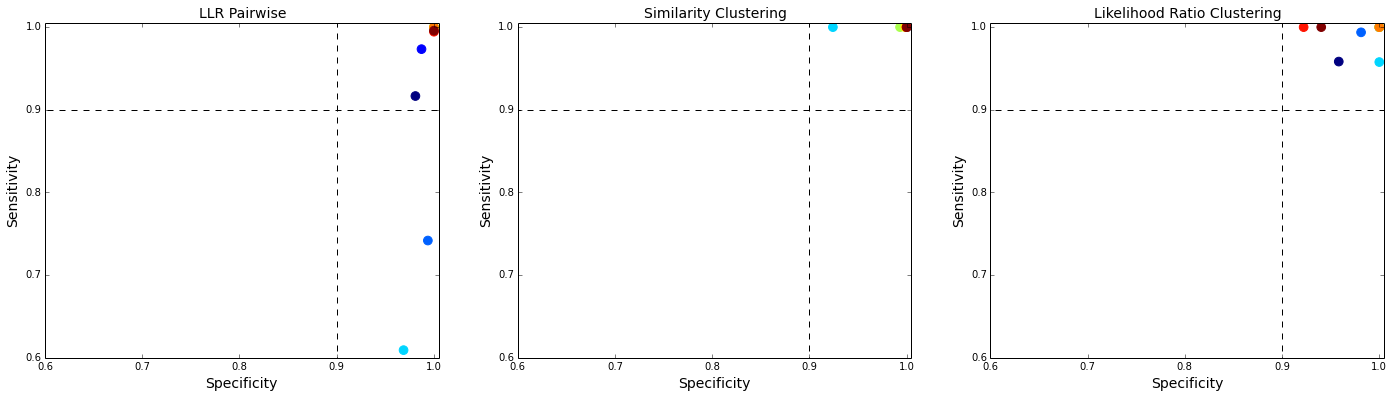

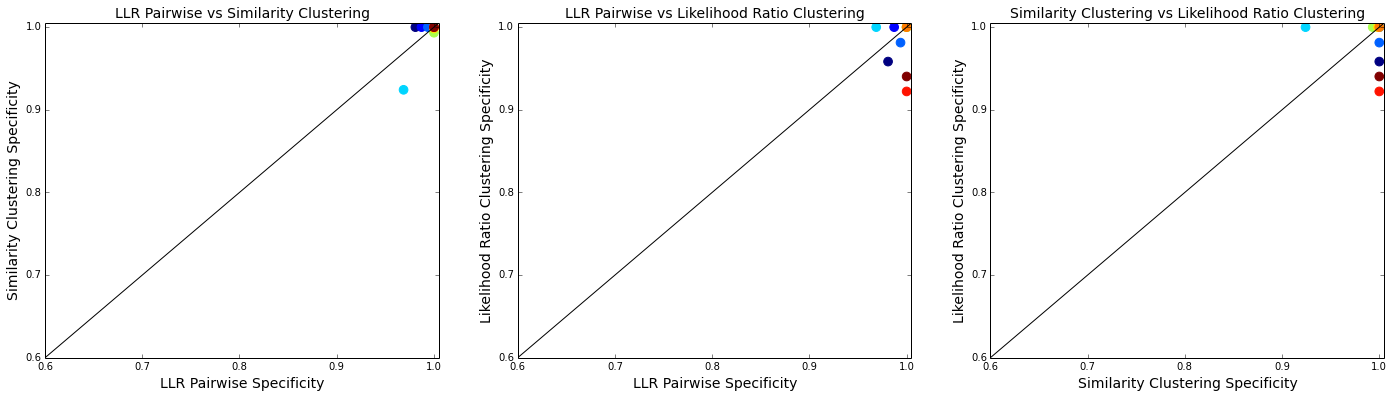

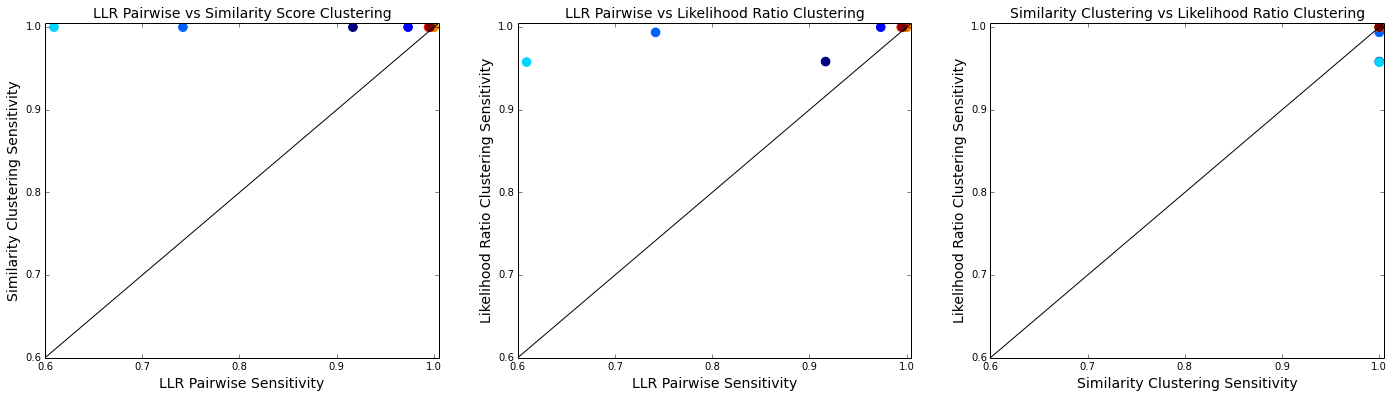

In [44]:
distance = u'Exact Pairs Affinity'

# Lsp = pd.DataFrame(cleaned_exp_spec_nt.loc[distance]).T
# Lse = pd.DataFrame(cleaned_exp_sens_nt.loc[distance]).T


# Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
# Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T

# LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
# LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T

# Rsp = pd.DataFrame(metrics["ratio_specificity"].loc[distance]).T
# Rse = pd.DataFrame(metrics["ratio_sensitivity"].loc[distance]).T


fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter2(Lsp, Lse, "Specificity", "Sensitivity", 0.6, 0.6, "LLR Pairwise", ax=plot1, display_legend=False, draw_nineties=True)
plot_scatter2(Csp, Cse, "Specificity", "Sensitivity", 0.6, 0.6,  "Similarity Clustering", ax=plot2, draw_nineties=True)
plot_scatter2(LCsp, LCse, "Specificity", "Sensitivity", 0.6, 0.6,  "Likelihood Ratio Clustering", ax=plot3, draw_nineties=True)

print Lsp.shape
print Csp.shape

fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter2(Lsp, Csp, "LLR Pairwise Specificity", "Similarity Clustering Specificity", 0.6, 0.6, "LLR Pairwise vs Similarity Clustering", ax=plot21, draw_line=True, display_legend=False)
plot_scatter2(Lsp, LCsp, "LLR Pairwise Specificity", "Likelihood Ratio Clustering Specificity", 0.6, 0.6, "LLR Pairwise vs Likelihood Ratio Clustering", ax=plot22, draw_line=True, display_legend=False)
plot_scatter2(Csp, LCsp, "Similarity Clustering Specificity", "Likelihood Ratio Clustering Specificity", 0.6, 0.6, "Similarity Clustering vs Likelihood Ratio Clustering", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter2(Lse, Cse, "LLR Pairwise Sensitivity", "Similarity Clustering Sensitivity", 0.6, 0.6,  "LLR Pairwise vs Similarity Score Clustering", ax=plot31, draw_line=True, display_legend=False)
plot_scatter2(Lse, LCse, "LLR Pairwise Sensitivity", "Likelihood Ratio Clustering Sensitivity", 0.6, 0.6,  "LLR Pairwise vs Likelihood Ratio Clustering", ax=plot32, draw_line=True, display_legend=False)
plot_scatter2(Cse, LCse, "Similarity Clustering Sensitivity", "Likelihood Ratio Clustering Sensitivity", 0.6, 0.6,  "Similarity Clustering vs Likelihood Ratio Clustering", ax=plot33, draw_line=True, display_legend=False)

"Look here"
# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

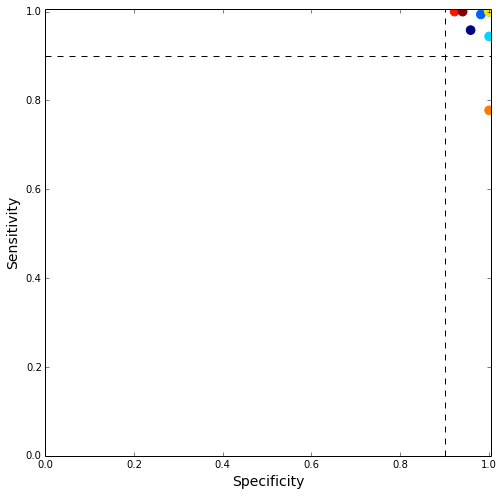

In [40]:
make_performance_figure("Exact Pairs Affinity", cleaned_nt_rati_cl_sens, cleaned_nt_rati_cl_spec)

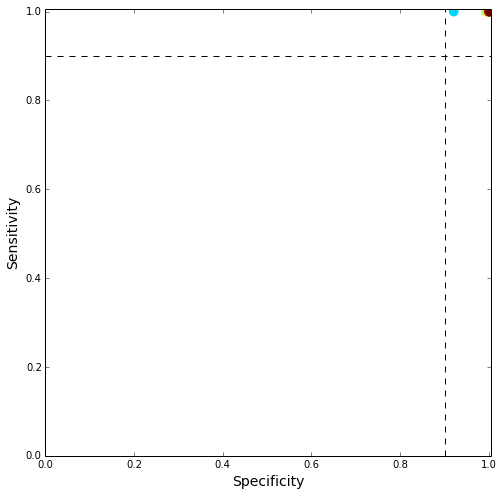

In [41]:
make_performance_figure("Exact Pairs Affinity", cleaned_nt_cluster_sens, cleaned_nt_cluster_spec)

In [16]:
cleaned_nt_cluster_sens

pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity             1.0  1.000000  1.000000       1.0       1.0   
Cosine Similarity              1.0  1.000000  1.000000       1.0       1.0   
Exact Pairs Affinity           1.0  1.000000  1.000000       1.0       1.0   
Five limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Four limited Affinity          1.0  1.000000  1.000000       1.0       1.0   
Jaccard Similarity Index       1.0  0.961538  0.978827       1.0       1.0   
Random Pairs Affinity          1.0  1.000000  1.000000       1.0       1.0   
Ten limited Affinity           1.0  1.000000  1.000000       1.0       1.0   
Three limited Affinity         1.0  1.000000  1.000000       1.0       1.0   

                          agilent_only  exomes  two_sense  strand_agnostic  \
All Pairs Affinity                 1.0     1.0        1.0              1.0   
Cosine Similarity                  1.0     1.0        1.0              1.0   
Exact Pairs Affinity               1.0     1.0        1.0              1.0   
Five limited Affinity              1.0     1.0        1.0              1.0   
Four limited Affinity              1.0     1.0        1.0              1.0   
Jaccard Similarity Index           1.0     1.0        1.0              1.0   
Random Pairs Affinity              1.0     1.0        1.0              1.0   
Ten limited Affinity               1.0     1.0        1.0              1.0   
Three limited Affinity             1.0     1.0        1.0              1.0   

                          rna  
All Pairs Affinity        1.0  
Cosine Similarity         1.0  
Exact Pairs Affinity      1.0  
Five limited Affinity     1.0  
Four limited Affinity     1.0  
Jaccard Similarity Index  1.0  
Random Pairs Affinity     1.0  
Ten limited Affinity      1.0  
Three limited Affinity    1.0

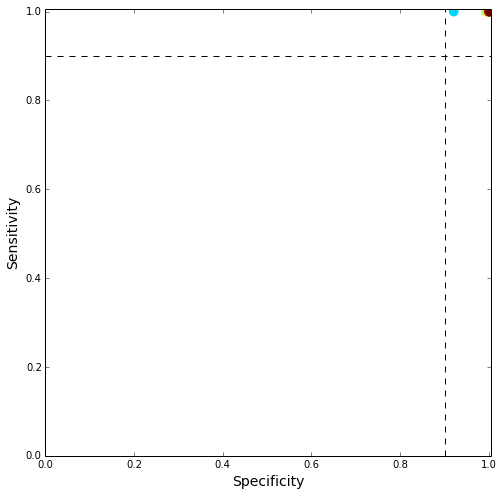

In [47]:
make_performance_figure("Exact Pairs Affinity", no_opticals_nt_cluster_sens, no_opticals_nt_cluster_spec)

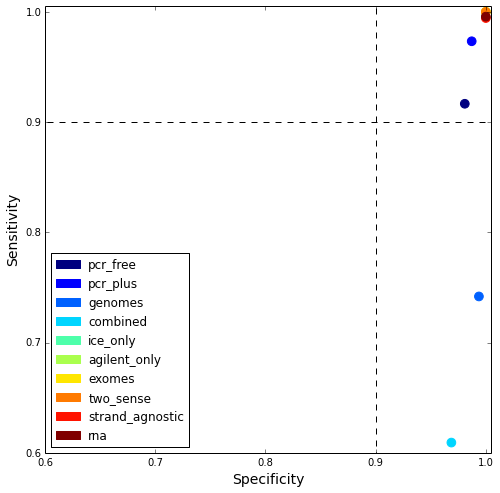

In [40]:
make_performance_figure("Exact Pairs Affinity", cleaned_nt_sens, cleaned_nt_spec)

In [27]:
make_performance_figure("Exact Pairs Affinity", no_opticals_nt_sens, no_opticals_nt_spec)

NameError: name 'no_opticals_nt_sens' is not defined

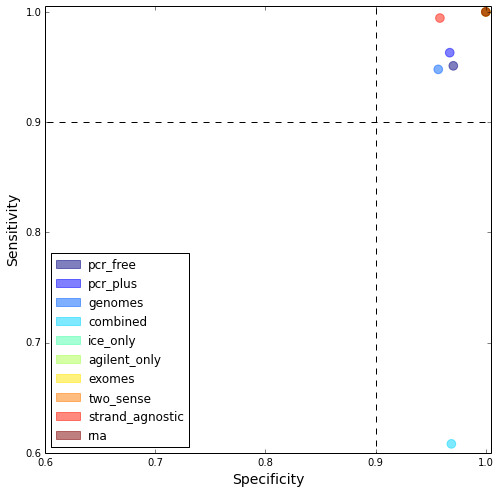

In [25]:
make_performance_figure("Exact Pairs Affinity", no_opticals_sens, no_opticals_spec)

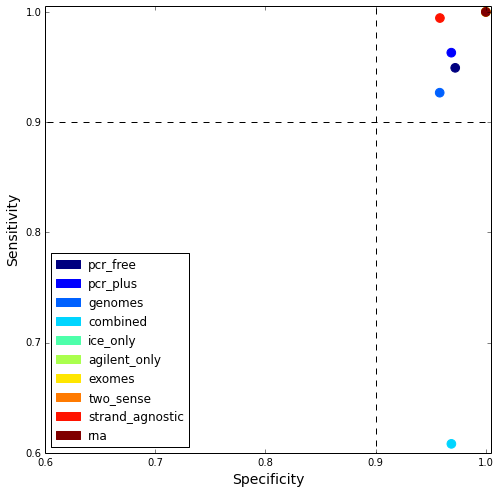

In [365]:
make_performance_figure("Exact Pairs Affinity", cleaned_sens, cleaned_spec)

In [24]:
make_performance_figure("Exact Pairs Affinity", no_opticals)

NameError: name 'no_opticals' is not defined

In [ ]:
make_performance_figure("Exact Pairs Affinity", unfiltered)

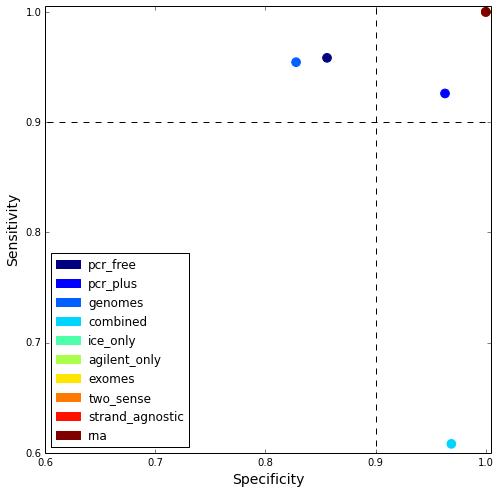

In [333]:
make_performance_figure("Exact Pairs Affinity", unfiltered_sens, unfiltered_spec)

In [26]:
def make_performance_figure(distance, LLR_sens, LLR_spec, title=None):
    fig = plt.figure(1, figsize=(8,8))
    plot1 = fig.gca()
    
#     print LLR_spec
    
    LLR_spec = pd.DataFrame(LLR_spec.loc[distance])
    LLR_sens = pd.DataFrame(LLR_sens.loc[distance])
    
#     LLR_spec = pd.DataFrame(data['LLR_p(different-library_|_truly_different-library)'].loc[distance])
#     LLR_sens = pd.DataFrame(data['LLR_p(same-library_|_truly_same-library)'].loc[distance])
#     LLR_rand = cleaned['LLR_rand_index']
    plot_scatter2(LLR_spec, LLR_sens, "Specificity", "Sensitivity", 0.6, 0.6, title, ax=plot1, draw_nineties=True, display_legend=True)


In [25]:
import matplotlib.patches as mpatches
import matplotlib.markers as mk
import matplotlib.colors as mcl

def plot_scatter2(x_df, y_df, x_label, y_label, x_min, y_min, title=None, ax=None, draw_line=False, display_legend=False, draw_nineties=False):
    al = 1
    marker_size = 75
    font_size = 14
    
    if x_df.shape != y_df.shape:
        raise AssertionError("Attempting to create scatterplot from two dataframes with different shape")
    
    if ax is None:
        ax = plt.gca()
    
    rows = range(len(x_df.index))
    for i in xrange(len(x_df.columns)):
        dataset_key = x_df.columns[i]
        ax.scatter(x=x_df[dataset_key], y=y_df[dataset_key], c=rows, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', label=dataset_key, alpha=al)
    
    if draw_line:
        ax.plot([0,1.1], [0,1.1], c='k')
        
    if draw_nineties:
        ax.plot([0.9,0.9], [0, 1.1], c='k', linestyle='--')
        ax.plot([0, 1.1], [0.9,0.9], c='k', linestyle='--')

        
#     ax.set_ylim(ymin=y_min, ymax=1.005)
#     ax.set_xlim(xmin=x_min, xmax=1.005)
    ax.set_ylim(ymin=y_min, ymax=1.005)
    ax.set_xlim(xmin=x_min, xmax=1.005)
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    
    
    
    if title is not None:
        ax.set_title(title, fontsize=font_size)
    
    if display_legend:
        # Set up an extra set of handles/labels within the legend, for the color key
        cmap = plt.cm.get_cmap()
        norm = mcl.Normalize(vmin=0,vmax=rows[-1])
        patches = []
        for i in rows:
            patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
        handles, labels = ax.get_legend_handles_labels()
#         new_handle = [handle for i,handle in enumerate(handles)]+patches
#         new_label = [label for i,label in enumerate(labels)]+[dist for dist in x_df.index]

        new_handle = patches
        new_label= [dist for dist in x_df.index]

        # display the legend
        ax.legend(new_handle, new_label, loc=3)
#         ax.legend(new_handle, new_label, ncol=2, bbox_to_anchor=(4.3,1.01))


    


In [161]:
def expected_fails_to_successses(expected_fails):
    return pd.DataFrame(1 - expected_fails.values, index=expected_fails.index, columns=expected_fails.columns)

In [2]:
cleaned_exp_sens=expected_fails_to_successses(cleaned['Expected_False-Sames'])
no_opticals_exp_sens=expected_fails_to_successses(no_opticals['Expected_False-Sames'])
unfiltered_exp_sens=expected_fails_to_successses(unfiltered['Expected_False-Sames'])

NameError: name 'cleaned' is not defined

In [61]:
# cleaned_exp_sens_nt=expected_fails_to_successses(pd.DataFrame.from_csv('feb_Expected_False-Sames_evaluation_NEW_THRESHOLD.csv'))
# cleaned_exp_spec_nt=expected_fails_to_successses(pd.DataFrame.from_csv('feb_Expected_False-Diffs_evaluation_NEW_THRESHOLD.csv'))
cleaned_exp_sens_nt=pd.DataFrame.from_csv('feb_Expected_False-Sames_evaluation_NEW_THRESHOLD.csv')
cleaned_exp_spec_nt=pd.DataFrame.from_csv('feb_Expected_False-Diffs_evaluation_NEW_THRESHOLD.csv')

# no_opticals_exp_sens_nt=expected_fails_to_successses(pd.DataFrame.from_csv('optNo_Expected_False-Sames_evaluation_NEW_THRESHOLD.csv'))
# no_opticals_exp_spec_nt=expected_fails_to_successses(pd.DataFrame.from_csv('optNo_Expected_False-Diffs_evaluation_NEW_THRESHOLD.csv'))
no_opticals_exp_sens_nt=pd.DataFrame.from_csv('optNo_Expected_False-Sames_evaluation_NEW_THRESHOLD.csv')
no_opticals_exp_spec_nt=pd.DataFrame.from_csv('optNo_Expected_False-Diffs_evaluation_NEW_THRESHOLD.csv')

# unfiltered_exp_sens_nt=expected_fails_to_successses(pd.DataFrame.from_csv('noF_Expected_False-Sames_evaluation_NEW_THRESHOLD.csv'))
# unfiltered_exp_spec_nt=expected_fails_to_successses(pd.DataFrame.from_csv('noF_Expected_False-Diffs_evaluation_NEW_THRESHOLD.csv'))
unfiltered_exp_sens_nt=pd.DataFrame.from_csv('noF_Expected_False-Sames_evaluation_NEW_THRESHOLD.csv')
unfiltered_exp_spec_nt=pd.DataFrame.from_csv('noF_Expected_False-Diffs_evaluation_NEW_THRESHOLD.csv')

In [177]:
cleaned_exp_fals_same = pd.DataFrame.from_csv('feb_Expected_False-Sames_evaluation.csv')
cleaned_exp_sens=expected_fails_to_successses(pd.DataFrame.from_csv('feb_Expected_False-Sames_evaluation.csv'))

In [173]:
cleaned_exp_sens=expected_fails_to_successses(pd.DataFrame.from_csv('feb_Expected_False-Sames_evaluation.csv'))
unfiltered_exp_sens=expected_fails_to_successses(pd.DataFrame.from_csv('noF_Expected_False-Sames_evaluation.csv'))
no_opticals_exp_sens=expected_fails_to_successses(pd.DataFrame.from_csv('optNo_Expected_False-Sames_evaluation.csv'))

In [174]:
cleaned_exp_spec=expected_fails_to_successses(pd.DataFrame.from_csv('feb_Expected_False-Diffs_evaluation.csv'))
unfiltered_exp_spec=expected_fails_to_successses(pd.DataFrame.from_csv('noF_Expected_False-Diffs_evaluation.csv'))
no_opticals_exp_spec=expected_fails_to_successses(pd.DataFrame.from_csv('optNo_Expected_False-Diffs_evaluation.csv'))

In [384]:
cleaned_rand=pd.DataFrame.from_csv('feb_LLR_rand_index_evaluation.csv')


In [178]:
display(cleaned_exp_fals_same)
display(cleaned_exp_sens)

pcr_free      pcr_plus       genomes  combined  \
All Pairs Affinity        0.000851  3.041599e-02  5.443889e-03  0.000004   
Cosine Similarity         0.969721  6.345563e-04  2.338247e-07  0.088500   
Exact Pairs Affinity      0.021406  1.476976e-02  4.563811e-02  0.013956   
Five limited Affinity     0.171498  4.493778e-02  1.984548e-02  0.017846   
Four limited Affinity     0.149896  4.589159e-02  2.757643e-01  0.016654   
Jaccard Similarity Index  0.026901  3.267829e-07  1.531609e-02  0.226180   
Random Pairs Affinity     0.053815  3.266414e-02  1.031751e-02  0.004527   
Ten limited Affinity      0.147903  5.532968e-02  1.603143e-02  0.010037   
Three limited Affinity    0.064338  3.407973e-02  1.698729e-01  0.007081   

                              ice_only  agilent_only        exomes  \
All Pairs Affinity        1.366440e-11  1.110223e-16  1.236247e-02   
Cosine Similarity         4.440892e-16  1.312695e-04  9.958665e-02   
Exact Pairs Affinity      1.110223e-16  1.110223e-16  1.003078e-06   
Five limited Affinity     1.110223e-16  1.110223e-16  2.177980e-04   
Four limited Affinity     1.110223e-16  1.110223e-16  7.095538e-05   
Jaccard Similarity Index  1.110223e-16  2.001824e-06  1.390329e-01   
Random Pairs Affinity     1.110223e-16  1.110223e-16  1.768689e-04   
Ten limited Affinity      1.110223e-16  1.110223e-16  2.215789e-03   
Three limited Affinity    1.110223e-16  1.110223e-16  9.354998e-07   

                             two_sense  strand_agnostic       rna  
All Pairs Affinity        5.567856e-03         1.000000  0.031561  
Cosine Similarity         1.109314e-02         0.994135  0.119183  
Exact Pairs Affinity      1.110223e-16         0.036890  0.087032  
Five limited Affinity     1.110223e-16         0.973950  0.160229  
Four limited Affinity     1.110223e-16         0.079513  0.141245  
Jaccard Similarity Index  4.131795e-11         0.998055  0.010818  
Random Pairs Affinity     1.110223e-16         0.984041  0.104591  
Ten limited Affinity      1.110223e-16         0.987629  0.198231  
Three limited Affinity    1.110223e-16         0.955660  0.038310

pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.999149  0.969584  0.994556  0.999996       1.0   
Cosine Similarity         0.030279  0.999365  1.000000  0.911500       1.0   
Exact Pairs Affinity      0.978594  0.985230  0.954362  0.986044       1.0   
Five limited Affinity     0.828502  0.955062  0.980155  0.982154       1.0   
Four limited Affinity     0.850104  0.954108  0.724236  0.983346       1.0   
Jaccard Similarity Index  0.973099  1.000000  0.984684  0.773820       1.0   
Random Pairs Affinity     0.946185  0.967336  0.989682  0.995473       1.0   
Ten limited Affinity      0.852097  0.944670  0.983969  0.989963       1.0   
Three limited Affinity    0.935662  0.965920  0.830127  0.992919       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  0.987638   0.994432     1.066290e-07   
Cosine Similarity             0.999869  0.900413   0.988907     5.864884e-03   
Exact Pairs Affinity          1.000000  0.999999   1.000000     9.631102e-01   
Five limited Affinity         1.000000  0.999782   1.000000     2.605040e-02   
Four limited Affinity         1.000000  0.999929   1.000000     9.204865e-01   
Jaccard Similarity Index      0.999998  0.860967   1.000000     1.944716e-03   
Random Pairs Affinity         1.000000  0.999823   1.000000     1.595908e-02   
Ten limited Affinity          1.000000  0.997784   1.000000     1.237071e-02   
Three limited Affinity        1.000000  0.999999   1.000000     4.434046e-02   

                               rna  
All Pairs Affinity        0.968439  
Cosine Similarity         0.880817  
Exact Pairs Affinity      0.912968  
Five limited Affinity     0.839771  
Four limited Affinity     0.858755  
Jaccard Similarity Index  0.989182  
Random Pairs Affinity     0.895409  
Ten limited Affinity      0.801769  
Three limited Affinity    0.961690

In [146]:
x_val = np.zeros(len(cleaned_exp_sens.index))

In [7]:
def box_plot_a_dataset(left, middle, right, dset, labels, ax=None):

    rows = range(len(cleaned_exp_sens.index))
#     print rows

    if ax is None:
        ax= plt.gca()
    # ax.scatter(x=x_val, y=unfiltered_exp_sens["pcr_free"], c=rows)
    # ax.scatter(x=x_val+1, y=no_opticals_exp_sens["pcr_free"], c=rows)
    # ax.scatter(x=x_val+2, y=cleaned_exp_sens["pcr_free"], c=rows)

    bp = ax.boxplot([left[dset], middle[dset], right[dset]])
    ax.set_xticklabels(labels)
    ax.set_title(dset)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
    #     box.set( facecolor = '#1b9e77' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

In [356]:
labs = ['Unfiltered', 'Filtered', 'No Opticals']

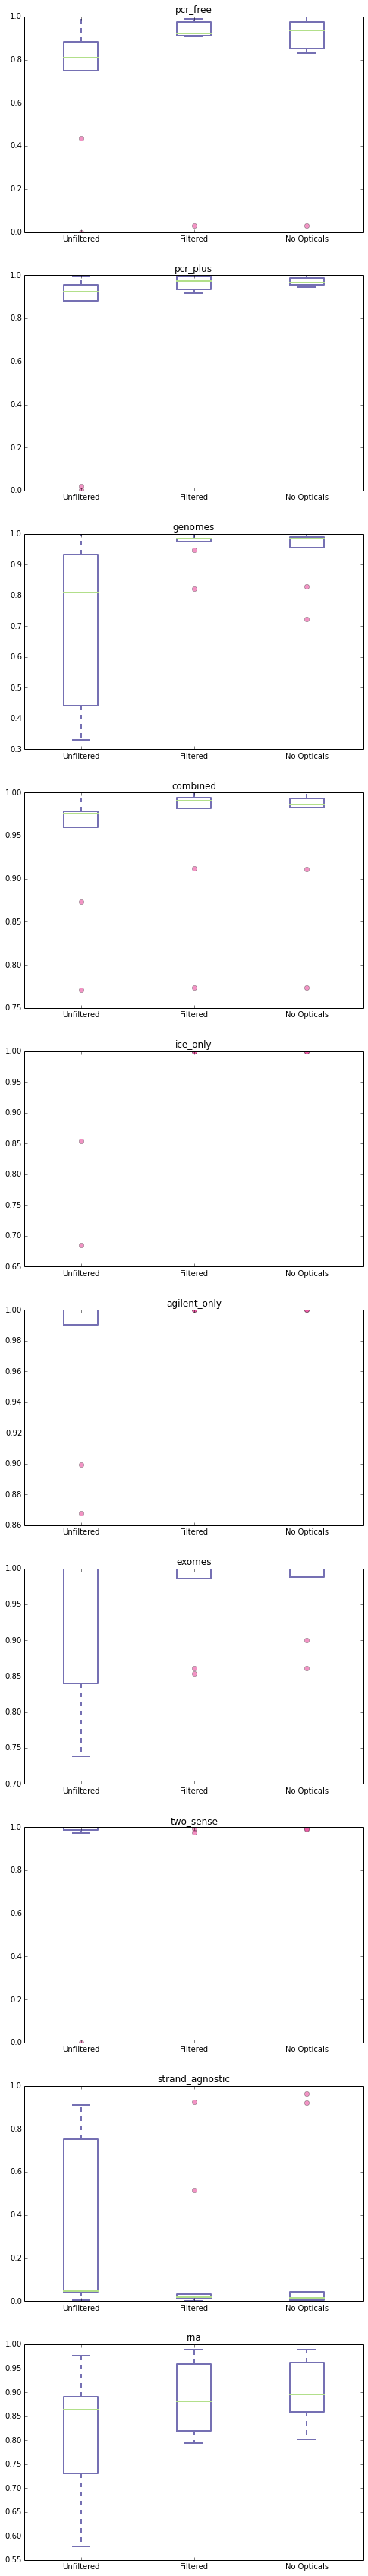

In [236]:
datasets = unfiltered_exp_sens.columns

n_subfigs = len(datasets)
# print n_subfigs
fig = plt.figure(figsize=(8, 6*n_subfigs))

i=0
for dset in datasets:
    i += 1
    sub= fig.add_subplot(n_subfigs, 1, i)
#     print dset

    box_plot_a_dataset(unfiltered_exp_sens, no_opticals_exp_sens, cleaned_exp_sens, dset, labs, ax=sub)

In [29]:
unfiltered_exp_sens.shape

unf = unfiltered_exp_sens
fil = no_opticals_exp_sens
cln = cleaned_exp_sens

marker_size=15
al=1

offset= 4

datasets = unf.columns
n_subfigs = len(datasets)
dividers = np.arange(0,(n_subfigs*offset),offset)
# jitter = np.random.normal(0, 0.5, len(unf.index))
jitter = np.column_stack(np.random.normal(0, 0.08, len(unf.index))).T


# jittered = dividers+jitter
# print jittered

unf_offsets = dividers + 1
unf_x = [unf_offsets] * len(unf.index)
unf_x = unf_x + jitter
# print unf_x

fil_offsets = dividers + 2
fil_x = [fil_offsets] * len(fil.index)
fil_x = fil_x + jitter

cln_offsets = dividers + 3
cln_x = [cln_offsets] * len(cln.index)
cln_x = cln_x + jitter

fig=plt.figure(figsize=(16,4))
ax=plt.gca()

y_s = [[i]*len(unf.index) for i in range(len(datasets))]
# print y_s


ax.set_xlim(0, (n_subfigs*offset))
# ax.semilogy(x=unf_x, y=unf)#, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)
# ax.semilogy(unf)#, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)

# ax.scatter(x=unf_x, y=np.log(unf.values.clip(10**(-4), 1-10**(-4))), c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)
# ax.scatter(x=fil_x, y=np.log(cln.values.clip(10**(-4), 1-10**(-4))), c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)
# ax.scatter(x=cln_x, y=np.log(fil.values.clip(10**(-4), 1-10**(-4))), c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)
# ax.set_yscale('symlog')
# ax.set_ylim((0.99000000000000001, 1.1000000000000002))
# ax.set_ylim((-10**(0), 0))


ax.scatter(x=unf_x, y=unf, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)
ax.scatter(x=fil_x, y=fil, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)
ax.scatter(x=cln_x, y=cln, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[0], edgecolors='face', alpha=al)

# print ax.get_ylim()
ax.set_ylim((-0.10000000000000001, 1.1000000000000002))

# ax.set_xticks(np.arange(0, n_subfigs, 5))
ax.set_xticks(unf_offsets)

# xlab = []
# for dset in datasets:
#     xlab += ["",dset,"",""]
# print xlab
ax.set_xticklabels(datasets, rotation=30)

font_size=14
ax.tick_params(which='major', color='w', labelsize=font_size)


for x_thing in dividers:
    ax.plot([x_thing,x_thing], [-1, 2], c='k', linestyle='--')

    
#   if display_legend:
# Set up an extra set of handles/labels within the legend, for the color key
cmap = plt.cm.get_cmap()
norm = mcl.Normalize(vmin=0,vmax=len(unf.index))
patches = []
for i in range(len(unf.index)):
    patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
handles, labels = ax.get_legend_handles_labels()
new_handle = [handle for i,handle in enumerate(handles)]+patches
new_label = [label for i,label in enumerate(labels)]+[dist for dist in unf.index]

# display the legend
#         ax.legend(new_handle, new_label, loc=3)
# ax.legend(new_handle, new_label, ncol=1, bbox_to_anchor=(4.3,1.01))
# ax.legend(new_handle, new_label, ncol=1, loc=3)

# ax.legend(new_handle, new_label, ncol=3, bbox_to_anchor=(1.7,1.01))

# ax.legend()



NameError: name 'unfiltered_exp_sens' is not defined

In [51]:
jitter = np.column_stack(np.random.normal(0, 0.5, len(unf.index))).T
jitter
# np.column_stack(jitter).T /

array([[ 0.50920562],
       [ 0.44809781],
       [ 0.11844035],
       [ 0.96930317],
       [-0.72950512],
       [ 0.06291659],
       [-0.4141448 ],
       [-0.68123429],
       [ 1.02847045]])

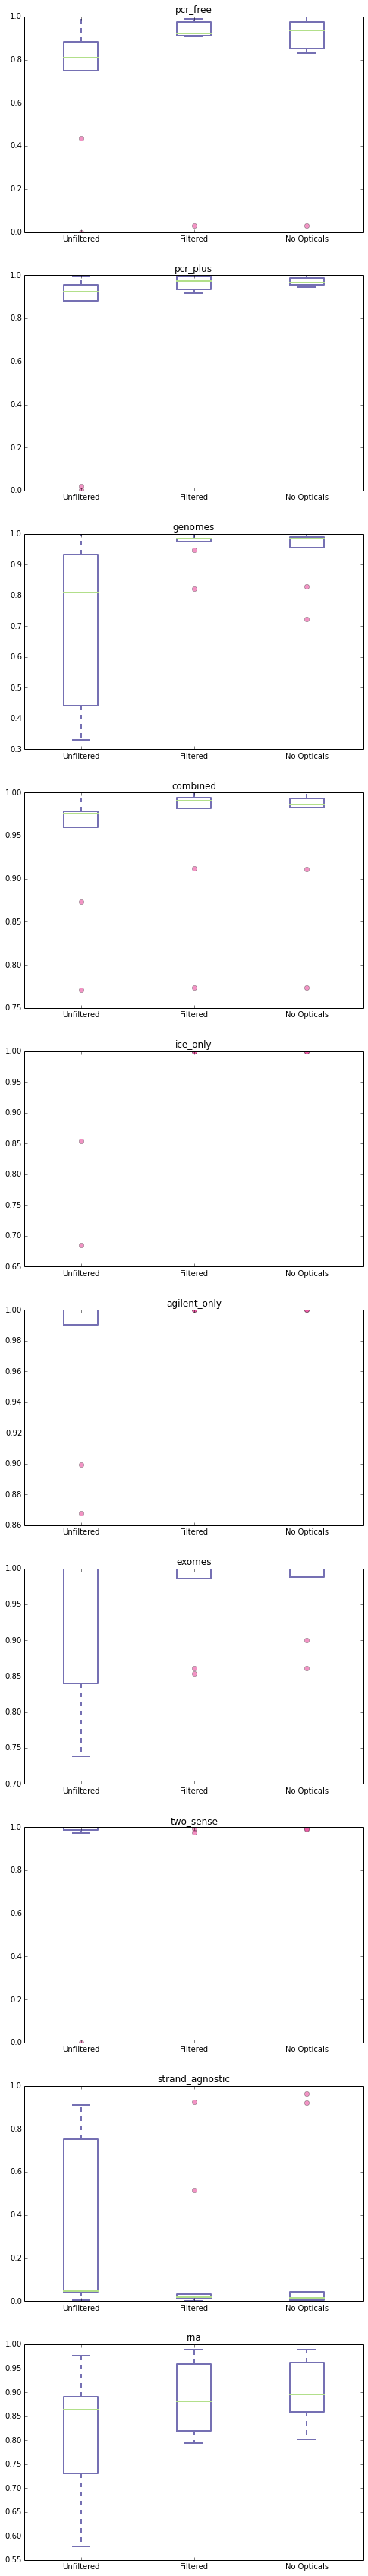

In [207]:
datasets = unfiltered_exp_sens.columns

n_subfigs = len(datasets)
# print n_subfigs
fig = plt.figure(figsize=(8, 6*n_subfigs))

i=0
for dset in datasets:
    i += 1
    sub= fig.add_subplot(n_subfigs, 1, i)
#     print dset

    box_plot_a_dataset(unfiltered_exp_sens, no_opticals_exp_sens, cleaned_exp_sens, dset, labs, ax=sub)

Index([u'All Pairs Affinity', u'Cosine Similarity', u'Exact Pairs Affinity',
       u'Five limited Affinity', u'Four limited Affinity',
       u'Jaccard Similarity Index', u'Random Pairs Affinity',
       u'Ten limited Affinity', u'Three limited Affinity'],
      dtype='object')


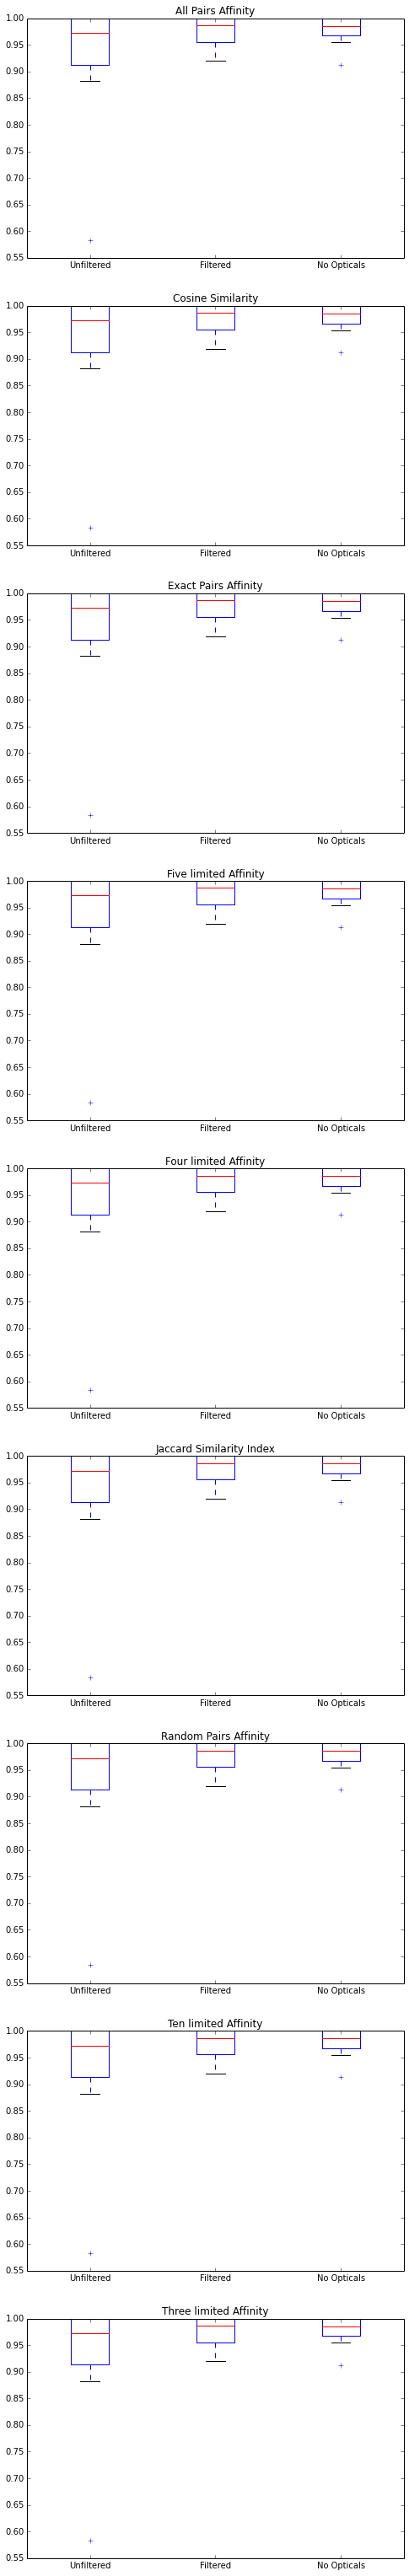

In [208]:
metrics = cleaned_exp_sens.index
print metrics

fig = plt.figure(figsize=(8, 6*len(metrics)))

i=0
for metric in metrics:
    i += 1
    ax=fig.add_subplot(len(metrics), 1, i)
    
    noF = pd.DataFrame(unfiltered_exp_sens.loc['Exact Pairs Affinity'])
    optNo = pd.DataFrame(no_opticals_exp_sens.loc['Exact Pairs Affinity'])
    cl = pd.DataFrame(cleaned_exp_sens.loc['Exact Pairs Affinity'])

    # display(noF)
    # display(optNo)
    # display(cl)

    ax= plt.gca()
        # ax.scatter(x=x_val, y=unfiltered_exp_sens["pcr_free"], c=rows)
        # ax.scatter(x=x_val+1, y=no_opticals_exp_sens["pcr_free"], c=rows)
        # ax.scatter(x=x_val+2, y=cleaned_exp_sens["pcr_free"], c=rows)

    bp = ax.boxplot([noF, optNo, cl])
    ax.set_xticklabels(labs)
    ax.set_title(metric)
#     ax.set_ylim(0.8,1)

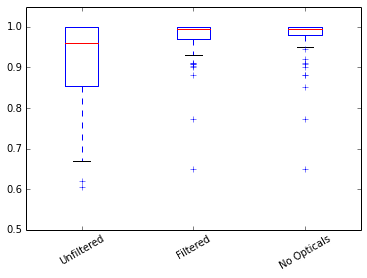

In [357]:
ax = plt.gca()
ax.set_ylim((0.5, 1.05))

ax.set_xticklabels(labs, rotation=30)
bp = ax.boxplot([unfiltered_exp_sens_nt, no_opticals_exp_sens_nt, cleaned_exp_sens_nt])


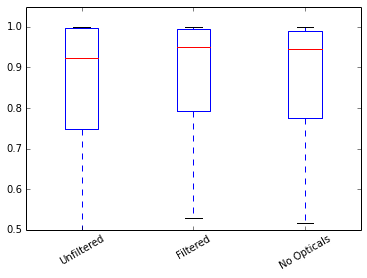

In [358]:
ax = plt.gca()
ax.set_ylim((0.5, 1.05))
ax.set_xticklabels(labs, rotation=30)

bp = ax.boxplot([unfiltered_exp_spec_nt, no_opticals_exp_spec_nt, cleaned_exp_spec_nt])


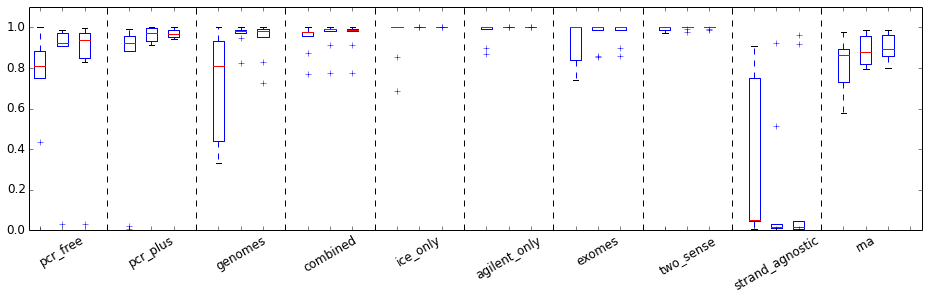

In [258]:

unfiltered_exp_sens.shape

unf = unfiltered_exp_sens
fil = no_opticals_exp_sens
cln = cleaned_exp_sens

datasets = unf.columns
n_subfigs = len(datasets)
dividers = np.arange(0,(n_subfigs*6),6)

fig = plt.figure(figsize=(16,4))
ax=plt.gca()

# datasets=['pcr_free', 'pcr_plus']
full=[]
xlabs = []
for dset in datasets:
    unf = unfiltered_exp_sens[dset]
    fil = no_opticals_exp_sens[dset]
    cln = cleaned_exp_sens[dset]
    fullset = [unf, fil, cln, []]
    xlab = ["",dset,"",""]
    full += fullset
    xlabs += xlab
 
bp = ax.boxplot(full)

ax.set_ylim((0.0, 1.1))
# ax.set_ylim((10^(-1), 1.0))

dividers = np.arange(0,4*len(datasets),4)
for x_thing in dividers:
    ax.plot([x_thing,x_thing], [0, 1.1], c='k', linestyle='--')

ax.set_xticklabels(xlabs, rotation=30)

font_size=12
# ax.tick_params(which='minor', color='w', labelsize=font_size)
ax.tick_params(which='major', labelsize=font_size)

# ax.set_yscale("log", nonposy='mask')
# ax.set_yscale('linear')
# ax.set_yscale('symlog')

print

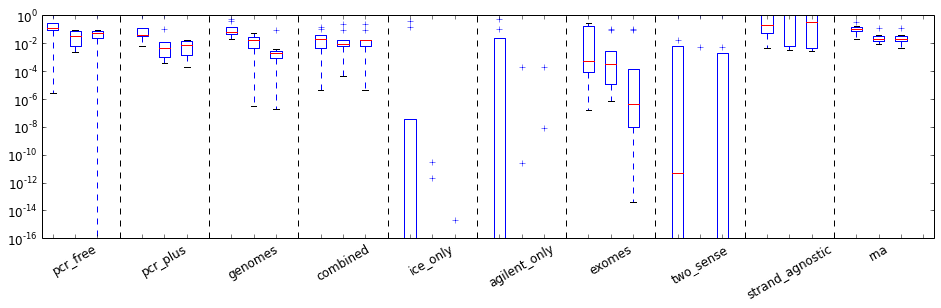

In [72]:

# unfiltered_exp_sens.shape

unf = unfiltered_exp_sens_nt
fil = no_opticals_exp_sens_nt
cln = cleaned_exp_sens_nt

datasets = unf.columns
n_subfigs = len(datasets)
dividers = np.arange(0,(n_subfigs*6),6)

fig = plt.figure(figsize=(16,4))
ax=plt.gca()

# datasets=['pcr_free', 'pcr_plus']
full=[]
xlabs = []
for dset in datasets:
#     unf = np.log(unfiltered_exp_sens[dset].clip(10**-12, 1-10**-5))
#     fil = np.log(no_opticals_exp_sens_nt[dset].clip(10**-12, 1-10**-5))
#     cln = np.log(cleaned_exp_sens_nt[dset].clip(10**-12, 1-10**-5))
    
    unf = unfiltered_exp_sens_nt[dset]
    fil = no_opticals_exp_sens_nt[dset]
    cln = cleaned_exp_sens_nt[dset]
    fullset = [unf, fil, cln, []]
    xlab = ["",dset,"",""]
    full += fullset
    xlabs += xlab
 
bp = ax.boxplot(full)

# ax.set_ylim((0.0, 1.1))
# ax.set_ylim((-10^(0), 0))
# ax.set_ylim(-0.05, 0.01)
ax.set_ylim(10**(-16), 10**0.01)

# start,end = ax.get_ylim()
# ytix = np.arange(start,end,0.00001)
# ax.set_yticks(ytix)

dividers = np.arange(0,4*len(datasets),4)
for x_thing in dividers:
#     ax.plot([x_thing,x_thing], [0, 1.1], c='k', linestyle='--')
        ax.plot([x_thing,x_thing], [10**(-16), 10**1], c='k', linestyle='--')


ax.set_xticklabels(xlabs, rotation=30)

font_size=12
# ax.tick_params(which='minor', color='w', labelsize=font_size)
ax.tick_params(which='major', labelsize=font_size)

ax.set_yscale("log", nonposy='mask')
# ax.set_yscale('linear')
# ax.set_yscale('symlog')

print

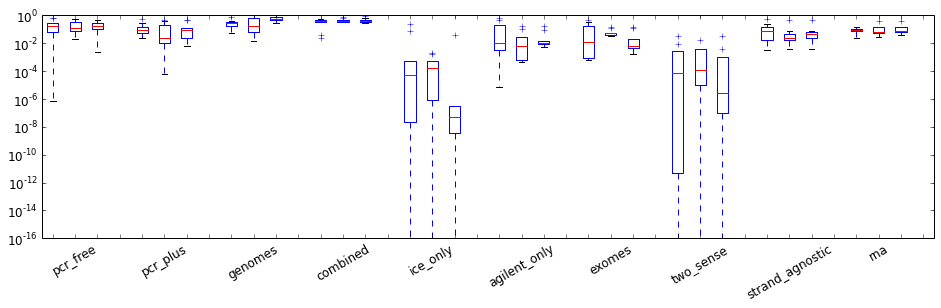

In [68]:

# unfiltered_exp_sens.shape

unf = unfiltered_exp_spec_nt
fil = no_opticals_exp_spec_nt
cln = cleaned_exp_spec_nt

datasets = unf.columns
n_subfigs = len(datasets)
dividers = np.arange(0,(n_subfigs*6),6)

fig = plt.figure(figsize=(16,4))
ax=plt.gca()

# datasets=['pcr_free', 'pcr_plus']
full=[]
xlabs = []
for dset in datasets:
#     unf = np.log(unfiltered_exp_sens[dset].clip(10**-12, 1-10**-5))
#     fil = np.log(no_opticals_exp_sens_nt[dset].clip(10**-12, 1-10**-5))
#     cln = np.log(cleaned_exp_sens_nt[dset].clip(10**-12, 1-10**-5))
    
    unf = unfiltered_exp_spec_nt[dset]
    fil = no_opticals_exp_spec_nt[dset]
    cln = cleaned_exp_spec_nt[dset]
    fullset = [unf, fil, cln, []]
    xlab = ["",dset,"",""]
    full += fullset
    xlabs += xlab
 
bp = ax.boxplot(full)

# ax.set_ylim((0.0, 1.1))
# ax.set_ylim((-10^(0), 0))
# ax.set_ylim(-0.05, 0.01)
ax.set_ylim(10**(-16), 10**0.01)

# start,end = ax.get_ylim()
# ytix = np.arange(start,end,0.00001)
# ax.set_yticks(ytix)

dividers = np.arange(0,4*len(datasets),4)
# for x_thing in dividers:
#     ax.plot([x_thing,x_thing], [0, 1.1], c='k', linestyle='--')
#         ax.plot([x_thing,x_thing], [10**(-5), 10**1], c='k', linestyle='--')


ax.set_xticklabels(xlabs, rotation=30)

font_size=12
# ax.tick_params(which='minor', color='w', labelsize=font_size)
ax.tick_params(which='major', labelsize=font_size)

ax.set_yscale("log", nonposy='mask')
# ax.set_yscale('linear')
# ax.set_yscale('symlog')

print

"Look here"

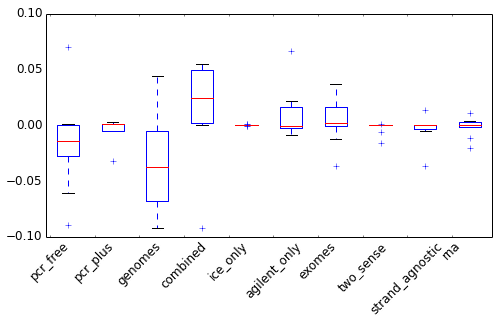

In [406]:

unfiltered_exp_sens.shape

unf = unfiltered_exp_spec_nt
fil = no_opticals_exp_spec_nt
cln = cleaned_exp_spec_nt

datasets = unf.columns
n_subfigs = len(datasets)
dividers = np.arange(0,(n_subfigs*6),6)

fig = plt.figure(figsize=(8,4))
ax=plt.gca()

# datasets=['pcr_free', 'pcr_plus']
full=[]
xlabs = []
for dset in datasets:
#     unf = np.log(unfiltered_exp_sens[dset].clip(10**-12, 1-10**-5))
#     fil = np.log(no_opticals_exp_sens_nt[dset].clip(10**-12, 1-10**-5))
#     cln = np.log(cleaned_exp_sens_nt[dset].clip(10**-12, 1-10**-5))

#     diff = no_opticals_exp_sens_nt[dset] - unfiltered_exp_sens_nt[dset]
#     diff = no_opticals_exp_spec_nt[dset] - unfiltered_exp_spec_nt[dset]

    
    
#     diff = cleaned_exp_sens_nt[dset] - no_opticals_exp_sens_nt[dset]
    diff = cleaned_exp_spec_nt[dset] - no_opticals_exp_spec_nt[dset]

#     unf = unfiltered_exp_spec_nt[dset]
#     fil = no_opticals_exp_spec_nt[dset]
#     cln = cleaned_exp_spec_nt[dset]
    fullset = [diff]
    xlab = [dset]
    full += fullset
    xlabs += xlab
 
bp = ax.boxplot(full)

ax.set_ylim((-0.1, 0.1))
# ax.set_ylim((-10^(0), 0))
# ax.set_ylim(-0.05, 0.01)
# ax.set_ylim(10**(-0.2), 10**0.01)

# start,end = ax.get_ylim()
# ytix = np.arange(start,end,0.00001)
# ax.set_yticks(ytix)

dividers = np.arange(0,4*len(datasets),4)
# for x_thing in dividers:
#     ax.plot([x_thing,x_thing], [0, 1.1], c='k', linestyle='--')
#         ax.plot([x_thing,x_thing], [10**(-5), 10**1], c='k', linestyle='--')

# ax.plot([0,12],[0,0], c='k', linestyle='--')

ax.set_xticks(ax.get_xticks()-0.4, minor=True)
ax.set_xticklabels(xlabs, rotation=45, minor=True)
ax.set_xticklabels([], rotation=30)

font_size=12
ax.tick_params(which='minor', labelsize=font_size)
ax.tick_params(which='major', color='w', labelsize=font_size)

# ax.set_yscale("log", nonposy='mask')
# ax.set_yscale('linear')
# ax.set_yscale('symlog')

print

In [57]:

unfiltered_exp_sens.shape

unf = unfiltered_exp_sens.T
fil = no_opticals_exp_sens.T
cln = cleaned_exp_sens.T

datasets = unf.columns
n_subfigs = len(datasets)
dividers = np.arange(0,(n_subfigs*6),6)

fig = plt.figure(figsize=(16,4))
ax=plt.gca()

# datasets=['pcr_free', 'pcr_plus']
full=[]
xlabs = []
for dset in datasets:
#     print dset
    unfY = unf[dset]
#     print unfY
    filY = fil[dset]
    clnY = cln[dset]
    fullset = [unfY, filY, clnY, []]
    xlab = ["",dset,"",""]
    full += fullset
    xlabs += xlab
 
bp = ax.boxplot(full)

ax.set_ylim((0.0, 1.0))

dividers = np.arange(0,4*len(datasets),4)
for x_thing in dividers:
    ax.plot([x_thing,x_thing], [0, 1.1], c='k', linestyle='--')

ax.set_xticklabels(xlabs, rotation=30)

font_size=12
# ax.tick_params(which='minor', color='w', labelsize=font_size)
ax.tick_params(which='major', labelsize=font_size)
print


NameError: name 'unfiltered_exp_sens' is not defined

In [ ]:
for key, value in metrics.iteritems():
    metrics[key] = metrics[key].sort_index()

In [ ]:
noOpticalDups = all_sets(["ice_only"], "noF")

In [ ]:
fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["LLR_sensitivity"], "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True)
plot_scatter(metrics["Cluster_specificity"], metrics["Cluster_sensitivity"], "Specificity", "Sensitivity", "Distance Clustering Performance by Dataset", ax=plot2)
plot_scatter(metrics["ratio_cluster_specificity"], metrics["ratio_cluster_sensitivity"], "Specificity", "Sensitivity", "Ratio Clustering Performance by Dataset", ax=plot3)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["Cluster_specificity"], "Pairwise Specificity", "Clustering Specificity", "Pairwise vs Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_specificity"], metrics["ratio_cluster_specificity"], "Pairwise Specificity", "Ratio Clustering Specificity", "Pairwise vs Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_specificity"], metrics["ratio_cluster_specificity"], "Clustering Specificity", "Ratio Clustering Specificity", "Clustering vs Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "LLR Pairwise Sensitivity", "Clustering Sensitivity", "LLR Pairwise vs Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_sensitivity"], metrics["ratio_cluster_sensitivity"], "LLR Pairwise Sensitivity", "Ratio Clustering Sensitivity", "LLR Pairwise vs Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_sensitivity"], metrics["ratio_cluster_sensitivity"], "Cluster Sensitivity", "Ratio Clustering Sensitivity", "Clustering vs Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [ ]:
distances = metrics["LLR_specificity"].index
print len(metrics)
print len(distances)
n_distances = len(distances)
fig = plt.figure(figsize=(24, 6*n_distances))
for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
    distance = distances[i]
    Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
    Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T
    
    Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
    Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T
    
    LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
    LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T
    
    # Get the appropriate axes
    plot_columns = 3
    cell_adjustment = i * plot_columns
    L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
    C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
    LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))
    
    # Only display the legend once
    doLegend = (i==0)
    
    plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
    plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
    plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)




In [ ]:
distance = u'Exact Pairs Affinity'

Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T

Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T

LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T

Rsp = pd.DataFrame(metrics["ratio_specificity"].loc[distance]).T
Rse = pd.DataFrame(metrics["ratio_sensitivity"].loc[distance]).T


fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True, draw_nineties=True)
plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Similarity Clustering Performance by Dataset", ax=plot2, draw_nineties=True)
plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Likelihood Ratio Clustering Performance by Dataset", ax=plot3, draw_nineties=True)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(Lsp, Csp, "LLR Pairwise Specificity", "Similarity Clustering Specificity", "LLR Pairwise vs Similarity Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=False)
plot_scatter(Lsp, LCsp, "LLR Pairwise Specificity", "Likelihood Ratio Clustering Specificity", "LLR Pairwise vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(Csp, LCsp, "Similarity Clustering Specificity", "Likelihood Ratio Clustering Specificity", "Similarity Clustering vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(Lse, Cse, "LLR Pairwise Sensitivity", "Similarity Clustering Sensitivity", "LLR Pairwise vs Similarity Score Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=False)
plot_scatter(Lse, LCse, "LLR Pairwise Sensitivity", "Likelihood Ratio Clustering Sensitivity", "LLR Pairwise vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(Cse, LCse, "Similarity Clustering Sensitivity", "Likelihood Ratio Clustering Sensitivity", "Similarity Clustering vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [377]:
cleaned_sens.T

All Pairs Affinity  Cosine Similarity  Exact Pairs Affinity  \
pcr_free                   1.000000           0.500000              0.949275   
pcr_plus                   0.890533           0.519231              0.963018   
genomes                    0.414495           0.226384              0.926710   
combined                   0.223188           0.271884              0.608116   
ice_only                   1.000000           1.000000              1.000000   
agilent_only               1.000000           0.991124              1.000000   
exomes                     1.000000           0.831034              1.000000   
two_sense                  1.000000           1.000000              1.000000   
strand_agnostic            0.644444           0.363889              0.994444   
rna                        0.692964           0.938166              1.000000   

                 Five limited Affinity  Four limited Affinity  \
pcr_free                      0.878623               0.918478   
pcr_plus                      0.924556               0.942308   
genomes                       0.864821               0.938111   
combined                      0.608116               0.608116   
ice_only                      1.000000               1.000000   
agilent_only                  1.000000               1.000000   
exomes                        1.000000               1.000000   
two_sense                     1.000000               1.000000   
strand_agnostic               0.922222               0.922222   
rna                           0.985075               0.995736   

                 Jaccard Similarity Index  Random Pairs Affinity  \
pcr_free                         0.550725               0.916667   
pcr_plus                         0.899408               0.949704   
genomes                          0.726384               0.935668   
combined                         0.440580               0.605217   
ice_only                         1.000000               1.000000   
agilent_only                     0.991124               1.000000   
exomes                           0.917241               1.000000   
two_sense                        1.000000               1.000000   
strand_agnostic                  0.666667               0.905556   
rna                              0.940299               0.948827   

                 Ten limited Affinity  Three limited Affinity  
pcr_free                     0.652174                0.931159  
pcr_plus                     0.920118                0.963018  
genomes                      0.441368                0.937296  
combined                     0.597681                0.608116  
ice_only                     1.000000                1.000000  
agilent_only                 1.000000                1.000000  
exomes                       1.000000                1.000000  
two_sense                    1.000000                1.000000  
strand_agnostic              0.886111                0.994444  
rna                          0.940299                0.995736

Index([u'All Pairs Affinity', u'Cosine Similarity', u'Exact Pairs Affinity',
       u'Five limited Affinity', u'Four limited Affinity',
       u'Jaccard Similarity Index', u'Random Pairs Affinity',
       u'Ten limited Affinity', u'Three limited Affinity'],
      dtype='object')
(-1.0, 9.0)
9
y TICKS


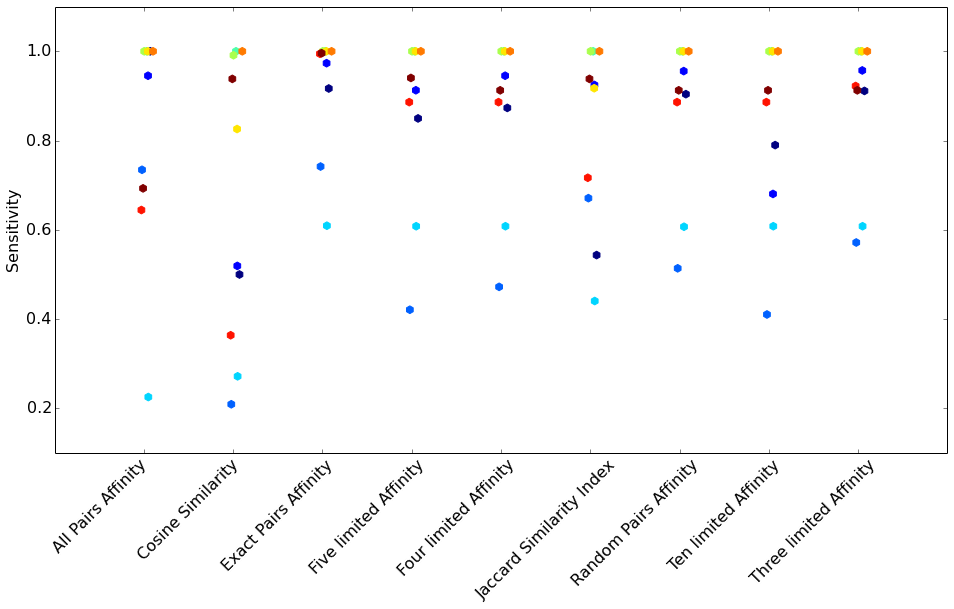

In [31]:
# cl = cleaned_sens.T
# ylab = 'Sensitivity'

cl = cleaned_nt_sens.T
ylab = 'Sensitivity'

# cl = cleaned_nt_spec.T
# ylab = 'Specificity'

# cl = cleaned_spec.T
# ylab = 'Specificity'

# cl= no_opticals_nt_sens.T
# ylab = 'Sensitivity'

# cl = no_opticals_nt_spec.T
# ylab = 'Specificity'

# cl = cleaned_rand.T
# ylab = 'Rand Index'

fig = plt.figure(figsize=(16,8))

metrics = cl.columns
sets = cl.index

x=np.arange(len(metrics))

al = 1
marker_size=60

print metrics

x_vals = range(len(metrics))
x_s = [x_vals for i in range(len(sets))]

jitter = np.column_stack(np.random.normal(0, 0.08, len(sets))).T
x_s = x_s + jitter

# jittered = dividers+jitter
# print jittered

# unf_offsets = dividers + 1
# unf_x = [unf_offsets] * len(unf.index)
# unf_x = unf_x + jitter




y_s = [[i]*len(metrics) for i in range(len(sets))]

ax = plt.gca()
ax.scatter(x=x_s, y=cl, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', alpha=al)

# print x_vals

print ax.get_xlim()
print len(metrics)

ax.set_xticks(x)
ax.set_xticklabels([])
# Minor ticks
ax.set_xticks(x-0.5, minor=True)
ax.set_xticklabels(metrics, rotation=45, minor=True)

font_size=16
ax.tick_params(which='minor', color='w', labelsize=font_size)
ax.tick_params(which='major', labelsize=font_size)


print 'y TICKS'
# print ax.get_yticks()
# print ax.get_ylim()

ax.set_xlim((-1,len(metrics)))

ax.set_yticks(np.arange(0,1.4,0.2))
ax.set_ylim((0.10000000000000001, 1.1000000000000001))

ax.set_ylabel(ylab, fontsize=font_size)
# ax.legend()

#  if display_legend:
# Set up an extra set of handles/labels within the legend, for the color key
cmap = plt.cm.get_cmap()
norm = mcl.Normalize(vmin=0,vmax=len(sets)-1)
patches = []
for i in range(len(sets)):
    patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
handles, labels = ax.get_legend_handles_labels()
new_handle = [handle for i,handle in enumerate(handles)]+patches
new_label = [label for i,label in enumerate(labels)]+[dist for dist in sets]

# display the legend
#         ax.legend(new_handle, new_label, loc=3)


# ax.legend(new_handle, new_label, ncol=1, bbox_to_anchor=(4.3,1.01))
# ax.legend(new_handle, new_label, ncol=3, loc=3, fontsize=font_size)

# ax.legend(new_handle, new_label, ncol=3, bbox_to_anchor=(2.3,1.01))


In [383]:
cleaned_rand


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        0.000000  0.058781  0.246733  0.054296       0.0   
Cosine Similarity         0.275709  0.249637  0.192871  0.093322       0.0   
Exact Pairs Affinity      0.039007  0.034107  0.049505  0.056397       0.0   
Five limited Affinity     0.194149  0.055152  0.135644  0.057044       0.0   
Four limited Affinity     0.148050  0.044993  0.128317  0.056518       0.0   
Jaccard Similarity Index  0.235816  0.050073  0.190099  0.129156       0.0   
Random Pairs Affinity     0.061170  0.042090  0.100594  0.054822       0.0   
Ten limited Affinity      0.275709  0.057329  0.231683  0.056599       0.0   
Three limited Affinity    0.053191  0.034107  0.111287  0.056397       0.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            0.000000  0.000000        0.0         0.120567   
Cosine Similarity             0.007347  0.195395        0.0         0.221631   
Exact Pairs Affinity          0.000000  0.000000        0.0         0.030142   
Five limited Affinity         0.000000  0.000000        0.0         0.053191   
Four limited Affinity         0.000000  0.000000        0.0         0.053191   
Jaccard Similarity Index      0.005714  0.184430        0.0         0.340426   
Random Pairs Affinity         0.000000  0.000000        0.0         0.058511   
Ten limited Affinity          0.000000  0.000000        0.0         0.066489   
Three limited Affinity        0.000000  0.000000        0.0         0.191489   

                               rna  
All Pairs Affinity        0.054795  
Cosine Similarity         0.307294  
Exact Pairs Affinity      0.000000  
Five limited Affinity     0.174380  
Four limited Affinity     0.134765  
Jaccard Similarity Index  0.307294  
Random Pairs Affinity     0.058867  
Ten limited Affinity      0.223991  
Three limited Affinity    0.077749

In [39]:
cleaned_nt_sens


pcr_free  pcr_plus   genomes  combined  ice_only  \
All Pairs Affinity        1.000000  0.945266  0.734528  0.225507       1.0   
Cosine Similarity         0.500000  0.519231  0.209283  0.271884       1.0   
Exact Pairs Affinity      0.916667  0.973373  0.741857  0.609275       1.0   
Five limited Affinity     0.849638  0.912722  0.421010  0.608116       1.0   
Four limited Affinity     0.873188  0.945266  0.472313  0.608116       1.0   
Jaccard Similarity Index  0.543478  0.924556  0.671010  0.440580       1.0   
Random Pairs Affinity     0.903986  0.955621  0.513844  0.606957       1.0   
Ten limited Affinity      0.789855  0.680473  0.410423  0.608116       1.0   
Three limited Affinity    0.911232  0.957101  0.571661  0.608116       1.0   

                          agilent_only    exomes  two_sense  strand_agnostic  \
All Pairs Affinity            1.000000  1.000000        1.0         0.644444   
Cosine Similarity             0.991124  0.825862        1.0         0.363889   
Exact Pairs Affinity          1.000000  1.000000        1.0         0.994444   
Five limited Affinity         1.000000  1.000000        1.0         0.886111   
Four limited Affinity         1.000000  1.000000        1.0         0.886111   
Jaccard Similarity Index      1.000000  0.917241        1.0         0.716667   
Random Pairs Affinity         1.000000  1.000000        1.0         0.886111   
Ten limited Affinity          1.000000  1.000000        1.0         0.886111   
Three limited Affinity        1.000000  1.000000        1.0         0.922222   

                               rna  
All Pairs Affinity        0.692964  
Cosine Similarity         0.938166  
Exact Pairs Affinity      0.995736  
Five limited Affinity     0.940299  
Four limited Affinity     0.912580  
Jaccard Similarity Index  0.938166  
Random Pairs Affinity     0.912580  
Ten limited Affinity      0.912580  
Three limited Affinity    0.912580

In [33]:
# for dset in cleaned_sens.columns:
#     print cleaned_sens[dset]
farp = pd.DataFrame(cleaned_nt_sens.max())
doof = cleaned_nt_sens.loc['Exact Pairs Affinity']
print doof
display(farp)

pcr_free           0.916667
pcr_plus           0.973373
genomes            0.741857
combined           0.609275
ice_only           1.000000
agilent_only       1.000000
exomes             1.000000
two_sense          1.000000
strand_agnostic    0.994444
rna                0.995736
Name: Exact Pairs Affinity, dtype: float64


0
pcr_free         1.000000
pcr_plus         0.973373
genomes          0.741857
combined         0.609275
ice_only         1.000000
agilent_only     1.000000
exomes           1.000000
two_sense        1.000000
strand_agnostic  0.994444
rna              0.995736

In [34]:
pd.DataFrame([farp.values.flatten(), doof.values]).T

0         1
0  1.000000  0.916667
1  0.973373  0.973373
2  0.741857  0.741857
3  0.609275  0.609275
4  1.000000  1.000000
5  1.000000  1.000000
6  1.000000  1.000000
7  1.000000  1.000000
8  0.994444  0.994444
9  0.995736  0.995736

In [36]:
farp = pd.DataFrame(cleaned_nt_spec.max())
doof = cleaned_nt_spec.loc['Exact Pairs Affinity']
print doof
display(farp)

pcr_free           0.980903
pcr_plus           0.987179
genomes            0.993721
combined           0.968734
ice_only           1.000000
agilent_only       1.000000
exomes             1.000000
two_sense          1.000000
strand_agnostic    1.000000
rna                1.000000
Name: Exact Pairs Affinity, dtype: float64


0
pcr_free         1.000000
pcr_plus         1.000000
genomes          0.993721
combined         0.999826
ice_only         1.000000
agilent_only     1.000000
exomes           1.000000
two_sense        1.000000
strand_agnostic  1.000000
rna              1.000000

In [37]:
pd.DataFrame([farp.values.flatten(), doof.values]).T

0         1
0  1.000000  0.980903
1  1.000000  0.987179
2  0.993721  0.993721
3  0.999826  0.968734
4  1.000000  1.000000
5  1.000000  1.000000
6  1.000000  1.000000
7  1.000000  1.000000
8  1.000000  1.000000
9  1.000000  1.000000

In [424]:
cleaned_nt_spec.T

All Pairs Affinity  Cosine Similarity  Exact Pairs Affinity  \
pcr_free                   0.994792           0.986111              0.973958   
pcr_plus                   0.998575           0.972934              1.000000   
genomes                    0.862114           0.993721              0.995552   
combined                   0.999826           0.954230              0.968734   
ice_only                   1.000000           1.000000              1.000000   
agilent_only               1.000000           0.993236              1.000000   
exomes                     1.000000           0.800754              1.000000   
two_sense                  1.000000           1.000000              1.000000   
strand_agnostic            0.989583           0.972656              1.000000   
rna                        0.998208           0.641129              1.000000   

                 Five limited Affinity  Four limited Affinity  \
pcr_free                      0.857639               0.935764   
pcr_plus                      0.974359               0.990028   
genomes                       0.864207               0.879906   
combined                      0.968039               0.968603   
ice_only                      1.000000               1.000000   
agilent_only                  1.000000               1.000000   
exomes                        1.000000               1.000000   
two_sense                     1.000000               1.000000   
strand_agnostic               0.958333               1.000000   
rna                           1.000000               1.000000   

                 Jaccard Similarity Index  Random Pairs Affinity  \
pcr_free                         0.968750               0.968750   
pcr_plus                         0.998575               0.982906   
genomes                          0.836735               0.887755   
combined                         0.903075               0.970644   
ice_only                         1.000000               1.000000   
agilent_only                     0.993236               1.000000   
exomes                           0.800754               1.000000   
two_sense                        0.944444               1.000000   
strand_agnostic                  0.656250               0.994792   
rna                              0.691308               1.000000   

                 Ten limited Affinity  Three limited Affinity  
pcr_free                     0.793403                0.982639  
pcr_plus                     0.964387                0.998575  
genomes                      0.873365                0.913919  
combined                     0.969298                0.968734  
ice_only                     1.000000                1.000000  
agilent_only                 1.000000                1.000000  
exomes                       1.000000                1.000000  
two_sense                    1.000000                1.000000  
strand_agnostic              0.964844                1.000000  
rna                          1.000000                1.000000

In [425]:
cleaned_nt_sens.T

All Pairs Affinity  Cosine Similarity  Exact Pairs Affinity  \
pcr_free                   1.000000           0.500000              0.943841   
pcr_plus                   0.852071           0.519231              0.963018   
genomes                    0.414495           0.226384              0.913681   
combined                   0.223188           0.271884              0.608116   
ice_only                   1.000000           1.000000              1.000000   
agilent_only               1.000000           0.991124              1.000000   
exomes                     1.000000           0.831034              1.000000   
two_sense                  1.000000           1.000000              1.000000   
strand_agnostic            0.644444           0.363889              0.986111   
rna                        0.692964           0.938166              1.000000   

                 Five limited Affinity  Four limited Affinity  \
pcr_free                      0.818841               0.896739   
pcr_plus                      0.924556               0.924556   
genomes                       0.864821               0.932410   
combined                      0.608116               0.608116   
ice_only                      1.000000               1.000000   
agilent_only                  1.000000               1.000000   
exomes                        1.000000               1.000000   
two_sense                     1.000000               1.000000   
strand_agnostic               0.886111               0.891667   
rna                           0.912580               0.912580   

                 Jaccard Similarity Index  Random Pairs Affinity  \
pcr_free                         0.548913               0.931159   
pcr_plus                         0.914201               0.927515   
genomes                          0.726384               0.935668   
combined                         0.440580               0.605217   
ice_only                         1.000000               1.000000   
agilent_only                     1.000000               1.000000   
exomes                           0.917241               1.000000   
two_sense                        1.000000               1.000000   
strand_agnostic                  0.716667               0.886111   
rna                              0.938166               0.912580   

                 Ten limited Affinity  Three limited Affinity  
pcr_free                     0.652174                0.920290  
pcr_plus                     0.920118                0.954142  
genomes                      0.441368                0.931596  
combined                     0.597681                0.608116  
ice_only                     1.000000                1.000000  
agilent_only                 1.000000                1.000000  
exomes                       1.000000                1.000000  
two_sense                    1.000000                1.000000  
strand_agnostic              0.886111                0.919444  
rna                          0.912580                0.912580

Index([u'All Pairs Affinity', u'Cosine Similarity', u'Exact Pairs Affinity',
       u'Five limited Affinity', u'Four limited Affinity',
       u'Jaccard Similarity Index', u'Random Pairs Affinity',
       u'Ten limited Affinity', u'Three limited Affinity'],
      dtype='object')
[0, 1, 2, 3, 4, 5, 6, 7, 8]
y TICKS


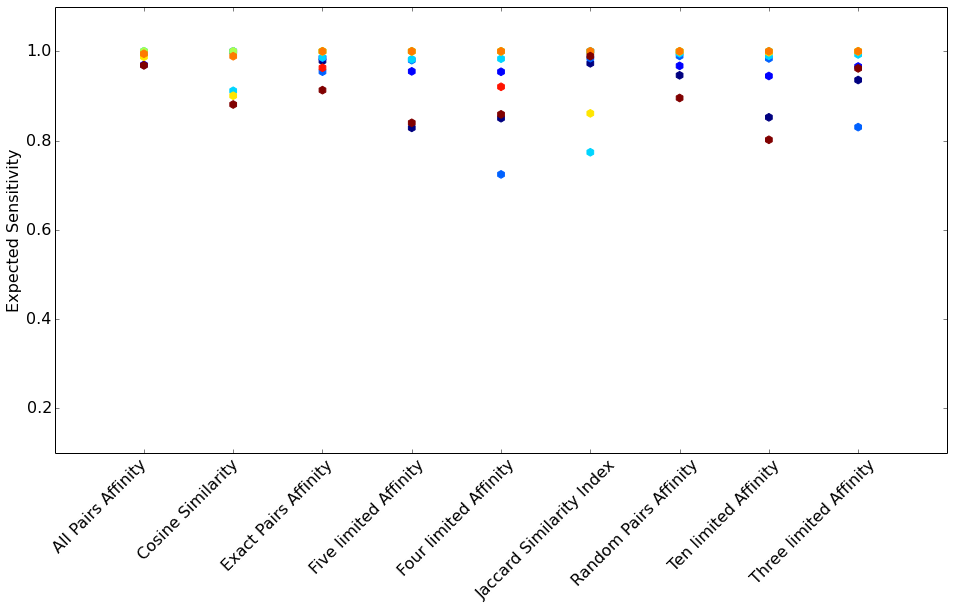

In [208]:
cl = cleaned_exp_sens.T
ylab = 'Expected Sensitivity'

# cl = cleaned_exp_spec.T
# ylab = 'Expected Specificity'

fig = plt.figure(figsize=(16,8))

metrics = cl.columns
sets = cl.index

x=np.arange(len(metrics))

al = 1
marker_size=60

print metrics

x_vals = range(len(metrics))
x_s = [x_vals for i in range(len(sets))]

y_s = [[i]*len(metrics) for i in range(len(sets))]

ax = plt.gca()
ax.scatter(x=x_s, y=cl, c=y_s, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', alpha=al)

print x_vals

ax.set_xticks(x)
ax.set_xticklabels([])
# Minor ticks
ax.set_xticks(x-0.5, minor=True)
ax.set_xticklabels(metrics, rotation=45, minor=True)

font_size=16
ax.tick_params(which='minor', color='w', labelsize=font_size)
ax.tick_params(which='major', labelsize=font_size)


print 'y TICKS'
# print ax.get_yticks()
# print ax.get_ylim()


ax.set_yticks(np.arange(0,1.4,0.2))
ax.set_ylim((0.10000000000000001, 1.1000000000000001))

ax.set_ylabel(ylab, fontsize=font_size)
# ax.legend()

#  if display_legend:
# Set up an extra set of handles/labels within the legend, for the color key
# cmap = plt.cm.get_cmap()
# norm = mcl.Normalize(vmin=0,vmax=rows[-1])
# patches = []
# for i in range(len(sets)):
#     patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
# handles, labels = ax.get_legend_handles_labels()
# new_handle = [handle for i,handle in enumerate(handles)]+patches
# new_label = [label for i,label in enumerate(labels)]+[dist for dist in sets]

# display the legend
#         ax.legend(new_handle, new_label, loc=3)
# ax.legend(new_handle, new_label, ncol=1, bbox_to_anchor=(4.3,1.01))
# ax.legend(new_handle, new_label, ncol=1, loc=3)

# ax.legend(new_handle, new_label, ncol=3, bbox_to_anchor=(2.3,1.01))


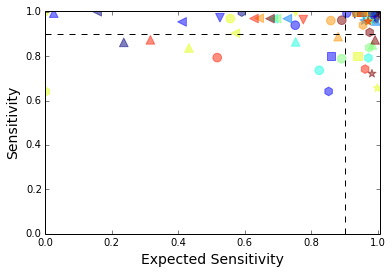

In [202]:
plot_scatter2(cleaned_exp_spec, cleaned_spec, "Expected Sensitivity", "Sensitivity", 0, 0, None, ax=plt.gca(), draw_nineties=True, display_legend=False)


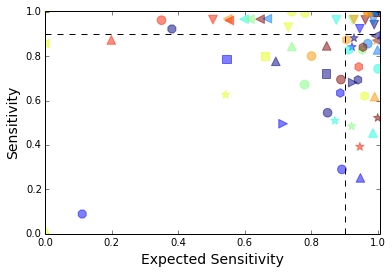

In [201]:
plot_scatter2(unfiltered_exp_spec, unfiltered_spec, "Expected Sensitivity", "Sensitivity", 0, 0, None, ax=plt.gca(), draw_nineties=True, display_legend=False)


In [14]:
thing = [1,2,3,4,5]

base = np.matrix([thing,thing])
update = base + 1

np.mean([base, update, update], axis=0)

array([[ 1.66666667,  2.66666667,  3.66666667,  4.66666667,  5.66666667],
       [ 1.66666667,  2.66666667,  3.66666667,  4.66666667,  5.66666667]])